<!DOCTYPE html>

<html>
<head>
<meta charset="utf-8" />
<meta name="generator" content="pandoc" />
<meta http-equiv="X-UA-Compatible" content="IE=EDGE" />



<script>/*! jQuery v1.11.3 | (c) 2005, 2015 jQuery Foundation, Inc. | jquery.org/license */
!function(a,b){"object"==typeof module&&"object"==typeof module.exports?module.exports=a.document?b(a,!0):function(a){if(!a.document)throw new Error("jQuery requires a window with a document");return b(a)}:b(a)}("undefined"!=typeof window?window:this,function(a,b){var c=[],d=c.slice,e=c.concat,f=c.push,g=c.indexOf,h={},i=h.toString,j=h.hasOwnProperty,k={},l="1.11.3",m=function(a,b){return new m.fn.init(a,b)},n=/^[\s\uFEFF\xA0]+|[\s\uFEFF\xA0]+$/g,o=/^-ms-/,p=/-([\da-z])/gi,q=function(a,b){return b.toUpperCase()};m.fn=m.prototype={jquery:l,constructor:m,selector:"",length:0,toArray:function(){return d.call(this)},get:function(a){return null!=a?0>a?this[a+this.length]:this[a]:d.call(this)},pushStack:function(a){var b=m.merge(this.constructor(),a);return b.prevObject=this,b.context=this.context,b},each:function(a,b){return m.each(this,a,b)},map:function(a){return this.pushStack(m.map(this,function(b,c){return a.call(b,c,b)}))},slice:function(){return this.pushStack(d.apply(this,arguments))},first:function(){return this.eq(0)},last:function(){return this.eq(-1)},eq:function(a){var b=this.length,c=+a+(0>a?b:0);return this.pushStack(c>=0&&b>c?[this[c]]:[])},end:function(){return this.prevObject||this.constructor(null)},push:f,sort:c.sort,splice:c.splice},m.extend=m.fn.extend=function(){var a,b,c,d,e,f,g=arguments[0]||{},h=1,i=arguments.length,j=!1;for("boolean"==typeof g&&(j=g,g=arguments[h]||{},h++),"object"==typeof g||m.isFunction(g)||(g={}),h===i&&(g=this,h--);i>h;h++)if(null!=(e=arguments[h]))for(d in e)a=g[d],c=e[d],g!==c&&(j&&c&&(m.isPlainObject(c)||(b=m.isArray(c)))?(b?(b=!1,f=a&&m.isArray(a)?a:[]):f=a&&m.isPlainObject(a)?a:{},g[d]=m.extend(j,f,c)):void 0!==c&&(g[d]=c));return g},m.extend({expando:"jQuery"+(l+Math.random()).replace(/\D/g,""),isReady:!0,error:function(a){throw new Error(a)},noop:function(){},isFunction:function(a){return"function"===m.type(a)},isArray:Array.isArray||function(a){return"array"===m.type(a)},isWindow:function(a){return null!=a&&a==a.window},isNumeric:function(a){return!m.isArray(a)&&a-parseFloat(a)+1>=0},isEmptyObject:function(a){var b;for(b in a)return!1;return!0},isPlainObject:function(a){var b;if(!a||"object"!==m.type(a)||a.nodeType||m.isWindow(a))return!1;try{if(a.constructor&&!j.call(a,"constructor")&&!j.call(a.constructor.prototype,"isPrototypeOf"))return!1}catch(c){return!1}if(k.ownLast)for(b in a)return j.call(a,b);for(b in a);return void 0===b||j.call(a,b)},type:function(a){return null==a?a+"":"object"==typeof a||"function"==typeof a?h[i.call(a)]||"object":typeof a},globalEval:function(b){b&&m.trim(b)&&(a.execScript||function(b){a.eval.call(a,b)})(b)},camelCase:function(a){return a.replace(o,"ms-").replace(p,q)},nodeName:function(a,b){return a.nodeName&&a.nodeName.toLowerCase()===b.toLowerCase()},each:function(a,b,c){var d,e=0,f=a.length,g=r(a);if(c){if(g){for(;f>e;e++)if(d=b.apply(a[e],c),d===!1)break}else for(e in a)if(d=b.apply(a[e],c),d===!1)break}else if(g){for(;f>e;e++)if(d=b.call(a[e],e,a[e]),d===!1)break}else for(e in a)if(d=b.call(a[e],e,a[e]),d===!1)break;return a},trim:function(a){return null==a?"":(a+"").replace(n,"")},makeArray:function(a,b){var c=b||[];return null!=a&&(r(Object(a))?m.merge(c,"string"==typeof a?[a]:a):f.call(c,a)),c},inArray:function(a,b,c){var d;if(b){if(g)return g.call(b,a,c);for(d=b.length,c=c?0>c?Math.max(0,d+c):c:0;d>c;c++)if(c in b&&b[c]===a)return c}return-1},merge:function(a,b){var c=+b.length,d=0,e=a.length;while(c>d)a[e++]=b[d++];if(c!==c)while(void 0!==b[d])a[e++]=b[d++];return a.length=e,a},grep:function(a,b,c){for(var d,e=[],f=0,g=a.length,h=!c;g>f;f++)d=!b(a[f],f),d!==h&&e.push(a[f]);return e},map:function(a,b,c){var d,f=0,g=a.length,h=r(a),i=[];if(h)for(;g>f;f++)d=b(a[f],f,c),null!=d&&i.push(d);else for(f in a)d=b(a[f],f,c),null!=d&&i.push(d);return e.apply([],i)},guid:1,proxy:function(a,b){var c,e,f;return"string"==typeof b&&(f=a[b],b=a,a=f),m.isFunction(a)?(c=d.call(arguments,2),e=function(){return a.apply(b||this,c.concat(d.call(arguments)))},e.guid=a.guid=a.guid||m.guid++,e):void 0},now:function(){return+new Date},support:k}),m.each("Boolean Number String Function Array Date RegExp Object Error".split(" "),function(a,b){h["[object "+b+"]"]=b.toLowerCase()});function r(a){var b="length"in a&&a.length,c=m.type(a);return"function"===c||m.isWindow(a)?!1:1===a.nodeType&&b?!0:"array"===c||0===b||"number"==typeof b&&b>0&&b-1 in a}var s=function(a){var b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u="sizzle"+1*new Date,v=a.document,w=0,x=0,y=ha(),z=ha(),A=ha(),B=function(a,b){return a===b&&(l=!0),0},C=1<<31,D={}.hasOwnProperty,E=[],F=E.pop,G=E.push,H=E.push,I=E.slice,J=function(a,b){for(var c=0,d=a.length;d>c;c++)if(a[c]===b)return c;return-1},K="checked|selected|async|autofocus|autoplay|controls|defer|disabled|hidden|ismap|loop|multiple|open|readonly|required|scoped",L="[\\x20\\t\\r\\n\\f]",M="(?:\\\\.|[\\w-]|[^\\x00-\\xa0])+",N=M.replace("w","w#"),O="\\["+L+"*("+M+")(?:"+L+"*([*^$|!~]?=)"+L+"*(?:'((?:\\\\.|[^\\\\'])*)'|\"((?:\\\\.|[^\\\\\"])*)\"|("+N+"))|)"+L+"*\\]",P=":("+M+")(?:\\((('((?:\\\\.|[^\\\\'])*)'|\"((?:\\\\.|[^\\\\\"])*)\")|((?:\\\\.|[^\\\\()[\\]]|"+O+")*)|.*)\\)|)",Q=new RegExp(L+"+","g"),R=new RegExp("^"+L+"+|((?:^|[^\\\\])(?:\\\\.)*)"+L+"+$","g"),S=new RegExp("^"+L+"*,"+L+"*"),T=new RegExp("^"+L+"*([>+~]|"+L+")"+L+"*"),U=new RegExp("="+L+"*([^\\]'\"]*?)"+L+"*\\]","g"),V=new RegExp(P),W=new RegExp("^"+N+"$"),X={ID:new RegExp("^#("+M+")"),CLASS:new RegExp("^\\.("+M+")"),TAG:new RegExp("^("+M.replace("w","w*")+")"),ATTR:new RegExp("^"+O),PSEUDO:new RegExp("^"+P),CHILD:new RegExp("^:(only|first|last|nth|nth-last)-(child|of-type)(?:\\("+L+"*(even|odd|(([+-]|)(\\d*)n|)"+L+"*(?:([+-]|)"+L+"*(\\d+)|))"+L+"*\\)|)","i"),bool:new RegExp("^(?:"+K+")$","i"),needsContext:new RegExp("^"+L+"*[>+~]|:(even|odd|eq|gt|lt|nth|first|last)(?:\\("+L+"*((?:-\\d)?\\d*)"+L+"*\\)|)(?=[^-]|$)","i")},Y=/^(?:input|select|textarea|button)$/i,Z=/^h\d$/i,$=/^[^{]+\{\s*\[native \w/,_=/^(?:#([\w-]+)|(\w+)|\.([\w-]+))$/,aa=/[+~]/,ba=/'|\\/g,ca=new RegExp("\\\\([\\da-f]{1,6}"+L+"?|("+L+")|.)","ig"),da=function(a,b,c){var d="0x"+b-65536;return d!==d||c?b:0>d?String.fromCharCode(d+65536):String.fromCharCode(d>>10|55296,1023&d|56320)},ea=function(){m()};try{H.apply(E=I.call(v.childNodes),v.childNodes),E[v.childNodes.length].nodeType}catch(fa){H={apply:E.length?function(a,b){G.apply(a,I.call(b))}:function(a,b){var c=a.length,d=0;while(a[c++]=b[d++]);a.length=c-1}}}function ga(a,b,d,e){var f,h,j,k,l,o,r,s,w,x;if((b?b.ownerDocument||b:v)!==n&&m(b),b=b||n,d=d||[],k=b.nodeType,"string"!=typeof a||!a||1!==k&&9!==k&&11!==k)return d;if(!e&&p){if(11!==k&&(f=_.exec(a)))if(j=f[1]){if(9===k){if(h=b.getElementById(j),!h||!h.parentNode)return d;if(h.id===j)return d.push(h),d}else if(b.ownerDocument&&(h=b.ownerDocument.getElementById(j))&&t(b,h)&&h.id===j)return d.push(h),d}else{if(f[2])return H.apply(d,b.getElementsByTagName(a)),d;if((j=f[3])&&c.getElementsByClassName)return H.apply(d,b.getElementsByClassName(j)),d}if(c.qsa&&(!q||!q.test(a))){if(s=r=u,w=b,x=1!==k&&a,1===k&&"object"!==b.nodeName.toLowerCase()){o=g(a),(r=b.getAttribute("id"))?s=r.replace(ba,"\\$&"):b.setAttribute("id",s),s="[id='"+s+"'] ",l=o.length;while(l--)o[l]=s+ra(o[l]);w=aa.test(a)&&pa(b.parentNode)||b,x=o.join(",")}if(x)try{return H.apply(d,w.querySelectorAll(x)),d}catch(y){}finally{r||b.removeAttribute("id")}}}return i(a.replace(R,"$1"),b,d,e)}function ha(){var a=[];function b(c,e){return a.push(c+" ")>d.cacheLength&&delete b[a.shift()],b[c+" "]=e}return b}function ia(a){return a[u]=!0,a}function ja(a){var b=n.createElement("div");try{return!!a(b)}catch(c){return!1}finally{b.parentNode&&b.parentNode.removeChild(b),b=null}}function ka(a,b){var c=a.split("|"),e=a.length;while(e--)d.attrHandle[c[e]]=b}function la(a,b){var c=b&&a,d=c&&1===a.nodeType&&1===b.nodeType&&(~b.sourceIndex||C)-(~a.sourceIndex||C);if(d)return d;if(c)while(c=c.nextSibling)if(c===b)return-1;return a?1:-1}function ma(a){return function(b){var c=b.nodeName.toLowerCase();return"input"===c&&b.type===a}}function na(a){return function(b){var c=b.nodeName.toLowerCase();return("input"===c||"button"===c)&&b.type===a}}function oa(a){return ia(function(b){return b=+b,ia(function(c,d){var e,f=a([],c.length,b),g=f.length;while(g--)c[e=f[g]]&&(c[e]=!(d[e]=c[e]))})})}function pa(a){return a&&"undefined"!=typeof a.getElementsByTagName&&a}c=ga.support={},f=ga.isXML=function(a){var b=a&&(a.ownerDocument||a).documentElement;return b?"HTML"!==b.nodeName:!1},m=ga.setDocument=function(a){var b,e,g=a?a.ownerDocument||a:v;return g!==n&&9===g.nodeType&&g.documentElement?(n=g,o=g.documentElement,e=g.defaultView,e&&e!==e.top&&(e.addEventListener?e.addEventListener("unload",ea,!1):e.attachEvent&&e.attachEvent("onunload",ea)),p=!f(g),c.attributes=ja(function(a){return a.className="i",!a.getAttribute("className")}),c.getElementsByTagName=ja(function(a){return a.appendChild(g.createComment("")),!a.getElementsByTagName("*").length}),c.getElementsByClassName=$.test(g.getElementsByClassName),c.getById=ja(function(a){return o.appendChild(a).id=u,!g.getElementsByName||!g.getElementsByName(u).length}),c.getById?(d.find.ID=function(a,b){if("undefined"!=typeof b.getElementById&&p){var c=b.getElementById(a);return c&&c.parentNode?[c]:[]}},d.filter.ID=function(a){var b=a.replace(ca,da);return function(a){return a.getAttribute("id")===b}}):(delete d.find.ID,d.filter.ID=function(a){var b=a.replace(ca,da);return function(a){var c="undefined"!=typeof a.getAttributeNode&&a.getAttributeNode("id");return c&&c.value===b}}),d.find.TAG=c.getElementsByTagName?function(a,b){return"undefined"!=typeof b.getElementsByTagName?b.getElementsByTagName(a):c.qsa?b.querySelectorAll(a):void 0}:function(a,b){var c,d=[],e=0,f=b.getElementsByTagName(a);if("*"===a){while(c=f[e++])1===c.nodeType&&d.push(c);return d}return f},d.find.CLASS=c.getElementsByClassName&&function(a,b){return p?b.getElementsByClassName(a):void 0},r=[],q=[],(c.qsa=$.test(g.querySelectorAll))&&(ja(function(a){o.appendChild(a).innerHTML="<a id='"+u+"'></a><select id='"+u+"-\f]' msallowcapture=''><option selected=''></option></select>",a.querySelectorAll("[msallowcapture^='']").length&&q.push("[*^$]="+L+"*(?:''|\"\")"),a.querySelectorAll("[selected]").length||q.push("\\["+L+"*(?:value|"+K+")"),a.querySelectorAll("[id~="+u+"-]").length||q.push("~="),a.querySelectorAll(":checked").length||q.push(":checked"),a.querySelectorAll("a#"+u+"+*").length||q.push(".#.+[+~]")}),ja(function(a){var b=g.createElement("input");b.setAttribute("type","hidden"),a.appendChild(b).setAttribute("name","D"),a.querySelectorAll("[name=d]").length&&q.push("name"+L+"*[*^$|!~]?="),a.querySelectorAll(":enabled").length||q.push(":enabled",":disabled"),a.querySelectorAll("*,:x"),q.push(",.*:")})),(c.matchesSelector=$.test(s=o.matches||o.webkitMatchesSelector||o.mozMatchesSelector||o.oMatchesSelector||o.msMatchesSelector))&&ja(function(a){c.disconnectedMatch=s.call(a,"div"),s.call(a,"[s!='']:x"),r.push("!=",P)}),q=q.length&&new RegExp(q.join("|")),r=r.length&&new RegExp(r.join("|")),b=$.test(o.compareDocumentPosition),t=b||$.test(o.contains)?function(a,b){var c=9===a.nodeType?a.documentElement:a,d=b&&b.parentNode;return a===d||!(!d||1!==d.nodeType||!(c.contains?c.contains(d):a.compareDocumentPosition&&16&a.compareDocumentPosition(d)))}:function(a,b){if(b)while(b=b.parentNode)if(b===a)return!0;return!1},B=b?function(a,b){if(a===b)return l=!0,0;var d=!a.compareDocumentPosition-!b.compareDocumentPosition;return d?d:(d=(a.ownerDocument||a)===(b.ownerDocument||b)?a.compareDocumentPosition(b):1,1&d||!c.sortDetached&&b.compareDocumentPosition(a)===d?a===g||a.ownerDocument===v&&t(v,a)?-1:b===g||b.ownerDocument===v&&t(v,b)?1:k?J(k,a)-J(k,b):0:4&d?-1:1)}:function(a,b){if(a===b)return l=!0,0;var c,d=0,e=a.parentNode,f=b.parentNode,h=[a],i=[b];if(!e||!f)return a===g?-1:b===g?1:e?-1:f?1:k?J(k,a)-J(k,b):0;if(e===f)return la(a,b);c=a;while(c=c.parentNode)h.unshift(c);c=b;while(c=c.parentNode)i.unshift(c);while(h[d]===i[d])d++;return d?la(h[d],i[d]):h[d]===v?-1:i[d]===v?1:0},g):n},ga.matches=function(a,b){return ga(a,null,null,b)},ga.matchesSelector=function(a,b){if((a.ownerDocument||a)!==n&&m(a),b=b.replace(U,"='$1']"),!(!c.matchesSelector||!p||r&&r.test(b)||q&&q.test(b)))try{var d=s.call(a,b);if(d||c.disconnectedMatch||a.document&&11!==a.document.nodeType)return d}catch(e){}return ga(b,n,null,[a]).length>0},ga.contains=function(a,b){return(a.ownerDocument||a)!==n&&m(a),t(a,b)},ga.attr=function(a,b){(a.ownerDocument||a)!==n&&m(a);var e=d.attrHandle[b.toLowerCase()],f=e&&D.call(d.attrHandle,b.toLowerCase())?e(a,b,!p):void 0;return void 0!==f?f:c.attributes||!p?a.getAttribute(b):(f=a.getAttributeNode(b))&&f.specified?f.value:null},ga.error=function(a){throw new Error("Syntax error, unrecognized expression: "+a)},ga.uniqueSort=function(a){var b,d=[],e=0,f=0;if(l=!c.detectDuplicates,k=!c.sortStable&&a.slice(0),a.sort(B),l){while(b=a[f++])b===a[f]&&(e=d.push(f));while(e--)a.splice(d[e],1)}return k=null,a},e=ga.getText=function(a){var b,c="",d=0,f=a.nodeType;if(f){if(1===f||9===f||11===f){if("string"==typeof a.textContent)return a.textContent;for(a=a.firstChild;a;a=a.nextSibling)c+=e(a)}else if(3===f||4===f)return a.nodeValue}else while(b=a[d++])c+=e(b);return c},d=ga.selectors={cacheLength:50,createPseudo:ia,match:X,attrHandle:{},find:{},relative:{">":{dir:"parentNode",first:!0}," ":{dir:"parentNode"},"+":{dir:"previousSibling",first:!0},"~":{dir:"previousSibling"}},preFilter:{ATTR:function(a){return a[1]=a[1].replace(ca,da),a[3]=(a[3]||a[4]||a[5]||"").replace(ca,da),"~="===a[2]&&(a[3]=" "+a[3]+" "),a.slice(0,4)},CHILD:function(a){return a[1]=a[1].toLowerCase(),"nth"===a[1].slice(0,3)?(a[3]||ga.error(a[0]),a[4]=+(a[4]?a[5]+(a[6]||1):2*("even"===a[3]||"odd"===a[3])),a[5]=+(a[7]+a[8]||"odd"===a[3])):a[3]&&ga.error(a[0]),a},PSEUDO:function(a){var b,c=!a[6]&&a[2];return X.CHILD.test(a[0])?null:(a[3]?a[2]=a[4]||a[5]||"":c&&V.test(c)&&(b=g(c,!0))&&(b=c.indexOf(")",c.length-b)-c.length)&&(a[0]=a[0].slice(0,b),a[2]=c.slice(0,b)),a.slice(0,3))}},filter:{TAG:function(a){var b=a.replace(ca,da).toLowerCase();return"*"===a?function(){return!0}:function(a){return a.nodeName&&a.nodeName.toLowerCase()===b}},CLASS:function(a){var b=y[a+" "];return b||(b=new RegExp("(^|"+L+")"+a+"("+L+"|$)"))&&y(a,function(a){return b.test("string"==typeof a.className&&a.className||"undefined"!=typeof a.getAttribute&&a.getAttribute("class")||"")})},ATTR:function(a,b,c){return function(d){var e=ga.attr(d,a);return null==e?"!="===b:b?(e+="","="===b?e===c:"!="===b?e!==c:"^="===b?c&&0===e.indexOf(c):"*="===b?c&&e.indexOf(c)>-1:"$="===b?c&&e.slice(-c.length)===c:"~="===b?(" "+e.replace(Q," ")+" ").indexOf(c)>-1:"|="===b?e===c||e.slice(0,c.length+1)===c+"-":!1):!0}},CHILD:function(a,b,c,d,e){var f="nth"!==a.slice(0,3),g="last"!==a.slice(-4),h="of-type"===b;return 1===d&&0===e?function(a){return!!a.parentNode}:function(b,c,i){var j,k,l,m,n,o,p=f!==g?"nextSibling":"previousSibling",q=b.parentNode,r=h&&b.nodeName.toLowerCase(),s=!i&&!h;if(q){if(f){while(p){l=b;while(l=l[p])if(h?l.nodeName.toLowerCase()===r:1===l.nodeType)return!1;o=p="only"===a&&!o&&"nextSibling"}return!0}if(o=[g?q.firstChild:q.lastChild],g&&s){k=q[u]||(q[u]={}),j=k[a]||[],n=j[0]===w&&j[1],m=j[0]===w&&j[2],l=n&&q.childNodes[n];while(l=++n&&l&&l[p]||(m=n=0)||o.pop())if(1===l.nodeType&&++m&&l===b){k[a]=[w,n,m];break}}else if(s&&(j=(b[u]||(b[u]={}))[a])&&j[0]===w)m=j[1];else while(l=++n&&l&&l[p]||(m=n=0)||o.pop())if((h?l.nodeName.toLowerCase()===r:1===l.nodeType)&&++m&&(s&&((l[u]||(l[u]={}))[a]=[w,m]),l===b))break;return m-=e,m===d||m%d===0&&m/d>=0}}},PSEUDO:function(a,b){var c,e=d.pseudos[a]||d.setFilters[a.toLowerCase()]||ga.error("unsupported pseudo: "+a);return e[u]?e(b):e.length>1?(c=[a,a,"",b],d.setFilters.hasOwnProperty(a.toLowerCase())?ia(function(a,c){var d,f=e(a,b),g=f.length;while(g--)d=J(a,f[g]),a[d]=!(c[d]=f[g])}):function(a){return e(a,0,c)}):e}},pseudos:{not:ia(function(a){var b=[],c=[],d=h(a.replace(R,"$1"));return d[u]?ia(function(a,b,c,e){var f,g=d(a,null,e,[]),h=a.length;while(h--)(f=g[h])&&(a[h]=!(b[h]=f))}):function(a,e,f){return b[0]=a,d(b,null,f,c),b[0]=null,!c.pop()}}),has:ia(function(a){return function(b){return ga(a,b).length>0}}),contains:ia(function(a){return a=a.replace(ca,da),function(b){return(b.textContent||b.innerText||e(b)).indexOf(a)>-1}}),lang:ia(function(a){return W.test(a||"")||ga.error("unsupported lang: "+a),a=a.replace(ca,da).toLowerCase(),function(b){var c;do if(c=p?b.lang:b.getAttribute("xml:lang")||b.getAttribute("lang"))return c=c.toLowerCase(),c===a||0===c.indexOf(a+"-");while((b=b.parentNode)&&1===b.nodeType);return!1}}),target:function(b){var c=a.location&&a.location.hash;return c&&c.slice(1)===b.id},root:function(a){return a===o},focus:function(a){return a===n.activeElement&&(!n.hasFocus||n.hasFocus())&&!!(a.type||a.href||~a.tabIndex)},enabled:function(a){return a.disabled===!1},disabled:function(a){return a.disabled===!0},checked:function(a){var b=a.nodeName.toLowerCase();return"input"===b&&!!a.checked||"option"===b&&!!a.selected},selected:function(a){return a.parentNode&&a.parentNode.selectedIndex,a.selected===!0},empty:function(a){for(a=a.firstChild;a;a=a.nextSibling)if(a.nodeType<6)return!1;return!0},parent:function(a){return!d.pseudos.empty(a)},header:function(a){return Z.test(a.nodeName)},input:function(a){return Y.test(a.nodeName)},button:function(a){var b=a.nodeName.toLowerCase();return"input"===b&&"button"===a.type||"button"===b},text:function(a){var b;return"input"===a.nodeName.toLowerCase()&&"text"===a.type&&(null==(b=a.getAttribute("type"))||"text"===b.toLowerCase())},first:oa(function(){return[0]}),last:oa(function(a,b){return[b-1]}),eq:oa(function(a,b,c){return[0>c?c+b:c]}),even:oa(function(a,b){for(var c=0;b>c;c+=2)a.push(c);return a}),odd:oa(function(a,b){for(var c=1;b>c;c+=2)a.push(c);return a}),lt:oa(function(a,b,c){for(var d=0>c?c+b:c;--d>=0;)a.push(d);return a}),gt:oa(function(a,b,c){for(var d=0>c?c+b:c;++d<b;)a.push(d);return a})}},d.pseudos.nth=d.pseudos.eq;for(b in{radio:!0,checkbox:!0,file:!0,password:!0,image:!0})d.pseudos[b]=ma(b);for(b in{submit:!0,reset:!0})d.pseudos[b]=na(b);function qa(){}qa.prototype=d.filters=d.pseudos,d.setFilters=new qa,g=ga.tokenize=function(a,b){var c,e,f,g,h,i,j,k=z[a+" "];if(k)return b?0:k.slice(0);h=a,i=[],j=d.preFilter;while(h){(!c||(e=S.exec(h)))&&(e&&(h=h.slice(e[0].length)||h),i.push(f=[])),c=!1,(e=T.exec(h))&&(c=e.shift(),f.push({value:c,type:e[0].replace(R," ")}),h=h.slice(c.length));for(g in d.filter)!(e=X[g].exec(h))||j[g]&&!(e=j[g](e))||(c=e.shift(),f.push({value:c,type:g,matches:e}),h=h.slice(c.length));if(!c)break}return b?h.length:h?ga.error(a):z(a,i).slice(0)};function ra(a){for(var b=0,c=a.length,d="";c>b;b++)d+=a[b].value;return d}function sa(a,b,c){var d=b.dir,e=c&&"parentNode"===d,f=x++;return b.first?function(b,c,f){while(b=b[d])if(1===b.nodeType||e)return a(b,c,f)}:function(b,c,g){var h,i,j=[w,f];if(g){while(b=b[d])if((1===b.nodeType||e)&&a(b,c,g))return!0}else while(b=b[d])if(1===b.nodeType||e){if(i=b[u]||(b[u]={}),(h=i[d])&&h[0]===w&&h[1]===f)return j[2]=h[2];if(i[d]=j,j[2]=a(b,c,g))return!0}}}function ta(a){return a.length>1?function(b,c,d){var e=a.length;while(e--)if(!a[e](b,c,d))return!1;return!0}:a[0]}function ua(a,b,c){for(var d=0,e=b.length;e>d;d++)ga(a,b[d],c);return c}function va(a,b,c,d,e){for(var f,g=[],h=0,i=a.length,j=null!=b;i>h;h++)(f=a[h])&&(!c||c(f,d,e))&&(g.push(f),j&&b.push(h));return g}function wa(a,b,c,d,e,f){return d&&!d[u]&&(d=wa(d)),e&&!e[u]&&(e=wa(e,f)),ia(function(f,g,h,i){var j,k,l,m=[],n=[],o=g.length,p=f||ua(b||"*",h.nodeType?[h]:h,[]),q=!a||!f&&b?p:va(p,m,a,h,i),r=c?e||(f?a:o||d)?[]:g:q;if(c&&c(q,r,h,i),d){j=va(r,n),d(j,[],h,i),k=j.length;while(k--)(l=j[k])&&(r[n[k]]=!(q[n[k]]=l))}if(f){if(e||a){if(e){j=[],k=r.length;while(k--)(l=r[k])&&j.push(q[k]=l);e(null,r=[],j,i)}k=r.length;while(k--)(l=r[k])&&(j=e?J(f,l):m[k])>-1&&(f[j]=!(g[j]=l))}}else r=va(r===g?r.splice(o,r.length):r),e?e(null,g,r,i):H.apply(g,r)})}function xa(a){for(var b,c,e,f=a.length,g=d.relative[a[0].type],h=g||d.relative[" "],i=g?1:0,k=sa(function(a){return a===b},h,!0),l=sa(function(a){return J(b,a)>-1},h,!0),m=[function(a,c,d){var e=!g&&(d||c!==j)||((b=c).nodeType?k(a,c,d):l(a,c,d));return b=null,e}];f>i;i++)if(c=d.relative[a[i].type])m=[sa(ta(m),c)];else{if(c=d.filter[a[i].type].apply(null,a[i].matches),c[u]){for(e=++i;f>e;e++)if(d.relative[a[e].type])break;return wa(i>1&&ta(m),i>1&&ra(a.slice(0,i-1).concat({value:" "===a[i-2].type?"*":""})).replace(R,"$1"),c,e>i&&xa(a.slice(i,e)),f>e&&xa(a=a.slice(e)),f>e&&ra(a))}m.push(c)}return ta(m)}function ya(a,b){var c=b.length>0,e=a.length>0,f=function(f,g,h,i,k){var l,m,o,p=0,q="0",r=f&&[],s=[],t=j,u=f||e&&d.find.TAG("*",k),v=w+=null==t?1:Math.random()||.1,x=u.length;for(k&&(j=g!==n&&g);q!==x&&null!=(l=u[q]);q++){if(e&&l){m=0;while(o=a[m++])if(o(l,g,h)){i.push(l);break}k&&(w=v)}c&&((l=!o&&l)&&p--,f&&r.push(l))}if(p+=q,c&&q!==p){m=0;while(o=b[m++])o(r,s,g,h);if(f){if(p>0)while(q--)r[q]||s[q]||(s[q]=F.call(i));s=va(s)}H.apply(i,s),k&&!f&&s.length>0&&p+b.length>1&&ga.uniqueSort(i)}return k&&(w=v,j=t),r};return c?ia(f):f}return h=ga.compile=function(a,b){var c,d=[],e=[],f=A[a+" "];if(!f){b||(b=g(a)),c=b.length;while(c--)f=xa(b[c]),f[u]?d.push(f):e.push(f);f=A(a,ya(e,d)),f.selector=a}return f},i=ga.select=function(a,b,e,f){var i,j,k,l,m,n="function"==typeof a&&a,o=!f&&g(a=n.selector||a);if(e=e||[],1===o.length){if(j=o[0]=o[0].slice(0),j.length>2&&"ID"===(k=j[0]).type&&c.getById&&9===b.nodeType&&p&&d.relative[j[1].type]){if(b=(d.find.ID(k.matches[0].replace(ca,da),b)||[])[0],!b)return e;n&&(b=b.parentNode),a=a.slice(j.shift().value.length)}i=X.needsContext.test(a)?0:j.length;while(i--){if(k=j[i],d.relative[l=k.type])break;if((m=d.find[l])&&(f=m(k.matches[0].replace(ca,da),aa.test(j[0].type)&&pa(b.parentNode)||b))){if(j.splice(i,1),a=f.length&&ra(j),!a)return H.apply(e,f),e;break}}}return(n||h(a,o))(f,b,!p,e,aa.test(a)&&pa(b.parentNode)||b),e},c.sortStable=u.split("").sort(B).join("")===u,c.detectDuplicates=!!l,m(),c.sortDetached=ja(function(a){return 1&a.compareDocumentPosition(n.createElement("div"))}),ja(function(a){return a.innerHTML="<a href='#'></a>","#"===a.firstChild.getAttribute("href")})||ka("type|href|height|width",function(a,b,c){return c?void 0:a.getAttribute(b,"type"===b.toLowerCase()?1:2)}),c.attributes&&ja(function(a){return a.innerHTML="<input/>",a.firstChild.setAttribute("value",""),""===a.firstChild.getAttribute("value")})||ka("value",function(a,b,c){return c||"input"!==a.nodeName.toLowerCase()?void 0:a.defaultValue}),ja(function(a){return null==a.getAttribute("disabled")})||ka(K,function(a,b,c){var d;return c?void 0:a[b]===!0?b.toLowerCase():(d=a.getAttributeNode(b))&&d.specified?d.value:null}),ga}(a);m.find=s,m.expr=s.selectors,m.expr[":"]=m.expr.pseudos,m.unique=s.uniqueSort,m.text=s.getText,m.isXMLDoc=s.isXML,m.contains=s.contains;var t=m.expr.match.needsContext,u=/^<(\w+)\s*\/?>(?:<\/\1>|)$/,v=/^.[^:#\[\.,]*$/;function w(a,b,c){if(m.isFunction(b))return m.grep(a,function(a,d){return!!b.call(a,d,a)!==c});if(b.nodeType)return m.grep(a,function(a){return a===b!==c});if("string"==typeof b){if(v.test(b))return m.filter(b,a,c);b=m.filter(b,a)}return m.grep(a,function(a){return m.inArray(a,b)>=0!==c})}m.filter=function(a,b,c){var d=b[0];return c&&(a=":not("+a+")"),1===b.length&&1===d.nodeType?m.find.matchesSelector(d,a)?[d]:[]:m.find.matches(a,m.grep(b,function(a){return 1===a.nodeType}))},m.fn.extend({find:function(a){var b,c=[],d=this,e=d.length;if("string"!=typeof a)return this.pushStack(m(a).filter(function(){for(b=0;e>b;b++)if(m.contains(d[b],this))return!0}));for(b=0;e>b;b++)m.find(a,d[b],c);return c=this.pushStack(e>1?m.unique(c):c),c.selector=this.selector?this.selector+" "+a:a,c},filter:function(a){return this.pushStack(w(this,a||[],!1))},not:function(a){return this.pushStack(w(this,a||[],!0))},is:function(a){return!!w(this,"string"==typeof a&&t.test(a)?m(a):a||[],!1).length}});var x,y=a.document,z=/^(?:\s*(<[\w\W]+>)[^>]*|#([\w-]*))$/,A=m.fn.init=function(a,b){var c,d;if(!a)return this;if("string"==typeof a){if(c="<"===a.charAt(0)&&">"===a.charAt(a.length-1)&&a.length>=3?[null,a,null]:z.exec(a),!c||!c[1]&&b)return!b||b.jquery?(b||x).find(a):this.constructor(b).find(a);if(c[1]){if(b=b instanceof m?b[0]:b,m.merge(this,m.parseHTML(c[1],b&&b.nodeType?b.ownerDocument||b:y,!0)),u.test(c[1])&&m.isPlainObject(b))for(c in b)m.isFunction(this[c])?this[c](b[c]):this.attr(c,b[c]);return this}if(d=y.getElementById(c[2]),d&&d.parentNode){if(d.id!==c[2])return x.find(a);this.length=1,this[0]=d}return this.context=y,this.selector=a,this}return a.nodeType?(this.context=this[0]=a,this.length=1,this):m.isFunction(a)?"undefined"!=typeof x.ready?x.ready(a):a(m):(void 0!==a.selector&&(this.selector=a.selector,this.context=a.context),m.makeArray(a,this))};A.prototype=m.fn,x=m(y);var B=/^(?:parents|prev(?:Until|All))/,C={children:!0,contents:!0,next:!0,prev:!0};m.extend({dir:function(a,b,c){var d=[],e=a[b];while(e&&9!==e.nodeType&&(void 0===c||1!==e.nodeType||!m(e).is(c)))1===e.nodeType&&d.push(e),e=e[b];return d},sibling:function(a,b){for(var c=[];a;a=a.nextSibling)1===a.nodeType&&a!==b&&c.push(a);return c}}),m.fn.extend({has:function(a){var b,c=m(a,this),d=c.length;return this.filter(function(){for(b=0;d>b;b++)if(m.contains(this,c[b]))return!0})},closest:function(a,b){for(var c,d=0,e=this.length,f=[],g=t.test(a)||"string"!=typeof a?m(a,b||this.context):0;e>d;d++)for(c=this[d];c&&c!==b;c=c.parentNode)if(c.nodeType<11&&(g?g.index(c)>-1:1===c.nodeType&&m.find.matchesSelector(c,a))){f.push(c);break}return this.pushStack(f.length>1?m.unique(f):f)},index:function(a){return a?"string"==typeof a?m.inArray(this[0],m(a)):m.inArray(a.jquery?a[0]:a,this):this[0]&&this[0].parentNode?this.first().prevAll().length:-1},add:function(a,b){return this.pushStack(m.unique(m.merge(this.get(),m(a,b))))},addBack:function(a){return this.add(null==a?this.prevObject:this.prevObject.filter(a))}});function D(a,b){do a=a[b];while(a&&1!==a.nodeType);return a}m.each({parent:function(a){var b=a.parentNode;return b&&11!==b.nodeType?b:null},parents:function(a){return m.dir(a,"parentNode")},parentsUntil:function(a,b,c){return m.dir(a,"parentNode",c)},next:function(a){return D(a,"nextSibling")},prev:function(a){return D(a,"previousSibling")},nextAll:function(a){return m.dir(a,"nextSibling")},prevAll:function(a){return m.dir(a,"previousSibling")},nextUntil:function(a,b,c){return m.dir(a,"nextSibling",c)},prevUntil:function(a,b,c){return m.dir(a,"previousSibling",c)},siblings:function(a){return m.sibling((a.parentNode||{}).firstChild,a)},children:function(a){return m.sibling(a.firstChild)},contents:function(a){return m.nodeName(a,"iframe")?a.contentDocument||a.contentWindow.document:m.merge([],a.childNodes)}},function(a,b){m.fn[a]=function(c,d){var e=m.map(this,b,c);return"Until"!==a.slice(-5)&&(d=c),d&&"string"==typeof d&&(e=m.filter(d,e)),this.length>1&&(C[a]||(e=m.unique(e)),B.test(a)&&(e=e.reverse())),this.pushStack(e)}});var E=/\S+/g,F={};function G(a){var b=F[a]={};return m.each(a.match(E)||[],function(a,c){b[c]=!0}),b}m.Callbacks=function(a){a="string"==typeof a?F[a]||G(a):m.extend({},a);var b,c,d,e,f,g,h=[],i=!a.once&&[],j=function(l){for(c=a.memory&&l,d=!0,f=g||0,g=0,e=h.length,b=!0;h&&e>f;f++)if(h[f].apply(l[0],l[1])===!1&&a.stopOnFalse){c=!1;break}b=!1,h&&(i?i.length&&j(i.shift()):c?h=[]:k.disable())},k={add:function(){if(h){var d=h.length;!function f(b){m.each(b,function(b,c){var d=m.type(c);"function"===d?a.unique&&k.has(c)||h.push(c):c&&c.length&&"string"!==d&&f(c)})}(arguments),b?e=h.length:c&&(g=d,j(c))}return this},remove:function(){return h&&m.each(arguments,function(a,c){var d;while((d=m.inArray(c,h,d))>-1)h.splice(d,1),b&&(e>=d&&e--,f>=d&&f--)}),this},has:function(a){return a?m.inArray(a,h)>-1:!(!h||!h.length)},empty:function(){return h=[],e=0,this},disable:function(){return h=i=c=void 0,this},disabled:function(){return!h},lock:function(){return i=void 0,c||k.disable(),this},locked:function(){return!i},fireWith:function(a,c){return!h||d&&!i||(c=c||[],c=[a,c.slice?c.slice():c],b?i.push(c):j(c)),this},fire:function(){return k.fireWith(this,arguments),this},fired:function(){return!!d}};return k},m.extend({Deferred:function(a){var b=[["resolve","done",m.Callbacks("once memory"),"resolved"],["reject","fail",m.Callbacks("once memory"),"rejected"],["notify","progress",m.Callbacks("memory")]],c="pending",d={state:function(){return c},always:function(){return e.done(arguments).fail(arguments),this},then:function(){var a=arguments;return m.Deferred(function(c){m.each(b,function(b,f){var g=m.isFunction(a[b])&&a[b];e[f[1]](function(){var a=g&&g.apply(this,arguments);a&&m.isFunction(a.promise)?a.promise().done(c.resolve).fail(c.reject).progress(c.notify):c[f[0]+"With"](this===d?c.promise():this,g?[a]:arguments)})}),a=null}).promise()},promise:function(a){return null!=a?m.extend(a,d):d}},e={};return d.pipe=d.then,m.each(b,function(a,f){var g=f[2],h=f[3];d[f[1]]=g.add,h&&g.add(function(){c=h},b[1^a][2].disable,b[2][2].lock),e[f[0]]=function(){return e[f[0]+"With"](this===e?d:this,arguments),this},e[f[0]+"With"]=g.fireWith}),d.promise(e),a&&a.call(e,e),e},when:function(a){var b=0,c=d.call(arguments),e=c.length,f=1!==e||a&&m.isFunction(a.promise)?e:0,g=1===f?a:m.Deferred(),h=function(a,b,c){return function(e){b[a]=this,c[a]=arguments.length>1?d.call(arguments):e,c===i?g.notifyWith(b,c):--f||g.resolveWith(b,c)}},i,j,k;if(e>1)for(i=new Array(e),j=new Array(e),k=new Array(e);e>b;b++)c[b]&&m.isFunction(c[b].promise)?c[b].promise().done(h(b,k,c)).fail(g.reject).progress(h(b,j,i)):--f;return f||g.resolveWith(k,c),g.promise()}});var H;m.fn.ready=function(a){return m.ready.promise().done(a),this},m.extend({isReady:!1,readyWait:1,holdReady:function(a){a?m.readyWait++:m.ready(!0)},ready:function(a){if(a===!0?!--m.readyWait:!m.isReady){if(!y.body)return setTimeout(m.ready);m.isReady=!0,a!==!0&&--m.readyWait>0||(H.resolveWith(y,[m]),m.fn.triggerHandler&&(m(y).triggerHandler("ready"),m(y).off("ready")))}}});function I(){y.addEventListener?(y.removeEventListener("DOMContentLoaded",J,!1),a.removeEventListener("load",J,!1)):(y.detachEvent("onreadystatechange",J),a.detachEvent("onload",J))}function J(){(y.addEventListener||"load"===event.type||"complete"===y.readyState)&&(I(),m.ready())}m.ready.promise=function(b){if(!H)if(H=m.Deferred(),"complete"===y.readyState)setTimeout(m.ready);else if(y.addEventListener)y.addEventListener("DOMContentLoaded",J,!1),a.addEventListener("load",J,!1);else{y.attachEvent("onreadystatechange",J),a.attachEvent("onload",J);var c=!1;try{c=null==a.frameElement&&y.documentElement}catch(d){}c&&c.doScroll&&!function e(){if(!m.isReady){try{c.doScroll("left")}catch(a){return setTimeout(e,50)}I(),m.ready()}}()}return H.promise(b)};var K="undefined",L;for(L in m(k))break;k.ownLast="0"!==L,k.inlineBlockNeedsLayout=!1,m(function(){var a,b,c,d;c=y.getElementsByTagName("body")[0],c&&c.style&&(b=y.createElement("div"),d=y.createElement("div"),d.style.cssText="position:absolute;border:0;width:0;height:0;top:0;left:-9999px",c.appendChild(d).appendChild(b),typeof b.style.zoom!==K&&(b.style.cssText="display:inline;margin:0;border:0;padding:1px;width:1px;zoom:1",k.inlineBlockNeedsLayout=a=3===b.offsetWidth,a&&(c.style.zoom=1)),c.removeChild(d))}),function(){var a=y.createElement("div");if(null==k.deleteExpando){k.deleteExpando=!0;try{delete a.test}catch(b){k.deleteExpando=!1}}a=null}(),m.acceptData=function(a){var b=m.noData[(a.nodeName+" ").toLowerCase()],c=+a.nodeType||1;return 1!==c&&9!==c?!1:!b||b!==!0&&a.getAttribute("classid")===b};var M=/^(?:\{[\w\W]*\}|\[[\w\W]*\])$/,N=/([A-Z])/g;function O(a,b,c){if(void 0===c&&1===a.nodeType){var d="data-"+b.replace(N,"-$1").toLowerCase();if(c=a.getAttribute(d),"string"==typeof c){try{c="true"===c?!0:"false"===c?!1:"null"===c?null:+c+""===c?+c:M.test(c)?m.parseJSON(c):c}catch(e){}m.data(a,b,c)}else c=void 0}return c}function P(a){var b;for(b in a)if(("data"!==b||!m.isEmptyObject(a[b]))&&"toJSON"!==b)return!1;

return!0}function Q(a,b,d,e){if(m.acceptData(a)){var f,g,h=m.expando,i=a.nodeType,j=i?m.cache:a,k=i?a[h]:a[h]&&h;if(k&&j[k]&&(e||j[k].data)||void 0!==d||"string"!=typeof b)return k||(k=i?a[h]=c.pop()||m.guid++:h),j[k]||(j[k]=i?{}:{toJSON:m.noop}),("object"==typeof b||"function"==typeof b)&&(e?j[k]=m.extend(j[k],b):j[k].data=m.extend(j[k].data,b)),g=j[k],e||(g.data||(g.data={}),g=g.data),void 0!==d&&(g[m.camelCase(b)]=d),"string"==typeof b?(f=g[b],null==f&&(f=g[m.camelCase(b)])):f=g,f}}function R(a,b,c){if(m.acceptData(a)){var d,e,f=a.nodeType,g=f?m.cache:a,h=f?a[m.expando]:m.expando;if(g[h]){if(b&&(d=c?g[h]:g[h].data)){m.isArray(b)?b=b.concat(m.map(b,m.camelCase)):b in d?b=[b]:(b=m.camelCase(b),b=b in d?[b]:b.split(" ")),e=b.length;while(e--)delete d[b[e]];if(c?!P(d):!m.isEmptyObject(d))return}(c||(delete g[h].data,P(g[h])))&&(f?m.cleanData([a],!0):k.deleteExpando||g!=g.window?delete g[h]:g[h]=null)}}}m.extend({cache:{},noData:{"applet ":!0,"embed ":!0,"object ":"clsid:D27CDB6E-AE6D-11cf-96B8-444553540000"},hasData:function(a){return a=a.nodeType?m.cache[a[m.expando]]:a[m.expando],!!a&&!P(a)},data:function(a,b,c){return Q(a,b,c)},removeData:function(a,b){return R(a,b)},_data:function(a,b,c){return Q(a,b,c,!0)},_removeData:function(a,b){return R(a,b,!0)}}),m.fn.extend({data:function(a,b){var c,d,e,f=this[0],g=f&&f.attributes;if(void 0===a){if(this.length&&(e=m.data(f),1===f.nodeType&&!m._data(f,"parsedAttrs"))){c=g.length;while(c--)g[c]&&(d=g[c].name,0===d.indexOf("data-")&&(d=m.camelCase(d.slice(5)),O(f,d,e[d])));m._data(f,"parsedAttrs",!0)}return e}return"object"==typeof a?this.each(function(){m.data(this,a)}):arguments.length>1?this.each(function(){m.data(this,a,b)}):f?O(f,a,m.data(f,a)):void 0},removeData:function(a){return this.each(function(){m.removeData(this,a)})}}),m.extend({queue:function(a,b,c){var d;return a?(b=(b||"fx")+"queue",d=m._data(a,b),c&&(!d||m.isArray(c)?d=m._data(a,b,m.makeArray(c)):d.push(c)),d||[]):void 0},dequeue:function(a,b){b=b||"fx";var c=m.queue(a,b),d=c.length,e=c.shift(),f=m._queueHooks(a,b),g=function(){m.dequeue(a,b)};"inprogress"===e&&(e=c.shift(),d--),e&&("fx"===b&&c.unshift("inprogress"),delete f.stop,e.call(a,g,f)),!d&&f&&f.empty.fire()},_queueHooks:function(a,b){var c=b+"queueHooks";return m._data(a,c)||m._data(a,c,{empty:m.Callbacks("once memory").add(function(){m._removeData(a,b+"queue"),m._removeData(a,c)})})}}),m.fn.extend({queue:function(a,b){var c=2;return"string"!=typeof a&&(b=a,a="fx",c--),arguments.length<c?m.queue(this[0],a):void 0===b?this:this.each(function(){var c=m.queue(this,a,b);m._queueHooks(this,a),"fx"===a&&"inprogress"!==c[0]&&m.dequeue(this,a)})},dequeue:function(a){return this.each(function(){m.dequeue(this,a)})},clearQueue:function(a){return this.queue(a||"fx",[])},promise:function(a,b){var c,d=1,e=m.Deferred(),f=this,g=this.length,h=function(){--d||e.resolveWith(f,[f])};"string"!=typeof a&&(b=a,a=void 0),a=a||"fx";while(g--)c=m._data(f[g],a+"queueHooks"),c&&c.empty&&(d++,c.empty.add(h));return h(),e.promise(b)}});var S=/[+-]?(?:\d*\.|)\d+(?:[eE][+-]?\d+|)/.source,T=["Top","Right","Bottom","Left"],U=function(a,b){return a=b||a,"none"===m.css(a,"display")||!m.contains(a.ownerDocument,a)},V=m.access=function(a,b,c,d,e,f,g){var h=0,i=a.length,j=null==c;if("object"===m.type(c)){e=!0;for(h in c)m.access(a,b,h,c[h],!0,f,g)}else if(void 0!==d&&(e=!0,m.isFunction(d)||(g=!0),j&&(g?(b.call(a,d),b=null):(j=b,b=function(a,b,c){return j.call(m(a),c)})),b))for(;i>h;h++)b(a[h],c,g?d:d.call(a[h],h,b(a[h],c)));return e?a:j?b.call(a):i?b(a[0],c):f},W=/^(?:checkbox|radio)$/i;!function(){var a=y.createElement("input"),b=y.createElement("div"),c=y.createDocumentFragment();if(b.innerHTML="  <link/><table></table><a href='/a'>a</a><input type='checkbox'/>",k.leadingWhitespace=3===b.firstChild.nodeType,k.tbody=!b.getElementsByTagName("tbody").length,k.htmlSerialize=!!b.getElementsByTagName("link").length,k.html5Clone="<:nav></:nav>"!==y.createElement("nav").cloneNode(!0).outerHTML,a.type="checkbox",a.checked=!0,c.appendChild(a),k.appendChecked=a.checked,b.innerHTML="<textarea>x</textarea>",k.noCloneChecked=!!b.cloneNode(!0).lastChild.defaultValue,c.appendChild(b),b.innerHTML="<input type='radio' checked='checked' name='t'/>",k.checkClone=b.cloneNode(!0).cloneNode(!0).lastChild.checked,k.noCloneEvent=!0,b.attachEvent&&(b.attachEvent("onclick",function(){k.noCloneEvent=!1}),b.cloneNode(!0).click()),null==k.deleteExpando){k.deleteExpando=!0;try{delete b.test}catch(d){k.deleteExpando=!1}}}(),function(){var b,c,d=y.createElement("div");for(b in{submit:!0,change:!0,focusin:!0})c="on"+b,(k[b+"Bubbles"]=c in a)||(d.setAttribute(c,"t"),k[b+"Bubbles"]=d.attributes[c].expando===!1);d=null}();var X=/^(?:input|select|textarea)$/i,Y=/^key/,Z=/^(?:mouse|pointer|contextmenu)|click/,$=/^(?:focusinfocus|focusoutblur)$/,_=/^([^.]*)(?:\.(.+)|)$/;function aa(){return!0}function ba(){return!1}function ca(){try{return y.activeElement}catch(a){}}m.event={global:{},add:function(a,b,c,d,e){var f,g,h,i,j,k,l,n,o,p,q,r=m._data(a);if(r){c.handler&&(i=c,c=i.handler,e=i.selector),c.guid||(c.guid=m.guid++),(g=r.events)||(g=r.events={}),(k=r.handle)||(k=r.handle=function(a){return typeof m===K||a&&m.event.triggered===a.type?void 0:m.event.dispatch.apply(k.elem,arguments)},k.elem=a),b=(b||"").match(E)||[""],h=b.length;while(h--)f=_.exec(b[h])||[],o=q=f[1],p=(f[2]||"").split(".").sort(),o&&(j=m.event.special[o]||{},o=(e?j.delegateType:j.bindType)||o,j=m.event.special[o]||{},l=m.extend({type:o,origType:q,data:d,handler:c,guid:c.guid,selector:e,needsContext:e&&m.expr.match.needsContext.test(e),namespace:p.join(".")},i),(n=g[o])||(n=g[o]=[],n.delegateCount=0,j.setup&&j.setup.call(a,d,p,k)!==!1||(a.addEventListener?a.addEventListener(o,k,!1):a.attachEvent&&a.attachEvent("on"+o,k))),j.add&&(j.add.call(a,l),l.handler.guid||(l.handler.guid=c.guid)),e?n.splice(n.delegateCount++,0,l):n.push(l),m.event.global[o]=!0);a=null}},remove:function(a,b,c,d,e){var f,g,h,i,j,k,l,n,o,p,q,r=m.hasData(a)&&m._data(a);if(r&&(k=r.events)){b=(b||"").match(E)||[""],j=b.length;while(j--)if(h=_.exec(b[j])||[],o=q=h[1],p=(h[2]||"").split(".").sort(),o){l=m.event.special[o]||{},o=(d?l.delegateType:l.bindType)||o,n=k[o]||[],h=h[2]&&new RegExp("(^|\\.)"+p.join("\\.(?:.*\\.|)")+"(\\.|$)"),i=f=n.length;while(f--)g=n[f],!e&&q!==g.origType||c&&c.guid!==g.guid||h&&!h.test(g.namespace)||d&&d!==g.selector&&("**"!==d||!g.selector)||(n.splice(f,1),g.selector&&n.delegateCount--,l.remove&&l.remove.call(a,g));i&&!n.length&&(l.teardown&&l.teardown.call(a,p,r.handle)!==!1||m.removeEvent(a,o,r.handle),delete k[o])}else for(o in k)m.event.remove(a,o+b[j],c,d,!0);m.isEmptyObject(k)&&(delete r.handle,m._removeData(a,"events"))}},trigger:function(b,c,d,e){var f,g,h,i,k,l,n,o=[d||y],p=j.call(b,"type")?b.type:b,q=j.call(b,"namespace")?b.namespace.split("."):[];if(h=l=d=d||y,3!==d.nodeType&&8!==d.nodeType&&!$.test(p+m.event.triggered)&&(p.indexOf(".")>=0&&(q=p.split("."),p=q.shift(),q.sort()),g=p.indexOf(":")<0&&"on"+p,b=b[m.expando]?b:new m.Event(p,"object"==typeof b&&b),b.isTrigger=e?2:3,b.namespace=q.join("."),b.namespace_re=b.namespace?new RegExp("(^|\\.)"+q.join("\\.(?:.*\\.|)")+"(\\.|$)"):null,b.result=void 0,b.target||(b.target=d),c=null==c?[b]:m.makeArray(c,[b]),k=m.event.special[p]||{},e||!k.trigger||k.trigger.apply(d,c)!==!1)){if(!e&&!k.noBubble&&!m.isWindow(d)){for(i=k.delegateType||p,$.test(i+p)||(h=h.parentNode);h;h=h.parentNode)o.push(h),l=h;l===(d.ownerDocument||y)&&o.push(l.defaultView||l.parentWindow||a)}n=0;while((h=o[n++])&&!b.isPropagationStopped())b.type=n>1?i:k.bindType||p,f=(m._data(h,"events")||{})[b.type]&&m._data(h,"handle"),f&&f.apply(h,c),f=g&&h[g],f&&f.apply&&m.acceptData(h)&&(b.result=f.apply(h,c),b.result===!1&&b.preventDefault());if(b.type=p,!e&&!b.isDefaultPrevented()&&(!k._default||k._default.apply(o.pop(),c)===!1)&&m.acceptData(d)&&g&&d[p]&&!m.isWindow(d)){l=d[g],l&&(d[g]=null),m.event.triggered=p;try{d[p]()}catch(r){}m.event.triggered=void 0,l&&(d[g]=l)}return b.result}},dispatch:function(a){a=m.event.fix(a);var b,c,e,f,g,h=[],i=d.call(arguments),j=(m._data(this,"events")||{})[a.type]||[],k=m.event.special[a.type]||{};if(i[0]=a,a.delegateTarget=this,!k.preDispatch||k.preDispatch.call(this,a)!==!1){h=m.event.handlers.call(this,a,j),b=0;while((f=h[b++])&&!a.isPropagationStopped()){a.currentTarget=f.elem,g=0;while((e=f.handlers[g++])&&!a.isImmediatePropagationStopped())(!a.namespace_re||a.namespace_re.test(e.namespace))&&(a.handleObj=e,a.data=e.data,c=((m.event.special[e.origType]||{}).handle||e.handler).apply(f.elem,i),void 0!==c&&(a.result=c)===!1&&(a.preventDefault(),a.stopPropagation()))}return k.postDispatch&&k.postDispatch.call(this,a),a.result}},handlers:function(a,b){var c,d,e,f,g=[],h=b.delegateCount,i=a.target;if(h&&i.nodeType&&(!a.button||"click"!==a.type))for(;i!=this;i=i.parentNode||this)if(1===i.nodeType&&(i.disabled!==!0||"click"!==a.type)){for(e=[],f=0;h>f;f++)d=b[f],c=d.selector+" ",void 0===e[c]&&(e[c]=d.needsContext?m(c,this).index(i)>=0:m.find(c,this,null,[i]).length),e[c]&&e.push(d);e.length&&g.push({elem:i,handlers:e})}return h<b.length&&g.push({elem:this,handlers:b.slice(h)}),g},fix:function(a){if(a[m.expando])return a;var b,c,d,e=a.type,f=a,g=this.fixHooks[e];g||(this.fixHooks[e]=g=Z.test(e)?this.mouseHooks:Y.test(e)?this.keyHooks:{}),d=g.props?this.props.concat(g.props):this.props,a=new m.Event(f),b=d.length;while(b--)c=d[b],a[c]=f[c];return a.target||(a.target=f.srcElement||y),3===a.target.nodeType&&(a.target=a.target.parentNode),a.metaKey=!!a.metaKey,g.filter?g.filter(a,f):a},props:"altKey bubbles cancelable ctrlKey currentTarget eventPhase metaKey relatedTarget shiftKey target timeStamp view which".split(" "),fixHooks:{},keyHooks:{props:"char charCode key keyCode".split(" "),filter:function(a,b){return null==a.which&&(a.which=null!=b.charCode?b.charCode:b.keyCode),a}},mouseHooks:{props:"button buttons clientX clientY fromElement offsetX offsetY pageX pageY screenX screenY toElement".split(" "),filter:function(a,b){var c,d,e,f=b.button,g=b.fromElement;return null==a.pageX&&null!=b.clientX&&(d=a.target.ownerDocument||y,e=d.documentElement,c=d.body,a.pageX=b.clientX+(e&&e.scrollLeft||c&&c.scrollLeft||0)-(e&&e.clientLeft||c&&c.clientLeft||0),a.pageY=b.clientY+(e&&e.scrollTop||c&&c.scrollTop||0)-(e&&e.clientTop||c&&c.clientTop||0)),!a.relatedTarget&&g&&(a.relatedTarget=g===a.target?b.toElement:g),a.which||void 0===f||(a.which=1&f?1:2&f?3:4&f?2:0),a}},special:{load:{noBubble:!0},focus:{trigger:function(){if(this!==ca()&&this.focus)try{return this.focus(),!1}catch(a){}},delegateType:"focusin"},blur:{trigger:function(){return this===ca()&&this.blur?(this.blur(),!1):void 0},delegateType:"focusout"},click:{trigger:function(){return m.nodeName(this,"input")&&"checkbox"===this.type&&this.click?(this.click(),!1):void 0},_default:function(a){return m.nodeName(a.target,"a")}},beforeunload:{postDispatch:function(a){void 0!==a.result&&a.originalEvent&&(a.originalEvent.returnValue=a.result)}}},simulate:function(a,b,c,d){var e=m.extend(new m.Event,c,{type:a,isSimulated:!0,originalEvent:{}});d?m.event.trigger(e,null,b):m.event.dispatch.call(b,e),e.isDefaultPrevented()&&c.preventDefault()}},m.removeEvent=y.removeEventListener?function(a,b,c){a.removeEventListener&&a.removeEventListener(b,c,!1)}:function(a,b,c){var d="on"+b;a.detachEvent&&(typeof a[d]===K&&(a[d]=null),a.detachEvent(d,c))},m.Event=function(a,b){return this instanceof m.Event?(a&&a.type?(this.originalEvent=a,this.type=a.type,this.isDefaultPrevented=a.defaultPrevented||void 0===a.defaultPrevented&&a.returnValue===!1?aa:ba):this.type=a,b&&m.extend(this,b),this.timeStamp=a&&a.timeStamp||m.now(),void(this[m.expando]=!0)):new m.Event(a,b)},m.Event.prototype={isDefaultPrevented:ba,isPropagationStopped:ba,isImmediatePropagationStopped:ba,preventDefault:function(){var a=this.originalEvent;this.isDefaultPrevented=aa,a&&(a.preventDefault?a.preventDefault():a.returnValue=!1)},stopPropagation:function(){var a=this.originalEvent;this.isPropagationStopped=aa,a&&(a.stopPropagation&&a.stopPropagation(),a.cancelBubble=!0)},stopImmediatePropagation:function(){var a=this.originalEvent;this.isImmediatePropagationStopped=aa,a&&a.stopImmediatePropagation&&a.stopImmediatePropagation(),this.stopPropagation()}},m.each({mouseenter:"mouseover",mouseleave:"mouseout",pointerenter:"pointerover",pointerleave:"pointerout"},function(a,b){m.event.special[a]={delegateType:b,bindType:b,handle:function(a){var c,d=this,e=a.relatedTarget,f=a.handleObj;return(!e||e!==d&&!m.contains(d,e))&&(a.type=f.origType,c=f.handler.apply(this,arguments),a.type=b),c}}}),k.submitBubbles||(m.event.special.submit={setup:function(){return m.nodeName(this,"form")?!1:void m.event.add(this,"click._submit keypress._submit",function(a){var b=a.target,c=m.nodeName(b,"input")||m.nodeName(b,"button")?b.form:void 0;c&&!m._data(c,"submitBubbles")&&(m.event.add(c,"submit._submit",function(a){a._submit_bubble=!0}),m._data(c,"submitBubbles",!0))})},postDispatch:function(a){a._submit_bubble&&(delete a._submit_bubble,this.parentNode&&!a.isTrigger&&m.event.simulate("submit",this.parentNode,a,!0))},teardown:function(){return m.nodeName(this,"form")?!1:void m.event.remove(this,"._submit")}}),k.changeBubbles||(m.event.special.change={setup:function(){return X.test(this.nodeName)?(("checkbox"===this.type||"radio"===this.type)&&(m.event.add(this,"propertychange._change",function(a){"checked"===a.originalEvent.propertyName&&(this._just_changed=!0)}),m.event.add(this,"click._change",function(a){this._just_changed&&!a.isTrigger&&(this._just_changed=!1),m.event.simulate("change",this,a,!0)})),!1):void m.event.add(this,"beforeactivate._change",function(a){var b=a.target;X.test(b.nodeName)&&!m._data(b,"changeBubbles")&&(m.event.add(b,"change._change",function(a){!this.parentNode||a.isSimulated||a.isTrigger||m.event.simulate("change",this.parentNode,a,!0)}),m._data(b,"changeBubbles",!0))})},handle:function(a){var b=a.target;return this!==b||a.isSimulated||a.isTrigger||"radio"!==b.type&&"checkbox"!==b.type?a.handleObj.handler.apply(this,arguments):void 0},teardown:function(){return m.event.remove(this,"._change"),!X.test(this.nodeName)}}),k.focusinBubbles||m.each({focus:"focusin",blur:"focusout"},function(a,b){var c=function(a){m.event.simulate(b,a.target,m.event.fix(a),!0)};m.event.special[b]={setup:function(){var d=this.ownerDocument||this,e=m._data(d,b);e||d.addEventListener(a,c,!0),m._data(d,b,(e||0)+1)},teardown:function(){var d=this.ownerDocument||this,e=m._data(d,b)-1;e?m._data(d,b,e):(d.removeEventListener(a,c,!0),m._removeData(d,b))}}}),m.fn.extend({on:function(a,b,c,d,e){var f,g;if("object"==typeof a){"string"!=typeof b&&(c=c||b,b=void 0);for(f in a)this.on(f,b,c,a[f],e);return this}if(null==c&&null==d?(d=b,c=b=void 0):null==d&&("string"==typeof b?(d=c,c=void 0):(d=c,c=b,b=void 0)),d===!1)d=ba;else if(!d)return this;return 1===e&&(g=d,d=function(a){return m().off(a),g.apply(this,arguments)},d.guid=g.guid||(g.guid=m.guid++)),this.each(function(){m.event.add(this,a,d,c,b)})},one:function(a,b,c,d){return this.on(a,b,c,d,1)},off:function(a,b,c){var d,e;if(a&&a.preventDefault&&a.handleObj)return d=a.handleObj,m(a.delegateTarget).off(d.namespace?d.origType+"."+d.namespace:d.origType,d.selector,d.handler),this;if("object"==typeof a){for(e in a)this.off(e,b,a[e]);return this}return(b===!1||"function"==typeof b)&&(c=b,b=void 0),c===!1&&(c=ba),this.each(function(){m.event.remove(this,a,c,b)})},trigger:function(a,b){return this.each(function(){m.event.trigger(a,b,this)})},triggerHandler:function(a,b){var c=this[0];return c?m.event.trigger(a,b,c,!0):void 0}});function da(a){var b=ea.split("|"),c=a.createDocumentFragment();if(c.createElement)while(b.length)c.createElement(b.pop());return c}var ea="abbr|article|aside|audio|bdi|canvas|data|datalist|details|figcaption|figure|footer|header|hgroup|mark|meter|nav|output|progress|section|summary|time|video",fa=/ jQuery\d+="(?:null|\d+)"/g,ga=new RegExp("<(?:"+ea+")[\\s/>]","i"),ha=/^\s+/,ia=/<(?!area|br|col|embed|hr|img|input|link|meta|param)(([\w:]+)[^>]*)\/>/gi,ja=/<([\w:]+)/,ka=/<tbody/i,la=/<|&#?\w+;/,ma=/<(?:script|style|link)/i,na=/checked\s*(?:[^=]|=\s*.checked.)/i,oa=/^$|\/(?:java|ecma)script/i,pa=/^true\/(.*)/,qa=/^\s*<!(?:\[CDATA\[|--)|(?:\]\]|--)>\s*$/g,ra={option:[1,"<select multiple='multiple'>","</select>"],legend:[1,"<fieldset>","</fieldset>"],area:[1,"<map>","</map>"],param:[1,"<object>","</object>"],thead:[1,"<table>","</table>"],tr:[2,"<table><tbody>","</tbody></table>"],col:[2,"<table><tbody></tbody><colgroup>","</colgroup></table>"],td:[3,"<table><tbody><tr>","</tr></tbody></table>"],_default:k.htmlSerialize?[0,"",""]:[1,"X<div>","</div>"]},sa=da(y),ta=sa.appendChild(y.createElement("div"));ra.optgroup=ra.option,ra.tbody=ra.tfoot=ra.colgroup=ra.caption=ra.thead,ra.th=ra.td;function ua(a,b){var c,d,e=0,f=typeof a.getElementsByTagName!==K?a.getElementsByTagName(b||"*"):typeof a.querySelectorAll!==K?a.querySelectorAll(b||"*"):void 0;if(!f)for(f=[],c=a.childNodes||a;null!=(d=c[e]);e++)!b||m.nodeName(d,b)?f.push(d):m.merge(f,ua(d,b));return void 0===b||b&&m.nodeName(a,b)?m.merge([a],f):f}function va(a){W.test(a.type)&&(a.defaultChecked=a.checked)}function wa(a,b){return m.nodeName(a,"table")&&m.nodeName(11!==b.nodeType?b:b.firstChild,"tr")?a.getElementsByTagName("tbody")[0]||a.appendChild(a.ownerDocument.createElement("tbody")):a}function xa(a){return a.type=(null!==m.find.attr(a,"type"))+"/"+a.type,a}function ya(a){var b=pa.exec(a.type);return b?a.type=b[1]:a.removeAttribute("type"),a}function za(a,b){for(var c,d=0;null!=(c=a[d]);d++)m._data(c,"globalEval",!b||m._data(b[d],"globalEval"))}function Aa(a,b){if(1===b.nodeType&&m.hasData(a)){var c,d,e,f=m._data(a),g=m._data(b,f),h=f.events;if(h){delete g.handle,g.events={};for(c in h)for(d=0,e=h[c].length;e>d;d++)m.event.add(b,c,h[c][d])}g.data&&(g.data=m.extend({},g.data))}}function Ba(a,b){var c,d,e;if(1===b.nodeType){if(c=b.nodeName.toLowerCase(),!k.noCloneEvent&&b[m.expando]){e=m._data(b);for(d in e.events)m.removeEvent(b,d,e.handle);b.removeAttribute(m.expando)}"script"===c&&b.text!==a.text?(xa(b).text=a.text,ya(b)):"object"===c?(b.parentNode&&(b.outerHTML=a.outerHTML),k.html5Clone&&a.innerHTML&&!m.trim(b.innerHTML)&&(b.innerHTML=a.innerHTML)):"input"===c&&W.test(a.type)?(b.defaultChecked=b.checked=a.checked,b.value!==a.value&&(b.value=a.value)):"option"===c?b.defaultSelected=b.selected=a.defaultSelected:("input"===c||"textarea"===c)&&(b.defaultValue=a.defaultValue)}}m.extend({clone:function(a,b,c){var d,e,f,g,h,i=m.contains(a.ownerDocument,a);if(k.html5Clone||m.isXMLDoc(a)||!ga.test("<"+a.nodeName+">")?f=a.cloneNode(!0):(ta.innerHTML=a.outerHTML,ta.removeChild(f=ta.firstChild)),!(k.noCloneEvent&&k.noCloneChecked||1!==a.nodeType&&11!==a.nodeType||m.isXMLDoc(a)))for(d=ua(f),h=ua(a),g=0;null!=(e=h[g]);++g)d[g]&&Ba(e,d[g]);if(b)if(c)for(h=h||ua(a),d=d||ua(f),g=0;null!=(e=h[g]);g++)Aa(e,d[g]);else Aa(a,f);return d=ua(f,"script"),d.length>0&&za(d,!i&&ua(a,"script")),d=h=e=null,f},buildFragment:function(a,b,c,d){for(var e,f,g,h,i,j,l,n=a.length,o=da(b),p=[],q=0;n>q;q++)if(f=a[q],f||0===f)if("object"===m.type(f))m.merge(p,f.nodeType?[f]:f);else if(la.test(f)){h=h||o.appendChild(b.createElement("div")),i=(ja.exec(f)||["",""])[1].toLowerCase(),l=ra[i]||ra._default,h.innerHTML=l[1]+f.replace(ia,"<$1></$2>")+l[2],e=l[0];while(e--)h=h.lastChild;if(!k.leadingWhitespace&&ha.test(f)&&p.push(b.createTextNode(ha.exec(f)[0])),!k.tbody){f="table"!==i||ka.test(f)?"<table>"!==l[1]||ka.test(f)?0:h:h.firstChild,e=f&&f.childNodes.length;while(e--)m.nodeName(j=f.childNodes[e],"tbody")&&!j.childNodes.length&&f.removeChild(j)}m.merge(p,h.childNodes),h.textContent="";while(h.firstChild)h.removeChild(h.firstChild);h=o.lastChild}else p.push(b.createTextNode(f));h&&o.removeChild(h),k.appendChecked||m.grep(ua(p,"input"),va),q=0;while(f=p[q++])if((!d||-1===m.inArray(f,d))&&(g=m.contains(f.ownerDocument,f),h=ua(o.appendChild(f),"script"),g&&za(h),c)){e=0;while(f=h[e++])oa.test(f.type||"")&&c.push(f)}return h=null,o},cleanData:function(a,b){for(var d,e,f,g,h=0,i=m.expando,j=m.cache,l=k.deleteExpando,n=m.event.special;null!=(d=a[h]);h++)if((b||m.acceptData(d))&&(f=d[i],g=f&&j[f])){if(g.events)for(e in g.events)n[e]?m.event.remove(d,e):m.removeEvent(d,e,g.handle);j[f]&&(delete j[f],l?delete d[i]:typeof d.removeAttribute!==K?d.removeAttribute(i):d[i]=null,c.push(f))}}}),m.fn.extend({text:function(a){return V(this,function(a){return void 0===a?m.text(this):this.empty().append((this[0]&&this[0].ownerDocument||y).createTextNode(a))},null,a,arguments.length)},append:function(){return this.domManip(arguments,function(a){if(1===this.nodeType||11===this.nodeType||9===this.nodeType){var b=wa(this,a);b.appendChild(a)}})},prepend:function(){return this.domManip(arguments,function(a){if(1===this.nodeType||11===this.nodeType||9===this.nodeType){var b=wa(this,a);b.insertBefore(a,b.firstChild)}})},before:function(){return this.domManip(arguments,function(a){this.parentNode&&this.parentNode.insertBefore(a,this)})},after:function(){return this.domManip(arguments,function(a){this.parentNode&&this.parentNode.insertBefore(a,this.nextSibling)})},remove:function(a,b){for(var c,d=a?m.filter(a,this):this,e=0;null!=(c=d[e]);e++)b||1!==c.nodeType||m.cleanData(ua(c)),c.parentNode&&(b&&m.contains(c.ownerDocument,c)&&za(ua(c,"script")),c.parentNode.removeChild(c));return this},empty:function(){for(var a,b=0;null!=(a=this[b]);b++){1===a.nodeType&&m.cleanData(ua(a,!1));while(a.firstChild)a.removeChild(a.firstChild);a.options&&m.nodeName(a,"select")&&(a.options.length=0)}return this},clone:function(a,b){return a=null==a?!1:a,b=null==b?a:b,this.map(function(){return m.clone(this,a,b)})},html:function(a){return V(this,function(a){var b=this[0]||{},c=0,d=this.length;if(void 0===a)return 1===b.nodeType?b.innerHTML.replace(fa,""):void 0;if(!("string"!=typeof a||ma.test(a)||!k.htmlSerialize&&ga.test(a)||!k.leadingWhitespace&&ha.test(a)||ra[(ja.exec(a)||["",""])[1].toLowerCase()])){a=a.replace(ia,"<$1></$2>");try{for(;d>c;c++)b=this[c]||{},1===b.nodeType&&(m.cleanData(ua(b,!1)),b.innerHTML=a);b=0}catch(e){}}b&&this.empty().append(a)},null,a,arguments.length)},replaceWith:function(){var a=arguments[0];return this.domManip(arguments,function(b){a=this.parentNode,m.cleanData(ua(this)),a&&a.replaceChild(b,this)}),a&&(a.length||a.nodeType)?this:this.remove()},detach:function(a){return this.remove(a,!0)},domManip:function(a,b){a=e.apply([],a);var c,d,f,g,h,i,j=0,l=this.length,n=this,o=l-1,p=a[0],q=m.isFunction(p);if(q||l>1&&"string"==typeof p&&!k.checkClone&&na.test(p))return this.each(function(c){var d=n.eq(c);q&&(a[0]=p.call(this,c,d.html())),d.domManip(a,b)});if(l&&(i=m.buildFragment(a,this[0].ownerDocument,!1,this),c=i.firstChild,1===i.childNodes.length&&(i=c),c)){for(g=m.map(ua(i,"script"),xa),f=g.length;l>j;j++)d=i,j!==o&&(d=m.clone(d,!0,!0),f&&m.merge(g,ua(d,"script"))),b.call(this[j],d,j);if(f)for(h=g[g.length-1].ownerDocument,m.map(g,ya),j=0;f>j;j++)d=g[j],oa.test(d.type||"")&&!m._data(d,"globalEval")&&m.contains(h,d)&&(d.src?m._evalUrl&&m._evalUrl(d.src):m.globalEval((d.text||d.textContent||d.innerHTML||"").replace(qa,"")));i=c=null}return this}}),m.each({appendTo:"append",prependTo:"prepend",insertBefore:"before",insertAfter:"after",replaceAll:"replaceWith"},function(a,b){m.fn[a]=function(a){for(var c,d=0,e=[],g=m(a),h=g.length-1;h>=d;d++)c=d===h?this:this.clone(!0),m(g[d])[b](c),f.apply(e,c.get());return this.pushStack(e)}});var Ca,Da={};function Ea(b,c){var d,e=m(c.createElement(b)).appendTo(c.body),f=a.getDefaultComputedStyle&&(d=a.getDefaultComputedStyle(e[0]))?d.display:m.css(e[0],"display");return e.detach(),f}function Fa(a){var b=y,c=Da[a];return c||(c=Ea(a,b),"none"!==c&&c||(Ca=(Ca||m("<iframe frameborder='0' width='0' height='0'/>")).appendTo(b.documentElement),b=(Ca[0].contentWindow||Ca[0].contentDocument).document,b.write(),b.close(),c=Ea(a,b),Ca.detach()),Da[a]=c),c}!function(){var a;k.shrinkWrapBlocks=function(){if(null!=a)return a;a=!1;var b,c,d;return c=y.getElementsByTagName("body")[0],c&&c.style?(b=y.createElement("div"),d=y.createElement("div"),d.style.cssText="position:absolute;border:0;width:0;height:0;top:0;left:-9999px",c.appendChild(d).appendChild(b),typeof b.style.zoom!==K&&(b.style.cssText="-webkit-box-sizing:content-box;-moz-box-sizing:content-box;box-sizing:content-box;display:block;margin:0;border:0;padding:1px;width:1px;zoom:1",b.appendChild(y.createElement("div")).style.width="5px",a=3!==b.offsetWidth),c.removeChild(d),a):void 0}}();var Ga=/^margin/,Ha=new RegExp("^("+S+")(?!px)[a-z%]+$","i"),Ia,Ja,Ka=/^(top|right|bottom|left)$/;a.getComputedStyle?(Ia=function(b){return b.ownerDocument.defaultView.opener?b.ownerDocument.defaultView.getComputedStyle(b,null):a.getComputedStyle(b,null)},Ja=function(a,b,c){var d,e,f,g,h=a.style;return c=c||Ia(a),g=c?c.getPropertyValue(b)||c[b]:void 0,c&&(""!==g||m.contains(a.ownerDocument,a)||(g=m.style(a,b)),Ha.test(g)&&Ga.test(b)&&(d=h.width,e=h.minWidth,f=h.maxWidth,h.minWidth=h.maxWidth=h.width=g,g=c.width,h.width=d,h.minWidth=e,h.maxWidth=f)),void 0===g?g:g+""}):y.documentElement.currentStyle&&(Ia=function(a){return a.currentStyle},Ja=function(a,b,c){var d,e,f,g,h=a.style;return c=c||Ia(a),g=c?c[b]:void 0,null==g&&h&&h[b]&&(g=h[b]),Ha.test(g)&&!Ka.test(b)&&(d=h.left,e=a.runtimeStyle,f=e&&e.left,f&&(e.left=a.currentStyle.left),h.left="fontSize"===b?"1em":g,g=h.pixelLeft+"px",h.left=d,f&&(e.left=f)),void 0===g?g:g+""||"auto"});function La(a,b){return{get:function(){var c=a();if(null!=c)return c?void delete this.get:(this.get=b).apply(this,arguments)}}}!function(){var b,c,d,e,f,g,h;if(b=y.createElement("div"),b.innerHTML="  <link/><table></table><a href='/a'>a</a><input type='checkbox'/>",d=b.getElementsByTagName("a")[0],c=d&&d.style){c.cssText="float:left;opacity:.5",k.opacity="0.5"===c.opacity,k.cssFloat=!!c.cssFloat,b.style.backgroundClip="content-box",b.cloneNode(!0).style.backgroundClip="",k.clearCloneStyle="content-box"===b.style.backgroundClip,k.boxSizing=""===c.boxSizing||""===c.MozBoxSizing||""===c.WebkitBoxSizing,m.extend(k,{reliableHiddenOffsets:function(){return null==g&&i(),g},boxSizingReliable:function(){return null==f&&i(),f},pixelPosition:function(){return null==e&&i(),e},reliableMarginRight:function(){return null==h&&i(),h}});function i(){var b,c,d,i;c=y.getElementsByTagName("body")[0],c&&c.style&&(b=y.createElement("div"),d=y.createElement("div"),d.style.cssText="position:absolute;border:0;width:0;height:0;top:0;left:-9999px",c.appendChild(d).appendChild(b),b.style.cssText="-webkit-box-sizing:border-box;-moz-box-sizing:border-box;box-sizing:border-box;display:block;margin-top:1%;top:1%;border:1px;padding:1px;width:4px;position:absolute",e=f=!1,h=!0,a.getComputedStyle&&(e="1%"!==(a.getComputedStyle(b,null)||{}).top,f="4px"===(a.getComputedStyle(b,null)||{width:"4px"}).width,i=b.appendChild(y.createElement("div")),i.style.cssText=b.style.cssText="-webkit-box-sizing:content-box;-moz-box-sizing:content-box;box-sizing:content-box;display:block;margin:0;border:0;padding:0",i.style.marginRight=i.style.width="0",b.style.width="1px",h=!parseFloat((a.getComputedStyle(i,null)||{}).marginRight),b.removeChild(i)),b.innerHTML="<table><tr><td></td><td>t</td></tr></table>",i=b.getElementsByTagName("td"),i[0].style.cssText="margin:0;border:0;padding:0;display:none",g=0===i[0].offsetHeight,g&&(i[0].style.display="",i[1].style.display="none",g=0===i[0].offsetHeight),c.removeChild(d))}}}(),m.swap=function(a,b,c,d){var e,f,g={};for(f in b)g[f]=a.style[f],a.style[f]=b[f];e=c.apply(a,d||[]);for(f in b)a.style[f]=g[f];return e};var Ma=/alpha\([^)]*\)/i,Na=/opacity\s*=\s*([^)]*)/,Oa=/^(none|table(?!-c[ea]).+)/,Pa=new RegExp("^("+S+")(.*)$","i"),Qa=new RegExp("^([+-])=("+S+")","i"),Ra={position:"absolute",visibility:"hidden",display:"block"},Sa={letterSpacing:"0",fontWeight:"400"},Ta=["Webkit","O","Moz","ms"];function Ua(a,b){if(b in a)return b;var c=b.charAt(0).toUpperCase()+b.slice(1),d=b,e=Ta.length;while(e--)if(b=Ta[e]+c,b in a)return b;return d}function Va(a,b){for(var c,d,e,f=[],g=0,h=a.length;h>g;g++)d=a[g],d.style&&(f[g]=m._data(d,"olddisplay"),c=d.style.display,b?(f[g]||"none"!==c||(d.style.display=""),""===d.style.display&&U(d)&&(f[g]=m._data(d,"olddisplay",Fa(d.nodeName)))):(e=U(d),(c&&"none"!==c||!e)&&m._data(d,"olddisplay",e?c:m.css(d,"display"))));for(g=0;h>g;g++)d=a[g],d.style&&(b&&"none"!==d.style.display&&""!==d.style.display||(d.style.display=b?f[g]||"":"none"));return a}function Wa(a,b,c){var d=Pa.exec(b);return d?Math.max(0,d[1]-(c||0))+(d[2]||"px"):b}function Xa(a,b,c,d,e){for(var f=c===(d?"border":"content")?4:"width"===b?1:0,g=0;4>f;f+=2)"margin"===c&&(g+=m.css(a,c+T[f],!0,e)),d?("content"===c&&(g-=m.css(a,"padding"+T[f],!0,e)),"margin"!==c&&(g-=m.css(a,"border"+T[f]+"Width",!0,e))):(g+=m.css(a,"padding"+T[f],!0,e),"padding"!==c&&(g+=m.css(a,"border"+T[f]+"Width",!0,e)));return g}function Ya(a,b,c){var d=!0,e="width"===b?a.offsetWidth:a.offsetHeight,f=Ia(a),g=k.boxSizing&&"border-box"===m.css(a,"boxSizing",!1,f);if(0>=e||null==e){if(e=Ja(a,b,f),(0>e||null==e)&&(e=a.style[b]),Ha.test(e))return e;d=g&&(k.boxSizingReliable()||e===a.style[b]),e=parseFloat(e)||0}return e+Xa(a,b,c||(g?"border":"content"),d,f)+"px"}m.extend({cssHooks:{opacity:{get:function(a,b){if(b){var c=Ja(a,"opacity");return""===c?"1":c}}}},cssNumber:{columnCount:!0,fillOpacity:!0,flexGrow:!0,flexShrink:!0,fontWeight:!0,lineHeight:!0,opacity:!0,order:!0,orphans:!0,widows:!0,zIndex:!0,zoom:!0},cssProps:{"float":k.cssFloat?"cssFloat":"styleFloat"},style:function(a,b,c,d){if(a&&3!==a.nodeType&&8!==a.nodeType&&a.style){var e,f,g,h=m.camelCase(b),i=a.style;if(b=m.cssProps[h]||(m.cssProps[h]=Ua(i,h)),g=m.cssHooks[b]||m.cssHooks[h],void 0===c)return g&&"get"in g&&void 0!==(e=g.get(a,!1,d))?e:i[b];if(f=typeof c,"string"===f&&(e=Qa.exec(c))&&(c=(e[1]+1)*e[2]+parseFloat(m.css(a,b)),f="number"),null!=c&&c===c&&("number"!==f||m.cssNumber[h]||(c+="px"),k.clearCloneStyle||""!==c||0!==b.indexOf("background")||(i[b]="inherit"),!(g&&"set"in g&&void 0===(c=g.set(a,c,d)))))try{i[b]=c}catch(j){}}},css:function(a,b,c,d){var e,f,g,h=m.camelCase(b);return b=m.cssProps[h]||(m.cssProps[h]=Ua(a.style,h)),g=m.cssHooks[b]||m.cssHooks[h],g&&"get"in g&&(f=g.get(a,!0,c)),void 0===f&&(f=Ja(a,b,d)),"normal"===f&&b in Sa&&(f=Sa[b]),""===c||c?(e=parseFloat(f),c===!0||m.isNumeric(e)?e||0:f):f}}),m.each(["height","width"],function(a,b){m.cssHooks[b]={get:function(a,c,d){return c?Oa.test(m.css(a,"display"))&&0===a.offsetWidth?m.swap(a,Ra,function(){return Ya(a,b,d)}):Ya(a,b,d):void 0},set:function(a,c,d){var e=d&&Ia(a);return Wa(a,c,d?Xa(a,b,d,k.boxSizing&&"border-box"===m.css(a,"boxSizing",!1,e),e):0)}}}),k.opacity||(m.cssHooks.opacity={get:function(a,b){return Na.test((b&&a.currentStyle?a.currentStyle.filter:a.style.filter)||"")?.01*parseFloat(RegExp.$1)+"":b?"1":""},set:function(a,b){var c=a.style,d=a.currentStyle,e=m.isNumeric(b)?"alpha(opacity="+100*b+")":"",f=d&&d.filter||c.filter||"";c.zoom=1,(b>=1||""===b)&&""===m.trim(f.replace(Ma,""))&&c.removeAttribute&&(c.removeAttribute("filter"),""===b||d&&!d.filter)||(c.filter=Ma.test(f)?f.replace(Ma,e):f+" "+e)}}),m.cssHooks.marginRight=La(k.reliableMarginRight,function(a,b){return b?m.swap(a,{display:"inline-block"},Ja,[a,"marginRight"]):void 0}),m.each({margin:"",padding:"",border:"Width"},function(a,b){m.cssHooks[a+b]={expand:function(c){for(var d=0,e={},f="string"==typeof c?c.split(" "):[c];4>d;d++)e[a+T[d]+b]=f[d]||f[d-2]||f[0];return e}},Ga.test(a)||(m.cssHooks[a+b].set=Wa)}),m.fn.extend({css:function(a,b){return V(this,function(a,b,c){var d,e,f={},g=0;if(m.isArray(b)){for(d=Ia(a),e=b.length;e>g;g++)f[b[g]]=m.css(a,b[g],!1,d);return f}return void 0!==c?m.style(a,b,c):m.css(a,b)},a,b,arguments.length>1)},show:function(){return Va(this,!0)},hide:function(){return Va(this)},toggle:function(a){return"boolean"==typeof a?a?this.show():this.hide():this.each(function(){U(this)?m(this).show():m(this).hide()})}});function Za(a,b,c,d,e){
return new Za.prototype.init(a,b,c,d,e)}m.Tween=Za,Za.prototype={constructor:Za,init:function(a,b,c,d,e,f){this.elem=a,this.prop=c,this.easing=e||"swing",this.options=b,this.start=this.now=this.cur(),this.end=d,this.unit=f||(m.cssNumber[c]?"":"px")},cur:function(){var a=Za.propHooks[this.prop];return a&&a.get?a.get(this):Za.propHooks._default.get(this)},run:function(a){var b,c=Za.propHooks[this.prop];return this.options.duration?this.pos=b=m.easing[this.easing](a,this.options.duration*a,0,1,this.options.duration):this.pos=b=a,this.now=(this.end-this.start)*b+this.start,this.options.step&&this.options.step.call(this.elem,this.now,this),c&&c.set?c.set(this):Za.propHooks._default.set(this),this}},Za.prototype.init.prototype=Za.prototype,Za.propHooks={_default:{get:function(a){var b;return null==a.elem[a.prop]||a.elem.style&&null!=a.elem.style[a.prop]?(b=m.css(a.elem,a.prop,""),b&&"auto"!==b?b:0):a.elem[a.prop]},set:function(a){m.fx.step[a.prop]?m.fx.step[a.prop](a):a.elem.style&&(null!=a.elem.style[m.cssProps[a.prop]]||m.cssHooks[a.prop])?m.style(a.elem,a.prop,a.now+a.unit):a.elem[a.prop]=a.now}}},Za.propHooks.scrollTop=Za.propHooks.scrollLeft={set:function(a){a.elem.nodeType&&a.elem.parentNode&&(a.elem[a.prop]=a.now)}},m.easing={linear:function(a){return a},swing:function(a){return.5-Math.cos(a*Math.PI)/2}},m.fx=Za.prototype.init,m.fx.step={};var $a,_a,ab=/^(?:toggle|show|hide)$/,bb=new RegExp("^(?:([+-])=|)("+S+")([a-z%]*)$","i"),cb=/queueHooks$/,db=[ib],eb={"*":[function(a,b){var c=this.createTween(a,b),d=c.cur(),e=bb.exec(b),f=e&&e[3]||(m.cssNumber[a]?"":"px"),g=(m.cssNumber[a]||"px"!==f&&+d)&&bb.exec(m.css(c.elem,a)),h=1,i=20;if(g&&g[3]!==f){f=f||g[3],e=e||[],g=+d||1;do h=h||".5",g/=h,m.style(c.elem,a,g+f);while(h!==(h=c.cur()/d)&&1!==h&&--i)}return e&&(g=c.start=+g||+d||0,c.unit=f,c.end=e[1]?g+(e[1]+1)*e[2]:+e[2]),c}]};function fb(){return setTimeout(function(){$a=void 0}),$a=m.now()}function gb(a,b){var c,d={height:a},e=0;for(b=b?1:0;4>e;e+=2-b)c=T[e],d["margin"+c]=d["padding"+c]=a;return b&&(d.opacity=d.width=a),d}function hb(a,b,c){for(var d,e=(eb[b]||[]).concat(eb["*"]),f=0,g=e.length;g>f;f++)if(d=e[f].call(c,b,a))return d}function ib(a,b,c){var d,e,f,g,h,i,j,l,n=this,o={},p=a.style,q=a.nodeType&&U(a),r=m._data(a,"fxshow");c.queue||(h=m._queueHooks(a,"fx"),null==h.unqueued&&(h.unqueued=0,i=h.empty.fire,h.empty.fire=function(){h.unqueued||i()}),h.unqueued++,n.always(function(){n.always(function(){h.unqueued--,m.queue(a,"fx").length||h.empty.fire()})})),1===a.nodeType&&("height"in b||"width"in b)&&(c.overflow=[p.overflow,p.overflowX,p.overflowY],j=m.css(a,"display"),l="none"===j?m._data(a,"olddisplay")||Fa(a.nodeName):j,"inline"===l&&"none"===m.css(a,"float")&&(k.inlineBlockNeedsLayout&&"inline"!==Fa(a.nodeName)?p.zoom=1:p.display="inline-block")),c.overflow&&(p.overflow="hidden",k.shrinkWrapBlocks()||n.always(function(){p.overflow=c.overflow[0],p.overflowX=c.overflow[1],p.overflowY=c.overflow[2]}));for(d in b)if(e=b[d],ab.exec(e)){if(delete b[d],f=f||"toggle"===e,e===(q?"hide":"show")){if("show"!==e||!r||void 0===r[d])continue;q=!0}o[d]=r&&r[d]||m.style(a,d)}else j=void 0;if(m.isEmptyObject(o))"inline"===("none"===j?Fa(a.nodeName):j)&&(p.display=j);else{r?"hidden"in r&&(q=r.hidden):r=m._data(a,"fxshow",{}),f&&(r.hidden=!q),q?m(a).show():n.done(function(){m(a).hide()}),n.done(function(){var b;m._removeData(a,"fxshow");for(b in o)m.style(a,b,o[b])});for(d in o)g=hb(q?r[d]:0,d,n),d in r||(r[d]=g.start,q&&(g.end=g.start,g.start="width"===d||"height"===d?1:0))}}function jb(a,b){var c,d,e,f,g;for(c in a)if(d=m.camelCase(c),e=b[d],f=a[c],m.isArray(f)&&(e=f[1],f=a[c]=f[0]),c!==d&&(a[d]=f,delete a[c]),g=m.cssHooks[d],g&&"expand"in g){f=g.expand(f),delete a[d];for(c in f)c in a||(a[c]=f[c],b[c]=e)}else b[d]=e}function kb(a,b,c){var d,e,f=0,g=db.length,h=m.Deferred().always(function(){delete i.elem}),i=function(){if(e)return!1;for(var b=$a||fb(),c=Math.max(0,j.startTime+j.duration-b),d=c/j.duration||0,f=1-d,g=0,i=j.tweens.length;i>g;g++)j.tweens[g].run(f);return h.notifyWith(a,[j,f,c]),1>f&&i?c:(h.resolveWith(a,[j]),!1)},j=h.promise({elem:a,props:m.extend({},b),opts:m.extend(!0,{specialEasing:{}},c),originalProperties:b,originalOptions:c,startTime:$a||fb(),duration:c.duration,tweens:[],createTween:function(b,c){var d=m.Tween(a,j.opts,b,c,j.opts.specialEasing[b]||j.opts.easing);return j.tweens.push(d),d},stop:function(b){var c=0,d=b?j.tweens.length:0;if(e)return this;for(e=!0;d>c;c++)j.tweens[c].run(1);return b?h.resolveWith(a,[j,b]):h.rejectWith(a,[j,b]),this}}),k=j.props;for(jb(k,j.opts.specialEasing);g>f;f++)if(d=db[f].call(j,a,k,j.opts))return d;return m.map(k,hb,j),m.isFunction(j.opts.start)&&j.opts.start.call(a,j),m.fx.timer(m.extend(i,{elem:a,anim:j,queue:j.opts.queue})),j.progress(j.opts.progress).done(j.opts.done,j.opts.complete).fail(j.opts.fail).always(j.opts.always)}m.Animation=m.extend(kb,{tweener:function(a,b){m.isFunction(a)?(b=a,a=["*"]):a=a.split(" ");for(var c,d=0,e=a.length;e>d;d++)c=a[d],eb[c]=eb[c]||[],eb[c].unshift(b)},prefilter:function(a,b){b?db.unshift(a):db.push(a)}}),m.speed=function(a,b,c){var d=a&&"object"==typeof a?m.extend({},a):{complete:c||!c&&b||m.isFunction(a)&&a,duration:a,easing:c&&b||b&&!m.isFunction(b)&&b};return d.duration=m.fx.off?0:"number"==typeof d.duration?d.duration:d.duration in m.fx.speeds?m.fx.speeds[d.duration]:m.fx.speeds._default,(null==d.queue||d.queue===!0)&&(d.queue="fx"),d.old=d.complete,d.complete=function(){m.isFunction(d.old)&&d.old.call(this),d.queue&&m.dequeue(this,d.queue)},d},m.fn.extend({fadeTo:function(a,b,c,d){return this.filter(U).css("opacity",0).show().end().animate({opacity:b},a,c,d)},animate:function(a,b,c,d){var e=m.isEmptyObject(a),f=m.speed(b,c,d),g=function(){var b=kb(this,m.extend({},a),f);(e||m._data(this,"finish"))&&b.stop(!0)};return g.finish=g,e||f.queue===!1?this.each(g):this.queue(f.queue,g)},stop:function(a,b,c){var d=function(a){var b=a.stop;delete a.stop,b(c)};return"string"!=typeof a&&(c=b,b=a,a=void 0),b&&a!==!1&&this.queue(a||"fx",[]),this.each(function(){var b=!0,e=null!=a&&a+"queueHooks",f=m.timers,g=m._data(this);if(e)g[e]&&g[e].stop&&d(g[e]);else for(e in g)g[e]&&g[e].stop&&cb.test(e)&&d(g[e]);for(e=f.length;e--;)f[e].elem!==this||null!=a&&f[e].queue!==a||(f[e].anim.stop(c),b=!1,f.splice(e,1));(b||!c)&&m.dequeue(this,a)})},finish:function(a){return a!==!1&&(a=a||"fx"),this.each(function(){var b,c=m._data(this),d=c[a+"queue"],e=c[a+"queueHooks"],f=m.timers,g=d?d.length:0;for(c.finish=!0,m.queue(this,a,[]),e&&e.stop&&e.stop.call(this,!0),b=f.length;b--;)f[b].elem===this&&f[b].queue===a&&(f[b].anim.stop(!0),f.splice(b,1));for(b=0;g>b;b++)d[b]&&d[b].finish&&d[b].finish.call(this);delete c.finish})}}),m.each(["toggle","show","hide"],function(a,b){var c=m.fn[b];m.fn[b]=function(a,d,e){return null==a||"boolean"==typeof a?c.apply(this,arguments):this.animate(gb(b,!0),a,d,e)}}),m.each({slideDown:gb("show"),slideUp:gb("hide"),slideToggle:gb("toggle"),fadeIn:{opacity:"show"},fadeOut:{opacity:"hide"},fadeToggle:{opacity:"toggle"}},function(a,b){m.fn[a]=function(a,c,d){return this.animate(b,a,c,d)}}),m.timers=[],m.fx.tick=function(){var a,b=m.timers,c=0;for($a=m.now();c<b.length;c++)a=b[c],a()||b[c]!==a||b.splice(c--,1);b.length||m.fx.stop(),$a=void 0},m.fx.timer=function(a){m.timers.push(a),a()?m.fx.start():m.timers.pop()},m.fx.interval=13,m.fx.start=function(){_a||(_a=setInterval(m.fx.tick,m.fx.interval))},m.fx.stop=function(){clearInterval(_a),_a=null},m.fx.speeds={slow:600,fast:200,_default:400},m.fn.delay=function(a,b){return a=m.fx?m.fx.speeds[a]||a:a,b=b||"fx",this.queue(b,function(b,c){var d=setTimeout(b,a);c.stop=function(){clearTimeout(d)}})},function(){var a,b,c,d,e;b=y.createElement("div"),b.setAttribute("className","t"),b.innerHTML="  <link/><table></table><a href='/a'>a</a><input type='checkbox'/>",d=b.getElementsByTagName("a")[0],c=y.createElement("select"),e=c.appendChild(y.createElement("option")),a=b.getElementsByTagName("input")[0],d.style.cssText="top:1px",k.getSetAttribute="t"!==b.className,k.style=/top/.test(d.getAttribute("style")),k.hrefNormalized="/a"===d.getAttribute("href"),k.checkOn=!!a.value,k.optSelected=e.selected,k.enctype=!!y.createElement("form").enctype,c.disabled=!0,k.optDisabled=!e.disabled,a=y.createElement("input"),a.setAttribute("value",""),k.input=""===a.getAttribute("value"),a.value="t",a.setAttribute("type","radio"),k.radioValue="t"===a.value}();var lb=/\r/g;m.fn.extend({val:function(a){var b,c,d,e=this[0];{if(arguments.length)return d=m.isFunction(a),this.each(function(c){var e;1===this.nodeType&&(e=d?a.call(this,c,m(this).val()):a,null==e?e="":"number"==typeof e?e+="":m.isArray(e)&&(e=m.map(e,function(a){return null==a?"":a+""})),b=m.valHooks[this.type]||m.valHooks[this.nodeName.toLowerCase()],b&&"set"in b&&void 0!==b.set(this,e,"value")||(this.value=e))});if(e)return b=m.valHooks[e.type]||m.valHooks[e.nodeName.toLowerCase()],b&&"get"in b&&void 0!==(c=b.get(e,"value"))?c:(c=e.value,"string"==typeof c?c.replace(lb,""):null==c?"":c)}}}),m.extend({valHooks:{option:{get:function(a){var b=m.find.attr(a,"value");return null!=b?b:m.trim(m.text(a))}},select:{get:function(a){for(var b,c,d=a.options,e=a.selectedIndex,f="select-one"===a.type||0>e,g=f?null:[],h=f?e+1:d.length,i=0>e?h:f?e:0;h>i;i++)if(c=d[i],!(!c.selected&&i!==e||(k.optDisabled?c.disabled:null!==c.getAttribute("disabled"))||c.parentNode.disabled&&m.nodeName(c.parentNode,"optgroup"))){if(b=m(c).val(),f)return b;g.push(b)}return g},set:function(a,b){var c,d,e=a.options,f=m.makeArray(b),g=e.length;while(g--)if(d=e[g],m.inArray(m.valHooks.option.get(d),f)>=0)try{d.selected=c=!0}catch(h){d.scrollHeight}else d.selected=!1;return c||(a.selectedIndex=-1),e}}}}),m.each(["radio","checkbox"],function(){m.valHooks[this]={set:function(a,b){return m.isArray(b)?a.checked=m.inArray(m(a).val(),b)>=0:void 0}},k.checkOn||(m.valHooks[this].get=function(a){return null===a.getAttribute("value")?"on":a.value})});var mb,nb,ob=m.expr.attrHandle,pb=/^(?:checked|selected)$/i,qb=k.getSetAttribute,rb=k.input;m.fn.extend({attr:function(a,b){return V(this,m.attr,a,b,arguments.length>1)},removeAttr:function(a){return this.each(function(){m.removeAttr(this,a)})}}),m.extend({attr:function(a,b,c){var d,e,f=a.nodeType;if(a&&3!==f&&8!==f&&2!==f)return typeof a.getAttribute===K?m.prop(a,b,c):(1===f&&m.isXMLDoc(a)||(b=b.toLowerCase(),d=m.attrHooks[b]||(m.expr.match.bool.test(b)?nb:mb)),void 0===c?d&&"get"in d&&null!==(e=d.get(a,b))?e:(e=m.find.attr(a,b),null==e?void 0:e):null!==c?d&&"set"in d&&void 0!==(e=d.set(a,c,b))?e:(a.setAttribute(b,c+""),c):void m.removeAttr(a,b))},removeAttr:function(a,b){var c,d,e=0,f=b&&b.match(E);if(f&&1===a.nodeType)while(c=f[e++])d=m.propFix[c]||c,m.expr.match.bool.test(c)?rb&&qb||!pb.test(c)?a[d]=!1:a[m.camelCase("default-"+c)]=a[d]=!1:m.attr(a,c,""),a.removeAttribute(qb?c:d)},attrHooks:{type:{set:function(a,b){if(!k.radioValue&&"radio"===b&&m.nodeName(a,"input")){var c=a.value;return a.setAttribute("type",b),c&&(a.value=c),b}}}}}),nb={set:function(a,b,c){return b===!1?m.removeAttr(a,c):rb&&qb||!pb.test(c)?a.setAttribute(!qb&&m.propFix[c]||c,c):a[m.camelCase("default-"+c)]=a[c]=!0,c}},m.each(m.expr.match.bool.source.match(/\w+/g),function(a,b){var c=ob[b]||m.find.attr;ob[b]=rb&&qb||!pb.test(b)?function(a,b,d){var e,f;return d||(f=ob[b],ob[b]=e,e=null!=c(a,b,d)?b.toLowerCase():null,ob[b]=f),e}:function(a,b,c){return c?void 0:a[m.camelCase("default-"+b)]?b.toLowerCase():null}}),rb&&qb||(m.attrHooks.value={set:function(a,b,c){return m.nodeName(a,"input")?void(a.defaultValue=b):mb&&mb.set(a,b,c)}}),qb||(mb={set:function(a,b,c){var d=a.getAttributeNode(c);return d||a.setAttributeNode(d=a.ownerDocument.createAttribute(c)),d.value=b+="","value"===c||b===a.getAttribute(c)?b:void 0}},ob.id=ob.name=ob.coords=function(a,b,c){var d;return c?void 0:(d=a.getAttributeNode(b))&&""!==d.value?d.value:null},m.valHooks.button={get:function(a,b){var c=a.getAttributeNode(b);return c&&c.specified?c.value:void 0},set:mb.set},m.attrHooks.contenteditable={set:function(a,b,c){mb.set(a,""===b?!1:b,c)}},m.each(["width","height"],function(a,b){m.attrHooks[b]={set:function(a,c){return""===c?(a.setAttribute(b,"auto"),c):void 0}}})),k.style||(m.attrHooks.style={get:function(a){return a.style.cssText||void 0},set:function(a,b){return a.style.cssText=b+""}});var sb=/^(?:input|select|textarea|button|object)$/i,tb=/^(?:a|area)$/i;m.fn.extend({prop:function(a,b){return V(this,m.prop,a,b,arguments.length>1)},removeProp:function(a){return a=m.propFix[a]||a,this.each(function(){try{this[a]=void 0,delete this[a]}catch(b){}})}}),m.extend({propFix:{"for":"htmlFor","class":"className"},prop:function(a,b,c){var d,e,f,g=a.nodeType;if(a&&3!==g&&8!==g&&2!==g)return f=1!==g||!m.isXMLDoc(a),f&&(b=m.propFix[b]||b,e=m.propHooks[b]),void 0!==c?e&&"set"in e&&void 0!==(d=e.set(a,c,b))?d:a[b]=c:e&&"get"in e&&null!==(d=e.get(a,b))?d:a[b]},propHooks:{tabIndex:{get:function(a){var b=m.find.attr(a,"tabindex");return b?parseInt(b,10):sb.test(a.nodeName)||tb.test(a.nodeName)&&a.href?0:-1}}}}),k.hrefNormalized||m.each(["href","src"],function(a,b){m.propHooks[b]={get:function(a){return a.getAttribute(b,4)}}}),k.optSelected||(m.propHooks.selected={get:function(a){var b=a.parentNode;return b&&(b.selectedIndex,b.parentNode&&b.parentNode.selectedIndex),null}}),m.each(["tabIndex","readOnly","maxLength","cellSpacing","cellPadding","rowSpan","colSpan","useMap","frameBorder","contentEditable"],function(){m.propFix[this.toLowerCase()]=this}),k.enctype||(m.propFix.enctype="encoding");var ub=/[\t\r\n\f]/g;m.fn.extend({addClass:function(a){var b,c,d,e,f,g,h=0,i=this.length,j="string"==typeof a&&a;if(m.isFunction(a))return this.each(function(b){m(this).addClass(a.call(this,b,this.className))});if(j)for(b=(a||"").match(E)||[];i>h;h++)if(c=this[h],d=1===c.nodeType&&(c.className?(" "+c.className+" ").replace(ub," "):" ")){f=0;while(e=b[f++])d.indexOf(" "+e+" ")<0&&(d+=e+" ");g=m.trim(d),c.className!==g&&(c.className=g)}return this},removeClass:function(a){var b,c,d,e,f,g,h=0,i=this.length,j=0===arguments.length||"string"==typeof a&&a;if(m.isFunction(a))return this.each(function(b){m(this).removeClass(a.call(this,b,this.className))});if(j)for(b=(a||"").match(E)||[];i>h;h++)if(c=this[h],d=1===c.nodeType&&(c.className?(" "+c.className+" ").replace(ub," "):"")){f=0;while(e=b[f++])while(d.indexOf(" "+e+" ")>=0)d=d.replace(" "+e+" "," ");g=a?m.trim(d):"",c.className!==g&&(c.className=g)}return this},toggleClass:function(a,b){var c=typeof a;return"boolean"==typeof b&&"string"===c?b?this.addClass(a):this.removeClass(a):this.each(m.isFunction(a)?function(c){m(this).toggleClass(a.call(this,c,this.className,b),b)}:function(){if("string"===c){var b,d=0,e=m(this),f=a.match(E)||[];while(b=f[d++])e.hasClass(b)?e.removeClass(b):e.addClass(b)}else(c===K||"boolean"===c)&&(this.className&&m._data(this,"__className__",this.className),this.className=this.className||a===!1?"":m._data(this,"__className__")||"")})},hasClass:function(a){for(var b=" "+a+" ",c=0,d=this.length;d>c;c++)if(1===this[c].nodeType&&(" "+this[c].className+" ").replace(ub," ").indexOf(b)>=0)return!0;return!1}}),m.each("blur focus focusin focusout load resize scroll unload click dblclick mousedown mouseup mousemove mouseover mouseout mouseenter mouseleave change select submit keydown keypress keyup error contextmenu".split(" "),function(a,b){m.fn[b]=function(a,c){return arguments.length>0?this.on(b,null,a,c):this.trigger(b)}}),m.fn.extend({hover:function(a,b){return this.mouseenter(a).mouseleave(b||a)},bind:function(a,b,c){return this.on(a,null,b,c)},unbind:function(a,b){return this.off(a,null,b)},delegate:function(a,b,c,d){return this.on(b,a,c,d)},undelegate:function(a,b,c){return 1===arguments.length?this.off(a,"**"):this.off(b,a||"**",c)}});var vb=m.now(),wb=/\?/,xb=/(,)|(\[|{)|(}|])|"(?:[^"\\\r\n]|\\["\\\/bfnrt]|\\u[\da-fA-F]{4})*"\s*:?|true|false|null|-?(?!0\d)\d+(?:\.\d+|)(?:[eE][+-]?\d+|)/g;m.parseJSON=function(b){if(a.JSON&&a.JSON.parse)return a.JSON.parse(b+"");var c,d=null,e=m.trim(b+"");return e&&!m.trim(e.replace(xb,function(a,b,e,f){return c&&b&&(d=0),0===d?a:(c=e||b,d+=!f-!e,"")}))?Function("return "+e)():m.error("Invalid JSON: "+b)},m.parseXML=function(b){var c,d;if(!b||"string"!=typeof b)return null;try{a.DOMParser?(d=new DOMParser,c=d.parseFromString(b,"text/xml")):(c=new ActiveXObject("Microsoft.XMLDOM"),c.async="false",c.loadXML(b))}catch(e){c=void 0}return c&&c.documentElement&&!c.getElementsByTagName("parsererror").length||m.error("Invalid XML: "+b),c};var yb,zb,Ab=/#.*$/,Bb=/([?&])_=[^&]*/,Cb=/^(.*?):[ \t]*([^\r\n]*)\r?$/gm,Db=/^(?:about|app|app-storage|.+-extension|file|res|widget):$/,Eb=/^(?:GET|HEAD)$/,Fb=/^\/\//,Gb=/^([\w.+-]+:)(?:\/\/(?:[^\/?#]*@|)([^\/?#:]*)(?::(\d+)|)|)/,Hb={},Ib={},Jb="*/".concat("*");try{zb=location.href}catch(Kb){zb=y.createElement("a"),zb.href="",zb=zb.href}yb=Gb.exec(zb.toLowerCase())||[];function Lb(a){return function(b,c){"string"!=typeof b&&(c=b,b="*");var d,e=0,f=b.toLowerCase().match(E)||[];if(m.isFunction(c))while(d=f[e++])"+"===d.charAt(0)?(d=d.slice(1)||"*",(a[d]=a[d]||[]).unshift(c)):(a[d]=a[d]||[]).push(c)}}function Mb(a,b,c,d){var e={},f=a===Ib;function g(h){var i;return e[h]=!0,m.each(a[h]||[],function(a,h){var j=h(b,c,d);return"string"!=typeof j||f||e[j]?f?!(i=j):void 0:(b.dataTypes.unshift(j),g(j),!1)}),i}return g(b.dataTypes[0])||!e["*"]&&g("*")}function Nb(a,b){var c,d,e=m.ajaxSettings.flatOptions||{};for(d in b)void 0!==b[d]&&((e[d]?a:c||(c={}))[d]=b[d]);return c&&m.extend(!0,a,c),a}function Ob(a,b,c){var d,e,f,g,h=a.contents,i=a.dataTypes;while("*"===i[0])i.shift(),void 0===e&&(e=a.mimeType||b.getResponseHeader("Content-Type"));if(e)for(g in h)if(h[g]&&h[g].test(e)){i.unshift(g);break}if(i[0]in c)f=i[0];else{for(g in c){if(!i[0]||a.converters[g+" "+i[0]]){f=g;break}d||(d=g)}f=f||d}return f?(f!==i[0]&&i.unshift(f),c[f]):void 0}function Pb(a,b,c,d){var e,f,g,h,i,j={},k=a.dataTypes.slice();if(k[1])for(g in a.converters)j[g.toLowerCase()]=a.converters[g];f=k.shift();while(f)if(a.responseFields[f]&&(c[a.responseFields[f]]=b),!i&&d&&a.dataFilter&&(b=a.dataFilter(b,a.dataType)),i=f,f=k.shift())if("*"===f)f=i;else if("*"!==i&&i!==f){if(g=j[i+" "+f]||j["* "+f],!g)for(e in j)if(h=e.split(" "),h[1]===f&&(g=j[i+" "+h[0]]||j["* "+h[0]])){g===!0?g=j[e]:j[e]!==!0&&(f=h[0],k.unshift(h[1]));break}if(g!==!0)if(g&&a["throws"])b=g(b);else try{b=g(b)}catch(l){return{state:"parsererror",error:g?l:"No conversion from "+i+" to "+f}}}return{state:"success",data:b}}m.extend({active:0,lastModified:{},etag:{},ajaxSettings:{url:zb,type:"GET",isLocal:Db.test(yb[1]),global:!0,processData:!0,async:!0,contentType:"application/x-www-form-urlencoded; charset=UTF-8",accepts:{"*":Jb,text:"text/plain",html:"text/html",xml:"application/xml, text/xml",json:"application/json, text/javascript"},contents:{xml:/xml/,html:/html/,json:/json/},responseFields:{xml:"responseXML",text:"responseText",json:"responseJSON"},converters:{"* text":String,"text html":!0,"text json":m.parseJSON,"text xml":m.parseXML},flatOptions:{url:!0,context:!0}},ajaxSetup:function(a,b){return b?Nb(Nb(a,m.ajaxSettings),b):Nb(m.ajaxSettings,a)},ajaxPrefilter:Lb(Hb),ajaxTransport:Lb(Ib),ajax:function(a,b){"object"==typeof a&&(b=a,a=void 0),b=b||{};var c,d,e,f,g,h,i,j,k=m.ajaxSetup({},b),l=k.context||k,n=k.context&&(l.nodeType||l.jquery)?m(l):m.event,o=m.Deferred(),p=m.Callbacks("once memory"),q=k.statusCode||{},r={},s={},t=0,u="canceled",v={readyState:0,getResponseHeader:function(a){var b;if(2===t){if(!j){j={};while(b=Cb.exec(f))j[b[1].toLowerCase()]=b[2]}b=j[a.toLowerCase()]}return null==b?null:b},getAllResponseHeaders:function(){return 2===t?f:null},setRequestHeader:function(a,b){var c=a.toLowerCase();return t||(a=s[c]=s[c]||a,r[a]=b),this},overrideMimeType:function(a){return t||(k.mimeType=a),this},statusCode:function(a){var b;if(a)if(2>t)for(b in a)q[b]=[q[b],a[b]];else v.always(a[v.status]);return this},abort:function(a){var b=a||u;return i&&i.abort(b),x(0,b),this}};if(o.promise(v).complete=p.add,v.success=v.done,v.error=v.fail,k.url=((a||k.url||zb)+"").replace(Ab,"").replace(Fb,yb[1]+"//"),k.type=b.method||b.type||k.method||k.type,k.dataTypes=m.trim(k.dataType||"*").toLowerCase().match(E)||[""],null==k.crossDomain&&(c=Gb.exec(k.url.toLowerCase()),k.crossDomain=!(!c||c[1]===yb[1]&&c[2]===yb[2]&&(c[3]||("http:"===c[1]?"80":"443"))===(yb[3]||("http:"===yb[1]?"80":"443")))),k.data&&k.processData&&"string"!=typeof k.data&&(k.data=m.param(k.data,k.traditional)),Mb(Hb,k,b,v),2===t)return v;h=m.event&&k.global,h&&0===m.active++&&m.event.trigger("ajaxStart"),k.type=k.type.toUpperCase(),k.hasContent=!Eb.test(k.type),e=k.url,k.hasContent||(k.data&&(e=k.url+=(wb.test(e)?"&":"?")+k.data,delete k.data),k.cache===!1&&(k.url=Bb.test(e)?e.replace(Bb,"$1_="+vb++):e+(wb.test(e)?"&":"?")+"_="+vb++)),k.ifModified&&(m.lastModified[e]&&v.setRequestHeader("If-Modified-Since",m.lastModified[e]),m.etag[e]&&v.setRequestHeader("If-None-Match",m.etag[e])),(k.data&&k.hasContent&&k.contentType!==!1||b.contentType)&&v.setRequestHeader("Content-Type",k.contentType),v.setRequestHeader("Accept",k.dataTypes[0]&&k.accepts[k.dataTypes[0]]?k.accepts[k.dataTypes[0]]+("*"!==k.dataTypes[0]?", "+Jb+"; q=0.01":""):k.accepts["*"]);for(d in k.headers)v.setRequestHeader(d,k.headers[d]);if(k.beforeSend&&(k.beforeSend.call(l,v,k)===!1||2===t))return v.abort();u="abort";for(d in{success:1,error:1,complete:1})v[d](k[d]);if(i=Mb(Ib,k,b,v)){v.readyState=1,h&&n.trigger("ajaxSend",[v,k]),k.async&&k.timeout>0&&(g=setTimeout(function(){v.abort("timeout")},k.timeout));try{t=1,i.send(r,x)}catch(w){if(!(2>t))throw w;x(-1,w)}}else x(-1,"No Transport");function x(a,b,c,d){var j,r,s,u,w,x=b;2!==t&&(t=2,g&&clearTimeout(g),i=void 0,f=d||"",v.readyState=a>0?4:0,j=a>=200&&300>a||304===a,c&&(u=Ob(k,v,c)),u=Pb(k,u,v,j),j?(k.ifModified&&(w=v.getResponseHeader("Last-Modified"),w&&(m.lastModified[e]=w),w=v.getResponseHeader("etag"),w&&(m.etag[e]=w)),204===a||"HEAD"===k.type?x="nocontent":304===a?x="notmodified":(x=u.state,r=u.data,s=u.error,j=!s)):(s=x,(a||!x)&&(x="error",0>a&&(a=0))),v.status=a,v.statusText=(b||x)+"",j?o.resolveWith(l,[r,x,v]):o.rejectWith(l,[v,x,s]),v.statusCode(q),q=void 0,h&&n.trigger(j?"ajaxSuccess":"ajaxError",[v,k,j?r:s]),p.fireWith(l,[v,x]),h&&(n.trigger("ajaxComplete",[v,k]),--m.active||m.event.trigger("ajaxStop")))}return v},getJSON:function(a,b,c){return m.get(a,b,c,"json")},getScript:function(a,b){return m.get(a,void 0,b,"script")}}),m.each(["get","post"],function(a,b){m[b]=function(a,c,d,e){return m.isFunction(c)&&(e=e||d,d=c,c=void 0),m.ajax({url:a,type:b,dataType:e,data:c,success:d})}}),m._evalUrl=function(a){return m.ajax({url:a,type:"GET",dataType:"script",async:!1,global:!1,"throws":!0})},m.fn.extend({wrapAll:function(a){if(m.isFunction(a))return this.each(function(b){m(this).wrapAll(a.call(this,b))});if(this[0]){var b=m(a,this[0].ownerDocument).eq(0).clone(!0);this[0].parentNode&&b.insertBefore(this[0]),b.map(function(){var a=this;while(a.firstChild&&1===a.firstChild.nodeType)a=a.firstChild;return a}).append(this)}return this},wrapInner:function(a){return this.each(m.isFunction(a)?function(b){m(this).wrapInner(a.call(this,b))}:function(){var b=m(this),c=b.contents();c.length?c.wrapAll(a):b.append(a)})},wrap:function(a){var b=m.isFunction(a);return this.each(function(c){m(this).wrapAll(b?a.call(this,c):a)})},unwrap:function(){return this.parent().each(function(){m.nodeName(this,"body")||m(this).replaceWith(this.childNodes)}).end()}}),m.expr.filters.hidden=function(a){return a.offsetWidth<=0&&a.offsetHeight<=0||!k.reliableHiddenOffsets()&&"none"===(a.style&&a.style.display||m.css(a,"display"))},m.expr.filters.visible=function(a){return!m.expr.filters.hidden(a)};var Qb=/%20/g,Rb=/\[\]$/,Sb=/\r?\n/g,Tb=/^(?:submit|button|image|reset|file)$/i,Ub=/^(?:input|select|textarea|keygen)/i;function Vb(a,b,c,d){var e;if(m.isArray(b))m.each(b,function(b,e){c||Rb.test(a)?d(a,e):Vb(a+"["+("object"==typeof e?b:"")+"]",e,c,d)});else if(c||"object"!==m.type(b))d(a,b);else for(e in b)Vb(a+"["+e+"]",b[e],c,d)}m.param=function(a,b){var c,d=[],e=function(a,b){b=m.isFunction(b)?b():null==b?"":b,d[d.length]=encodeURIComponent(a)+"="+encodeURIComponent(b)};if(void 0===b&&(b=m.ajaxSettings&&m.ajaxSettings.traditional),m.isArray(a)||a.jquery&&!m.isPlainObject(a))m.each(a,function(){e(this.name,this.value)});else for(c in a)Vb(c,a[c],b,e);return d.join("&").replace(Qb,"+")},m.fn.extend({serialize:function(){return m.param(this.serializeArray())},serializeArray:function(){return this.map(function(){var a=m.prop(this,"elements");return a?m.makeArray(a):this}).filter(function(){var a=this.type;return this.name&&!m(this).is(":disabled")&&Ub.test(this.nodeName)&&!Tb.test(a)&&(this.checked||!W.test(a))}).map(function(a,b){var c=m(this).val();return null==c?null:m.isArray(c)?m.map(c,function(a){return{name:b.name,value:a.replace(Sb,"\r\n")}}):{name:b.name,value:c.replace(Sb,"\r\n")}}).get()}}),m.ajaxSettings.xhr=void 0!==a.ActiveXObject?function(){return!this.isLocal&&/^(get|post|head|put|delete|options)$/i.test(this.type)&&Zb()||$b()}:Zb;var Wb=0,Xb={},Yb=m.ajaxSettings.xhr();a.attachEvent&&a.attachEvent("onunload",function(){for(var a in Xb)Xb[a](void 0,!0)}),k.cors=!!Yb&&"withCredentials"in Yb,Yb=k.ajax=!!Yb,Yb&&m.ajaxTransport(function(a){if(!a.crossDomain||k.cors){var b;return{send:function(c,d){var e,f=a.xhr(),g=++Wb;if(f.open(a.type,a.url,a.async,a.username,a.password),a.xhrFields)for(e in a.xhrFields)f[e]=a.xhrFields[e];a.mimeType&&f.overrideMimeType&&f.overrideMimeType(a.mimeType),a.crossDomain||c["X-Requested-With"]||(c["X-Requested-With"]="XMLHttpRequest");for(e in c)void 0!==c[e]&&f.setRequestHeader(e,c[e]+"");f.send(a.hasContent&&a.data||null),b=function(c,e){var h,i,j;if(b&&(e||4===f.readyState))if(delete Xb[g],b=void 0,f.onreadystatechange=m.noop,e)4!==f.readyState&&f.abort();else{j={},h=f.status,"string"==typeof f.responseText&&(j.text=f.responseText);try{i=f.statusText}catch(k){i=""}h||!a.isLocal||a.crossDomain?1223===h&&(h=204):h=j.text?200:404}j&&d(h,i,j,f.getAllResponseHeaders())},a.async?4===f.readyState?setTimeout(b):f.onreadystatechange=Xb[g]=b:b()},abort:function(){b&&b(void 0,!0)}}}});function Zb(){try{return new a.XMLHttpRequest}catch(b){}}function $b(){try{return new a.ActiveXObject("Microsoft.XMLHTTP")}catch(b){}}m.ajaxSetup({accepts:{script:"text/javascript, application/javascript, application/ecmascript, application/x-ecmascript"},contents:{script:/(?:java|ecma)script/},converters:{"text script":function(a){return m.globalEval(a),a}}}),m.ajaxPrefilter("script",function(a){void 0===a.cache&&(a.cache=!1),a.crossDomain&&(a.type="GET",a.global=!1)}),m.ajaxTransport("script",function(a){if(a.crossDomain){var b,c=y.head||m("head")[0]||y.documentElement;return{send:function(d,e){b=y.createElement("script"),b.async=!0,a.scriptCharset&&(b.charset=a.scriptCharset),b.src=a.url,b.onload=b.onreadystatechange=function(a,c){(c||!b.readyState||/loaded|complete/.test(b.readyState))&&(b.onload=b.onreadystatechange=null,b.parentNode&&b.parentNode.removeChild(b),b=null,c||e(200,"success"))},c.insertBefore(b,c.firstChild)},abort:function(){b&&b.onload(void 0,!0)}}}});var _b=[],ac=/(=)\?(?=&|$)|\?\?/;m.ajaxSetup({jsonp:"callback",jsonpCallback:function(){var a=_b.pop()||m.expando+"_"+vb++;return this[a]=!0,a}}),m.ajaxPrefilter("json jsonp",function(b,c,d){var e,f,g,h=b.jsonp!==!1&&(ac.test(b.url)?"url":"string"==typeof b.data&&!(b.contentType||"").indexOf("application/x-www-form-urlencoded")&&ac.test(b.data)&&"data");return h||"jsonp"===b.dataTypes[0]?(e=b.jsonpCallback=m.isFunction(b.jsonpCallback)?b.jsonpCallback():b.jsonpCallback,h?b[h]=b[h].replace(ac,"$1"+e):b.jsonp!==!1&&(b.url+=(wb.test(b.url)?"&":"?")+b.jsonp+"="+e),b.converters["script json"]=function(){return g||m.error(e+" was not called"),g[0]},b.dataTypes[0]="json",f=a[e],a[e]=function(){g=arguments},d.always(function(){a[e]=f,b[e]&&(b.jsonpCallback=c.jsonpCallback,_b.push(e)),g&&m.isFunction(f)&&f(g[0]),g=f=void 0}),"script"):void 0}),m.parseHTML=function(a,b,c){if(!a||"string"!=typeof a)return null;"boolean"==typeof b&&(c=b,b=!1),b=b||y;var d=u.exec(a),e=!c&&[];return d?[b.createElement(d[1])]:(d=m.buildFragment([a],b,e),e&&e.length&&m(e).remove(),m.merge([],d.childNodes))};var bc=m.fn.load;m.fn.load=function(a,b,c){if("string"!=typeof a&&bc)return bc.apply(this,arguments);var d,e,f,g=this,h=a.indexOf(" ");return h>=0&&(d=m.trim(a.slice(h,a.length)),a=a.slice(0,h)),m.isFunction(b)?(c=b,b=void 0):b&&"object"==typeof b&&(f="POST"),g.length>0&&m.ajax({url:a,type:f,dataType:"html",data:b}).done(function(a){e=arguments,g.html(d?m("<div>").append(m.parseHTML(a)).find(d):a)}).complete(c&&function(a,b){g.each(c,e||[a.responseText,b,a])}),this},m.each(["ajaxStart","ajaxStop","ajaxComplete","ajaxError","ajaxSuccess","ajaxSend"],function(a,b){m.fn[b]=function(a){return this.on(b,a)}}),m.expr.filters.animated=function(a){return m.grep(m.timers,function(b){return a===b.elem}).length};var cc=a.document.documentElement;function dc(a){return m.isWindow(a)?a:9===a.nodeType?a.defaultView||a.parentWindow:!1}m.offset={setOffset:function(a,b,c){var d,e,f,g,h,i,j,k=m.css(a,"position"),l=m(a),n={};"static"===k&&(a.style.position="relative"),h=l.offset(),f=m.css(a,"top"),i=m.css(a,"left"),j=("absolute"===k||"fixed"===k)&&m.inArray("auto",[f,i])>-1,j?(d=l.position(),g=d.top,e=d.left):(g=parseFloat(f)||0,e=parseFloat(i)||0),m.isFunction(b)&&(b=b.call(a,c,h)),null!=b.top&&(n.top=b.top-h.top+g),null!=b.left&&(n.left=b.left-h.left+e),"using"in b?b.using.call(a,n):l.css(n)}},m.fn.extend({offset:function(a){if(arguments.length)return void 0===a?this:this.each(function(b){m.offset.setOffset(this,a,b)});var b,c,d={top:0,left:0},e=this[0],f=e&&e.ownerDocument;if(f)return b=f.documentElement,m.contains(b,e)?(typeof e.getBoundingClientRect!==K&&(d=e.getBoundingClientRect()),c=dc(f),{top:d.top+(c.pageYOffset||b.scrollTop)-(b.clientTop||0),left:d.left+(c.pageXOffset||b.scrollLeft)-(b.clientLeft||0)}):d},position:function(){if(this[0]){var a,b,c={top:0,left:0},d=this[0];return"fixed"===m.css(d,"position")?b=d.getBoundingClientRect():(a=this.offsetParent(),b=this.offset(),m.nodeName(a[0],"html")||(c=a.offset()),c.top+=m.css(a[0],"borderTopWidth",!0),c.left+=m.css(a[0],"borderLeftWidth",!0)),{top:b.top-c.top-m.css(d,"marginTop",!0),left:b.left-c.left-m.css(d,"marginLeft",!0)}}},offsetParent:function(){return this.map(function(){var a=this.offsetParent||cc;while(a&&!m.nodeName(a,"html")&&"static"===m.css(a,"position"))a=a.offsetParent;return a||cc})}}),m.each({scrollLeft:"pageXOffset",scrollTop:"pageYOffset"},function(a,b){var c=/Y/.test(b);m.fn[a]=function(d){return V(this,function(a,d,e){var f=dc(a);return void 0===e?f?b in f?f[b]:f.document.documentElement[d]:a[d]:void(f?f.scrollTo(c?m(f).scrollLeft():e,c?e:m(f).scrollTop()):a[d]=e)},a,d,arguments.length,null)}}),m.each(["top","left"],function(a,b){m.cssHooks[b]=La(k.pixelPosition,function(a,c){return c?(c=Ja(a,b),Ha.test(c)?m(a).position()[b]+"px":c):void 0})}),m.each({Height:"height",Width:"width"},function(a,b){m.each({padding:"inner"+a,content:b,"":"outer"+a},function(c,d){m.fn[d]=function(d,e){var f=arguments.length&&(c||"boolean"!=typeof d),g=c||(d===!0||e===!0?"margin":"border");return V(this,function(b,c,d){var e;return m.isWindow(b)?b.document.documentElement["client"+a]:9===b.nodeType?(e=b.documentElement,Math.max(b.body["scroll"+a],e["scroll"+a],b.body["offset"+a],e["offset"+a],e["client"+a])):void 0===d?m.css(b,c,g):m.style(b,c,d,g)},b,f?d:void 0,f,null)}})}),m.fn.size=function(){return this.length},m.fn.andSelf=m.fn.addBack,"function"==typeof define&&define.amd&&define("jquery",[],function(){return m});var ec=a.jQuery,fc=a.$;return m.noConflict=function(b){return a.$===m&&(a.$=fc),b&&a.jQuery===m&&(a.jQuery=ec),m},typeof b===K&&(a.jQuery=a.$=m),m});
</script>
<meta name="viewport" content="width=device-width, initial-scale=1" />
<style type="text/css">@font-face {
font-family: 'Source Sans Pro';
font-style: normal;
font-weight: 300;
src: url(data:application/x-font-truetype;base64,AAEAAAARAQAABAAQR0RFRgNEA3IAAG+kAAAAQEdQT1PXveeXAABv5AAAGWRHU1VC8WfWVwAAiUgAAADgT1MvMlpQkwsAAGZkAAAAYGNtYXDzMPm1AABmxAAAAeZjdnQgDXMAuAAAamwAAAAoZnBnbQZZnDcAAGisAAABc2dhc3D//wADAABvnAAAAAhnbHlm4G/pBAAAARwAAF8kaGVhZP4Fs/YAAGJEAAAANmhoZWEHlAOiAABmQAAAACRobXR4l6Yq6AAAYnwAAAPEbG9jYV5idvoAAGBgAAAB5G1heHADCwJJAABgQAAAACBuYW1lIvc8kwAAapQAAAHKcG9zdGxQSG8AAGxgAAADOXByZXAtaIB5AABqIAAAAEsABQBeAAACGgKUAAMABgAJAA8AFQBnALgAAEVYuAAALxu5AAAAED5ZuAAARVi4AAIvG7kAAgAEPlm6AAUAAgAAERI5ugAGAAIAABESOboABwACAAAREjm6AAgAAgAAERI5uQAKAAH0ugANAAIAABESObgAABC5ABIAAfQwMRMhESETAxEhEQMTLwEjDwETPwEhHwFeAbz+RMCTAWCRfF07BD1foDVW/uRXNgKU/WwBVAEE/fwCBP78/tOkaWmkAU1cm5tcAAIACAAAAgYCkwAJABEAVAC4AABFWLgADi8buQAOABA+WbgAAEVYuAAMLxu5AAwABD5ZuAAARVi4ABEvG7kAEQAEPlm6AAUADAAOERI5ugALAAwADhESObgACy+5AAkAAfQwMQEnLgEnIw4BDwEXIQcjEzMTIwF8KhQkEQQRJBQq9/77Ti7oLugwAQl7O2w9PWw7eyfiApP9bQAAAAMAYQAAAhUCkwARABoAIwBbALgAAEVYuAAALxu5AAAAED5ZuAAARVi4ABEvG7kAEQAEPlm6ACEAAAARERI5uAAhL7oACAAhABIREjm4AAAQuQAZAAH0uAAhELkAGgAB9LgAERC5ACMAAfQwMRMzMhYVFAYHFR4BFRQOAisBEzI2NTQmKwEVEzI2NTQmKwERYbJkdjs6SVQjQFo4v6BmWF5bd4VjcW5mhQKTTVM0TQ8EC09FMEgwGAFxQUJAOfz+tUpQR0X+2gAAAQA3//QCDwKfACEAOQC4AABFWLgABS8buQAFABA+WbgAAEVYuAAdLxu5AB0ABD5ZuAAFELkADAAB9LgAHRC5ABYAAfQwMRM0PgIzMhYXBy4BIyIOAhUUHgIzMjY3Fw4BIyIuAjcpSmg/OVgaHBpILTZXPSAgPFU1M08kHCZeQD1mSSgBS05+WS8wHx4eJSpNbkVFb04rKCkdLDIwWX8AAAIAYQAAAiUCkwAMABkANQC4AABFWLgAAC8buQAAABA+WbgAAEVYuAAMLxu5AAwABD5ZuQANAAH0uAAAELkAFwAB9DAxEzMyHgIVFA4CKwE3Mj4CNTQuAisBEWGZTHFKJCRKcEyalENhPh4ePmFDZgKTLlZ4S0t7Vy8nK05rQUBqTCr9uwAAAAABAGEAAAHUApMACwBNALgAAEVYuAAALxu5AAAAED5ZuAAARVi4AAsvG7kACwAEPlm4AAAQuQADAAH0ugAHAAAACxESObgABy+5AAUAAfS4AAsQuQAIAAH0MDETIRUhFSEVIREhFSFhAWn+xQEI/vgBRf6NApMo+Sj+3igAAQBhAAAByAKTAAkAQwC4AABFWLgAAC8buQAAABA+WbgAAEVYuAAJLxu5AAkABD5ZuAAAELkAAwAB9LoABwAAAAkREjm4AAcvuQAFAAH0MDETIRUhESEVIREjYQFn/scBCf73LgKTKP76KP7DAAAAAAEAN//0AhUCnwAnAE0AuAAARVi4AAUvG7kABQAQPlm4AABFWLgAIy8buQAjAAQ+WbgABRC5AA4AAfS4ACMQuQAYAAH0ugAfAAUAIxESObgAHy+5AB0AAfQwMRM0PgIzMh4CFwcuASMiDgIVFB4CMzI2NzUjNTMRDgEjIi4CNypNa0IhNiwjDRsaSDY5Wj8iID1ZOC1PGJ7KH2NCP2hKKQFLTn5ZLw4XHA4eHCcqTW5FRW9OKxoYzSf++yEqMFl/AAEAYQAAAh4CkwALAEkAuAAARVi4AAAvG7kAAAAQPlm4AABFWLgACy8buQALAAQ+WboACQAAAAsREjm4AAkvuQADAAH0uAAAELgABNC4AAsQuAAH0DAxEzMRIREzESMRIREjYS4BYS4u/p8uApP+3wEh/W0BSv62AAEAYQAAAI8CkwADACUAuAAARVi4AAAvG7kAAAAQPlm4AABFWLgAAy8buQADAAQ+WTAxEzMRI2EuLgKT/W0AAAABACn/9AFvApMAEQArALgAAEVYuAAHLxu5AAcAED5ZuAAARVi4AA4vG7kADgAEPlm5AAMAAfQwMTceATMyNjURMxEUDgIjIiYnTBg9Kjw6LhInPi03UhlsKiRJUQHb/iAoRTQeMi8AAAEAYQAAAiQCkwAMAFsAuAAARVi4AAAvG7kAAAAQPlm4AABFWLgABC8buQAEABA+WbgAAEVYuAAMLxu5AAwABD5ZuAAARVi4AAgvG7kACAAEPlm6AAIAAAAMERI5ugAJAAQACBESOTAxEzMRMwEzBxMjAwcVI2EuAgE/N9LvNdqGLgKT/pIBbvT+YQF8meMAAAEAYQAAAb8CkwAFACsAuAAARVi4AAAvG7kAAAAQPlm4AABFWLgABS8buQAFAAQ+WbkAAgAB9DAxEzMRIRUhYS4BMP6iApP9lSgAAAABAGEAAAJhApMAGQBvALgAAEVYuAAALxu5AAAAED5ZuAAARVi4AAYvG7kABgAQPlm4AABFWLgAGS8buQAZAAQ+WbgAAEVYuAAJLxu5AAkABD5ZugADAAYACRESOboADgAGAAkREjm6ABEAGQAGERI5ugAUAAAAGRESOTAxEzMTFzM3EzMRIxE0NjcjBwMjAycjHgEVESNhQYo0BDKKQS0EAgQ0jSmONAQCBCsCk/59kpIBg/1tAbEpXyqR/nYBipEqXyn+TwAAAAEAYQAAAhsCkwATAFsAuAAARVi4AAAvG7kAAAAQPlm4AABFWLgACC8buQAIABA+WbgAAEVYuAATLxu5ABMABD5ZuAAARVi4AAsvG7kACwAEPlm6AAQACwAIERI5ugAOAAAAExESOTAxEzMBFzMuATURMxEjAScjHgEVESNhMAEWSgQCBCww/upKBAIELAKT/i+DMGAwAZT9bQHRgzBbMP5nAAAAAgA3//QCVgKfABMAJwA1ALgAAEVYuAAKLxu5AAoAED5ZuAAARVi4AAAvG7kAAAAEPlm5ABQAAfS4AAoQuQAeAAH0MDEFIi4CNTQ+AjMyHgIVFA4CJzI+AjU0LgIjIg4CFRQeAgFGO2RIKChIZDs8ZEgoKEhkPDJSOyAgO1IyMlM6ICA6UwwxWn9OTn1ZLy9ZfU5Of1oxKitPb0VEbk0qKk1uREVvTysAAgBhAAACAAKTAAwAFwBDALgAAEVYuAAALxu5AAAAED5ZuAAARVi4AAwvG7kADAAEPlm6AAoAAAAMERI5uAAKL7kADQAB9LgAABC5ABYAAfQwMRMzMh4CFRQGKwERIxMyNjU0LgIrARFhtDdXPSB8b4YuqWViGTFLMnsCkxMsRjNhX/7lAUJIUSo3Ig7+1gAAAgA3/2UCWAKfABMANABLALgAAEVYuAAkLxu5ACQAED5ZuAAARVi4ABovG7kAGgAEPlm7ADEAAQAXAAQruAAaELkABQAB9LgAJBC5AA8AAfS4ABoQuAAu0DAxExQeAjMyPgI1NC4CIyIOAgEOASMiJicuAzU0PgIzMh4CFRQOAgceATMyNjdnIDpTMjJSOyAgO1IyMlM6IAHxDSsZU28ZNlpBJChIZDs8ZEgoJEFbNxdXPhcfDQFMRXFPLCxPcUVEbk0qKk1u/eAEB1I+BTVZekpOfVkvL1l9Tkp6WTUFMjQFBAAAAgBhAAACAwKTAAgAGABUALgAAEVYuAAOLxu5AA4AED5ZuAAARVi4AAwvG7kADAAEPlm4AABFWLgACS8buQAJAAQ+WbsAAAABAAoABCu4AA4QuQAGAAH0ugAXAAAAChESOTAxATI2NTQmKwERAQMjESMRMzIeAhUUBgcTARJYXV5XgwE/s4wuvTFQOB9bTrYBVUdJSj3+6f6rAS/+0QKTEypCL09aCv7OAAAAAAEALv/0AeACnwAzAEkAuAAARVi4ABYvG7kAFgAQPlm4AABFWLgAMC8buQAwAAQ+WbkAAwAB9LoACwAWADAREjm4ABYQuQAdAAH0ugAlADAAFhESOTAxNx4BMzI2NTQuAi8BLgM1ND4CMzIWFwcuASMiBhUUHgIfAR4DFRQOAiMiJidMJGQ5TFgTICsYZBYvJxodM0cpPF0eGh1OMkJQFiIoEmQcMiYXHjdOMEhwJ3cpMEk7HyofFwstCRonNSUkOysYLyAfHyVANh0oHRUILAweKDcmJkEvGzcsAAABAB0AAAHvApMABwAzALgAAEVYuAACLxu5AAIAED5ZuAAARVi4AAcvG7kABwAEPlm4AAIQuQAAAAH0uAAF0DAxEyM1IRUjESPv0gHS0i4Caygo/ZUAAAAAAQBf//QCGwKTABkAPAC4AABFWLgAAC8buQAAABA+WbgAAEVYuAANLxu5AA0AED5ZuAAARVi4ABQvG7kAFAAEPlm5AAcAAfQwMRMzERQeAjMyPgI1ETMRFA4CIyIuAjVfLh0wPyMkQTEeKyY+UCsqUD4lApP+b0JXNRYWNVdCAZH+ak1mPRkZPWZNAAABAAQAAAHnApMADwBAALgAAEVYuAAALxu5AAAAED5ZuAAARVi4AAwvG7kADAAQPlm4AABFWLgADy8buQAPAAQ+WboABQAAAA8REjkwMRMzEx4BFzM+AzcTMwMjBDF6Ex8UBAoREBEJei/YMQKT/n88ZTweNjU2HgGB/W0AAQAcAAAC5AKTACEAdgC4AABFWLgAAC8buQAAABA+WbgAAEVYuAAKLxu5AAoAED5ZuAAARVi4ABQvG7kAFAAQPlm4AABFWLgAIS8buQAhAAQ+WbgAAEVYuAAXLxu5ABcABD5ZugAFAAAAIRESOboADwAUABcREjm6ABwAIQAKERI5MDETMxMeARczPgE3EzMTHgEXMz4BNxMzAyMDLgEnIw4BBwMjHDBTCxcLBAwZDmcvZw4ZDgQLFQtTLZMzeAkSCAQIFAl2MgKT/nw2azY2azYBhP58Nms2Nms2AYT9bQHEJ0cnJ0cn/jwAAAABABEAAAHRApMAGQBbALgAAEVYuAABLxu5AAEAED5ZuAAARVi4AAsvG7kACwAQPlm4AABFWLgAGS8buQAZAAQ+WbgAAEVYuAAPLxu5AA8ABD5ZugAGAAEAGRESOboAEwAPAAsREjkwMRMDMxceARczPgE/ATMDEyMnLgEnIw4BDwEj17gybA4XEQQOFQ5sL7jGMnMOHRIEEBoOcy8BVQE+whcoGxsoF8L+wP6tyhkyHh4yGcoAAAAAAQADAAABvAKTAA8AQAC4AABFWLgAAS8buQABABA+WbgAAEVYuAALLxu5AAsAED5ZuAAARVi4AA8vG7kADwAEPlm6AAYAAQAPERI5MDETAzMXHgEXMz4BPwEzAxEjyMUxZBEhFAQTJBBkL8YuAQsBiM4kRiQkRiTO/nj+9QAAAAABADIAAAHqApMACQA9ALgAAEVYuAADLxu5AAMAED5ZuAAARVi4AAgvG7kACAAEPlm5AAYAAfS4AADQuAADELkAAQAB9LgABdAwMTcBITUhFQEhFSEyAXv+pgGU/oQBf/5IGwJQKBv9sCgAAAACAEH/9AGjAewAIQAtAHYAuAAARVi4ABEvG7kAEQAIPlm4AABFWLgAHS8buQAdAAQ+WbgAAEVYuAAYLxu5ABgABD5ZugADABEAHRESObgAAy+4ABEQuQAIAAH0ugAZABgAERESObgAHRC5ACUAAfS4ABkQuQAoAAH0uAADELkAKQAB9DAxNzQ2NzYuAiMiBgcnPgMzMh4CFREjJyMOASMiLgI3FBYzMjY3NQ4DQZagAQkZLSMxUBgUDSUtNh0rOiQPJQUCJVUwHTInFi48KSpMLUplPht4T1QSGzcrGyYSIQkWEg0dMkMn/s0+HS0QIDIkNCwoJqMJGiQuAAACAFz/9AHsAs8AFAAlAIMAuAAARVi4AAAvG7kAAAASPlm4AABFWLgABi8buQAGAAg+WbgAAEVYuAAOLxu5AA4ABD5ZuAAARVi4ABQvG7kAFAAEPlm6AAMABgAOERI5ugARAA4ABhESObgAERC5ABUAAfS4AA4QuQAYAAH0uAAGELkAIgAB9LgAAxC5ACUAAfQwMRMzFQc+ATMyFhUUDgIjIiYnIwcjNx4BMzI+AjU0LgIjIgYHXCwCJVQtYGAiO00qI0siAgUlLChKHCQ+LBkRJDopJE4rAs/QXh8shXA9YEMjHxotWSIcIDpRMSxMNx8pJgAAAQA0//QBpwHsACEAOQC4AABFWLgABS8buQAFAAg+WbgAAEVYuAAdLxu5AB0ABD5ZuAAFELkADAAB9LgAHRC5ABYAAfQwMTc0PgIzMhYXBy4BIyIOAhUUHgIzMjY3Fw4BIyIuAjQkPE8sMkMYGhc4IyU/LxsZLUEnJkEZFx9MLi9POyHvPF9AIiQXHxYdHzlOMC9OOB8gFx4cJCJAXQAAAAIANP/0AcQCzwAUACUAgwC4AABFWLgABS8buQAFAAg+WbgAAEVYuAAKLxu5AAoAEj5ZuAAARVi4ABIvG7kAEgAEPlm4AABFWLgADS8buQANAAQ+WboACAASAAUREjm6AA4ABQASERI5uAASELkAGgAB9LgADhC5AB0AAfS4AAgQuQAeAAH0uAAFELkAIQAB9DAxNzQ+AjMyFhcnNTMRIycjDgEjIiY3FB4CMzI2NxEuASMiDgI0IjtNKyxBJAIsJgQDHU8wW2wvFSg7JihJJiZDIyQ+LRrvOl5CIx8cWMb9MT4dLYF6ME43HykmAR0iHCE5TwACADT/9AG9AewAHAAlAFEAuAAARVi4AAUvG7kABQAIPlm4AABFWLgAGC8buQAYAAQ+WboACwAFABgREjm4AAsvuAAYELkAEQAB9LgABRC5ACAAAfS4AAsQuQAlAAH0MDE3ND4CMzIWFRwBByEeAzMyNjcXDgEjIi4CJTQmIyIOAgc0IztLKFZiAv6mARovQiknPxsSHUU1LlE8IwFfTEEfOC0dBO87XkEjdGoJEgktTTcfFxQiER4iQV1YXV0aMEUrAAAAAQAhAAABIALbABYAVgC4AABFWLgABy8buQAHAAg+WbgAAEVYuAAULxu5ABQAEj5ZuAAARVi4AAsvG7kACwAEPlm4ABQQuQADAAH0uAAHELkACgAB9LgADdC4AAcQuAAQ0DAxAS4BIyIGHQEzFSMRIxEjNTc1NDYzMhcBFA8dDiYlb28sQkI+OSMjAqcIBjk0aCb+RgG6IgRrSEgQAAAAAAMANP8ZAdwB7AARAEcAWwBtALgAAEVYuAAlLxu5ACUACD5ZuAAARVi4AEUvG7kARQAGPlm5AAMAAfS6ADwAJQBFERI5uAA8L7kACwAB9LgAJRC4ACnQuAApL7kAKgAB9LgAPBC4ADPQuAAzL7kASAAB9LgAJRC5AFIAAfQwMRcUFjMyPgI1NCYrASImJw4BBzQ2NzUuATU0Njc1LgE1ND4CMzIWFzMVIx4BFRQOAiMiJicOARUUFjsBMhYVFA4CIyImEzI+AjU0LgIjIg4CFRQeAl5TTShCLhk5NmcIIRMhHiomIRIYJBAXJRouPiMUIAujcBceGi09IxQrERAXJjZnUU0gO1Q0W2q+GS0iFBQhLhkaLSIUFCMtXi04FSIrFyghAwUXNB4gPBgECyYcIC0LBBRELCU+LRkHBSUUPyYlPi0ZCgoNIBgaJTU5HzstG0gBWxMkMh4eMiITEyIxHx4yJBMAAQBcAAABvwLPABQAWAC4AABFWLgABi8buQAGAAg+WbgAAEVYuAAALxu5AAAAEj5ZuAAARVi4ABQvG7kAFAAEPlm6AAMABgAUERI5uAAL0LgABhC5AA8AAfS4AAMQuQASAAH0MDETMx0BPgEzMhYVESMRNCYjIgYHESNcLCZOMktGLDM7K0YsLALP0GomMVpe/swBLk1JLS3+lgAAAgBLAAAAmwKjAAsADwAtALgAAEVYuAAMLxu5AAwACD5ZuAAARVi4AA4vG7kADgAEPlm6AAYAAAADKzAxEyImNTQ2MzIWFRQGBzMRI3MRFxcRERcXKCwsAlQWERMVFRMRFnT+IAAAAAAC/9//GwCcAqMADwAbADcAuAAARVi4AAAvG7kAAAAIPlm4AABFWLgABS8buQAFAAY+WboAFgAQAAMruAAFELkADAAB9DAxEzMRFAYjIiYnNx4BMzI2NRMiJjU0NjMyFhUUBlwtNDgRIgsLCRsOKBgXEBgYEBEYGAHg/cdHRQcFJAMHOy4CqhYRExUVExEWAAABAFwAAAHEAs8ADABbALgAAEVYuAAELxu5AAQACD5ZuAAARVi4AAAvG7kAAAASPlm4AABFWLgADC8buQAMAAQ+WbgAAEVYuAAILxu5AAgABD5ZugACAAAADBESOboACQAAAAgREjkwMRMzETMTMwcTIwMHFSNcLALtM5y2MZ9sLALP/e4BI77+3gEBfoMAAAABAFz/9AC3As8ADgArALgAAEVYuAAALxu5AAAAEj5ZuAAARVi4AAwvG7kADAAEPlm5AAUAAfQwMRMzERQWMzoBNxcOASMiNVwsDAkDBwgIBw4LOwLP/WsQDwIkAgNMAAABAFwAAALYAewAIACYALgAAEVYuAAGLxu5AAYACD5ZuAAARVi4AAAvG7kAAAAIPlm4AABFWLgAIC8buQAgAAQ+WbgAAEVYuAAYLxu5ABgABD5ZuAAARVi4ABAvG7kAEAAEPlm6AAIAAAAgERI5ugAJAAAAIBESObgABhC4AAzQuQAUAAH0uAAJELkAFgAB9LgABhC5ABwAAfS4AAIQuQAeAAH0MDETMxczPgEzMhYXPgEzMhURIxE0JiMiBxEjETQmIyIHESNcJgQDIE8oOj4NKk8qkC00N0FPLDQ4QU8sAeBKJTE1LS01uP7MAS5NSVr+lgEuTUla/pYAAAABAFwAAAG/AewAFABlALgAAEVYuAAGLxu5AAYACD5ZuAAARVi4AAAvG7kAAAAIPlm4AABFWLgAFC8buQAUAAQ+WbgAAEVYuAALLxu5AAsABD5ZugACAAAAFBESObgABhC5AA8AAfS4AAIQuQASAAH0MDETMxczPgEzMhYVESMRNCYjIgYHESNcJgQDJU4yS0YsMzsrRiwsAeBKJTFaXv7MAS5NSS0t/pYAAAAAAgA0//QB4wHsABMAJwA1ALgAAEVYuAAFLxu5AAUACD5ZuAAARVi4AA8vG7kADwAEPlm5ABkAAfS4AAUQuQAjAAH0MDE3ND4CMzIeAhUUDgIjIi4CNxQeAjMyPgI1NC4CIyIOAjQjO04rK087IyM7TysrTjsjLhotPiQkPy0aGi0/JCQ+LRrvPF9AIiJAXzw8XUAiIkBdPC9OOB8fOE4vME45Hx85TgAAAgBc/ycB7AHsABQAJQCDALgAAEVYuAAJLxu5AAkACD5ZuAAARVi4AAMvG7kAAwAIPlm4AABFWLgAAi8buQACAAY+WbgAAEVYuAARLxu5ABEABD5ZugAFAAkAERESOboAFAARAAkREjm4ABQQuQAVAAH0uAARELkAGAAB9LgACRC5ACIAAfS4AAUQuQAlAAH0MDEXFSMRMxczPgEzMhYVFA4CIyImJzUeATMyPgI1NC4CIyIGB4gsJgQDI1MtYGAiO00qIkgmKkgcJD4sGREkOikkTSwqrwK5PBwshXA9YEMjHxwqIhwgOlExLEw3HykmAAAAAAIANP8nAcQB7AAUACUAfwC4AABFWLgABS8buQAFAAg+WbgAAEVYuAALLxu5AAsACD5ZuAAARVi4AA0vG7kADQAGPlm4AABFWLgAEi8buQASAAQ+WboACAAFABIREjm6AA8AEgAFERI5uQAaAAH0uAAPELkAHQAB9LgACBC5AB4AAfS4AAUQuQAhAAH0MDE3ND4CMzIWFzM3MxEjNTcOASMiJjcUHgIzMjY3ES4BIyIOAjQiO00rLEEiAgUlLAIgTzBbbC8VKDsmKEkmJkMjJD4tGu86XkIjHhos/Ue5XR0sgXowTjcfKSYBHSIcITlPAAEAXAAAAUEB7AASAFIAuAAARVi4AAYvG7kABgAIPlm4AABFWLgAAC8buQAAAAg+WbgAAEVYuAASLxu5ABIABD5ZugACAAAAEhESObgABhC4AA3cuAACELkAEAAB9DAxEzMXMz4BMzIWFwcuASMiBgcRI1wmBAMYRSsOFgwKDBIOIEccLAHgWS04BAYoBQM3RP65AAABACD/9AFyAewAMwBJALgAAEVYuAAVLxu5ABUACD5ZuAAARVi4ADAvG7kAMAAEPlm5AAMAAfS6AAsAMAAVERI5uAAVELkAHAAB9LoAJgAVADAREjkwMTceATMyNjU0LgInLgM1ND4CMzIWFwcuASMiDgIVFB4CFx4DFRQOAiMiJic6H0Y0OTkVIikVGzcsGxQoOSYmSRoYGDYlHCgbDRMgKRUcOC0cFSo8JzZaIFcaIzkmFiIYEggKFh8rHxovIxQcFh8SGQ8YIBAVHRYRCAsWIC8jGzElFicbAAAAAQAc//QBLQJrABsARQC4AABFWLgABi8buQAGAAg+WbgAAEVYuAAWLxu5ABYABD5ZuAAGELkACQAB9LgAANC4AAYQuAAD0LgAFhC5AA8AAfQwMRMjNT8BMxUzFSMRFB4CMzI2NxcOASMiLgI1Z0tMBiaLiwcSHxkOIQ0MFSoPIy4cCwG6IgSLiyb+xxclGw8JBiQIChUmNiAAAAAAAQBV//QBtQHgABQAZQC4AABFWLgAAC8buQAAAAg+WbgAAEVYuAAJLxu5AAkACD5ZuAAARVi4ABEvG7kAEQAEPlm4AABFWLgADC8buQAMAAQ+WbgAERC5AAUAAfS6AA0ACQAMERI5uAANELkACAAB9DAxEzMRFBYzMjY3ETMRIycjDgEjIiY1VSwzOitGKiwlBQIjTjJLRgHg/tJNSS8zAWL+IFAqMlpeAAAAAAEADAAAAaYB4AANAEAAuAAARVi4AAAvG7kAAAAIPlm4AABFWLgACi8buQAKAAg+WbgAAEVYuAANLxu5AA0ABD5ZugAFAAAADRESOTAxEzMTHgEXMz4BNxMzAyMMMGwLGgsEDBkMbC2yNAHg/tMjRiEhRiMBLf4gAAEAGAAAApUB4AAhAHYAuAAARVi4AAAvG7kAAAAIPlm4AABFWLgACi8buQAKAAg+WbgAAEVYuAAULxu5ABQACD5ZuAAARVi4ACEvG7kAIQAEPlm4AABFWLgAFy8buQAXAAQ+WboABQAhAAAREjm6AA8AFwAUERI5ugAcAAAAIBESOTAxEzMTHgEXMz4BNxMzEx4BFzM+ATcTMwMjAy4BJyMOAQcDIxgwVgkQCAQIEglXNVcJEgkECBIIVS2KOlQLDwsECBMLUzUB4P7JIT8gID8hATf+ySE/ICA/IQE3/iABKiNDIyNFI/7YAAAAAQAOAAABiQHgABkAWwC4AABFWLgAAS8buQABAAg+WbgAAEVYuAALLxu5AAsACD5ZuAAARVi4ABkvG7kAGQAEPlm4AABFWLgADy8buQAPAAQ+WboABgALAA8REjm6ABQAAQAZERI5MDE3JzMXHgEXMz4BPwEzBxcjJy4BJyMOAQ8BI7GWMU4MGQ4EDRcNSy6VozFVDhwPBA4bDlIv++V6FCcUFCcUeun3gxcsFRUsF4MAAAAAAQAM/yUBqAHgABwARgC4AABFWLgACC8buQAIAAg+WbgAAEVYuAASLxu5ABIACD5ZuAAARVi4ABkvG7kAGQAGPlm5AAMAAfS6AA0ACAAZERI5MDEXHgEzMjY/AQMzEx4BFzM+ATcTMwMOAyMiJzciCBQLLTwSDcUwdAsbDgQLFwpnLb4KHSczIBsWCqoDBUg3KgHp/tIeSCAgSB4BLv3kHjktGwonAAAAAQAbAAABegHgAAkAPQC4AABFWLgAAy8buQADAAg+WbgAAEVYuAAILxu5AAgABD5ZuQAGAAH0uAAA0LgAAxC5AAEAAfS4AAXQMDE3ASM1IRUBIRUhGwEc/QE2/uUBJf6hGAGiJhf+XicAAAD//wAIAAACBgMvAiYABAAAAAcA4QEHAAD//wAIAAACBgMvAiYABAAAAAcA4wEHAAD//wAIAAACBgMvAiYABAAAAAcA5QEHAAD//wAIAAACBgMoAiYABAAAAAcA5wEHAAD//wAIAAACBgMeAiYABAAAAAcA6gEHAAD//wAIAAACBgNgAiYABAAAAAcA7AEHAAAAAgAVAAAC+gKTAAYAFgB8ALgAAEVYuAAOLxu5AA4AED5ZuAAARVi4AA0vG7kADQAEPlm4AABFWLgACS8buQAJAAQ+WboAAgAOAA0REjm6AAoADgANERI5uAAKL7kABgAB9LgACRC5AAcAAfS4AA4QuQAQAAH0ugAVAA4ACRESObgAFS+5ABMAAfQwMSURIw4BDwEFFSE1IwcjASEVIRUzFSMRAZsEHz0gSQIo/qHedzEBbQFu/tn19f8BbDhzPIXXKNnZApMo+Sj+3gD//wA3/zACDwKfAiYABgAAAAcA7gFTAAD//wBhAAAB1AMvAiYACAAAAAcA4QEaAAD//wBhAAAB1AMvAiYACAAAAAcA4wEaAAD//wBhAAAB1AMvAiYACAAAAAcA5QEaAAD//wBhAAAB1AMeAiYACAAAAAcA6gEaAAD//wAHAAAAnQMvAiYADAAAAAYA4XgAAAD//wBTAAAA6QMvAiYADAAAAAYA43gAAAD//wADAAAA7QMvAiYADAAAAAYA5XgAAAD//wAFAAAA6wMeAiYADAAAAAYA6ngAAAD//wBhAAACGwMoAiYAEQAAAAcA5wFDAAD//wA3//QCVgMvAiYAEgAAAAcA4QFGAAD//wA3//QCVgMvAiYAEgAAAAcA4wFGAAD//wA3//QCVgMvAiYAEgAAAAcA5QFGAAD//wA3//QCVgMoAiYAEgAAAAcA5wFGAAD//wA3//QCVgMeAiYAEgAAAAcA6gFGAAAAAwA4/+kCWQKqAAsAFwAzAIUAuAAARVi4AC4vG7kALgAQPlm4AABFWLgAIC8buQAgAAQ+WboAAAAgAC4REjm5AAMAAfS6AAsALgAgERI5ugAMAC4AIBESObgALhC5AA8AAfS6ABcAIAAuERI5ugAYAC4AIBESOboAIwAgAC4REjm6ACYAIAAuERI5ugAxAC4AIBESOTAxNx4BMzI+AjU0Ji8BLgEjIg4CFRQWFwEeARUUDgIjIiYnByc3LgE1ND4CMzIWFzcXsR1NLzJSOyAbGRcdSi0yUzogGRcBdyIlKEhkOzZcI0EcRiAkKEhkPDRYIz0dZSIlK09vRT9mJh4fISpNbkQ9ZSYBuSx6S05/WjEnJVcWXi14Sk59WS8kIlEWAAAAAAIANwAAAxICkwAUACEAVQC4AABFWLgABS8buQAFABA+WbgAAEVYuAAQLxu5ABAABD5ZuAAFELkAHAAB9LgAB9C6AAwABQAQERI5uAAML7kACgAB9LgAEBC5ABsAAfS4AA7QMDETND4CMyEVIRUzFSMRIRUhIi4CNxQeAjsBESMiDgI3J091TgGY/tn19QEx/l1OdU4nMCBDZUU/P0VlQyABTEt4Vi4o+Sj+3igvV3tLQWtOKwJFKktrAAD//wBf//QCGwMvAiYAGAAAAAcA4QE9AAD//wBf//QCGwMvAiYAGAAAAAcA4wE9AAD//wBf//QCGwMvAiYAGAAAAAcA5QE9AAD//wBf//QCGwMeAiYAGAAAAAcA6gE9AAD//wADAAABvAMvAiYAHAAAAAcA4wDfAAAAAgAlAAACOgKTABAAIQBZALgAAEVYuAAhLxu5ACEAED5ZuAAARVi4ABwvG7kAHAAEPlm5AAAAAfS4ACEQuQAKAAH0ugAOACEAHBESObgADi+5AA0AAfS4AA4QuAAe0LgADRC4AB/QMDElMj4CNTQuAisBFTMVIxETMh4CFRQOAisBESM1NxEBCkNgPx4eP2BDZqOjakxxSyQkSnFMmVFRJytOa0FAakwq/yH+2wJsLlZ4S0t7Vy8BTB8CASYAAAAAAgBhAAACAAKTAA4AFwA5ALgAAEVYuAAALxu5AAAAED5ZuAAARVi4AA4vG7kADgAEPlm7ABcAAQAMAAQruwACAAEAFgAEKzAxEzMVMzIeAhUUBisBFSM3MjY1NCYrARFhLoY3Vz0gfG+GLqllYmNkewKTdRQrRjNhX6bNSFFSP/7WAAD//wBB//QBowLEAiYAHgAAAAcA4AEGAAD//wBB//QBowLEAiYAHgAAAAcA4gEGAAD//wBB//QBowLEAiYAHgAAAAcA5AEGAAD//wBB//QBowKeAiYAHgAAAAcA5gEGAAD//wBB//QBowKfAiYAHgAAAAcA6QEGAAD//wBB//QBowLIAiYAHgAAAAcA6wEGAAAAAwBB//QC6gHsABAASQBSAJsAuAAARVi4ABYvG7kAFgAIPlm4AABFWLgAHC8buQAcAAg+WbgAAEVYuAA5Lxu5ADkABD5ZuAAARVi4ADEvG7kAMQAEPlm4ADkQuQADAAH0ugBBADkAFhESObgAQS+5AAwAAfS6ACIAHAAxERI5uAAiL7gAMRC5ACgAAfS4ABYQuQBGAAH0uAAcELkATQAB9LgAIhC5AFIAAfQwMTcUFjMyPgI3LgE1Jw4DAz4DMzIWFz4BMzIWFRwBByEUHgIzMjY3Fw4DIyIuAicOASMiLgI1NDY3NC4CIyIGBwU0JiMiDgIHbzwpEy4vLhULCgFGYj4cFg0kLTMbO0UMGlc2VV0C/rQaLj8kJzsbEw4eJCoaIDQqIQ0wbS0dMicWlpsIGS0jLU8YAlRJQR41KRsEejQsDBgjFhZBIhsJGiQuARgJFhINQTc3QXRqCRIJLUw3HxcUIwkQDggRHCMTLjUQIDEiUFQSGzcrGyYSgV1dGzFFKQAA//8ANP8wAacB7AImACAAAAAHAO0BCQAA//8ANP/0Ab0CxAImACIAAAAHAOABBQAA//8ANP/0Ab0CxAImACIAAAAHAOIBBQAA//8ANP/0Ab0CxAImACIAAAAHAOQBBQAA//8ANP/0Ab0CnwImACIAAAAHAOkBBQAA//8AGgAAAKoCxAImAGcAAAAGAOByAAAA//8AOgAAAMoCxAImAGcAAAAGAOJyAAAA//8AAAAAAOQCxAImAGcAAAAGAORyAAAA/////wAAAOUCnwImAGcAAAAGAOlyAAAAAAEAXAAAAIgB4AADACUAuAAARVi4AAAvG7kAAAAIPlm4AABFWLgAAi8buQACAAQ+WTAxEzMRI1wsLAHg/iAAAP//AFwAAAG/Ap4CJgArAAAABwDmARsAAP//ADT/9AHjAsQCJgAsAAAABwDgAQsAAP//ADT/9AHjAsQCJgAsAAAABwDiAQsAAP//ADT/9AHjAsQCJgAsAAAABwDkAQsAAP//ADT/9AHjAp4CJgAsAAAABwDmAQsAAP//ADT/9AHjAp8CJgAsAAAABwDpAQsAAAADAC7/6gHpAfUACQATAC4ASQC4AABFWLgAKS8buQApAAg+WbgAAEVYuAAcLxu5ABwABD5ZugAAABwAKRESObkAAgAB9LoACgApABwREjm4ACkQuQAMAAH0MDE3FjMyPgI1NC8BJiMiDgIVFBcBHgEVFA4CIyInByc3LgE1ND4CMzIWFzcXmS9DJD8uGiQULkUkPy0aJAEqGBwjO08rUjs2GjoYHCM7TisoSR02GkwyHzhOL1I4GzMfOU8vUTgBNCBWNjxdQCI4QhVGIFQ2PF9AIhwcQRUAAAADADT/9AMrAewAEwA7AEQAcQC4AABFWLgAGS8buQAZAAg+WbgAAEVYuAA3Lxu5ADcABD5ZuQAFAAH0uAAZELkADwAB9LgAGRC4AB/QuAA3ELgAMdC6ACQAHwAxERI5uAAkL7gAMRC5ACoAAfS4AB8QuQA/AAH0uAAkELkARAAB9DAxNxQeAjMyPgI1NC4CIyIOAgc0PgIzMhYXPgEzMhYVFAchFB4CMzI2NxcOASMiJicOASMiLgIlNCYjIg4CB2IZLD0jJD0rGRkrPSQjPSwZLiI7TCo6ZhoaXzpVYgP+rxsuQCQnPhsTHUU2P2QaHGA/Kkw7IgLNTUAeNiobBO8vTjgfHzhOLzBOOR8fOU4wPF9AIkdHQkx0ahISLUw3HxcUIxEeTEFGRyJAXVldXRsxRSkAAAEAXP/0AgEC2QA5AGQAuAAARVi4AAMvG7kAAwASPlm4AABFWLgAOS8buQA5AAQ+WbgAAEVYuAAZLxu5ABkABD5ZugANABkAAxESObkAIAAB9LoAJQAZAAMREjm6ADEAGQADERI5uAADELkANAAB9DAxEzQ2MzIeAhUUDgIVFB4EFRQOAiMiJic3HgEzMj4CNTQuBDU0PgI1NCYjIgYVESNcXU4hMyQTHyUfHy82Lx8WJzUgJ0QdFh01IBkmGQ0fLjcuHx8kHy8wOUUsAhRdaBUkMRwnNy8vHh0kGxokNioeMiYVHBchFxcRGyQTIywfGSAtJCQ0LzEiLDhUWv37AP//AFX/9AG1AsQCJgAyAAAABwDgAQgAAP//AFX/9AG1AsQCJgAyAAAABwDiAQgAAP//AFX/9AG1AsQCJgAyAAAABwDkAQgAAP//AFX/9AG1Ap8CJgAyAAAABwDpAQgAAP//AAz/JQGoAsQCJgA2AAAABwDiAOUAAP//AAz/JQGoAp8CJgA2AAAABwDpAOUAAAACADz/9AHWAtQAFQA8AFkAuAAARVi4ADcvG7kANwASPlm4AABFWLgAIC8buQAgAAQ+WbsAKgABAAwABCu6ADMAMAADK7gAIBC5AAAAAfS4ADAQuAAW0LgAMxC4ADfcuAAzELgAOtAwMSUyPgI1NCcuAyMiDgIVFB4CEx4DFRQOAiMiLgI1ND4CMzIWFy4BJwcnNy4BJzceARc3FwELKTsnEwMTJyYmEyk9KhUaLDxlHjEkFB41Sy0oSzkjHjdMLitMHQ48Ko4PhBw+IRYlRSCODxsjPFIvIB4cJBQHHjNDJSpHMxwCRB5JV2g9PGJFJSA7VjYxUzohJiZKaipKHEQYKRMeFC4dShsAAAAAAgBc/ycB7ALPABYAJwBXALgAAEVYuAAILxu5AAgACD5ZuAAARVi4AAIvG7kAAgASPlm4AABFWLgAAS8buQABAAY+WbgAAEVYuAASLxu5ABIABD5ZuQAaAAH0uAAIELkAJAAB9DAxFyMRMx0BPgEzMh4CFRQOAiMiJicVNR4BMzI+AjU0LgIjIgYHiCwsJFItMEkwGCI7TSojRyYqSBwkPiwZESQ6KSRNLNkDqM9bHCsjQFo4PWBDIx4cWIMiHCA6UTEsTDcfKSYAAAAAAQAiAAACKgLbACoAfAC4AABFWLgAFC8buQAUAAg+WbgAAEVYuAAoLxu5ACgAEj5ZuAAARVi4ABAvG7kAEAAEPlm4ACgQuQADAAH0uAAUELgAJNC4AAjQuAAUELkAEQAB9LgADdC4AAnQuAAQELgADNC4ABQQuAAT0LgAKBC4ABjQuQAfAAH0MDEBLgEjIgYdATMVIxEjESMRIxEjNTc1NDYzMhYXBy4BIyIGHQEzNTQ2MzIXAh4PHQ4mJW9vLN4sQUFEPhQpFAwSIhErK94+OSMjAqcIBjk0aCb+RgG6/kYBuiIEWUtNCQkkCQc9OFZrSEgQAAEAIf/0AhAC2wAuAIkAuAAARVi4ABAvG7kAEAAIPlm4AABFWLgAFC8buQAUABI+WbgAAEVYuAAMLxu5AAwABD5ZuAAARVi4AAMvG7kAAwAEPlm4ABAQuQANAAH0uAAJ0LgAEBC4AA/QuAAPL7gAFBC5ABoAAfS4ABAQuAAf0LgAI9C4AAkQuAAk0LgAAxC5ACsAAfQwMSUOASMiLgI1ESMRIxEjNTc1NDYzMhcHLgEjIgYdATM3MxUzFSMRFB4CMzI2NwIQFSsPIy0cC7ssQkI+OSMjDA8dDiYlvAYljIwHEiAZDiENBggKFSY2IAE1/kYBuiIEa0hIECQIBjk0aIuLJv7HFyUbDwkGAAADACT/9AIyAp8ADwAfAEwAjAC4AABFWLgANy8buQA3ABA+WbgAAEVYuAAlLxu5ACUABD5ZuAAARVi4ACAvG7kAIAAEPlm6AEIAIgADK7gAJRC5AAMAAfS6AAYAIgBCERI5ugALACUANxESObgACy+4ABPcuAA3ELkAHQAB9LoALwALABMREjm6AD8ACwATERI5ugBJACIAQhESOTAxNzI2Ny4BJw4DFRQeAgMUFhc+AzU0LgIjIgYBJicOASMiLgI1ND4CNy4BNTQ+AjMyFhUUDgIHHgEXPgE3Mw4BBx4BF+YpSh81YyMWJx4RGCg3IBQRGS4kFQgRGxQsMQF7QUwkWDgnRjMeFyUxGhQYFCQyHjY4Gis3HCNhMyM0ESsUOSgjQB0aJyAweEARJCcrGCE1JRUB9CFHJBIkKCsaEB8YD0D9uRc8JS4ZL0IpITYvKRMqUyYgNicWRDQgNi8rFT92LS1tP0R7MxwlCwAAAgAw//QBrgKLAAsAFwA1ALgAAEVYuAAGLxu5AAYADj5ZuAAARVi4AAAvG7kAAAAEPlm5AAwAAfS4AAYQuQASAAH0MDEXIiY1NDYzMhYVFAYnMjY1NCYjIgYVFBbvXGNjXFxjY1xDT09DQlBQDK2hoKmpoKGtJpWTk5CQk5OVAAABAFQAAAGiAn8ADABDALgAAEVYuAAHLxu5AAcADj5ZuAAARVi4AAwvG7kADAAEPlm5AAEAAfS4AAcQuQAEAAH0uQACAAH0uAABELgACdAwMTczESM1PgE3MxEzFSFUlnInPRcki/6yJwISHgcUDf2oJwAAAAEAJwAAAbECiwAdAD0AuAAARVi4AA8vG7kADwAOPlm4AABFWLgAHC8buQAcAAQ+WbkAGgAB9LgAF9C4AADQuAAPELkACAAB9DAxNz4DNTQmIyIGByc+ATMyFhUUDgIHPgE7ARUhKU92TydDSCxMHR0kVztWXipMbUIaNxra/ngcUH9pWSo8UjAkHCg2YlEwX2l3RgIDKAAAAQAd//QBqwKLADcAUwC4AABFWLgAHy8buQAfAA4+WbgAAEVYuAAyLxu5ADIABD5ZuQAFAAH0ugAPAB8AMhESObgADy+5ABAAAfS4AB8QuQAYAAH0ugAoABAADxESOTAxNx4DMzI+AjU0LgIjNTI+AjU0JiMiBgcnPgEzMh4CFRQGBxUeAxUUDgIjIi4CJzcOIis1ISA3KBYZNlQ8N00vFUY7LUocGiFUOCVALxtFNR40KBceNUcpJj4xJw9tEB0XDhQlNCAhNicWJxYlMx02QSkdHiAuFSc5JT9NEgQGHSo3IipDLxkQGiAQAAACABAAAAHAAn8ACQAUAFcAuAAARVi4ABIvG7kAEgAOPlm4AABFWLgADS8buQANAAQ+WbsADgABAAAABCu4ABIQuAAE3LgAABC4AAnQuAAOELgAC9C4AAkQuAAQ0LgAABC4ABPQMDElNTQ2NyMOAQcDBSMVIzUhNQEzETMBNgICBAwaDrwBel8r/toBKShf5eoWQhYUJhb++Ca/vxoBpv5mAAAAAAEAGv/0Aa8CfwAoAEcAuAAARVi4ABIvG7kAEgAOPlm4AABFWLgAIy8buQAjAAQ+WbkABQAB9LoAGQASACMREjm4ABkvuAAN3LgAEhC5ABQAAfQwMTceAzMyPgI1NCYjIgYHJxMhFSMHPgEzMh4CFRQOAiMiLgInMw4iKjQhIDorGlRIJTUdHxcBJ/8UGTYjKEg0HyM5SScmPTEmD2kPHBYNGS0/J05XFxQTASsn5w8TGDFNNDNPNxwPGR8PAAAAAAIANP/0AbQCiwARADAAQwC4AABFWLgALS8buQAtAA4+WbgAAEVYuAAlLxu5ACUABD5ZuwAdAAEACgAEK7gAJRC5AAAAAfS4AC0QuQAVAAH0MDElMj4CNTQuAiMiBgceAxMuASMiDgIHPgEzMhYVFA4CIyImNTQ+AjMyFhcBBhwvIhQQITUkIlInAxcoO6wVOB8mRDQfASFTLVVdHDA/JGFwJ0FVLi1BGRoZLDsiIjsrGCs1M1M7IQIVGhsgSnlYKTBlYSxJNR6ckmSKViUiHAABACwAAAG1An8ADwAzALgAAEVYuAAHLxu5AAcADj5ZuAAARVi4AAAvG7kAAAAEPlm4AAcQuQAFAAH0uAAJ0DAxMz4DNyE1IRUOAwcjvAQZLkYw/q8BiTlLLRQEMGGhj4NEJxpMjJGeXgAAAAADACj/9AG1AosAEQAjAE0AVwC4AABFWLgANC8buQA0AA4+WbgAAEVYuABJLxu5AEkABD5ZuQAFAAH0ugAPAEkANBESObgADy+4ABLQuAA0ELkAGgAB9LgADxC4ACncuAASELgAPtwwMTcUHgIzMj4CNTQuAicOATc+ATU0LgIjIg4CFRQeAgc0PgI3NS4DNTQ+AjMyHgIVFA4CBxUeAxUUDgIjIi4CVBgqOiMiNycVITdGJTFAzikrEiExHxstIRIdMD3aFyUtFxIhGRAaLT0jKUAtFxIbIA4VKB8UHDNIKyxKNh+mHjMmFhQkMBslMycdDx1PdCFJKhsvJBUSHywaIjElHLcgOC0jDAQMHSUrGiI6KRcZLT0kGjEqIgsEDR4mMiAjPS0aGy9AAAACACv/9AGqAosAEQAwAEMAuAAARVi4ACUvG7kAJQAOPlm4AABFWLgALS8buQAtAAQ+WbsAAAABAB0ABCu4ACUQuQAIAAH0uAAtELkAFQAB9DAxEzI2Ny4DIyIOAhUUHgIHHgEzMj4CNw4BIyImNTQ+AjMyFhUUDgIjIiYn4iJSJwMXKTsnGzAiFBAiNGoVOCAmRDQfASFULVRdHDA/JGBwJ0BWLi1CGAEjLTQzUzsgGSs7IiM7KxjTGhsgSnlYKDBlYStKNB6bkmWKVSYiHAAAAQBD//QAmABPAAsAGAC4AABFWLgACS8buQAJAAQ+WbgAA9wwMTc0NjMyFhUUBiMiJkMaEREZGRERGiEWGBgWFRgYAAABADD/ZQClAE8AEQAYALgAAEVYuAAFLxu5AAUABD5ZuAAL3DAxFz4BNwYjIiY1NDYzMhYVFAYHMCIqAQQIERkaERccOi19Ej0qARYUFBYmITdUGP//AEP/9ACYAc0CJwCGAAABfgAGAIYAAP//ADD/ZQClAc0CJwCGAAABfgAGAIcAAAACAFf/9ACsAp4ABQARACkAuAAARVi4AAEvG7kAAQAQPlm4AABFWLgADy8buQAPAAQ+WbgACdwwMRM1MwcDIwc0NjMyFhUUBiMiJmsuAQYhGhoRERkZEREaAldHR/5ckhYYGBYVGBgAAAIAV/9CAKwB7AAFABEAGAC4AABFWLgADy8buQAPAAg+WbgACdwwMR8BIzUTMzcUBiMiJjU0NjMyFpgBLgYhGhkRERoaEREZd0dHAaSTFxgYFxQYGAAAAAACACX/9AFgAqoAHwArACYAuAAARVi4ACkvG7kAKQAEPlm7ABMAAQAMAAQruAApELgAI9wwMTcmPgQ1NC4CIyIGByc+ATMyHgIVFA4EFwc0NjMyFhUUBiMiJqMGESAoJBgNHCsdJUMZGx1ONCU6KBUZJCkhEwU7GRERGhoRERmzKUM5MjE0HxcrIBMhHxkhLRcpOCEiOTQzNz8mkhYYGBYVGBgAAAIAM/82AW4B7AAfACsAJgC4AABFWLgAKS8buQApAAg+WbsADAABABMABCu4ACkQuAAj3DAxExYOBBUUHgIzMjY3Fw4BIyIuAjU0PgQnNxQGIyImNTQ2MzIW8AURICgkGA0cKx4kQxkcHU8zJTooFRkkKSESBTsZEREZGRERGQEtKUM5MjE0HxcqIRMiHhkgLhcpOCEiOTUyNz8mkxcYGBcUGBgAAQBTAd0AhgK1AAUACwC6AAIABAADKzAxEyczFQcjVAEzCSECcEVFkwAAAP//AFMB3QETArUAJgCOAAAABwCOAI0AAAABADoB4AChAr8AEQANALsABQABAAsABCswMRMOARU2MzIWFRQGIyImNTQ2N6EhIgIGDxkXERQYLSgCqBs2KwESExMVIyA2TBoAAAAAAQA6Ad0AogK8ABEADQC7AAsAAQAFAAQrMDETPgE1BiMiJjU0NjMyFhUUBgc6ISICBg4ZFhEUGS0pAfQbNisBEhMTFSMgNkwaAAAA//8AOgHgAS4CvwAmAJAAAAAHAJAAjQAA//8AOgHdAS8CvAAmAJEAAAAHAJEAjQAA//8AOv9+AKIAXQIHAJEAAP2hAAD//wA6/34BLwBdACcAkQAA/aEABwCRAI39oQAAAAEAKwBIAM0BsAAGAAsAugACAAYAAyswMTc1NxcHFwcriRl7exnpJqEVn6ETAAAAAAEANgBIANgBsAAGAAsAugACAAUAAyswMTcnNxcVByewehiKihj8nxWhJqETAAAA//8AKwBIAVoBsAAmAJYAAAAHAJYAjQAA//8ANgBIAWUBsAAmAJcAAAAHAJcAjQAAAAEAKADmAQQBDQADAA0AuwABAAEAAgAEKzAxEzMVIyjc3AENJwAAAP//ACgA5gEEAQ0CBgCaAAAAAQAoAOgBuAEMAAMADQC7AAEAAQACAAQrMDETIRUhKAGQ/nABDCQAAAEAKADoAvgBDAADAA0AuwABAAEAAgAEKzAxEyEVISgC0P0wAQwkAP//AEMBFQCYAXACBwCGAAABIQAAAAEAKACaAPEBdgATAAsAugAKAAAAAyswMTciLgI1ND4CMzIeAhUUDgKMEyQcEREcJBMTJRwRERwlmg8dKBoZKRwQEBwpGRooHQ8AAAABAAz/iwHo/7EAAwANALsAAAABAAEABCswMQUVITUB6P4kTyYmAAAAAQBY/1EA9wLbAA4ACwC6AAYAAAADKzAxFy4BNTQ2NxcOARUUFhcH3D5GRj4bPDw8PBuvZN2EhN1kEF/fd3ffXxAAAAABACD/UQC/AtsADgALALoABwANAAMrMDEXPgE1NCYnNx4BFRQGBycgPDw8PBs9R0c9G59f33d3318QZN2EhN1kEAAAAAEAYv9oAQICxAAHABcAuwAFAAEABgAEK7sAAQABAAIABCswMRMzFSMRMxUjYqB9faACxB383h0AAQAV/2gAtQLEAAcAFwC7AAAAAQAFAAQruwAEAAEAAQAEKzAxFxEjNTMRIzWSfaCgewMiHfykHQABACP/aAECAsQAMwArALsAAAABAAEABCu7AB4AAQAfAAQruwAQAAEADwAEK7oAKgAPABAREjkwMQUVIyIuAjU0NjU0LgIjNTI+AjU0JjU0PgI7ARUjIgYVFBYVFAYHFR4BFRQGFRQWMwECIhwpHA4IBxMiGhoiEwcIDhwpHCIfLh8GFR4eFQYfLnsdDB0xJjhhNA8eFg4gDhYcDzZhOCYxHQwdMjUxWTYtMgkECTQrNlkxNTIAAAAAAQAV/2gA9ALEADMAKwC7AAAAAQAxAAQruwAWAAEAEwAEK7sAIwABACQABCu6AAoAJAAjERI5MDEXMjY1NCY1NDY3NS4BNTQ2NTQmKwE1MzIeAhUUBhUUHgIzFSIOAhUUFhUUDgIrATU0Lh8GFh0dFgYfLh8iHCkcDggHEyIaGiITBwgOHCkcInsyNTFZNis0CQQJMi02WTE1Mh0MHTEmOGE2DxwWDiAOFh4PNGE4JjEdDB0AAQAJ/2ABYALGAAMAGAC4AABFWLgAAC8buQAAABI+WbgAAtwwMQEzASMBOib+zyYCxvyaAAEAX/8GAIMC7gADAAsAugABAAIAAyswMRMzESNfJCQC7vwYAAEABf9gAV0CxgADABgAuAAARVi4AAAvG7kAAAASPlm4AALcMDETMwEjBSYBMiYCxvyaAAACAF//BgCDAu4AAwAHAAsAugABAAUAAyswMRMzESMXESMRXyQkJCQC7v4pO/4qAdYAAAAAAQBGAc4BRQLIAA4AFAC4AABFWLgABS8buQAFABI+WTAxEzcnNxc3Mxc3FwcXBycHaTdaCV8HIAdfClo2G0BCAeJYJB4aZmUZHiRYFFNTAAACADL/zAGtAqkADwBJABcAuwAxAAEAKgAEK7sARgABABMABCswMSU+ATU0LgInDgEVFB4CEy4BIyIOAhUUHgQVFAYHHgEVFA4CIyImJzceATMyNjU0LgQ1NDY3LgE1ND4CMzIWFwE4JCctQ0wfIiotQ0xNGDUmGSQWCyo+ST4qMSYQEhcnNB00UB0eGjsuLjYqP0k/KjMmDxIQIjIjKkYctREqKSgzJB8UFC4mJzEjHgGLFBoNFRwOISkhHSk8LjI5FRApGxsuIRIjHBwYHjIjIisgHSg6LjA/FA8oGhUqIRUeFwACACr/sAGjApMAAwAQACUAuAAARVi4AAAvG7kAAAAQPlm4AABFWLgADi8buQAOABA+WTAxATMRIwMiLgI1ND4COwERAXUuLlI3XEIkIj5WMywCk/0dAUQXMU84OE8yF/5hAAAAAwAz//QCsgKMABMAJwBFADMAuwA6AAEAQQAEK7sALQABADQABCu4AC0QuAAj3LkABQAB9LgAQRC4ABncuQAPAAH0MDETND4CMzIeAhUUDgIjIi4CNxQeAjMyPgI1NC4CIyIOAhc0PgIzMhYXBy4BIyIGFRQWMzI2NxcOASMiLgIzM1h0QUB0WDMzWHRAQXRYMyMuTmc6OWdOLi5OZzk6Z04ucx4xQSQoOBgXFy0ePExJPSQ4FxQbPjAkPzAcAUJLelYvL1Z6S0x7VzAwV3tMRHBPLCxPcERDb08rK09vQytGMBofGBoWFlJES1YdFRwYIxszSQAAAAAEABIBRAF+AsgAEwAnADcAQABXALgANi+4ACkvuAA2ELgAFNy5AAAAAfS4ACkQuAAe3LkACgAB9LoANAA2ACkREjm4ADQvuQA4AAH0ugAxADgANBESObgANhC4ADPQuAApELkAPgAB9DAxEyIuAjU0PgIzMh4CFRQOAicyPgI1NC4CIyIOAhUUHgIDMzIeAhUUBgcXIycjFSM3MjY1NCYrARXIJUIyHR0yQiUlQzEdHTFDJR84KBgYKDgfIDcoGBgoNyRFDxsWDRcRMSUnLyA9FxwVGyABRBwyRywsSDMcHDNILCxHMhwdGSs8JCQ9LRkZLT0kJDwrGQEPBg8YExMgBVZMTGcRFBEVSwAAAgA0/24C+wJ5AEYAVAA/ALsAPAABAEIABCu7ACgAAQAPAAQruwBKAAEAFgAEK7sAIAABAFAABCu7AAUAAQAyAAQrugAjAFAAIBESOTAxNzQ+AjMyHgIVFA4CIyImJyMOASMiLgI1ND4CMzIXMzczBwYzMj4CNTQuAiMiDgIVFB4CMzI2NxcGIyIuAjcUFjMyPwEuASMiDgI0QW2QT0h1USwiNkEfKDUEAho9IxcqHxIZMEUsNR4CCSIkIl4YMykbJ0hnQUWAYzwsT29DMlIkEFZlSHtaM+guIjI6HxIhFyI2JRTKYp9xPS5TdUdAYUIhJScdKREiMyIkUEIrMCi9hx45UjVAakopOGeRWUl1USwaFh42L1mBUjkuQ60cFSM2QgAAAAIAJAAAAcECigAbAB8AmwC4AABFWLgACC8buQAIAA4+WbgAAEVYuAAMLxu5AAwADj5ZuAAARVi4ABYvG7kAFgAEPlm4AABFWLgAGi8buQAaAAQ+WbsAAwABAAAABCu7AAcAAQAEAAQruAAHELgACtC4AAcQuAAO0LgABBC4ABDQuAADELgAEtC4AAAQuAAU0LgAABC4ABjQuAADELgAHNC4AAQQuAAd0DAxNyM1MzcjNTM3MwczNzMHMxUjBzMVIwcjNyMHIz8BIwd3U1cVWFwZIxmVGiIZUlUVVlsZIxmVGiPXFZYV1iSqJMLCwsIkqiTW1tb6qqr//wBeAbgA1gM+AgcAtwAAAbgAAP//AC8BuAE3A0oCBwC4AAABuAAA//8AKAGsATQDSgIHALkAAAG4AAD//wAuAbgBPQM+AgcAugAAAbgAAAACACj/9AFCAZIACwAXACgAuAAGL7gAAEVYuAAALxu5AAAABD5ZuQAMAAH0uAAGELkAEgAB9DAxFyImNTQ2MzIWFRQGJzI2NTQmIyIGFRQWtUJLS0JCS0tCLzc3Ly83NwxrZWRqamRlayFbVFRZWVRUWwAAAAEAXgAAANYBhgAIACIAuAAGL7gAAEVYuAAILxu5AAgABD5ZuAAGELkAAAAB9DAxEyM1PgE3MxEjsFIdKREhJgFEGwYTDv56AAEALwAAATcBkgAaACwAuAAPL7gAAEVYuAAZLxu5ABkABD5ZuQAXAAH0uAAA0LgADxC5AAgAAfQwMTc+AzU0JiMiBgcnPgEzMhYVFA4CBzMVIzgySS8XLycbLxEZEkElNkMZLD8lwP8ZLkg6MRkrMiQaFx4rPT4fODo/JSIAAAAAAQAo//QBNAGSACoAPgC4ABcvuAAARVi4ACcvG7kAJwAEPlm6AAoACQADK7gAJxC5AAMAAfS4ABcQuQAQAAH0ugAdAAkAChESOTAxNx4BMzI2NTQmIzUyNjU0JiMiBgcnPgEzMhYVFAYHHgMVFA4CIyImJ0USOSIlNkpAOz8tJhcvExkVOyYxRSsgEiAaDxQkMBsuRxRVHSMrKCYqHDIiICkdFxYbJDYxJTENAxAYIRUbKx0QLR4AAAIALgAAAT0BhgAFABAATAC4AA4vuAAARVi4AAkvG7kACQAEPlm7AAAAAQAKAAQruAAOELkAAgAB9LgAABC4AAXQuAAKELgAB9C4AAUQuAAM0LgAABC4AA/QMDE3NTcjDwEXIxUjNSM1NzMVM98EBDhJ3zoksbEkOpJXaFNsIHJyFf/0//8AKgEFAR0CUwIGAL0AAP//ACEBBQFFAlMCBgC+AAAAAgAqAQUBHQJTABsAJAA7ALgAAC+4ABIvuwAGAAEAHwAEK7gAEhC5AAsAAfS4AAAQuAAX0LgAABC5ABwAAfS6ABkAAAAcERI5MDETIiY1NDY3NC4CIyIGByc+ATMyFh0BIycjDgEnMjc1DgEVFBaLKzZibAcQGhUePBEPFEMnOi0eBgQVNRcvNV1KJAEFMCs1NwoTIhkOGQwbDh1FOcgnEh0gMWYKLSIgHgAAAAIAIQEFAUUCUwATAB8AGwC4AAovuAAAL7kAFAAB9LgAChC5ABoAAfQwMRMiLgI1ND4CMzIeAhUUDgInMjY1NCYjIgYVFBazHjYnFxcnNh4eNicXFyc2HjA7OzAwOzsBBRcrPicoPisWFis+KCc+KxchSjw8Sko8PEoAAAACACoBvwEOAqwAEwAfABcAuwAUAAEAAAAEK7sACgABABoABCswMRMiLgI1ND4CMzIeAhUUDgInMjY1NCYjIgYVFBacFikgExMgKRYWKSATEyApFiMtLSMjLS0BvxAeLBwcLB8QEB8sHBwsHhAgMSUmMjImJTEAAAACAB4AcgHAAiIAIgA2AEoAuAAARVi4AAgvG7kACAAKPlm4AABFWLgADS8buQANAAo+WbgAAEVYuAASLxu5ABIACj5ZuwAoAAEAHwAEK7gADRC5ADIAAfQwMT8BLgE1NDY3JzcXPgEzMhYXNxcHHgEVFAYHFwcnDgEjIicHNxQeAjMyPgI1NC4CIyIOAh5CEhQUEkIbQhc9ICA9F0MaQhIUFBFBGkMXPSBCMkItFiUyHBwyJRYWJTIcHDIlFo5DGDwjJD4YRBxFFRcXFUUcRBg+JCM8GEMcRBYXLUTWIjkoFxcoOSIiOikXFyk6AAEAO/+SAaMC7QAxAF0AuAAARVi4ACsvG7kAKwAOPlm4AABFWLgAFS8buQAVAAQ+WbgAKxC5AAUAAfS6AAgAFQArERI5uAAVELgAEtC4ABUQuQAcAAH0ugAfACsAFRESObgAKxC4AC7QMDEBLgMjIgYVFB4EFRQGBxUjNS4BJzceATMyNjU0LgQ1ND4CNzUzFR4BFwF4DhseJBc0QCtAS0ArV0MnNFYdGB1QND9DK0BLQCsVJTQfJzE+GgIoDhYQCEEyLDUnIS9HOUhWBmNjBC0cHxosRDcxPSsiLD8zHzYpGgNjYwMoGwABADYAAAGsAosALABZALgAAEVYuAATLxu5ABMADj5ZuAAARVi4AAIvG7kAAgAEPlm5AAAAAfS6ACQAEwACERI5uAAkL7gACtC4ACQQuQAjAAH0uAAL0LgACy+4ABMQuQAaAAH0MDElFSE1PgE1NCYnIzU3My4BNTQ2MzIWFwcuASMiDgIVFBYXMxUjHgEVFAYHFQGs/o04MgUEZEIYCxVbTzRFFx0VNigfLx8QFQulnQQEJiIoKBsgaDoTJBEhAyZLJ09bKh0bGSIUJDAbKEknJBEjFD5SIQQAAAAAAQAeAAABwQJ/AB0AhAC4AABFWLgAHS8buQAdAA4+WbgAAEVYuAAJLxu5AAkADj5ZuAAARVi4ABQvG7kAFAAEPlm6AAQAHQAUERI5ugAZAB0AFBESObgAGS+5AAwAAfS4ABkQuAAN0LgAGRC4ABjQuAAYL7gAENC4ABgQuQAVAAH0uAAR0LgAGRC5ABsAAfQwMRMXHgEXMz4BPwEzAzMVIxUzFSMVIzUjNTM1IzUzA05eECASBBMfEV4urpqoqKgtpqammKwCf8EhQyUlQyHB/rAhRyKlpSJHIQFQAAEAGP/0AdoCiwA1AG0AuAAARVi4ABkvG7kAGQAOPlm4AABFWLgAAy8buQADAAQ+WbsALQABAC4ABCu4AC4QuAAJ0LgALRC4AArQuAAtELgAJdy4ABLQuAAlELkAJAAB9LgAE9C4ABkQuQAgAAH0uAADELkAMgAB9DAxJQ4BIyIuAicjNTcmNDU8ATcjNTc+AzMyFhcHLgEjIgYHIRUhBhQVHAEXMxUjHgEzMjY3AdogTjgsSjgmB0E+AQE+QQcmPFEwLUoWHRY3I1BgCwEW/ucBAfHuDVpIKj8dUiwyJENfPB0ECxQLCRIIHQQ9YUQkLiAbHiV3aSEIEQkLFQshZnYoKQAAAgA+/+QBswKMAAgAJwA3ALsAJAABAAwABCu7ABwAAQAjAAQruAAjELgAANC4ACQQuAAI0LgADBC4AA/QuAAcELgAGdAwMRMOAxUUFhc3DgEHFSM1LgM1ND4CNzUzFR4BFwcuAScRPgE3/yA3JxZPRbQdSSwiKkczHR41RigiMEAXGBc2IiU+GAH2BSAxQidOZgoXGyMCbG0EIjtSMzRROyIEb20CIxccFBsC/n8CHhYAAAAAAf9b//QA8QKfAAMAGAC4AABFWLgAAC8buQAAAAQ+WbgAAdwwMQcBMwGlAXAm/pEMAqv9VQAAAP///1v/9ADxAp8CBgDGAAD//wAo//QC/QKfACcAtgAAAQ0AJwDGAWsAAAAHALYBuwAAAAD//wBK//QCzwKfACcAt//sAQ0AJwDGAVYAAAAHALoBkgAAAAD//wBK//QC3wKfACcAt//sAQ0AJwDGAT8AAAAHALgBqAAAAAD//wAo//QC4gKfACcAuQAAAQ0AJwDGAYUAAAAHALoBpQAAAAAAAQAiAG4BvQImAAsAHQC7AAMAAQAAAAQruAADELgABtC4AAAQuAAI0DAxEyM1MzUzFTMVIxUj27m5Kbm5KQE3JsnJJskAAAAAAQAiATcBvQFdAAMADQC7AAEAAQACAAQrMDETIRUhIgGb/mUBXSYAAAEAMwCHAasCDQALACUAuAAARVi4AAMvG7kAAwAKPlm4AABFWLgABS8buQAFAAo+WTAxPwEnNxc3FwcXBycHM6KiG6GiGqGhGqKho6enHKmpHKenHKioAAADACIAbQG9AiUACwAXABsAIQC7AA8AAQAVAAQruwAGAAEAAAAEK7sAGQABABoABCswMRMiJjU0NjMyFhUUBgM0NjMyFhUUBiMiJichFSHvEBYWEBEVFTcWEBEVFREQFqcBm/5lAdUWExEWFhETFv7BERYWERMWFtomAAD//wAiANIBvQHDAiYAzQBmAAYAzQCbAAAAAQAiAJIBvQIGAAkAFAC4AABFWLgAAS8buQABAAo+WTAxEyUVDwEVHwEVJSIBm+iFhej+ZQFipCtaMwQzWiukAAEAIgCSAb0CBgAJABQAuAAARVi4AAgvG7kACAAKPlkwMQEFNT8BNS8BNQUBvf5l6IWF6AGbATakK1ozBDNaK6QAAAAAAgAiAAABvQImAAsADwA4ALgAAEVYuAAOLxu5AA4ABD5ZuwADAAEAAAAEK7gAAxC4AAbQuAAAELgACNC4AA4QuQAMAAH0MDETIzUzNTMVMxUjFSMHIRUh27m5Kbm5KbkBm/5lATYly8slyUglAAAAAAEAQgEiAZ0CngAJABoAuAAARVi4AAAvG7kAAAAQPlm5AAUAAfQwMRMzEyMvASMPASPYLpcrTTQEM00rAp7+hMuFhcsAAQAoAQoBtgGKABcAJwC7AAgAAQAPAAQruAAPELgAFNy5AAMAAfS4AAvQuAAPELgAF9AwMRM+ATMyHgIzMjY3Fw4BIyIuAiMiBgcoFjsdHS8rKBYXJhIcFTsdHS8rKBYXJhIBNyopHCIcHCMUKSgcIhwcIwABACIAbgG9AV0ABQANALsAAQABAAQABCswMRMhFSM1ISIBmyn+jgFd78kAAAEAXP84Ab0B4AAXABoAuAAARVi4ABEvG7kAEQAEPlm5AAUAAfQwMRMzERQWMzI2NxEzESMnIw4BIyImJxcVI1wsNDorRSssJgQDIkswJTQUAiwB4P7STUkvMwFi/iBQKjEWIVqaAAD//wCzAjwBQwLEAAcA4AELAAAAAP//ANMCPAFjAsQABwDiAQsAAAAA//8AmQI8AX0CxAAHAOQBCwAAAAD//wCPAkUBhwKeAAcA5gELAAAAAP//AJgCVgF+Ap8ABwDpAQsAAAAA//8AmgJeAXwCggAHAOgBCwAAAAD//wC5AhsBXQLIAAcA6wELAAAAAP//AMr/MAFOAAIABwDtARQAAAAAAAH/qAI8ADgCxAADABgAuAAARVi4AAMvG7kAAwAMPlm4AAHcMDEDMxcjWDRcJgLEiAAAAAAB/48CxQAlAy8AAwALALoAAQADAAMrMDEDMxcjcTpcKAMvagAB/8gCPABYAsQAAwAYALgAAEVYuAAALxu5AAAADD5ZuAAC3DAxAyM3MxImXDQCPIgAAAAAAf/bAsUAcQMvAAMACwC6AAIAAAADKzAxEyM3MwMoXDoCxWoAAf+OAjwAcgLEAAcANwC4AABFWLgABi8buQAGAAw+WbgAAEVYuAADLxu5AAMADD5ZuAAGELgAANy6AAUAAAAGERI5MDEDMxcjJyMHIxMmXyVLBEslAsSIY2MAAAAB/4sCxQB1Ay8ABwAXALoABgABAAMruAAGELgAB9y4AAPQMDEDNzMXIycjB3VgKmAoSwRLAsVqakhIAAAB/4QCRQB8Ap4AGwBBALgAAEVYuAAALxu5AAAADD5ZuAAARVi4ABMvG7kAEwAMPlm7ABgAAQAFAAQruAATELkACgAB9LgABRC4AA7QMDEDPgMzMh4CMzI2NzMOAyMiLgIjIgcjfAEIERkSEh4aGA0QEgQeAQgRGRISHhkZDR4IHgJFECAZEBEVER0aECAZEBEVETcAAf9+AswAggMoABsAIwC6AAAAEwADK7oABQAOAAMruAAAELgACNC4AA4QuAAW0DAxEyIuAiMiBgcjPgMzMh4CMzI2NzMOAzsUHxsaDxAWAx0BChIZERQeGxsPEBYDHQEKEhkCzBIVEh8aESEaEBIVER4aESAbEAAAAf+PAl4AcQKCAAMACwC4AAMvuAAB3DAxAzMVI3Hi4gKCJAAAAv+NAlYAcwKfAAsAFwAoALgAAEVYuAAALxu5AAAADD5ZuAAG3LgAABC4AAzQuAAGELgAEtAwMQMiJjU0NjMyFhUUBjMiJjU0NjMyFhUUBk8QFBQQEBUVjhAVFRAQFBQCVhUQDxUVDxAVFRAPFRUPEBUAAAAC/40C1QBzAx4ACwAXABsAugAGAAAAAyu4AAAQuAAM0LgABhC4ABLQMDEDIiY1NDYzMhYVFAYzIiY1NDYzMhYVFAZPEBQUEBAVFY4QFRUQEBQUAtUTEREUFBERExMRERQUERETAAAAAAL/rgIbAFICyAALABcAEwC6AAwAAAADK7oABgASAAMrMDERIiY1NDYzMhYVFAYnMjY1NCYjIgYVFBYjLy8jIy8vIxYeHhYWHh4CGzAmJzAwJyYwGiEbHCEhHBshAAAAAAL/rgK8AFIDYAALABcAEwC6AAwAAAADK7oABgASAAMrMDERIiY1NDYzMhYVFAYnMjY1NCYjIgYVFBYjLy8jIjAwIhQfHxQWHh4CvCwmJS0tJSYsGhwcGh4eGhwcAAAAAAH/tv8wADoAAgARABMAugACABEAAyu6AAsACgADKzAxJzMHHgEVFA4CByc+ATU0JicIIx0YJBUjLRgHKjMmHQI4CB8eFB0UDQMeBhgVFxYIAAAAAAH/tv8wADoAAgARABMAugARAAIAAyu6AAoACwADKzAxJzMHHgEVFA4CByc+ATU0JicIIx0YJBUjLRgHKjMmHQI4CB8eFB0UDQMeBhgVFxYIAAAA//8ASwAAAJsCowIGACYAAAABAAAA8QBcAAcAeAAFAAEAAAAAAAoAAAIAAXMAAwABAAAAYgBiAGIAYgCwARQBZAGoAeYCHgJ+AroC2gMOA1YDfAPgBDIEhgTOBUAFlgYEBjAGdga0ByoHhgfGB/wIegj0CUQJvgogCnALIgtwC6QL7Aw0DGQM4g04DYwOBg5+DsgPNg+ED9oQFhCMEOYROhFwEXwRiBGUEaARrBG4Eh4SKhI2EkISThJaEmYSchJ+EooSlhKiEq4SuhLGEtITZBPCE84T2hPmE/IT/hReFKAUrBS4FMQU0BTcFOgVqhW2FcIVzhXaFeYV8hX+FgoWFhY2FkIWThZaFmYWchZ+FuoXhBgEGBAYHBgoGDQYQBhMGNIZOBmyGjga7hsuG2gbtBwqHHwc3B1EHXoeEB54HpoexB7QHtwfEB88H44f4B/2IAIgKCBOIFogZiBwIH4gliCuILogxiDaIOIg9iEKIRQhOiFOIXAhkiGuIcoiJiKAIpoirCLGIuAjCCN6I6wkKCSuJUAlvCXGJdAl2iXkJh4mQiaCJt4nICcoJzAnhifEKAAodijqKVgpxipIKqIqvirGKtgq6ir8Kw4rMitGK3IrsCu8K9wr/iw2LFgskiyoLNws5izwLPotBC0OLRgtIi0sLUYtWC1yLYQtsi3QLhouVi5oLqIu1i8GLzYvYC+KL4ovkgABAAAAAQzMmt50Tl8PPPUACQPoAAAAAM2XgKMAAAAAzZfjFP9X/uIEYgOrAAAACQACAAAAAAAAAngAXgAAAAAAxwAAAMcAAAIOAAgCQgBhAjQANwJcAGECAwBhAd0AYQJdADcCfwBhAPAAYQHOACkCLgBhAdMAYQLCAGECfABhAowANwIvAGECjAA3AjAAYQIJAC4CDAAdAnoAXwHrAAQDAgAcAeIAEQG/AAMCGgAyAfMAQQIgAFwBwQA0AiAANAHjADQBBwAhAecANAIQAFwA5QBLAOX/3wHQAFwA7QBcAywAXAIUAFwCFwA0AiAAXAIZADQBPQBcAZUAIAE4ABwCEQBVAbIADAKtABgBlwAOAbQADAGUABsCDgAIAg4ACAIOAAgCDgAIAg4ACAIOAAgDKQAVAjQANwIDAGECAwBhAgMAYQIDAGEA8AAHAPAAUwDwAAMA8AAFAnwAYQKMADcCjAA3AowANwKMADcCjAA3AowAOANBADcCegBfAnoAXwJ6AF8CegBfAb8AAwJxACUCMwBhAfMAQQHzAEEB8wBBAfMAQQHzAEEB8wBBAxAAQQHBADQB4wA0AeMANAHjADQB4wA0AOUAGgDlADoA5QAAAOX//wDlAFwCFABcAhcANAIXADQCFwA0AhcANAIXADQCFwAuA1AANAIeAFwCEQBVAhEAVQIRAFUCEQBVAbQADAG0AAwCFwA8AiAAXAIOACICGwAhAj8AJAHfADAB3wBUAd8AJwHfAB0B3wAQAd8AGgHfADQB3wAsAd8AKAHfACsA2wBDANsAMADbAEMA2wAwAQMAVwEDAFcBkgAlAZIAMwDbAFMBaABTANsAOgDbADoBaAA6AWgAOgDbADoBaAA6AQMAKwEDADYBkAArAZAANgErACgBKwAoAeAAKAMgACgA2wBDARkAKAH0AAwBFwBYARcAIAEXAGIBFwAVARcAIwEXABUBZQAJAOIAXwFlAAUA4gBfAYsARgHfADICAwAqAuUAMwGRABIDLgA0Ad8AJAFqAF4BagAvAWoAKAFqAC4BagAoAWoAXgFqAC8BagAoAWoALgFRACoBaAAhAVEAKgFoACEBNwAqAd8AHgHfADsB3wA2Ad8AHgHfABgB3wA+AFD/WwBQ/1sDJQAoAvwASgMSAEoDDwAoAd8AIgHfACIB3wAzAd8AIgHfACIB3wAiAd8AIgHfACIB3wBCAd8AKAHfACICGQBcAhcAswIXANMCFwCZAhcAjwIXAJgCFwCaAhcAuQIXAMoAAP+oAAD/jwAA/8gAAP/bAAD/jgAA/4sAAP+EAAD/fgAA/48AAP+NAAD/jQAA/64AAP+uAAD/tgAA/7YAxwAAAOUASwABAAAD2P7vAAAEiv9X/zcEYgABAAAAAAAAAAAAAAAAAAAA8QADAbcBLAAFAAACigJYAAAASwKKAlgAAAFeADIBIAAAAgsEAwMEAwICBCAAAAcAAAABAAAAAAAAAABBREJFAAAAAP7/Au7/BgAAA9gBESAAAZMAAAAAAeAClAAAACAAAwAAAAIAAAADAAAAFAADAAEAAAAUAAQB0gAAADwAIAAEABwAAAANAC8AOQBAAFoAYAB6AH4AvwDPAN8A7wD/ATEBUwLGAtoC3CAUIBogHiAiIDogRCB0IKwiEiIV//8AAAAAAA0AIAAwADoAQQBbAGEAewCgAMAA0ADgAPABMQFSAsYC2gLcIBMgGCAcICIgOSBEIHQgrCISIhX//wAB//UAAABMAAD/wwAA/70AAAAA/3gAAP93AAD/NgAA/hT+BP3/4IkAAAAA4H3gXeCC4EHgGN673rIAAQAAAAAAOAAAAFQAAABeAAAAZgBsAAAAqAAAAMQAAADgAAAAAAAAAAAA2gDeAAAAAAAAAAAAAAAAAAAAAAADAIoAjwCxAMEAyAB7AI4AoQCiAKsAzACHAJoAhgCnAIgAiQDRANAA0gCMALAAowCpAKQA1ACgANgApQCoAKYA1QDvAIsAxQDCAMAAwwCqAKwA3ACuALsAmADWAJsArwDdAL8A0wCzALQA2QDXAK0AngDfALIAvACZAMkAygDLAI0AVQBIAEkASgBLAEwATQDOAE4AUABRAFIAUwBUAFYAcAB3AGgAaQBqAGsAbABtAM8AbgBxAHIAcwB0AHUAeAB2AE8AbwCQAJEAlACSAJMAlQAAuAAALEu4AAlQWLEBAY5ZuAH/hbgARB25AAkAA19eLbgAASwgIEVpRLABYC24AAIsuAABKiEtuAADLCBGsAMlRlJYI1kgiiCKSWSKIEYgaGFksAQlRiBoYWRSWCNlilkvILAAU1hpILAAVFghsEBZG2kgsABUWCGwQGVZWTotuAAELCBGsAQlRlJYI4pZIEYgamFksAQlRiBqYWRSWCOKWS/9LbgABSxLILADJlBYUViwgEQbsEBEWRshISBFsMBQWLDARBshWVktuAAGLCAgRWlEsAFgICBFfWkYRLABYC24AAcsuAAGKi24AAgsSyCwAyZTWLBAG7AAWYqKILADJlNYIyGwgIqKG4ojWSCwAyZTWCMhuADAioobiiNZILADJlNYIyG4AQCKihuKI1kgsAMmU1gjIbgBQIqKG4ojWSC4AAMmU1iwAyVFuAGAUFgjIbgBgCMhG7ADJUUjISMhWRshWUQtuAAJLEtTWEVEGyEhWS0AsAArALIBAQIrAbICAgIrAbcCfWNROiMACCu3A3NjUTojAAgrALcBinFROiYACCsAsgQIByuwACBFfWkYREuwYFJYsAEbsABZsAGOAAAUACgALAAwAAAADP8zAAwB5gAMAgYADAI+AAwCfgAMApAADALIAAwAAAAHAFoAAwABBAkAAQAqAAAAAwABBAkAAgAOACoAAwABBAkAAwBIADgAAwABBAkABAAqAAAAAwABBAkABQCCAIAAAwABBAkABgAmAQIAAwABBAkADgBIASgAUwBvAHUAcgBjAGUAIABTAGEAbgBzACAAUAByAG8AIABMAGkAZwBoAHQAUgBlAGcAdQBsAGEAcgAxAC4AMAA1ADAAOwBBAEQAQgBFADsAUwBvAHUAcgBjAGUAUwBhAG4AcwBQAHIAbwAtAEwAaQBnAGgAdAA7AEEARABPAEIARQBWAGUAcgBzAGkAbwBuACAAMQAuADAANQAwADsAUABTACAAVgBlAHIAcwBpAG8AbgAgADEALgAwADAAMAA7AGgAbwB0AGMAbwBuAHYAIAAxAC4AMAAuADcAMAA7AG0AYQBrAGUAbwB0AGYALgBsAGkAYgAyAC4ANQAuADUAOQAwADAAUwBvAHUAcgBjAGUAUwBhAG4AcwBQAHIAbwAtAEwAaQBnAGgAdABoAHQAdABwADoALwAvAHcAdwB3AC4AYQBkAG8AYgBlAC4AYwBvAG0ALwB0AHkAcABlAC8AbABlAGcAYQBsAC4AaAB0AG0AbAAAAAIAAAAAAAD/tQAyAAAAAAAAAAAAAAAAAAAAAAAAAAAA8QAAAQIBAwADACQAJQAmACcAKAApACoAKwAsAC0ALgAvADAAMQAyADMANAA1ADYANwA4ADkAOgA7ADwAPQBEAEUARgBHAEgASQBKAEsATABNAE4ATwBQAFEAUgBTAFQAVQBWAFcAWABZAFoAWwBcAF0ArQDJAMcArgBiAGMAkABkAMsAZQDIAMoAzwDMAM0AzgBmANMA0ADRAK8AZwCRALAA1gDUANUAaADrAOkA7QBqAGkAawBtAGwAbgCgAG8AcQBwAHIAcwB1AHQAdgB3ANcAeAB6AHkAewB9AHwAoQCxAIkAfwB+AIAAgQDsALoA6gDuAQQBBQAJABMAFAAVABYAFwAYABkAGgAbABwAEQAPAB0AHgAEAKMAIgCiAAoABQC2ALcAtAC1AMQAxQC+AL8AqQCqABABBgCyALMAwwCHAEIACwAMAD4AQABeAGAAEgBfAD8A6AANAIYAiACLAIoAIwAGAQcBCAEJAQoBCwEMAQ0BDgEPAJ0AngEQAREAgwC9AAcAhQCWARIAhAC8ARMACAD1APQA9gAOAO8A8AC4ACAAHwAhAJMAQQBhAKQBFABDAI0A2ADZAI4A2gDdAN4BFQEWARcBGAEZARoBGwEcAR0BHgEfASABIQEiASMBJAElBE5VTEwCQ1IDZl9mA2ZfdAd1bmkwMEFECG9uZS5zdXBzCHR3by5zdXBzCnRocmVlLnN1cHMJZm91ci5zdXBzCXplcm8uZG5vbQhvbmUuZG5vbQh0d28uZG5vbQp0aHJlZS5kbm9tCWZvdXIuZG5vbQZhLnN1cHMGby5zdXBzBEV1cm8HdW5pMjIxNQd1bmkwMEI1B3VuaTAzMDALdW5pMDMwMC5jYXAHdW5pMDMwMQt1bmkwMzAxLmNhcAd1bmkwMzAyC3VuaTAzMDIuY2FwB3VuaTAzMDMLdW5pMDMwMy5jYXAHdW5pMDMwNAd1bmkwMzA4C3VuaTAzMDguY2FwB3VuaTAzMEELdW5pMDMwQS5jYXAHdW5pMDMyNwt1bmkwMzI3LmNhcAd1bmkwMEEwBWkudHJrAAAAAAAAAf//AAIAAQAAAAwAAAAAAAAAAgAIAAQANwABAD4APgABAE4ATwABAGcAZwABAG4AbwABAHgAeAABAHkAegACANoA2gABAAEAAAAKADAARAACREZMVAAObGF0bgAaAAQAAAAA//8AAQAAAAQAAAAA//8AAQABAAJrZXJuAA5rZXJuAA4AAAABAAAAAQAEAAIAAAACAAoBPAABACYABAAAAA4ARgBsAIIApAC6AMgA2gDoAPoBAAEKARgBHgEoAAEADgAJABMAGQAbADMANQBWAHAAiwCNAJ4ApwCpAMIACQAZAAoAG//rADP/9QA1/+wAZQAVAGYAJwCe//UAp/+vAK8AHQAFABv/6wA1//UAnv/1AKf/pgCvACcACAAz//gANf/zAGMABgBlACgAZgArAJ7/8ACn/8YArwA2AAUAM//2ADX/9gCe/9gAq//2AK8AFAADAKf/7ACr//UArwA4AAQAG//2AJ7/7ACr/+oArwA2AAMAp/+2AKn/2ACr/7UABAAz//YANQAJAKn/7ACv/+gAAQAZ/+wAAgAZ/9cAG//mAAMAGf/sABv/7AA1/+wAAQDwACQAAgAZ/8YAM//sAAIAf//3AIH/9wACFIwABAAAFN4WLAA5AC4AAP/c/6D/2//c/7IAJgBO//cAEgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/+wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/9v/iAAAAJgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/8MAAAAA/9cAAAAAAAAAAAAAAAD/6//r/9cAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/rv/h/+H/vAAAAEMAAAAAAAAAAP/S/+wAAP/r/+j/0v/zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA//YAJAAAAAAAAAAA/9gAAAAAAAD/6wAA/9f/sAAkABH/7AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/9j/7wAA//UAAAAAAAD/9f/YAAAAAAAA//X/9gAA//YAAAAAAAD/9f/3/5z/2P/r/7kAAAAAAAAAAP/1AAr/7P/Y/9P/9QAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/6wAAAAD/9QAAAAD/9v/1AAAAAAAA//UAAAAAAAAAAAAA//EAAP/2AAD/4gAA/+wAAAAAAAAAAAAAAAAAAAAAAAAAAP/1//YAAAAAAAAAAAAAAAAAAAAAAAAAAP/r//UAAAAA/+wAAP/2//UAAAAAAAD/6//2/+gAAAAAAAD/9gAA//X/9gAAAAD/2AAUAAAAAAAAAAAAAAAAAAAAAAAA//UAAP/s//UAAAAAAAAAAAAAAAAAAAAA/+wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/+EAAAAAABQAAAAAAAAAAP/1AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/9v/1//b/9gAA//b/9v/1AAAAAP/2//YAAP/tAAAAAAAAAAAAAP/s//H/9QAA/9gAEwAAAAAAAAAA//cAAAAA//UAAP/1//b/7//2AAAAAP/1AAAAAAAAAAAAAP+I/+j/yf+6AAAAAP/h/+b/wwAAAAj/7QAA/+wAAP/1//UAAAAA//D/9v90/7D/sP+wAAAAAAAAAAD/tQAA/+z/xf/D/+YAAP/E/9gAAAAAAAAAAAAAAAAAAAAA/+wAAP/3/+wAAAAAAAAAAAAAAAD/9gAA/+wAAAAAAAAAAP/hAAAAAAAA/9gAAAAAAAn/7AAAAAAAAP/2//QAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/7AAAAAD/9f/2AAAAAAAAAAAAAP/2//L/9gAA//YAAP/2/+sAAAAAAAD/9gAA//YAFAAAAAAAAAAA//X/9gAAAAAAAAAA//X/1//iAAAAAP/1//UAAAAAAAAAAP/sAAAAAAAAAAAAAAAAAAAAAAAAAAD/9QAAAAAAAAAAAAD/9QAAAAAAAP/rAAD/9QAKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAkAAAAAAAAAAAAAAAAAAAAA//X/sgAA/9j/2gAA/5z/2P/R/8T/6/+y/+v/xP9/AAD/6//PAAAAAP/DABT/mwAAAAAAAAAA/+wAAAAAAAD/2v/R/7D/1v/P/8b/rv/YAAAAAAAAAAAAAAAAAAD/9f/2AAAAAAAAAAD/9v/r//YAAAAAAAAAAAAA/9YAAAAAAAAAAAAAAAAAAP/XAAAAAAAA//b/9gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/+4AAAAAAAAAAP/hAAD/9//3//f/7QAAAAD/tAAAAAAAAAAAAAAAAAAv/9cAAAAAAAAAAAAAAAAAAAAAAAAAAAAA//YAAAAA//b/9gAAAAAAAAAA//X/9gAAAAD/xAAA/+v/9QAR/7H/9f/x/+P/9f/CAAD/3/+cAAD/9f/hAAAAAP/YACb/sgAAAAAAAAAAAAAAAAAAAAD/9f/h/8T/1P/Y/9//1v/i/+4AAAAAAAAAAP/2//f/9f/xAAD/7f/tAAAAAP/3/+L/9v/s/+3/7P/m/9oAAP/1/+QAAAAA/8QAFAAAAAAAAAAA//cAAAAAAAAAAP/tAAD/2P/YAAAAAAAAAAAAAAAAAAAAAP/rAAAAAP/rAAAAAAAAAAD/9gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/EAAAAAAAAAAAAAAAAAAD/9gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/+wAAAAA/+v/9gAAAAkACQAAAAAAAAAAAAAAAP/2AAD/7wAAAAAAAAAAAAAAAP/1AB0AAAAAAAAAAP/1AAAAAAAAAAAACQAP//UAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/7AAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/wwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP+c//D/4f+wAAAAFP/x/+z/rwAAAAAAAAAAAAAAAAAA//UAAAAA/+EAAP+HAAAAAAAAAAAAAAAAAAD/xAAAAAD/s//D/+wAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/+sAAP/2/+z/9gAAAAwADP/2AAAAAP/sAAAAAP/xAAAAAP/sAAD/9QAA/9j/9QAAAAcAAAAAAAAAAP/2AAAAAAAAAAAADAAAAAkABwAAAAAABQAAAAAAAAAAAAAAMQAAADEAMf/x//YAAAAAACj/1wAAAAAAAAAA/+wAAP/2AAAAAAAA/+oAAABP/+wAWv/sABQAAAAAADMAJgAdACgAKAASAAD/9QAAAAAAAP/1AAAAAAA5AAAAAP/sAAAAAP/1AAAAIAAAAAAAAAAAAAAAAAAAAAD/8QAA//UAAAAAAAAAAP/YAAD/9QAUADwAAAAAAAAAAAAA/+IAAAAAAAAAAAAAAAAAAAAA//UAAAAAABQAAAAA//oAAAAA//n/9v/2AAAAAP/sABQAAAAAAAAAAP/2AAD/9AAAAAD/9f/1/+wAAP/sAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/+v/7AAAAAAAAAAAAAAAAAAAAAD/6wAAAAD/9gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/2AAAAAAAAAAAAAAAAAAA//YAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/IAAAAAP/YAAAAAAAAAAD/7P/2AAAAAAAAAAD/8QAAAAAAAAAAAAAAAAAA/+wAAAAAAAAAAAAAAAD/7gAAAAAAAP/sAAD/9AAJAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABH/2gAAAAAAAAAA/8X/2AAAAAAAAP/Q//X/2gAAAAAAAAAAAAAAAAAAAAAAAAAA/8b/dgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/2//cAEgAbAAD/2f/uAAD/9gAA/+kAAP/2/9QAAAAAAAAAAAAS/+0AT//YAAAAAAAAAAAAAAAAAAAAKAAbAAD/6//sAAD/9v/2AAAAAAAAAAAAAP/rAAAAAP/sAAAAAAAAAAD//QAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/DAAAAAAAAAAAAAAAAAAD/9gAA//0AAAAAAAAAAAAKAAAAAAAAAAAAAAAAAAAAAAAA//UAAAAAAAD/9gAAAAAAAAAAABQAAAAAAAAAAP/rAAD/9gAAAAAAAP/3AAAAAP/sACgAFAAAAAAAAAAAAAD/7AAAAAAAAAAA/+z/6wAAAAAAAAAAABQAAAAAAAD/7AAAAAD/4gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/4gAAAAAAAAAAAAAAAAAA//UAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/rAAAAAP/9AAD/9gAAAAAAAP/xAAAAAAAAAAD/9gAAAAD/4gAAAAAAAP/1AAAAAAA2//UAAAAAAAAAAP/1AAAAAAAAAAAAAAAAAAAAAAAA//QAAAAAAAAAAAAA/+wAAAAAAAAAAP/2AAAAAAAA/+wAAAAAAAAAAP/sAAAAAP/YAAAAAAAAAAAAAAAAADj/7AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/6wAAAAAAAAAAAAD/4wAAAAAAAP/3AAAAAAAAAAAAAAAAAAAAAAAA/+QAAP/2AAAAAAAA//YAAAAA//UAJAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/9gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKAAv/6wAA//b/9gAA/8T/3P/w/+L/9v/hAAD/9f9zAAD/9v/xAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/7P/s//D/7wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/+sAAAAAAAAAAAAAAAAAAP/aAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/4gAAAAD/9v/ZAAAAAAAAAAD/nP/O//b/ogAA/9AAAP/n/2sAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/3P/sAAD/9v/sAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/9gAAAAD/6gAA//j/+AAA/8b/9f/t/+7/9v/xAAD/8/+y//wAAP/iAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/+7/6v/s//f/5f/yAAAAAAAAAAD/7P/2AAAAAAAAAAD/9f/2AAAAAAAI//UAAP/0//b/9gAAAAAAAP/2//YAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/6v/1AAAAAP/1AAAAAAAAAAAAAAAAAAAAAAAAAAAAUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/7AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/9wAAAAA/8QAAAAAAAAAAAAAAAAAAAAA/+wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/s/+wAAAAAAAAAAP/1AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/9f/2/9sAAAAAAAAAAAAAAAAAAAAAAAAAAP/xAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/2/8L/3QAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/YAAD/9P/iAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/9AAAAAAAAAAAAAD/7AAAAAAAAAAAAAAAAAAAAAAAAAAA/9gAAP/2/9QAAAAAAAAAAAAAAAAAAP/i/+sAAAAAAAAAAP/iAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/q//UAAAAAAAAAAP/rAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA//MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP+Y/9QAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/sAAAAAAAAAAAAAAAAAAAAAAAAAAD/2gAAAAAAAAAA/4j/0wAAAAAAAP/h/+3/2gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/8cAAAAAAAAAAAAAAAD/7AAAAAAAAAAA//YAAAAAAAD/7P/2AAAAAAAA/+wAAAAA/9gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/rAAAAAAAAAAAAAP/aAAAAAP/8AAAAAAAA//UAAAAAAAAAAAAA//b/9gAA//QAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/1/+sAAAAAAAD/7AAAAAAAAgANAAQAIAAAACIAJQAdACgAKAAhACoAYgAiAGcAdgBbAHgAegBrAIYAkwBuAJYAngB8AKEAoQCFAKMAowCGAKUApQCHAKcApwCIAKkAqQCJAAEABACkAAYABwAIAAwAJgAnAAkAKAApACoACgALACgAKAAMACsADAANAA4ADwAQAC0AEQAuABIAEwAUAB0AFQAAABgAGQAaABwAAAAAABsAAAAcABwAHQAdACIAHwAgACEAIgA3ACMAOAAkACUABgAGAAYABgAGAAYAJgAIACYAJgAmACYAKQApACkAKQAoAAwADAAMAAwADAAMACYAEAAQABAAEAASAAwALAAUABQAFAAUABQAFAAYABUAGAAYABgAGAAAAAAAAAAAACIAHAAdAB0AHQAdAB0AHQAYADEAIgAiACIAIgAkACQAAAAdABkAIQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFwAXABYAFgABAAIANAAEADUANQAeADYAHgA2AAAAAAAyADMAMgAzADAAMAAwADAAAwAAAAAALwAAAC8AAAAvAAAABQACAEgABAAEAAwABgAGAA8ACgAKAA8ADQANABMAEgASAA8AFAAUAA8AFgAWAA0AFwAXAAIAGAAYAAMAGQAZAB8AGgAaAAQAGwAbACAAHAAcAAUAHQAdAA4AHgAeABAAIAAiABIAIwAjABEAJAAkAAYAJgAmABQAJwAnAAcAKgArACgALAAsABIALQAtACgALgAuABIALwAvACgAMAAwACkAMQAxABUAMgAyABYAMwAzACQANAA0AAgANQA1ACUANgA2AAkANwA3ACoAOAA9AAwAPwA/AA8ASQBPAA8AUABTAAMAVABUAAUAVQBVAAEAVwBdABAAXgBiABIAYwBmABQAZwBoACgAaQBvABIAcQB0ABYAdQB2AAkAeQB6ABEAhgCHAAsAiACJACwAigCKABwAiwCLAB0AjACMACEAjQCNAB4AjgCPACIAkACQACMAkQCRAAoAkgCSACMAkwCTAAoAlgCWACcAlwCXACsAmACYACcAmQCZACsAmgCdACYAngCeABkAogCiAC0ApACkAC0ApgCmAC0ApwCnABsAqQCpABgAqwCrABcArwCvABoA8ADwABQAAQAAAAoAYACeAAJERkxUAA5sYXRuABoABAAAAAD//wABAAAAFgADQVpFIAAeQ1JUIAAoVFJLIAAyAAD//wABAAEAAP//AAIAAgAFAAD//wACAAMABgAA//8AAgAEAAcACGxpZ2EAMmxpZ2EAMmxpZ2EAMmxpZ2EAMmxpZ2EAMmxvY2wAOGxvY2wAOGxvY2wAOAAAAAEAAQAAAAEAAAACAAYAGgABAAAAAQAIAAEABgDKAAEAAQAmAAQAAAABAAgAAQAaAAEACAACAAYADAB5AAIAIwB6AAIAMQABAAEAIw==) format('truetype');
}
@font-face {
font-family: 'Source Sans Pro';
font-style: normal;
font-weight: 400;
src: url(data:application/x-font-truetype;base64,AAEAAAARAQAABAAQR0RFRgNEA3IAAG5oAAAAQEdQT1PUveN5AABuqAAAGXBHU1VC8WfWVwAAiBgAAADgT1MvMlq0lFsAAGUsAAAAYGNtYXDzMPm1AABljAAAAeZjdnQgDZkA+gAAaTQAAAAoZnBnbQZZnDcAAGd0AAABc2dhc3D//wADAABuYAAAAAhnbHlmIymUiAAAARwAAF3saGVhZP4Us+IAAGEMAAAANmhoZWEHowOhAABlCAAAACRobXR4pqgmOgAAYUQAAAPEbG9jYTiIUNQAAF8oAAAB5G1heHADCwJAAABfCAAAACBuYW1lIro8MAAAaVwAAAHGcG9zdGxQSG8AAGskAAADOXByZXCWBPrrAABo6AAAAEsABQBZAAACNQKUAAMABgAJAA8AFQBnALgAAEVYuAAALxu5AAAAED5ZuAAARVi4AAIvG7kAAgAEPlm6AAUAAgAAERI5ugAGAAIAABESOboABwACAAAREjm6AAgAAgAAERI5uQAKAAH0ugANAAIAABESObgAABC5ABIAAfQwMRMhESETJxEhEQcTLwEjDwETPwEjHwFZAdz+JMB/AVh+Ukk0BDZKhDFC60IyApT9bAFU6P4yAc7o/uaEZ2eEAUled3deAAAAAAIAAwAAAh0CkAAJABEAVAC4AABFWLgADi8buQAOABA+WbgAAEVYuAAMLxu5AAwABD5ZuAAARVi4ABEvG7kAEQAEPlm6AAUADAAOERI5ugALAAwADhESObgACy+5AAkAAfQwMQEnLgEnIw4BDwEXIwcjEzMTIwFxHxIgEAQPIBIf2u8/Vd5e3lkBC2Q3bTk5bTdkQ8gCkP1wAAAAAAMAWgAAAiQCkAATABwAJQBbALgAAEVYuAAALxu5AAAAED5ZuAAARVi4ABMvG7kAEwAEPlm6ACMAAAATERI5uAAjL7oACgAjABQREjm4AAAQuQAbAAH0uAAjELkAHAAB9LgAExC5ACUAAfQwMRMzMh4CFRQGBxUeARUUDgIrARMyNjU0JisBFRMyNjU0JisBFVrDMlM7ITg6SFAkQlw30bRVSU1NZXJVXlxXcgKQEiY9KzFPDwQLTkQwSDAYAXg6NzYv1v7KP0M9OfgAAAEANP/0AhsCnAAhADkAuAAARVi4AAUvG7kABQAQPlm4AABFWLgAHS8buQAdAAQ+WbgABRC5AAwAAfS4AB0QuQAWAAH0MDETND4CMzIWFwcuASMiDgIVFB4CMzI2NxcOASMiLgI0LE5rPzxaHS8aPyovTDYeHTRLLzBHIC8nYj8+aU0rAUhPflgvMSA1HCElRWI9PmNGJiYjMy0yLld/AAACAFoAAAI0ApAACgATADUAuAAARVi4AAAvG7kAAAAQPlm4AABFWLgACi8buQAKAAQ+WbkACwAB9LgAABC5ABEAAfQwMRMzMhYVFA4CKwE3MjY1NCYrARFapJieKE5ySqiec3Nzc0sCkKidTntVLUSKfX2E/fgAAAABAFoAAAHeApAACwBNALgAAEVYuAAALxu5AAAAED5ZuAAARVi4AAsvG7kACwAEPlm4AAAQuQADAAH0ugAHAAAACxESObgABy+5AAUAAfS4AAsQuQAIAAH0MDETIRUhFTMVIxUhFSFaAXr+2fn5ATH+fAKQRs5H7kcAAAAAAQBaAAAB1AKQAAkAQwC4AABFWLgAAC8buQAAABA+WbgAAEVYuAAJLxu5AAkABD5ZuAAAELkAAwAB9LoABwAAAAkREjm4AAcvuQAFAAH0MDETIRUhFTMVIxEjWgF6/tn6+lMCkEbeRv7aAAAAAQA0//QCJgKcACUATQC4AABFWLgABS8buQAFABA+WbgAAEVYuAAhLxu5ACEABD5ZuAAFELkADAAB9LgAIRC5ABYAAfS6AB0ABQAhERI5uAAdL7kAGwAB9DAxEzQ+AjMyFhcHLgEjIg4CFRQeAjMyNjc1IzUzEQ4BIyIuAjQtUW5CRFsdLxlBMjJQOB8dN1E1Iz8Ui9cgaUJBbE4sAUhPflgvMx41GiMlRWI9PmNGJhUSq0X+7CErLld/AAABAFoAAAIyApAACwBJALgAAEVYuAAALxu5AAAAED5ZuAAARVi4AAsvG7kACwAEPlm6AAkAAAALERI5uAAJL7kAAwAB9LgAABC4AATQuAALELgAB9AwMRMzESERMxEjESERI1pTATFUVP7PUwKQ/u0BE/1wATX+ywABAFoAAACtApAAAwAlALgAAEVYuAAALxu5AAAAED5ZuAAARVi4AAMvG7kAAwAEPlkwMRMzESNaU1MCkP1wAAAAAQAf//QBiQKQABAAKwC4AABFWLgABy8buQAHABA+WbgAAEVYuAAOLxu5AA4ABD5ZuQADAAH0MDE3HgEzMjY1ETMRFA4CIyInWxY4IzU0VBUrRTB7OocnI0FLAcf+MSpLOCBpAAEAWgAAAj8CkAAMAFsAuAAARVi4AAAvG7kAAAAQPlm4AABFWLgABC8buQAEABA+WbgAAEVYuAAMLxu5AAwABD5ZuAAARVi4AAgvG7kACAAEPlm6AAIAAAAMERI5ugAJAAQACBESOTAxEzMRMwEzBxMjAwcVI1pTAwERXs3tXcRxUwKQ/rcBSfr+agFVhdAAAAEAWgAAAcwCkAAFACsAuAAARVi4AAAvG7kAAAAQPlm4AABFWLgABS8buQAFAAQ+WbkAAgAB9DAxEzMRIRUhWlMBH/6OApD9t0cAAAABAFoAAAJ9ApAAGQBvALgAAEVYuAAALxu5AAAAED5ZuAAARVi4AAYvG7kABgAQPlm4AABFWLgAGS8buQAZAAQ+WbgAAEVYuAAJLxu5AAkABD5ZugADAAYACRESOboADgAGAAkREjm6ABEAGQAGERI5ugAUAAAAGRESOTAxEzMTFzM3EzMRIxE0NjcjBwMjAycjHgEVESNaYn8wBC5+Yk8HBAQ1fi9/NAQDCE0CkP6ghoYBYP1wAWksaiyS/qkBV5Isaiz+lwAAAAEAWgAAAi0CkAATAFsAuAAARVi4AAAvG7kAAAAQPlm4AABFWLgACC8buQAIABA+WbgAAEVYuAATLxu5ABMABD5ZuAAARVi4AAsvG7kACwAEPlm6AAQACwAIERI5ugAOAAAAExESOTAxEzMTFzMuATURMxEjAycjHgEVESNaVu1HBAMHT1buRwQEB08CkP5kiDJrNAFT/XABnYcyZzT+qQACADT/9AJlApwAEwAnADUAuAAARVi4AAovG7kACgAQPlm4AABFWLgAAC8buQAAAAQ+WbkAFAAB9LgAChC5AB4AAfQwMQUiLgI1ND4CMzIeAhUUDgInMj4CNTQuAiMiDgIVFB4CAUw+Z0opKUpnPj5nSykpS2c+LEczHBwzRywsRzMcHDNHDDBZf09PfVcuL1d9Tk9/WTBJJkdjPj1iRCUlRGI9PmNHJgACAFoAAAIVApAADgAXAEMAuAAARVi4AAAvG7kAAAAQPlm4AABFWLgADi8buQAOAAQ+WboADAAAAA4REjm4AAwvuQAPAAH0uAAAELkAFgAB9DAxEzMyHgIVFA4CKwERIxMyNjU0JisBEVrJNlo/IyNAWTZ2U79WU1RVbAKQFC1KNjRMMhn+/AFIQUZHN/77AAACADT/XAJzApwAEwA0AEsAuAAARVi4ACQvG7kAJAAQPlm4AABFWLgAGi8buQAaAAQ+WbsAMQABABcABCu4ABoQuQAFAAH0uAAkELkADwAB9LgAGhC4AC7QMDETFB4CMzI+AjU0LgIjIg4CAQ4BIyImJy4DNTQ+AjMyHgIVFA4CBx4BMzI2N4ocM0csLEczHBwzRywsRzMcAekPMh1beh02WD8iKUpnPj5nSykhPVY0F1Q2FiEOAUs/ZUgmJkhlPz1iRCUlRGL94wUKV0QHNlh3SE99Vy4vV31OR3VXNwksKgYEAAACAFoAAAIgApAACAAYAFQAuAAARVi4AA4vG7kADgAQPlm4AABFWLgADC8buQAMAAQ+WbgAAEVYuAAJLxu5AAkABD5ZuwABAAEACgAEK7gADhC5AAgAAfS6ABcAAQAKERI5MDETMzI2NTQmKwEBAyMRIxEzMh4CFRQGBxOtbk1SUk1uARWed1PNMlU9IlBDpgFZP0BBNP2zARX+6wKQEyxGM01cEf7iAAABACr/9AHvApwAMwBJALgAAEVYuAAWLxu5ABYAED5ZuAAARVi4ADAvG7kAMAAEPlm5AAMAAfS6AAsAFgAwERI5uAAWELkAHQAB9LoAJQAwABYREjkwMTceATMyNjU0LgIvAS4DNTQ+AjMyFhcHLgEjIgYVFB4CHwEeAxUUDgIjIiYnXCNfM0FIER0oF14XMCYYHzdLLTtkIy0eSS43QxMgJhRdHDIkFR86UjRFdiuPJS07MBkjGRQLKQocKDckJUAvGi0kNh0hMy0YIRkTCCgMHyk3JCdEMx00LQAAAQAcAAAB/AKQAAcAMwC4AABFWLgAAi8buQACABA+WbgAAEVYuAAHLxu5AAcABD5ZuAACELkAAAAB9LgABdAwMRMjNSEVIxEj4sYB4MZUAkpGRv22AAAAAAEAV//0Ai4CkAAZADwAuAAARVi4AAAvG7kAAAAQPlm4AABFWLgADS8buQANABA+WbgAAEVYuAAULxu5ABQABD5ZuQAHAAH0MDETMxEUHgIzMj4CNREzERQOAiMiLgI1V1MYKTggITgqGFAkP1YyMlc/JAKQ/n07UDAVFTBQOwGD/n9PbEMdHUNsTwAAAQAAAAACAwKQAA0AQAC4AABFWLgAAC8buQAAABA+WbgAAEVYuAAKLxu5AAoAED5ZuAAARVi4AA0vG7kADQAEPlm6AAUAAAANERI5MDERMxMeARczPgE3EzMDI1lpEhsTBBIcEWlV0GECkP6eO2Q6OmQ7AWL9cAAAAQAXAAAC+gKQACEAdgC4AABFWLgAAC8buQAAABA+WbgAAEVYuAAKLxu5AAoAED5ZuAAARVi4ABQvG7kAFAAQPlm4AABFWLgAIS8buQAhAAQ+WbgAAEVYuAAXLxu5ABcABD5ZugAFAAAAIRESOboADwAUABcREjm6ABwAIQAKERI5MDETMxMeARczPgE3EzMTHgEXMz4BNxMzAyMDLgEnIw4BBwMjF1ZFCRQJBAsYC1tMWwwYDAQJEgpFUIhkYwkPCAQIEQhhYwKQ/ps2aDY2aTUBZf6bNGo2Nmk1AWX9cAGLJkkmJkkm/nUAAAABAA8AAAHyApAAGQBbALgAAEVYuAABLxu5AAEAED5ZuAAARVi4AAsvG7kACwAQPlm4AABFWLgAGS8buQAZAAQ+WbgAAEVYuAAPLxu5AA8ABD5ZugAGAAEAGRESOboAEwAPAAsREjkwMRMDMxceARczPgE/ATMDEyMnLgEnIw4BDwEjzrJcWQ0XDwQOFQxXWLO/XGANGxAEDhoMX1gBUwE9qBcrHR0rF6j+v/6xsRgzHh4zGLEAAAAAAf//AAAB3QKQAA8AQAC4AABFWLgAAS8buQABABA+WbgAAEVYuAALLxu5AAsAED5ZuAAARVi4AA8vG7kADwAEPlm6AAYAAQAPERI5MDE3AzMXHgEXMz4BPwEzAxUjxMVZVRAeEQQRIg9UV8VU/gGSuSRGJSVGJLn+bv4AAAEALQAAAfECkAAJAD0AuAAARVi4AAMvG7kAAwAQPlm4AABFWLgACC8buQAIAAQ+WbkABgAB9LgAANC4AAMQuQABAAH0uAAF0DAxNwEhNSEVASEVIS0BWf7GAaL+pgFd/jwyAhhGMf3oRwAAAAIAOv/0AbcB8gAbACcAdgC4AABFWLgADy8buQAPAAg+WbgAAEVYuAAZLxu5ABkABD5ZuAAARVi4ABQvG7kAFAAEPlm6AAMADwAZERI5uAADL7gADxC5AAgAAfS6ABUAFAAPERI5uAAZELkAHwAB9LgAFRC5ACIAAfS4AAMQuQAjAAH0MDE3NDY3NC4CIyIGByc+ATMyFhURIycjDgEjIiY3FBYzMjY3NQ4DOo+cCRcmHitJHSEiYjtZUEQHAiNRLT5RUTEkIz8jPVQzFn5QVREXLCIVIBQ5FiltW/7WOh0pSEgqJCEghwgWHicAAgBS//QB+wLIABYAJgCDALgAAEVYuAAALxu5AAAAEj5ZuAAARVi4AAYvG7kABgAIPlm4AABFWLgAEC8buQAQAAQ+WbgAAEVYuAAWLxu5ABYABD5ZugADAAYAEBESOboAEwAQAAYREjm4ABMQuQAXAAH0uAAQELkAGgAB9LgABhC5ACQAAfS4AAMQuQAmAAH0MDETMxUHPgEzMh4CFRQOAiMiJicjByM3HgEzMj4CNTQuAiMiB1JSAiFOKS9IMRkiOkwqIkkgAwdCUiA/GB4zJRUOHzEiO0cCyMJYHScjQVs4PmJEIx8dMGwcFxsxSC0oQi8aQgAAAAABAC7/9AGwAfIAIQA5ALgAAEVYuAAFLxu5AAUACD5ZuAAARVi4AB0vG7kAHQAEPlm4AAUQuQAMAAH0uAAdELkAFgAB9DAxNzQ+AjMyFhcHLgEjIg4CFRQeAjMyNjcXDgEjIi4CLiZAVS8wRRkpFi8dITgoFxYnOCEjORYlIVEsMFQ9I/I9X0IiIxc1ExgbMkUqKkQxGx0UNh0iIkFfAAAAAgAv//QB2QLIABQAIwCDALgAAEVYuAAFLxu5AAUACD5ZuAAARVi4AAovG7kACgASPlm4AABFWLgAEi8buQASAAQ+WbgAAEVYuAANLxu5AA0ABD5ZugAIABIABRESOboADgAFABIREjm4ABIQuQAYAAH0uAAOELkAGwAB9LgACBC5ABwAAfS4AAUQuQAfAAH0MDE3ND4CMzIWFyc1MxEjJyMOASMiJjcUFjMyNjc1LgEjIg4CLyM6TCoqPiAEU0QHAx1LK1xtVUZAIjweHzkeHTMmFvI7X0IkHhpTu/04ORwphHtYYiEi/hwXGzFEAAAAAgAu//QBygHyABsAJABRALgAAEVYuAAFLxu5AAUACD5ZuAAARVi4ABcvG7kAFwAEPlm6AAwABQAXERI5uAAML7gAFxC5ABAAAfS4AAUQuQAfAAH0uAAMELkAJAAB9DAxNzQ+AjMyHgIVFAchHgEzMjY3Fw4BIyIuAiU0JiMiDgIHLiU9TiouSTEaA/64BVdGIzsbHSBOMjFVPyQBVD85Gi8mGQTyPF9CIyA8VDQbEk9cFRE2FB4jQV5hS08VJzklAAAAAAEAHgAAAT8C1AAVAFYAuAAARVi4AAUvG7kABQAIPlm4AABFWLgAEi8buQASABI+WbgAAEVYuAAJLxu5AAkABD5ZuAASELkAAgAB9LgABRC5AAgAAfS4AAvQuAAFELgADtAwMQEmIyIdATMVIxEjESM1NzU0NjMyFhcBLRscRGdnUkJCRUkXKREChQxeTUP+XQGjPgVNS1YJBwAAAAMALf8gAewB8gARAEkAWQBtALgAAEVYuAAlLxu5ACUACD5ZuAAARVi4AEUvG7kARQAGPlm5AAMAAfS6ADwAJQBFERI5uAA8L7kACwAB9LgAJRC4ACnQuAApL7kAKgAB9LgAPBC4ADPQuAAzL7kASgAB9LgAJRC5AFIAAfQwMRcUFjMyPgI1NCYrASImJw4BBzQ2NzUuATU0Njc1LgE1ND4CMzIWFzMVIx4BFRQOAiMiJicOARUUFjsBMhYVFA4CIyIuAhMyPgI1NCYjIgYVFB4CdUtCIzkoFjIwVA4hEBoYSCYhEhkiExgnHTJDJRQjDqlkERccMEElEiYRDRIkMl5VVSJAWzktSjUdyRUlHRA8Kys8EB0lUicuERskEyIaAwUTKiAfOBcECycdHy4NBBRDLChALRgHBT8RNB8nPysYCQgLGxQXHjc9Ij0uGxEiMAFOEB4rGzY7OzYbKx4QAAABAFIAAAHXAsgAFABYALgAAEVYuAAGLxu5AAYACD5ZuAAARVi4AAAvG7kAAAASPlm4AABFWLgAFC8buQAUAAQ+WboAAwAGABQREjm4AAvQuAAGELkADwAB9LgAAxC5ABIAAfQwMRMzFQc+ATMyFhURIxE0JiMiBgcRI1JSAyNMM01HUiwwJjolUgLIwmQhL2Be/swBKUU9JiX+oAACAEMAAAC1ArQACwAPAC0AuAAARVi4AAwvG7kADAAIPlm4AABFWLgADi8buQAOAAQ+WboABgAAAAMrMDETIiY1NDYzMhYVFAYHMxEjfBghIRgYISFCUlICSh4XGB0dGBceZP4aAAAAAAL/2P8nALUCtAAPABsANwC4AABFWLgAAC8buQAAAAg+WbgAAEVYuAAFLxu5AAUABj5ZugAWABAAAyu4AAUQuQAMAAH0MDETMxEUBiMiJic3HgEzMjY1EyImNTQ2MzIWFRQGU1I8SRckDREJGA0kGCoYISEYFyEhAeb940pYCAU+AwUyLQKBHhcYHR0YFx4AAAEAUgAAAeYCyAAMAFsAuAAARVi4AAQvG7kABAAIPlm4AABFWLgAAC8buQAAABI+WbgAAEVYuAAMLxu5AAwABD5ZuAAARVi4AAgvG7kACAAEPlm6AAIAAAAMERI5ugAJAAAACBESOTAxEzMRMxMzBxMjJwcVI1JRA89bo7lajltRAsj+HgEAw/7d6mqAAAAAAAEAUv/0ANgCyAAPACsAuAAARVi4AAAvG7kAAAASPlm4AABFWLgADC8buQAMAAQ+WbkABQAB9DAxEzMRFBYzOgE3Fw4BIyImNVJSDgkEBwcLCBYRLygCyP2UFBACPgQEODYAAAABAFIAAALxAfIAIQCYALgAAEVYuAAGLxu5AAYACD5ZuAAARVi4AAAvG7kAAAAIPlm4AABFWLgAIS8buQAhAAQ+WbgAAEVYuAAZLxu5ABkABD5ZuAAARVi4ABEvG7kAEQAEPlm6AAIAAAAhERI5ugAJAAAAIRESObgABhC4AAzQuQAVAAH0uAAJELkAFwAB9LgABhC5AB0AAfS4AAIQuQAfAAH0MDETMxczPgEzMhYXPgEzMhYVESMRNCYjIgcRIxE0JiMiBxEjUkQHAyBLLDg/DyZNLUtJUiwuN0NSLC83Q1IB5kYjLzEsKjNgXv7MASlFPUv+oAEpRT1L/qAAAAAAAQBSAAAB1wHyABQAZQC4AABFWLgABi8buQAGAAg+WbgAAEVYuAAALxu5AAAACD5ZuAAARVi4ABQvG7kAFAAEPlm4AABFWLgACy8buQALAAQ+WboAAgAAABQREjm4AAYQuQAPAAH0uAACELkAEgAB9DAxEzMXMz4BMzIWFREjETQmIyIGBxEjUkQHAyNNM01HUiwwJjolUgHmRiMvYF7+zAEpRT0mJf6gAAAAAAIALv/0AfAB8gATACcANQC4AABFWLgABS8buQAFAAg+WbgAAEVYuAAPLxu5AA8ABD5ZuQAZAAH0uAAFELkAIwAB9DAxNzQ+AjMyHgIVFA4CIyIuAjcUHgIzMj4CNTQuAiMiDgIuJT5RLS1RPiUlPlEtLVE+JVUUJTQfHzQlFBQlNB8fNCUU8j1fQiIiQl89PF9BIiJBXzwqRDEbGzFEKipFMhsbMkUAAAIAUv8zAfsB8gAWACcAgwC4AABFWLgACS8buQAJAAg+WbgAAEVYuAADLxu5AAMACD5ZuAAARVi4AAIvG7kAAgAGPlm4AABFWLgAEy8buQATAAQ+WboABQAJABMREjm6ABYAEwAJERI5uAAWELkAFwAB9LgAExC5ABoAAfS4AAkQuQAkAAH0uAAFELkAJwAB9DAxFxUjETMXMz4BMzIeAhUUDgIjIiYnNx4BMzI+AjU0LgIjIgYHpFJEBwMhTysvSDAZIjpMKiJDIgIhPhgeMyUVDh8xIh8/JCmkArM4HCgjQVs5PmFEIx4aQBwXGzFILShCLxoiIAAAAgAv/zMB2QHyABQAIwB/ALgAAEVYuAAFLxu5AAUACD5ZuAAARVi4AAsvG7kACwAIPlm4AABFWLgADS8buQANAAY+WbgAAEVYuAASLxu5ABIABD5ZugAIAAUAEhESOboADwASAAUREjm5ABgAAfS4AA8QuQAbAAH0uAAIELkAHAAB9LgABRC5AB8AAfQwMTc0PgIzMhYXMzczESM1Nw4BIyImNxQWMzI2NzUuASMiDgIvIzpMKipAIQIIQlMEHUsqXG1VRkAiPB4fOR4dMyYW8jtfQiQdHS79Ta1WGyeEe1hiISL+HBcbMUQAAAABAFIAAAFeAfIAEQBSALgAAEVYuAAGLxu5AAYACD5ZuAAARVi4AAAvG7kAAAAIPlm4AABFWLgAES8buQARAAQ+WboAAgAAABEREjm4AAYQuAAM3LgAAhC5AA8AAfQwMRMzFzM+ATMyFwcuASMiBgcRI1JEBwMZRyodFxAMFA8fQxlSAeZYLjYKSAQEMj7+yAABABz/9AGDAfIAMQBJALgAAEVYuAAVLxu5ABUACD5ZuAAARVi4AC4vG7kALgAEPlm5AAMAAfS6AAsALgAVERI5uAAVELkAHAAB9LoAJAAVAC4REjkwMTceATMyNjU0LgInLgM1ND4CMzIWFwcuASMiBhUUHgIXHgMVFA4CIyImJ0UgQywwMBQfKBQaNCkaFys+Jy5NHCcZNiAuKxIeJxUaNSobFy1DKzReI24aICwgExwVEAgJFyEsHx0zJRUgFzQTGCocERkTDwgKFiEwIh40KBcmHQAAAAABABj/9AFFAm4AGQBFALgAAEVYuAAGLxu5AAYACD5ZuAAARVi4ABQvG7kAFAAEPlm4AAYQuQAJAAH0uAAA0LgABhC4AAPQuAAUELkADQAB9DAxEyM1PwEzFTMVIxEUFjMyNjcXDgEjIi4CNWBITApFg4MhKg0eDBAULxcnNSEOAaM+BYiIQ/7yLTEIBT4HCxgqPCQAAQBL//QBzgHmABQAZQC4AABFWLgAAC8buQAAAAg+WbgAAEVYuAAJLxu5AAkACD5ZuAAARVi4ABEvG7kAEQAEPlm4AABFWLgADC8buQAMAAQ+WbgAERC5AAUAAfS6AA0ACQAMERI5uAANELkACAAB9DAxEzMRFBYzMjY3ETMRIycjDgEjIiY1S1MrMCY6I1JEBwMiSzNORwHm/tdFPScrAVn+GkwoMGBeAAAAAAEADAAAAccB5gANAEAAuAAARVi4AAAvG7kAAAAIPlm4AABFWLgACi8buQAKAAg+WbgAAEVYuAANLxu5AA0ABD5ZugAFAAAADRESOTAxEzMTHgEXMz4BNxMzAyMMVVwLFwsECxYLXFGsYAHm/uwkSCMjSCQBFP4aAAEAGAAAArYB5gAhAHYAuAAARVi4AAAvG7kAAAAIPlm4AABFWLgACi8buQAKAAg+WbgAAEVYuAAULxu5ABQACD5ZuAAARVi4ACEvG7kAIQAEPlm4AABFWLgAFy8buQAXAAQ+WboABQAhAAAREjm6AA8AFwAUERI5ugAcAAAAIBESOTAxEzMTHgEXMz4BNxMzEx4BFzM+ATcTMwMjAy4BJyMOAQcDIxhUSAgOBwQIEAlLUEwJEQgECA4IR06CZEYJDwkECBAKRGAB5v7nI0IiIkMiARn+5yNCIiJCIwEZ/hoBBSNEJSVFI/78AAAAAQAOAAABsAHmABkAWwC4AABFWLgAAS8buQABAAg+WbgAAEVYuAALLxu5AAsACD5ZuAAARVi4ABkvG7kAGQAEPlm4AABFWLgADy8buQAPAAQ+WboABgALAA8REjm6ABQAAQAZERI5MDE3JzMXHgEXMz4BPwEzBxcjJy4BJyMOAQ8BI62TWUELGA0ECxYLO1aTnllHDRoOBA0YDEJW/uhrFCkUFCkUa/H1cRYsFRUrF3EAAAAAAQAM/y8BxwHmAB0ARgC4AABFWLgACC8buQAIAAg+WbgAAEVYuAASLxu5ABIACD5ZuAAARVi4ABkvG7kAGQAGPlm5AAMAAfS6AA0ACAAZERI5MDEXHgEzMjY/AQMzEx4BFzM+ATcTMwMOAyMiJic3MQgUCSo1DwvDVWMLGQsECxQKV1C3DSAsOCURHAwQhgIFOy0kAef+8yBHIiFIIAEN/fIkPi0aBQVBAAAAAAEAHwAAAY8B5gAJAD0AuAAARVi4AAMvG7kAAwAIPlm4AABFWLgACC8buQAIAAQ+WbkABgAB9LgAANC4AAMQuQABAAH0uAAF0DAxNwEjNSEVASEVIR8BAOQBTP8AAQj+kCwBd0Ms/olDAAAA//8AAwAAAh0DMgImAAQAAAAHAOEBDwAA//8AAwAAAh0DMgImAAQAAAAHAOMBDwAA//8AAwAAAh0DMgImAAQAAAAHAOUBDwAA//8AAwAAAh0DMwImAAQAAAAHAOcBDwAA//8AAwAAAh0DLQImAAQAAAAHAOoBDwAA//8AAwAAAh0DawImAAQAAAAHAOwBDwAAAAIACAAAAwUCkAAFABUAfAC4AABFWLgADS8buQANABA+WbgAAEVYuAAMLxu5AAwABD5ZuAAARVi4AAgvG7kACAAEPlm6AAIADQAMERI5ugAJAA0ADBESObgACS+5AAUAAfS4AAgQuQAGAAH0uAANELkADwAB9LoAFAANAAgREjm4ABQvuQASAAH0MDEBESMGDwEFFSE1IwcjASEVIRUzFSMVAZEENTY9AiD+jM5jWAFYAZv+6ujoAQIBTGtrdrtHv78CkEbOR+7//wA0/ysCGwKcAiYABgAAAAcA7gFXAAD//wBaAAAB3gMyAiYACAAAAAcA4QEcAAD//wBaAAAB3gMyAiYACAAAAAcA4wEcAAD//wBaAAAB3gMyAiYACAAAAAcA5QEcAAD//wBaAAAB3gMtAiYACAAAAAcA6gEcAAD//wAAAAAAtgMyAiYADAAAAAcA4QCDAAD//wBQAAABBgMyAiYADAAAAAcA4wCDAAD////7AAABCwMyAiYADAAAAAcA5QCDAAD////8AAABCgMtAiYADAAAAAcA6gCDAAD//wBaAAACLQMzAiYAEQAAAAcA5wFGAAD//wA0//QCZQMyAiYAEgAAAAcA4QFMAAD//wA0//QCZQMyAiYAEgAAAAcA4wFMAAD//wA0//QCZQMyAiYAEgAAAAcA5QFMAAD//wA0//QCZQMzAiYAEgAAAAcA5wFMAAD//wA0//QCZQMtAiYAEgAAAAcA6gFMAAAAAwAy/+ICawKuAAsAFQAwAIUAuAAARVi4ACwvG7kALAAQPlm4AABFWLgAHi8buQAeAAQ+WboAAAAeACwREjm5AAMAAfS6AAsALAAeERI5ugAMACwAHhESObgALBC5AA4AAfS6ABUAHgAsERI5ugAWACwAHhESOboAIQAeACwREjm6ACQAHgAsERI5ugAuACwAHhESOTAxNx4BMzI+AjU0Ji8BJiMiDgIVFBcBHgEVFA4CIyImJwcnNy4BNTQ+AjMyFzcX0BlAJixHMxwRECIzTCxIMxwiAXgfIilLZz00WSM/LkYgIilLZz5oRz8udBodJkdjPjBQIDI2JURiPWBEAYorc0hPf1kwISBTJFssdkhPfVcuP1EjAAIANAAAAx4CkAASABsAVQC4AABFWLgAAy8buQADABA+WbgAAEVYuAAOLxu5AA4ABD5ZuAADELkAGAAB9LgABdC6AAoAAwAOERI5uAAKL7kACAAB9LgADhC5ABcAAfS4AAzQMDETNDYzIRUhFTMVIxUhFSEiLgI3FBY7AREjIgY0qJkBn/7q6OgBIP5TS3VSK1Z6dzAwd3oBS52oRs5H7kctVXtOfokCCIQAAP//AFf/9AIuAzICJgAYAAAABwDhAUIAAP//AFf/9AIuAzICJgAYAAAABwDjAUIAAP//AFf/9AIuAzICJgAYAAAABwDlAUIAAP//AFf/9AIuAy0CJgAYAAAABwDqAUIAAP////8AAAHdAzICJgAcAAAABwDjAO4AAAACACEAAAJKApAADAAbAFkAuAAARVi4ABsvG7kAGwAQPlm4AABFWLgAFi8buQAWAAQ+WbkAAAAB9LgAGxC5AAYAAfS6AAoAGwAWERI5uAAKL7kACQAB9LgAChC4ABjQuAAJELgAGdAwMSUyNjU0JisBFTMVIxUTMhYVFA4CKwERIzU3EQEOc3Nzc0uVlVGYnihOckqoT09Ein19hNwv/QJMqJ1Oe1UtAUErBAEgAAAAAAIAWgAAAhUCkAAQABkAOQC4AABFWLgAAC8buQAAABA+WbgAAEVYuAAQLxu5ABAABD5ZuwAZAAEADgAEK7sAAgABABgABCswMRMzFTMyHgIVFA4CKwEVIzcyNjU0JisBEVpTdjZaPyMjQFk2dlO/VlNUVWwCkG4ULkk2NE0yGJbaQEdHNv78AP//ADr/9AG3AsoCJgAeAAAABwDgAQ0AAP//ADr/9AG3AsoCJgAeAAAABwDiAQ0AAP//ADr/9AG3AsoCJgAeAAAABwDkAQ0AAP//ADr/9AG3Aq0CJgAeAAAABwDmAQ0AAP//ADr/9AG3Aq4CJgAeAAAABwDpAQ0AAP//ADr/9AG3AtcCJgAeAAAABwDrAQ0AAAADADr/9ALrAfIADgBAAEcAmwC4AABFWLgAEi8buQASAAg+WbgAAEVYuAAYLxu5ABgACD5ZuAAARVi4ADIvG7kAMgAEPlm4AABFWLgALC8buQAsAAQ+WbgAMhC5AAMAAfS6ADgAMgASERI5uAA4L7kACgAB9LoAHwAYACwREjm4AB8vuAAsELkAJQAB9LgAEhC5AD0AAfS4ABgQuQBEAAH0uAAfELkARwAB9DAxNxQWMzI2Ny4BJzUOAwM+ATMyFhc+ATMyHgIVFAchHgMzMjY3Fw4BIyImJw4BIyImNTQ2NzQuAiMiBgcFNCYjIgYHizEkIlAhCAoBOlEzFzwiYDY2Rg8dUTItRS8YA/7FARkoNh8jOBseIEwyPVIcMmUvPlGOmAgXJh4oSB0CMzs4M0kHhCokJyQTNRwZCBYeJwEYFik3MDA3IDxVNBwSJj4sGBcRORQeNyQtLkhCUFURFywiFSAUZEtQU0gAAAD//wAu/ysBsAHyAiYAIAAAAAcA7QEQAAD//wAu//QBygLKAiYAIgAAAAcA4AEJAAD//wAu//QBygLKAiYAIgAAAAcA4gEJAAD//wAu//QBygLKAiYAIgAAAAcA5AEJAAD//wAu//QBygKuAiYAIgAAAAcA6QEJAAD//wAMAAAAvALKAiYAZwAAAAYA4HsAAAD//wA6AAAA6gLKAiYAZwAAAAYA4nsAAAD////6AAAA/ALKAiYAZwAAAAYA5HsAAAD////0AAABAgKuAiYAZwAAAAYA6XsAAAAAAQBSAAAApAHmAAMAJQC4AABFWLgAAC8buQAAAAg+WbgAAEVYuAACLxu5AAIABD5ZMDETMxEjUlJSAeb+GgAA//8AUgAAAdcCrQImACsAAAAHAOYBJAAA//8ALv/0AfACygImACwAAAAHAOABDwAA//8ALv/0AfACygImACwAAAAHAOIBDwAA//8ALv/0AfACygImACwAAAAHAOQBDwAA//8ALv/0AfACrQImACwAAAAHAOYBDwAA//8ALv/0AfACrgImACwAAAAHAOkBDwAAAAMALv/pAfAB/QAJABMALgBJALgAAEVYuAApLxu5ACkACD5ZuAAARVi4ABwvG7kAHAAEPlm6AAAAHAApERI5uQACAAH0ugAKACkAHBESObgAKRC5AAwAAfQwMTcWMzI+AjU0LwEmIyIOAhUUFwEeARUUDgIjIicHJzcuATU0PgIzMhYXNxeyJzYfNScVGBslOB81JhYXASQZHSU+US1PPDElNhkdJT5RLSZIHTIkXScbMUQpQy8nKBsxRSlDLgEaIFc2PF9BIjE8HUEgVTY9X0IiGRk9HQAAAAMALv/0AyEB8gATADwAQwBxALgAAEVYuAAZLxu5ABkACD5ZuAAARVi4ADgvG7kAOAAEPlm5AAUAAfS4ABkQuQAPAAH0uAAZELgAH9C4ADgQuAAz0LoAJgAfADMREjm4ACYvuAAzELkALAAB9LgAHxC5AEAAAfS4ACYQuQBDAAH0MDE3FB4CMzI+AjU0LgIjIg4CBzQ+AjMyFhc+ATMyHgIVFAchHgMzMjY3Fw4BIyImJwYjIi4CJTQmIyIGB4IUJDIeHjIkFBQkMh4eMiQUVCQ8UCw4XhocWTYtRjAZA/7BARkpNx8jOhseIE4yOV4cOXosTzwjAqs+ODNKB/IqRDEbGzFEKipFMhsbMkUqPV9CIj48OUEgPFU0HBImPiwYFxE5FB5AOXkiQV9gS1BTSAABAFL/9AIjAtIANwBkALgAAEVYuAADLxu5AAMAEj5ZuAAARVi4ADcvG7kANwAEPlm4AABFWLgAGS8buQAZAAQ+WboADQAZAAMREjm5ACAAAfS6ACMAGQADERI5ugAvABkAAxESObgAAxC5ADIAAfQwMRM0NjMyHgIVFA4CFRQeBBUUDgIjIiYnNx4BMzI2NTQuBDU0PgI1NCYjIgYVESNSZl4nPSoVHCMcHSwzLB0WKjslKkQfIRozHSoqHSwzLB0bIRwpKjY7UgIDXnEXKDUeJjUsKRoYIBkaJDYoIDYoFxoXOhYVMCAdJhwZIC0jIjAsLiAmMU1O/gwAAP//AEv/9AHOAsoCJgAyAAAABwDgARAAAP//AEv/9AHOAsoCJgAyAAAABwDiARAAAP//AEv/9AHOAsoCJgAyAAAABwDkARAAAP//AEv/9AHOAq4CJgAyAAAABwDpARAAAP//AAz/LwHHAsoCJgA2AAAABwDiAPIAAP//AAz/LwHHAq4CJgA2AAAABwDpAPIAAAACADX/9AHlAtoAFAA4AFkAuAAARVi4ADMvG7kAMwASPlm4AABFWLgAHS8buQAdAAQ+WbsAJwABAAsABCu6ADAALQADK7gAHRC5AAAAAfS4AC0QuAAV0LgAMBC4ADPcuAAwELgANtAwMSUyPgI1NCYnLgEjIg4CFRQeAhMeARUUDgIjIi4CNTQ+AjMyFhcuAScHJzcmJzceARc3FwEPIjIiEQEBIUIiITQkExYnMms8TB85TzEqTjwkIDdLLCZGGg43Jo0YfzQ8JiRGII4YOB00SSwOHA0sHhgsOyImPSsYAiU9qHc8Y0cnID1XNjNTOyAgIj5cJkkpQSggNBQsG0kpAAAAAAIAUv8zAfsCyAAWACcAVwC4AABFWLgACC8buQAIAAg+WbgAAEVYuAACLxu5AAIAEj5ZuAAARVi4AAEvG7kAAQAGPlm4AABFWLgAEi8buQASAAQ+WbkAGgAB9LgACBC5ACQAAfQwMRcjETMVBz4BMzIeAhUUDgIjIiYnFzUeATMyPgI1NC4CIyIGB6RSUgEgTCgwSTIZIjpMKiNCIQEhPhgeMyUVDh8xIh8/JM0DlcJTGiUjQVs5PmFEIxwaU5UcFxsxSC0oQi8aIiAAAAEAHgAAAlsC1AAoAHwAuAAARVi4ABIvG7kAEgAIPlm4AABFWLgAJS8buQAlABI+WbgAAEVYuAAOLxu5AA4ABD5ZuAAlELkAAgAB9LgAEhC4ACHQuAAG0LgAEhC5AA8AAfS4AAvQuAAH0LgADhC4AArQuAASELgAEdC4ACUQuAAW0LkAHAAB9DAxASYjIh0BMxUjESMRIxEjESM1NzU0NjMyFhcHJiMiBh0BMzU0NjMyFhcCSh0aRWdnUspSQkJLTBgvEhEeIyQoykVJFykRAoUMXk1D/l0Bo/5dAaM+BUBMWAoIPg0zMD5NS1YJBwAAAAEAHv/0AkUC1AArAIkAuAAARVi4ABAvG7kAEAAIPlm4AABFWLgAFC8buQAUABI+WbgAAEVYuAAMLxu5AAwABD5ZuAAARVi4AAMvG7kAAwAEPlm4ABAQuQANAAH0uAAJ0LgAEBC4AA/QuAAPL7gAFBC5ABoAAfS4ABAQuAAe0LgAItC4AAkQuAAj0LgAAxC5ACgAAfQwMSUOASMiLgI1ESMRIxEjNTc1NDYzMhYXByYjIh0BMzczFTMVIxEUFjMyNjcCRRQvFyc1IQ6uUkJCRUkXKRESGxxEsgpEhIQiKg0eDAYHCxgqPCQBDf5dAaM+BU1LVgkHPwxeTYiIQ/7yLTEIBQAAAwAg//QCUgKcAA0AGwBJAIwAuAAARVi4ADQvG7kANAAQPlm4AABFWLgAIi8buQAiAAQ+WbgAAEVYuAAcLxu5ABwABD5ZugA/AB8AAyu4ACIQuQAFAAH0ugAIAB8APxESOboACwAiADQREjm4AAsvuAAR3LgANBC5ABkAAfS6ACwACwARERI5ugA8AAsAERESOboARgAfAD8REjkwMTcUHgIzMjY3LgEnDgETFBYXPgM1NCYjIgYBLgEnDgEjIi4CNTQ+AjcuATU0PgIzMhYVFA4CBx4BFz4BNzMOAQceARdwFCMvGyI+HTBZIyMvTREOFikfEh0hJSwBfyNMKCZdOi1JNR0VJC8ZFBcWKDgiPUQaKjUbIFcvHi8PTRQ4JyI+G68bLSARHBkqZDUcPQEtGzoeDx8hJRYdKzb9yQolHCIpGzBDKCE2LicRKU0kITgqGEg6IDYvKRQzXicpYDlBdjQXIAgAAAAAAgAs//QBxQKKAAsAHQA1ALgAAEVYuAAGLxu5AAYADj5ZuAAARVi4AAAvG7kAAAAEPlm5AAwAAfS4AAYQuQAWAAH0MDEXIiY1NDYzMhYVFAYnMj4CNTQuAiMiDgIVFBb5YWxsYWBsbGAcLSESEiEtHBwuIRJFDKyhoaiooaGsQh9BZUZGZD8eHj9kRox/AAAAAQBPAAABtwJ+AAwAQwC4AABFWLgABy8buQAHAA4+WbgAAEVYuAAMLxu5AAwABD5ZuQABAAH0uAAHELkABAAB9LkAAgAB9LgAARC4AAnQMDE3MxEjNT4BNzMRMxUhT5J0LEEaP4T+mEQB1jUIFxD9xkQAAAABACQAAAHEAooAHQA9ALgAAEVYuAAPLxu5AA8ADj5ZuAAARVi4ABwvG7kAHAAEPlm5ABoAAfS4ABfQuAAA0LgADxC5AAgAAfQwMTc+AzU0JiMiBgcnPgEzMhYVFA4CBz4BOwEVIShIcEwoPD0oRBwvKFo/WWYnRV85GjgZuf5kMUh0Y1MnN0YtIC8sNWdVLVthaTsCBEcAAAEAGv/0Ab4CigAzAFMAuAAARVi4ABsvG7kAGwAOPlm4AABFWLgALi8buQAuAAQ+WbkAAwAB9LoACwAbAC4REjm4AAsvuQAMAAH0uAAbELkAFAAB9LoAJAAMAAsREjkwMTceATMyNjU0LgIjNTI+AjU0JiMiBgcnPgEzMh4CFRQGBxUeAxUUDgIjIi4CJ0QdTTk6ShUwTjkzRSsSOzMoQx0sJVk5KkYzHEA0HTImFSE5TCwmPzQpEIQeLj82HC8iEj8SICwZLzYkHTQjLRYpPCc6ShQEBxspNiEqRC8ZDxkgEgAAAAIAEQAAAdUCfgAJABQAVwC4AABFWLgAEi8buQASAA4+WbgAAEVYuAANLxu5AA0ABD5ZuwAOAAEAAAAEK7gAEhC4AATcuAAAELgACdC4AA4QuAAL0LgACRC4ABDQuAAAELgAE9AwMSU1NDY3Iw4BDwEFIxUjNSE1ATMRMwEwAwIEDBoOlQFtV07+4QERXFfyuRpHGhcsF9pCsLA2AZj+dAABABn/9AHBAn4AJgBHALgAAEVYuAAQLxu5ABAADj5ZuAAARVi4ACEvG7kAIQAEPlm5AAMAAfS6ABcAEAAhERI5uAAXL7gAC9y4ABAQuQASAAH0MDE3HgEzMj4CNTQmIyIGBycTIRUjBz4BMzIeAhUUDgIjIi4CJ0EcTTgdMyYWSj4hLx0sFQE/9xEXLh0pSDYfJDxNKiY/MykQgR0sFSY2IUJKFBMcATNHvQwOGDFLNDRQNx0PGB8RAAAAAAIAMP/0AckCigANAC4AQwC4AABFWLgAKy8buQArAA4+WbgAAEVYuAAhLxu5ACEABD5ZuwAZAAEACAAEK7gAIRC5AAAAAfS4ACsQuQARAAH0MDElMj4CNTQmIyIGBx4BEy4BIyIOAgc+ATMyFhUUDgIjIi4CNTQ+AjMyFhcBDBgoHhE6PB5HIAhHwBQ3HiE8LhwBHlAnU2MeNEQnL1A7IihEVzA0Sxs1FCUzID9IJy1eYQHeFxscQGdMJStiYy5LNh4mTXNNYIdVJycdAAEALAAAAccCfgAPADMAuAAARVi4AAcvG7kABwAOPlm4AABFWLgAAC8buQAAAAQ+WbgABxC5AAUAAfS4AAnQMDEzPgM3ITUhFQ4DByOxBBgrQy/+wgGbOUcqEwRVWpaHfkJHM0iEiZldAAAAAAMAKf/0AcgCigAPAB0ARQBXALgAAEVYuAAsLxu5ACwADj5ZuAAARVi4AEEvG7kAQQAEPlm5AAUAAfS6AA0AQQAsERI5uAANL7gAENC4ACwQuQAWAAH0uAANELgAI9y4ABAQuAA23DAxNxQeAjMyNjU0LgInDgE3PgE1NCYjIgYVFB4CBzQ+Ajc1LgE1ND4CMzIeAhUUDgIHFR4DFRQOAiMiLgJzFSUyHThFHDA/IiYztCAjOjUtOhgpNeEVISsXIzYcMEInKkIvGREZHw8VKB8THjZMLi1NNyCrGywhEj4yHywhGw4aRYUdQCMwQTgvHSkgGcQfNSshDAQZRzMlPCsYGS0/JRkuKCALBAwfJzIgJD4uGhovQAACACj/9AHAAooADQAuAEMAuAAARVi4ACEvG7kAIQAOPlm4AABFWLgAKy8buQArAAQ+WbsAAAABABkABCu4ACEQuQAGAAH0uAArELkAEQAB9DAxEzI2Ny4BIyIOAhUUFgceATMyPgI3DgEjIiY1ND4CMzIeAhUUDgIjIiYn6x9HIAhIPRcpHhE6ThQ3HiI8LhwBHlAoU2IeM0UmL1E7IShEVzAzTRoBNicuXmAUJTQfP0jLFxwcQWhNJixiYy5LNh4mTXNNYIdVJyYdAAABAEH/9AC4AHIACwAYALgAAEVYuAAJLxu5AAkABD5ZuAAD3DAxNzQ2MzIWFRQGIyImQSMZGCMjGBkjMh0jIx0bIyMAAAEAL/9WAMYAcgARABgAuAAARVi4AAUvG7kABQAEPlm4AAvcMDEXPgE1BiMiJjU0NjMyFhUUBgcvKjADBxgjJBkgJUY9ehM+KQEdHBsfNC1BYBoA//8AQf/0ALgB2wInAIYAAAFpAAYAhgAA//8AL/9WAMYB2wInAIYAAAFpAAYAhwAAAAIAVf/0AMwCngAFABEAGgC4AABFWLgADy8buQAPAAQ+WbkACQAB9DAxEyczBwMjBzQ2MzIWFRQGIyImaQJTAgs5HyMZGCMjGBkjAkBeXv6GlB0jIx0bIyMAAAAAAgBV/0gAzAHyAAUAEQAaALgAAEVYuAAPLxu5AA8ACD5ZuQAJAAH0MDEfASM3EzM3FAYjIiY1NDYzMha4AlMCCzkfIxgZIyMZGCNaXl4BepQdIyMdGyMjAAIAJv/0AXkCqgAbACcAKAC4AABFWLgAJS8buQAlAAQ+WbsAEQABAAoABCu4ACUQuQAfAAH0MDE3Jj4ENTQmIyIGByc+ATMyFhUUDgQXBzQ2MzIWFRQGIyImoAYRHiciFzEwITsXLyBSNk5dGCMnIRIEXSIZGSMjGRkixic/NS4tLhsoOR8bKyQvVUshNjAvMjkjlB0jIx0bIyMAAAIAMP88AYMB8gAbACcAKAC4AABFWLgAJS8buQAlAAg+WbsACgABABEABCu4ACUQuQAfAAH0MDEBFg4EFRQWMzI2NxcOASMiJjU0PgQnNxQGIyImNTQ2MzIWAQkFEB4nIhcwMSE6FzAgUjZOXRgjJyASBF4jGBkjIxkYIwEgJz81Li0vGig4HhsrIzBVSyE2MC8yOSOUHSMjHRsjIwAAAAABAFABrwCoArIABQALALoAAgAEAAMrMDETJzMPASNTA1gDEDICVlxcpwAA//8AUAGvAVgCsgAmAI4AAAAHAI4AsAAAAAEAOQGsALsCuAARAA0AuwAFAAEACwAEKzAxEw4BFTYzMhYVFAYjIiY1NDY3uyYmAwYUIR4XHiE2NAKRGTgrARoZGh0uLDxYHgAAAAABAD8BrwDBArsAEQANALsACwABAAUABCswMRM+ATUGIyImNTQ2MzIWFRQGBz8mJQMFFSAeFx0iNzQB1Rk4LAEaGBoeLyw8Vx4AAAD//wA5AawBawK4ACYAkAAAAAcAkACwAAD//wA/Aa8BcQK7ACYAkQAAAAcAkQCwAAD//wA//3AAwQB8AgcAkQAA/cEAAP//AD//cAFxAHwAJwCRAAD9wQAHAJEAsP3BAAAAAQAtAEIA2QG2AAYACwC6AAIABgADKzAxNzU3FwcXBy2IJHZ2JN0+mx6cnhwAAAAAAQA2AEIA4gG2AAYACwC6AAIABQADKzAxNyc3FxUHJ6x2I4mJI/ycHps+mxwAAAD//wAtAEIBdwG2ACYAlgAAAAcAlgCeAAD//wA2AEIBgAG2ACYAlwAAAAcAlwCeAAAAAQApANsBDwEaAAMADQC7AAEAAQACAAQrMDETMxUjKebmARo/AAAA//8AKQDbAQ8BGgIGAJoAAAABACkA3wG3ARgAAwANALsAAQABAAIABCswMRMhFSEpAY7+cgEYOQAAAQApAN8C9wEYAAMADQC7AAEAAQACAAQrMDETIRUhKQLO/TIBGDkA//8AQQEDALgBgQIHAIYAAAEPAAAAAQAoAI8BCAGAABMACwC6AAoAAAADKzAxNyIuAjU0PgIzMh4CFRQOApgXKB8SEh8oFxYpHxISHymPESAsGxstHxISHy0bGywgEQAAAAEADP+CAej/uQADAA0AuwAAAAEAAQAEKzAxBRUhNQHo/iRHNzcAAAABAFL/UAEJAtwADgALALoABgAAAAMrMDEXLgE1NDY3Fw4BFRQWFwfWPkZGPjM6OTk6M7Bk3oSE3WUYYNtzc9tgGAAAAAEAJv9QAN0C3AAOAAsAugAHAA0AAyswMRc+ATU0Jic3HgEVFAYHJyY6OTk6Mz5GRj4zmGDbc3PbYBhl3YSE3mQYAAAAAQBe/2gBEQLEAAcAFwC7AAUAAQAGAAQruwABAAEAAgAEKzAxEzMVIxEzFSNes3V1swLEL/0CLwABAB//aADRAsQABwAXALsAAAABAAUABCu7AAQAAQABAAQrMDEXESM1MxEjNZN0srJpAv4v/KQvAAEAIv9oARECxAAxACsAuwAAAAEAAQAEK7sAHAABAB0ABCu7ABAAAQAPAAQrugAoAA8AEBESOTAxBRUjIiY1ND4CNTQuAiM1Mj4CNTQmNTQ2OwEVIyIGFRQWFRQGBxUeARUUBhUUFjMBES07OgMDAwgTIhkZIhMICTo7LRspGwYcICAcBhspaS84TRsxLi4ZDxsWDjQOFRwOM1g3TTgvKjEuVDMxMwkECTQwM1QuMSoAAQAf/2gBDQLEADMAKwC7AAAAAQAxAAQruwAWAAEAEwAEK7sAIQABACIABCu6AAoAIgAhERI5MDEXMjY1NCY1NDY3NS4BNTQ2NTQmKwE1MzIeAhUUBhUUFhcVIg4CFRQeAhUUDgIrATU5KRsFGyAgGwUbKRosHiwdDgkkMhkhFAgDAwMOHSweLGkqMS5UMzA0CQQJMzEzVC4xKi8NHjMnN1gzHS8BNA4WGw8ZLi4xGyczHg0vAAAAAAEACv9gAVECxgADABgAuAAARVi4AAAvG7kAAAASPlm4AALcMDEBMwEjARU8/vU8Asb8mgABAFz/BgCWAu4AAwALALoAAQACAAMrMDETMxEjXDo6Au78GAABAA7/YAFUAsYAAwAYALgAAEVYuAAALxu5AAAAEj5ZuAAC3DAxEzMBIw47AQs7Asb8mgAAAgBc/wYAlgLuAAMABwALALoAAQAFAAMrMDETMxEjFxEjEVw6Ojo6Au7+NU3+MAHQAAAAAAEAOgGkAWgCyAAOABQAuAAARVi4AAUvG7kABQASPlkwMRM3JzcXNzMXNxcHFwcnB2I5YQ9mCTEJZw9hOCdHRwHBXiguGWxrGC4oXh1WVgAAAgAt/8ABxAKsAA8ARwAXALsALwABACgABCu7AEQAAQATAAQrMDElPgE1NC4CJw4BFRQeAhMuASMiBhUUHgQVFAYHHgEVFA4CIyImJzceATMyNjU0LgQ1NDY3LgE1ND4CMzIWFwFAHR8oPEcfHSAoPUdMGDYhKiUpPkc+KS8mDhAYKzsjNlgfMhk6KCgtKT1IPSkwJg8REyc4JjBNHcEOJiEiLCEcEhAoHyErIB0BaxQaJRobJB4eKz0uMDsWEScaHjIkFSYhLRgcKB0cJh4dKj0uLEAVECgaGi8kFSIXAAACACn/sAHQApAAAwAQACUAuAAARVi4AAAvG7kAAAAQPlm4AABFWLgADi8buQAOABA+WTAxATMRIwMiLgI1ND4COwERAXxUVFc2XUMmJEFYNCwCkP0gATIZNVI5O1EzFv5SAAAAAwAx//UCtwKNABMAJwBFADMAuwA6AAEAQQAEK7sALQABADQABCu4AC0QuAAj3LkABQAB9LgAQRC4ABncuQAPAAH0MDETND4CMzIeAhUUDgIjIi4CNxQeAjMyPgI1NC4CIyIOAhc0PgIzMhYXBy4BIyIGFRQWMzI2NxcOASMiLgIxNFh2QUF1WTQ0WXVBQXZYNC8sS2Q5OWRLLCxLZDk5ZEssZh8zQyQqOxgjFCkaN0NBNiAwFh4cPi0mQjIcAUNMelYuLlZ6TE17Vy8vV3tNQmtNKipNa0JBa0wpKUxrQStGMhohGCcUFUs7Qk0ZEyoYIRszSQAAAAAEABcBPwGQAskAEwAnADUAPQBXALgANC+4ACkvuAA0ELgAFNy5AAAAAfS4ACkQuAAe3LkACgAB9LoAMgA0ACkREjm4ADIvuQA2AAH0ugAvADYAMhESObgANBC4ADHQuAApELkAOwAB9DAxEyIuAjU0PgIzMh4CFRQOAicyPgI1NC4CIyIOAhUUHgIDMzIWFRQGBxcjJyMVIzcyNTQmKwEV0ydEMx4eM0QnJ0UzHh4zRScfNygXFyg3HyA2JxcXJzYoTCAuFBEuLiMpKUMrEhccAT8dNEgsLEg0HR00SCwsSDQdJRcqOyQjOysYGCs7IyQ7KhcBCB0kEh8GU0ZGZiIPEkMAAAIAM/9lAxwChgBFAFQAPwC7ADsAAQBBAAQruwAnAAEADwAEK7sASQABABYABCu7AB4AAQBQAAQruwAFAAEAMQAEK7oAIgBQAB4REjkwMTc0PgIzMh4CFRQOAiMiJicjDgEjIiY1ND4CMzIWFzM3MwcGMzI+AjU0LgIjIg4CFRQeAjMyNjcXBiMiLgIlFBYzMjY/AS4BIyIOAjNDc5dUTHlVLiU6RyIpOQUCGUAhM0UbMkcsGigOAgs3Jx5UGC8nGCNGaERDfmI7LVBtQC5SIhZVaUqAXzcBCCgeFS0aHQ4eFB4vIRHLZKR0PzBXekpCY0MiJiYdJ0hFKFNDKhcZKMh1HDVNMTxnSio3ZI5YSXJOKRkUMTMuW4ZXMCocH58XEyAyPAACACMAAAHTAooAGwAfAJsAuAAARVi4AAgvG7kACAAOPlm4AABFWLgADC8buQAMAA4+WbgAAEVYuAAWLxu5ABYABD5ZuAAARVi4ABovG7kAGgAEPlm7AAMAAQAAAAQruwAHAAEABAAEK7gABxC4AArQuAAHELgADtC4AAQQuAAQ0LgAAxC4ABLQuAAAELgAFNC4AAAQuAAY0LgAAxC4ABzQuAAEELgAHdAwMTcjNTM3IzUzNzMHMzczBzMVIwczFSMHIzcjByMTNyMHc1BXElVcFzUXhRg1GFFXElVcGTUYhBk22hKEEsw5lDq3t7e3OpQ5zMzMAQWUlAAAAP//AFcBuADsAz4CBwC3AAABuAAA//8AKAG4AUADSgIHALgAAAG4AAD//wAjAawBPwNKAgcAuQAAAbgAAP//ACoBuAFQAz4CBwC6AAABuAAAAAIAI//0AU0BkgALABcAKAC4AAYvuAAARVi4AAAvG7kAAAAEPlm5AAwAAfS4AAYQuQASAAH0MDEXIiY1NDYzMhYVFAYnMjY1NCYjIgYVFBa4RFFRRENSUkMmMDAmJzAwDGxkY2trY2RsM09OTk1NTk5PAAAAAQBXAAAA7AGGAAgAIgC4AAYvuAAARVi4AAgvG7kACAAEPlm4AAYQuQAAAAH0MDETIzU+ATczESOsVSEsFDRAATQqBhMP/noAAQAoAAABQAGSABoALAC4AA8vuAAARVi4ABkvG7kAGQAEPlm5ABcAAfS4AADQuAAPELkACAAB9DAxNz4DNTQmIyIGByc+ATMyFhUUDgIHMxUhNC1GLhgoIxkqESYXQyg7RxYnNR+l/vQlKUE2LxYmLCEYIyIqQD4cNDU4IDcAAAABACP/9AE/AZIAKgA+ALgAFy+4AABFWLgAJy8buQAnAAQ+WboACgAJAAMruAAnELkAAwAB9LgAFxC5ABAAAfS6AB8ACQAKERI5MDE3HgEzMjY1NCYjNTI2NTQmIyIGByc+ATMyHgIVFAYHHgEVFA4CIyImJ04SMh8gLkA5MzcnIBYoEScaPSkZLSIUJh4hMxYmMxwwShdhGx8kIiIjKSgeHCIbFCIdIw4bJxkjLw4IMScbKx8QKyEAAgAqAAABUAGGAAUAEABMALgADi+4AABFWLgACS8buQAJAAQ+WbsAAAABAAoABCu4AA4QuQACAAH0uAAAELgABdC4AAoQuAAH0LgABRC4AAzQuAAAELgAD9AwMTc1NyMPARcjFSM1IzU3MxUz3AQEMj3jOjqypEg6lkZtUWIuaGgh/fD//wAlAQIBKgJUAgYAvQAA//8AHgECAU4CVAIGAL4AAAACACUBAgEqAlQAGQAiADsAuAAAL7gAEC+7AAYAAQAdAAQruAAQELkACQAB9LgAABC4ABXQuAAAELkAGgAB9LoAFwAAABoREjkwMRMiJjU0NjcuASMiBgcnPgEzMhYdASMnIw4BJzI3NQ4BFRQWiC02X2gBGiMaNxQXGUUnPDcyBwQUMg0nK009HgECNCs1NwogKhUNKhAbRkDEJRIbMihVCSYcGhgAAAACAB4BAgFOAlQAEwAfABsAuAAKL7gAAC+5ABQAAfS4AAoQuQAaAAH0MDETIi4CNTQ+AjMyHgIVFA4CJzI2NTQmIyIGFRQWth83KhgYKjcfHzcqGBgqNx8qLi4qKi8vAQIXKz8oKD8rFxcrPygoPysXM0E1NkBANjVBAAAAAgApAa0BIwKtABMAHwAXALsAFAABAAAABCu7AAoAAQAaAAQrMDETIi4CNTQ+AjMyHgIVFA4CJzI2NTQmIyIGFRQWphktIxQUIy0ZGS0jFBQjLRkhKiohISoqAa0SIS8dHi8iEhIiLx4dLyESLi4jJS4uJSMuAAAAAgAaAGcB1wItACEANQAoALgAAEVYuAAMLxu5AAwACj5ZuwAnAAEAHgAEK7gADBC5ADEAAfQwMT8BLgE1NDY3JzcXNjMyFhc3FwceARUUBgcXBycOASMiJwc3FB4CMzI+AjU0LgIjIg4CGkARExMRQCxEMD8dOhdELEERFBQRQSxEFzodQC9EPBMgLBgYKyATEyArGBgsIBOUQRc6IyM7F0ItRiUTEkYtQhc7IyM6F0EtRRMTJkXiHjEkExMkMR4eMSQTEyQxAAABADT/kgG1AuwALQBdALgAAEVYuAAnLxu5ACcADj5ZuAAARVi4ABMvG7kAEwAEPlm4ACcQuQADAAH0ugAGABMAJxESObgAExC4ABDQuAATELkAGgAB9LoAHQAnABMREjm4ACcQuAAq0DAxAS4BIyIGFRQeBBUUBgcVIzUuASc3HgEzMjY1NC4ENTQ2NzUzFR4BFwF8HDUpLjYpPkk+KVNIPDBaICYgTS44Nyk+ST4pT0I8MEMbAgwbHjQsJC4jIS9FNkhcCmVjBSsdORwnOC8oNSciLD8xQ1kLZGMFKh0AAAEANQAAAcUCigAsAFkAuAAARVi4ABUvG7kAFQAOPlm4AABFWLgAAi8buQACAAQ+WbkAAAAB9LoAJAAVAAIREjm4ACQvuAAK0LgAJBC5ACMAAfS4AAvQuAALL7gAFRC5ABwAAfQwMSUVITU+ATU0JicjNTczLgE1ND4CMzIWFwcuASMiBhUUFhczFSMeARUUBgcVAcX+cTM3BANkQxIKERsxRCo2SxowEzAiNjkPCZ+SAgMgHkdHMhxfOQ4bDjQEID0gKkQwGisgLxceQTQgOyA4DhsPNUYfBAAAAAABABcAAAHaAn4AHQCEALgAAEVYuAAdLxu5AB0ADj5ZuAAARVi4AAkvG7kACQAOPlm4AABFWLgAFC8buQAUAAQ+WboABAAdABQREjm6ABkAHQAUERI5uAAZL7kADAAB9LgAGRC4AA3QuAAZELgAGNC4ABgvuAAQ0LgAGBC5ABUAAfS4ABHQuAAZELkAGwAB9DAxExceARczPgE/ATMDMxUjFTMVIxUjNSM1MzUjNTMDbU4PHRAEER0PTlSkjqOjo1KioqKNowJ+qyFDIyNDIav+wC9BMJ6eMEEvAUAAAQAX//QB6wKKADUAbQC4AABFWLgAGS8buQAZAA4+WbgAAEVYuAADLxu5AAMABD5ZuwAtAAEALgAEK7gALhC4AAnQuAAtELgACtC4AC0QuAAl3LgAEtC4ACUQuQAkAAH0uAAT0LgAGRC5ACAAAfS4AAMQuQAyAAH0MDElDgEjIi4CJyM1NyY0NTwBNyM1Nz4DMzIWFwcuASMiBgczFSEGFBUcARczFSMeATMyNjcB6yFUNy1NPCkJQDsBATtACSo/UzEtThoxFTIgQlEM/v7+AQHa1Q1NPiU3GlEsMSFAWzsrBAkSCQgQCCwFO11BIi0hLxohYlcxBw4IChMJMFVgJCMAAAACAD3/3wHGAo0ABgAlADcAuwAiAAEACgAEK7sAGgABACEABCu4ACEQuAAA0LgAIhC4AAbQuAAKELgADdC4ABoQuAAX0DAxAQ4BFRQWHwEOAQcVIzUuAzU0PgI3NTMVHgEXBy4BJxE+ATcBBjdAPjnAHUgnNC1KNR0fNkoqNCxAFygULRogNBQB3Q1YQkNYDQkaIgNnaAUlPFQ1NFI8JQZqZwIiFjQSFgL+qAIbEgAAAAH/Wf/0APsCnAADABgAuAAARVi4AAAvG7kAAAAEPlm4AAHcMDEHATMBpwFqOP6WDAKo/VgAAAD///9Z//QA+wKcAgYAxgAA//8AI//0AxYCnAAnALYAAAEKACcAxgFxAAAABwC2AckAAAAA//8AQP/0Au0CnAAnALf/6QEKACcAxgFbAAAABwC6AZ0AAAAA//8AQP/0AvkCnAAnALf/6QEKACcAxgFGAAAABwC4AbkAAAAA//8AI//0AvwCnAAnALkAAAEKACcAxgGAAAAABwC6AawAAAAAAAEAIgBoAc8CLAALAB0AuwADAAEAAAAEK7gAAxC4AAbQuAAAELgACNAwMRMjNTM1MxUzFSMVI9i2tkG2tkEBKz7Dwz7DAAAAAAEAIgErAc8BaQADAA0AuwABAAEAAgAEKzAxEyEVISIBrf5TAWk+AAABADIAfgG/AhUACwALALoABQAJAAMrMDE/ASc3FzcXBxcHJwcym5ssm5osm5ssmpurn54tn58tnp8toKAAAAAAAwAiAGABzwIzAAsAFwAbACEAuwAPAAEAFQAEK7sABgABAAAABCu7ABkAAQAaAAQrMDETIiY1NDYzMhYVFAYDNDYzMhYVFAYjIiYnIRUh+RcgIBcXHx9OIBcXHx8XFyCgAa3+UwHIHhgXHh4XGB7+zhceHhcYHh7rPgAA//8AIgDBAc8B1AImAM0AawAGAM0AlgAAAAEAIgCDAc8CFQAJABUAugABAAgAAyu6AAUACAABERI5MDETJRUPARUfARUlIgGt04aG0/5TAW2oR04yBDJOR6gAAAAAAQAiAIMBzwIVAAkAFQC6AAgAAQADK7oABQABAAgREjkwMQEFNT8BNS8BNQUBz/5T04aG0wGtASuoR04yBDJOR6gAAAACACIAAAHPAiwACwAPADgAuAAARVi4AA4vG7kADgAEPlm7AAMAAQAAAAQruAADELgABtC4AAAQuAAI0LgADhC5AAwAAfQwMRMjNTM1MxUzFSMVIwchFSHYtrZBtrZBtgGt/lMBMD6+vj6xQT4AAAAAAQA8ARwBtQKeAAkAGgC4AABFWLgAAC8buQAAABA+WbkABQAB9DAxEzMTIy8BIw8BI9RJmEhBMQQyQUgCnv5+sIWFsAABACQBAQHNAZMAFwAnALsACAABAA8ABCu4AA8QuAAU3LkAAwAB9LgAC9C4AA8QuAAX0DAxEz4BMzIeAjMyNjcXDgEjIi4CIyIGByQbQiAeLykmFRYmES4bQiAeLykmFRYmEQE5MCoaIBodICIwKRogGh0gAAEAIgBoAc8BaQAFAA0AuwABAAEABAAEKzAxEyERIzUhIgGtQv6VAWn+/8MAAQBS/zgB1AHmABcAJAC4AABFWLgAES8buQARAAQ+WbkABQAB9LoAFAARAAUREjkwMRMzERQWMzI2NxEzESMnIw4BIyImJxcVI1JSLDAmOSNSRAcCHUUqHS4RBVIB5v7XRT0nKwFZ/hpMJy0RGlqR//8AoAI9AVACygAHAOABDwAAAAD//wDOAj0BfgLKAAcA4gEPAAAAAP//AI4CPQGQAsoABwDkAQ8AAAAA//8AhAJDAZoCrQAHAOYBDwAAAAD//wCIAkwBlgKuAAcA6QEPAAAAAP//AJQCWQGKApIABwDoAQ8AAAAA//8AsgIeAWwC1wAHAOsBDwAAAAD//wDA/ysBWQADAAcA7QEVAAAAAAAB/5ECPQBBAsoAAwAYALgAAEVYuAADLxu5AAMADD5ZuAAB3DAxAzMXI29WWj8Cyo0AAAAAAf99AsIAMwMyAAMACwC6AAEAAwADKzAxAzMXI4NeWEUDMnAAAf+/Aj0AbwLKAAMAGAC4AABFWLgAAC8buQAAAAw+WbgAAtwwMQMjNzMCP1pWAj2NAAAAAAH/zQLCAIMDMgADAAsAugACAAAAAyswMRMjNzMSRVheAsJwAAH/fwI9AIECygAHADcAuAAARVi4AAYvG7kABgAMPlm4AABFWLgAAy8buQADAAw+WbgABhC4AADcugAFAAAABhESOTAxAzMXIycjByMiRF88QwRDPALKjVtbAAAAAf94AsIAiAMyAAcAFwC6AAYAAQADK7gABhC4AAfcuAAD0DAxAzczFyMnIweIYFBgQ0MEQwLCcHBERAAAAf91AkMAiwKtABYAQQC4AABFWLgAAC8buQAAAAw+WbgAAEVYuAAOLxu5AA4ADD5ZuwATAAEAAwAEK7gADhC5AAgAAfS4AAMQuAAL0DAxAz4BMzIeAjMyNzMOASMiLgIjIgcjiwQoJRMgGxgMHAkuBCglEx8bGA0cCS4CQy09EBMQMy09EBMQMwAAAAAB/28CxwCRAzMAFwAjALoAAAARAAMrugAFAAwAAyu4AAAQuAAI0LgADBC4ABTQMDETIi4CIyIGByM+ATMyHgIzMjY3Mw4BPBQgGxoODhYELgUsJBQgGxoODhYELgUsAscQFBAaGi89EBQQGxkuPgAAAf+FAlkAewKSAAMACwC4AAMvuAAB3DAxAzMVI3v29gKSOQAAAv95AkwAhwKuAAsAFwAoALgAAEVYuAAALxu5AAAADD5ZuAAG3LgAABC4AAzQuAAGELgAEtAwMQMiJjU0NjMyFhUUBjMiJjU0NjMyFhUUBlYWGxsWFRwclxUcHBUWGxsCTBwVFRwcFRUcHBUVHBwVFRwAAAAC/3kCywCHAy0ACwAXABsAugAGAAAAAyu4AAAQuAAM0LgABhC4ABLQMDEDIiY1NDYzMhYVFAYzIiY1NDYzMhYVFAZWFhsbFhUcHJcVHBwVFhsbAsscFRYbGxYVHBwVFhsbFhUcAAAAAAL/owIeAF0C1wALABcAEwC6AAwAAAADK7oABgASAAMrMDERIiY1NDYzMhYVFAYnMjY1NCYjIgYVFBYpNDQpKTQ0KRQcHBQUHBwCHjMqKjIyKiozJR4aGR4eGRoeAAAAAAL/owK7AF0DawALABcAEwC6AAwAAAADK7oABgASAAMrMDERIiY1NDYzMhYVFAYnMjY1NCYjIgYVFBYpNDQpKDU1KBMcHBMUHBwCuy8pKDAwKCkvJBsZFxwcFxkbAAAAAAH/q/8rAEQAAwARABMAugACABEAAyu6AAsACgADKzAxJzMHHgEVFA4CByc+ATU0JicTNRkYIxgoNRwIKDEhHgM1CCAfFiAWDQMpBRcUFBUIAAAAAAH/q/8rAEQAAwARABMAugARAAIAAyu6AAoACwADKzAxJzMHHgEVFA4CByc+ATU0JicTNRkYIxgoNRwIKDEhHgM1CCAfFiAWDQMpBRcUFBUIAAAA//8AQwAAALUCtAIGACYAAAABAAAA8QBaAAcAcQAFAAEAAAAAAAoAAAIAAXMAAwABAAAAYgBiAGIAYgCwARYBZgGiAeACFgJ0ArAC0AMCA0oDcAPUBCQEeATABTIFhgX0BiAGZgaiBxgHdAeyB+gIXgjaCSoJogoEClILAgtQC4QLzAwUDEYMxg0cDXAN7A5iDqoPFg9gD7YP8hBoEMIRGBFOEVoRZhFyEX4RihGWEfoSBhISEh4SKhI2EkISThJaEmYSchJ+EooSlhKiEq4TOhOQE5wTqBO0E8ATzBQkFGgUdBSAFIwUmBSkFLAVZhVyFX4VihWWFaIVrhW6FcYV0hXyFf4WChYWFiIWLhY6FqYXPhe8F8gX1BfgF+wX+BgEGIYY7BlkGeYamhriGxwbaBvaHCociBzuHSQdsB4WHjgeYh5uHnoeqB7UHyIfch+IH5Qfuh/gH+wf+CACIBAgKCBAIEwgWCBsIHQgiCCcIKYgzCDgIQIhJCFAIVwhtCIQIioiPCJWInAimCMIIzojtiQ4JMolSCVSJVwlZiVwJaolziYOJmomrCa0JrwnECdOJ4on7iheKMwpOim8KhQqMCo4KkoqXCpuKoAqpCq4KtgrFisiK0QrZiueK8Ar+iwQLEgsUixcLGYscCx6LIQsjiyYLLIsxCzeLPAtHi08LYItui3MLgYuOi5qLpouxC7uLu4u9gABAAAAAQzMdwyY3F8PPPUACQPoAAAAAM2XgKUAAAAAzZfjFv9A/r0EiAO4AAAACQACAAAAAAAAAo0AWQAAAAAAygAAAMoAAAIgAAMCTABaAjsANAJnAFoCDwBaAe4AWgJpADQCjABaAQcAWgHgAB8CQwBaAeYAWgLXAFoChwBaApgANAJAAFoCmAA0AkUAWgIWACoCGAAcAoUAVwIDAAADEgAXAgEADwHc//8CGwAtAgAAOgIrAFIByAAuAisALwHwAC4BJAAeAfgALQIgAFIA9gBDAPf/2AHvAFIA/wBSAz0AUgIjAFICHgAuAisAUgImAC8BWwBSAaMAHAFSABgCIABLAdMADALOABgBvgAOAdMADAGpAB8CIAADAiAAAwIgAAMCIAADAiAAAwIgAAMDNgAIAjsANAIPAFoCDwBaAg8AWgIPAFoBBwAAAQcAUAEH//sBB//8AocAWgKYADQCmAA0ApgANAKYADQCmAA0ApgAMgNPADQChQBXAoUAVwKFAFcChQBXAdz//wJ+ACECRwBaAgAAOgIAADoCAAA6AgAAOgIAADoCAAA6AxEAOgHIAC4B8AAuAfAALgHwAC4B8AAuAPYADAD2ADoA9v/6APb/9AD2AFICIwBSAh4ALgIeAC4CHgAuAh4ALgIeAC4CHgAuA0cALgJAAFICIABLAiAASwIgAEsCIABLAdMADAHTAAwCIQA1AisAUgI+AB4CUgAeAmEAIAHxACwB8QBPAfEAJAHxABoB8QARAfEAGQHxADAB8QAsAfEAKQHxACgA+QBBAPkALwD5AEEA+QAvASEAVQEhAFUBqQAmAakAMAD5AFABqQBQAPkAOQD5AD8BqQA5AakAPwD5AD8BqQA/AQ8ALQEPADYBrQAtAa0ANgE3ACkBNwApAeAAKQMgACkA+QBBATAAKAH0AAwBLwBSAS8AJgEvAF4BLwAfAS8AIgEvAB8BXgAKAPEAXAFeAA4A8QBcAaIAOgHxAC0CMAApAugAMQGnABcDTwAzAfEAIwFvAFcBbwAoAW8AIwFvACoBbwAjAW8AVwFvACgBbwAjAW8AKgFZACUBbQAeAVkAJQFtAB4BSwApAfEAGgHxADQB8QA1AfEAFwHxABcB8QA9AFb/WQBW/1kDOAAjAw0AQAMoAEADHAAjAfEAIgHxACIB8QAyAfEAIgHxACIB8QAiAfEAIgHxACIB8QA8AfEAJAHxACICJgBSAh4AoAIeAM4CHgCOAh4AhAIeAIgCHgCUAh4AsgIeAMAAAP+RAAD/fQAA/78AAP/NAAD/fwAA/3gAAP91AAD/bwAA/4UAAP95AAD/eQAA/6MAAP+jAAD/qwAA/6sAygAAAPYAQwABAAAD2P7vAAAEqv9A/xYEiAABAAAAAAAAAAAAAAAAAAAA8QADAccBkAAFAAACigJYAAAASwKKAlgAAAFeADIBIAAAAgsFAwMEAwICBCAAAAcAAAABAAAAAAAAAABBREJFAEAAAP7/Au7/BgAAA9gBESAAAZMAAAAAAeAClAAAACAAAwAAAAIAAAADAAAAFAADAAEAAAAUAAQB0gAAADwAIAAEABwAAAANAC8AOQBAAFoAYAB6AH4AvwDPAN8A7wD/ATEBUwLGAtoC3CAUIBogHiAiIDogRCB0IKwiEiIV//8AAAAAAA0AIAAwADoAQQBbAGEAewCgAMAA0ADgAPABMQFSAsYC2gLcIBMgGCAcICIgOSBEIHQgrCISIhX//wAB//UAAABMAAD/wwAA/70AAAAA/3gAAP93AAD/NgAA/hT+BP3/4IkAAAAA4H3gXeCC4EHgGN673rIAAQAAAAAAOAAAAFQAAABeAAAAZgBsAAAAqAAAAMQAAADgAAAAAAAAAAAA2gDeAAAAAAAAAAAAAAAAAAAAAAADAIoAjwCxAMEAyAB7AI4AoQCiAKsAzACHAJoAhgCnAIgAiQDRANAA0gCMALAAowCpAKQA1ACgANgApQCoAKYA1QDvAIsAxQDCAMAAwwCqAKwA3ACuALsAmADWAJsArwDdAL8A0wCzALQA2QDXAK0AngDfALIAvACZAMkAygDLAI0AVQBIAEkASgBLAEwATQDOAE4AUABRAFIAUwBUAFYAcAB3AGgAaQBqAGsAbABtAM8AbgBxAHIAcwB0AHUAeAB2AE8AbwCQAJEAlACSAJMAlQAAuAAALEu4AAlQWLEBAY5ZuAH/hbgARB25AAkAA19eLbgAASwgIEVpRLABYC24AAIsuAABKiEtuAADLCBGsAMlRlJYI1kgiiCKSWSKIEYgaGFksAQlRiBoYWRSWCNlilkvILAAU1hpILAAVFghsEBZG2kgsABUWCGwQGVZWTotuAAELCBGsAQlRlJYI4pZIEYgamFksAQlRiBqYWRSWCOKWS/9LbgABSxLILADJlBYUViwgEQbsEBEWRshISBFsMBQWLDARBshWVktuAAGLCAgRWlEsAFgICBFfWkYRLABYC24AAcsuAAGKi24AAgsSyCwAyZTWLBAG7AAWYqKILADJlNYIyGwgIqKG4ojWSCwAyZTWCMhuADAioobiiNZILADJlNYIyG4AQCKihuKI1kgsAMmU1gjIbgBQIqKG4ojWSC4AAMmU1iwAyVFuAGAUFgjIbgBgCMhG7ADJUUjISMhWRshWUQtuAAJLEtTWEVEGyEhWS0AsAArALIBAQIrAbICAgIrAbcCRDYqIRQACCu3A0A2KiEUAAgrALcBUUM0JBcACCsAsgQIByuwACBFfWkYREuwYFJYsAEbsABZsAGOAAAUAEQAUgBWAAAADP8zAAwB5gAMAgYADAI+AAwCfgAMApAADALIAAwAAAAHAFoAAwABBAkAAQAeAAAAAwABBAkAAgAOAB4AAwABBAkAAwBMACwAAwABBAkABAAeAAAAAwABBAkABQCCAHgAAwABBAkABgAqAPoAAwABBAkADgBIASQAUwBvAHUAcgBjAGUAIABTAGEAbgBzACAAUAByAG8AUgBlAGcAdQBsAGEAcgAxAC4AMAA1ADAAOwBBAEQAQgBFADsAUwBvAHUAcgBjAGUAUwBhAG4AcwBQAHIAbwAtAFIAZQBnAHUAbABhAHIAOwBBAEQATwBCAEUAVgBlAHIAcwBpAG8AbgAgADEALgAwADUAMAA7AFAAUwAgAFYAZQByAHMAaQBvAG4AIAAxAC4AMAAwADAAOwBoAG8AdABjAG8AbgB2ACAAMQAuADAALgA3ADAAOwBtAGEAawBlAG8AdABmAC4AbABpAGIAMgAuADUALgA1ADkAMAAwAFMAbwB1AHIAYwBlAFMAYQBuAHMAUAByAG8ALQBSAGUAZwB1AGwAYQByAGgAdAB0AHAAOgAvAC8AdwB3AHcALgBhAGQAbwBiAGUALgBjAG8AbQAvAHQAeQBwAGUALwBsAGUAZwBhAGwALgBoAHQAbQBsAAAAAgAAAAAAAP+1ADIAAAAAAAAAAAAAAAAAAAAAAAAAAADxAAABAgEDAAMAJAAlACYAJwAoACkAKgArACwALQAuAC8AMAAxADIAMwA0ADUANgA3ADgAOQA6ADsAPAA9AEQARQBGAEcASABJAEoASwBMAE0ATgBPAFAAUQBSAFMAVABVAFYAVwBYAFkAWgBbAFwAXQCtAMkAxwCuAGIAYwCQAGQAywBlAMgAygDPAMwAzQDOAGYA0wDQANEArwBnAJEAsADWANQA1QBoAOsA6QDtAGoAaQBrAG0AbABuAKAAbwBxAHAAcgBzAHUAdAB2AHcA1wB4AHoAeQB7AH0AfAChALEAiQB/AH4AgACBAOwAugDqAO4BBAEFAAkAEwAUABUAFgAXABgAGQAaABsAHAARAA8AHQAeAAQAowAiAKIACgAFALYAtwC0ALUAxADFAL4AvwCpAKoAEAEGALIAswDDAIcAQgALAAwAPgBAAF4AYAASAF8APwDoAA0AhgCIAIsAigAjAAYBBwEIAQkBCgELAQwBDQEOAQ8AnQCeARABEQCDAL0ABwCFAJYBEgCEALwBEwAIAPUA9AD2AA4A7wDwALgAIAAfACEAkwBBAGEApAEUAEMAjQDYANkAjgDaAN0A3gEVARYBFwEYARkBGgEbARwBHQEeAR8BIAEhASIBIwEkASUETlVMTAJDUgNmX2YDZl90B3VuaTAwQUQIb25lLnN1cHMIdHdvLnN1cHMKdGhyZWUuc3Vwcwlmb3VyLnN1cHMJemVyby5kbm9tCG9uZS5kbm9tCHR3by5kbm9tCnRocmVlLmRub20JZm91ci5kbm9tBmEuc3VwcwZvLnN1cHMERXVybwd1bmkyMjE1B3VuaTAwQjUHdW5pMDMwMAt1bmkwMzAwLmNhcAd1bmkwMzAxC3VuaTAzMDEuY2FwB3VuaTAzMDILdW5pMDMwMi5jYXAHdW5pMDMwMwt1bmkwMzAzLmNhcAd1bmkwMzA0B3VuaTAzMDgLdW5pMDMwOC5jYXAHdW5pMDMwQQt1bmkwMzBBLmNhcAd1bmkwMzI3C3VuaTAzMjcuY2FwB3VuaTAwQTAFaS50cmsAAAAAAAAB//8AAgABAAAADAAAAAAAAAACAAgABAA3AAEAPgA+AAEATgBPAAEAZwBnAAEAbgBvAAEAeAB4AAEAeQB6AAIA2gDaAAEAAQAAAAoAMABEAAJERkxUAA5sYXRuABoABAAAAAD//wABAAAABAAAAAD//wABAAEAAmtlcm4ADmtlcm4ADgAAAAEAAAABAAQAAgAAAAIACgFIAAEAJgAEAAAADgBGAGwAggCkALoAzADiAPABAgEIARIBIAEqATQAAQAOAAkAEwAZABsAMwA1AFYAcACLAI0AngCnAKkAwgAJABkABAAb/+gAM//sADX/5gBlABIAZgAkAJ7/8gCn/7sArwAUAAUAG//oADX/8gCe//gAp/+1AK8AHgAIADP/9wA1//EAYwAKAGUAKABmADMAnv/1AKf/0QCvADUABQAz//AANf/2AJ7/2ACr//YArwAIAAQAGf/8AKf/7ACr//gArwAtAAUAGf/5ABv/9gCe/+wAq//xAK8AJgADAKf/xgCp/9gAq//CAAQAM//wADUABgCp/+YAr//dAAEAGf/gAAIAGf/GABv/1gADABn/5gAb/+YANf/sAAIAZgAHAPAAGQACABn/ywAz/+wAAgB///oAgf/6AAIUjAAEAAAU3hYsADkALgAA/+f/q//j/+f/twAhAEn/+gANAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/w/9MAAAAhAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/wAAAAAD/xgAAAAAAAAAAAAAAAP/o/+j/2gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP+p/9j/2P+nAAAAOwAAAAAAAAAA/8L/3QAA/9T/3f/C/+sAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/9gAZAAAAAAAAAAD/2AAAAAAAAP/oAAD/4f+wABkACf/sAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/2P/xAAD/8gAAAAD//P/y/8kAAAAAAAD/+P/2AAD/9gAAAAAAAP/y//r/ov/Y/+j/sAAAAAAAAAAA//IABP/m/8z/xv/yAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/oAAD//P/yAAAAAP/2//IAAAAAAAD/8v/8AAAAAAAAAAD/8AAA//YAAP/iAAD/7AAAAAAAAAAAAAD/+v/8AAAAAAAA//L/9gAAAAAAAAAAAAAAAAAAAAAAAAAA/+7/8v/8//n/7AAA//b/8gAAAAAAAP/o//b/4wAAAAAAAP/2AAD/8v/2AAAAAP/MAA4AAAAAAAAAAP/8//wAAAAAAAD/8gAA/+b/8gAAAAAAAAAAAAAAAAAAAAD/7AAA//wAAAAAAAAAAAAAAAAAAP/8AAAAAAAAAAAAAAAAAAAAAAAAAAD/5AAAAAAACAAAAAAAAAAA//IAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/w//L/9v/wAAD/9v/w/+z/7gAA//b/8gAA/+oAAAAA//kAAAAA/+b/8v/sAAD/0gAAAAAAAAAAAAD/9AAA//n/7P/u/+z/8P/i//YAAAAA//IAAAAAAAAAAAAA/4j/4//I/7T//AAA/97/3P+yAAAAA//qAAD/5gAA//L/9AAAAAD/7P/2/2j/sP+k/6QAAAAAAAAAAP+0AAD/4P+n/7L/3AAA/8r/3gAAAAAAAAAAAAAAAAAAAAD/7AAA//r/7AAAAAAAAAAAAAAAAP/2AAD/7AAAAAAAAAAA/9gAAAAAAAD/3gAAAAAABv/yAAAAAAAA//b/7wAAAAAAAAAAAAAAAAAAAAAAAP/5AAAAAAAAAAAAAP/sAAAAAP/y//YAAAAAAAAAAAAA//b/8v/2AAD/9gAA//b/7gAAAAAAAP/2AAD/9gAOAAAAAAAAAAD/8v/2AAAAAAAAAAD/8v/a/+IAAAAA//L/8gAAAAAAAAAA/+wAAAAA//kAAAAAAAAAAAAAAAAAAP/yAAAAAAAAAAAAAP/yAAAAAAAA/+4AAP/4AAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/8v+3AAD/3v/fAAD/lv/Y/9n/yv/o/7f/7v++/4IAAP/u/9IAAAAA/8AAFP+nAAAAAAAAAAD/7AAAAAAAAP/f/9n/sP/R/9L/xf+1/9gAAAAAAAAAAAAAAAAAAP/y//YAAAAAAAAAAP/w/+7/9gAAAAD//AAAAAD/0QAAAAAAAAAAAAAAAAAA/+EAAAAAAAD/9v/2AAAAAAAAAAD/+QAAAAAAAP/8AAAAAAAAAAAAAAAAAAAAAAAAAAD/8wAAAAAAAAAA/94AAP/6//r/+v/wAAAAAP+/AAAAAAAAAAAAAAAAACf/4wAAAAAAAAAAAAAAAAAAAAAAAAAA//z/9gAAAAD/9v/wAAAAAAAAAAD/8v/2AAAAAP/EAAD/6P/yAAn/pf/y//D/5v/y/70AAP/X/5wAAP/y/94AAAAA/9IAIf+9AAAAAAAAAAAAAP/5AAAAAP/y/97/vv/J/9j/1//R/9P/5wAAAAAAAAAA//b/+v/y//IAAP/w//AAAAAA//r/4v/2/+z/8P/s/+v/3wAA//L/6QAAAAD/xAAUAAAAAAAAAAD/+gAAAAAAAAAA//AAAP/e/94AAAAAAAAAAAAAAAAAAAAA/+gAAP/8/+gAAAAAAAAAAP/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/8oAAAAAAAAAAAAAAAAAAP/wAAD/9AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/7AAAAAD/6P/2AAAABgAGAAAAAAAAAAAAAAAA//YAAP/rAAAAAAAAAAAAAAAA//IAFAAAAAAAAAAA//IAAAAAAAAAAAAGAAj/7AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/mAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/PAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/5b/7P/e/6QAAAAa/+r/7P+YAAAAAAAAAAAAAAAAAAD/+AAAAAD/5AAA/3YAAAAAAAAAAAAAAAAAAP+4AAAAAP+g/6z/3QAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/6AAA//b/5v/2AAAABQAF//YAAAAA/+wAAAAA//IAAAAA/+wAAP/yAAD/3v/s//wAAAAAAAAAAAAA//AAAP/5AAAAAAAF//kABgAAAAAAAAAEAAAAAAAAAAAAAAAuAAAALgAu//L/9gAAAAAAIv/OAAAAAAAAAAD/7AAA//YAAAAAAAD/8QAAAD7/7ABL//IADgAAAAAANgAhABoAKAAiAA3//P/yAAAAAP/8//IAAAAAADEAAAAA/+YAAAAA//IAAAAl//z//AAAAAAAAAAAAAAAAP/wAAD/8gAAAAAAAAAA/94AAP/4AA4AMAAAAAAAAAAAAAD/3AAAAAD//AAAAAAAAAAAAAD/8gAAAAAADgAAAAD/6gAAAAD/9f/2//YAAAAA/+YADgAAAAAAAAAA//YAAP/uAAAAAP/y//L/8gAA/+b/+QAAAAAAAAAAAAAAAP/0AAAAAAAA//z/1P/mAAAAAP/5//kAAAAAAAAAAP/oAAAAAP/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/eAAAAAAAAAAAAAAAAAAD/9gAA//kAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/8cAAAAA/9IAAAAA//z//P/m//YAAAAAAAAAAP/yAAAAAAAAAAAAAAAAAAD/5gAA//kAAAAAAAAAAP/t//z/9AAA//L//P/vAAYAAAAAAAD/+gAAAAAAAAAAAAAAAAAAAAAACf/fAAAAAAAAAAD/rf/JAAAAAAAA/9X/8v/fAAAAAAAAAAAAAAAAAAAAAAAAAAD/y/97AAD/+QAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA//b/+gANABP/+f/H/+0AAP/2AAD/5wAA//b/yQAAAAAAAAAAAA3/8AA+/94AAAAAAAAAAAAAAAAAAAAiABMAAP/o/+wAAP/2//YAAAAAAAAAAAAA/+gAAAAA/+wAAAAAAAAAAP/1AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/88AAAAAAAAAAAAAAAAAAP/2AAD/9QAAAAAAAAAAAAoAAAAAAAAAAAAAAAAAAAAAAAD/8gAAAAD//P/2AAAAAAAAAAAADgAAAAAAAAAA/+4AAP/2AAAAAAAA//oAAAAA/+wAIgAOAAAAAAAAAAAAAP/mAAAAAAAAAAD/5v/uAAAAAAAAAAAADgAAAAAAAP/sAAAAAP/iAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/oAAAAAAAAAAAAAAAAAAD/8gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/+gAAAAA//UAAP/2AAAAAAAA/9f//AAAAAAAAP/2AAD//P/iAAAAAAAA//gAAAAAACb/+AAAAAAAAP/8//IAAAAAAAAAAAAAAAAAAAAAAAD/7wAAAAAAAAAAAAD/7AAAAAD/+QAA//YAAAAAAAD/3QAAAAAAAAAA/+wAAP/8/9gAAAAAAAAAAAAAAAAALf/yAAAAAAAA//z//AAAAAAAAAAAAAAAAAAAAAAAAP/oAAAAAAAAAAAAAP/mAAAAAP/8//oAAAAA//wAAAAAAAAAAAAAAAD/6QAA//YAAAAAAAD/9gAAAAD/+AAZAAAAAAAAAAAAAAAAAAAAAAAA//wAAP/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAP/oAAD/8P/wAAD/uP/b/+z/4v/2/94AAP/y/3YAAP/2//AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/s/+z/7P/iAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/6AAAAAAAAAAAAAAAAAAA/9kAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/oAAAAAP/2/+IAAAAAAAAAAP+Q/87/9v+yAAD/1QAA/+j/bgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/n/+wAAP/2/+wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/2AAAAAP/rAAD/9//3AAD/v//y//D/7f/2/+oAAP/x/7f//QAA/+IAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/7f/r/+z/9P/n/+0AAAAAAAAAAP/s//YAAAAAAAAAAP/y//D/+QAAAAP/8gAA/+//9v/w//n/+wAA//D/9gAAAAAAAAAAAAAAAAAAAAAAAAAAAAD//P/5AAAAAP/l//IAAAAA//L/+QAAAAAAAAAAAAAAAAAAAAAAAABQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/sAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/5wAA//z/vgAAAAAAAAAAAAAAAAAAAAD/7AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/+b/5gAAAAAAAP/8//IAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/y//D/yAAAAAAAAAAAAAAAAP/8AAAAAAAA//AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA//D/vf/QAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/9gAAP/v/9MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/v//kAAAAAAAAAAP/sAAAAAAAAAAAAAAAAAAAAAAAAAAD/0gAA//b/yQAAAAAAAAAAAAAAAAAA/+L/7gAAAAAAAAAA/+IAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/+v/8gAAAAAAAAAA/+gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/6wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/43/yQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA//wAAAAAAAAAAAAAAAAAAAAA/+wAAAAAAAAAAAAAAAAAAAAAAAAAAP/fAAAAAAAAAAD/fP/GAAAAAAAA/97/8P/fAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/+QAAAAAAAAAAAAAAAAAAAAD/zwAAAAAAAAAAAAAAAP/sAAAAAP/5AAD/9gAAAAAAAP/d//UAAP/8AAD/7AAA//z/2AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/5AAAAAAAA/+gAAAAAAAAAAAAA/98AAAAA//EAAAAAAAD/8gAAAAAAAP/8AAD/9v/2AAD/7wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA//L/6AAAAAAAAP/sAAAAAAACAA0ABAAgAAAAIgAlAB0AKAAoACEAKgBiACIAZwB2AFsAeAB6AGsAhgCTAG4AlgCeAHwAoQChAIUAowCjAIYApQClAIcApwCnAIgAqQCpAIkAAQAEAKQABgAHAAgADAAmACcACQAoACkAKgAKAAsAKAAoAAwAKwAMAA0ADgAPABAALQARAC4AEgATABQAHQAVAAAAGAAZABoAHAAAAAAAGwAAABwAHAAdAB0AIgAfACAAIQAiADcAIwA4ACQAJQAGAAYABgAGAAYABgAmAAgAJgAmACYAJgApACkAKQApACgADAAMAAwADAAMAAwAJgAQABAAEAAQABIADAAsABQAFAAUABQAFAAUABgAFQAYABgAGAAYAAAAAAAAAAAAIgAcAB0AHQAdAB0AHQAdABgAMQAiACIAIgAiACQAJAAAAB0AGQAhAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAXABcAFgAWAAEAAgA0AAQANQA1AB4ANgAeADYAAAAAADIAMwAyADMAMAAwADAAMAADAAAAAAAvAAAALwAAAC8AAAAFAAIASAAEAAQADAAGAAYADwAKAAoADwANAA0AEwASABIADwAUABQADwAWABYADQAXABcAAgAYABgAAwAZABkAHwAaABoABAAbABsAIAAcABwABQAdAB0ADgAeAB4AEAAgACIAEgAjACMAEQAkACQABgAmACYAFAAnACcABwAqACsAKAAsACwAEgAtAC0AKAAuAC4AEgAvAC8AKAAwADAAKQAxADEAFQAyADIAFgAzADMAJAA0ADQACAA1ADUAJQA2ADYACQA3ADcAKgA4AD0ADAA/AD8ADwBJAE8ADwBQAFMAAwBUAFQABQBVAFUAAQBXAF0AEABeAGIAEgBjAGYAFABnAGgAKABpAG8AEgBxAHQAFgB1AHYACQB5AHoAEQCGAIcACwCIAIkALACKAIoAHACLAIsAHQCMAIwAIQCNAI0AHgCOAI8AIgCQAJAAIwCRAJEACgCSAJIAIwCTAJMACgCWAJYAJwCXAJcAKwCYAJgAJwCZAJkAKwCaAJ0AJgCeAJ4AGQCiAKIALQCkAKQALQCmAKYALQCnAKcAGwCpAKkAGACrAKsAFwCvAK8AGgDwAPAAFAABAAAACgBgAJ4AAkRGTFQADmxhdG4AGgAEAAAAAP//AAEAAAAWAANBWkUgAB5DUlQgAChUUksgADIAAP//AAEAAQAA//8AAgACAAUAAP//AAIAAwAGAAD//wACAAQABwAIbGlnYQAybGlnYQAybGlnYQAybGlnYQAybGlnYQAybG9jbAA4bG9jbAA4bG9jbAA4AAAAAQABAAAAAQAAAAIABgAaAAEAAAABAAgAAQAGAMoAAQABACYABAAAAAEACAABABoAAQAIAAIABgAMAHkAAgAjAHoAAgAxAAEAAQAj) format('truetype');
}
@font-face {
font-family: 'Source Sans Pro';
font-style: normal;
font-weight: 700;
src: url(data:application/x-font-truetype;base64,AAEAAAARAQAABAAQR0RFRgNEA3IAAG3kAAAAQEdQT1Pl+8B5AABuJAAAGVZHU1VC8WfWVwAAh3wAAADgT1MvMlvgllUAAGSUAAAAYGNtYXDzMPm1AABk9AAAAeZjdnQgDdkBaQAAaJwAAAAoZnBnbQZZnDcAAGbcAAABc2dhc3D//wADAABt3AAAAAhnbHlm8iwszwAAARwAAF1UaGVhZP4ts7AAAGB0AAAANmhoZWEHuwObAABkcAAAACRobXR4wFMeHQAAYKwAAAPEbG9jYRMoKywAAF6QAAAB5G1heHADCwJCAABecAAAACBuYW1lJBs+oAAAaMQAAAHccG9zdGxQSG8AAGqgAAADOXByZXBFzLadAABoUAAAAEsABQBQAAACYgKUAAMABgAJAA8AFQBnALgAAEVYuAAALxu5AAAAED5ZuAAARVi4AAIvG7kAAgAEPlm6AAUAAgAAERI5ugAGAAIAABESOboABwACAAAREjm6AAgAAgAAERI5uQAKAAH0ugANAAIAABESObgAABC5ABIAAfQwMRMhESETJxEhEQcXLwEjDwETPwEjHwFQAhL97sFfAU1eCicpBCknVCogmB8rApT9bAFUuv6NAXO6+U1iYk0BQ187O18AAv/6AAACQwKMAAkAEQBUALgAAEVYuAAOLxu5AA4AED5ZuAAARVi4AAwvG7kADAAEPlm4AABFWLgAES8buQARAAQ+WboABQAMAA4REjm6AAsADAAOERI5uAALL7kACQAB9DAxAScuAScjDgEPARcjByMTMxMjAWEPDhoNBAwZDhCpxyiWzLHMnAEOPDFuMzRtMTxzmwKM/XQAAAAAAwBNAAACPAKMABUAHgAmAFsAuAAARVi4AAAvG7kAAAAQPlm4AABFWLgAFS8buQAVAAQ+WboAJAAAABUREjm4ACQvugAMACQAFhESObgAABC5AB0AAfS4ACQQuQAeAAH0uAAVELkAJgAB9DAxEzMyHgIVFA4CBxUeARUUDgIrARMyNjU0JisBFRMyNTQmKwEVTd8zV0ElDRoqHEZHJ0VcNfLYNjEyNEZTeTw9UwKMDyY+LxYsJh4HBA1KQjJILxcBhSslJSCV/u1ZKyerAAAAAAEALv/0AjACmAAfADkAuAAARVi4AAUvG7kABQAQPlm4AABFWLgAGy8buQAbAAQ+WbgABRC5AAwAAfS4ABsQuQAUAAH0MDETND4CMzIWFwcuASMiDgIVFBYzMjY3Fw4BIyIuAi4yVXE/PWMhURkzIiI7LBlWSCg8GFEpaT0/cFQwAUJRf1guMyJbFxodNk4xZW8gGlkwMCtUfQAAAAIATQAAAkwCjAAMABkANQC4AABFWLgAAC8buQAAABA+WbgAAEVYuAAMLxu5AAwABD5ZuQANAAH0uAAAELkAFwAB9DAxEzMyHgIVFA4CKwE3Mj4CNTQuAisBEU24S3hWLi5UdUjArypEMBsbMEQqHAKMJk96VFR8USh3FjFQOzpPLxT+YgAAAAABAE0AAAHvAowACwBNALgAAEVYuAAALxu5AAAAED5ZuAAARVi4AAsvG7kACwAEPlm4AAAQuQADAAH0ugAHAAAACxESObgABy+5AAUAAfS4AAsQuQAIAAH0MDETIRUhFTMVIxUhFSFNAZj++97eAQ/+XgKMfIN7lnwAAAAAAQBNAAAB6AKMAAkAQwC4AABFWLgAAC8buQAAABA+WbgAAEVYuAAJLxu5AAkABD5ZuAAAELkAAwAB9LoABwAAAAkREjm4AAcvuQAFAAH0MDETIRUhFTMVIxUjTQGb/vji4pMCjHyXfP0AAAAAAQAu//QCRAKYACMATQC4AABFWLgABS8buQAFABA+WbgAAEVYuAAfLxu5AB8ABD5ZuAAFELkADAAB9LgAHxC5ABQAAfS6ABsABQAfERI5uAAbL7kAGQAB9DAxEzQ+AjMyFhcHLgEjIg4CFRQWMzI2NzUjNTMRDgEjIi4CLjNXdUJFZSBRGDUqJj8uGVtcFCYMbO4jckVCc1YxAUJRf1guNCFbFxodNk4xZW8KCnB4/tQhLitUfQAAAAEATQAAAlUCjAALAEkAuAAARVi4AAAvG7kAAAAQPlm4AABFWLgACy8buQALAAQ+WboACQAAAAsREjm4AAkvuQADAAH0uAAAELgABNC4AAsQuAAH0DAxEzMVMzUzESMRIxEjTZPhlJThkwKM+/v9dAEQ/vAAAQBNAAAA4AKMAAMAJQC4AABFWLgAAC8buQAAABA+WbgAAEVYuAADLxu5AAMABD5ZMDETMxEjTZOTAoz9dAAAAAEAEP/0AbMCjAARACsAuAAARVi4AAcvG7kABwAQPlm4AABFWLgADi8buQAOAAQ+WbkAAwAB9DAxNx4BMzI2NREzERQOAiMiJid0EjAZKCmTGTNPNktlIrQhIDFBAaf+TS9UPiQ6PAAAAQBNAAACbAKMAAwAWwC4AABFWLgAAC8buQAAABA+WbgAAEVYuAAELxu5AAQAED5ZuAAARVi4AAwvG7kADAAEPlm4AABFWLgACC8buQAIAAQ+WboAAgAAAAwREjm6AAkABAAIERI5MDETMxEzEzMDEyMDBxUjTZMEwqLF6aGfTJMCjP71AQv+/P54ARNkrwAAAQBNAAAB4gKMAAUAKwC4AABFWLgAAC8buQAAABA+WbgAAEVYuAAFLxu5AAUABD5ZuQACAAH0MDETMxEhFSFNkwEC/msCjP3wfAAAAAEATQAAAq0CjAAdAG8AuAAARVi4AAAvG7kAAAAQPlm4AABFWLgABi8buQAGABA+WbgAAEVYuAAdLxu5AB0ABD5ZuAAARVi4AAkvG7kACQAEPlm6AAMABgAJERI5ugAQAAYACRESOboAEwAdAAYREjm6ABYAAAAdERI5MDETMxMXMzcTMxEjNTQ+AjcjDwEjLwEjHgMdASNNnG0nBCdqm4kEBgYDBDZkO2Q0BAMGBQSHAoz+23JyASX9dO8YOjs5GJf9/ZcYOTs6GO8AAAEATQAAAkwCjAATAFsAuAAARVi4AAAvG7kAAAAQPlm4AABFWLgACC8buQAIABA+WbgAAEVYuAATLxu5ABMABD5ZuAAARVi4AAsvG7kACwAEPlm6AAQACwAIERI5ugAOAAAAExESOTAxEzMTFzMuAT0BMxEjAycjHgEdASNNl6pABAUNjJeqQAQFDYwCjP68kDSAOub9dAFFjjZ8OucAAAACAC7/9AJ+ApgAEwAfADUAuAAARVi4AAovG7kACgAQPlm4AABFWLgAAC8buQAAAAQ+WbkAFAAB9LgAChC5ABoAAfQwMQUiLgI1ND4CMzIeAhUUDgInMjY1NCYjIgYVFBYBVkJtTisrTm1CQm1OKytObUJDTk5DQ05ODC9YflBQfVUtLVZ9T1B+WC9/c2Nibm5iY3MAAgBNAAACOgKMAA4AFgBDALgAAEVYuAAALxu5AAAAED5ZuAAARVi4AA4vG7kADgAEPlm6AAwAAAAOERI5uAAML7kADwAB9LgAABC5ABUAAfQwMRMzMh4CFRQOAisBFSMTMjU0JisBFU3uNV1FKClGXDRbk+V4PTtSAowVMVE7OVQ2Gt0BUmgzKsUAAAACAC7/TgKgApgACwAqAEsAuAAARVi4ABwvG7kAHAAQPlm4AABFWLgAEi8buQASAAQ+WbsAJwABAA8ABCu4ABIQuQADAAH0uAAcELkACQAB9LgAEhC4ACTQMDETFBYzMjY1NCYjIgYBDgEjIiYnLgM1ND4CMzIeAhUUBgceATMyNjfFTkNDTk5DQ04B2xI7JmiPIzRVPCArTm1CQm1OK3BfF04qFSUOAUlpdHRpYm5u/bgJDGBNCzdWcUVQfVUtLVZ9T4SqGyIbBwUAAAACAE0AAAJTAowACAAYAFQAuAAARVi4AA4vG7kADgAQPlm4AABFWLgADC8buQAMAAQ+WbgAAEVYuAAJLxu5AAkABD5ZuwABAAEACgAEK7gADhC5AAgAAfS6ABcAAQAKERI5MDETMzI2NTQmKwETJyMVIxEzMh4CFRQGBxPgTDo9PTpMzn1Rk+s0W0QoPzWUAWAxMDAm/enr6wKMFC9OOkhdF/77AAEAI//0AgoCmAAxAEkAuAAARVi4ABYvG7kAFgAQPlm4AABFWLgALi8buQAuAAQ+WbkAAwAB9LoACwAWAC4REjm4ABYQuQAdAAH0ugAlAC4AFhESOTAxNx4BMzI2NTQuAi8BLgM1ND4CMzIWFwcuASMiBhUUHgIfAR4BFRQOAiMiJid3I1UpLi0NGSMVVRkvJRYiPlUzOW8qSyBAJyYtDxskFVQ8RSE/XDpAfzK3HiYiHQ8WEQ8JJAogKzkkKEc1HiwqXRkbHxwPFREPCSIYVEUpSTchLy8AAAEAGQAAAhMCjAAHADMAuAAARVi4AAIvG7kAAgAQPlm4AABFWLgABy8buQAHAAQ+WbgAAhC5AAAAAfS4AAXQMDETIzUhFSMRI8yzAfqzlAIQfHz98AAAAAABAEn/9AJPAowAEQA8ALgAAEVYuAAALxu5AAAAED5ZuAAARVi4AAkvG7kACQAQPlm4AABFWLgADi8buQAOAAQ+WbkABQAB9DAxEzMRFBYzMjY1ETMRFAYjIiY1SZQ6Nzc8joN+f4YCjP6TYExMYAFt/qKklpakAAAB//kAAAIzAowADQBAALgAAEVYuAAALxu5AAAAED5ZuAAARVi4AAovG7kACgAQPlm4AABFWLgADS8buQANAAQ+WboABQAAAA0REjkwMQMzEx4BFzM+ATcTMwMjB5xODxcPBA4YDk2WxLECjP7QNmU2NmU2ATD9dAABAA4AAAMgAowAIQB2ALgAAEVYuAAALxu5AAAAED5ZuAAARVi4AAovG7kACgAQPlm4AABFWLgAFC8buQAUABA+WbgAAEVYuAAhLxu5ACEABD5ZuAAARVi4ABcvG7kAFwAEPlm6AAUAAAAhERI5ugAPABQAFxESOboAHAAhAAoREjkwMRMzEx4BFzM+ATcTMxMeARczPgE3EzMDIwMuAScjDgEHAyMOly0GDgYEChMKRn1GChMKBAcNBy2NdLlACA0FBAYNCD22Aoz+zzNnNDRnMwEx/s8yZzU1ZjMBMf10ASgmTSQkTSb+2AAAAAEACwAAAiwCjAAZAFsAuAAARVi4AAEvG7kAAQAQPlm4AABFWLgACy8buQALABA+WbgAAEVYuAAZLxu5ABkABD5ZuAAARVi4AA8vG7kADwAEPlm6AAYAAQAZERI5ugATAA8ACxESOTAxEwMzFx4BFzM+AT8BMwMTIycuAScjDgEPASPAqqQ5CxYOBAsVCjSdqbSkQQwXDgQLFgs9ngFPAT17FzMfHzMXe/68/riFGjMeHjMahQAAAAAB//gAAAIVAowADwBAALgAAEVYuAABLxu5AAEAED5ZuAAARVi4AAsvG7kACwAQPlm4AABFWLgADy8buQAPAAQ+WboABgABAA8REjkwMTcDMxceARczPgE/ATMDFSO9xZ46DhkOBA4bDjuaxZPoAaSWJUUmJkUllv5c6AAAAQAkAAAB/AKMAAkAPQC4AABFWLgAAy8buQADABA+WbgAAEVYuAAILxu5AAgABD5ZuQAGAAH0uAAA0LgAAxC5AAEAAfS4AAXQMDE3ASE1IRUBIRUhJAEg/vsBuv7gASP+KFkBt3xZ/kl8AAAAAgAv//QB2QH8ABsAJQB2ALgAAEVYuAANLxu5AA0ACD5ZuAAARVi4ABcvG7kAFwAEPlm4AABFWLgAEi8buQASAAQ+WboAAwANABcREjm4AAMvuAANELkABgAB9LoAEwASAA0REjm4ABcQuQAfAAH0uAATELkAIgAB9LgAAxC5ACMAAfQwMTc0NjcuASMiBgcnPgEzMhYVESMnIw4BIyIuAjcUFjMyNjc1DgEvhJMCJCggQCQ0MGk7YGV4CwMgRyoiNiYVjB8aGiQUTzyKTlgPIScYFWEdJG1z/uQzHCMXKTYrGBcWFFcLKgAAAAACAEH/9AIWAr0AFgAhAIMAuAAARVi4AAAvG7kAAAASPlm4AABFWLgABi8buQAGAAg+WbgAAEVYuAAQLxu5ABAABD5ZuAAARVi4ABYvG7kAFgAEPlm6AAMABgAQERI5ugATABAABhESObgAExC5ABcAAfS4ABAQuQAaAAH0uAAGELkAHwAB9LgAAxC5ACEAAfQwMRMzFQc+ATMyHgIVFA4CIyImJyMHIzceATMyNjU0IyIHQZMEHUMjLUgzGyM7SyghQx0EDHOTFCgTJjZWLCkCvaxMGh0kQV05QGRFJCAgNIwSDkVNhi0AAQAk//QBvgH8ABwAOQC4AABFWLgABS8buQAFAAg+WbgAAEVYuAAYLxu5ABgABD5ZuAAFELkACwAB9LgAGBC5ABEAAfQwMTc0PgIzMhYXByYjIgYVFBYzMjY3Fw4BIyIuAiQqR14zLkoZQyMiNj4/MBssEjskWCk0WUIm+D5hQiMfGlsdTEFBTBYOXSAeI0JhAAAAAAIAJ//0AfwCvQAWACMAgwC4AABFWLgABS8buQAFAAg+WbgAAEVYuAAKLxu5AAoAEj5ZuAAARVi4ABIvG7kAEgAEPlm4AABFWLgADS8buQANAAQ+WboACAASAAUREjm6AA4ABQASERI5uAASELkAGgAB9LgADhC5AB0AAfS4AAgQuQAeAAH0uAAFELkAIQAB9DAxNzQ+AjMyFhcnNTMRIycjDgEjIi4CNxQWMzI2NzUuASMiBicjOUsnKjYaBpN4CgQaRiQuSzUdly8rGCcSFCoUIzb4PWBDJBwYTKn9QzEaIyRDYD9KRBQZyxIOQwAAAAIAJP/0AeEB/AAbACIAUQC4AABFWLgABS8buQAFAAg+WbgAAEVYuAAXLxu5ABcABD5ZugANAAUAFxESObgADS+4ABcQuQARAAH0uAAFELkAHwAB9LgADRC5ACIAAfQwMTc0PgIzMh4CFRQGByEeATMyNxcOASMiLgIlNCYjIgYHJChBVC01TzUaBAL+1wpFMjU2MSZdLTVcRCYBQCYtIzUI+DxhQyQkQFczFCEJOTMhWRoeI0NgcSs2LzIAAQAYAAABdALJABgAVgC4AABFWLgABi8buQAGAAg+WbgAAEVYuAAVLxu5ABUAEj5ZuAAARVi4AAovG7kACgAEPlm4ABUQuQACAAH0uAAGELkACQAB9LgADNC4AAYQuAAP0DAxASYjIgYdATMVIxEjESM1NzU0PgIzMhYXAVkcFxseWVmTQkITLEYyHzMRAksKISYec/6DAX1tBRsnRjQeDAYAAAADACL/LQIHAfwADgBDAE8AbQC4AABFWLgAIS8buQAhAAg+WbgAAEVYuAA/Lxu5AD8ABj5ZuQADAAH0ugA2ACEAPxESObgANi+5AAkAAfS4ACEQuAAk0LgAJC+5ACUAAfS4ADYQuAAu0LgALi+5AEQAAfS4ACEQuQBKAAH0MDEXFBYzMjY1NCYrASImJwYHNDc1LgE1NDY3NS4BNTQ+AjMyFzMVIx4BFRQOAiMiJw4BFRQWOwEyFhUUDgIjIi4CEzI2NTQmIyIGFRQWmzwyMkAnJTMaIAwbeUcUGiAYGikiOUooLCG1TwcJHjVHKR0fCgghKlBcYSdIZkAsSzkg2x0nJx0dJyc+HB0jGhcQAwMYMDwoBA0oHxsxEQQSQywtQy0WDGsLIhQrPykUCggQDRMSO0MnQS8bDx4wAWwpKicpKCgqKQABAEEAAAIAAr0AFABYALgAAEVYuAAGLxu5AAYACD5ZuAAARVi4AAAvG7kAAAASPlm4AABFWLgAFC8buQAUAAQ+WboAAwAGABQREjm4AAvQuAAGELkADwAB9LgAAxC5ABIAAfQwMRMzFQc+ATMyFhURIxE0JiMiBgcRI0GTBxxKM1FJkx0gHCgYkwK9rFkZK2pe/swBITYoGRf+sQACADUAAADfAtIACwAPAC0AuAAARVi4AAwvG7kADAAIPlm4AABFWLgADi8buQAOAAQ+WboABgAAAAMrMDETIiY1NDYzMhYVFAYHMxEjiiUwMCUmLy9vk5MCOSsiIioqIiIrSf4QAAAAAAL/zf88AOEC0gARAB0ANwC4AABFWLgAAC8buQAAAAg+WbgAAEVYuAAHLxu5AAcABj5ZugAYABIAAyu4AAcQuQAOAAH0MDETMxEUDgIjIiYnNx4BMzI2NRMiJjU0NjMyFhUUBkKTESlEMx8pDxoKEgsdF0olMDAlJTAwAfD+EylINiAIBmwDBCYqAjorIiIqKiIiKwABAEEAAAIeAr0ADABbALgAAEVYuAAELxu5AAQACD5ZuAAARVi4AAAvG7kAAAASPlm4AABFWLgADC8buQAMAAQ+WbgAAEVYuAAILxu5AAgABD5ZugACAAAADBESOboACQAAAAgREjkwMRMzETM3MwcTIycHFSNBjwSdoK67n3A/jwK9/m7FzP7cwUd6AAEAQf/0ARICvQARACsAuAAARVi4AAAvG7kAAAASPlm4AABFWLgADC8buQAMAAQ+WbkABQAB9DAxEzMRFBYzOgE3Fw4BIyIuAjVBkxEJBQcGEgwlGSY0Hw4Cvf3XFxICbQUHGCs9JgAAAQBBAAADHQH8ACEAmAC4AABFWLgABi8buQAGAAg+WbgAAEVYuAAALxu5AAAACD5ZuAAARVi4ACEvG7kAIQAEPlm4AABFWLgAGS8buQAZAAQ+WbgAAEVYuAARLxu5ABEABD5ZugACAAAAIRESOboACQAAACEREjm4AAYQuAAM0LkAFQAB9LgACRC5ABcAAfS4AAYQuQAdAAH0uAACELkAHwAB9DAxEzMXMz4BMzIWFz4BMzIWFREjETQmIyIHESMRNCYjIgcRI0F4CgQfRjE1QRMhSTJQS5MdICUwkx0gJi6TAfBAHy0rKCIxa13+zAEhNigw/rEBITYoMP6xAAAAAAEAQQAAAgAB/AAUAGUAuAAARVi4AAYvG7kABgAIPlm4AABFWLgAAC8buQAAAAg+WbgAAEVYuAAULxu5ABQABD5ZuAAARVi4AAsvG7kACwAEPlm6AAIAAAAUERI5uAAGELkADwAB9LgAAhC5ABIAAfQwMRMzFzM+ATMyFhURIxE0JiMiBgcRI0F4CgQgTDNRSZMdIBwoGJMB8D8eLWpe/swBITYoGRf+sQAAAAACACT/9AIHAfwAEwAfADUAuAAARVi4AAUvG7kABQAIPlm4AABFWLgADy8buQAPAAQ+WbkAFwAB9LgABRC5AB0AAfQwMTc0PgIzMh4CFRQOAiMiLgI3FBYzMjY1NCYjIgYkKENYLy9XQygoQ1cvL1hDKJctLi0uLi0uLfg+YUIjI0JhPj5hQiMjQmE+QUxMQUFMTAAAAgBB/0gCFgH8ABYAIQCDALgAAEVYuAAJLxu5AAkACD5ZuAAARVi4AAMvG7kAAwAIPlm4AABFWLgAAi8buQACAAY+WbgAAEVYuAATLxu5ABMABD5ZugAFAAkAExESOboAFgATAAkREjm4ABYQuQAXAAH0uAATELkAGgAB9LgACRC5AB8AAfS4AAUQuQAhAAH0MDEXFSMRMxczPgEzMh4CFRQOAiMiJic3HgEzMjY1NCMiB9STeAoEHUknLUgyGyM7SyggPBoFFCgTJjZWKyonkQKoMRojJEJdOUBjRSQbGWQSDkVNhi0AAAIAJ/9IAfwB/AAWACMAfwC4AABFWLgABS8buQAFAAg+WbgAAEVYuAALLxu5AAsACD5ZuAAARVi4AA0vG7kADQAGPlm4AABFWLgAEi8buQASAAQ+WboACAAFABIREjm6AA8AEgAFERI5uQAaAAH0uAAPELkAHQAB9LgACBC5AB4AAfS4AAUQuQAhAAH0MDE3ND4CMzIWFzM3MxEjNTcOASMiLgI3FBYzMjY3NS4BIyIGJyM5SycpPh0EDHOTBhlCIi5LNR2XLysYJxIUKhQjNvg9YEMkHSAx/ViXTBgfJENgP0pEFBnLEg5DAAAAAQBBAAABjwH8ABIAUgC4AABFWLgABi8buQAGAAg+WbgAAEVYuAAALxu5AAAACD5ZuAAARVi4ABIvG7kAEgAEPlm6AAIAAAASERI5uAAGELgADdy4AAIQuQAQAAH0MDETMxczPgEzMhYXBy4BIyIGBxEjQXgKBBtMJhUbCxgOGBAcPRSTAfBXMzAFBX8EBCgz/uAAAAEAFf/0AZ8B/AAwAEkAuAAARVi4ABUvG7kAFQAIPlm4AABFWLgALS8buQAtAAQ+WbkAAwAB9LoACwAtABUREjm4ABUQuQAcAAH0ugAjABUALRESOTAxNx4BMzI2NTQuAicuAzU0PgIzMhYXBy4BIyIVFB4CFx4DFRQOAiMiJidXIj4gIR4RHSQTFy4mGBsyRis5ViBCGzQaOBAbIxMYLycYGjRMMjFnJpUaGhYUDBMQDQgJGCMvHyI6KBcnGFgUFicMEQ4NBwkXIjEiIjorGSYfAAAAAQAR//QBbgJ0ABkARQC4AABFWLgABi8buQAGAAg+WbgAAEVYuAAULxu5ABQABD5ZuAAGELkACQAB9LgAANC4AAYQuAAD0LgAFBC5AA0AAfQwMRMjNT8BMxUzFSMVFBYzMjY3Fw4BIyIuAjVVREwRend3Ix0MGQoXFDYkLkEpEwF9bQaEhHPHKiUGBGsGDBwyRysAAAEAPP/0AfgB8AAUAGUAuAAARVi4AAAvG7kAAAAIPlm4AABFWLgACS8buQAJAAg+WbgAAEVYuAARLxu5ABEABD5ZuAAARVi4AAwvG7kADAAEPlm4ABEQuQAFAAH0ugANAAkADBESObgADRC5AAgAAfQwMRMzERQWMzI2NxEzESMnIw4BIyImNTyTHiAcJhaTeAsDIEkzUUkB8P7fNigaHQFI/hBFJitqXgAAAAABAAwAAAH/AfAADQBAALgAAEVYuAAALxu5AAAACD5ZuAAARVi4AAovG7kACgAIPlm4AABFWLgADS8buQANAAQ+WboABQAAAA0REjkwMRMzFx4BFzM+AT8BMwMjDJRAChMKBAkTCkGNoqoB8OolTScnTSXq/hAAAAABABgAAALwAfAAIQB2ALgAAEVYuAAALxu5AAAACD5ZuAAARVi4AAovG7kACgAIPlm4AABFWLgAFC8buQAUAAg+WbgAAEVYuAAhLxu5ACEABD5ZuAAARVi4ABcvG7kAFwAEPlm6AAUAIQAAERI5ugAPABcAFBESOboAHAAAACAREjkwMRMzFx4BFzM+AT8BMxceARczPgE/ATMDIycuAScjDgEPASMYkjAGCgYEBw0JN384CQ4IBAcJBy+Id6wtCAwHBAcLByyoAfDmJUgmJkoj5uYlSCYmSCXm/hDGI0YoKEYjxgABAA4AAAH0AfAAGQBbALgAAEVYuAABLxu5AAEACD5ZuAAARVi4AAsvG7kACwAIPlm4AABFWLgAGS8buQAZAAQ+WbgAAEVYuAAPLxu5AA8ABD5ZugAGAAsADxESOboAFAABABkREjkwMRMnMxceARczPgE/ATMHFyMnLgEnIw4BDwEjpo+eLAoVCwQIEggimJCZnjAMFwwECRQJJ5gBAu5QFSsVFSsVUP/xUhUsFRUrFlIAAAABAAz/PgH9AfAAHQBGALgAAEVYuAAILxu5AAgACD5ZuAAARVi4ABIvG7kAEgAIPlm4AABFWLgAGS8buQAZAAY+WbkAAwAB9LoADQAIABkREjkwMRceATMyNj8BAzMXHgEXMz4BPwEzAw4DIyImJzdMBxIIJSgKB7+URwsSCgQIEQk8jawSJzNBLBcgDxpIAgQkHRoB49UiRiUjRyPV/gsvRy8YBQVwAAABACYAAAG0AfAACQA9ALgAAEVYuAADLxu5AAMACD5ZuAAARVi4AAgvG7kACAAEPlm5AAYAAfS4AADQuAADELkAAQAB9LgABdAwMTcTIzUhFQMzFSEm0LkBcNDX/nJPAS5zTv7RcwAA////+gAAAkMDNgImAAQAAAAHAOEBGwAA////+gAAAkMDNgImAAQAAAAHAOMBGwAA////+gAAAkMDNgImAAQAAAAHAOUBGwAA////+gAAAkMDRwImAAQAAAAHAOcBGwAA////+gAAAkMDSAImAAQAAAAHAOoBGwAA////+gAAAkMDfQImAAQAAAAHAOwBGwAAAAL/8gAAAxkCjAAGABYAfAC4AABFWLgADi8buQAOABA+WbgAAEVYuAANLxu5AA0ABD5ZuAAARVi4AAkvG7kACQAEPlm6AAIADgANERI5ugAKAA4ADRESObgACi+5AAYAAfS4AAkQuQAHAAH0uAAOELkAEAAB9LoAFQAOAAkREjm4ABUvuQATAAH0MDEBESMOAQ8BBRUhNSMHIwEhFSMVMxUjFQGCBBQnFCoCFP5psUSbATYB5/rT0wEHARYwXitdi3yVlQKMfIN7lgAA//8ALv8jAjACmAImAAYAAAAHAO4BXgAA//8ATQAAAe8DNgImAAgAAAAHAOEBIAAA//8ATQAAAe8DNgImAAgAAAAHAOMBIAAA//8ATQAAAe8DNgImAAgAAAAHAOUBIAAA//8ATQAAAe8DSAImAAgAAAAHAOoBIAAA////9AAAAOEDNgImAAwAAAAHAOEAlgAA//8ASwAAATgDNgImAAwAAAAHAOMAlgAA////7gAAAT4DNgImAAwAAAAHAOUAlgAA////7QAAAT8DSAImAAwAAAAHAOoAlgAA//8ATQAAAkwDRwImABEAAAAHAOcBTQAA//8ALv/0An4DNgImABIAAAAHAOEBVgAA//8ALv/0An4DNgImABIAAAAHAOMBVgAA//8ALv/0An4DNgImABIAAAAHAOUBVgAA//8ALv/0An4DRwImABIAAAAHAOcBVgAA//8ALv/0An4DSAImABIAAAAHAOoBVgAAAAMAKP/XApQCtQAHABAAKgCFALgAAEVYuAAmLxu5ACYAED5ZuAAARVi4ABkvG7kAGQAEPlm6AAAAGQAmERI5uQACAAH0ugAHACYAGRESOboACAAmABkREjm4ACYQuQAKAAH0ugAQABkAJhESOboAEQAmABkREjm6ABsAGQAmERI5ugAeABkAJhESOboAKAAmABkREjkwMSUWMzI2NTQvASYjIgYVFBYXAR4BFRQOAiMiJwcnNy4BNTQ+AjMyFzcXAQgiLUNOCTAkNENOBwYBdRodK05tQl5HPkxFHSErTm1CZklCTI8cc2MtJF0ibmIcMhUBNilpQVB+WC8wTTpWK3JFUH1VLTVSOwAAAAACAC4AAAMyAowAFAAhAFUAuAAARVi4AAUvG7kABQAQPlm4AABFWLgAEC8buQAQAAQ+WbgABRC5ABwAAfS4AAfQugAMAAUAEBESObgADC+5AAoAAfS4ABAQuQAbAAH0uAAO0DAxEzQ+AjMhFSMVMxUjFSEVISIuAjcUHgI7AREjIg4CLjJZe0kBq/fQ0AEB/kNGd1gylxwzRysXFytHMxwBSVR6TyZ8g3uWfChRfFQ7UTEVAZ4UL07//wBJ//QCTwM2AiYAGAAAAAcA4QFMAAD//wBJ//QCTwM2AiYAGAAAAAcA4wFMAAD//wBJ//QCTwM2AiYAGAAAAAcA5QFMAAD//wBJ//QCTwNIAiYAGAAAAAcA6gFMAAD////4AAACFQM2AiYAHAAAAAcA4wEGAAAAAgAaAAACZQKMABAAIQBZALgAAEVYuAAhLxu5ACEAED5ZuAAARVi4ABwvG7kAHAAEPlm5AAAAAfS4ACEQuQAKAAH0ugAOACEAHBESObgADi+5AA0AAfS4AA4QuAAe0LgADRC4AB/QMDElMj4CNTQuAisBFTMVIxUTMh4CFRQOAisBESM1NxEBFSpEMBsbMEQqHH19JUt4Vi4uVHVIwExMdxYxUDs6Ty8UoUe2AhUmT3pUVHxRKAEtQgUBGAACAE0AAAI6AowAEAAYADkAuAAARVi4AAAvG7kAAAAQPlm4AABFWLgAEC8buQAQAAQ+WbsAGAABAA4ABCu7AAIAAQAXAAQrMDETMxUzMh4CFRQOAisBFSM3MjU0JisBFU2TWzVdRSgpRlw0W5PleD07UgKMYxUxUDs6UzYae/BoMynEAP//AC//9AHZAtQCJgAeAAAABwDgARkAAP//AC//9AHZAtQCJgAeAAAABwDiARkAAP//AC//9AHZAtQCJgAeAAAABwDkARkAAP//AC//9AHZAsYCJgAeAAAABwDmARkAAP//AC//9AHZAsYCJgAeAAAABwDpARkAAP//AC//9AHZAvACJgAeAAAABwDrARkAAAADAC//9ALtAfwACwA8AEMAmwC4AABFWLgADy8buQAPAAg+WbgAAEVYuAAVLxu5ABUACD5ZuAAARVi4AC4vG7kALgAEPlm4AABFWLgAKC8buQAoAAQ+WbgALhC5AAMAAfS6ADYALgAPERI5uAA2L7kACQAB9LoAHQAVACgREjm4AB0vuAAoELkAIQAB9LgADxC5ADkAAfS4ABUQuQBAAAH0uAAdELkAQwAB9DAxNxQWMzI2NyYvAQ4BAz4BMzIWFz4BMzIeAhUUBgchHgEzMjY3Fw4BIyImJw4BIyIuAjU0NjcuASMiBgcFNCYjIgYHux8aGi8UCwMBST57MGU2LkYWIEYtMUoxGQQC/uIIQi0cMhsyJl0sOFMgNVgyIjYmFYKSAiEqHkAkAfwkKSMxBpUYFxYUHyMVCyoBCR0kKCMkJyVBWDMUIQk0MhQQXxoeKiMqIxcpNh9PWQ8gJxgVMy04MTQA//8AJP8jAb4B/AImACAAAAAHAO0BGgAA//8AJP/0AeEC1AImACIAAAAHAOABDgAA//8AJP/0AeEC1AImACIAAAAHAOIBDgAA//8AJP/0AeEC1AImACIAAAAHAOQBDgAA//8AJP/0AeECxgImACIAAAAHAOkBDgAA////9QAAANwC1AImAGcAAAAHAOAAigAA//8AOAAAAR8C1AImAGcAAAAHAOIAigAA////8AAAASQC1AImAGcAAAAHAOQAigAA////4QAAATMCxgImAGcAAAAHAOkAigAAAAEAQQAAANQB8AADACUAuAAARVi4AAAvG7kAAAAIPlm4AABFWLgAAi8buQACAAQ+WTAxEzMRI0GTkwHw/hAAAP//AEEAAAIAAsYCJgArAAAABwDmATQAAP//ACT/9AIHAtQCJgAsAAAABwDgARUAAP//ACT/9AIHAtQCJgAsAAAABwDiARUAAP//ACT/9AIHAtQCJgAsAAAABwDkARUAAP//ACT/9AIHAsYCJgAsAAAABwDmARUAAP//ACT/9AIHAsYCJgAsAAAABwDpARUAAAADACT/5wIHAgsABwAPACoASQC4AABFWLgAJS8buQAlAAg+WbgAAEVYuAAYLxu5ABgABD5ZugAAABgAJRESObkAAgAB9LoACAAlABgREjm4ACUQuQAKAAH0MDE3FjMyNjU0LwEmIyIGFRQXJR4BFRQOAiMiJwcnNy4BNTQ+AjMyFhc3F9wXIy02ByQWIi42BwEVGh8oQ1cvSjwrNy8aHyhDWC8jRB0sN3oUSz8pG0MTSz8oG+khVzY+YUIjKDUqOiBXNj5hQiMUEzYrAAADACT/9AMSAfwACwA0ADsAcQC4AABFWLgAES8buQARAAg+WbgAAEVYuAAwLxu5ADAABD5ZuQADAAH0uAARELkACQAB9LgAERC4ABfQuAAwELgAKtC6AB8AFwAqERI5uAAfL7gAKhC5ACMAAfS4ABcQuQA4AAH0uAAfELkAOwAB9DAxNxQWMzI2NTQmIyIGBzQ+AjMyFhc+ATMyHgIVFAYHIR4BMzI2NxcOASMiJicOASMiLgIlNCYjIgYHuSwpKS4uKSkslSZAVS81Tx0eUi0xSjIZBAL+4QhCLRwyGzMmXiwtVB8fTzcwVD8kAnAkKSMxBvhBTExBQUxMQT5hQiMuKSotJUFYMxQhCTQyFBBfGh4tKissI0JhbS04MTQAAAABAEH/9AJdAscAOABkALgAAEVYuAAFLxu5AAUAEj5ZuAAARVi4ADgvG7kAOAAEPlm4AABFWLgAGy8buQAbAAQ+WboADwAbAAUREjm5ACEAAfS6ACQAGwAFERI5ugAwABsABRESObgABRC5ADMAAfQwMRM0PgIzMh4CFRQOAhUUHgQVFA4CIyImJzcWMzI2NTQuBDU0PgI1NCYjIgYVESNBHTpaPDNNMxoYHhgaJy4nGhcvRS0tRiQzMS4aHRonLicaFhsWIR8uLpEB5zBSPCIcLzwgJDEnIRMRFxYaJTUmIjwsGhgVZCQbFRMbFxkhLSEdKiYpGx0nQzr+Kv//ADz/9AH4AtQCJgAyAAAABwDgAR0AAP//ADz/9AH4AtQCJgAyAAAABwDiAR0AAP//ADz/9AH4AtQCJgAyAAAABwDkAR0AAP//ADz/9AH4AsYCJgAyAAAABwDpAR0AAP//AAz/PgH9AtQCJgA2AAAABwDiAQoAAP//AAz/PgH9AsYCJgA2AAAABwDpAQoAAAACACr/9AH+AuQADgAyAFkAuAAARVi4AC0vG7kALQASPlm4AABFWLgAFy8buQAXAAQ+WbsAIQABAAkABCu6ACkAJgADK7gAFxC5AAAAAfS4ACYQuAAP0LgAKRC4AC3cuAApELgAMNAwMSUyNjU8AScuASMiBhUUFhMeARUUDgIjIi4CNTQ+AjMyFhcmJwcnNy4BJzceARc3FwEWKjUBFzAaLDc9ijtMIT1YNy9TQCUiOUknHTgVGjuOJnQULRlAI0YhjyZrSU4MFgsZEjo8Oz4B7jyjcDxmSioiPlk3NlQ6HxMXTThHQToOGg1ZEioZSEEAAAAAAgBB/0gCFgK9ABYAIQBXALgAAEVYuAAILxu5AAgACD5ZuAAARVi4AAIvG7kAAgASPlm4AABFWLgAAS8buQABAAY+WbgAAEVYuAASLxu5ABIABD5ZuQAaAAH0uAAIELkAHwAB9DAxFyMRMxUHPgEzMh4CFRQOAiMiJicXNR4BMzI2NTQjIgfUk5MEGkAiL0s0HCM7SygkNxoEFCgTJjZWKyq4A3WsRhcaJEJdOUBjRSQYF0qzEg5FTYYtAAABABgAAAKvAskALgB8ALgAAEVYuAATLxu5ABMACD5ZuAAARVi4ACsvG7kAKwASPlm4AABFWLgADy8buQAPAAQ+WbgAKxC5AAIAAfS4ABMQuAAl0LgAB9C4ABMQuQAQAAH0uAAM0LgACNC4AA8QuAAL0LgAExC4ABLQuAArELgAGdC5ACAAAfQwMQEmIyIGHQEzFSMRIxEjESMRIzU3NTQ+AjMyFhcHLgEjIgYdATM1ND4CMzIWFwKVHBcbHllZk6mTQkIVLUczIDYRGwwaFBohqRMsRTIgMhECSwohJh5z/oMBff6DAX1tBRcmRDIdCwdtBQYhIxcaJ0Y0HgwGAAAAAQAY//QCnwLJAC4AiQC4AABFWLgAEC8buQAQAAg+WbgAAEVYuAAWLxu5ABYAEj5ZuAAARVi4AAwvG7kADAAEPlm4AABFWLgAAy8buQADAAQ+WbgAEBC5AA0AAfS4AAnQuAAQELgAD9C4AA8vuAAWELkAHAAB9LgAEBC4ACHQuAAl0LgACRC4ACbQuAADELkAKwAB9DAxJQ4BIyIuAj0BIxEjESM1NzU0PgIzMhYXByYjIgYdATM3MxUzFSMVFBYzMjY3Ap8UNiQuQSkTmZNCQhMsRjIfMxEbHBcbHqERend3Ix0MGQoGBgwcMkcryf6DAX1tBRsnRjQeDAZsCiEmHoSEc8cqJQYEAAAAAAMAGf/0AokCmAAKABYARACMALgAAEVYuAAvLxu5AC8AED5ZuAAARVi4AB0vG7kAHQAEPlm4AABFWLgAFy8buQAXAAQ+WboAOgAaAAMruAAdELkAAwAB9LoABQAaADoREjm6AAgAHQAvERI5uAAIL7gADty4AC8QuQAUAAH0ugAnAAgADhESOboANwAIAA4REjm6AEEAGgA6ERI5MDE3FBYzMjcuAScOARMUFhc+ATU0JiMiBgEuAScOASMiLgI1ND4CNy4BNTQ+AjMyFhUUDgIHHgEXPgE3Mw4BBx4BF6Q1LCgrJkUdFBg9CwojMBYXGSIBhSlUKiplPjVRNxwTISsYExUZLkEpSlYXJzEZHEMkGSYMhhI1Jh85GbclLhofRCQRJgEgEigUFS4hFxwn/eQIIhgfIx4zQyYiNywkDyNFHyM+LxtQRCA1LSYRID0aIE4uPG0zEBUEAAAAAAIAJf/0AesChwATACcANQC4AABFWLgACi8buQAKAA4+WbgAAEVYuAAALxu5AAAABD5ZuQAUAAH0uAAKELkAHgAB9DAxBSIuAjU0PgIzMh4CFRQOAicyPgI1NC4CIyIOAhUUHgIBCDNUOyEhO1QzM1Q7ISE7VDMTIBgNDRggExIgGA4OGCAMK1R8UVF6UykpU3pRUXxUK3ITMlRBQVMvEhIvU0FBVDITAAEARgAAAdoCewAMAEMAuAAARVi4AAcvG7kABwAOPlm4AABFWLgADC8buQAMAAQ+WbkAAQAB9LgABxC5AAQAAfS5AAIAAfS4AAEQuAAJ0DAxNzMRIzU+ATczETMVIUaKdzRIImx3/mx3AW9bChwU/fx3AAAAAQAeAAAB5AKHAB8APQC4AABFWLgADy8buQAPAA4+WbgAAEVYuAAeLxu5AB4ABD5ZuQAcAAH0uAAZ0LgAANC4AA8QuQAIAAH0MDE3PgM1NCYjIgYHJz4BMzIeAhUUDgIHPgE7ARUhJT1lSSkwKiM2GFAvYkQvTTgeIjlJJxg7F4D+QVQ5Y1dLIi8xJxpPMjMdNUouKFNTUygDBXwAAQAW//QB3wKHAC8AUwC4AABFWLgAGy8buQAbAA4+WbgAAEVYuAAsLxu5ACwABD5ZuQADAAH0ugALABsALBESObgACy+5AAwAAfS4ABsQuQAUAAH0ugAkAAwACxESOTAxNx4BMzI2NTQuAiM1Mj4CNTQmIyIGByc+ATMyHgIVFAYHFR4BFRQOAiMiJidaHUUpLzgPJkI0KzkjDygmIjceSixhOzFROSA3MzdHJkBWME5sI6scJCckFSIXDWgMFx8TISUeGlomKxctQCoyRRYEEE0+LEUvGTEpAAAAAAIAEwAAAfgCewAJABQAVwC4AABFWLgAEi8buQASAA4+WbgAAEVYuAANLxu5AA0ABD5ZuwAOAAEAAAAEK7gAEhC4AATcuAAAELgACdC4AA4QuAAL0LgACRC4ABDQuAAAELgAE9AwMQE1NDY3Iw4BDwEFIxUjNSE1EzMRMwEmBAIEDBoOVAFYSYn+7ei0SQEIZx9RHho2G4pwmJhlAX7+jQABABf/9AHgAnsAJABHALgAAEVYuAAQLxu5ABAADj5ZuAAARVi4ACEvG7kAIQAEPlm5AAMAAfS6ABcAEAAhERI5uAAXL7gACdy4ABAQuQASAAH0MDE3HgEzMjY1NCYjIg4CBycTIRUjBz4BMzIeAhUUDgIjIiYnWR1DKTE6Ny0OFhUXDkISAWjpCxIhFClJOCAmQFUuTmwmqholMjEwMgMIDAkqAUF8dwgHGDBKMzVSOR4zJgACACn/9AHsAocADQAyAEMAuAAARVi4AC8vG7kALwAOPlm4AABFWLgAJS8buQAlAAQ+WbsAGwABAAYABCu4ACUQuQAAAAH0uAAvELkAEQAB9DAxJTI2NTQmIyIGBx4DEy4BIyIOAgc+AzMyHgIVFA4CIyIuAjU0PgIzMhYXARYhLy8kGDIWBRQaH5ERNhwaLiMWAgwgIiIPKUUzHCI5TSsuV0MoK0ddMj9cHmIxNjMpHCMmMh8NAYESGxQvTDcQGREJGDBKMjJOOB0kTHdUWYJUKS0fAAEALAAAAeYCewAPADMAuAAARVi4AAcvG7kABwAOPlm4AABFWLgAAC8buQAAAAQ+WbgABxC5AAUAAfS4AAnQMDEzPgM3ITUhFQ4DByOfBBUnPS3+4wG6N0MlEASUT4V5dD58WkN1fY9dAAAAAAMAKv/0AegChwANABgAOgBXALgAAEVYuAAlLxu5ACUADj5ZuAAARVi4ADYvG7kANgAEPlm5AAMAAfS6AAsANgAlERI5uAALL7gADtC4ACUQuQATAAH0uAALELgAHNy4AA4QuAAt3DAxNxQWMzI2NTQuAicOATc2NTQmIyIGFRQWBzQ2NzUuATU0PgIzMh4CFRQGBxUeARUUDgIjIi4CqDooJTATJDEeFRyHJykkHSo81D8tJTAeNkssK0gyHDIhLkAgO1MzMFE7IbMqLycoFR4ZFg0UNKItMCUtJCUnLOM6ShgEHEczKEEuGBktQScuRxYEGU4/JkAvGxkuQAAAAAACACL/9AHmAocACwAwAEMAuAAARVi4ACMvG7kAIwAOPlm4AABFWLgALS8buQAtAAQ+WbsAAAABABkABCu4ACMQuQAGAAH0uAAtELkADwAB9DAxEzI2Ny4BIyIGFRQWBx4BMzI+AjcOAyMiLgI1ND4CMzIeAhUUDgIjIiYn/BgyFQo3IiAwMF8QNhwbLiMVAgwgIiIPKUUyHSI5TSsuV0MpK0ddMj9dHgFWHCNLOTE2Mym+EhsUL0s4EBkRCRgwSjIxTzgdJEx3VFmCVCkuHgAAAQA9//QA7wCtAAsAGAC4AABFWLgACS8buQAJAAQ+WbgAA9wwMTc0NjMyFhUUBiMiJj0zJiYzMyYmM1AoNTUoJzU1AAABAC7/PgEAAK0AEAAYALgAAEVYuAAELxu5AAQABD5ZuAAK3DAxFz4BNSMiJjU0NjMyFhUUBgcuNzoIIzY2JjI0XFh0FEAmKygmLklCU3ca//8APf/0AO8B8QInAIYAAAFEAAYAhgAA//8ALv8+AQAB8QInAIYAAAFEAAYAhwAAAAIAUf/0AQMCngAFABEAGgC4AABFWLgADy8buQAPAAQ+WbkACQAB9DAxEyczBwMjBzQ2MzIWFRQGIyImZQWUBRVgKTMmJjMzJiYzAhmFhf7Olyg1NSgnNTUAAAAAAgBR/1IBAwH8AAUAEQANALgADy+5AAkAAfQwMR8BIzcTMzcUBiMiJjU0NjMyFu8FlAUVYCkzJiYzMyYmMymFhQEylyg1NSgnNTUAAAIAKf/0AaUCqgAdACkAKAC4AABFWLgAJy8buQAnAAQ+WbsAEQABAAoABCu4ACcQuQAhAAH0MDE3Jj4ENTQmIyIGByc+ATMyHgIVFA4EFwc0NjMyFhUUBiMiJpoFDxwjIBUlHhwrFFEiXDgqSTUeFiElHxIDmTImJjMzJiYy5yI4MCglIxMfIBoUSikyFCpBLB8xKicqLx6XKDU1KCc1NQACACr/RgGmAfwAHQApABsAuAAnL7sACgABABEABCu4ACcQuQAhAAH0MDEBFg4EFRQWMzI2NxcOASMiLgI1ND4EJzcUBiMiJjU0NjMyFgE1BQ8cIyAVJh0cKxRRIlw4Kkk1HhYhJR8TA5kzJiYzMyYmMwEJIjgwKCUjEx8gGhRKKTIUKkEtHzEqJykvHpcoNTUoJzU1AAAAAAEATAFiAOACrgAFAAsAugACAAQAAyswMRMnMw8BI1EFlAUdUAIphYXHAAD//wBMAWIBzAKuACYAjgAAAAcAjgDsAAAAAQA3AVIA5QKrABEAKwC4AABFWLgAAy8buQADAAg+WbgAAEVYuAAFLxu5AAUACD5ZuQALAAH0MDETDgEVNjMyFhUUBiMiJjU0NjflLS0DByAtLCEvL0ZIAmsXOy0BJyImLEU+R2wjAAABAEcBYAD2ArkAEQANALsACwABAAUABCswMRM+ATUGIyImNTQ2MzIWFRQGB0ctLQMGIC0rIi4wR0gBoBc7LQEnIiYsRD9HbCMAAAD//wA3AVIB0QKrACYAkAAAAAcAkADsAAD//wBHAWAB4gK5ACYAkQAAAAcAkQDsAAD//wBH/1gA9gCxAgcAkQAA/fgAAP//AEf/WAHiALEAJwCRAAD9+AAHAJEA7P34AAAAAQAxADgA7gHAAAYACwC6AAIABgADKzAxNzU3FwcXBzGGN29vN8hokCyYmCwAAAAAAQA2ADgA8wHAAAYACwC6AAIABQADKzAxNyc3FxUHJ6VvN4aGN/yYLJBokCwAAAD//wAxADgBqgHAACYAlgAAAAcAlgC8AAD//wA2ADgBrwHAACYAlwAAAAcAlwC8AAAAAQArAMkBIQExAAMADQC7AAEAAQACAAQrMDETMxUjK/b2ATFoAAAA//8AKwDJASEBMQIGAJoAAAABACsAzgG1ASwAAwANALsAAQABAAIABCswMRMhFSErAYr+dgEsXgAAAQArAM4C9QEsAAMADQC7AAEAAQACAAQrMDETIRUhKwLK/TYBLF4A//8APQDkAO8BnQIHAIYAAADwAAAAAQAoAHsBMQGRABMACwC6AAoAAAADKzAxNyIuAjU0PgIzMh4CFRQOAqwcMCQUFCQwHBwxJBQUJDF7FSYyHh4zJRUVJTMeHjImFQAAAAEADP90Aej/xwADAA0AuwAAAAEAAQAEKzAxBRUhNQHo/iQ5U1MAAAABAEj/TQEoAt8ADgALALoABgAAAAMrMDEXLgE1NDY3Fw4BFRQWFwfMP0VFP1w3MjI3XLNn3oSE3mcmYtZra9ZiJgAAAAEAMP9NARAC3wAOAAsAugAHAA0AAyswMRc+ATU0Jic3HgEVFAYHJzA4MjI4XD9FRT9cjWLWa2vWYiZn3oSE3mcmAAAAAQBX/2gBKgLEAAcAFwC7AAUAAQAGAAQruwABAAEAAgAEKzAxEzMVIxEzFSNX02Vl0wLETv1ATgABAC7/aAEBAsQABwAXALsAAAABAAYABCu7AAMAAQACAAQrMDEXESM1MxEjNZRm09NKAsBO/KROAAEAH/9oASoCxAAzACsAuwAAAAEAAQAEK7sAHgABAB8ABCu7ABAAAQAPAAQrugAqAA8AEBESOTAxBRUjIiY1ND4CNTQuAic1PgM1NC4CNTQ2OwEVIyIGFRQWFRQGBxUeARUUBhUUFjMBKj9CPgMEAwkUIRgYIRQJAwQDPkI/Ex8WBCQmJiQEFh9KTj1RGyonJxgNGhUNAVYBDRUaDRgnJyobUT1OHSkpTC45MwkECTM5LkwpKR0AAAABAC7/aAE5AsQAMwArALsAAAABADIABCu7ABUAAQAUAAQruwAjAAEAJAAEK7oACgAkACMREjkwMRcyNjU0JjU0Njc1LgE1NDY1NCYrATUzMhYVFA4CFRQeAhcVDgMVFB4CFRQGKwE1QR8WBCQmJiQEFh8TP0I+AwQDCRQhGBghFAkDBAM+Qj9KHSkpTC45MwkECTM5LkwpKR1OPVEbKicnGA0aFQ0BVgENFRoNGCcnKhtRPU4AAAAAAQAN/2ABNgLGAAMAGAC4AABFWLgAAC8buQAAABI+WbgAAtwwMRMzAyPWYMlgAsb8mgAAAAEAVv8GALYC7gADAAsAugABAAIAAyswMRMzESNWYGAC7vwYAAEAHP9gAUYCxgADABgAuAAARVi4AAAvG7kAAAASPlm4AALcMDETMxMjHGDKYALG/JoAAAACAFb/BgC2Au4AAwAHAAsAugABAAUAAyswMRMzESMXESMRVmBgYGAC7v5KbP46AcYAAAAAAQAmAV0BowLIAA4AFAC4AABFWLgABS8buQAFABI+WTAxEzcnNxc3Mxc3FwcXBycHVztsF3QNTQ1zGGw7PVBRAYloMUgYdncZSDFoLFlZAAACACX/rAHrArIADQBBACgAuAAARVi4ACgvG7kAKAAEPlm7ACsAAQAlAAQruwA+AAEAEQAEKzAxExQeAhc2NTQuAicGNy4BIyIVFB4EFRQGBx4BFRQOAiMiJic3FjMyNjU0LgQ1NDY3LgE1NDYzMhYXoSAyPR0iIDE9HSPaFzgaNig8RzwoKycLDBkwSC83aSJVMTwfHSc6RTonKyUOD11VOlsfAVEYIRsZDxUmGCEbGA8XoRQcJxIbGyAtQC0sQRgQJhciOioYKStLMxgTExwaHi1ALyZDFxApGkRVKRgAAAIAJ/+wAhwCjAADABAAJQC4AABFWLgAAC8buQAAAA4+WbgAAEVYuAAOLxu5AA4ADj5ZMDEBMxEjAyIuAjU0PgI7AREBiZOTYDVeRikoRV00LAKM/SQBFR07Vzk/VTUW/jkAAAADAC3/9wLAAo8AEwAnAEUAMwC7ADoAAQBBAAQruwAtAAEANAAEK7gALRC4ACPcuQAFAAH0uABBELgAGdy5AA8AAfQwMRM0PgIzMh4CFRQOAiMiLgI3FB4CMzI+AjU0LgIjIg4CFzQ+AjMyFhcHLgEjIgYVFBYzMjY3Fw4BIyIuAi01W3hCQnhaNTVaeEJCeFs1RClGYDc3YEYpKUZgNzdgRilRIDVGJi4+GDcQIBQwMTIqGSQTMB1AJypHMx0BRU56VS0tVXtNTntXLi5Xe04+ZEgnJ0hkPj1kRyYmR2Q+LEcyGyMYPRERPS0zPBMPRBcdHDNJAAAAAAQAIAE3Aa0CywATACMAMAA5AFcAuAAvL7gAJS+4AC8QuAAU3LkAAAAB9LgAJRC4ABrcuQAKAAH0ugAtAC8AJRESObgALS+5ADEAAfS6ACoAMQAtERI5uAAvELgALNC4ACUQuQA3AAH0MDETIi4CNTQ+AjMyHgIVFA4CJzI2NTQmIyIOAhUUHgInMzIWFRQHFyMnIxUjNzI2NTQmKwEV5ylJNh8fNkkpKUg2Hx82SCk/UFA/IDQnFRUnNDFZIy4jKTweHTlODw8PDxUBNx42SiwsSjYeHjZKLCxKNh4xU0ZGUxYoOCMjOCgW/SAiJRFNPDxkEQsLDzYAAgAx/1QDVgKdAEYAUwA/ALsAOwABAEIABCu7ACcAAQAPAAQruwBJAAEAFgAEK7sAHgABAE8ABCu7AAUAAQAxAAQrugAiAE8AHhESOTAxNzQ+AjMyHgIVFA4CIyImJyMOASMiJjU0PgIzMhYXMzczBwYzMj4CNTQuAiMiDgIVFB4CMzI2NxcOASMiLgIlFDMyNj8BJiMiDgIxSHukXFGDXDIqQlEnK0AIAhVEHzxIHzZKKxkmDQIOWy4VQxYrIhQeQmhJQHpgOi9RaTsnUSAgLmA2S4lpPgE/NBAfExgPHxcjGQ3Naat6QjRfg05FZ0UiKCQdJVFFLlhFKhcbKtxWGS9DKTZiSyw1YYlUSm5IJBYRUBkXLl6NYkMUGYcdHCoyAAAAAAIAIgAAAfICigAbAB8AoAC4AABFWLgABi8buQAGAAg+WbgAAEVYuAAKLxu5AAoACD5ZuAAARVi4AA4vG7kADgAIPlm4AABFWLgAFi8buQAWAAQ+WbgAAEVYuAAaLxu5ABoABD5ZuwADAAEAAAAEK7gABhC5AAQAAfS4ABDQuAAR0LgAAxC4ABLQuAAAELgAFNC4AAAQuAAY0LgAAxC4ABzQuAARELgAHdC4AB7QMDE3IzUzNyM1MzczBzM3MwczFSMHMxUjByM3IwcjEzcjB2xKVQ5PWxVUFGgVVBRPWw1UXxdVFmcXVd4OaA27Xm5epaWlpV5uXru7uwEZbm4AAP//AEwBuAESAz4CBwC3AAABuAAA//8AGwG4AU4DSgIHALgAAAG4AAD//wAbAawBUQNKAgcAuQAAAbgAAP//ACMBuAFwAz4CBwC6AAABuAAAAAIAGv/0AV8BkgATAB8AKAC4AAovuAAARVi4AAAvG7kAAAAEPlm5ABQAAfS4AAoQuQAaAAH0MDEXIi4CNTQ+AjMyHgIVFA4CJzI2NTQmIyIGFRQWvCM8KxgYKzwjIzwrGRkrPCMZIyMZGSMjDBw2TTExTDUcHDVMMTFNNhxSOEZGNjZGRjgAAAABAEwAAAESAYYACgAiALgACC+4AABFWLgACi8buQAKAAQ+WbgACBC5AAAAAfQwMRMjNT4DNzMRI6VZFB8aFwxWbQEZQgMICg0J/noAAQAbAAABTgGSABcALAC4AAwvuAAARVi4ABYvG7kAFgAEPlm5ABQAAfS4AADQuAAMELkABgAB9DAxNz4BNTQmIyIGByc2MzIWFRQOAgczFSEtS2AeGxQiET08WUFPER0lFXb+3zo+XyUdIBkWOFBFPxgtLCwXWgAAAQAb//QBUQGSACgAPgC4ABUvuAAARVi4ACUvG7kAJQAEPlm6AAgABwADK7gAJRC5AAIAAfS4ABUQuQAOAAH0ugAdAAcACBESOTAxNxYzMjY1NCM1MjY1NCYjIgYHJz4BMzIeAhUUBgceARUUDgIjIiYnXCMwFyFdJCsaFxMfDj0gQi4bMSYWHhseKRkpNx4zUhp2MBgXMz4XGRQWFhE2IyAPHCkZHysQDC8jGy0fEikmAAAAAgAjAAABcAGGAAUAEABMALgADi+4AABFWLgACS8buQAJAAQ+WbsAAAABAAoABCu4AA4QuQACAAH0uAAAELgABdC4AAoQuAAH0LgABRC4AAzQuAAAELgAD9AwMTc1NyMPARcjFSM1IzU3MxUz1gYEKCrqOmCzjYY6nSl1TVFGV1c2+en//wAdAP4BQAJXAgYAvQAA//8AGAD+AVwCVwIGAL4AAAACAB0A/gFAAlcAGQAiADsAuAAAL7gAEC+7AAYAAQAeAAQruAAQELkACQAB9LgAABC4ABXQuAAAELkAGgAB9LoAFwAAABoREjkwMTciJjU0NjcuASMiBgcnPgEzMhYdASMnIw4BNzI2NzUOARUUgi82WGMCFxgULhglIUknQEdTCgQSLgYPFw0yJv46KjU5CRYWEA5EFBhJS70hEhdODgw3BRwSHgAAAAACABgA/gFcAlcAEwAfABsAuAAKL7gAAC+5ABQAAfS4AAoQuQAaAAH0MDE3Ii4CNTQ+AjMyHgIVFA4CJzI2NTQmIyIGFRQWuiA6LRsbLTogIDotGxstOiAdHBwdHRsb/hcsQCkpQC0XFy1AKSlALBdSMSkqMTEqKTEAAAAAAgAnAY4BSAKuABMAHwAXALsAFAABAAAABCu7AAoAAQAaAAQrMDETIi4CNTQ+AjMyHgIVFA4CJzI2NTQmIyIGFRQWtx41JxYWJzUeHjUnFxcnNR4eJSUeHSYmAY4VJzQgHzUnFRUnNR8gNCcVRikhICkpICEpAAAAAgAUAFMB/AI/AB4AKgAoALgAAEVYuAALLxu5AAsACj5ZuwAiAAEAGwAEK7gACxC5ACgAAfQwMT8BJjU0NjcnNxc2MzIXNxcHFhUUBgcXBycOASMiJwc3FBYzMjY1NCYjIgYUPSIREDxJRTA2NDJFST0iEhA9SUYXNBo3LkZVMiQkMjIkJDKdPi5BIDcWPkpGGRlGSj4tQCE3Fz5KRwwMGEf3LTU1LS01NQAAAAEAJ/+SAdQC6QAtAF0AuAAARVi4ACcvG7kAJwAOPlm4AABFWLgAEy8buQATAAQ+WbgAJxC5AAMAAfS6AAYAEwAnERI5uAATELgAENC4ABMQuQAaAAH0ugAdACcAExESObgAJxC4ACrQMDEBLgEjIgYVFB4EFRQGBxUjNS4BJzceATMyNjU0LgQ1NDY3NTMVHgEXAYMbMiAkJic7RDsnTk5hLGEjQCZFJConJztEOydRR2EwSB0B3hkZHiIYIR4gLkEwSGcRaGQFJyBjHR0iIxokISEuPi1KYQ5nZQcsHwAAAQAwAAAB8QKHACwAVwC4AABFWLgAFi8buQAWAA4+WbgAAEVYuAADLxu5AAMABD5ZuwAkAAEAJQAEK7gAAxC5AAEAAfS4AATQuAAlELgAC9C4ACQQuAAM0LgAFhC5AB0AAfQwMTchFSE1PgE1NCYnIzU3My4BNTQ+AjMyFhcHLgEjIgYVFBYXMxUjHgEVFAYH7gED/j8tPQEBZEQGBwkgOU4vOFMiUBEmGCgvBgWUgQEBFRh8fFsUTzYHDQdWBRQoFC9MNR0qJ1AVFS4wEiQSWwcOByQ0GwAAAQAMAAACBAJ7AB0AhAC4AABFWLgAHS8buQAdAA4+WbgAAEVYuAAJLxu5AAkADj5ZuAAARVi4ABQvG7kAFAAEPlm6AAQAHQAUERI5ugAZAB0AFBESObgAGS+5AAwAAfS4ABkQuAAN0LgAGRC4ABjQuAAYL7gAENC4ABgQuQAVAAH0uAAR0LgAGRC5ABsAAfQwMRMXHgEXMz4BPwEzAzMVIxUzFSMVIzUjNTM1IzUzA6MzDBgOBA0YDTKUk3qampqTmZmZepMCe4UhQiAhQiCF/ttGN0aTk0Y3RgElAAEAFf/0AgcChwAxAG0AuAAARVi4ABcvG7kAFwAOPlm4AABFWLgAAy8buQADAAQ+WbsAKQABACoABCu4ACoQuAAH0LgAKRC4AAjQuAApELgAI9y4ABDQuAAjELkAIgAB9LgAEdC4ABcQuQAeAAH0uAADELkALgAB9DAxJQ4BIyImJyM1NyY0NTwBNyM1Nz4DMzIWFwcuASMiBgczFSMVHAEXMxUjHgEzMjY3AgckXDZeiRc+NgEBNj4MMEVWMi1WIFITKRorOQzW3wG2rA45Kh0rFFAtL3NwRQQHDAcHDAdEBThXPB8oJk8TGD45ShUIDgdLNzocGgAAAgA8/9cB5wKPAAYAJAA3ALsAIQABAAoABCu7ABoAAQAgAAQruAAgELgAANC4ACEQuAAG0LgAChC4AA3QuAAaELgAF9AwMQEOARUUFh8BDgEHFSM1LgM1ND4CNzUzFR4BFwcmJxE+ATcBEyQkJSPUHUQiUTFPOB8gOk4vUSc/FkMeGxUkDwGwEEAtLUEPRRkdBV9fBihBWDY1Vj8pCGFdBB0XWhgD/vAEEwwAAAH/Vf/0AQoCmAADABgAuAAARVi4AAAvG7kAAAAEPlm4AAHcMDEHATMBqwFgVf6gDAKk/VwAAAD///9V//QBCgKYAgYAxgAA//8AGv/0A0ACmAAnALYAAAEGACcAxgF9AAAABwC2AeEAAAAA//8AL//0AyECmAAnALf/4wEGACcAxgFkAAAABwC6AbEAAAAA//8AL//0AyMCmAAnALf/4wEGACcAxgFVAAAABwC4AdUAAAAA//8AGf/0AykCmAAnALn//gEGACcAxgF6AAAABwC6AbkAAAAAAAEAIgBeAe4CNgALAB0AuwADAAEAAAAEK7gAAxC4AAbQuAAAELgACNAwMRMjNTM1MxUzFSMVI9KwsGywsGwBFmi4uGi4AAAAAAEAIgEWAe4BfgADAA0AuwABAAEAAgAEKzAxEyEVISIBzP40AX5oAAABADAAcAHgAiMACwALALoABQAJAAMrMDE/ASc3FzcXBxcHJwcwjo5Jj49Jjo5Jj4+6j5BKkJBKkI9KkJAAAAAAAwAiAEkB7gJLAAsAFwAbADIAuAAARVi4AAYvG7kABgAMPlm7AA8AAQAVAAQruwAZAAEAGgAEK7gABhC5AAAAAfQwMQEiJjU0NjMyFhUUBgM0NjMyFhUUBiMiJgMhFSEBCCMuLiMjLi50LiMjLi4jIy6VAcz+NAGxKyIiKysiIiv+5SIrKyIiKysBCmgAAAD//wAiAKMB7gHyAiYAzQB0AAYAzQCNAAAAAQAiAGgB7gIwAAkAFQC6AAEACAADK7oABQAIAAEREjkwMRMlFQ8BFR8BFSUiAcywh4ew/jQBf7F5Oi8ELzp5sQAAAAABACIAaAHuAjAACQAVALoACAABAAMrugAFAAEACBESOTAxAQU1PwE1LwE1BQHu/jSwh4ewAcwBGbF5Oi8ELzp5sQAAAAIAIgAAAe4CNgALAA8AOAC4AABFWLgADi8buQAOAAQ+WbsAAwABAAAABCu4AAMQuAAG0LgAABC4AAjQuAAOELkADAAB9DAxEyM1MzUzFTMVIxUjByEVIdKwsGywsGywAcz+NAEmaKioaIg2aAAAAAABADIBEgHeAp4ACQA4ALgAAEVYuAAALxu5AAAAED5ZuAAC3LgAABC5AAUAAfS6AAYAAAACERI5uAACELgACNC4AAnQMDETMxMjLwEjDwEjzXabeS4tBC0ueQKe/nSAh4eAAAAAAQAdAPAB8wGkABcAJwC7AAgAAQAPAAQruAAPELgAFNy5AAMAAfS4AAvQuAAPELgAF9AwMRM+ATMyHgIzMjY3Fw4BIyIuAiMiBgcdJUsmHy4nIxUVIxBMJUsmHy4nIxUUJBABPTkuGBwYHhw7OS4YHBgeHAABACIAXgHuAX4ABQANALsAAQABAAQABCswMRMhESM1ISIBzGz+oAF+/uC4AAEAQf84Af0B8AAXAD8AuAAARVi4AAsvG7kACwAEPlm4AABFWLgAES8buQARAAQ+WbkABQAB9LoADgARAAUREjm6ABQAEQAFERI5MDETMxEUFjMyNjcRMxEjJyMOASMiJicXFSNBkx0gHCcWk3gLBBM5IRIfDQmTAfD+3zYoGh0BSP4QRSQlCA5agAD//wCBAj4BaALUAAcA4AEWAAAAAP//AMQCPgGrAtQABwDiARYAAAAA//8AfAI+AbAC1AAHAOQBFgAAAAD//wBwAj8BvALGAAcA5gEWAAAAAP//AG0COwG/AsYABwDpARYAAAAA//8AjAJQAaACrQAHAOgBFgAAAAD//wClAiQBhwLwAAcA6wEWAAAAAP//ALD/IwFsAAQABwDtARcAAAAAAAH/awI+AFIC1AADABgAuAAARVi4AAMvG7kAAwAMPlm4AAHcMDEDMxcjlY5ZawLUlgAAAAAB/14CvgBLAzYAAwALALoAAQADAAMrMDEDMxcjopxRdQM2eAAB/64CPgCVAtQAAwAYALgAAEVYuAAALxu5AAAADD5ZuAAC3DAxEyM3MxlrWY4CPpYAAAAAAf+1Ar4AogM2AAMACwC6AAIAAAADKzAxEyM3Myp1UZwCvngAAf9mAj4AmgLUAAcANwC4AABFWLgABi8buQAGAAw+WbgAAEVYuAADLxu5AAMADD5ZuAAGELgAANy6AAUAAAAGERI5MDEDMxcjJyMHIzp0YGM1BDVjAtSWT08AAAAB/1gCvgCoAzYABwAXALoABgABAAMruAAGELgAB9y4AAPQMDEDNzMXIycjB6hgkGBxNQQ1Ar54eD09AAAB/1oCPwCmAsYAGABBALgAAEVYuAAALxu5AAAADD5ZuAAARVi4AA8vG7kADwAMPlm7ABQAAQADAAQruAAPELkACAAB9LgAAxC4AAzQMDEDPgEzMh4CMzI2NzMOASMiLgIjIgYHI6YIOCgUIhwZCw0QBksIOCgUIR0ZCw0QBksCP0VCDhAOFBhEQw4RDhQZAAAB/1YCvwCqA0cAFwAjALoAAAARAAMrugAFAAwAAyu4AAAQuAAI0LgADBC4ABTQMDETIi4CIyIGByM+ATMyHgIzMjY3Mw4BPxQiHRkMDRQFSwg8JxQiHRkMDRQFSwg8Ar8OEQ4UGUVDDhEOFBlFQwAAAf92AlAAigKtAAMACwC4AAMvuAAB3DAxAyEVIYoBFP7sAq1dAAAAAAL/VwI7AKkCxgALABcAKAC4AABFWLgAAC8buQAAAAw+WbgABty4AAAQuAAM0LgABhC4ABLQMDEDIiY1NDYzMhYVFAYzIiY1NDYzMhYVFAZjHycnHx8nJ6cfJycfHycnAjsoHh0oKB0eKCgeHSgoHR4oAAAAAv9XArwAqQNIAAsAFwAbALoABgAAAAMruAAAELgADNC4AAYQuAAS0DAxAyImNTQ2MzIWFRQGMyImNTQ2MzIWFRQGYx8nJx8fJyenHycnHx8nJwK8KB4eKCgeHigoHh4oKB4eKAAAAAAC/48CJABxAvAACwAXABMAugAMAAAAAyu6AAYAEgADKzAxESImNTQ2MzIWFRQGJzI2NTQmIyIGFRQWMz4+MzM+PjMRGBgRERgYAiQ3Ly83Ny8vNzcaFRUaGhUVGgAAAAAC/48CuQBxA30ACwAXABMAugAMAAAAAyu6AAYAEgADKzAxESImNTQ2MzIWFRQGJzI2NTQmIyIGFRQWMz4+MzM+PjMRFxcRERgYArk1LS01NS0tNTcXFBQXFxQUFwAAAAAB/5n/IwBVAAQAEQATALoAAgARAAMrugALAAoAAyswMSczBx4BFRQOAgcnPgE1NCYnJ1YUGiAdMEAkCyQvGSIELwgjHxolGg0COwQUFA0VCAAAAAAB/5n/IwBVAAQAEQATALoAEQACAAMrugAKAAsAAyswMSczBx4BFRQOAgcnPgE1NCYnJ1YUGiAdMEAkCyQvGSIELwgjHxolGg0COwQUFA0VCAAAAP//ADUAAADfAtICBgAmAAAAAQAAAPEAZAAHAGkABQABAAAAAAAKAAACAAFzAAMAAQAAAGAAYABgAGAArgEWAWQBqAHmAhwCeAKyAtIDBgNOA3QD2gQqBHQEugUgBXIF3gYKBkYGggb4B1QHkgfICD4Isgj8CXQJ0gokCsYLFAtIC5IL2AwMDIwM4g0sDaAOFg5gDsoPFA9qD6YQGBByEMYQ+hEGERIRHhEqETYRQhGoEbQRwBHMEdgR5BHwEfwSCBIUEiASLBI4EkQSUBJcEuITPhNKE1YTYhNuE3oT2BQaFCYUMhQ+FEoUVhRiFRQVIBUsFTgVRBVQFVwVaBV0FYAVoBWsFbgVxBXQFdwV6BZOFt4XXBdoF3QXgBeMF5gXpBgeGHwY/BmCGjAahBq+GwwbehvKHCQcjhzEHUQdrB3OHfYeAh4OHjweYh6yHv4fFB8gH1Qfeh+GH5IfnB+qH8If2h/mH/IgBiAOICIgNiBAIGYgeiCcIL4g2iD2IVIhriHIIdoh9CIOIjYipiLYI1Qj0CRiJOIk7CT2JQAlCiVOJXQlsCYKJkwmVCZcJrAm7icqJ4An8ChcKMopRimcKbgpwCnSKeQp9ioIKiwqQCpgKqgqtCrWKvgrMCtiK5wrsiv4LAIsDCwWLCAsKiw0LD4sSCxiLHQsjiygLM4s7C00LWwtgC26Le4uHi5OLnguoi6iLqoAAQAAAAEMzGhqkv5fDzz1AAkD6AAAAADNl4CfAAAAAM2X4xD/Gf6BBMcDzgABAAkAAgAAAAAAAAKyAFAAAAAAANAAAADQAAACPf/6Al0ATQJGAC4CewBNAiQATQIMAE0CfgAuAqIATQEtAE0B/QAQAmYATQIGAE0C+gBNApkATQKsAC4CXgBNAqwALgJoAE0CLAAjAiwAGQKZAEkCLP/5Ay0ADgI3AAsCDf/4Ah0AJAIWAC8CPQBBAdMAJAI9ACcCBgAkAVUAGAIWACICOwBBARQANQEW/80CJABBAR4AQQNZAEECPABBAisAJAI9AEECPAAnAY4AQQG7ABUBfwARAjgAPAILAAwDCAAYAgIADgIJAAwBzAAmAj3/+gI9//oCPf/6Aj3/+gI9//oCPf/6A03/8gJGAC4CJABNAiQATQIkAE0CJABNAS3/9AEtAEsBLf/uAS3/7QKZAE0CrAAuAqwALgKsAC4CrAAuAqwALgKsACgDZwAuApkASQKZAEkCmQBJApkASQIN//gClAAaAmkATQIWAC8CFgAvAhYALwIWAC8CFgAvAhYALwMSAC8B0wAkAgYAJAIGACQCBgAkAgYAJAEU//UBFAA4ART/8AEU/+EBFABBAjwAQQIrACQCKwAkAisAJAIrACQCKwAkAisAJAM2ACQCeABBAjgAPAI4ADwCOAA8AjgAPAIJAAwCCQAMAjAAKgI9AEECkAAYArAAGAKbABkCEAAlAhAARgIQAB4CEAAWAhAAEwIQABcCEAApAhAALAIQACoCEAAiASwAPQEsAC4BLAA9ASwALgFUAFEBVABRAc8AKQHPACoBLABMAhgATAEsADcBLABHAhgANwIYAEcBLABHAhgARwEkADEBJAA2AeAAMQHgADYBTAArAUwAKwHgACsDIAArASwAPQFZACgB9AAMAVgASAFYADABWABXAVgALgFYAB8BWAAuAVMADQEMAFYBUwAcAQwAVgHJACYCEAAlAnwAJwLuAC0BzgAgA4cAMQIQACIBeABMAXgAGwF4ABsBeAAjAXgAGgF4AEwBeAAbAXgAGwF4ACMBZwAdAXUAGAFnAB0BdQAYAW0AJwIQABQCEAAnAhAAMAIQAAwCEAAVAhAAPABg/1UAYP9VA1kAGgMpAC8DTgAvAzIAGQIQACICEAAiAhAAMAIQACICEAAiAhAAIgIQACICEAAiAhAAMgIQAB0CEAAiAj0AQQIrAIECKwDEAisAfAIrAHACKwBtAisAjAIrAKUCKwCwAAD/awAA/14AAP+uAAD/tQAA/2YAAP9YAAD/WgAA/1YAAP92AAD/VwAA/1cAAP+PAAD/jwAA/5kAAP+ZANAAAAEUADUAAQAAA9j+7wAABOH/Gf7ZBMcAAQAAAAAAAAAAAAAAAAAAAPEAAwHhArwABQAAAooCWAAAAEsCigJYAAABXgAyASAAAAILBwMDBAMCAgQgAAAHAAAAAQAAAAAAAAAAQURCRQAgAAD+/wLu/wYAAAPYAREgAAGTAAAAAAHgApQAAAAgAAMAAAACAAAAAwAAABQAAwABAAAAFAAEAdIAAAA8ACAABAAcAAAADQAvADkAQABaAGAAegB+AL8AzwDfAO8A/wExAVMCxgLaAtwgFCAaIB4gIiA6IEQgdCCsIhIiFf//AAAAAAANACAAMAA6AEEAWwBhAHsAoADAANAA4ADwATEBUgLGAtoC3CATIBggHCAiIDkgRCB0IKwiEiIV//8AAf/1AAAATAAA/8MAAP+9AAAAAP94AAD/dwAA/zYAAP4U/gT9/+CJAAAAAOB94F3gguBB4Bjeu96yAAEAAAAAADgAAABUAAAAXgAAAGYAbAAAAKgAAADEAAAA4AAAAAAAAAAAANoA3gAAAAAAAAAAAAAAAAAAAAAAAwCKAI8AsQDBAMgAewCOAKEAogCrAMwAhwCaAIYApwCIAIkA0QDQANIAjACwAKMAqQCkANQAoADYAKUAqACmANUA7wCLAMUAwgDAAMMAqgCsANwArgC7AJgA1gCbAK8A3QC/ANMAswC0ANkA1wCtAJ4A3wCyALwAmQDJAMoAywCNAFUASABJAEoASwBMAE0AzgBOAFAAUQBSAFMAVABWAHAAdwBoAGkAagBrAGwAbQDPAG4AcQByAHMAdAB1AHgAdgBPAG8AkACRAJQAkgCTAJUAALgAACxLuAAJUFixAQGOWbgB/4W4AEQduQAJAANfXi24AAEsICBFaUSwAWAtuAACLLgAASohLbgAAywgRrADJUZSWCNZIIogiklkiiBGIGhhZLAEJUYgaGFkUlgjZYpZLyCwAFNYaSCwAFRYIbBAWRtpILAAVFghsEBlWVk6LbgABCwgRrAEJUZSWCOKWSBGIGphZLAEJUYgamFkUlgjilkv/S24AAUsSyCwAyZQWFFYsIBEG7BARFkbISEgRbDAUFiwwEQbIVlZLbgABiwgIEVpRLABYCAgRX1pGESwAWAtuAAHLLgABiotuAAILEsgsAMmU1iwQBuwAFmKiiCwAyZTWCMhsICKihuKI1kgsAMmU1gjIbgAwIqKG4ojWSCwAyZTWCMhuAEAioobiiNZILADJlNYIyG4AUCKihuKI1kguAADJlNYsAMlRbgBgFBYIyG4AYAjIRuwAyVFIyEjIVkbIVlELbgACSxLU1hFRBshIVktALAAKwCyAQECKwGyAgICKwG3AiYeGBMMAAgrtwMlHhgTDAAIKwC3ATAoIhgQAAgrALIECAcrsAAgRX1pGERLsGBSWLABG7AAWbABjgAAFABzAJIAlgAAAAz/MwAMAeYADAIGAAwCPgAMAn4ADAKQAAwCyAAMAAAABwBaAAMAAQQJAAEAHgAAAAMAAQQJAAIACAAeAAMAAQQJAAMARgAmAAMAAQQJAAQAKABsAAMAAQQJAAUAggCUAAMAAQQJAAYAJAEWAAMAAQQJAA4ASAE6AFMAbwB1AHIAYwBlACAAUwBhAG4AcwAgAFAAcgBvAEIAbwBsAGQAMQAuADAANQAwADsAQQBEAEIARQA7AFMAbwB1AHIAYwBlAFMAYQBuAHMAUAByAG8ALQBCAG8AbABkADsAQQBEAE8AQgBFAFMAbwB1AHIAYwBlACAAUwBhAG4AcwAgAFAAcgBvACAAQgBvAGwAZABWAGUAcgBzAGkAbwBuACAAMQAuADAANQAwADsAUABTACAAVgBlAHIAcwBpAG8AbgAgADEALgAwADAAMAA7AGgAbwB0AGMAbwBuAHYAIAAxAC4AMAAuADcAMAA7AG0AYQBrAGUAbwB0AGYALgBsAGkAYgAyAC4ANQAuADUAOQAwADAAUwBvAHUAcgBjAGUAUwBhAG4AcwBQAHIAbwAtAEIAbwBsAGQAaAB0AHQAcAA6AC8ALwB3AHcAdwAuAGEAZABvAGIAZQAuAGMAbwBtAC8AdAB5AHAAZQAvAGwAZQBnAGEAbAAuAGgAdABtAGwAAgAAAAAAAP+1ADIAAAAAAAAAAAAAAAAAAAAAAAAAAADxAAABAgEDAAMAJAAlACYAJwAoACkAKgArACwALQAuAC8AMAAxADIAMwA0ADUANgA3ADgAOQA6ADsAPAA9AEQARQBGAEcASABJAEoASwBMAE0ATgBPAFAAUQBSAFMAVABVAFYAVwBYAFkAWgBbAFwAXQCtAMkAxwCuAGIAYwCQAGQAywBlAMgAygDPAMwAzQDOAGYA0wDQANEArwBnAJEAsADWANQA1QBoAOsA6QDtAGoAaQBrAG0AbABuAKAAbwBxAHAAcgBzAHUAdAB2AHcA1wB4AHoAeQB7AH0AfAChALEAiQB/AH4AgACBAOwAugDqAO4BBAEFAAkAEwAUABUAFgAXABgAGQAaABsAHAARAA8AHQAeAAQAowAiAKIACgAFALYAtwC0ALUAxADFAL4AvwCpAKoAEAEGALIAswDDAIcAQgALAAwAPgBAAF4AYAASAF8APwDoAA0AhgCIAIsAigAjAAYBBwEIAQkBCgELAQwBDQEOAQ8AnQCeARABEQCDAL0ABwCFAJYBEgCEALwBEwAIAPUA9AD2AA4A7wDwALgAIAAfACEAkwBBAGEApAEUAEMAjQDYANkAjgDaAN0A3gEVARYBFwEYARkBGgEbARwBHQEeAR8BIAEhASIBIwEkASUETlVMTAJDUgNmX2YDZl90B3VuaTAwQUQIb25lLnN1cHMIdHdvLnN1cHMKdGhyZWUuc3Vwcwlmb3VyLnN1cHMJemVyby5kbm9tCG9uZS5kbm9tCHR3by5kbm9tCnRocmVlLmRub20JZm91ci5kbm9tBmEuc3VwcwZvLnN1cHMERXVybwd1bmkyMjE1B3VuaTAwQjUHdW5pMDMwMAt1bmkwMzAwLmNhcAd1bmkwMzAxC3VuaTAzMDEuY2FwB3VuaTAzMDILdW5pMDMwMi5jYXAHdW5pMDMwMwt1bmkwMzAzLmNhcAd1bmkwMzA0B3VuaTAzMDgLdW5pMDMwOC5jYXAHdW5pMDMwQQt1bmkwMzBBLmNhcAd1bmkwMzI3C3VuaTAzMjcuY2FwB3VuaTAwQTAFaS50cmsAAAAAAAAB//8AAgABAAAADAAAAAAAAAACAAgABAA3AAEAPgA+AAEATgBPAAEAZwBnAAEAbgBvAAEAeAB4AAEAeQB6AAIA2gDaAAEAAQAAAAoAMABEAAJERkxUAA5sYXRuABoABAAAAAD//wABAAAABAAAAAD//wABAAEAAmtlcm4ADmtlcm4ADgAAAAEAAAABAAQAAgAAAAIACgEuAAEAJAAEAAAADQBCAGgAegCcALIAwADWAOQA8gD4AQIBEAEaAAEADQAJABMAGQAbADMANQBWAHAAiwCNAJ4ApwCpAAkAGf/6ABv/5AAz/94ANf/cAGUADABmACAAnv/uAKf/0ACvAAYABAAb/+QANf/uAKf/zgCvABAACAAz//YANf/tAGMAEQBlACgAZgBBAJ7//QCn/+UArwAzAAUAM//mADX/9gCe/9gAq//2AK//9AADABn/+ACn/+wArwAbAAUAGf/wABv/9gCe/+wAq//8AK8ACwADAKf/4QCp/9gAq//ZAAMAM//mAKn/3ACv/8sAAQAZ/8wAAgAZ/6gAG/+7AAMAGf/cABv/3AA1/+wAAgBmABAA8AAHAAIAGf/UADP/7AACFIwABAAAFN4WLAA5AC4AAP/5/73/8f/5/8AAGABAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/5v+6AAAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/7wAAAAA/6gAAAAAAAAAAAAA/+T/5P/gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/oP/K/8r/ggAAAC0AAAAAAAD/p//EAAD/q//L/6f/3QAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA//YABwAAAAAAAP/YAAAAAAAA/+QAAP/w/7AAB//7/+wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/9j/9QAA/+4AAAAA/+7/sAAAAAAAAAAA//YAAP/2AAAAAAAA/+4AAP+s/9j/5P+iAAAAAAAAAAD/7v/6/9z/uP+v/+7/+AAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/5AAA//j/7gAAAAD/7gAAAAAAAP/u//gAAAAAAAAAAP/tAAD/9gAA/+IAAP/sAAAAAAAAAAAAAP/z//gAAAAAAAD/7v/2//YAAAAAAAAAAAAAAAAAAAAAAAAAAP/0/+7/+P/w/+wAAP/uAAAAAAAA/+T/9v/bAAAAAAAA//YAAP/u//YAAAAA/7gABAAAAAAAAAAA//j/+AAAAAAAAP/u//YAAP/c/+4AAAAAAAAAAAAAAAAAAAAA/+wAAP/4AAAAAAAAAAAAAAAA//gAAAAAAAAAAAAAAAAAAAAAAAAAAP/qAAAAAP/0AAAAAAAAAAD/7gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/5v/u//b/5gAA//b/3v/QAAD/9v/rAAD/5AAAAAD/8AAAAAD/3P/1/94AAP/I/+QAAAAAAAAAAP/uAAD/8P/e/9D/3v/m/+b/zP/2AAAAAP/uAAAAAAAAAAAAAP+I/9v/xf+q//gAAP/L/5QAAP/6/+QAAP/cAAD/7v/yAAAAAP/l//b/VP+w/5D/kAAAAAAAAAAA/7EAAP/M/3T/lP/L/9oAAP/U/+gAAAAAAAAAAAAAAAAAAAAA/+wAAAAA/+wAAAAAAAAAAAAA//YAAP/sAAAAAAAAAAD/ygAAAAAAAP/oAAAAAAAA//wAAAAAAAD/9v/mAAAAAAAAAAAAAAAAAAAAAAAAAAD/8AAAAAAAAAAAAAD/7AAAAAD/7v/2AAAAAAAAAAD/9v/y//YAAP/2AAD/9v/0AAAAAAAA//YAAP/2AAQAAAAAAAAAAP/u//YAAAAAAAAAAAAA/+7/4P/iAAAAAP/u/+4AAAAAAAAAAP/sAAAAAP/wAAAAAAAAAAAAAAAA/+4AAAAAAAAAAAAA/+4AAAAAAAD/9AAAAAD/+gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA//IAAAAAAAAAAAAAAAAAAAAA/+7/wAAA/+gAAP+M/9j/5//U/+T/wP/0/7T/hgAA//T/1gAAAAD/vAAU/7wAAAAAAAAAAP/sAAAAAAAA/+j/6P/n/7D/yP/W/8T/wP/YAAAAAAAAAAAAAAAAAAD/7v/2AAAAAAAA/+b/9P/2AAAAAP/4AAAAAP/IAAAAAAAAAAAAAAAAAAD/8AAAAAAAAP/2//YAAAAAAAAAAAAA//AAAAAAAAD/+AAAAAAAAAAAAAAAAAAAAAAAAAAA//wAAAAAAAD/2gAAAAAAAAAA//QAAAAA/9EAAAAAAAAAAAAAAAAAGf/4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/4//YAAAAA//b/5gAAAAAAAAAA/+7/9gAAAAD/xAAA/+7/+/+Q/+7/7f/q/+7/tAAA/8n/nAAA/+7/2gAAAAD/yAAY/9EAAAAAAAAAAAAA//AAAAAA/+7/5P/a/7T/t//Y/8n/yP+6/9wAAAAAAAAAAP/2AAD/7v/1AAD/9AAAAAAAAP/i//b/7P/0/+z/8//oAAD/7v/yAAAAAP/EABQAAAAAAAAAAAAAAAAAAAAAAAD/9P/0AAD/6P/oAAAAAAAAAAAAAAAAAAAAAP/kAAD/+P/kAAAAAAAA/+YAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/1AAAAAAAAAAAAAAAAAAA/+YAAP/gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/+wAAAAA/+T/9gAAAAAAAAAAAAAAAAAAAAD/9gAA/+QAAAAAAAAAAAAAAAD/7gAGAAAAAAAAAAD/7gAAAAAAAAAAAAAAAP/7/94AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/3AAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/+QAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP+M/+X/2v+QAAAAJP/s/28AAAAAAAAAAAAAAAAAAAAAAAAAAP/qAAD/WAAAAAAAAAAAAAAAAAAA/6QAAAAA/4D/g//E/90AAAAAAAAAAAAAAAAAAAAAAAAAAAAA/+QAAP/2/9z/9gAA//r/9gAAAAD/7AAAAAD/9f/7AAD/7AAA/+4AAP/o/97/+P/xAAAAAAAAAAD/5gAA//AAAAAA//r/+v/wAAD/8QAAAAAAAAAAAAAAAAAAAAAAKgAAACoAKv/1//YAAAAY/8AAAAAAAAAAAP/sAAD/9gAAAAAAAP/8AAAAIP/sADL//AAEAAAAAAA6ABgAFgAoABgABAAA//j/7gAAAAD/+P/uAAAAAAAjAAAAAP/cAAAAAP/uAAAALv/4AAAAAAAAAAAAAAAA/+0AAP/uAAAAAAAAAAD/6AAAAAAABAAcAAAAAAAAAAAAAP/SAAAAAP/4//gAAAAAAAAAAAAA/+4AAAAAAAQAAAAA/88AAAAA/+7/9v/2AAD/3AAEAAAAAAAAAAD/9gAA/+QAAAAA/+7/7v/8AAD/3P/wAAAAAAAAAAAAAAAA/+AAAAAAAAAAAP/4/6v/3AAAAAD/8P/wAAAAAAAAAAD/5AAAAAD/5gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/+gAAAAAAAAAAAAAAAAAAP/2AAD/8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/FAAAAAP/IAAAAAP/4/9z/9gAAAAAAAAAA//X/+wAAAAAAAAAAAAAAAP/cAAD/8AAAAAAAAAAA/+z/+P/gAAD//P/4//j/5gAAAAAAAP/7//MAAAAAAAAAAAAAAAAAAAAA//v/6AAAAAAAAP+E/7AAAAAAAAD/3v/u/+gAAAAAAAAAAAAAAAAAAAAAAAAAAP/U/4QAAP/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/2AAAABf/w/6j/7AAA//YAAP/jAAD/9v+3AAAAAAAAAAAABP/0ACD/6AAAAAAAAAAAAAAAAAAAABgABQAEAAD/5P/sAAD/9v/2AAAAAAAAAAAAAP/kAAAAAP/sAAAAAAAA/+cAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/5AAAAAAAAAAAAAAAAAAA//YAAP/nAAAAAAAAAAAAAAAKAAAAAAAAAAAAAAAAAAAAAAAA/+4AAAAA//j/9gAAAAAAAAAEAAAAAAAAAAD/9AAA//YAAAAAAAAAAAAAAAD/7AAYAAQAAAAAAAAAAAAA/9wAAAAAAAAAAAAA/9z/9AAAAAAAAAAAAAQAAAAAAAD/7AAAAAD/4gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA//IAAAAAAAAAAAAAAAAAAP/uAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/kAAAAAP/nAAD/9gAAAAD/rf/4AAAAAAAA//YAAP/4/+IAAAAAAAAAAAAAAAAACwAAAAAAAAAA//j/7gAAAAAAAAAAAAAAAAAAAAAAAAAA/+YAAAAAAAAAAAAA/+wAAAAA//AAAP/2AAAAAP/EAAAAAAAAAAD/7AAA//j/2AAAAAAAAAAAAAAAAAAb//wAAAAAAAD/+P/4AAAAAAAAAAAAAAAAAAAAAAAAAAD/5AAAAAAAAAAAAAD/6gAAAAD/+AAAAAD/+AAAAAAAAAAAAAAAAP/yAAD/9gAAAAAAAP/2AAAAAAAAAAcAAAAAAAAAAAAAAAAAAAAAAAD/+AAAAAD/5gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/6//L/5AAA/+YAAP+k/9n/5f/i//b/2gAA/+7/egAA//b/7QAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/5gAAAAD/7P/s/+X/zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/kAAAAAAAAAAAAAAAAAAD/2AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/8gAAAAD/9v/wAAAAAAAA/3z/zv/2/80AAP/eAAD/6/9yAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/+f/sAAD/9v/sAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/9gAAAAD/7AAA//YAAP+0/+7/9P/s//b/3QAA/+3/wAAAAAD/4gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/9gAA/+z/7P/s/+7/6//lAAAAAAAAAAD/7P/2AAAAAAAAAAD/5v/wAAD/+v/uAAD/5v/2/+b/8P/wAAD/5v/2AAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/4//AAAP/uAAD/3P/uAAAAAP/u//AAAAAAAAAAAAAAAAAAAAAAAAAAUAAAAAAAAAAAAAAAAAAAAAAAAAAA/+wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA//kAAP/4/7QAAAAAAAAAAAAAAAAAAP/sAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/3P/cAAAAAAAA//gAAP/uAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/5v+oAAAAAAAAAAAAAAAA//gAAAAAAAD/7QAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/5v+0/7kAAP/uAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/YAAD/5v+6AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/+b/8AAAAAAAAAAAAAD/7AAAAAAAAAAAAAAAAAAAAAAAAAAA/8gAAP/2/7cAAAAAAAAAAAAAAAD/4v/0AAAAAAAAAAD/4gAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/7P/uAAAAAAAAAAAAAP/kAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/dAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/e/+3AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/+AAAAAAAAAAAAAAAAAAAAAAAAP/sAAAAAAAAAAAAAAAAAAAAAAAAAAD/6AAAAAAAAP9o/68AAAAAAAD/2v/0/+gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/wAAAAAAAAAAAAAAAAAAAAAAAA/90AAAAAAAAAAAAAAAD/7AAAAAD/8AAA//YAAAAA/8T/8wAA//gAAP/sAAD/+P/YAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/8AAAAAAAAP/kAAAAAAAAAAAAAP/oAAAAAP/fAAAAAP/uAAAAAAAA//gAAP/2//YAAP/mAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/u/+QAAAAAAAD/7AAAAAAAAgANAAQAIAAAACIAJQAdACgAKAAhACoAYgAiAGcAdgBbAHgAegBrAIYAkwBuAJYAngB8AKEAoQCFAKMAowCGAKUApQCHAKcApwCIAKkAqQCJAAEABACkAAYABwAIAAwAJgAnAAkAKAApACoACgALACgAKAAMACsADAANAA4ADwAQAC0AEQAuABIAEwAUAB0AFQAAABgAGQAaABwAAAAAABsAAAAcABwAHQAdACIAHwAgACEAIgA3ACMAOAAkACUABgAGAAYABgAGAAYAJgAIACYAJgAmACYAKQApACkAKQAoAAwADAAMAAwADAAMACYAEAAQABAAEAASAAwALAAUABQAFAAUABQAFAAYABUAGAAYABgAGAAAAAAAAAAAACIAHAAdAB0AHQAdAB0AHQAYADEAIgAiACIAIgAkACQAAAAdABkAIQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFwAXABYAFgABAAIANAAEADUANQAeADYAHgA2AAAAAAAyADMAMgAzADAAMAAwADAAAwAAAAAALwAAAC8AAAAvAAAABQACAEgABAAEAAsABgAGAA4ACgAKAA4ADQANABIAEgASAA4AFAAUAA4AFgAWAAwAFwAXAAIAGAAYAAMAGQAZAB4AGgAaAAQAGwAbAB8AHAAcAAUAHQAdAA0AHgAeAA8AIAAiABEAIwAjABAAJAAkAAYAJgAmABMAJwAnAAcAKgArACgALAAsABEALQAtACgALgAuABEALwAvACgAMAAwACkAMQAxABQAMgAyABUAMwAzACMANAA0ACQANQA1ACUANgA2AAgANwA3ACoAOAA9AAsAPwA/AA4ASQBPAA4AUABTAAMAVABUAAUAVQBVAAEAVwBdAA8AXgBiABEAYwBmABMAZwBoACgAaQBvABEAcQB0ABUAdQB2AAgAeQB6ABAAhgCHAAoAiACJACwAigCKABsAiwCLABwAjACMACAAjQCNAB0AjgCPACEAkACQACIAkQCRAAkAkgCSACIAkwCTAAkAlgCWACcAlwCXACsAmACYACcAmQCZACsAmgCdACYAngCeABgAogCiAC0ApACkAC0ApgCmAC0ApwCnABoAqQCpABcAqwCrABYArwCvABkA8ADwABMAAAABAAAACgBgAJ4AAkRGTFQADmxhdG4AGgAEAAAAAP//AAEAAAAWAANBWkUgAB5DUlQgAChUUksgADIAAP//AAEAAQAA//8AAgACAAUAAP//AAIAAwAGAAD//wACAAQABwAIbGlnYQAybGlnYQAybGlnYQAybGlnYQAybGlnYQAybG9jbAA4bG9jbAA4bG9jbAA4AAAAAQABAAAAAQAAAAIABgAaAAEAAAABAAgAAQAGAMoAAQABACYABAAAAAEACAABABoAAQAIAAIABgAMAHkAAgAjAHoAAgAxAAEAAQAj) format('truetype');
}
html{font-family:sans-serif;-ms-text-size-adjust:100%;-webkit-text-size-adjust:100%}body{margin:0}article,aside,details,figcaption,figure,footer,header,hgroup,main,menu,nav,section,summary{display:block}audio,canvas,progress,video{display:inline-block;vertical-align:baseline}audio:not([controls]){display:none;height:0}[hidden],template{display:none}a{background-color:transparent}a:active,a:hover{outline:0}abbr[title]{border-bottom:1px dotted}b,strong{font-weight:bold}dfn{font-style:italic}h1{font-size:2em;margin:0.67em 0}mark{background:#ff0;color:#000}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sup{top:-0.5em}sub{bottom:-0.25em}img{border:0}svg:not(:root){overflow:hidden}figure{margin:1em 40px}hr{-webkit-box-sizing:content-box;-moz-box-sizing:content-box;box-sizing:content-box;height:0}pre{overflow:auto}code,kbd,pre,samp{font-family:monospace, monospace;font-size:1em}button,input,optgroup,select,textarea{color:inherit;font:inherit;margin:0}button{overflow:visible}button,select{text-transform:none}button,html input[type="button"],input[type="reset"],input[type="submit"]{-webkit-appearance:button;cursor:pointer}button[disabled],html input[disabled]{cursor:default}button::-moz-focus-inner,input::-moz-focus-inner{border:0;padding:0}input{line-height:normal}input[type="checkbox"],input[type="radio"]{-webkit-box-sizing:border-box;-moz-box-sizing:border-box;box-sizing:border-box;padding:0}input[type="number"]::-webkit-inner-spin-button,input[type="number"]::-webkit-outer-spin-button{height:auto}input[type="search"]{-webkit-appearance:textfield;-webkit-box-sizing:content-box;-moz-box-sizing:content-box;box-sizing:content-box}input[type="search"]::-webkit-search-cancel-button,input[type="search"]::-webkit-search-decoration{-webkit-appearance:none}fieldset{border:1px solid #c0c0c0;margin:0 2px;padding:0.35em 0.625em 0.75em}legend{border:0;padding:0}textarea{overflow:auto}optgroup{font-weight:bold}table{border-collapse:collapse;border-spacing:0}td,th{padding:0}@media print{*,*:before,*:after{background:transparent !important;color:#000 !important;-webkit-box-shadow:none !important;box-shadow:none !important;text-shadow:none !important}a,a:visited{text-decoration:underline}a[href]:after{content:" (" attr(href) ")"}abbr[title]:after{content:" (" attr(title) ")"}a[href^="#"]:after,a[href^="javascript:"]:after{content:""}pre,blockquote{border:1px solid #999;page-break-inside:avoid}thead{display:table-header-group}tr,img{page-break-inside:avoid}img{max-width:100% !important}p,h2,h3{orphans:3;widows:3}h2,h3{page-break-after:avoid}.navbar{display:none}.btn>.caret,.dropup>.btn>.caret{border-top-color:#000 !important}.label{border:1px solid #000}.table{border-collapse:collapse !important}.table td,.table th{background-color:#fff !important}.table-bordered th,.table-bordered td{border:1px solid #ddd !important}}@font-face{font-family:'Glyphicons Halflings';src:url(data:application/vnd.ms-fontobject;base64,n04AAEFNAAACAAIABAAAAAAABQAAAAAAAAABAJABAAAEAExQAAAAAAAAAAIAAAAAAAAAAAEAAAAAAAAAJxJ/LAAAAAAAAAAAAAAAAAAAAAAAACgARwBMAFkAUABIAEkAQwBPAE4AUwAgAEgAYQBsAGYAbABpAG4AZwBzAAAADgBSAGUAZwB1AGwAYQByAAAAeABWAGUAcgBzAGkAbwBuACAAMQAuADAAMAA5ADsAUABTACAAMAAwADEALgAwADAAOQA7AGgAbwB0AGMAbwBuAHYAIAAxAC4AMAAuADcAMAA7AG0AYQBrAGUAbwB0AGYALgBsAGkAYgAyAC4ANQAuADUAOAAzADIAOQAAADgARwBMAFkAUABIAEkAQwBPAE4AUwAgAEgAYQBsAGYAbABpAG4AZwBzACAAUgBlAGcAdQBsAGEAcgAAAAAAQlNHUAAAAAAAAAAAAAAAAAAAAAADAKncAE0TAE0ZAEbuFM3pjM/SEdmjKHUbyow8ATBE40IvWA3vTu8LiABDQ+pexwUMcm1SMnNryctQSiI1K5ZnbOlXKmnVV5YvRe6RnNMFNCOs1KNVpn6yZhCJkRtVRNzEufeIq7HgSrcx4S8h/v4vnrrKc6oCNxmSk2uKlZQHBii6iKFoH0746ThvkO1kJHlxjrkxs+LWORaDQBEtiYJIR5IB9Bi1UyL4Rmr0BNigNkMzlKQmnofBHviqVzUxwdMb3NdCn69hy+pRYVKGVS/1tnsqv4LL7wCCPZZAZPT4aCShHjHJVNuXbmMrY5LeQaGnvAkXlVrJgKRAUdFjrWEah9XebPeQMj7KS7DIBAFt8ycgC5PLGUOHSE3ErGZCiViNLL5ZARfywnCoZaKQCu6NuFX42AEeKtKUGnr/Cm2Cy8tpFhBPMW5Fxi4Qm4TkDWh4IWFDClhU2hRWosUWqcKLlgyXB+lSHaWaHiWlBAR8SeSgSPCQxdVQgzUixWKSTrIQEbU94viDctkvX+VSjJuUmV8L4CXShI11esnp0pjWNZIyxKHS4wVQ2ime1P4RnhvGw0aDN1OLAXGERsB7buFpFGGBAre4QEQR0HOIO5oYH305G+KspT/FupEGGafCCwxSe6ZUa+073rXHnNdVXE6eWvibUS27XtRzkH838mYLMBmYysZTM0EM3A1fbpCBYFccN1B/EnCYu/TgCGmr7bMh8GfYL+BfcLvB0gRagC09w9elfldaIy/hNCBLRgBgtCC7jAF63wLSMAfbfAlEggYU0bUA7ACCJmTDpEmJtI78w4/BO7dN7JR7J7ZvbYaUbaILSQsRBiF3HGk5fEg6p9unwLvn98r+vnsV+372uf1xBLq4qU/45fTuqaAP+pssmCCCTF0mhEow8ZXZOS8D7Q85JsxZ+Azok7B7O/f6J8AzYBySZQB/QHYUSA+EeQhEWiS6AIQzgcsDiER4MjgMBAWDV4AgQ3g1eBgIdweCQmCjJEMkJ+PKRWyFHHmg1Wi/6xzUgA0LREoKJChwnQa9B+5RQZRB3IlBlkAnxyQNaANwHMowzlYSMCBgnbpzvqpl0iTJNCQidDI9ZrSYNIRBhHtUa5YHMHxyGEik9hDE0AKj72AbTCaxtHPUaKZdAZSnQTyjGqGLsmBStCejApUhg4uBMU6mATujEl+KdDPbI6Ag4vLr+hjY6lbjBeoLKnZl0UZgRX8gTySOeynZVz1wOq7e1hFGYIq+MhrGxDLak0PrwYzSXtcuyhXEhwOYofiW+EcI/jw8P6IY6ed+etAbuqKp5QIapT77LnAe505lMuqL79a0ut4rWexzFttsOsLDy7zvtQzcq3U1qabe7tB0wHWVXji+zDbo8x8HyIRUbXnwUcklFv51fvTymiV+MXLSmGH9d9+aXpD5X6lao41anWGig7IwIdnoBY2ht/pO9mClLo4NdXHAsefqWUKlXJkbqPOFhMoR4aiA1BXqhRNbB2Xwi+7u/jpAoOpKJ0UX24EsrzMfHXViakCNcKjBxuQX8BO0ZqjJ3xXzf+61t2VXOSgJ8xu65QKgtN6FibPmPYsXbJRHHqbgATcSZxBqGiDiU4NNNsYBsKD0MIP/OfKnlk/Lkaid/O2NbKeuQrwOB2Gq3YHyr6ALgzym5wIBnsdC1ZkoBFZSQXChZvlesPqvK2c5oHHT3Q65jYpNxnQcGF0EHbvYqoFw60WNlXIHQF2HQB7zD6lWjZ9rVqUKBXUT6hrkZOle0RFYII0V5ZYGl1JAP0Ud1fZZMvSomBzJ710j4Me8mjQDwEre5Uv2wQfk1ifDwb5ksuJQQ3xt423lbuQjvoIQByQrNDh1JxGFkOdlJvu/gFtuW0wR4cgd+ZKesSV7QkNE2kw6AV4hoIuC02LGmTomyf8PiO6CZzOTLTPQ+HW06H+tx+bQ8LmDYg1pTFrp2oJXgkZTyeRJZM0C8aE2LpFrNVDuhARsN543/FV6klQ6Tv1OoZGXLv0igKrl/CmJxRmX7JJbJ998VSIPQRyDBICzl4JJlYHbdql30NvYcOuZ7a10uWRrgoieOdgIm4rlq6vNOQBuqESLbXG5lzdJGHw2m0sDYmODXbYGTfSTGRKpssTO95fothJCjUGQgEL4yKoGAF/0SrpUDNn8CBgBcSDQByAeNkCXp4S4Ro2Xh4OeaGRgR66PVOsU8bc6TR5/xTcn4IVMLOkXSWiXxkZQCbvKfmoAvQaKjO3EDKwkwqHChCDEM5loQRPd5ACBki1TjF772oaQhQbQ5C0lcWXPFOzrfsDGUXGrpxasbG4iab6eByaQkQfm0VFlP0ZsDkvvqCL6QXMUwCjdMx1ZOyKhTJ7a1GWAdOUcJ8RSejxNVyGs31OKMyRyBVoZFjqIkmKlLQ5eHMeEL4MkUf23cQ/1SgRCJ1dk4UdBT7OoyuNgLs0oCd8RnrEIb6QdMxT2QjD4zMrJkfgx5aDMcA4orsTtKCqWb/Veyceqa5OGSmB28YwH4rFbkQaLoUN8OQQYnD3w2eXpI4ScQfbCUZiJ4yMOIKLyyTc7BQ4uXUw6Ee6/xM+4Y67ngNBknxIPwuppgIhFcwJyr6EIj+LzNj/mfR2vhhRlx0BILZoAYruF0caWQ7YxO66UmeguDREAFHYuC7HJviRgVO6ruJH59h/C/PkgSle8xNzZJULLWq9JMDTE2fjGE146a1Us6PZDGYle6ldWRqn/pdpgHKNGrGIdkRK+KPETT9nKT6kLyDI8xd9A1FgWmXWRAIHwZ37WyZHOVyCadJEmMVz0MadMjDrPho+EIochkVC2xgGiwwsQ6DMv2P7UXqT4x7CdcYGId2BJQQa85EQKmCmwcRejQ9Bm4oATENFPkxPXILHpMPUyWTI5rjNOsIlmEeMbcOCEqInpXACYQ9DDxmFo9vcmsDblcMtg4tqBerNngkIKaFJmrQAPnq1dEzsMXcwjcHdfdCibcAxxA+q/j9m3LM/O7WJka4tSidVCjsvo2lQ/2ewyoYyXwAYyr2PlRoR5MpgVmSUIrM3PQxXPbgjBOaDQFIyFMJvx3Pc5RSYj12ySVF9fwFPQu2e2KWVoL9q3Ayv3IzpGHUdvdPdrNUdicjsTQ2ISy7QU3DrEytIjvbzJnAkmANXjAFERA0MUoPF3/5KFmW14bBNOhwircYgMqoDpUMcDtCmBE82QM2YtdjVLB4kBuKho/bcwQdeboqfQartuU3CsCf+cXkgYAqp/0Ee3RorAZt0AvvOCSI4JICIlGlsV0bsSid/NIEALAAzb6HAgyWHBps6xAOwkJIGcB82CxRQq4sJf3FzA70A+TRqcqjEMETCoez3mkPcpnoALs0ugJY8kQwrC+JE5ik3w9rzrvDRjAQnqgEVvdGrNwlanR0SOKWzxOJOvLJhcd8Cl4AshACUkv9czdMkJCVQSQhp6kp7StAlpVRpK0t0SW6LHeBJnE2QchB5Ccu8kxRghZXGIgZIiSj7gEKMJDClcnX6hgoqJMwiQDigIXg3ioFLCgDgjPtYHYpsF5EiA4kcnN18MZtOrY866dEQAb0FB34OGKHGZQjwW/WDHA60cYFaI/PjpzquUqdaYGcIq+mLez3WLFFCtNBN2QJcrlcoELgiPku5R5dSlJFaCEqEZle1AQzAKC+1SotMcBNyQUFuRHRF6OlimSBgjZeTBCwLyc6A+P/oFRchXTz5ADknYJHxzrJ5pGuIKRQISU6WyKTBBjD8WozmVYWIsto1AS5rxzKlvJu4E/vwOiKxRtCWsDM+eTHUrmwrCK5BIfMzGkD+0Fk5LzBs0jMYXktNDblB06LMNJ09U8pzSLmo14MS0OMjcdrZ31pyQqxJJpRImlSvfYAK8inkYU52QY2FPEVsjoWewpwhRp5yAuNpkqhdb7ku9Seefl2D0B8SMTFD90xi4CSOwwZy9IKkpMtI3FmFUg3/kFutpQGNc3pCR7gvC4sgwbupDu3DyEN+W6YGLNM21jpB49irxy9BSlHrVDlnihGKHwPrbVFtc+h1rVQKZduxIyojccZIIcOCmhEnC7UkY68WXKQgLi2JCDQkQWJRQuk60hZp0D3rtCTINSeY9Ej2kIKYfGxwOs4j9qMM7fYZiipzgcf7TamnehqdhsiMiCawXnz4xAbyCkLAx5EGbo3Ax1u3dUIKnTxIaxwQTHehPl3V491H0+bC5zgpGz7Io+mjdhKlPJ01EeMpM7UsRJMi1nGjmJg35i6bQBAAxjO/ENJubU2mg3ONySEoWklCwdABETcs7ck3jgiuU9pcKKpbgn+3YlzV1FzIkB6pmEDOSSyDfPPlQskznctFji0kpgZjW5RZe6x9kYT4KJcXg0bNiCyif+pZACCyRMmYsfiKmN9tSO65F0R2OO6ytlEhY5Sj6uRKfFxw0ijJaAx/k3QgnAFSq27/2i4GEBA+UvTJKK/9eISNvG46Em5RZfjTYLdeD8kdXHyrwId/DQZUaMCY4gGbke2C8vfjgV/Y9kkRQOJIn/xM9INZSpiBnqX0Q9GlQPpPKAyO5y+W5NMPSRdBCUlmuxl40ZfMCnf2Cp044uI9WLFtCi4YVxKjuRCOBWIb4XbIsGdbo4qtMQnNOQz4XDSui7W/N6l54qOynCqD3DpWQ+mpD7C40D8BZEWGJX3tlAaZBMj1yjvDYKwCJBa201u6nBKE5UE+7QSEhCwrXfbRZylAaAkplhBWX50dumrElePyNMRYUrC99UmcSSNgImhFhDI4BXjMtiqkgizUGCrZ8iwFxU6fQ8GEHCFdLewwxYWxgScAYMdMLmcZR6b7rZl95eQVDGVoUKcRMM1ixXQtXNkBETZkVVPg8LoSrdetHzkuM7DjZRHP02tCxA1fmkXKF3VzfN1pc1cv/8lbTIkkYpqKM9VOhp65ktYk+Q46myFWBapDfyWUCnsnI00QTBQmuFjMZTcd0V2NQ768Fhpby04k2IzNR1wKabuGJqYWwSly6ocMFGTeeI+ejsWDYgEvr66QgqdcIbFYDNgsm0x9UHY6SCd5+7tpsLpKdvhahIDyYmEJQCqMqtCF6UlrE5GXRmbu+vtm3BFSxI6ND6UxIE7GsGMgWqghXxSnaRJuGFveTcK5ZVSPJyjUxe1dKgI6kNF7EZhIZs8y8FVqwEfbM0Xk2ltORVDKZZM40SD3qQoQe0orJEKwPfZwm3YPqwixhUMOndis6MhbmfvLBKjC8sKKIZKbJk8L11oNkCQzCgvjhyyEiQSuJcgCQSG4Mocfgc0Hkwcjal1UNgP0CBPikYqBIk9tONv4kLtBswH07vUCjEaHiFGlLf8MgXKzSgjp2HolRRccAOh0ILHz9qlGgIFkwAnzHJRjWFhlA7ROwINyB5HFj59PRZHFor6voq7l23EPNRwdWhgawqbivLSjRA4htEYUFkjESu67icTg5S0aW1sOkCiIysfJ9UnIWevOOLGpepcBxy1wEhd2WI3AZg7sr9WBmHWyasxMcvY/iOmsLtHSWNUWEGk9hScMPShasUA1AcHOtRZlqMeQ0OzYS9vQvYUjOLrzP07BUAFikcJNMi7gIxEw4pL1G54TcmmmoAQ5s7TGWErJZ2Io4yQ0ljRYhL8H5e62oDtLF8aDpnIvZ5R3GWJyAugdiiJW9hQAVTsnCBHhwu7rkBlBX6r3b7ejEY0k5GGeyKv66v+6dg7mcJTrWHbtMywbedYqCQ0FPwoytmSWsL8WTtChZCKKzEF7vP6De4x2BJkkniMgSdWhbeBSLtJZR9CTHetK1xb34AYIJ37OegYIoPVbXgJ/qDQK+bfCtxQRVKQu77WzOoM6SGL7MaZwCGJVk46aImai9fmam+WpHG+0BtQPWUgZ7RIAlPq6lkECUhZQ2gqWkMYKcYMYaIc4gYCDFHYa2d1nzp3+J1eCBay8IYZ0wQRKGAqvCuZ/UgbQPyllosq+XtfKIZOzmeJqRazpmmoP/76YfkjzV2NlXTDSBYB04SVlNQsFTbGPk1t/I4Jktu0XSgifO2ozFOiwd/0SssJDn0dn4xqk4GDTTKX73/wQyBLdqgJ+Wx6AQaba3BA9CKEzjtQYIfAsiYamapq80LAamYjinlKXUkxdpIDk0puXUEYzSalfRibAeDAKpNiqQ0FTwoxuGYzRnisyTotdVTclis1LHRQCy/qqL8oUaQzWRxilq5Mi0IJGtMY02cGLD69vGjkj3p6pGePKI8bkBv5evq8SjjyU04vJR2cQXQwSJyoinDsUJHCQ50jrFTT7yRdbdYQMB3MYCb6uBzJ9ewhXYPAIZSXfeEQBZZ3GPN3Nbhh/wkvAJLXnQMdi5NYYZ5GHE400GS5rXkOZSQsdZgIbzRnF9ueLnsfQ47wHAsirITnTlkCcuWWIUhJSbpM3wWhXNHvt2xUsKKMpdBSbJnBMcihkoDqAd1Zml/R4yrzow1Q2A5G+kzo/RhRxQS2lCSDRV8LlYLBOOoo1bF4jwJAwKMK1tWLHlu9i0j4Ig8qVm6wE1DxXwAwQwsaBWUg2pOOol2dHxyt6npwJEdLDDVYyRc2D0HbcbLUJQj8gPevQBUBOUHXPrsAPBERICpnYESeu2OHotpXQxRGlCCtLdIsu23MhZVEoJg8Qumj/UMMc34IBqTKLDTp76WzL/dMjCxK7MjhiGjeYAC/kj/jY/Rde7hpSM1xChrog6yZ7OWTuD56xBJnGFE+pT2ElSyCnJcwVzCjkqeNLfMEJqKW0G7OFIp0G+9mh50I9o8k1tpCY0xYqFNIALgIfc2me4n1bmJnRZ89oepgLPT0NTMLNZsvSCZAc3TXaNB07vail36/dBySis4m9/DR8izaLJW6bWCkVgm5T+ius3ZXq4xI+GnbveLbdRwF2mNtsrE0JjYc1AXknCOrLSu7Te/r4dPYMCl5qtiHNTn+TPbh1jCBHH+dMJNhwNgs3nT+OhQoQ0vYif56BMG6WowAcHR3DjQolxLzyVekHj00PBAaW7IIAF1EF+uRIWyXjQMAs2chdpaKPNaB+kSezYt0+CA04sOg5vx8Fr7Ofa9sUv87h7SLAUFSzbetCCZ9pmyLt6l6/TzoA1/ZBG9bIUVHLAbi/kdBFgYGyGwRQGBpkqCEg2ah9UD6EedEcEL3j4y0BQQCiExEnocA3SZboh+epgd3YsOkHskZwPuQ5OoyA0fTA5AXrHcUOQF+zkJHIA7PwCDk1gGVmGUZSSoPhNf+Tklauz98QofOlCIQ/tCD4dosHYPqtPCXB3agggQQIqQJsSkB+qn0rkQ1toJjON/OtCIB9RYv3PqRA4C4U68ZMlZn6BdgEvi2ziU+TQ6NIw3ej+AtDwMGEZk7e2IjxUWKdAxyaw9OCwSmeADTPPleyk6UhGDNXQb++W6Uk4q6F7/rg6WVTo82IoCxSIsFDrav4EPHphD3u4hR53WKVvYZUwNCCeM4PMBWzK+EfIthZOkuAwPo5C5jgoZgn6dUdvx5rIDmd58cXXdKNfw3l+wM2UjgrDJeQHhbD7HW2QDoZMCujgIUkk5Fg8VCsdyjOtnGRx8wgKRPZN5dR0zPUyfGZFVihbFRniXZFOZGKPnEQzU3AnD1KfR6weHW2XS6KbPJxUkOTZsAB9vTVp3Le1F8q5l+DMcLiIq78jxAImD2pGFw0VHfRatScGlK6SMu8leTmhUSMy8Uhdd6xBiH3Gdman4tjQGLboJfqz6fL2WKHTmrfsKZRYX6BTDjDldKMosaSTLdQS7oDisJNqAUhw1PfTlnacCO8vl8706Km1FROgLDmudzxg+EWTiArtHgLsRrAXYWdB0NmToNCJdKm0KWycZQqb+Mw76Qy29iQ5up/X7oyw8QZ75kP5F6iJAJz6KCmqxz8fEa/xnsMYcIO/vEkGRuMckhr4rIeLrKaXnmIzlNLxbFspOphkcnJdnz/Chp/Vlpj2P7jJQmQRwGnltkTV5dbF9fE3/fxoSqTROgq9wFUlbuYzYcasE0ouzBo+dDCDzxKAfhbAZYxQiHrLzV2iVexnDX/QnT1fsT/xuhu1ui5qIytgbGmRoQkeQooO8eJNNZsf0iALur8QxZFH0nCMnjerYQqG1pIfjyVZWxhVRznmmfLG00BcBWJE6hzQWRyFknuJnXuk8A5FRDCulwrWASSNoBtR+CtGdkPwYN2o7DOw/VGlCZPusRBFXODQdUM5zeHDIVuAJBLqbO/f9Qua+pDqEPk230Sob9lEZ8BHiCorjVghuI0lI4JDgHGRDD/prQ84B1pVGkIpVUAHCG+iz3Bn3qm2AVrYcYWhock4jso5+J7HfHVj4WMIQdGctq3psBCVVzupQOEioBGA2Bk+UILT7+VoX5mdxxA5fS42gISQVi/HTzrgMxu0fY6hE1ocUwwbsbWcezrY2n6S8/6cxXkOH4prpmPuFoikTzY7T85C4T2XYlbxLglSv2uLCgFv8Quk/wdesUdWPeHYIH0R729JIisN9Apdd4eB10aqwXrPt+Su9mA8k8n1sjMwnfsfF2j3jMUzXepSHmZ/BfqXvzgUNQQWOXO8YEuFBh4QTYCkOAPxywpYu1VxiDyJmKVcmJPGWk/gc3Pov02StyYDahwmzw3E1gYC9wkupyWfDqDSUMpCTH5e5N8B//lHiMuIkTNw4USHrJU67bjXGqNav6PBuQSoqTxc8avHoGmvqNtXzIaoyMIQIiiUHIM64cXieouplhNYln7qgc4wBVAYR104kO+CvKqsg4yIUlFNThVUAKZxZt1XA34h3TCUUiXVkZ0w8Hh2R0Z5L0b4LZvPd/p1gi/07h8qfwHrByuSxglc9cI4QIg2oqvC/qm0i7tjPLTgDhoWTAKDO2ONW5oe+/eKB9vZB8K6C25yCZ9RFVMnb6NRdRjyVK57CHHSkJBfnM2/j4ODUwRkqrtBBCrDsDpt8jhZdXoy/1BCqw3sSGhgGGy0a5Jw6BP/TExoCmNFYjZl248A0osgPyGEmRA+fAsqPVaNAfytu0vuQJ7rk3J4kTDTR2AlCHJ5cls26opZM4w3jMULh2YXKpcqGBtuleAlOZnaZGbD6DHzMd6i2oFeJ8z9XYmalg1Szd/ocZDc1C7Y6vcALJz2lYnTXiWEr2wawtoR4g3jvWUU2Ngjd1cewtFzEvM1NiHZPeLlIXFbBPawxNgMwwAlyNSuGF3zizVeOoC9bag1qRAQKQE/EZBWC2J8mnXAN2aTBboZ7HewnObE8CwROudZHmUM5oZ/Ugd/JZQK8lvAm43uDRAbyW8gZ+ZGq0EVerVGUKUSm/Idn8AQHdR4m7bue88WBwft9mSCeMOt1ncBwziOmJYI2ZR7ewNMPiCugmSsE4EyQ+QATJG6qORMGd4snEzc6B4shPIo4G1T7PgSm8PY5eUkPdF8JZ0VBtadbHXoJgnEhZQaODPj2gpODKJY5Yp4DOsLBFxWbvXN755KWylJm+oOd4zEL9Hpubuy2gyyfxh8oEfFutnYWdfB8PdESLWYvSqbElP9qo3u6KTmkhoacDauMNNjj0oy40DFV7Ql0aZj77xfGl7TJNHnIwgqOkenruYYNo6h724+zUQ7+vkCpZB+pGA562hYQiDxHVWOq0oDQl/QsoiY+cuI7iWq/ZIBtHcXJ7kks+h2fCNUPA82BzjnqktNts+RLdk1VSu+tqEn7QZCCsvEqk6FkfiOYkrsw092J8jsfIuEKypNjLxrKA9kiA19mxBD2suxQKCzwXGws7kEJvlhUiV9tArLIdZW0IORcxEzdzKmjtFhsjKy/44XYXdI5noQoRcvjZ1RMPACRqYg2V1+OwOepcOknRLLFdYgTkT5UApt/JhLM3jeFYprZV+Zow2g8fP+U68hkKFWJj2yBbKqsrp25xkZX1DAjUw52IMYWaOhab8Kp05VrdNftqwRrymWF4OQSjbdfzmRZirK8FMJELEgER2PHjEAN9pGfLhCUiTJFbd5LBkOBMaxLr/A1SY9dXFz4RjzoU9ExfJCmx/I9FKEGT3n2cmzl2X42L3Jh+AbQq6sA+Ss1kitoa4TAYgKHaoybHUDJ51oETdeI/9ThSmjWGkyLi5QAGWhL0BG1UsTyRGRJOldKBrYJeB8ljLJHfATWTEQBXBDnQexOHTB+Un44zExFE4vLytcu5NwpWrUxO/0ZICUGM7hGABXym0V6ZvDST0E370St9MIWQOTWngeoQHUTdCJUP04spMBMS8LSker9cReVQkULFDIZDFPrhTzBl6sed9wcZQTbL+BDqMyaN3RJPh/anbx+Iv+qgQdAa3M9Z5JmvYlh4qop+Ho1F1W5gbOE9YKLgAnWytXElU4G8GtW47lhgFE6gaSs+gs37sFvi0PPVvA5dnCBgILTwoKd/+DoL9F6inlM7H4rOTzD79KJgKlZO/Zgt22UsKhrAaXU5ZcLrAglTVKJEmNJvORGN1vqrcfSMizfpsgbIe9zno+gBoKVXgIL/VI8dB1O5o/R3Suez/gD7M781ShjKpIIORM/nxG+jjhhgPwsn2IoXsPGPqYHXA63zJ07M2GPEykQwJBYLK808qYxuIew4frk52nhCsnCYmXiR6CuapvE1IwRB4/QftDbEn+AucIr1oxrLabRj9q4ae0+fXkHnteAJwXRbVkR0mctVSwEbqhJiMSZUp9DNbEDMmjX22m3ABpkrPQQTP3S1sib5pD2VRKRd+eNAjLYyT0hGrdjWJZy24OYXRoWQAIhGBZRxuBFMjjZQhpgrWo8SiFYbojcHO8V5DyscJpLTHyx9Fimassyo5U6WNtquUMYgccaHY5amgR3PQzq3ToNM5ABnoB9kuxsebqmYZm0R9qxJbFXCQ1UPyFIbxoUraTJFDpCk0Wk9GaYJKz/6oHwEP0Q14lMtlddQsOAU9zlYdMVHiT7RQP3XCmWYDcHCGbVRHGnHuwzScA0BaSBOGkz3lM8CArjrBsyEoV6Ys4qgDK3ykQQPZ3hCRGNXQTNNXbEb6tDiTDLKOyMzRhCFT+mAUmiYbV3YQVqFVp9dorv+TsLeCykS2b5yyu8AV7IS9cxcL8z4Kfwp+xJyYLv1OsxQCZwTB4a8BZ/5EdxTBJthApqyfd9u3ifr/WILTqq5VqgwMT9SOxbSGWLQJUUWCVi4k9tho9nEsbUh7U6NUsLmkYFXOhZ0kmamaJLRNJzSj/qn4Mso6zb6iLLBXoaZ6AqeWCjHQm2lztnejYYM2eubnpBdKVLORZhudH3JF1waBJKA9+W8EhMj3Kzf0L4vi4k6RoHh3Z5YgmSZmk6ns4fjScjAoL8GoOECgqgYEBYUGFVO4FUv4/YtowhEmTs0vrvlD/CrisnoBNDAcUi/teY7OctFlmARQzjOItrrlKuPO6E2Ox93L4O/4DcgV/dZ7qR3VBwVQxP1GCieA4RIpweYJ5FoYrHxqRBdJjnqbsikA2Ictbb8vE1GYIo9dacK0REgDX4smy6GAkxlH1yCGGsk+tgiDhNKuKu3yNrMdxafmKTF632F8Vx4BNK57GvlFisrkjN9WDAtjsWA0ENT2e2nETUb/n7qwhvGnrHuf5bX6Vh/n3xffU3PeHdR+FA92i6ufT3AlyAREoNDh6chiMWTvjKjHDeRhOa9YkOQRq1vQXEMppAQVwHCuIcV2g5rBn6GmZZpTR7vnSD6ZmhdSl176gqKTXu5E+YbfL0adwNtHP7dT7t7b46DVZIkzaRJOM+S6KcrzYVg+T3wSRFRQashjfU18NutrKa/7PXbtuJvpIjbgPeqd+pjmRw6YKpnANFSQcpzTZgpSNJ6J7uiagAbir/8tNXJ/OsOnRh6iuIexxrmkIneAgz8QoLmiaJ8sLQrELVK2yn3wOHp57BAZJhDZjTBzyoRAuuZ4eoxHruY1pSb7qq79cIeAdOwin4GdgMeIMHeG+FZWYaiUQQyC5b50zKjYw97dFjAeY2I4Bnl105Iku1y0lMA1ZHolLx19uZnRdILcXKlZGQx/GdEqSsMRU1BIrFqRcV1qQOOHyxOLXEGcbRtAEsuAC2V4K3p5mFJ22IDWaEkk9ttf5Izb2LkD1MnrSwztXmmD/Qi/EmVEFBfiKGmftsPwVaIoZanlKndMZsIBOskFYpDOq3QUs9aSbAAtL5Dbokus2G4/asthNMK5UQKCOhU97oaOYNGsTah+jfCKsZnTRn5TbhFX8ghg8CBYt/BjeYYYUrtUZ5jVij/op7V5SsbA4mYTOwZ46hqdpbB6Qvq3AS2HHNkC15pTDIcDNGsMPXaBidXYPHc6PJAkRh29Vx8KcgX46LoUQBhRM+3SW6Opll/wgxxsPgKJKzr5QCmwkUxNbeg6Wj34SUnEzOemSuvS2OetRCO8Tyy+QbSKVJcqkia+GvDefFwMOmgnD7h81TUtMn+mRpyJJ349HhAnoWFTejhpYTL9G8N2nVg1qkXBeoS9Nw2fB27t7trm7d/QK7Cr4uoCeOQ7/8JfKT77KiDzLImESHw/0wf73QeHu74hxv7uihi4fTX+XEwAyQG3264dwv17aJ5N335Vt9sdrAXhPOAv8JFvzqyYXwfx8WYJaef1gMl98JRFyl5Mv5Uo/oVH5ww5OzLFsiTPDns7fS6EURSSWd/92BxMYQ8sBaH+j+wthQPdVgDGpTfi+JQIWMD8xKqULliRH01rTeyF8x8q/GBEEEBrAJMPf25UQwi0b8tmqRXY7kIvNkzrkvRWLnxoGYEJsz8u4oOyMp8cHyaybb1HdMCaLApUE+/7xLIZGP6H9xuSEXp1zLIdjk5nBaMuV/yTDRRP8Y2ww5RO6d2D94o+6ucWIqUAvgHIHXhZsmDhjVLczmZ3ca0Cb3PpKwt2UtHVQ0BgFJsqqTsnzZPlKahRUkEu4qmkJt+kqdae76ViWe3STan69yaF9+fESD2lcQshLHWVu4ovItXxO69bqC5p1nZLvI8NdQB9s9UNaJGlQ5mG947ipdDA0eTIw/A1zEdjWquIsQXXGIVEH0thC5M+W9pZe7IhAVnPJkYCCXN5a32HjN6nsvokEqRS44tGIs7s2LVTvcrHAF+RVmI8L4HUYk4x+67AxSMJKqCg8zrGOgvK9kNMdDrNiUtSWuHFpC8/p5qIQrEo/H+1l/0cAwQ2nKmpWxKcMIuHY44Y6DlkpO48tRuUGBWT0FyHwSKO72Ud+tJUfdaZ4CWNijzZtlRa8+CkmO/EwHYfPZFU/hzjFWH7vnzHRMo+aF9u8qHSAiEkA2HjoNQPEwHsDKOt6hOoK3Ce/+/9boMWDa44I6FrQhdgS7OnNaSzwxWKZMcyHi6LN4WC6sSj0qm2PSOGBTvDs/GWJS6SwEN/ULwpb4LQo9fYjUfSXRwZkynUazlSpvX9e+G2zor8l+YaMxSEomDdLHGcD6YVQPegTaA74H8+V4WvJkFUrjMLGLlvSZQWvi8/QA7yzQ8GPno//5SJHRP/OqKObPCo81s/+6WgLqykYpGAgQZhVDEBPXWgU/WzFZjKUhSFInufPRiMAUULC6T11yL45ZrRoB4DzOyJShKXaAJIBS9wzLYIoCEcJKQW8GVCx4fihqJ6mshBUXSw3wWVj3grrHQlGNGhIDNNzsxQ3M+GWn6ASobIWC+LbYOC6UpahVO13Zs2zOzZC8z7FmA05JhUGyBsF4tsG0drcggIFzgg/kpf3+CnAXKiMgIE8Jk/Mhpkc8DUJEUzDSnWlQFme3d0sHZDrg7LavtsEX3cHwjCYA17pMTfx8Ajw9hHscN67hyo+RJQ4458RmPywXykkVcW688oVUrQhahpPRvTWPnuI0B+SkQu7dCyvLRyFYlC1LG1gRCIvn3rwQeINzZQC2KXq31FaR9UmVV2QeGVqBHjmE+VMd3b1fhCynD0pQNhCG6/WCDbKPyE7NRQzL3BzQAJ0g09aUzcQA6mUp9iZFK6Sbp/YbHjo++7/Wj8S4YNa+ZdqAw1hDrKWFXv9+zaXpf8ZTDSbiqsxnwN/CzK5tPkOr4tRh2kY3Bn9JtalbIOI4b3F7F1vPQMfoDcdxMS8CW9m/NCW/HILTUVWQIPiD0j1A6bo8vsv6P1hCESl2abrSJWDrq5sSzUpwoxaCU9FtJyYH4QFMxDBpkkBR6kn0LMPO+5EJ7Z6bCiRoPedRZ/P0SSdii7ZnPAtVwwHUidcdyspwncz5uq6vvm4IEDbJVLUFCn/LvIHfooUBTkFO130FC7CmmcrKdgDJcid9mvVzsDSibOoXtIf9k6ABle3PmIxejodc4aob0QKS432srrCMndbfD454q52V01G4q913mC5HOsTzWF4h2No1av1VbcUgWAqyoZl+11PoFYnNv2HwAODeNRkHj+8SF1fcvVBu6MrehHAZK1Gm69ICcTKizykHgGFx7QdowTVAsYEF2tVc0Z6wLryz2FI1sc5By2znJAAmINndoJiB4sfPdPrTC8RnkW7KRCwxC6YvXg5ahMlQuMpoCSXjOlBy0Kij+bsCYPbGp8BdCBiLmLSAkEQRaieWo1SYvZIKJGj9Ur/eWHjiB7SOVdqMAVmpBvfRiebsFjger7DC+8kRFGtNrTrnnGD2GAJb8rQCWkUPYHhwXsjNBSkE6lGWUj5QNhK0DMNM2l+kXRZ0KLZaGsFSIdQz/HXDxf3/TE30+DgBKWGWdxElyLccJfEpjsnszECNoDGZpdwdRgCixeg9L4EPhH+RptvRMVRaahu4cySjS3P5wxAUCPkmn+rhyASpmiTaiDeggaIxYBmtLZDDhiWIJaBgzfCsAGUF1Q1SFZYyXDt9skCaxJsxK2Ms65dmdp5WAZyxik/zbrTQk5KmgxCg/f45L0jywebOWUYFJQAJia7XzCV0x89rpp/f3AVWhSPyTanqmik2SkD8A3Ml4NhIGLAjBXtPShwKYfi2eXtrDuKLk4QlSyTw1ftXgwqA2jUuopDl+5tfUWZNwBpEPXghzbBggYCw/dhy0ntds2yeHCDKkF/YxQjNIL/F/37jLPHCKBO9ibwYCmuxImIo0ijV2Wbg3kSN2psoe8IsABv3RNFaF9uMyCtCYtqcD+qNOhwMlfARQUdJ2tUX+MNJqOwIciWalZsmEjt07tfa8ma4cji9sqz+Q9hWfmMoKEbIHPOQORbhQRHIsrTYlnVTNvcq1imqmmPDdVDkJgRcTgB8Sb6epCQVmFZe+jGDiNJQLWnfx+drTKYjm0G8yH0ZAGMWzEJhUEQ4Maimgf/bkvo8PLVBsZl152y5S8+HRDfZIMCbYZ1WDp4yrdchOJw8k6R+/2pHmydK4NIK2PHdFPHtoLmHxRDwLFb7eB+M4zNZcB9NrAgjVyzLM7xyYSY13ykWfIEEd2n5/iYp3ZdrCf7fL+en+sIJu2W7E30MrAgZBD1rAAbZHPgeAMtKCg3NpSpYQUDWJu9bT3V7tOKv+NRiJc8JAKqqgCA/PNRBR7ChpiEulyQApMK1AyqcWnpSOmYh6yLiWkGJ2mklCSPIqN7UypWj3dGi5MvsHQ87MrB4VFgypJaFriaHivwcHIpmyi5LhNqtem4q0n8awM19Qk8BOS0EsqGscuuydYsIGsbT5GHnERUiMpKJl4ON7qjB4fEqlGN/hCky89232UQCiaeWpDYCJINXjT6xl4Gc7DxRCtgV0i1ma4RgWLsNtnEBRQFqZggCLiuyEydmFd7WlogpkCw5G1x4ft2psm3KAREwVwr1Gzl6RT7FDAqpVal34ewVm3VH4qn5mjGj+bYL1NgfLNeXDwtmYSpwzbruDKpTjOdgiIHDVQSb5/zBgSMbHLkxWWgghIh9QTFSDILixVwg0Eg1puooBiHAt7DzwJ7m8i8/i+jHvKf0QDnnHVkVTIqMvIQImOrzCJwhSR7qYB5gSwL6aWL9hERHCZc4G2+JrpgHNB8eCCmcIWIQ6rSdyPCyftXkDlErUkHafHRlkOIjxGbAktz75bnh50dU7YHk+Mz7wwstg6RFZb+TZuSOx1qqP5C66c0mptQmzIC2dlpte7vZrauAMm/7RfBYkGtXWGiaWTtwvAQiq2oD4YixPLXE2khB2FRaNRDTk+9sZ6K74Ia9VntCpN4BhJGJMT4Z5c5FhSepRCRWmBXqx+whVZC4me4saDs2iNqXMuCl6iAZflH8fscC1sTsy4PHeC+XYuqMBMUun5YezKbRKmEPwuK+CLzijPEQgfhahQswBBLfg/GBgBiI4QwAqzJkkyYAWtjzSg2ILgMAgqxYfwERRo3zruBL9WOryUArSD8sQOcD7fvIODJxKFS615KFPsb68USBEPPj1orNzFY2xoTtNBVTyzBhPbhFH0PI5AtlJBl2aSgNPYzxYLw7XTDBDinmVoENwiGzmngrMo8OmnRP0Z0i0Zrln9DDFcnmOoBZjABaQIbPOJYZGqX+RCMlDDbElcjaROLDoualmUIQ88Kekk3iM4OQrADcxi3rJguS4MOIBIgKgXrjd1WkbCdqxJk/4efRIFsavZA7KvvJQqp3Iid5Z0NFc5aiMRzGN3vrpBzaMy4JYde3wr96PjN90AYOIbyp6T4zj8LoE66OGcX1Ef4Z3KoWLAUF4BTg7ug/AbkG5UNQXAMkQezujSHeir2uTThgd3gpyzDrbnEdDRH2W7U6PeRvBX1ZFMP5RM+Zu6UUZZD8hDPHldVWntTCNk7To8IeOW9yn2wx0gmurwqC60AOde4r3ETi5pVMSDK8wxhoGAoEX9NLWHIR33VbrbMveii2jAJlrxwytTHbWNu8Y4N8vCCyZjAX/pcsfwXbLze2+D+u33OGBoJyAAL3jn3RuEcdp5If8O+a4NKWvxOTyDltG0IWoHhwVGe7dKkCWFT++tm+haBCikRUUMrMhYKZJKYoVuv/bsJzO8DwfVIInQq3g3BYypiz8baogH3r3GwqCwFtZnz4xMjAVOYnyOi5HWbFA8n0qz1OjSpHWFzpQOpvkNETZBGpxN8ybhtqV/DMUxd9uFZmBfKXMCn/SqkWJyKPnT6lq+4zBZni6fYRByJn6OK+OgPBGRAJluwGSk4wxjOOzyce/PKODwRlsgrVkdcsEiYrqYdXo0Er2GXi2GQZd0tNJT6c9pK1EEJG1zgDJBoTVuCXGAU8BKTvCO/cEQ1Wjk3Zzuy90JX4m3O5IlxVFhYkSUwuQB2up7jhvkm+bddRQu5F9s0XftGEJ9JSuSk+ZachCbdU45fEqbugzTIUokwoAKvpUQF/CvLbWW5BNQFqFkJg2f30E/48StNe5QwBg8zz3YAJ82FZoXBxXSv4QDooDo79NixyglO9AembuBcx5Re3CwOKTHebOPhkmFC7wNaWtoBhFuV4AkEuJ0J+1pT0tLkvFVZaNzfhs/Kd3+A9YsImlO4XK4vpCo/elHQi/9gkFg07xxnuXLt21unCIpDV+bbRxb7FC6nWYTsMFF8+1LUg4JFjVt3vqbuhHmDKbgQ4e+RGizRiO8ky05LQGMdL2IKLSNar0kNG7lHJMaXr5mLdG3nykgj6vB/KVijd1ARWkFEf3yiUw1v/WaQivVUpIDdSNrrKbjO5NPnxz6qTTGgYg03HgPhDrCFyYZTi3XQw3HXCva39mpLNFtz8AiEhxAJHpWX13gCTAwgm9YTvMeiqetdNQv6IU0hH0G+ZManTqDLPjyrOse7WiiwOJCG+J0pZYULhN8NILulmYYvmVcV2MjAfA39sGKqGdjpiPo86fecg65UPyXDIAOyOkCx5NQsLeD4gGVjTVDwOHWkbbBW0GeNjDkcSOn2Nq4cEssP54t9D749A7M1AIOBl0Fi0sSO5v3P7LCBrM6ZwFY6kp2FX6AcbGUdybnfChHPyu6WlRZ2Fwv9YM0RMI7kISRgR8HpQSJJOyTfXj/6gQKuihPtiUtlCQVPohUgzfezTg8o1b3n9pNZeco1QucaoXe40Fa5JYhqdTspFmxGtW9h5ezLFZs3j/N46f+S2rjYNC2JySXrnSAFhvAkz9a5L3pza8eYKHNoPrvBRESpxYPJdKVUxBE39nJ1chrAFpy4MMkf0qKgYALctGg1DQI1kIymyeS2AJNT4X240d3IFQb/0jQbaHJ2YRK8A+ls6WMhWmpCXYG5jqapGs5/eOJErxi2/2KWVHiPellTgh/fNl/2KYPKb7DUcAg+mCOPQFCiU9Mq/WLcU1xxC8aLePFZZlE+PCLzf7ey46INWRw2kcXySR9FDgByXzfxiNKwDFbUSMMhALPFSedyjEVM5442GZ4hTrsAEvZxIieSHGSgkwFh/nFNdrrFD4tBH4Il7fW6ur4J8Xaz7RW9jgtuPEXQsYk7gcMs2neu3zJwTyUerHKSh1iTBkj2YJh1SSOZL5pLuQbFFAvyO4k1Hxg2h99MTC6cTUkbONQIAnEfGsGkNFWRbuRyyaEZInM5pij73EA9rPIUfU4XoqQpHT9THZkW+oKFLvpyvTBMM69tN1Ydwv1LIEhHsC+ueVG+w+kyCPsvV3erRikcscHjZCkccx6VrBkBRusTDDd8847GA7p2Ucy0y0HdSRN6YIBciYa4vuXcAZbQAuSEmzw+H/AuOx+aH+tBL88H57D0MsqyiZxhOEQkF/8DR1d2hSPMj/sNOa5rxcUnBgH8ictv2J+cb4BA4v3MCShdZ2vtK30vAwkobnEWh7rsSyhmos3WC93Gn9C4nnAd/PjMMtQfyDNZsOPd6XcAsnBE/mRHtHEyJMzJfZFLE9OvQa0i9kUmToJ0ZxknTgdl/XPV8xoh0K7wNHHsnBdvFH3sv52lU7UFteseLG/VanIvcwycVA7+BE1Ulyb20BvwUWZcMTKhaCcmY3ROpvonVMV4N7yBXTL7IDtHzQ4CCcqF66LjF3xUqgErKzolLyCG6Kb7irP/MVTCCwGRxfrPGpMMGvPLgJ881PHMNMIO09T5ig7AzZTX/5PLlwnJLDAPfuHynSGhV4tPqR3gJ4kg4c06c/F1AcjGytKm2Yb5jwMotF7vro4YDLWlnMIpmPg36NgAZsGA0W1spfLSue4xxat0Gdwd0lqDBOgIaMANykwwDKejt5YaNtJYIkrSgu0KjIg0pznY0SCd1qlC6R19g97UrWDoYJGlrvCE05J/5wkjpkre727p5PTRX5FGrSBIfJqhJE/IS876PaHFkx9pGTH3oaY3jJRvLX9Iy3Edoar7cFvJqyUlOhAEiOSAyYgVEGkzHdug+oRHIEOXAExMiTSKU9A6nmRC8mp8iYhwWdP2U/5EkFAdPrZw03YA3gSyNUtMZeh7dDCu8pF5x0VORCTgKp07ehy7NZqKTpIC4UJJ89lnboyAfy5OyXzXtuDRbtAFjZRSyGFTpFrXwkpjSLIQIG3N0Vj4BtzK3wdlkBJrO18MNsgseR4BysJilI0wI6ZahLhBFA0XBmV8d4LUzEcNVb0xbLjLTETYN8OEVqNxkt10W614dd1FlFFVTIgB7/BQQp1sWlNolpIu4ekxUTBV7NmxOFKEBmmN+nA7pvF78/RII5ZHA09OAiE/66MF6HQ+qVEJCHxwymukkNvzqHEh52dULPbVasfQMgTDyBZzx4007YiKdBuUauQOt27Gmy8ISclPmEUCIcuLbkb1mzQSqIa3iE0PJh7UMYQbkpe+hXjTJKdldyt2mVPwywoODGJtBV1lJTgMsuSQBlDMwhEKIfrvsxGQjHPCEfNfMAY2oxvyKcKPUbQySkKG6tj9AQyEW3Q5rpaDJ5Sns9ScLKeizPRbvWYAw4bXkrZdmB7CQopCH8NAmqbuciZChHN8lVGaDbCnmddnqO1PQ4ieMYfcSiBE5zzMz+JV/4eyzrzTEShvqSGzgWimkNxLvUj86iAwcZuIkqdB0VaIB7wncLRmzHkiUQpPBIXbDDLHBlq7vp9xwuC9AiNkIptAYlG7Biyuk8ILdynuUM1cHWJgeB+K3wBP/ineogxkvBNNQ4AkW0hvpBOQGFfeptF2YTR75MexYDUy7Q/9uocGsx41O4IZhViw/2FvAEuGO5g2kyXBUijAggWM08bRhXg5ijgMwDJy40QeY/cQpUDZiIzmvskQpO5G1zyGZA8WByjIQU4jRoFJt56behxtHUUE/om7Rj2psYXGmq3llVOCgGYKNMo4pzwntITtapDqjvQtqpjaJwjHmDzSVGLxMt12gEXAdLi/caHSM3FPRGRf7dB7YC+cD2ho6oL2zGDCkjlf/DFoQVl8GS/56wur3rdV6ggtzZW60MRB3g+U1W8o8cvqIpMkctiGVMzXUFI7FacFLrgtdz4mTEr4aRAaQ2AFQaNeG7GX0yOJgMRYFziXdJf24kg/gBQIZMG/YcPEllRTVNoDYR6oSJ8wQNLuihfw81UpiKPm714bZX1KYjcXJdfclCUOOpvTxr9AAJevTY4HK/G7F3mUc3GOAKqh60zM0v34v+ELyhJZqhkaMA8UMMOU90f8RKEJFj7EqepBVwsRiLbwMo1J2zrE2UYJnsgIAscDmjPjnzI8a719Wxp757wqmSJBjXowhc46QN4RwKIxqEE6E5218OeK7RfcpGjWG1jD7qND+/GTk6M56Ig4yMsU6LUW1EWE+fIYycVV1thldSlbP6ltdC01y3KUfkobkt2q01YYMmxpKRvh1Z48uNKzP/IoRIZ/F6buOymSnW8gICitpJjKWBscSb9JJKaWkvEkqinAJ2kowKoqkqZftRqfRQlLtKoqvTRDi2vg/RrPD/d3a09J8JhGZlEkOM6znTsoMCsuvTmywxTCDhw5dd0GJOHCMPbsj3QLkTE3MInsZsimDQ3HkvthT7U9VA4s6G07sID0FW4SHJmRGwCl+Mu4xf0ezqeXD2PtPDnwMPo86sbwDV+9PWcgFcARUVYm3hrFQrHcgMElFGbSM2A1zUYA3baWfheJp2AINmTJLuoyYD/OwA4a6V0ChBN97E8YtDBerUECv0u0TlxR5yhJCXvJxgyM73Bb6pyq0jTFJDZ4p1Am1SA6sh8nADd1hAcGBMfq4d/UfwnmBqe0Jun1n1LzrgKuZMAnxA3NtCN7Klf4BH+14B7ibBmgt0TGUafVzI4uKlpF7v8NmgNjg90D6QE3tbx8AjSAC+OA1YJvclyPKgT27QpIEgVYpbPYGBsnyCNrGz9XUsCHkW1QAHgL2STZk12QGqmvAB0NFteERkvBIH7INDsNW9KKaAYyDMdBEMzJiWaJHZALqDxQDWRntumSDPcplyFiI1oDpT8wbwe01AHhW6+vAUUBoGhY3CT2tgwehdPqU/4Q7ZLYvhRl/ogOvR9O2+wkkPKW5vCTjD2fHRYXONCoIl4Jh1bZY0ZE1O94mMGn/dFSWBWzQ/VYk+Gezi46RgiDv3EshoTmMSlioUK6MQEN8qeyK6FRninyX8ZPeUWjjbMJChn0n/yJvrq5bh5UcCAcBYSafTFg7p0jDgrXo2QWLb3WpSOET/Hh4oSadBTvyDo10IufLzxiMLAnbZ1vcUmj3w7BQuIXjEZXifwukVxrGa9j+DXfpi12m1RbzYLg9J2wFergEwOxFyD0/JstNK06ZN2XdZSGWxcJODpQHOq4iKqjqkJUmPu1VczL5xTGUfCgLEYyNBCCbMBFT/cUP6pE/mujnHsSDeWxMbhrNilS5MyYR0nJyzanWXBeVcEQrRIhQeJA6Xt4f2eQESNeLwmC10WJVHqwx8SSyrtAAjpGjidcj1E2FYN0LObUcFQhafUKTiGmHWRHGsFCB+HEXgrzJEB5bp0QiF8ZHh11nFX8AboTD0PS4O1LqF8XBks2MpjsQnwKHF6HgaKCVLJtcr0XjqFMRGfKv8tmmykhLRzu+vqQ02+KpJBjaLt9ye1Ab+BbEBhy4EVdIJDrL2naV0o4wU8YZ2Lq04FG1mWCKC+UwkXOoAjneU/xHplMQo2cXUlrVNqJYczgYlaOEczVCs/OCgkyvLmTmdaBJc1iBLuKwmr6qtRnhowngsDxhzKFAi02tf8bmET8BO27ovJKF1plJwm3b0JpMh38+xsrXXg7U74QUM8ZCIMOpXujHntKdaRtsgyEZl5MClMVMMMZkZLNxH9+b8fH6+b8Lev30A9TuEVj9CqAdmwAAHBPbfOBFEATAPZ2CS0OH1Pj/0Q7PFUcC8hDrxESWdfgFRm+7vvWbkEppHB4T/1ApWnlTIqQwjcPl0VgS1yHSmD0OdsCVST8CQVwuiew1Y+g3QGFjNMzwRB2DSsAk26cmA8lp2wIU4p93AUBiUHFGOxOajAqD7Gm6NezNDjYzwLOaSXRBYcWipTSONHjUDXCY4mMI8XoVCR/Rrs/JLKXgEx+qkmeDlFOD1/yTQNDClRuiUyKYCllfMiQiyFkmuTz2vLsBNyRW+xz+5FElFxWB28VjYIGZ0Yd+5wIjkcoMaggxswbT0pCmckRAErbRlIlcOGdBo4djTNO8FAgQ+lT6vPS60BwTRSUAM3ddkEAZiwtEyArrkiDRnS7LJ+2hwbzd2YDQagSgACpsovmjil5wfPuXq3GuH0CyE7FK3M4FgRaFoIkaodORrPx1+JpI9psyNYIFuJogZa0/1AhOWdlHQxdAgbwacsHqPZo8u/ngAH2GmaTdhYnBfSDbBfh8CHq6Bx5bttP2+RdM+MAaYaZ0Y/ADkbNCZuAyAVQa2OcXOeICmDn9Q/eFkDeFQg5MgHEDXq/tVjj+jtd26nhaaolWxs1ixSUgOBwrDhRIGOLyOVk2/Bc0UxvseQCO2pQ2i+Krfhu/WeBovNb5dJxQtJRUDv2mCwYVpNl2efQM9xQHnK0JwLYt/U0Wf+phiA4uw8G91slC832pmOTCAoZXohg1fewCZqLBhkOUBofBWpMPsqg7XEXgPfAlDo2U5WXjtFdS87PIqClCK5nW6adCeXPkUiTGx0emOIDQqw1yFYGHEVx20xKjJVYe0O8iLmnQr3FA9nSIQilUKtJ4ZAdcTm7+ExseJauyqo30hs+1qSW211A1SFAOUgDlCGq7eTIcMAeyZkV1SQJ4j/e1Smbq4HcjqgFbLAGLyKxlMDMgZavK5NAYH19Olz3la/QCTiVelFnU6O/GCvykqS/wZJDhKN9gBtSOp/1SP5VRgJcoVj+kmf2wBgv4gjrgARBWiURYx8xENV3bEVUAAWWD3dYDKAIWk5opaCFCMR5ZjJExiCAw7gYiSZ2rkyTce4eNMY3lfGn+8p6+vBckGlKEXnA6Eota69OxDO9oOsJoy28BXOR0UoXNRaJD5ceKdlWMJlOFzDdZNpc05tkMGQtqeNF2lttZqNco1VtwXgRstLSQ6tSPChgqtGV5h2DcDReIQadaNRR6AsAYKL5gSFsCJMgfsaZ7DpKh8mg8Wz8V7H+gDnLuMxaWEIUPevIbClgap4dqmVWSrPgVYCzAoZHIa5z2Ocx1D/GvDOEqMOKLrMefWIbSWHZ6jbgA8qVBhYNHpx0P+jAgN5TB3haSifDcApp6yymEi6Ij/GsEpDYUgcHATJUYDUAmC1SCkJ4cuZXSAP2DEpQsGUjQmKJfJOvlC2x/pChkOyLW7KEoMYc5FDC4v2FGqSoRWiLsbPCiyg1U5yiHZVm1XLkHMMZL11/yxyw0UnGig3MFdZklN5FI/qiT65T+jOXOdO7XbgWurOAZR6Cv9uu1cm5LjkXX4xi6mWn5r5NjBS0gTliHhMZI2WNqSiSphEtiCAwnafS11JhseDGHYQ5+bqWiAYiAv6Jsf79/VUs4cIl+n6+WOjcgB/2l5TreoAV2717JzZbQIR0W1cl/dEqCy5kJ3ZSIHuU0vBoHooEpiHeQWVkkkOqRX27eD1FWw4BfO9CJDdKoSogQi3hAAwsPRFrN5RbX7bqLdBJ9JYMohWrgJKHSjVl1sy2xAG0E3sNyO0oCbSGOxCNBRRXTXenYKuwAoDLfnDcQaCwehUOIDiHAu5m5hMpKeKM4sIo3vxACakIxKoH2YWF2QM84e6F5C5hJU4g8uxuFOlAYnqtwxmHyNEawLW/PhoawJDrGAP0JYWHgAVUByo/bGdiv2T2EMg8gsS14/rAdzlOYazFE7w4OzxeKiWdm3nSOnQRRKXSlVo8HEAbBfyJMKqoq+SCcTSx5NDtbFwNlh8VhjGGDu7JG5/TAGAvniQSSUog0pNzTim8Owc6QTuSKSTXlQqwV3eiEnklS3LeSXYPXGK2VgeZBqNcHG6tZHvA3vTINhV0ELuQdp3t1y9+ogD8Kk/W7QoRN1UWPqM4+xdygkFDPLoTaumKReKiLWoPHOfY54m3qPx4c+4pgY3MRKKbljG8w4wvz8pxk3AqKsy4GMAkAtmRjRMsCxbb4Q2Ds0Ia9ci8cMT6DmsJG00XaHCIS+o3F8YVVeikw13w+OEDaCYYhC0ZE54kA4jpjruBr5STWeqQG6M74HHL6TZ3lXrd99ZX++7LhNatQaZosuxEf5yRA15S9gPeHskBIq3Gcw81AGb9/O53DYi/5CsQ51EmEh8Rkg4vOciClpy4d04eYsfr6fyQkBmtD+P8sNh6e+XYHJXT/lkXxT4KXU5F2sGxYyzfniMMQkb9OjDN2C8tRRgTyL7GwozH14PrEUZc6oz05Emne3Ts5EG7WolDmU8OB1LDG3VrpQxp+pT0KYV5dGtknU64JhabdqcVQbGZiAxQAnvN1u70y1AnmvOSPgLI6uB4AuDGhmAu3ATkJSw7OtS/2ToPjqkaq62/7WFG8advGlRRqxB9diP07JrXowKR9tpRa+jGJ91zxNTT1h8I2PcSfoUPtd7NejVoH03EUcqSBuFZPkMZhegHyo2ZAITovmm3zAIdGFWxoNNORiMRShgwdYwFzkPw5PA4a5MIIQpmq+nsp3YMuXt/GkXxLx/P6+ZJS0lFyz4MunC3eWSGE8xlCQrKvhKUPXr0hjpAN9ZK4PfEDrPMfMbGNWcHDzjA7ngMxTPnT7GMHar+gMQQ3NwHCv4zH4BIMYvzsdiERi6gebRmerTsVwZJTRsL8dkZgxgRxmpbgRcud+YlCIRpPwHShlUSwuipZnx9QCsEWziVazdDeKSYU5CF7UVPAhLer3CgJOQXl/zh575R5rsrmRnKAzq4POFdgbYBuEviM4+LVC15ssLNFghbTtHWerS1hDt5s4qkLUha/qpZXhWh1C6lTQAqCNQnaDjS7UGFBC6wTu8yFnKJnExCnAs3Ok9yj5KpfZESQ4lTy5pTGTnkAUpxI+yjEldJfSo4y0QhG4i4IwkRFGcjWY8+EzgYYJUK7BXQksLxAww/YYWBMhJILB9e8ePEJ4OP7z+4/wOQDl64iOYDp26DaONPxpKtBxq/aTzRGarm3VkPYTLJKx6Z/Mw2YbBGseJhPMwhhNswrIkyvV2BYzrvZbxLpKwcWJhYmFtVZ+lPEq91FzVp1HlQY1bZVLqeNR9SAUn6n0E28k/UuGkNpP1DBI5ch/EehZfjUQ9aE41NhETExoPT2gGQz0IhWJbEOvTQ4wgcXCHHFBhewYUiFHuhRSAUVmEHeCRQHQkXGFwkAgyzREJCVN7TRnTon36Zw3tPhx4EALwNdwDv+J41YSP4B2CQqz0EFgARZ4ESgBHQgROwAVn9GTI+HYexTUevLUeta4/DqKrbMVS+Yqb8hUwYCrlgKtmAq1YCrFgKrd4qpXiqZcKn1oqdWipjYKpWwVPVYqW6xUpVipKqFR3QKjagVEtAqHpxUMTitsnFaJOKx2cVhswq35RVpyiq9lFVNIKnOQVMkgqtYxVNxiqQjFS7GKlSIVIsQqPIhUWwioigFQ++KkN8VHr49HDw9Ebo9EDo9DTo9Crg9BDg9/Wx7gWx7YWwlobYrOGxWPNisAaAHEyALpkAVDIAeWAArsABVXACYuAD5cAF6wAKFQAQqgAbVAAsoAAlQAUaYAfkwAvogBWQACOgAD9AAHSAAKT4GUdMiOvFngBTwCn2AZ7Dv6B6k/90B8+yRnkV144AIBoAMTQATGgAjNAA4YABgwABZgB/mQCwyAVlwCguASlwCEuAQFwB4uAMlwBYuAJlQAUVAAhUD2KgdpUDaJgaRMDFJgX5MC1JgWJEAokQCWRAHxEAWkQBMRADpEAMkQAYROAEecC484DRpwBDTnwNOdw05tjTmiNOYwtswhYFwLA7BYG4LA2BYGOLAwRYFuLAsxYFQJAohIEyJAMwkAwiQC0JAJgkAeiQBkJAFokAPCQA0JABwcD4Dgc4cDdDgaYcDIDgYgUC6CgWgUClCgUYUAVBQBOFAEYMALgwAgDA9QYAdIn8AZzeBB2L5EcWrenUT1KXienEsuJJ7x5U8XlTjc1NVzUyXFTGb1LlpUtWlTDIjqwE4LsagowoCi2gJLKAkpoBgJQNpAIhNqaEoneI6kiiqQ6Go/n6j0cS+a2gEU8gIHJ+BwfgZX4GL+Bd/gW34FZ+BS/gUH4FN6BTegTvoEv6BJegRnYEF2A79gOvYDl2BdEjCkqkGtwXp0LNToIskOTXzh/F062yJ7AAAAEDAWAAABWhJ+KPEIJgBFxMVP7w2QJBGHASQnOBKXKFIdUK4igKA9IEaYJg);src:url(data:application/vnd.ms-fontobject;base64,n04AAEFNAAACAAIABAAAAAAABQAAAAAAAAABAJABAAAEAExQAAAAAAAAAAIAAAAAAAAAAAEAAAAAAAAAJxJ/LAAAAAAAAAAAAAAAAAAAAAAAACgARwBMAFkAUABIAEkAQwBPAE4AUwAgAEgAYQBsAGYAbABpAG4AZwBzAAAADgBSAGUAZwB1AGwAYQByAAAAeABWAGUAcgBzAGkAbwBuACAAMQAuADAAMAA5ADsAUABTACAAMAAwADEALgAwADAAOQA7AGgAbwB0AGMAbwBuAHYAIAAxAC4AMAAuADcAMAA7AG0AYQBrAGUAbwB0AGYALgBsAGkAYgAyAC4ANQAuADUAOAAzADIAOQAAADgARwBMAFkAUABIAEkAQwBPAE4AUwAgAEgAYQBsAGYAbABpAG4AZwBzACAAUgBlAGcAdQBsAGEAcgAAAAAAQlNHUAAAAAAAAAAAAAAAAAAAAAADAKncAE0TAE0ZAEbuFM3pjM/SEdmjKHUbyow8ATBE40IvWA3vTu8LiABDQ+pexwUMcm1SMnNryctQSiI1K5ZnbOlXKmnVV5YvRe6RnNMFNCOs1KNVpn6yZhCJkRtVRNzEufeIq7HgSrcx4S8h/v4vnrrKc6oCNxmSk2uKlZQHBii6iKFoH0746ThvkO1kJHlxjrkxs+LWORaDQBEtiYJIR5IB9Bi1UyL4Rmr0BNigNkMzlKQmnofBHviqVzUxwdMb3NdCn69hy+pRYVKGVS/1tnsqv4LL7wCCPZZAZPT4aCShHjHJVNuXbmMrY5LeQaGnvAkXlVrJgKRAUdFjrWEah9XebPeQMj7KS7DIBAFt8ycgC5PLGUOHSE3ErGZCiViNLL5ZARfywnCoZaKQCu6NuFX42AEeKtKUGnr/Cm2Cy8tpFhBPMW5Fxi4Qm4TkDWh4IWFDClhU2hRWosUWqcKLlgyXB+lSHaWaHiWlBAR8SeSgSPCQxdVQgzUixWKSTrIQEbU94viDctkvX+VSjJuUmV8L4CXShI11esnp0pjWNZIyxKHS4wVQ2ime1P4RnhvGw0aDN1OLAXGERsB7buFpFGGBAre4QEQR0HOIO5oYH305G+KspT/FupEGGafCCwxSe6ZUa+073rXHnNdVXE6eWvibUS27XtRzkH838mYLMBmYysZTM0EM3A1fbpCBYFccN1B/EnCYu/TgCGmr7bMh8GfYL+BfcLvB0gRagC09w9elfldaIy/hNCBLRgBgtCC7jAF63wLSMAfbfAlEggYU0bUA7ACCJmTDpEmJtI78w4/BO7dN7JR7J7ZvbYaUbaILSQsRBiF3HGk5fEg6p9unwLvn98r+vnsV+372uf1xBLq4qU/45fTuqaAP+pssmCCCTF0mhEow8ZXZOS8D7Q85JsxZ+Azok7B7O/f6J8AzYBySZQB/QHYUSA+EeQhEWiS6AIQzgcsDiER4MjgMBAWDV4AgQ3g1eBgIdweCQmCjJEMkJ+PKRWyFHHmg1Wi/6xzUgA0LREoKJChwnQa9B+5RQZRB3IlBlkAnxyQNaANwHMowzlYSMCBgnbpzvqpl0iTJNCQidDI9ZrSYNIRBhHtUa5YHMHxyGEik9hDE0AKj72AbTCaxtHPUaKZdAZSnQTyjGqGLsmBStCejApUhg4uBMU6mATujEl+KdDPbI6Ag4vLr+hjY6lbjBeoLKnZl0UZgRX8gTySOeynZVz1wOq7e1hFGYIq+MhrGxDLak0PrwYzSXtcuyhXEhwOYofiW+EcI/jw8P6IY6ed+etAbuqKp5QIapT77LnAe505lMuqL79a0ut4rWexzFttsOsLDy7zvtQzcq3U1qabe7tB0wHWVXji+zDbo8x8HyIRUbXnwUcklFv51fvTymiV+MXLSmGH9d9+aXpD5X6lao41anWGig7IwIdnoBY2ht/pO9mClLo4NdXHAsefqWUKlXJkbqPOFhMoR4aiA1BXqhRNbB2Xwi+7u/jpAoOpKJ0UX24EsrzMfHXViakCNcKjBxuQX8BO0ZqjJ3xXzf+61t2VXOSgJ8xu65QKgtN6FibPmPYsXbJRHHqbgATcSZxBqGiDiU4NNNsYBsKD0MIP/OfKnlk/Lkaid/O2NbKeuQrwOB2Gq3YHyr6ALgzym5wIBnsdC1ZkoBFZSQXChZvlesPqvK2c5oHHT3Q65jYpNxnQcGF0EHbvYqoFw60WNlXIHQF2HQB7zD6lWjZ9rVqUKBXUT6hrkZOle0RFYII0V5ZYGl1JAP0Ud1fZZMvSomBzJ710j4Me8mjQDwEre5Uv2wQfk1ifDwb5ksuJQQ3xt423lbuQjvoIQByQrNDh1JxGFkOdlJvu/gFtuW0wR4cgd+ZKesSV7QkNE2kw6AV4hoIuC02LGmTomyf8PiO6CZzOTLTPQ+HW06H+tx+bQ8LmDYg1pTFrp2oJXgkZTyeRJZM0C8aE2LpFrNVDuhARsN543/FV6klQ6Tv1OoZGXLv0igKrl/CmJxRmX7JJbJ998VSIPQRyDBICzl4JJlYHbdql30NvYcOuZ7a10uWRrgoieOdgIm4rlq6vNOQBuqESLbXG5lzdJGHw2m0sDYmODXbYGTfSTGRKpssTO95fothJCjUGQgEL4yKoGAF/0SrpUDNn8CBgBcSDQByAeNkCXp4S4Ro2Xh4OeaGRgR66PVOsU8bc6TR5/xTcn4IVMLOkXSWiXxkZQCbvKfmoAvQaKjO3EDKwkwqHChCDEM5loQRPd5ACBki1TjF772oaQhQbQ5C0lcWXPFOzrfsDGUXGrpxasbG4iab6eByaQkQfm0VFlP0ZsDkvvqCL6QXMUwCjdMx1ZOyKhTJ7a1GWAdOUcJ8RSejxNVyGs31OKMyRyBVoZFjqIkmKlLQ5eHMeEL4MkUf23cQ/1SgRCJ1dk4UdBT7OoyuNgLs0oCd8RnrEIb6QdMxT2QjD4zMrJkfgx5aDMcA4orsTtKCqWb/Veyceqa5OGSmB28YwH4rFbkQaLoUN8OQQYnD3w2eXpI4ScQfbCUZiJ4yMOIKLyyTc7BQ4uXUw6Ee6/xM+4Y67ngNBknxIPwuppgIhFcwJyr6EIj+LzNj/mfR2vhhRlx0BILZoAYruF0caWQ7YxO66UmeguDREAFHYuC7HJviRgVO6ruJH59h/C/PkgSle8xNzZJULLWq9JMDTE2fjGE146a1Us6PZDGYle6ldWRqn/pdpgHKNGrGIdkRK+KPETT9nKT6kLyDI8xd9A1FgWmXWRAIHwZ37WyZHOVyCadJEmMVz0MadMjDrPho+EIochkVC2xgGiwwsQ6DMv2P7UXqT4x7CdcYGId2BJQQa85EQKmCmwcRejQ9Bm4oATENFPkxPXILHpMPUyWTI5rjNOsIlmEeMbcOCEqInpXACYQ9DDxmFo9vcmsDblcMtg4tqBerNngkIKaFJmrQAPnq1dEzsMXcwjcHdfdCibcAxxA+q/j9m3LM/O7WJka4tSidVCjsvo2lQ/2ewyoYyXwAYyr2PlRoR5MpgVmSUIrM3PQxXPbgjBOaDQFIyFMJvx3Pc5RSYj12ySVF9fwFPQu2e2KWVoL9q3Ayv3IzpGHUdvdPdrNUdicjsTQ2ISy7QU3DrEytIjvbzJnAkmANXjAFERA0MUoPF3/5KFmW14bBNOhwircYgMqoDpUMcDtCmBE82QM2YtdjVLB4kBuKho/bcwQdeboqfQartuU3CsCf+cXkgYAqp/0Ee3RorAZt0AvvOCSI4JICIlGlsV0bsSid/NIEALAAzb6HAgyWHBps6xAOwkJIGcB82CxRQq4sJf3FzA70A+TRqcqjEMETCoez3mkPcpnoALs0ugJY8kQwrC+JE5ik3w9rzrvDRjAQnqgEVvdGrNwlanR0SOKWzxOJOvLJhcd8Cl4AshACUkv9czdMkJCVQSQhp6kp7StAlpVRpK0t0SW6LHeBJnE2QchB5Ccu8kxRghZXGIgZIiSj7gEKMJDClcnX6hgoqJMwiQDigIXg3ioFLCgDgjPtYHYpsF5EiA4kcnN18MZtOrY866dEQAb0FB34OGKHGZQjwW/WDHA60cYFaI/PjpzquUqdaYGcIq+mLez3WLFFCtNBN2QJcrlcoELgiPku5R5dSlJFaCEqEZle1AQzAKC+1SotMcBNyQUFuRHRF6OlimSBgjZeTBCwLyc6A+P/oFRchXTz5ADknYJHxzrJ5pGuIKRQISU6WyKTBBjD8WozmVYWIsto1AS5rxzKlvJu4E/vwOiKxRtCWsDM+eTHUrmwrCK5BIfMzGkD+0Fk5LzBs0jMYXktNDblB06LMNJ09U8pzSLmo14MS0OMjcdrZ31pyQqxJJpRImlSvfYAK8inkYU52QY2FPEVsjoWewpwhRp5yAuNpkqhdb7ku9Seefl2D0B8SMTFD90xi4CSOwwZy9IKkpMtI3FmFUg3/kFutpQGNc3pCR7gvC4sgwbupDu3DyEN+W6YGLNM21jpB49irxy9BSlHrVDlnihGKHwPrbVFtc+h1rVQKZduxIyojccZIIcOCmhEnC7UkY68WXKQgLi2JCDQkQWJRQuk60hZp0D3rtCTINSeY9Ej2kIKYfGxwOs4j9qMM7fYZiipzgcf7TamnehqdhsiMiCawXnz4xAbyCkLAx5EGbo3Ax1u3dUIKnTxIaxwQTHehPl3V491H0+bC5zgpGz7Io+mjdhKlPJ01EeMpM7UsRJMi1nGjmJg35i6bQBAAxjO/ENJubU2mg3ONySEoWklCwdABETcs7ck3jgiuU9pcKKpbgn+3YlzV1FzIkB6pmEDOSSyDfPPlQskznctFji0kpgZjW5RZe6x9kYT4KJcXg0bNiCyif+pZACCyRMmYsfiKmN9tSO65F0R2OO6ytlEhY5Sj6uRKfFxw0ijJaAx/k3QgnAFSq27/2i4GEBA+UvTJKK/9eISNvG46Em5RZfjTYLdeD8kdXHyrwId/DQZUaMCY4gGbke2C8vfjgV/Y9kkRQOJIn/xM9INZSpiBnqX0Q9GlQPpPKAyO5y+W5NMPSRdBCUlmuxl40ZfMCnf2Cp044uI9WLFtCi4YVxKjuRCOBWIb4XbIsGdbo4qtMQnNOQz4XDSui7W/N6l54qOynCqD3DpWQ+mpD7C40D8BZEWGJX3tlAaZBMj1yjvDYKwCJBa201u6nBKE5UE+7QSEhCwrXfbRZylAaAkplhBWX50dumrElePyNMRYUrC99UmcSSNgImhFhDI4BXjMtiqkgizUGCrZ8iwFxU6fQ8GEHCFdLewwxYWxgScAYMdMLmcZR6b7rZl95eQVDGVoUKcRMM1ixXQtXNkBETZkVVPg8LoSrdetHzkuM7DjZRHP02tCxA1fmkXKF3VzfN1pc1cv/8lbTIkkYpqKM9VOhp65ktYk+Q46myFWBapDfyWUCnsnI00QTBQmuFjMZTcd0V2NQ768Fhpby04k2IzNR1wKabuGJqYWwSly6ocMFGTeeI+ejsWDYgEvr66QgqdcIbFYDNgsm0x9UHY6SCd5+7tpsLpKdvhahIDyYmEJQCqMqtCF6UlrE5GXRmbu+vtm3BFSxI6ND6UxIE7GsGMgWqghXxSnaRJuGFveTcK5ZVSPJyjUxe1dKgI6kNF7EZhIZs8y8FVqwEfbM0Xk2ltORVDKZZM40SD3qQoQe0orJEKwPfZwm3YPqwixhUMOndis6MhbmfvLBKjC8sKKIZKbJk8L11oNkCQzCgvjhyyEiQSuJcgCQSG4Mocfgc0Hkwcjal1UNgP0CBPikYqBIk9tONv4kLtBswH07vUCjEaHiFGlLf8MgXKzSgjp2HolRRccAOh0ILHz9qlGgIFkwAnzHJRjWFhlA7ROwINyB5HFj59PRZHFor6voq7l23EPNRwdWhgawqbivLSjRA4htEYUFkjESu67icTg5S0aW1sOkCiIysfJ9UnIWevOOLGpepcBxy1wEhd2WI3AZg7sr9WBmHWyasxMcvY/iOmsLtHSWNUWEGk9hScMPShasUA1AcHOtRZlqMeQ0OzYS9vQvYUjOLrzP07BUAFikcJNMi7gIxEw4pL1G54TcmmmoAQ5s7TGWErJZ2Io4yQ0ljRYhL8H5e62oDtLF8aDpnIvZ5R3GWJyAugdiiJW9hQAVTsnCBHhwu7rkBlBX6r3b7ejEY0k5GGeyKv66v+6dg7mcJTrWHbtMywbedYqCQ0FPwoytmSWsL8WTtChZCKKzEF7vP6De4x2BJkkniMgSdWhbeBSLtJZR9CTHetK1xb34AYIJ37OegYIoPVbXgJ/qDQK+bfCtxQRVKQu77WzOoM6SGL7MaZwCGJVk46aImai9fmam+WpHG+0BtQPWUgZ7RIAlPq6lkECUhZQ2gqWkMYKcYMYaIc4gYCDFHYa2d1nzp3+J1eCBay8IYZ0wQRKGAqvCuZ/UgbQPyllosq+XtfKIZOzmeJqRazpmmoP/76YfkjzV2NlXTDSBYB04SVlNQsFTbGPk1t/I4Jktu0XSgifO2ozFOiwd/0SssJDn0dn4xqk4GDTTKX73/wQyBLdqgJ+Wx6AQaba3BA9CKEzjtQYIfAsiYamapq80LAamYjinlKXUkxdpIDk0puXUEYzSalfRibAeDAKpNiqQ0FTwoxuGYzRnisyTotdVTclis1LHRQCy/qqL8oUaQzWRxilq5Mi0IJGtMY02cGLD69vGjkj3p6pGePKI8bkBv5evq8SjjyU04vJR2cQXQwSJyoinDsUJHCQ50jrFTT7yRdbdYQMB3MYCb6uBzJ9ewhXYPAIZSXfeEQBZZ3GPN3Nbhh/wkvAJLXnQMdi5NYYZ5GHE400GS5rXkOZSQsdZgIbzRnF9ueLnsfQ47wHAsirITnTlkCcuWWIUhJSbpM3wWhXNHvt2xUsKKMpdBSbJnBMcihkoDqAd1Zml/R4yrzow1Q2A5G+kzo/RhRxQS2lCSDRV8LlYLBOOoo1bF4jwJAwKMK1tWLHlu9i0j4Ig8qVm6wE1DxXwAwQwsaBWUg2pOOol2dHxyt6npwJEdLDDVYyRc2D0HbcbLUJQj8gPevQBUBOUHXPrsAPBERICpnYESeu2OHotpXQxRGlCCtLdIsu23MhZVEoJg8Qumj/UMMc34IBqTKLDTp76WzL/dMjCxK7MjhiGjeYAC/kj/jY/Rde7hpSM1xChrog6yZ7OWTuD56xBJnGFE+pT2ElSyCnJcwVzCjkqeNLfMEJqKW0G7OFIp0G+9mh50I9o8k1tpCY0xYqFNIALgIfc2me4n1bmJnRZ89oepgLPT0NTMLNZsvSCZAc3TXaNB07vail36/dBySis4m9/DR8izaLJW6bWCkVgm5T+ius3ZXq4xI+GnbveLbdRwF2mNtsrE0JjYc1AXknCOrLSu7Te/r4dPYMCl5qtiHNTn+TPbh1jCBHH+dMJNhwNgs3nT+OhQoQ0vYif56BMG6WowAcHR3DjQolxLzyVekHj00PBAaW7IIAF1EF+uRIWyXjQMAs2chdpaKPNaB+kSezYt0+CA04sOg5vx8Fr7Ofa9sUv87h7SLAUFSzbetCCZ9pmyLt6l6/TzoA1/ZBG9bIUVHLAbi/kdBFgYGyGwRQGBpkqCEg2ah9UD6EedEcEL3j4y0BQQCiExEnocA3SZboh+epgd3YsOkHskZwPuQ5OoyA0fTA5AXrHcUOQF+zkJHIA7PwCDk1gGVmGUZSSoPhNf+Tklauz98QofOlCIQ/tCD4dosHYPqtPCXB3agggQQIqQJsSkB+qn0rkQ1toJjON/OtCIB9RYv3PqRA4C4U68ZMlZn6BdgEvi2ziU+TQ6NIw3ej+AtDwMGEZk7e2IjxUWKdAxyaw9OCwSmeADTPPleyk6UhGDNXQb++W6Uk4q6F7/rg6WVTo82IoCxSIsFDrav4EPHphD3u4hR53WKVvYZUwNCCeM4PMBWzK+EfIthZOkuAwPo5C5jgoZgn6dUdvx5rIDmd58cXXdKNfw3l+wM2UjgrDJeQHhbD7HW2QDoZMCujgIUkk5Fg8VCsdyjOtnGRx8wgKRPZN5dR0zPUyfGZFVihbFRniXZFOZGKPnEQzU3AnD1KfR6weHW2XS6KbPJxUkOTZsAB9vTVp3Le1F8q5l+DMcLiIq78jxAImD2pGFw0VHfRatScGlK6SMu8leTmhUSMy8Uhdd6xBiH3Gdman4tjQGLboJfqz6fL2WKHTmrfsKZRYX6BTDjDldKMosaSTLdQS7oDisJNqAUhw1PfTlnacCO8vl8706Km1FROgLDmudzxg+EWTiArtHgLsRrAXYWdB0NmToNCJdKm0KWycZQqb+Mw76Qy29iQ5up/X7oyw8QZ75kP5F6iJAJz6KCmqxz8fEa/xnsMYcIO/vEkGRuMckhr4rIeLrKaXnmIzlNLxbFspOphkcnJdnz/Chp/Vlpj2P7jJQmQRwGnltkTV5dbF9fE3/fxoSqTROgq9wFUlbuYzYcasE0ouzBo+dDCDzxKAfhbAZYxQiHrLzV2iVexnDX/QnT1fsT/xuhu1ui5qIytgbGmRoQkeQooO8eJNNZsf0iALur8QxZFH0nCMnjerYQqG1pIfjyVZWxhVRznmmfLG00BcBWJE6hzQWRyFknuJnXuk8A5FRDCulwrWASSNoBtR+CtGdkPwYN2o7DOw/VGlCZPusRBFXODQdUM5zeHDIVuAJBLqbO/f9Qua+pDqEPk230Sob9lEZ8BHiCorjVghuI0lI4JDgHGRDD/prQ84B1pVGkIpVUAHCG+iz3Bn3qm2AVrYcYWhock4jso5+J7HfHVj4WMIQdGctq3psBCVVzupQOEioBGA2Bk+UILT7+VoX5mdxxA5fS42gISQVi/HTzrgMxu0fY6hE1ocUwwbsbWcezrY2n6S8/6cxXkOH4prpmPuFoikTzY7T85C4T2XYlbxLglSv2uLCgFv8Quk/wdesUdWPeHYIH0R729JIisN9Apdd4eB10aqwXrPt+Su9mA8k8n1sjMwnfsfF2j3jMUzXepSHmZ/BfqXvzgUNQQWOXO8YEuFBh4QTYCkOAPxywpYu1VxiDyJmKVcmJPGWk/gc3Pov02StyYDahwmzw3E1gYC9wkupyWfDqDSUMpCTH5e5N8B//lHiMuIkTNw4USHrJU67bjXGqNav6PBuQSoqTxc8avHoGmvqNtXzIaoyMIQIiiUHIM64cXieouplhNYln7qgc4wBVAYR104kO+CvKqsg4yIUlFNThVUAKZxZt1XA34h3TCUUiXVkZ0w8Hh2R0Z5L0b4LZvPd/p1gi/07h8qfwHrByuSxglc9cI4QIg2oqvC/qm0i7tjPLTgDhoWTAKDO2ONW5oe+/eKB9vZB8K6C25yCZ9RFVMnb6NRdRjyVK57CHHSkJBfnM2/j4ODUwRkqrtBBCrDsDpt8jhZdXoy/1BCqw3sSGhgGGy0a5Jw6BP/TExoCmNFYjZl248A0osgPyGEmRA+fAsqPVaNAfytu0vuQJ7rk3J4kTDTR2AlCHJ5cls26opZM4w3jMULh2YXKpcqGBtuleAlOZnaZGbD6DHzMd6i2oFeJ8z9XYmalg1Szd/ocZDc1C7Y6vcALJz2lYnTXiWEr2wawtoR4g3jvWUU2Ngjd1cewtFzEvM1NiHZPeLlIXFbBPawxNgMwwAlyNSuGF3zizVeOoC9bag1qRAQKQE/EZBWC2J8mnXAN2aTBboZ7HewnObE8CwROudZHmUM5oZ/Ugd/JZQK8lvAm43uDRAbyW8gZ+ZGq0EVerVGUKUSm/Idn8AQHdR4m7bue88WBwft9mSCeMOt1ncBwziOmJYI2ZR7ewNMPiCugmSsE4EyQ+QATJG6qORMGd4snEzc6B4shPIo4G1T7PgSm8PY5eUkPdF8JZ0VBtadbHXoJgnEhZQaODPj2gpODKJY5Yp4DOsLBFxWbvXN755KWylJm+oOd4zEL9Hpubuy2gyyfxh8oEfFutnYWdfB8PdESLWYvSqbElP9qo3u6KTmkhoacDauMNNjj0oy40DFV7Ql0aZj77xfGl7TJNHnIwgqOkenruYYNo6h724+zUQ7+vkCpZB+pGA562hYQiDxHVWOq0oDQl/QsoiY+cuI7iWq/ZIBtHcXJ7kks+h2fCNUPA82BzjnqktNts+RLdk1VSu+tqEn7QZCCsvEqk6FkfiOYkrsw092J8jsfIuEKypNjLxrKA9kiA19mxBD2suxQKCzwXGws7kEJvlhUiV9tArLIdZW0IORcxEzdzKmjtFhsjKy/44XYXdI5noQoRcvjZ1RMPACRqYg2V1+OwOepcOknRLLFdYgTkT5UApt/JhLM3jeFYprZV+Zow2g8fP+U68hkKFWJj2yBbKqsrp25xkZX1DAjUw52IMYWaOhab8Kp05VrdNftqwRrymWF4OQSjbdfzmRZirK8FMJELEgER2PHjEAN9pGfLhCUiTJFbd5LBkOBMaxLr/A1SY9dXFz4RjzoU9ExfJCmx/I9FKEGT3n2cmzl2X42L3Jh+AbQq6sA+Ss1kitoa4TAYgKHaoybHUDJ51oETdeI/9ThSmjWGkyLi5QAGWhL0BG1UsTyRGRJOldKBrYJeB8ljLJHfATWTEQBXBDnQexOHTB+Un44zExFE4vLytcu5NwpWrUxO/0ZICUGM7hGABXym0V6ZvDST0E370St9MIWQOTWngeoQHUTdCJUP04spMBMS8LSker9cReVQkULFDIZDFPrhTzBl6sed9wcZQTbL+BDqMyaN3RJPh/anbx+Iv+qgQdAa3M9Z5JmvYlh4qop+Ho1F1W5gbOE9YKLgAnWytXElU4G8GtW47lhgFE6gaSs+gs37sFvi0PPVvA5dnCBgILTwoKd/+DoL9F6inlM7H4rOTzD79KJgKlZO/Zgt22UsKhrAaXU5ZcLrAglTVKJEmNJvORGN1vqrcfSMizfpsgbIe9zno+gBoKVXgIL/VI8dB1O5o/R3Suez/gD7M781ShjKpIIORM/nxG+jjhhgPwsn2IoXsPGPqYHXA63zJ07M2GPEykQwJBYLK808qYxuIew4frk52nhCsnCYmXiR6CuapvE1IwRB4/QftDbEn+AucIr1oxrLabRj9q4ae0+fXkHnteAJwXRbVkR0mctVSwEbqhJiMSZUp9DNbEDMmjX22m3ABpkrPQQTP3S1sib5pD2VRKRd+eNAjLYyT0hGrdjWJZy24OYXRoWQAIhGBZRxuBFMjjZQhpgrWo8SiFYbojcHO8V5DyscJpLTHyx9Fimassyo5U6WNtquUMYgccaHY5amgR3PQzq3ToNM5ABnoB9kuxsebqmYZm0R9qxJbFXCQ1UPyFIbxoUraTJFDpCk0Wk9GaYJKz/6oHwEP0Q14lMtlddQsOAU9zlYdMVHiT7RQP3XCmWYDcHCGbVRHGnHuwzScA0BaSBOGkz3lM8CArjrBsyEoV6Ys4qgDK3ykQQPZ3hCRGNXQTNNXbEb6tDiTDLKOyMzRhCFT+mAUmiYbV3YQVqFVp9dorv+TsLeCykS2b5yyu8AV7IS9cxcL8z4Kfwp+xJyYLv1OsxQCZwTB4a8BZ/5EdxTBJthApqyfd9u3ifr/WILTqq5VqgwMT9SOxbSGWLQJUUWCVi4k9tho9nEsbUh7U6NUsLmkYFXOhZ0kmamaJLRNJzSj/qn4Mso6zb6iLLBXoaZ6AqeWCjHQm2lztnejYYM2eubnpBdKVLORZhudH3JF1waBJKA9+W8EhMj3Kzf0L4vi4k6RoHh3Z5YgmSZmk6ns4fjScjAoL8GoOECgqgYEBYUGFVO4FUv4/YtowhEmTs0vrvlD/CrisnoBNDAcUi/teY7OctFlmARQzjOItrrlKuPO6E2Ox93L4O/4DcgV/dZ7qR3VBwVQxP1GCieA4RIpweYJ5FoYrHxqRBdJjnqbsikA2Ictbb8vE1GYIo9dacK0REgDX4smy6GAkxlH1yCGGsk+tgiDhNKuKu3yNrMdxafmKTF632F8Vx4BNK57GvlFisrkjN9WDAtjsWA0ENT2e2nETUb/n7qwhvGnrHuf5bX6Vh/n3xffU3PeHdR+FA92i6ufT3AlyAREoNDh6chiMWTvjKjHDeRhOa9YkOQRq1vQXEMppAQVwHCuIcV2g5rBn6GmZZpTR7vnSD6ZmhdSl176gqKTXu5E+YbfL0adwNtHP7dT7t7b46DVZIkzaRJOM+S6KcrzYVg+T3wSRFRQashjfU18NutrKa/7PXbtuJvpIjbgPeqd+pjmRw6YKpnANFSQcpzTZgpSNJ6J7uiagAbir/8tNXJ/OsOnRh6iuIexxrmkIneAgz8QoLmiaJ8sLQrELVK2yn3wOHp57BAZJhDZjTBzyoRAuuZ4eoxHruY1pSb7qq79cIeAdOwin4GdgMeIMHeG+FZWYaiUQQyC5b50zKjYw97dFjAeY2I4Bnl105Iku1y0lMA1ZHolLx19uZnRdILcXKlZGQx/GdEqSsMRU1BIrFqRcV1qQOOHyxOLXEGcbRtAEsuAC2V4K3p5mFJ22IDWaEkk9ttf5Izb2LkD1MnrSwztXmmD/Qi/EmVEFBfiKGmftsPwVaIoZanlKndMZsIBOskFYpDOq3QUs9aSbAAtL5Dbokus2G4/asthNMK5UQKCOhU97oaOYNGsTah+jfCKsZnTRn5TbhFX8ghg8CBYt/BjeYYYUrtUZ5jVij/op7V5SsbA4mYTOwZ46hqdpbB6Qvq3AS2HHNkC15pTDIcDNGsMPXaBidXYPHc6PJAkRh29Vx8KcgX46LoUQBhRM+3SW6Opll/wgxxsPgKJKzr5QCmwkUxNbeg6Wj34SUnEzOemSuvS2OetRCO8Tyy+QbSKVJcqkia+GvDefFwMOmgnD7h81TUtMn+mRpyJJ349HhAnoWFTejhpYTL9G8N2nVg1qkXBeoS9Nw2fB27t7trm7d/QK7Cr4uoCeOQ7/8JfKT77KiDzLImESHw/0wf73QeHu74hxv7uihi4fTX+XEwAyQG3264dwv17aJ5N335Vt9sdrAXhPOAv8JFvzqyYXwfx8WYJaef1gMl98JRFyl5Mv5Uo/oVH5ww5OzLFsiTPDns7fS6EURSSWd/92BxMYQ8sBaH+j+wthQPdVgDGpTfi+JQIWMD8xKqULliRH01rTeyF8x8q/GBEEEBrAJMPf25UQwi0b8tmqRXY7kIvNkzrkvRWLnxoGYEJsz8u4oOyMp8cHyaybb1HdMCaLApUE+/7xLIZGP6H9xuSEXp1zLIdjk5nBaMuV/yTDRRP8Y2ww5RO6d2D94o+6ucWIqUAvgHIHXhZsmDhjVLczmZ3ca0Cb3PpKwt2UtHVQ0BgFJsqqTsnzZPlKahRUkEu4qmkJt+kqdae76ViWe3STan69yaF9+fESD2lcQshLHWVu4ovItXxO69bqC5p1nZLvI8NdQB9s9UNaJGlQ5mG947ipdDA0eTIw/A1zEdjWquIsQXXGIVEH0thC5M+W9pZe7IhAVnPJkYCCXN5a32HjN6nsvokEqRS44tGIs7s2LVTvcrHAF+RVmI8L4HUYk4x+67AxSMJKqCg8zrGOgvK9kNMdDrNiUtSWuHFpC8/p5qIQrEo/H+1l/0cAwQ2nKmpWxKcMIuHY44Y6DlkpO48tRuUGBWT0FyHwSKO72Ud+tJUfdaZ4CWNijzZtlRa8+CkmO/EwHYfPZFU/hzjFWH7vnzHRMo+aF9u8qHSAiEkA2HjoNQPEwHsDKOt6hOoK3Ce/+/9boMWDa44I6FrQhdgS7OnNaSzwxWKZMcyHi6LN4WC6sSj0qm2PSOGBTvDs/GWJS6SwEN/ULwpb4LQo9fYjUfSXRwZkynUazlSpvX9e+G2zor8l+YaMxSEomDdLHGcD6YVQPegTaA74H8+V4WvJkFUrjMLGLlvSZQWvi8/QA7yzQ8GPno//5SJHRP/OqKObPCo81s/+6WgLqykYpGAgQZhVDEBPXWgU/WzFZjKUhSFInufPRiMAUULC6T11yL45ZrRoB4DzOyJShKXaAJIBS9wzLYIoCEcJKQW8GVCx4fihqJ6mshBUXSw3wWVj3grrHQlGNGhIDNNzsxQ3M+GWn6ASobIWC+LbYOC6UpahVO13Zs2zOzZC8z7FmA05JhUGyBsF4tsG0drcggIFzgg/kpf3+CnAXKiMgIE8Jk/Mhpkc8DUJEUzDSnWlQFme3d0sHZDrg7LavtsEX3cHwjCYA17pMTfx8Ajw9hHscN67hyo+RJQ4458RmPywXykkVcW688oVUrQhahpPRvTWPnuI0B+SkQu7dCyvLRyFYlC1LG1gRCIvn3rwQeINzZQC2KXq31FaR9UmVV2QeGVqBHjmE+VMd3b1fhCynD0pQNhCG6/WCDbKPyE7NRQzL3BzQAJ0g09aUzcQA6mUp9iZFK6Sbp/YbHjo++7/Wj8S4YNa+ZdqAw1hDrKWFXv9+zaXpf8ZTDSbiqsxnwN/CzK5tPkOr4tRh2kY3Bn9JtalbIOI4b3F7F1vPQMfoDcdxMS8CW9m/NCW/HILTUVWQIPiD0j1A6bo8vsv6P1hCESl2abrSJWDrq5sSzUpwoxaCU9FtJyYH4QFMxDBpkkBR6kn0LMPO+5EJ7Z6bCiRoPedRZ/P0SSdii7ZnPAtVwwHUidcdyspwncz5uq6vvm4IEDbJVLUFCn/LvIHfooUBTkFO130FC7CmmcrKdgDJcid9mvVzsDSibOoXtIf9k6ABle3PmIxejodc4aob0QKS432srrCMndbfD454q52V01G4q913mC5HOsTzWF4h2No1av1VbcUgWAqyoZl+11PoFYnNv2HwAODeNRkHj+8SF1fcvVBu6MrehHAZK1Gm69ICcTKizykHgGFx7QdowTVAsYEF2tVc0Z6wLryz2FI1sc5By2znJAAmINndoJiB4sfPdPrTC8RnkW7KRCwxC6YvXg5ahMlQuMpoCSXjOlBy0Kij+bsCYPbGp8BdCBiLmLSAkEQRaieWo1SYvZIKJGj9Ur/eWHjiB7SOVdqMAVmpBvfRiebsFjger7DC+8kRFGtNrTrnnGD2GAJb8rQCWkUPYHhwXsjNBSkE6lGWUj5QNhK0DMNM2l+kXRZ0KLZaGsFSIdQz/HXDxf3/TE30+DgBKWGWdxElyLccJfEpjsnszECNoDGZpdwdRgCixeg9L4EPhH+RptvRMVRaahu4cySjS3P5wxAUCPkmn+rhyASpmiTaiDeggaIxYBmtLZDDhiWIJaBgzfCsAGUF1Q1SFZYyXDt9skCaxJsxK2Ms65dmdp5WAZyxik/zbrTQk5KmgxCg/f45L0jywebOWUYFJQAJia7XzCV0x89rpp/f3AVWhSPyTanqmik2SkD8A3Ml4NhIGLAjBXtPShwKYfi2eXtrDuKLk4QlSyTw1ftXgwqA2jUuopDl+5tfUWZNwBpEPXghzbBggYCw/dhy0ntds2yeHCDKkF/YxQjNIL/F/37jLPHCKBO9ibwYCmuxImIo0ijV2Wbg3kSN2psoe8IsABv3RNFaF9uMyCtCYtqcD+qNOhwMlfARQUdJ2tUX+MNJqOwIciWalZsmEjt07tfa8ma4cji9sqz+Q9hWfmMoKEbIHPOQORbhQRHIsrTYlnVTNvcq1imqmmPDdVDkJgRcTgB8Sb6epCQVmFZe+jGDiNJQLWnfx+drTKYjm0G8yH0ZAGMWzEJhUEQ4Maimgf/bkvo8PLVBsZl152y5S8+HRDfZIMCbYZ1WDp4yrdchOJw8k6R+/2pHmydK4NIK2PHdFPHtoLmHxRDwLFb7eB+M4zNZcB9NrAgjVyzLM7xyYSY13ykWfIEEd2n5/iYp3ZdrCf7fL+en+sIJu2W7E30MrAgZBD1rAAbZHPgeAMtKCg3NpSpYQUDWJu9bT3V7tOKv+NRiJc8JAKqqgCA/PNRBR7ChpiEulyQApMK1AyqcWnpSOmYh6yLiWkGJ2mklCSPIqN7UypWj3dGi5MvsHQ87MrB4VFgypJaFriaHivwcHIpmyi5LhNqtem4q0n8awM19Qk8BOS0EsqGscuuydYsIGsbT5GHnERUiMpKJl4ON7qjB4fEqlGN/hCky89232UQCiaeWpDYCJINXjT6xl4Gc7DxRCtgV0i1ma4RgWLsNtnEBRQFqZggCLiuyEydmFd7WlogpkCw5G1x4ft2psm3KAREwVwr1Gzl6RT7FDAqpVal34ewVm3VH4qn5mjGj+bYL1NgfLNeXDwtmYSpwzbruDKpTjOdgiIHDVQSb5/zBgSMbHLkxWWgghIh9QTFSDILixVwg0Eg1puooBiHAt7DzwJ7m8i8/i+jHvKf0QDnnHVkVTIqMvIQImOrzCJwhSR7qYB5gSwL6aWL9hERHCZc4G2+JrpgHNB8eCCmcIWIQ6rSdyPCyftXkDlErUkHafHRlkOIjxGbAktz75bnh50dU7YHk+Mz7wwstg6RFZb+TZuSOx1qqP5C66c0mptQmzIC2dlpte7vZrauAMm/7RfBYkGtXWGiaWTtwvAQiq2oD4YixPLXE2khB2FRaNRDTk+9sZ6K74Ia9VntCpN4BhJGJMT4Z5c5FhSepRCRWmBXqx+whVZC4me4saDs2iNqXMuCl6iAZflH8fscC1sTsy4PHeC+XYuqMBMUun5YezKbRKmEPwuK+CLzijPEQgfhahQswBBLfg/GBgBiI4QwAqzJkkyYAWtjzSg2ILgMAgqxYfwERRo3zruBL9WOryUArSD8sQOcD7fvIODJxKFS615KFPsb68USBEPPj1orNzFY2xoTtNBVTyzBhPbhFH0PI5AtlJBl2aSgNPYzxYLw7XTDBDinmVoENwiGzmngrMo8OmnRP0Z0i0Zrln9DDFcnmOoBZjABaQIbPOJYZGqX+RCMlDDbElcjaROLDoualmUIQ88Kekk3iM4OQrADcxi3rJguS4MOIBIgKgXrjd1WkbCdqxJk/4efRIFsavZA7KvvJQqp3Iid5Z0NFc5aiMRzGN3vrpBzaMy4JYde3wr96PjN90AYOIbyp6T4zj8LoE66OGcX1Ef4Z3KoWLAUF4BTg7ug/AbkG5UNQXAMkQezujSHeir2uTThgd3gpyzDrbnEdDRH2W7U6PeRvBX1ZFMP5RM+Zu6UUZZD8hDPHldVWntTCNk7To8IeOW9yn2wx0gmurwqC60AOde4r3ETi5pVMSDK8wxhoGAoEX9NLWHIR33VbrbMveii2jAJlrxwytTHbWNu8Y4N8vCCyZjAX/pcsfwXbLze2+D+u33OGBoJyAAL3jn3RuEcdp5If8O+a4NKWvxOTyDltG0IWoHhwVGe7dKkCWFT++tm+haBCikRUUMrMhYKZJKYoVuv/bsJzO8DwfVIInQq3g3BYypiz8baogH3r3GwqCwFtZnz4xMjAVOYnyOi5HWbFA8n0qz1OjSpHWFzpQOpvkNETZBGpxN8ybhtqV/DMUxd9uFZmBfKXMCn/SqkWJyKPnT6lq+4zBZni6fYRByJn6OK+OgPBGRAJluwGSk4wxjOOzyce/PKODwRlsgrVkdcsEiYrqYdXo0Er2GXi2GQZd0tNJT6c9pK1EEJG1zgDJBoTVuCXGAU8BKTvCO/cEQ1Wjk3Zzuy90JX4m3O5IlxVFhYkSUwuQB2up7jhvkm+bddRQu5F9s0XftGEJ9JSuSk+ZachCbdU45fEqbugzTIUokwoAKvpUQF/CvLbWW5BNQFqFkJg2f30E/48StNe5QwBg8zz3YAJ82FZoXBxXSv4QDooDo79NixyglO9AembuBcx5Re3CwOKTHebOPhkmFC7wNaWtoBhFuV4AkEuJ0J+1pT0tLkvFVZaNzfhs/Kd3+A9YsImlO4XK4vpCo/elHQi/9gkFg07xxnuXLt21unCIpDV+bbRxb7FC6nWYTsMFF8+1LUg4JFjVt3vqbuhHmDKbgQ4e+RGizRiO8ky05LQGMdL2IKLSNar0kNG7lHJMaXr5mLdG3nykgj6vB/KVijd1ARWkFEf3yiUw1v/WaQivVUpIDdSNrrKbjO5NPnxz6qTTGgYg03HgPhDrCFyYZTi3XQw3HXCva39mpLNFtz8AiEhxAJHpWX13gCTAwgm9YTvMeiqetdNQv6IU0hH0G+ZManTqDLPjyrOse7WiiwOJCG+J0pZYULhN8NILulmYYvmVcV2MjAfA39sGKqGdjpiPo86fecg65UPyXDIAOyOkCx5NQsLeD4gGVjTVDwOHWkbbBW0GeNjDkcSOn2Nq4cEssP54t9D749A7M1AIOBl0Fi0sSO5v3P7LCBrM6ZwFY6kp2FX6AcbGUdybnfChHPyu6WlRZ2Fwv9YM0RMI7kISRgR8HpQSJJOyTfXj/6gQKuihPtiUtlCQVPohUgzfezTg8o1b3n9pNZeco1QucaoXe40Fa5JYhqdTspFmxGtW9h5ezLFZs3j/N46f+S2rjYNC2JySXrnSAFhvAkz9a5L3pza8eYKHNoPrvBRESpxYPJdKVUxBE39nJ1chrAFpy4MMkf0qKgYALctGg1DQI1kIymyeS2AJNT4X240d3IFQb/0jQbaHJ2YRK8A+ls6WMhWmpCXYG5jqapGs5/eOJErxi2/2KWVHiPellTgh/fNl/2KYPKb7DUcAg+mCOPQFCiU9Mq/WLcU1xxC8aLePFZZlE+PCLzf7ey46INWRw2kcXySR9FDgByXzfxiNKwDFbUSMMhALPFSedyjEVM5442GZ4hTrsAEvZxIieSHGSgkwFh/nFNdrrFD4tBH4Il7fW6ur4J8Xaz7RW9jgtuPEXQsYk7gcMs2neu3zJwTyUerHKSh1iTBkj2YJh1SSOZL5pLuQbFFAvyO4k1Hxg2h99MTC6cTUkbONQIAnEfGsGkNFWRbuRyyaEZInM5pij73EA9rPIUfU4XoqQpHT9THZkW+oKFLvpyvTBMM69tN1Ydwv1LIEhHsC+ueVG+w+kyCPsvV3erRikcscHjZCkccx6VrBkBRusTDDd8847GA7p2Ucy0y0HdSRN6YIBciYa4vuXcAZbQAuSEmzw+H/AuOx+aH+tBL88H57D0MsqyiZxhOEQkF/8DR1d2hSPMj/sNOa5rxcUnBgH8ictv2J+cb4BA4v3MCShdZ2vtK30vAwkobnEWh7rsSyhmos3WC93Gn9C4nnAd/PjMMtQfyDNZsOPd6XcAsnBE/mRHtHEyJMzJfZFLE9OvQa0i9kUmToJ0ZxknTgdl/XPV8xoh0K7wNHHsnBdvFH3sv52lU7UFteseLG/VanIvcwycVA7+BE1Ulyb20BvwUWZcMTKhaCcmY3ROpvonVMV4N7yBXTL7IDtHzQ4CCcqF66LjF3xUqgErKzolLyCG6Kb7irP/MVTCCwGRxfrPGpMMGvPLgJ881PHMNMIO09T5ig7AzZTX/5PLlwnJLDAPfuHynSGhV4tPqR3gJ4kg4c06c/F1AcjGytKm2Yb5jwMotF7vro4YDLWlnMIpmPg36NgAZsGA0W1spfLSue4xxat0Gdwd0lqDBOgIaMANykwwDKejt5YaNtJYIkrSgu0KjIg0pznY0SCd1qlC6R19g97UrWDoYJGlrvCE05J/5wkjpkre727p5PTRX5FGrSBIfJqhJE/IS876PaHFkx9pGTH3oaY3jJRvLX9Iy3Edoar7cFvJqyUlOhAEiOSAyYgVEGkzHdug+oRHIEOXAExMiTSKU9A6nmRC8mp8iYhwWdP2U/5EkFAdPrZw03YA3gSyNUtMZeh7dDCu8pF5x0VORCTgKp07ehy7NZqKTpIC4UJJ89lnboyAfy5OyXzXtuDRbtAFjZRSyGFTpFrXwkpjSLIQIG3N0Vj4BtzK3wdlkBJrO18MNsgseR4BysJilI0wI6ZahLhBFA0XBmV8d4LUzEcNVb0xbLjLTETYN8OEVqNxkt10W614dd1FlFFVTIgB7/BQQp1sWlNolpIu4ekxUTBV7NmxOFKEBmmN+nA7pvF78/RII5ZHA09OAiE/66MF6HQ+qVEJCHxwymukkNvzqHEh52dULPbVasfQMgTDyBZzx4007YiKdBuUauQOt27Gmy8ISclPmEUCIcuLbkb1mzQSqIa3iE0PJh7UMYQbkpe+hXjTJKdldyt2mVPwywoODGJtBV1lJTgMsuSQBlDMwhEKIfrvsxGQjHPCEfNfMAY2oxvyKcKPUbQySkKG6tj9AQyEW3Q5rpaDJ5Sns9ScLKeizPRbvWYAw4bXkrZdmB7CQopCH8NAmqbuciZChHN8lVGaDbCnmddnqO1PQ4ieMYfcSiBE5zzMz+JV/4eyzrzTEShvqSGzgWimkNxLvUj86iAwcZuIkqdB0VaIB7wncLRmzHkiUQpPBIXbDDLHBlq7vp9xwuC9AiNkIptAYlG7Biyuk8ILdynuUM1cHWJgeB+K3wBP/ineogxkvBNNQ4AkW0hvpBOQGFfeptF2YTR75MexYDUy7Q/9uocGsx41O4IZhViw/2FvAEuGO5g2kyXBUijAggWM08bRhXg5ijgMwDJy40QeY/cQpUDZiIzmvskQpO5G1zyGZA8WByjIQU4jRoFJt56behxtHUUE/om7Rj2psYXGmq3llVOCgGYKNMo4pzwntITtapDqjvQtqpjaJwjHmDzSVGLxMt12gEXAdLi/caHSM3FPRGRf7dB7YC+cD2ho6oL2zGDCkjlf/DFoQVl8GS/56wur3rdV6ggtzZW60MRB3g+U1W8o8cvqIpMkctiGVMzXUFI7FacFLrgtdz4mTEr4aRAaQ2AFQaNeG7GX0yOJgMRYFziXdJf24kg/gBQIZMG/YcPEllRTVNoDYR6oSJ8wQNLuihfw81UpiKPm714bZX1KYjcXJdfclCUOOpvTxr9AAJevTY4HK/G7F3mUc3GOAKqh60zM0v34v+ELyhJZqhkaMA8UMMOU90f8RKEJFj7EqepBVwsRiLbwMo1J2zrE2UYJnsgIAscDmjPjnzI8a719Wxp757wqmSJBjXowhc46QN4RwKIxqEE6E5218OeK7RfcpGjWG1jD7qND+/GTk6M56Ig4yMsU6LUW1EWE+fIYycVV1thldSlbP6ltdC01y3KUfkobkt2q01YYMmxpKRvh1Z48uNKzP/IoRIZ/F6buOymSnW8gICitpJjKWBscSb9JJKaWkvEkqinAJ2kowKoqkqZftRqfRQlLtKoqvTRDi2vg/RrPD/d3a09J8JhGZlEkOM6znTsoMCsuvTmywxTCDhw5dd0GJOHCMPbsj3QLkTE3MInsZsimDQ3HkvthT7U9VA4s6G07sID0FW4SHJmRGwCl+Mu4xf0ezqeXD2PtPDnwMPo86sbwDV+9PWcgFcARUVYm3hrFQrHcgMElFGbSM2A1zUYA3baWfheJp2AINmTJLuoyYD/OwA4a6V0ChBN97E8YtDBerUECv0u0TlxR5yhJCXvJxgyM73Bb6pyq0jTFJDZ4p1Am1SA6sh8nADd1hAcGBMfq4d/UfwnmBqe0Jun1n1LzrgKuZMAnxA3NtCN7Klf4BH+14B7ibBmgt0TGUafVzI4uKlpF7v8NmgNjg90D6QE3tbx8AjSAC+OA1YJvclyPKgT27QpIEgVYpbPYGBsnyCNrGz9XUsCHkW1QAHgL2STZk12QGqmvAB0NFteERkvBIH7INDsNW9KKaAYyDMdBEMzJiWaJHZALqDxQDWRntumSDPcplyFiI1oDpT8wbwe01AHhW6+vAUUBoGhY3CT2tgwehdPqU/4Q7ZLYvhRl/ogOvR9O2+wkkPKW5vCTjD2fHRYXONCoIl4Jh1bZY0ZE1O94mMGn/dFSWBWzQ/VYk+Gezi46RgiDv3EshoTmMSlioUK6MQEN8qeyK6FRninyX8ZPeUWjjbMJChn0n/yJvrq5bh5UcCAcBYSafTFg7p0jDgrXo2QWLb3WpSOET/Hh4oSadBTvyDo10IufLzxiMLAnbZ1vcUmj3w7BQuIXjEZXifwukVxrGa9j+DXfpi12m1RbzYLg9J2wFergEwOxFyD0/JstNK06ZN2XdZSGWxcJODpQHOq4iKqjqkJUmPu1VczL5xTGUfCgLEYyNBCCbMBFT/cUP6pE/mujnHsSDeWxMbhrNilS5MyYR0nJyzanWXBeVcEQrRIhQeJA6Xt4f2eQESNeLwmC10WJVHqwx8SSyrtAAjpGjidcj1E2FYN0LObUcFQhafUKTiGmHWRHGsFCB+HEXgrzJEB5bp0QiF8ZHh11nFX8AboTD0PS4O1LqF8XBks2MpjsQnwKHF6HgaKCVLJtcr0XjqFMRGfKv8tmmykhLRzu+vqQ02+KpJBjaLt9ye1Ab+BbEBhy4EVdIJDrL2naV0o4wU8YZ2Lq04FG1mWCKC+UwkXOoAjneU/xHplMQo2cXUlrVNqJYczgYlaOEczVCs/OCgkyvLmTmdaBJc1iBLuKwmr6qtRnhowngsDxhzKFAi02tf8bmET8BO27ovJKF1plJwm3b0JpMh38+xsrXXg7U74QUM8ZCIMOpXujHntKdaRtsgyEZl5MClMVMMMZkZLNxH9+b8fH6+b8Lev30A9TuEVj9CqAdmwAAHBPbfOBFEATAPZ2CS0OH1Pj/0Q7PFUcC8hDrxESWdfgFRm+7vvWbkEppHB4T/1ApWnlTIqQwjcPl0VgS1yHSmD0OdsCVST8CQVwuiew1Y+g3QGFjNMzwRB2DSsAk26cmA8lp2wIU4p93AUBiUHFGOxOajAqD7Gm6NezNDjYzwLOaSXRBYcWipTSONHjUDXCY4mMI8XoVCR/Rrs/JLKXgEx+qkmeDlFOD1/yTQNDClRuiUyKYCllfMiQiyFkmuTz2vLsBNyRW+xz+5FElFxWB28VjYIGZ0Yd+5wIjkcoMaggxswbT0pCmckRAErbRlIlcOGdBo4djTNO8FAgQ+lT6vPS60BwTRSUAM3ddkEAZiwtEyArrkiDRnS7LJ+2hwbzd2YDQagSgACpsovmjil5wfPuXq3GuH0CyE7FK3M4FgRaFoIkaodORrPx1+JpI9psyNYIFuJogZa0/1AhOWdlHQxdAgbwacsHqPZo8u/ngAH2GmaTdhYnBfSDbBfh8CHq6Bx5bttP2+RdM+MAaYaZ0Y/ADkbNCZuAyAVQa2OcXOeICmDn9Q/eFkDeFQg5MgHEDXq/tVjj+jtd26nhaaolWxs1ixSUgOBwrDhRIGOLyOVk2/Bc0UxvseQCO2pQ2i+Krfhu/WeBovNb5dJxQtJRUDv2mCwYVpNl2efQM9xQHnK0JwLYt/U0Wf+phiA4uw8G91slC832pmOTCAoZXohg1fewCZqLBhkOUBofBWpMPsqg7XEXgPfAlDo2U5WXjtFdS87PIqClCK5nW6adCeXPkUiTGx0emOIDQqw1yFYGHEVx20xKjJVYe0O8iLmnQr3FA9nSIQilUKtJ4ZAdcTm7+ExseJauyqo30hs+1qSW211A1SFAOUgDlCGq7eTIcMAeyZkV1SQJ4j/e1Smbq4HcjqgFbLAGLyKxlMDMgZavK5NAYH19Olz3la/QCTiVelFnU6O/GCvykqS/wZJDhKN9gBtSOp/1SP5VRgJcoVj+kmf2wBgv4gjrgARBWiURYx8xENV3bEVUAAWWD3dYDKAIWk5opaCFCMR5ZjJExiCAw7gYiSZ2rkyTce4eNMY3lfGn+8p6+vBckGlKEXnA6Eota69OxDO9oOsJoy28BXOR0UoXNRaJD5ceKdlWMJlOFzDdZNpc05tkMGQtqeNF2lttZqNco1VtwXgRstLSQ6tSPChgqtGV5h2DcDReIQadaNRR6AsAYKL5gSFsCJMgfsaZ7DpKh8mg8Wz8V7H+gDnLuMxaWEIUPevIbClgap4dqmVWSrPgVYCzAoZHIa5z2Ocx1D/GvDOEqMOKLrMefWIbSWHZ6jbgA8qVBhYNHpx0P+jAgN5TB3haSifDcApp6yymEi6Ij/GsEpDYUgcHATJUYDUAmC1SCkJ4cuZXSAP2DEpQsGUjQmKJfJOvlC2x/pChkOyLW7KEoMYc5FDC4v2FGqSoRWiLsbPCiyg1U5yiHZVm1XLkHMMZL11/yxyw0UnGig3MFdZklN5FI/qiT65T+jOXOdO7XbgWurOAZR6Cv9uu1cm5LjkXX4xi6mWn5r5NjBS0gTliHhMZI2WNqSiSphEtiCAwnafS11JhseDGHYQ5+bqWiAYiAv6Jsf79/VUs4cIl+n6+WOjcgB/2l5TreoAV2717JzZbQIR0W1cl/dEqCy5kJ3ZSIHuU0vBoHooEpiHeQWVkkkOqRX27eD1FWw4BfO9CJDdKoSogQi3hAAwsPRFrN5RbX7bqLdBJ9JYMohWrgJKHSjVl1sy2xAG0E3sNyO0oCbSGOxCNBRRXTXenYKuwAoDLfnDcQaCwehUOIDiHAu5m5hMpKeKM4sIo3vxACakIxKoH2YWF2QM84e6F5C5hJU4g8uxuFOlAYnqtwxmHyNEawLW/PhoawJDrGAP0JYWHgAVUByo/bGdiv2T2EMg8gsS14/rAdzlOYazFE7w4OzxeKiWdm3nSOnQRRKXSlVo8HEAbBfyJMKqoq+SCcTSx5NDtbFwNlh8VhjGGDu7JG5/TAGAvniQSSUog0pNzTim8Owc6QTuSKSTXlQqwV3eiEnklS3LeSXYPXGK2VgeZBqNcHG6tZHvA3vTINhV0ELuQdp3t1y9+ogD8Kk/W7QoRN1UWPqM4+xdygkFDPLoTaumKReKiLWoPHOfY54m3qPx4c+4pgY3MRKKbljG8w4wvz8pxk3AqKsy4GMAkAtmRjRMsCxbb4Q2Ds0Ia9ci8cMT6DmsJG00XaHCIS+o3F8YVVeikw13w+OEDaCYYhC0ZE54kA4jpjruBr5STWeqQG6M74HHL6TZ3lXrd99ZX++7LhNatQaZosuxEf5yRA15S9gPeHskBIq3Gcw81AGb9/O53DYi/5CsQ51EmEh8Rkg4vOciClpy4d04eYsfr6fyQkBmtD+P8sNh6e+XYHJXT/lkXxT4KXU5F2sGxYyzfniMMQkb9OjDN2C8tRRgTyL7GwozH14PrEUZc6oz05Emne3Ts5EG7WolDmU8OB1LDG3VrpQxp+pT0KYV5dGtknU64JhabdqcVQbGZiAxQAnvN1u70y1AnmvOSPgLI6uB4AuDGhmAu3ATkJSw7OtS/2ToPjqkaq62/7WFG8advGlRRqxB9diP07JrXowKR9tpRa+jGJ91zxNTT1h8I2PcSfoUPtd7NejVoH03EUcqSBuFZPkMZhegHyo2ZAITovmm3zAIdGFWxoNNORiMRShgwdYwFzkPw5PA4a5MIIQpmq+nsp3YMuXt/GkXxLx/P6+ZJS0lFyz4MunC3eWSGE8xlCQrKvhKUPXr0hjpAN9ZK4PfEDrPMfMbGNWcHDzjA7ngMxTPnT7GMHar+gMQQ3NwHCv4zH4BIMYvzsdiERi6gebRmerTsVwZJTRsL8dkZgxgRxmpbgRcud+YlCIRpPwHShlUSwuipZnx9QCsEWziVazdDeKSYU5CF7UVPAhLer3CgJOQXl/zh575R5rsrmRnKAzq4POFdgbYBuEviM4+LVC15ssLNFghbTtHWerS1hDt5s4qkLUha/qpZXhWh1C6lTQAqCNQnaDjS7UGFBC6wTu8yFnKJnExCnAs3Ok9yj5KpfZESQ4lTy5pTGTnkAUpxI+yjEldJfSo4y0QhG4i4IwkRFGcjWY8+EzgYYJUK7BXQksLxAww/YYWBMhJILB9e8ePEJ4OP7z+4/wOQDl64iOYDp26DaONPxpKtBxq/aTzRGarm3VkPYTLJKx6Z/Mw2YbBGseJhPMwhhNswrIkyvV2BYzrvZbxLpKwcWJhYmFtVZ+lPEq91FzVp1HlQY1bZVLqeNR9SAUn6n0E28k/UuGkNpP1DBI5ch/EehZfjUQ9aE41NhETExoPT2gGQz0IhWJbEOvTQ4wgcXCHHFBhewYUiFHuhRSAUVmEHeCRQHQkXGFwkAgyzREJCVN7TRnTon36Zw3tPhx4EALwNdwDv+J41YSP4B2CQqz0EFgARZ4ESgBHQgROwAVn9GTI+HYexTUevLUeta4/DqKrbMVS+Yqb8hUwYCrlgKtmAq1YCrFgKrd4qpXiqZcKn1oqdWipjYKpWwVPVYqW6xUpVipKqFR3QKjagVEtAqHpxUMTitsnFaJOKx2cVhswq35RVpyiq9lFVNIKnOQVMkgqtYxVNxiqQjFS7GKlSIVIsQqPIhUWwioigFQ++KkN8VHr49HDw9Ebo9EDo9DTo9Crg9BDg9/Wx7gWx7YWwlobYrOGxWPNisAaAHEyALpkAVDIAeWAArsABVXACYuAD5cAF6wAKFQAQqgAbVAAsoAAlQAUaYAfkwAvogBWQACOgAD9AAHSAAKT4GUdMiOvFngBTwCn2AZ7Dv6B6k/90B8+yRnkV144AIBoAMTQATGgAjNAA4YABgwABZgB/mQCwyAVlwCguASlwCEuAQFwB4uAMlwBYuAJlQAUVAAhUD2KgdpUDaJgaRMDFJgX5MC1JgWJEAokQCWRAHxEAWkQBMRADpEAMkQAYROAEecC484DRpwBDTnwNOdw05tjTmiNOYwtswhYFwLA7BYG4LA2BYGOLAwRYFuLAsxYFQJAohIEyJAMwkAwiQC0JAJgkAeiQBkJAFokAPCQA0JABwcD4Dgc4cDdDgaYcDIDgYgUC6CgWgUClCgUYUAVBQBOFAEYMALgwAgDA9QYAdIn8AZzeBB2L5EcWrenUT1KXienEsuJJ7x5U8XlTjc1NVzUyXFTGb1LlpUtWlTDIjqwE4LsagowoCi2gJLKAkpoBgJQNpAIhNqaEoneI6kiiqQ6Go/n6j0cS+a2gEU8gIHJ+BwfgZX4GL+Bd/gW34FZ+BS/gUH4FN6BTegTvoEv6BJegRnYEF2A79gOvYDl2BdEjCkqkGtwXp0LNToIskOTXzh/F062yJ7AAAAEDAWAAABWhJ+KPEIJgBFxMVP7w2QJBGHASQnOBKXKFIdUK4igKA9IEaYJg) format('embedded-opentype'),url(data:application/font-woff;base64,d09GRgABAAAAAFuAAA8AAAAAsVwAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAABGRlRNAAABWAAAABwAAAAcbSqX3EdERUYAAAF0AAAAHwAAACABRAAET1MvMgAAAZQAAABFAAAAYGe5a4ljbWFwAAAB3AAAAsAAAAZy2q3jgWN2dCAAAAScAAAABAAAAAQAKAL4Z2FzcAAABKAAAAAIAAAACP//AANnbHlmAAAEqAAATRcAAJSkfV3Cb2hlYWQAAFHAAAAANAAAADYFTS/YaGhlYQAAUfQAAAAcAAAAJApEBBFobXR4AABSEAAAAU8AAAN00scgYGxvY2EAAFNgAAACJwAAAjBv+5XObWF4cAAAVYgAAAAgAAAAIAFqANhuYW1lAABVqAAAAZ4AAAOisyygm3Bvc3QAAFdIAAAELQAACtG6o+U1d2ViZgAAW3gAAAAGAAAABsMYVFAAAAABAAAAAMw9os8AAAAA0HaBdQAAAADQdnOXeNpjYGRgYOADYgkGEGBiYGRgZBQDkixgHgMABUgASgB42mNgZulmnMDAysDCzMN0gYGBIQpCMy5hMGLaAeQDpRCACYkd6h3ux+DAoPD/P/OB/wJAdSIM1UBhRiQlCgyMADGWCwwAAAB42u2UP2hTQRzHf5ekaVPExv6JjW3fvTQ0sa3QLA5xylBLgyBx0gzSWEUaXbIoBBQyCQGHLqXUqYNdtIIgIg5FHJxEtwqtpbnfaV1E1KFaSvX5vVwGEbW6OPngk8/vvXfv7pt3v4SImojIDw6BViKxRgIVBaZwVdSv+xvXA+Iuzqcog2cOkkvDNE8Lbqs74k64i+5Sf3u8Z2AnIRLbyVCyTflVSEXVoEqrrMqrgiqqsqqqWQ5xlAc5zWOc5TwXucxVnuE5HdQhHdFRHdNJndZZndeFLc/zsKJLQ/WV6BcrCdWkwspVKZVROaw0qUqqoqZZcJhdTnGGxznHBS5xhad5VhNWCuturBTXKZ3RObuS98pb9c57k6ql9rp2v1as5deb1r6s9q1GV2IrHSt73T631424YXzjgPwqt+Rn+VG+lRvyirwsS/KCPCfPytPypDwhj8mjctRZd9acF86y89x55jxxHjkPnXstXfbt/pNjj/nwXW+cHa6/SYvZ7yEwbDYazDcIgoUGzY3h2HtqgUcs1AFPWKgTXrRQF7xkoQhRf7uF9hPFeyzUTTSwY6EoUUJY6AC8bSGMS4Ys1Au3WaiPSGGsMtkdGH2rzJgYHAaYjxIwQqtB1CnYkEZ9BM6ALOpROAfyqI/DBQudgidBETXuqRIooz4DV0AV9UV4GsyivkTEyMMmw1UYGdhkuAYjA5sMGMvIwCbDDRgZeAz1TXgcmDy3YeRhk+cOjCxsMjyAkYFNhscwMrDJ8BQ2886gXoaRhedQvyTSkDZ7uA6HLLQBI5vGntAbGHugTc53cMxC7+E4SKL+ACOzNpk3YWTWJid+iRo5NXIKM3fBItAPW55FdJLY3FeHBDr90606JCIU9Jk+Ms3/Y/8L8jUq3y79bJ/0/+ROoP4v9v/4/mj+i7HBXUd0/elU6IHfHt8Aj9EPGAAoAvgAAAAB//8AAnjaxb0JfBvVtTA+dxaN1hltI1m2ZVuSJVneLVlSHCdy9oTEWchqtrBEJRAgCYEsQNhC2EsbWmpI2dqkQBoSYgKlpaQthVL0yusrpW77aEubfq/ly+ujvJampSTW5Dvnzmi1E+jr//3+Xmbu3Llz77nnbuece865DMu0MAy5jGtiOEZkOp8lTNeUwyLP/DH+rEH41ZTDHAtB5lkOowWMPiwayNiUwwTjE46AI5xwhFrINPXYn/7ENY0dbWHfZAiTZbL8ID/InAd5xz2NpIH4STpDGonHIJNE3OP1KG4ISaSNeBuITAyRLgIxoiEUhFAnmUpEiXSRSGqAQEw0kuyFUIb0k2gnGSApyBFi0il2SI5YLGb5MdFjXCey4mNHzQ7WwLGEdZiPPgYR64we8THZHAt+wnT84D/x8YTpGPgheKH4CMEDVF9xBOIeP3EbQgGH29BGgpGkIxCMTCW9qUTA0Zsir+QUP1mt+P2KusevwIO6Bx/Iaj8/OD5O0VNrZW2EsqZBWbO1skRiEKE0DdlKKaSVO5VAuRpqk8VQJAqY7ydxaK44YJvrO2EWjOoDBoFYzQbDNkON+UbiKoRkywMWWf1j4bEY2iIY1AeMgvmEz/kVo9v4FSc/aMZMrFbjl4zWLL0+Y5FlyzNlEVYDudJohg8gPUP7kcB/mn+G6cd+5PV4Q72dXCgocWJADBgUuDTwiXiGSyZo14HOEQ2lE6k0XDIEusexDzZOMXwt1Dutz+tqmxTvlskNWXXUQIbhaurum9GrePqm9Yaeabjkiqf+bUvzDOvb2Y1E+EX2DnemcTP/zLcuu7xjQXdAtjR0Lo5n4/Hs/GtntMlysHt+29NXbH6se//WbFcyu+r28H0MwzI30DYeYTLMXIA2EG8QlHpAsyS0EfEToR0a3utIxFPJ3kiIHCCrZ66b0e2xEmL1dM9YN/MwS5p01N5jMX/BLKt/1R83l0LyC29M6+iYxo/UNg/EF7c2WyyW5tYl8WnhWg2/hyySbD5UhnDyS7OcU0dnrFw+DfGdI7v4QfYIIzOMq9hFtY55gmvC7jZ2FK7sEdrn6IXBuucYhjsGdQ8z0yEbWkkczjjsE5hNAIZrPx2zOLZDmKNXcXtg7EMqidAEEWg+SJCBBNwxvxJfc/bZa+KKf+xoKZybnq5vaqpPTye7CiF+ZFjxZ8/7Qij0hfOG/cowPA1rT1l4ymWnrKmxxqfErTVrpgwPlz1kC+Oy8NMDz6c+IO38K/x0xkPnLW8Kx6qGAoQdL+TD9V9rb+/ctn//trxz8dUrZrD/zk/ferF0cNt1BzctmX2FZPXt/jnFCQNz4Ah/iKllGiCMs1w5Lkg0kiEwj6VTXCDKsX9rMpnvIj9pcDecXAIXMnqn2dTUbN6w0XQ9ue6FV/nnXCH7S3lPWGltVcLsH75ub3ab7A8M28caNrIeOr3o5Q0yFsYL80xaa0EY/UEczV7icUMY5pnelAkmUAXmHYjvFWFGxuqlSaow3OM+/iYY7/l/hVELF4EjRqNR/bvRbOY+DUGzGR/Oh3EqmE/ugIQQguGt/eMYz/+L0cimjeZfQDI3phXMbMQsqH+CjwVz/hf4idHovgVmB8gLvjbicDcC/NypP536E/9N/puMibExdohBmNwyiaZdJGoigos7GpF222xrfnZhML/7Z+ylaqP63Hr+m7bdUkQ6/2cXqdfmvwixY+s2ksXFeXcE+iX0Z+Iow76DBNgjJ7TOdUK18iPsPflfQD+DPsZG2Aj9VmKMMJ4fYRrhIaxhTDR0Elh2vA6h/AE6xUb29mj3sjmL72petXjejPy+oel60M99tFduCI59N3221xe7apOvxs6aHs7vab1IqY2tv7q2xsHeHGml/cV06u/8S/xTjJ+JYc0bWEX0ukW6YmIbGkJRMdjJ9mYIH5QIdJF4hvRGyK7cC7ctImQRcUET99fGXOoft35GYLMQu+g2smnkgZUrH8AL/9Si217IssJ916nv14ZrJrvdxLkQvrvtBcjgPC0NXOicO8Qf4mcxPqh3hgUw3DDfdvLJXngg7N3dN2zbPJSaed3OfZnMU7dvmznp3C3bruO+Nmue0LFsy7S+6265+fCKFYdvvuW6vmlblnUI8xCXp37CrOZv4B9gauDBlYp7adcUXB5DNCwYImlXOJJKkAdvExXxVvKEYnCo+3eIskP9qrrfIYs71CccBjfXRC52udTHHdaP1A1ui/VvH1otbrLrpNXBsGX5B89QghDyimlvNB2KfkxZ5C9/em3+d1+d//IfFp2+2Oxn/s+9n/79p39S3s8idN6g0yZObwJOgKUpNB3GyU0Ls0PbRzIRq4lcarLKOJBkLRzJQD4j2090XrbA7DW8K3jNF5hlGS5e4V2D17zgss4T20egOJte5iD0bReM9yjTxnQxCRj3c5kFzGJmGbNKmwGw39IJDJcXJZGMkaAB4jyJAKw0jt5IAuIE+A+U3cVAZZrq9zhDyBrU8oosuxcGNTzCKJfla7JjNVmuSb/+tuzN2H+X4vlB+PpdfMXXmuVsNiub1T34SFbjYw5itEvVi0K0Nt9pNJUMI7SLGRhf2xipfCYf8z5OdlGKayOucFeVPeS/dbo3lBrbSMmwUiQN5/ed7g0Ds1s17IuZC5kNzM3MZ6EWCa0DtekdJfAxz+R/OX28sND7yRMTBcf++s8mQCQWHya4qBv/ufeMoWyslPA9DtMxUknxkH/yfTnm2CMYzs+Cq3r7PxY/MXomrvTEsRpfEGHa+WN8E1AHjElb7d06ddA7oK/+5Mdsv9EtPms0jv0Z5kf1FqPxWdFtfFr0kHfgDX0Y+5PRSG7RUj0tQr7rmfX8DH4G5W28kKeJLtmQsQkuwMP1pk16EV4sl7vrMJATfyUWo/GwEco4rh4XFQgaiUX9qxZHrMQqKnz/c2d8b9TysYrAuXpP/Rf/Gr8b1qwwc5a+euLa6S6sneNXToG2XrEJi4R5SGs8Sq2S3d97bsfCRaTdaLwKClRHt37mkudvXbjwVrLhuYeGhh56bvfQkHpk2CwvwClqgWwuBfndC3c8dwmstj81KkagcUgbfPY8Zje0W/82VPWJHmSq6pP8hPWpotc/EexDOK3qU+wngPhOCiO9MJRm8TJefjelrzoKnG2Bn+1NCUmPE4gHFmBN9jrTigRIpsACrc9Gstg58ULkp9467+Gf/eFnD5/31lNrt2967dhrm7bzI+VT5m+fzKhvf2MzpICEm79Bopkn07lt1762adNr127LwVqQLdJ5+lpQDcvHPQtVY5knhYrK6q8/JsiP6EuhGZdFdaNszjvpqvc+PI0CdjN0AXsFOC3ZfALDJwr4q2Xq+GF+GNbsxUg5NLLIEXi8otcDQcUts0D8eQ1iVDRAMBTsYiNdRIxE09EIBJO9A2xqgERTaW86BUFn0OD2xFO97FAgFhF6OoQ7prYt4XwSeUgQHiJyDbeke9IdQntciLQ1FlJMaYcUNvZBg+FB1ubjlnRNvl3o6IEU2w7fdNPhm/hh+FLysUu6++DLHkOkrSHYEjH0tEPe7WdD3uyDgvAgK/m4szFFR7ch0toUgBTdWHr7EpaWru6+6dmbbnqWEbV2EtxAsXiZAPTtGPSbHsotI2leoM8TePEqgSQprs7AGFf8kuOkPdZPXGb55POAW1d/jLST9v5YflasP6v/CO7+GNAPC2BMZWmsOjp2NNbfHwMCJD+LPVL+D/OYlWEEI/9jpPddOFkB5d1GSuKZYggmCCd7JUxD7EXAzxyirYnNDLdDZoFdx14kivkvGc3579Jm36reTTvDgBnaO6vzyQ6chQmlsMoIkIQ2+bBDWBud1Va4pcCn8CPqxlh/fgtG8IPaPH8C5wk6/nZDv69jurV5QhtwE0x2iqOsj9Mx8B9/0EaUdiPfOYYDCi/q9jhWRuupMDEU0+CtX0sDFxv07T/K5niBPqN9+tQjgEc31NGCXFeMcCEuQBIc/BK4CO78u7EPYvl3yaEfK3vcb6qP1R2tI7vUjVDDUdKubsSrNjYKY1qBEa2P50SJoaXiksIoLiCwnxS6EBuBde87botNfdEWwYvF/R0/u5yCqhGeEOR2ynSeyXjt6ka7neyye8kryBSWE52y+RBgogrXPZ8E1yIHoHIFUM+AbJhE7lbMtt8ApL+xmZW7PwbjAO0fAVoXQOuiSP/ksIVdFZ0aulsamKUzwPZ/NYDMJRBPCxsBqLzqHyneXF6Ej9HlIFo7+pg+jUb3unRmGpstGkm6etOuDBGA5wCMefp1gTHcdZlvPBXlOslvYTp1cd8UjYLVd/J5awNrIOKLnIt9MD9qdrKrWCvA6ALm3QV9VrsPm60Q7+RHJHP+2hqfugo/MvI2H/mqr4b9tFnKSRY1Y5Ek80Nm/WIhr1ikKnxGz9TWXrokf9xwujfvcOTtNTWnxd0F37Y2W79tteBqZ4G5qLCuomw+nSr28QESCRVLTyYKILGJOPfcnaIFOsewhRdvv+rWa/Wih0vlbX6Zb75T5C0qNKVFvH1QL/vazSWgC2s6oWXXIuUxQelKiJbowuJDQViatLmLijg9CQBMg8WiPgiw3LEeYRmm5f+XdnvkDnxLLjMLxtvX74C3OlwPQqx4xwIdpPx38LrlDphiyWUWHWKAzzxurS/xTo+P5wGFak62ap1PVFFN4v/y+xuR39WnIO7lsWfwgVsK17wxrs9K8ltIKuhkw7f/6dhK6gQokFKhWX3urrjk/rnI0pgfpGMeuQIUaEM7+GF5q2iMkCaMQwxxOzcvU0eXbsnS9XknXvP7Gtw5dwPXlFu2ecvSHEZgNDsU6x/GdXBYXyOQjzZReSedeEPY6nEv9gJR4oBQJtFO6Kd0fwC6BO4LNHDeBujB6dSNcUQC9zIv2LnAzGk99bUDrdFY+9yGFQtEo0GQPNv6vS2drj4+1jHbv3aJSMUWP+QTZrmbNTjU8wyG/iXNNpskybLcJ3CiTF5Ir+JYzmJwE0mSVhlxbtbmvweB3ulB6Til5UuUZydpgiFVeobhU0WaBqpJ198d+/XeNRTZ9/1OPfG7+2hwzd5W3D+hmyjsRcUg/+Cavb++Vh2ls3L7zT/etOnHNxeerv313vzLVqPai4nJv+K1FC6040/4udw7sAb3laSg0XCkAAs0npBO6VJabS4Elk/U+D4gTXW+j0wnrMlqNamq4tMIYB87tE10i0FR3LZNhJsb7/R561btmes8YBCRkhYNByRtKd55mqTas9FYhJnbRGHuOh3M4QTdgQSqmgRxuzGdSvZGcbMxNQGk5C3ebLjoXIOFM4l+WKHmLTJwRv9E8GWJ6dYvf/FmEyEGr+gyrr1p5zrgkz0Cw2j94Hv8Jdx7dIVegBSNtgsqGsRQEYiIBoXwD0LNvQ5d7s5Z00QzwNhqZA0b+tMG1tQq5nd84uq8R0zPvX35G8uRaze4jcOHzz0w1+Q2BIRvf6J6Kgatnrbiem+CFvAxfkrndzD9MFPP1GWTUHclpASUkCNAQkpCCcCgDSUDAhDZ+CuEkgn8J7i9nMA7pA4lISappxILKfAeSAbIcSDuN2bJcfZILqeO5rLs0MnngSHYRdrHjmaz7JEsEPw51ZqDJDmUIOZIe34WaQeegNsJn1qz8AIpT3yCjyEih/xELkuJ0lEMYTLVCiWpo5oYMleMH6USyYJcD+uOe+kWKpn1Qns34iyYDjkSLvgnZXcgVQNeqINXr48m3iS7cjm8tedyY0f1QvTnHHdsrKby/+SSbPY8/NH6vpl/Esq3Ae4ZU1HC44KFiI9o7CEgab/RqHbj7s5KAg06s39ZP/zxI/mVuF/TbTSy+3Fb8If9/cv7+wt91yy8RfP1QXtW5RzQn7qIiZyuFM5QfJ5E9uVnqT85TanFx0lkP3ukBAMprvsRyi/C8NAJL1xbIIirSvnSj4O5netb4JxmNANHPssHAcHMHsFRgEug816gDBeMbdfiuRcghqYcm0+Xxx/5IAEtN3fqFF3LzAXqwoT0PN0OVTNqxo8sxMkd5Ig6k79Zk7VxxX6gMLOZFQgvpW2RrMW1D0BDihaXQ9wVRoBxPLfpknmkeMtoB/qM9cRc9IqmMD2XUmdZ7GSRKPUZvChf8BoykriM2MnKYbOHX8R7cLdNCxSFFVQqoYswnlWtlFS2mNkhswVpZiQW1J/UKFfipHGlUkM6UKBhMz1istELIHJLMSctu3ugzfaVSOjKvUgc/THK4Sdg2Wscz69leKIkkrwuuWiOe9yGYKQXRumkC3qbRcMwrvhjNXgdZk3RxAUEhuSPvn3nnd++U/3vlVOmrJzCD8JLxV1OHRjrZifbcFDOuRNTGqdgQm1tSNJ2OcQ04YiEXuxtII1ECSQRoQGYioEsgCfchB4ghAtw7FfJre4WZ9hkVi9MtjuWqtdNDlpMrfEG9fOT6q21okg+e4As38MfGquNt7oUws6Ysarj1/efE+yst86YUVNvDdts3Pv5c8m/aP0C+f8/Qb+IMnGq09BgwN01oIOAnAdagI8mBSrqk1gxTDUBOtk2ousEtBH2z4Ir2d3f6k8PXXVlt2qN9RODxRuoJT/v27wm09jRYVc/e++iyx2tyzJb/n3J0htXP87eSsQaf2Ly0s6Zmxela88REy1cf4273mI3iXNJ7KxrZibOm9xm6rl4fqy/t27smU8tOfdW2ucBzg2UfmOIVyLIl3kpYlwphDISTXJXsctmiDtN7fNV6zelgxwnWxsVr83Aj/S5ki1jL/a0GC6+2L6Um+aoddlNFuj+bJ8mH/iaLh8I0/U51NspIEfq0dohwyFXKgm4NggwQ4rRhCOUFtxxo8XnitT4cnGfT93IS8FaT85XE3H5LMY4zIEPL1hw443wz+1UmhTJyJGxZzw+wsKkKZgUiVtKOKMEb2AKHTv61FNc01PQFwKnvsZ/9pPA4RKTASWahmh+8MxwzHxKy74IRn5LGRjsPUUwTu64UYNY38caqd7HKucZ/tHnODtENw/2UfHRMaq1UUPDJQ0OKkWCeet5fYOhII1VRz8+/Elg5j4Gxur3J8o2PJ4rg+2d08T/fwEzSVbyZ9XPro95T477lRKqUSRXQnauHNsISAl27oWi6Fv9z48JMv8r/aMMj8onCP/DuDZOuN+GPPr/+p7bx+7JlbYdppcNhzKU/1Px5aiaGDn/s1iGMaBcleKUo/v9rcxkZj7DBEKOfrayytXNLYiUdBY+pleQXdnscKlQcpzuWluxsieeyuXIK6SdxozitWyGOV3vOHHjguyCQ6fpIYy2JwvrQEF/Qa9Pdf/QqOSqCiE/EE1/XIVKTc2tzWbHnimrEd+Vyz311Ml3P0GVTj7PD5aDnsvCvH36alEaPMePcMegXs7x8igTu4B9v7G9vTHvhCu/kzIdx+BxC0ay9zRSvoS0F2lIxI+X7klU63I40gLQ3w5ep5na+SFnba3z5D64zv+QtM4n4ffG3tq4aNHGRfxgrXPMim+5487abL7xhdseIRn1KDl+7aINixdv0OD+JSPwKf5+xoP6aiTeQIDVlIhMcL1H5R9PYXvprs3fv2bO7MOplCmweuiq2JRZ1zz+9a/v2PH1Hfz9236w+ZrPXvWfAxlj4NLLHpq3c/PQ3uvmvbrjG7fe+o2y/cLdtE6VUlXi0ASb1VLUBVSUWSU4HdvAraTyS8xzM8NxvxFkXV6pUVRiJwcgC5zEeht4rwcp7ki0k41G0qlQhG1Vzlq8alEmnFi58caB5Q9vn988MLhqyVlHvLEWjtQFeupdiocF/tkkOGPW2ibWaBTkeZ/dvPWazXfOnnvL6jkRXpi85sFzZt+55ZptW3bl1cCCHZPD06MhySha7UFzjcjbp8fOecFCirzAG/yVjBX6OFIaadSjQq1nNhyIe8tVbaaSdHlXIWKacMeuZA1uxS95zILhyrxAdsXTL6m7kNQlx2P9uZf2qhufePFFbpI6/OU0WcP99RrCsrwseVot5mtytpf6Y0gm9sdeyKnPQ7onyK4nXlR/rg7H95M1upzu89DH6pgUcikoiihJ6NJKmRxV1x+MJiOA3YwhDRQrWU0u/0rvq0VYXnyCwsLeTJYBq3dAtJDavuzyoVpzZ99Z0+a0uoiFH/xcqgDR7rUFeOrUn6Cywb8ZeNMbhLV5ugP9l0zv9UN5b5mFkjzxUcpPJCn3V402pRxtJd2GrnLdhtVk9ZSZh9W91fCSH5B7ofxPiWL+j3D/uwhBRdyAyozeZwvQzs79soi+BKSnafLviZCcfrpBpLyimfLfTyJtbyruIQKD01tUwJyKEo/ybaxkSNFUMdMkhQoJyRBQFhnUkDQSXhTM+3NmY0EDM7ffLIjqWEGt8lCO6mLia3PukFnghosJD5p5SIho/VDkzQfLE+IrYoJXkD19pdP7OwG/voIUtagiWiZ4PAFTHHlTVhRZ7dYmPar+NJ+8JhmR6DFK5DV1foHoLNO/pHrvZfmWZ15RQlwvoVDKhCWNK3CCch9lfFBuAqUgpFSShmNaPj+i5++WZfKeViJfW5HnUakVL4UCNVkA4+ETfIqx4B5xSaP2L1yn0zn2ltPn4+OqZGmwwEVCaCSqG53ldtL1oLGAhdMLd09MpCCF6tD6ZnAZBY9hDaYsP0jzZ0j5ZjKsF4i1UmLuhbJMCnYJPt5VwFNvmZawXjEvLJqIH8STonZjq7BZ8gKgR20C9MDFqJAX1H64QW2NEup6qgzLP8cvppL/NNTOBTCJABOHeWoXzLhw4Wuy7gaBtjKr9kgKq8ZlRYBS32Lpxc8vIhpNDTfyNXWybMJbn2RyQ5EmWc2QF9wmSZ0KYCE+cPuYO6b15Uotj2Kd4MItLS7gtFbkTdrFND6pvEZqv5Yv7jXAus7Pg7avo7KDot50NX3CPkP+Kps8J9/3mGQIteY/LGPC+L7872SPR2br5fy8MtKBMHedGuM28/MZmPJMrGgi3Gb1S+Si1/L/zrZwO9XH1ce/z7ZQ1WSoY/+pMb5FT4ua0Wm+Jf/298nFmChEQ+Ti71est4mq9VYI6RsymoRJKYidElT2FGnDTZvqtfhGAFTbeqEw68GqtfmbVa/1IFO1/jdWr/8BDRRtQh9XNjubEm4aWVpVonpTGR7PVGc+KJNoBIWF7kYi4gUV3r1U6723i6TxUl3n3/tM27aZfKb7THiHW9VzFSwHJ05VfK6Ar7kaB0XgPPE0BSkSFKsBUpaLihEWoA9wBt8qirh2VSOkZwXEwyrxZ5jyt2rJmSo9gX7cg6jsEUGJU9z9xJPOEM3uQQxKgkh35DNATnVyrmJ3mbCNyIB/yox4wH1bg2DwN7q9kov4pFqny8oSm3RQbGgJ1QQTs6ZMLilOVYJ9v6Wha3HcJ9jddsXp9YhGUXLXt/qMDnvLpPNTXfNa60z5/yjXQOMq+lNmwh5egpYrdfZQZV9rI47xlRkuyTjpzsmCBSWNkAXVoK8sgYWqQJWbo1RLo6QH0YW6pxqfCnRgkd+RiFjUQUQ7poIaYoakgXxwFd9BuuI38H1xBxXSFb/pBDIKQFn7YB3dB36l7sG1FLaKiBdp1KxLvfswap/30lnVESgNnvjbUoT6w9N+Xoio0qcYOIM+heg940YimsucQVvli9NEcft2UZwGQwLuilj1fFr1i3NP94X+PE7Hpvtj6lBJfJ4R6NvWiaL6MgzWHxiN66DExa+dAdAbMYX6HVF8A+7rjEZIXAVbDe7PVI9rmN69JOLV1DOSvRPxWNPZBZf/Nf+Ny65BhYxxxV+77XJ2wfQ389/IQPgajXbwMsuAz/0IaQcXJavKbRqR2IqyZruXjVC2+hdee/5vdnYOedpmVtR3NGXldxSzDSIiBVpkGb9by89UpEPKrSLZmyFDzMab/wXl2CNe7s/qCtTvWgG5kpBmCBlSzDS/r8N4uwBwohRW63JTS1y32f0TQsPfXVGEHQrV8/NCfiOUVirYcBbIeA2+iF68rQIo3B/S628vYESr79ehzS7Q9LEL9UXmik9XVHb1yBO3Ngvt5935+k1efkV51mzzrM0LL3/20avnwMeKuWyOUZg2TasSqZ+KcZQiOn1Iu2Vh497ALUVZiCKt/gh6IvTIj1ZLRjWAkpHKOKovNwp00eqPROiAbiNEKieXwMLcXhVJ1/uzmLP4tfxaHR59cBdJVG1kTAgl9ze9QKUEQ946Hkb+okJ5JRDyf54Axur1D+WS49cLr0tTPEu7UmXrxcSr3XNvumv4yXzInXKH4F7Tc7p17Zt+t/qW2+93k063X7VW6lALxTY7i1nBXMxcxmzQbabxz+tJo+wijYaIGMNS8AoSMgAPt84DdHOoMPfjXhF+kuH1tZvuFQrRCN07xGcXRX9MYxYchDe5BcHj+Z4i+42WyPc8Xofi7bbZJN5nJLJ5qr6IqRtzqNlM17SpFsnkEyTWoABEjz4JXOQvzWYuwdnV5LNGOwTM5v9r4RpQ8ZXsYodks3o31JBlzbYtNotisnm22MxiwGFXam5oN1n0TA/hRvshvTSDwHff4nNzRo9Dum6PaJbMXzDz+x+Fkj4L4bFNBb1asqsgH7Dyh4DvbkPtf5yMDKzEwyoaESMSNS9P9gJVA3/RTlwoMwZvxECFWxIPNw9gi01nOHjP32esZTtmXHnxvZd8ZtakqQ7ekajbXetpNa6ocTVxJtY+uSe69OLz77zh5bDR3xjZMzUz6fxrz1nqrZGcHQHfPVefN+fiK86LeXj+Sc5lPKy+k/vCUI/DaLFYCWHr6nbXuILTIsb5imNKY/rCm28fSMxPhkN1XbNMNZGuqwOBhtTSxWuTk6bw0ZaG86b1hKddePOKuBvmiguYBn4T/yOqOyGRBt7bKUI1GjioBC8aUKwF7Q319UgcmtFGIzCJGBqwQij0ynDsfdFGc3TS3BlNfJ25xmzniMkpXXTPvCaD3ZaZvyzjmZdudBostmhb0ORZNN2sJBeed1HXkrUsywueQH+L0eCPxmsa5ZpgRJSDZ11yDv+jmbd86vxZfc1WcZJ3UkMq1BOOOVtvu/+pB+en186d3GTwWAw2jheaJs09/+LNfZft37DALyrNj1wABMuUKbODyTVnT/KYbJ3Tpq8IrNh92dkxOj5P/YpZx4/ycyiVcDYdn4JbEoKdQi9054iBKsygLW46FRGxAb0NPNCm8BSNCPjoKcj6EAus4SuP3rB+cV99/eTF6294dA8+TK6v74MHVpYNRt/I30e8QGTOOdfGWzzxcy+87a7bLjw37rHw1nPzp0KyyRSeZO+QQhInt3dYgvycjrPOv+T8s1rptaP84VeywdWX2T4ysr0/7TLIs6+x9zib56ye1dM9e/XsZmePY3NDs9zlnNVt4+WgHJbbz3Livg4P9WWgviOMm4kCRT6I8vw0NbUUEnFvOuFKoxQW1gTsvFirsF5pb7qTUCx4i7VmtToveaDxvK9uOaedVvPRpVOnNz0Q6bry7uiSdQ8t7Vy4JQKVS+XPplV2ts4bvCwZu+KzgITtxepaPRzWdpv74muvv6RO0SorX6cu/dqKn/XWnrtp/Zragz13DUCl5myiFW2Ycvb0PtsXnU+tx8pvLFbUspLX68mdegwmOif/NPDONajTGoUh6tU56HBJCTBASVvNUB5VIiKpc9kd7kludodSFz7xQbiOmMk5dOYk56gzL6uaf7N8a6MQOHm0ae6snZpFDfuT3/jdYzjzwkXXIVHoXNuCfQslQZqBZjTsoHMqrkE4jaYdgkGz2ATOgB3cPkSukD01DnV3ttb1wx+6arPqbkcNAHoFPzKUUQ+qL0k97pjbZv1I/egC9zTFbrrlFpNdmea+gIgfWW3wqkcis8ky5FAcRd1If5nNZrl2FFpungc8wpoCl1BpQV/ScS+zjlASyUTVv/AJ46gkJI4bHX4lTnloctxPZE1ckS3+jG2fKIjkQFyzuo8jvYQG1OrGvJPSTu/nSp9PHNTl4z5hK/8gtXVKF6gEKiglgcKiRlCESsQCV5QIlKWKpr34lt/wkSx/JCmP5/cBKQfl/5gd+rOS/+p91/+YCg5CXK2W4M9fu+/6xxX+vnelVuldIDCG0VQTpU9Dw4pRfei+6zWx0MLie0gPbyrkmRU7OwT16JGeyXLHqOLqAfVN1GPlBzWtFNzj0TRTCjogtP1NjIvu5habN5Aoa1k66wGpqriVetJgiGdwDZtKhnN0y4n9sXYnsqGmZfDSR15+5NLBlhoDaedEm7sxmpqRija6ZEEg2EAnTiAC8IrmFbGz1q08P9PSkjl/5bqzYqT9hMmptEXDgTqP3Wiye+sD4Wir4jCeoHbbp5hRfpB7BakUIppIlPCD30dR1GtslDz8OsqbXmejFC/v8wu5X2myq7SJ8Avzv9DFUJySf5uNvq4+Ti7W9D/OZrLChdwxmPNiBRqVjnpK/aGxRCDspVYKAW9AN1JANoo8wP4BJUlGqdgw6m1qPQ2QW3+OfU5/ieLS/NuKpDU3uf8bcAXyBal5jMR2NEAbPAZt0K3hvxHBEDlUxfIGcD+N2gNSNx36nfqlAYow0puatNpRz0e4W2oahKzQHsjf2c16ad/3t2KTtPobnX6D8C8pd0MDP+Kx7wnXqGGlLQcvikMErm6TmfsuxJXbSAxqNjOogJLQBLiKEHAE+JGTS3JoEhTrz8/CB+5YlupJ58aOat8Kv4JvregxwcU5Cp8GFAFm1FyOfto6GS2m1NGTS6CPNKkbsTdCBlnN9onMho55BX8IJZtEQ35lk+htwN5A0V3RCPoD/yXAcv6pAtbZczRUA64JmcUf4q7Q89ZHLeJVZ5D1Ps/t+0iCT3AHVtZC7JDCXfR7OSb/Xja5H3zQbZL1B+ULX1BMTEk3AseSpmnKEK4T9ekMIidUCRQFfcbj7z8gNLvzF7mbhQN8h6ZbRset+nQWdS/ZX3k7WpS8P9sfo0iGS64wV516pOhjI6TZ2dApgI5+LhxywYoWxKUrykKJsIoDsR4mSrCTg0egMPnLW/3Q5Nn8BZEuzqEI7HK3n0+zFmuO3TtWQ5WJoG9YqCD6Gc32SxnbnVPfsxvrFXK2dILl7bLthDp6glhcsfp4bYvbSmj/mQ94uBTw0E73x2jbNRCvC6VL6GCFDwU7eWQDcC5FY5s0slieRDwtAbRsbLXbaXAuu14e2OJw1dc6jQ3ZdY8v7rv2/BWZLqvFWVvvcmwZkK9f5jS4muO9yR5res4kfkRxhV03L1RfPOiPtYi8pd7jNEsOpyTwxpaY/yCZu/Amd5Or9uS3DYaeqVOhH7gZN/8I/wi1fEuLXvyNivibjuKvN+1Nc01HF/3h+ef/sOhox8MPd5SFucPjorQwXT+ytA8EmA5mamHNFDVhBI5pjZbQpugBNkO8MvRub8KVDKST1Wag7D3xlin1ZF7LFP/79nbvCXFOY+PUjrT7/otsPXXZ4exdPzuhZuL5LUXVAn7k7PbhG89uz3b41X01gbjP1xwlu5rrvvf9+pbs6E/Vu7Nk642/PYRaAiUBdrmO6CDTBLPQFA1ur0uXoBR1INDMkypKpoTqnSMx5GiEdTEaSHLs0Alvu/19/5QW9Rv1U1ridT22i+53pzumbs+XFFXYC++CGsTj5JUT/GCgRt3n78i2n71FHG4/u6X++9+raya7os3ZbDmgWfXun44e+u2NZKuGZ0HiF8M4TlMPR+EU6rPKRJ8wOU2RFUFLex3egEsz3YqEAq0cqhAAW19dBZIlVzR61tuIdTnpXH7l+uXrbjPUyep+8cl6aXKWhPHpDcXl9KiTWDNr4mBQc8Tq+NzK/OKSbsfl79o9G20R+brBXYvUg0rLHhtrc4TN81TTOWSZ0gL1ZVlOYH2ery/7XVUjFMbzYpg7UswcqJPQwBd0LKLabJ8IaCr2otcjSkIrGwootKECaUd4XH1+SdazRrfddkBU98t1htvWrbjqSqjaCguxrffM/5zDCpBALUycmajhd+R6ww4SWafuZ5eU+tPid4lgd3gt+b/Y9rQoZNmiXYPXyRHbRs8zX/f4WIFjWZJtUdSD55AP3xtXH+ZipC0EqdBGDA4CoYEU6gRLGPU11QhkLTBiEYPiqOeQgwTCl9aok1Qr5pFf71qEeNxjy/8F0GoqYPv75Yh9j3x4DuJ+uEzHRpAq2lMqb+qfTdiq6kGtzfOWsv0c7lSeMXDHBDe1MT+LUgx0Pg/p87u2UicdIvqQi8DkxhcUwUXCedMpb4NQjwY3npTmgsURJavLwCRyEcN2HfWsDVGfv/u9ZUWUx+PYFueUKwaNvbtu+Xps3eVWbN1GcgVrdMnWJ7WmJz9SD66EBidag0NF1Ukep0t5A7sFCWdhzvYwHv6L/BehXuHqfaBwBEU7hfVLcXvS4VQv+T/vaSIl7cbeMc7ekv9i8S3e1L5xxpvMGcu1EYPbKyCiijjGXcDKckm43PqU2qNWlXusZMiqF82cuVzolUHN9NNR0HZPxFPV9V0wLtvq+k4DqOwVWDlzuQLVdqFiP08cRX7aRlBVfR8cb55bWe5LExnlcsDp1vAP8Q9BucPMk1Ulh4GnN0SAdxcNHv3q9ohx1Ati4S/tkWjIDe3hQdkUGrGRaFBiUdiTSkI41UkMuuQHP+EaSQYlPQTFWJF03BNPpTu5KFAdkWgDukzsZKMG0Q1TAQQglScOaP/dsZ8+fP75D/9Uu5Gs3FY/2SxPld0DHOciXI9gqjcEidXjE+3BLosy0OcX3T7O5g65ROGyzQ2BZs7WbZVnO5ydLe32hMwTQ4wnnKXW6XW5LAa7oaXOIHoUl0FgLQLH2by8wSTWeAx2Y5PDazK3BqZbeJZwXGPaYhX87ZNszoDdaRxotXO1nNlpdvAPFWHDm8PqEE0sZxDEqGzxisFNnuCWetPcGrObN0p23tTZwMuRVodSV8+LTrOV3eRvzjQZiSjaLYS1WEJe0kNsJlZu9LFun7++wW4gRDRbaxw2nrOGm+xOj9cmtbp9ZqeTM1m8UXfQQCSTVSQox6pvtjot/FpHvIUjJovFEoYvHYV9C5Y/xN9OfcalvII37UEhTbTg/AQIaPb4Vz6j5u8/aViycMod/fkDcpu8QZbZoeBi/vbzP3XPsZvOubMtaPHkD9jt6+U2O7vqU/9C9SMvgrXpQNG/E0oJxun+CiElUa0IKQSUwERxOntKSV7ekcuh9VBZBBo3VUcB58ofKBHCwLyf9qFosz9Ibf8dGqwaBMjRig4SGOZ2UkWI7UiO9OfUPdxOYFApUZyfpY7mgEc5rtNGGk2H1lPhAk1Hp/VAMqQEHEUfEYkkUQq1JMdzsX7kklRrTrUi1wMcDjmu1YYfATj7Y+pGpPEBXuoQIj8rR9mgCl4C9yqmF7xnVWxGVniNqtpVmXBvQ6iwni5YQ8a1jYrXtc2J13HvgkvqWxuva1sbr+P2S5ceKGyBwDv2DbrToe1u6BkAJV7xnVLUaq0sJB8pFqcUIPi3yuwxi4JuLr+P30f3OkPQ72aO0xYo3/EsmO3QO5qEF8S0qQH0UsKXv0brnl9+8M7jF174+DsfvPOl1au/RL5/9DsbNnwHL2pHR1NTRxMZhJtHktOOxLxErPF6YlLvpC9YP73x+4ofw+3xVdrHcDE0dQQCmCRgvt9b35xINDf1CDcRSfJ+pYl+Sf8YcurfmXP5F/kj6J82jNsrkWiEuhVlgFfyNkB3S5MUzLhoNiwSCYcxQ7Ui4J0Xh7fmqRbaPa1tzujxkBRlsEHy0/OM4pYLPb7g9O6BQJN6l9zQ0OGyCaZz0vMTbHOzXfQ7a2tsterTcqxeInODoemdktw+1SbVhKwtW9ffe8VKadK0OVuC3bWzyKm5LeddsWTeorWyY9IMtUFutdu5g+Rn533qkocdvLs2HmhU75br/MmWtD8zA3OP2t1ea636jEzqYxJZGAwFiDEd61oTsrRuW3/3pYNi3bS+Rd+GjOfVpAPNd6y64Gsz1GaZleWIPoYL/v9mTeQBENVEguiF1aC4YeXxFETw6QyPfn0m9g8IrMFAvKM1EI11DARnbqibHk/Iojy5rSdgCyZi06y8sS024PeuO4MfwQ5Y9yKRZCqyYaF30vzeHlmUprR21tR0t0yz8KZY66zWuGvxVQB/36kP+K38t2Hu6NQ9SFJfw0AdpqPEK2qTMpf2VCqJwqPoJezTL824b8akoL+x03nhh+oNo5e77psxg9Q5LzebIKD+fsY34f2MtB9fk9v5b8PT6tYrgv4kRPwd0q9z3gdJSJ0653KjCYPwCaR5aUY63eW48O/kdo33yxX9wCiMv2QTrk8eGSI6Ag6moG9t2P/F7GRNlDjl0gw7pJ5aOXXqyqn8SENnXBmbSwUYLyqJjv3UmY1nKr4t80no0faXsaIEiF/BRaIBnItSce4OUif7W6Vm9T9H1X9Vj71BEm+RdmIJQST/ZfVdudUvh9S/qqNvqT98g9SQ3lHibZY0mRVHooyDN/FHmTgzjdozKw28NwQ0hwN6BCoPKaEk3YtKwNhwRLXuk076CGoZNXDQcRwZvreTZY9EZi+d0s4+ztv8iei04JQl6ZbDD2eHV7X4uHuFVfPrOmcs6m6Kr7hssr+1VZFcEZ/PdJkn1hOs8SXS/NFFgqt94PIZzZ3tdaL6Q5vo6piSzdy737pwsX1VyxUrF15iJ4uNkq+rbyg1Z+O8VsNC1UmcvORPRfxtPrfRwL2p/oA1eZp6Z/aGffoewaXcA/xBlKlQLfhQL/oPgBGP3qsA7IQS8qDVNswHKRSheDUvA3Q7MZoRcJMxlEygujn1QdyzfPfq3dEp/bXh5e5YXW2Ngfvza0ZF6UgFL/E0fTq4LBlvTE2qb/KuuzYSXVnjTfM1osvqMHVbm9950quIZlbqaL6YP7jk3kUtA0GnX2nvq53f3WoSsvEdDRnULgo2fN7lNZJgI8/VWi33c3bBZnGY05+dm+3qc7fNmj4YGKLj2nfqFP+g7jdDlxEV5XsJQZP6hYrS1l0VQr4c69Xueixp90gnZPmE5OF22j+SYEWHlZ0K/Hgsh/Ztsbh6h2DNRlvv6jJh9XaJaHCZDiUDKNTMkvb8vsqCyf3ZNdSmO0fa0Y4baJTtpbKzuVzeeSI7fCKr2Z0WypapnXJ4gnoWy3PoUIlIQ1TXdqhQJIXp9Wx5fYdpeWh2TY5D+YVyKd0jw3iumwi/BC3cEy4o83QlZnW79MrCgCjbhWXBlRZVVZZv4rIKpXC01HFlHdHLoeWVl6UVc/J5uGm6CViW5mulYMk+HqNYr0AyUPivLg2oMs2MPqtuhHyRyiwvNJej1Br+fcLyoAyu8D9B7bgmzUqfFobF5nKnK4+t8MPJkI/xHUNWk117jugWF+xazTAALQn6+UE9lhoI5ApGA/iuJOsrlNP28SVVuBVajXmircLel46w2bJS1Q0Ft0KDuikDFL/3pYrid1Q4FvofwRIo4R9h2ftSwc6jHAMqLcCql8YPHtlzGoByNXYN6v8hXnRaOhUvx0sVLCexwupGDR4NOYC7PePa5keIPACnuAdD7dEadRuTIiS6Lb7uskb381My5yjzF8lGCjBRqdwrWJCagfB3yCy7XT1i92hbcZ5Ci1FJkgYMDf6n+jspIsHFjJrTOdzSMuOa9DbDcj/nH9N9bIoGVgzHPWIQuFuYtaMRaq8eCKI0gEF6lPOZjBz3EEvaaxwSUT9U/8JbJZPJJLBLolH1La/RbF9AbC8JJjv/mMnssKjLRBJyqj9QXxNko0Ux/X79epfiXkm6fmKwF/en1HLc6LxloXWKvGa5rVCVL83VuiPcDEX/K5pTXOxHfx6HHB0t2FI0qI2rCZFTrvPWU67zVuS/kTsLnc7IKhFg30e4FOkqNSfH5PtkmUy6Cpiv/36k2sbqCeCFNa+URpoY0sZoYmCgCr3qgZz6s8I0gP1bYiR+D79H56NOz0EVWCTy2/fffvSCCx59W7uRV9995eqrX8GLesOXNm360iZ+T/El3uZqL+FyzSZ8XxpTiI/G0nkT4zznFZ0t4ipMz5v4q9ssqbdKUZt6u82knPCrt6PZwsnn0XySVnyPR1ZXAn72yx48bWJsu7apnI3Hy8bygUK5Js32qcytapqgmn95uexccj205vGgJ+euOeG2SORmKZr/qKzcx9SFctMJdwMUFZDJITs7dnOp1EKZCxg304Cevyfya+vlKqv6aXK1qIj3imL+L6hL+yvUlFfE0VKZ7E8gBY3M/8VoJCFgizH1W6VyC76nH6b7jiibYVxUmVIEspry/LgZIlCeP11Z4zs/AwvVwtGFEut5S1JY4lfyT0N/evOLo+rUEgjcqc9IkGpQbv3iW7Co5b+KgjvpzYdH85PLcc4X21ouwEGl/S4qnUAvoSlXUUhR1eKr2VWFTB+GMl6FsiQsVD1R3urlAAIoSn7JQkmiVVCHSpCwDH/qPepXQ0Db77CJOAImohB+RPWr31ev5g/kE+zTa4lbvZo8xdWPffQu9yJTPCNB66s+zXoJt/0L6hSoCuBIoK8fnBGG87OoRckJpLqyWe4YbpGi50g0+3I3UD85Oa0fzubfoXxPLbW3FDWzigmyJeM0tQkax7PqTy80+UxfUHPlBZIRVNQ+v0xRm8REKPoLmNr0+Uo48v9GFbXPKylqQ2IKm00QddgyWGMROCTxdLB9nCY8P7j2DjlsV/+mfr0C0r/NkeXbbpPlOTBBwT0mVz1zx9S/wJecBF9Wgv3p032iP2v4VSgfgW2G+HUEdEXU6iq4CtpLJfIN9XQG8dwa1VoO8XC2SrPDDyCOQptXgbcPvlAgBfxBoGwftQKeKFrNTASPt3pGGqDt/QRasn2kri+H6L80MJRsmVYJrAKyDItpJUy3/15WYIJqcJ9Q5N/LFJ4c3dc1URpWl9hW6mu50MUIelg4ucTPf15zs5DFo1c0VSp1tKB9jkwIyuM45kb+IP8gHed+6jO3v0KbIknzLy636E8KPTdCuUpB0wLo9JKnAO6pv0vS31EtBha/fJemkgLVVnd8KCk4qBTpQ5m7FbifBKrPJcq0pZAFVG/XbOFz+Tcq2MLrcmV28Nmi/OHskh82bau0k8eWCaPijQPWQ5lUvslwVCfHkXBMIehqUgtDNLeauH1huvZTbYmw+luPjyWoNGEuxRLR7LK5fSyXFUyK7PURQv2v8D3XOt2NJ6liBbmPGOsakw1kbeOs+31Wm5qpH+iJWSzqdPr2O7zc2TmtnrzCig6bBd/vgQmzOlz0STWIlmZEQfupogOZFHUZ7EkUnMn0RrpIMqAgHRJAOjIJ3yGw1I/MAp9q9S3Q/clADNm1wEeO+xbwg5OIYHZLY3ehG5lJk2xhco+6JWybpEVz2wrR6hZyD0QXZbeDVB+onmlimpkWprdAs4WEZDSQppsDlcdCBJJESIYFuAtUnC4GIF2C3Uu2Kv7L1bdz6FxtqxpG4TqQOqOUNAJ2HLvPWA2GgDy4O4vaDrtyl6P+1fAll+SyFcQ28GHqh7fvvf37udylf0fNwhzgz87Y+cf5x9GnF6ygHu18sAbipWeF0YPBgp2GaKeQduxxdEr3SgbH1kvH7tvqSLhedomOvZyts2dw8acu3dY/f+ucuMtCuP/e4zC4XnH3OLZ8ZuxTWxy8dJfU5dhDeKPSlJy5pn/+7u3XrJhmr9C5CuleGflGQocKnlAUaRKp0BAHV0ZwUt9VCqk6zYOgRIuMfePJzdmBdpPJ7/6B23+f+sp9NMDZevovvfYHG5dGPISQq1DojqNckchVrCcCYz/Q0hI0m3NKDRfkgsrnamo+p0CAq1FyvC3a3Nak/s5VX282x9Ufy3E39VAx6o7LpCvO2wK+ch9jNqpJCutcIOooKnYWtDK8gTRVYygRQfwgzKM5+jP2jOZdx3r32Py7rQUPOzAnoRs95NvRAR0qLGU11Taqu1bUYSzMcWjMEir067JQQHfIrLBHsrgv00/Wavd8HRLMEEYFSW3HCSNQehnrHztKqHcDyo4VfZ6gPKCR+gufwA8GegxUEo4A+gd0BASHiH6jYMLIsUdQJTs/C641KN4oCHWolCMLlMfIdtWKScjx7SM5LD9HnfmhrGI0S139UWfUnxgOXdJFW+AMcGjKr6eHAttHF5sUoeArYKDcxMSYcKA/xUDhPiEOEAPafSIUFArN0r24ynI91EPARDXvIDYyvqZaWeroBOUABQA/E+DXC7PWafDLQY2oiwpUEyj4RQtVlUp1GrM7In2p2A7VuiOW6otMiGOo5Mrp05ejVuTy6dNX/k/7mybZQ0nUmfrbx3U4KueDnlHm5wdh8FFeKnoaKKh/TK18StOPhwG9Xo5mqXAxvw/79YQwwDR+nAKQQ4izVXioB84qcppWB7IqjU45z4CE17OvF1Dw+oTFqxtz8dxwtogBnF9MjIl/in+K8s3hM9laIn0TiCbTAXL0T798bPXqx36p3chrv0O+GC9Xaj48Ecv8U8UEeBvUEsDlTepiU5OvlpeNGvpnKF0RvUooWhIjnx6GeBapXCQYTw9DNg6/OC3gZjp76oNTj9Kz6Jqobxb9NDqc08vcKReOpcsQV2K8InXFaXW3aI6Ofr1k48rp7CX7rx+v1UKPsfvzQU0Kc83i2VdILmd2/yX55zT9luN2+Cu4nKfwPcK/CvDVU+pHh8+LaldIf1fA5h3ndT6Fln9/W/9Ce1vndfvJtnPVO2xhm3qbafHVCN1X363UXHq9xuVD8OSD29Z8pZ5cZrern9cAdGW/uib/ud+VK0L9a42r6C90kL8KzxwLQw9NkIQJL0ASU8M+VG0KsUdgdvpgP/6NqqP0/gHZFUfGEijZLHpiIgvV5/Bltrj8Qd7XQd5p4P+7tJo30NMO6VGBwahSPMYiaaBYoLY6uEnciyhhh1Z/vvacG/rjpsvnpzs0B1Id6fmX8119l88XnOxe/uGrzzHcdu7UtY3+2vmXN5zUyj3ZcPl8p1sZSs6/nGXtwrV7Ka0XZdz83fwjjINpZWYw85lL8BRK4nGyIir2RiOsEyipuEcIakpGjWgBjLiHWOgj0Yi34gW1kKPxHt2Na5q+lwg1RdRSpFDNzosb44YJXnAfoEOpZW//6u1lhYA6leevezbI26zNHO811M2dc5HFxpk4i1jPC0s21/BWW5DnPQbn2X1WK43/aM2n18DfSoybbNHijFpamzXI31eRibGUOxSu/lT96YZlq1Yt20DaSBuG6knw2eusHs5EPBfNmVvHKdaQzcDfz9ZsXmLDWGXy2U5OsYSsIn8CS12jQIyD12KKqZrLPy7mSPdICmd6WGHG8NDZkkHuE4h9TU8FpmUO/VjC/EinToFyoNDz2p9XD6g78WgQdPG7Z3R0T/Z5dTM9lsL8Ktek7szl2L+gQwGgwkZHc2g5Su7NvVqwGy2Ua4KSXUwt1X4PaM5paaEu6jQ5zVFyNabxvUksVt2T/4VeamYPlLtffdQsk+2sUTY/zDXl/05W53/Bz9UK3p7LjapZ2ZxOm+UlZXrL3HHGqO8+wVroDaCTTnTxitMxmiAAYQzVJQH+nj3oIHnPaN6Zq6sNSLjBl8tKgVr2mj/9CWi9dnKca8rBQBsd5R1tzVlgrl5pbnPw6kZclCr2CHxMnHohLz+3KRQokzALyeIKFU1TNCiayJdoHvDYe7K6mZLm8S3uJ9dojuaJ62/qN/tjQxnSnhnKPw+LNrLi8ZKyJ3x1YhiI1aNAtP6NzCGzYv3DmaGh/LvQZnt0evgIhTFV0kE/PYxAnOHhCQUZdCWY5JWJwMzlAGl1mpNbDU7yyGnhRMILsYhH3VRAijrPcBU8/Cj1Y9NY6cnGVW0CjTLaz7E3epvaT/LtTV72Rs+0WVVmd0dz/MGTI5F0OsIviaqDlbbO5X6xT3PeXbXHRtf/z+fdka+eKPr8KF7IF4vBsT9MFPuPJMBTBMq9hQxXelQ+bewnf18ap4Ib+mSMrtDU5zqlD8QANa5MBGh/OwOvSDfcV2d66mfEWsbGWmIz6nsyZDWQSmqmxDneYyvjHPmRXHZxeueyRGLZzvRioKnGto9nIPkibAJA16adcOZRQr1iAP3bUyBR7T4RgAWTKxhkCYFwshq+7iV9r0whk50cmRcTg4fy5x4OmmNkHndIA2+YuMbmE9dwGYB4KFTsvnDE6Ah47r/fE3AYI+oXADpkdlENcZ8OZEEf8FFGZNxMs6ZLpG3SUFLL7Q2kcFU/A/Jsw+vWDa/7emewLaoeibaF1B9qUNnuqWK3+UfXYVL1v/omD15xxeDkPnXTOKSVcCbDGtOu0YQNpGAP7U1HU58UrqGu8xIbHtkQ3LVhb7Dx46ET3Ffcm1q0YcOizNmf3bC3VjWfAcpSv3MyTlgJ23FHQgmgvk+gk8pL0mcCDOn08MDAQlf+/SlTZ1z12fnqntOhbOTL9/ZdevbAPN+yby1f/uUtC/ixm8ZBo59LTXEW060hGrTDplNprWd58fwB/b/E27BdS/s7U+rGVCeQ46nzaw9QccnmZerGZZs3Yw9aVHt+Kh6HN4ti6lxIhT/wahnZtWwzlY9QHQ2c79C+dxzvVDKy8GqKWQERO9YAKbpsDUTLdWV5dE8PVPjvj9pqw7ah/PFVtkit7aj6G5xY9mfJrCz1j1e0BcnPol4UjtrCdbahIVtd2HaURujnFJR8CuOuUUfhrGhgKKgjCYNSvCc1WKlEp8wHUaAYynFNyzZn+2MnYv36dbMDBTonl/T/ma5IKAyEGz+4eRnVtaX6tss2o34u8mWorFtuFgm4A6qK/yp/gLEBVat5WnPDdKA574ubuFJ/IUfZ/Y2Nt6mN+ZNNTSTaeI56gKwkXerTe9DDHUw8/H35FY3nNN7GGuBKWhrV9ep+0k1WjNWVaHkW1yA+QHWNu8rtBw2a5YXuE40rs7/GA+j09V3hA98yRnFPOGr8ltGlsFdD/7tRce3LH6Trcneuiy7K7J3khKu+3qUaXPWaX7T6/Kfj9BX2eZq2XAcZT79u1ClJzUtHUqfqSMWBcZS43Ena0cUGLgpkKxB1QM+0Fxz10wgg6r5rltnFpH05pepUq3Y2HfYqeKRntmUFNz+XmcOs1H31U6cC6RTVLfCg7RNBF1UF2/wBgu0fFQtPEU1sSg3VcNsR7dWq3af87tUFn1l3ltXpaJxpNvtcZkH2WmMst3JqRpxUH+WC0E1qOGtP66s1MYv+VLu8/XFXvV/ZbunYYBeVN64ls0ur6NzpV9xzlmQwB5qC4Tq70WC0tk8dWJXeHvkD0h9zJOM0vD86/1NJMaIAolctvlByferCsqOKDKceOfUu1PsmoFCamV5mCrMUOCi6V6FJosMF22AcrKJgQDVhfYh6tepp/lYgvnCEAbJQ1L0rOpajEmRcasMiPfxhgGoVo4rwreQpV6fUJHH2e8fa1s2c13Apl1b89a58ozdoap2sjgLN9uISl7P1DrulyeIkt0zr6JjWocoPOZsaXPb6jtqBblsgsaRre2xHi4nELm0MhG1+x1SXwLpFi53b+aHRYo/IrbZtuWAKu5cSEXfybnnmUCaXGTpQr0xK2O2WWY76f+nAjNVf7nCZHU5XqIkTnpt6VtvsFlPXg1031g/VRdpkkyVpD7jnmax88QwDvg/66NnMRdRXTcGTmQc3cuINwN5IQqi0yzb+YFVHuVqI5s4ADfg5oE4ybDLd28mFSFmYvRoomsWXEdLU2Wl3GJy93ZNb/d5gqmNaqJZSO1l6PVRy0nZIj/45EetjLguh1rLqR+SK0hO6NrsqcNX8zoUdjQYDJ7tb4os6+i+Y0qpY2AWlnLRDWdGFTfGY1gV0zNAtJ7pdo24se0D88AwLY/gZmE9iuP4V5v7CSR/RThaHLh+UeBkXwU6BC7lGOevK65udTv+tS/PfW7qj3ljTcj3b9OkbV85t8xsMj7Ddj7DGpthZKwKPvso/c/1K9aLE12fMWLV1y1D9ua8lyJdWXr/bG+noCFutf/mLILe39ITUV4igr3876fpX5g2zeB52sWnIL4fXHlgeUzOx5QfIvJQyrKQE9wHUqVq+PEaOrz0wVvNbJZVSfsuMzxN4l9PkedFzw9V5Dj+nzpgoT4ZxCxJfC5RWLc74YVHxKlExCYt0JAOMatREhHBSCAtSfod6x6Ls8HCWECLwXZ9nd5Dz1T24JUdWs6fU3++fcnT49Qe+kBs+wdsMZgPXMp3U5S958snPP/EE7bvkOPCuTUDTUQ/UzirLhML9yPahoe1D5Fj5jWsaoveyP00PehdUAHk/seDVWsvDWXXXsyn/4wfpXc2V3/Qxli3jl/5hj/83avSCfpTNxOEKLmTjxOEKuxgNlsQn0xgct724mhynupNW1Ph6o3RYS3/+2TJrzLlkFz+ip3qCHKf6eqW02QJLjBYuuj4sobhCWqa/YHGEHpcnumuWSOhxeaL7sOakNR6vvmo+YcfFA8UFXEPZf9UjyudIOyNwx/i90DdsujS/FX2UAwvWSVK4NxaMhAGw3oowp/uc8CTi7D2rBgZWwb/60faR7SPsEbjkXy4G0XaqhXPwe2cePjxjxuHD6ssQuR1fq6PF0E+o2t1nePTn8TUmxz/A3crMoCc7egESuoTHYc7mYdg6etORoOhR7BBGD+qJopELrl4S6cJNRtEAsLP/OdvnJq0Wo0GolY2Et9VFB2Kf+4bZvVyxfOMz3WdFfSIryj6DwWghre7aQbdiDrkTL3A3vNDuDpk93HqXwam+bWmUJZfNn5ozKV5Pmmq8PF/jVY+2Tlk2M2RzSXKjmbQ4RZcQavEYrN/9rlXwtIQqzxQNMzPPfHYLvuPoO9TbT8bpGw5CQPGd+SyX/Cyf0Vxjd2R9NmsunnXYa8xGHzn+sSfM5J0y0DZEXWWxkXjcR75KBLNLHi7XvX2G8VOrf4Ykg0AMdBESIpo7MgAfyakA6rkqpI6UjNs0px7cMV+D5BF49Tez1VGnYmq0WIijp985m4Sn2gJR9b07riPPFo97OYbUZbxJCpot7H/lpZBicglCPN7WOfJkcHqc3ElWqvvz/1E6bIQrG+tz6WkM1SM9FBTR7FSs8KyBBytSmNEoquJNFN5EQyTiCrnKDx1h58yxCepPHU5nxGoxEQeeOZi2m80DxNxncVhr6BmEfUarxejw+WSiHhWk19bSY7aKR5MsteblJpfTLtjimBouXsm3d3djjYM+wEW0El9dM/ueVRWIsXwe43R7SgbVZqrnqoJ1X/kuF7pcgf8duv4q6vayV5U9zMV91GxO59UUjW8rHV6u799WzKMT7umRCXbYUKM+foaCcwgaoqZUtmodV3p+X7akb4dnU9B9La38RPFUG2SCC90tVA4XwEFhyOpZZrUCsgWYHsczLFBBVGNtstoN1bw0Z+O4fYIbvZVt4EUcJEKOhHeincWqONw+q6w5Go+WGOSR7LhKV+KBqbBPpfUvOf9QqkpDyVhBeyyZQGMsdA5FBUqvFMtUyGq9vjnsAJU4UcrxldP1CCaofyDkSAifoP5QwWx+SyUGxp75BzGAvtG7uQ38LehlyEQMeh0TeE6Bm7tYdXqdkt0uOb3kfYlNwmOdDyacOq/qlFo1v+PTmTi3E/glC9W11b34A22zmLzvb231Q0L2Bgg60OTW4YdstO+YOJnO38TtpH7zy9ymokWyA79qlVSn38HtpFlImFnhu3b4boNWXklOXV0Iwo7lQ1hrZyPFcwtjwFP7iEKSHSSJw509kh8kj6pr+H1jR7km9vcvqN9657vffefkv+fKxge1X+7RdjYUPIESN7gTvRkB/RMYtEkaVkdHApmdBPpnKmz0n1xSWFOyVIuLrinZwpoCRe6kyiVZoHX088F+UX4+WKS4iBTP0IWxGtZgOdMaV4KTayqHQF/VihBwTbgDXTCmKoOBJeNhwJMzEVjtjIFLuU38fPR7hqNG1JS7g/qRCuy3vmQ3W9Vu8qbVbP+SzazGRJH83MzP90Ck2m31mMjP8TiLn5uwD2Ugr2PFvPQjB5BnSJvQxGQZZEB+LopqzGzDbMmbkAPkZVJjeO5FzOSBKCgJze2ZS4Gemc9twrwY6u9H61iUQTcRvtdT9RW3tRxAWwFs2tcuJRnI6xjmBdWjbgFNRHMHiF1uHYBfUR/ut5Ug2jXAaT96+9RH/FToRwIzGbKmVJ1AZQnoabSB1yyIg7ByAridHApPMjyw0OiV6RjSbCuzwLAvFizBliWJua1tsuAgvNPbmljYbpt8lkWam7b3XZiOiKJskMOtmfScnsbPW208knwjuXrXK4Q1iKIgNyYXXDVT9C2Ye/78GQ5BEEXfFdde2RwauOysdJNL5AzCy84ard/nGAVN8alecnFdgu5Gbd5DJTL+hHZK0vApVy3OfU8XTSJg1TlssivsPYUlIqvn66PzrVTymCc4wgF6SDNR0pDf+9Gp+VnsUH5WtpHYsuhOaey8zdwLN47V8MTbm78g687+P3cx6tcAeNpjYGRgYGBk8s0/zBIfz2/zlUGeZQNQhOFCWfF0GP0/8P8c1jusIkAuBwMTSBQAYwQM6HjaY2BkYGAV+d8KJgP/XWG9wwAUQQGLAYqPBl942n1TvUoDQRCe1VM8kWARjNrZGIurBAsRBIuA2vkAFsJiKTYW4guIjT5ARMgTxCLoA1hcb5OgDyGHrY7f7M65e8fpLF++2W/nZ2eTmGfaIJi5I0qGDlZZcD51QzTTJirZPAI9JIwVA+wT8L5nOdMaV0AuMJ+icRHq8of6LSD18fzq8ds7xjpwBnQiSI9V5QVl6NwPvgM15NXn/AtWZyj3W0HjEXitOc/dIdbetPdFTZ+P6t+X7xU0/k6GJtOe1/B3arN0/pmz1J4UZc+D6ExwjD7vioeGd5HvhvU+R+DZcGZ6YBPNfAi0G97iBPwFXqph2cW8+D7kjMfwtinHb6kLb6Wygk3cZytSEoptGrlScdHtLPeri1JKueACMZfU1ViJG1Sq5E43dIt7SZZFl1zuRhb/GOs44xFVDbrJzB5tYs35OmaXTrEmkv0DajnMWQB42mNgYNCCwk0MLxheMPrhgUuY2JiUmOqY2pjWMD1hdmPOY+5hPsLCwWLEksSyiOUOawzrLrYiti/sCuxJ7Kc45DiSOPZxmnG2cG7jvMelweXDNYXrEbcBdxf3KR4OngheLd443g18fHwZfFv4NfiX8T8TEBIIEZggsEpQS7BMcJsQl5CFUI3QAWEp4RLhCyJaIldEbURXiJ4RYxEzE0sQ2yD2TzxIfJkEk4SeRJbENIkNEg8k/klqSGZITpE8InlL8p2UmVSG1A6pb9Jx0ltkjGSmyDySlZF1kc2RnSK7R/aZnJ5cmdwB+ST5SwpuCvsUjRTLFHcoOShNU9qhzKespGyhXKV8SPmBCpOKgUqcyjSVR6omqgmqe9RE1OrUnqkHqO9R/6FholGgsUZzgeYZLTUtL60WbS7tKh0OnQydXTpvdGV0O3S/6Gnopekt0ruhz6fvpl+nv0n/h4GdQYvBJUMhwwTDdYYvjFSM4oxmGd0zVjK2M84w3mYiYZJgssLkkqmO6TzTF2Z2ZjVmd8ylzP3MJ5lfsRCwcLJoszhhyWXpZdlhecZKxirHapbVPesF1ndsJGwCbBbZ/LA1sn1jZ2XXY3fFXsM+z36V/S8HD4cGh2OOTI51ThJOK5zeOUs4OzmXOS9wPuUi4JLgss7lm2uU6zY3NrcSty1u39zN3Mvct7l/8xDzMPLw88jyaPM44ynkaeEZ59niucqLyUvPKwgAn3OqOQAAAQAAARcApwARAAAAAAACAAAAAQABAAAAQAAuAAAAAHjarZK9TgJBEMf/d6CRaAyRhMLqCgsbL4ciglTGRPEjSiSKlnLycXJ86CEniU/hM9jYWPgIFkYfwd6nsDD+d1mBIIUx3mZnfzs3MzszuwDCeIYG8UUwQxmAFgxxPeeuyxrmcaNYxzTuFAewi0fFQSTxqXgM11pC8TgS2oPiCUS1d8Uh8ofiSczpYcVT5LjiCPlY8Qui+ncOr7D02y6/BTCrP/m+b5bdTrPi2I26Z9qNGtbRQBMdXMJBGRW0YOCecxEWYoiTCvxrYBunqHPdoX2bLOyrMKlZg8thDETw5K7Itci1TXlGy0124QRZZLDFU/exhxztMozlosTpMH6ZPge0L+OKGnFKjJ4WRwppHPL0PP3SI2P9jLQwFOu3GRhDfkeyDo//G7IHgzllZQxLdquvrdCyBVvat3seJlYo06gxapUxhU2JWnFygR03sSxnEkvcpf5Y5eibGq315TDp7fKWm8zbUVl71Aqq/ZtNnlkWmLnQtno9ycvXYbA6W2pF3aKfCayyC0Ja7Fr/PW70/HO4YM0OKxFvzf0C1MyPjwAAeNpt1VWUU2cYRuHsgxenQt1d8/3JOUnqAyR1d/cCLQVKO22pu7tQd3d3d3d3d3cXmGzumrWy3pWLs/NdPDMpZaWu1783l1Lpf14MnfzO6FbqVupfGkD30iR60JNe9KYP09CXfvRnAAMZxGCGMG3pW6ZjemZgKDMyEzMzC7MyG7MzB3MyF3MzD/MyH/OzAAuyEAuzCIuyGIuzBGWCRIUqOQU16jRYkqVYmmVYluVYng6GMZwRNGmxAiuyEiuzCquyGquzBmuyFmuzDuuyHuuzARuyERuzCZuyGZuzBVuyFVuzDduyHdszklGMZgd2ZAw7MZZxjGdnJrALu9LJbuzOHkxkT/Zib/ZhX/Zjfw7gQA7iYA7hUA7jcI7gSI7iaI7hWI7jeE7gRE7iZE5hEqdyGqdzBmdyFmdzDudyHudzARdyERdzCZdyGZdzBVdyFVdzDddyHddzAzdyEzdzC7dyG7dzB3dyF3dzD/dyH/fzAA/yEA/zCI/yGI/zBE/yFE/zDM/yHM/zAi/yEi/zCq/yGq/zBm/yFm/zDu/yHu/zAR/yER/zCZ/yGZ/zBV/yFV/zDd/yHd/zAz/yEz/zC7/yG7/zB3/yF3/zD/9mpYwsy7pl3bMeWc+sV9Y765NNk/XN+mX9swHZwGxQNjgb0nPkmInjR0V7Uq/OsaPL5Y7ylE3l8tQNN7kVt+rmbuHW3LrbcDvam1rtzVvdm50TxrU/DBvRtZUY1rV5a3jXFn550Wo/XDNWK3dFmh7X9LimxzU9qulRTY9qelTTo5rlKLt2wk7YiaprL+yFvbAX9pK9ZC/ZS/aSvWQv2Uv2kr1kr2KvYq9ir2KvYq9ir2KvYq9ir2Kvaq9qr2qvaq9qr2qvaq9qr2qvai+3l9vL7eX2cnu5vdxebi+3l9sr7BV2CjuFncJOYaewU9gp7NTs1LyrZq9mr2avZq9mr2avZq9mr26vbq9ur26vbq9ur26vbq9ur26vYa9hr2GvYa9hr2GvYa/R7oXuQ/eh+2j/UU7e3C3cqc/V3fYdof/Qf+g/9B/6D/2H/kP/of/Qf+g/9B/6D/2H/kP/of/Qf+g/9B/6D/2H/kP/of/Qf+g/9B/6D/2H/kP/of/Qf+g/9B/6D92H7kP3ofvQfeg+dB+6D92H7kP3ofvQfRT29B/6D/2H/kP/of/Qf+g/9B/6D/2H/kP/of/Qf+g/9B/6D/2H/kP/of/Qf+g/9B/6D/2H/kP/of/Qf+g/9B/6j6nuG3Ya7U5q/0hN3nCTW3Grbu4Wrs/rP+k/6T/pP+k/6T/pP+k+6T7pPek86TzpPOk86TzpOuk66TrpOuk66TrpOlWmPu/36zrpOuk66TrpOuk66TrpOvl/Pek76TvpO+k76TvpO+k76TvpO+k76TvpO7V9t+qtVs/OaOURU6bo6PgPt6rZbwAAAAABVFDDFwAA) format('woff'),url(data:application/x-font-truetype;base64,AAEAAAAPAIAAAwBwRkZUTW0ql9wAAAD8AAAAHEdERUYBRAAEAAABGAAAACBPUy8yZ7lriQAAATgAAABgY21hcNqt44EAAAGYAAAGcmN2dCAAKAL4AAAIDAAAAARnYXNw//8AAwAACBAAAAAIZ2x5Zn1dwm8AAAgYAACUpGhlYWQFTS/YAACcvAAAADZoaGVhCkQEEQAAnPQAAAAkaG10eNLHIGAAAJ0YAAADdGxvY2Fv+5XOAACgjAAAAjBtYXhwAWoA2AAAorwAAAAgbmFtZbMsoJsAAKLcAAADonBvc3S6o+U1AACmgAAACtF3ZWJmwxhUUAAAsVQAAAAGAAAAAQAAAADMPaLPAAAAANB2gXUAAAAA0HZzlwABAAAADgAAABgAAAAAAAIAAQABARYAAQAEAAAAAgAAAAMEiwGQAAUABAMMAtAAAABaAwwC0AAAAaQAMgK4AAAAAAUAAAAAAAAAAAAAAAIAAAAAAAAAAAAAAFVLV04AQAAg//8DwP8QAAAFFAB7AAAAAQAAAAAAAAAAAAAAIAABAAAABQAAAAMAAAAsAAAACgAAAdwAAQAAAAAEaAADAAEAAAAsAAMACgAAAdwABAGwAAAAaABAAAUAKAAgACsAoAClIAogLyBfIKwgvSISIxsl/CYBJvonCScP4APgCeAZ4CngOeBJ4FngYOBp4HngieCX4QnhGeEp4TnhRuFJ4VnhaeF54YnhleGZ4gbiCeIW4hniIeIn4jniSeJZ4mD4////AAAAIAAqAKAApSAAIC8gXyCsIL0iEiMbJfwmASb6JwknD+AB4AXgEOAg4DDgQOBQ4GDgYuBw4IDgkOEB4RDhIOEw4UDhSOFQ4WDhcOGA4ZDhl+IA4gniEOIY4iHiI+Iw4kDiUOJg+P/////j/9r/Zv9i4Ajf5N+132nfWd4F3P3aHdoZ2SHZE9kOIB0gHCAWIBAgCiAEH/4f+B/3H/Ef6x/lH3wfdh9wH2ofZB9jH10fVx9RH0sfRR9EHt4e3B7WHtUezh7NHsUevx65HrMIFQABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAAAAAACjAAAAAAAAAA1AAAAIAAAACAAAAADAAAAKgAAACsAAAAEAAAAoAAAAKAAAAAGAAAApQAAAKUAAAAHAAAgAAAAIAoAAAAIAAAgLwAAIC8AAAATAAAgXwAAIF8AAAAUAAAgrAAAIKwAAAAVAAAgvQAAIL0AAAAWAAAiEgAAIhIAAAAXAAAjGwAAIxsAAAAYAAAl/AAAJfwAAAAZAAAmAQAAJgEAAAAaAAAm+gAAJvoAAAAbAAAnCQAAJwkAAAAcAAAnDwAAJw8AAAAdAADgAQAA4AMAAAAeAADgBQAA4AkAAAAhAADgEAAA4BkAAAAmAADgIAAA4CkAAAAwAADgMAAA4DkAAAA6AADgQAAA4EkAAABEAADgUAAA4FkAAABOAADgYAAA4GAAAABYAADgYgAA4GkAAABZAADgcAAA4HkAAABhAADggAAA4IkAAABrAADgkAAA4JcAAAB1AADhAQAA4QkAAAB9AADhEAAA4RkAAACGAADhIAAA4SkAAACQAADhMAAA4TkAAACaAADhQAAA4UYAAACkAADhSAAA4UkAAACrAADhUAAA4VkAAACtAADhYAAA4WkAAAC3AADhcAAA4XkAAADBAADhgAAA4YkAAADLAADhkAAA4ZUAAADVAADhlwAA4ZkAAADbAADiAAAA4gYAAADeAADiCQAA4gkAAADlAADiEAAA4hYAAADmAADiGAAA4hkAAADtAADiIQAA4iEAAADvAADiIwAA4icAAADwAADiMAAA4jkAAAD1AADiQAAA4kkAAAD/AADiUAAA4lkAAAEJAADiYAAA4mAAAAETAAD4/wAA+P8AAAEUAAH1EQAB9REAAAEVAAH2qgAB9qoAAAEWAAYCCgAAAAABAAABAAAAAAAAAAAAAAAAAAAAAQACAAAAAAAAAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAwAAAAAAAAAAAAAAAAAAAAAAAAAEAAUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKAL4AAAAAf//AAIAAgAoAAABaAMgAAMABwAusQEALzyyBwQA7TKxBgXcPLIDAgDtMgCxAwAvPLIFBADtMrIHBgH8PLIBAgDtMjMRIRElMxEjKAFA/ujw8AMg/OAoAtAAAQBkAGQETARMAFsAAAEyFh8BHgEdATc+AR8BFgYPATMyFhcWFRQGDwEOASsBFx4BDwEGJi8BFRQGBwYjIiYvAS4BPQEHDgEvASY2PwEjIiYnJjU0Nj8BPgE7AScuAT8BNhYfATU0Njc2AlgPJgsLCg+eBxYIagcCB57gChECBgMCAQIRCuCeBwIHaggWB54PCikiDyYLCwoPngcWCGoHAgee4AoRAgYDAgECEQrgngcCB2oIFgeeDwopBEwDAgECEQrgngcCB2oIFgeeDwopIg8mCwsKD54HFghqBwIHnuAKEQIGAwIBAhEK4J4HAgdqCBYHng8KKSIPJgsLCg+eBxYIagcCB57gChECBgAAAAABAAAAAARMBEwAIwAAATMyFhURITIWHQEUBiMhERQGKwEiJjURISImPQE0NjMhETQ2AcLIFR0BXhUdHRX+oh0VyBUd/qIVHR0VAV4dBEwdFf6iHRXIFR3+ohUdHRUBXh0VyBUdAV4VHQAAAAABAHAAAARABEwARQAAATMyFgcBBgchMhYPAQ4BKwEVITIWDwEOASsBFRQGKwEiJj0BISImPwE+ATsBNSEiJj8BPgE7ASYnASY2OwEyHwEWMj8BNgM5+goFCP6UBgUBDAoGBngGGAp9ARMKBgZ4BhgKfQ8LlAsP/u0KBgZ4BhgKff7tCgYGeAYYCnYFBv6UCAUK+hkSpAgUCKQSBEwKCP6UBgwMCKAIDGQMCKAIDK4LDw8LrgwIoAgMZAwIoAgMDAYBbAgKEqQICKQSAAABAGQABQSMBK4AOwAAATIXFhcjNC4DIyIOAwchByEGFSEHIR4EMzI+AzUzBgcGIyInLgEnIzczNjcjNzM+ATc2AujycDwGtSM0QDkXEys4MjAPAXtk/tQGAZZk/tQJMDlCNBUWOUA0I64eYmunznYkQgzZZHABBdpkhhQ+H3UErr1oaS1LMCEPCx4uTzJkMjJkSnRCKw8PIjBKK6trdZ4wqndkLzVkV4UljQAAAgB7AAAETASwAD4ARwAAASEyHgUVHAEVFA4FKwEHITIWDwEOASsBFRQGKwEiJj0BISImPwE+ATsBNSEiJj8BPgE7ARE0NhcRMzI2NTQmIwGsAV5DakIwFgwBAQwWMEJqQ7ICASAKBgZ4BhgKigsKlQoP/vUKBgZ4BhgKdf71CgYGeAYYCnUPtstALS1ABLAaJD8yTyokCwsLJCpQMkAlGmQMCKAIDK8LDg8KrwwIoAgMZAwIoAgMAdsKD8j+1EJWVEAAAAEAyAGQBEwCvAAPAAATITIWHQEUBiMhIiY9ATQ2+gMgFR0dFfzgFR0dArwdFcgVHR0VyBUdAAAAAgDIAAAD6ASwACUAQQAAARUUBisBFRQGBx4BHQEzMhYdASE1NDY7ATU0NjcuAT0BIyImPQEXFRQWFx4BFAYHDgEdASE1NCYnLgE0Njc+AT0BA+gdFTJjUVFjMhUd/OAdFTJjUVFjMhUdyEE3HCAgHDdBAZBBNxwgIBw3QQSwlhUdZFuVIyOVW5YdFZaWFR2WW5UjI5VbZB0VlshkPGMYDDI8MgwYYzyWljxjGAwyPDIMGGM8ZAAAAAEAAAAAAAAAAAAAAAAxAAAB//IBLATCBEEAFgAAATIWFzYzMhYVFAYjISImNTQ2NyY1NDYB9261LCwueKqqeP0ST3FVQgLYBEF3YQ6teHmtclBFaw4MGZnXAAAAAgAAAGQEsASvABoAHgAAAB4BDwEBMzIWHQEhNTQ2OwEBJyY+ARYfATc2AyEnAwL2IAkKiAHTHhQe+1AeFB4B1IcKCSAkCm9wCXoBebbDBLMTIxC7/RYlFSoqFSUC6rcQJBQJEJSWEPwecAIWAAAAAAQAAABkBLAETAALABcAIwA3AAATITIWBwEGIicBJjYXARYUBwEGJjURNDYJATYWFREUBicBJjQHARYGIyEiJjcBNjIfARYyPwE2MhkEfgoFCP3MCBQI/cwIBQMBCAgI/vgICgoDjAEICAoKCP74CFwBbAgFCvuCCgUIAWwIFAikCBQIpAgUBEwKCP3JCAgCNwgK2v74CBQI/vgIBQoCJgoF/vABCAgFCv3aCgUIAQgIFID+lAgKCggBbAgIpAgIpAgAAAAD//D/8AS6BLoACQANABAAAAAyHwEWFA8BJzcTAScJAQUTA+AmDpkNDWPWXyL9mdYCZv4f/rNuBLoNmQ4mDlzWYP50/ZrWAmb8anABTwAAAAEAAAAABLAEsAAPAAABETMyFh0BITU0NjsBEQEhArz6FR384B0V+v4MBLACiv3aHRUyMhUdAiYCJgAAAAEADgAIBEwEnAAfAAABJTYWFREUBgcGLgE2NzYXEQURFAYHBi4BNjc2FxE0NgFwAoUnMFNGT4gkV09IQv2oWEFPiCRXT0hCHQP5ow8eIvzBN1EXGSltchkYEAIJm/2iKmAVGilucRoYEQJ/JioAAAACAAn/+AS7BKcAHQApAAAAMh4CFQcXFAcBFgYPAQYiJwEGIycHIi4CND4BBCIOARQeATI+ATQmAZDItoNOAQFOARMXARY7GikT/u13jgUCZLaDTk6DAXKwlFZWlLCUVlYEp06DtmQCBY15/u4aJRg6FBQBEk0BAU6Dtsi2g1tWlLCUVlaUsJQAAQBkAFgErwREABkAAAE+Ah4CFRQOAwcuBDU0PgIeAQKJMHt4dVg2Q3mEqD4+p4V4Qzhadnh5A7VESAUtU3ZAOXmAf7JVVbJ/gHk5QHZTLQVIAAAAAf/TAF4EewSUABgAAAETNjIXEyEyFgcFExYGJyUFBiY3EyUmNjMBl4MHFQeBAaUVBhH+qoIHDxH+qf6qEQ8Hgv6lEQYUAyABYRMT/p8RDPn+bxQLDPb3DAsUAZD7DBEAAv/TAF4EewSUABgAIgAAARM2MhcTITIWBwUTFgYnJQUGJjcTJSY2MwUjFwc3Fyc3IycBl4MHFQeBAaUVBhH+qoIHDxH+qf6qEQ8Hgv6lEQYUAfPwxUrBw0rA6k4DIAFhExP+nxEM+f5vFAsM9vcMCxQBkPsMEWSO4ouM5YzTAAABAAAAAASwBLAAJgAAATIWHQEUBiMVFBYXBR4BHQEUBiMhIiY9ATQ2NyU+AT0BIiY9ATQ2Alh8sD4mDAkBZgkMDwr7ggoPDAkBZgkMJj6wBLCwfPouaEsKFwbmBRcKXQoPDwpdChcF5gYXCktoLvp8sAAAAA0AAAAABLAETAAPABMAIwAnACsALwAzADcARwBLAE8AUwBXAAATITIWFREUBiMhIiY1ETQ2FxUzNSkBIgYVERQWMyEyNjURNCYzFTM1BRUzNSEVMzUFFTM1IRUzNQchIgYVERQWMyEyNjURNCYFFTM1IRUzNQUVMzUhFTM1GQR+Cg8PCvuCCg8PVWQCo/3aCg8PCgImCg8Pc2T8GGQDIGT8GGQDIGTh/doKDw8KAiYKDw/872QDIGT8GGQDIGQETA8K++YKDw8KBBoKD2RkZA8K/qIKDw8KAV4KD2RkyGRkZGTIZGRkZGQPCv6iCg8PCgFeCg9kZGRkZMhkZGRkAAAEAAAAAARMBEwADwAfAC8APwAAEyEyFhURFAYjISImNRE0NikBMhYVERQGIyEiJjURNDYBITIWFREUBiMhIiY1ETQ2KQEyFhURFAYjISImNRE0NjIBkBUdHRX+cBUdHQJtAZAVHR0V/nAVHR39vQGQFR0dFf5wFR0dAm0BkBUdHRX+cBUdHQRMHRX+cBUdHRUBkBUdHRX+cBUdHRUBkBUd/agdFf5wFR0dFQGQFR0dFf5wFR0dFQGQFR0AAAkAAAAABEwETAAPAB8ALwA/AE8AXwBvAH8AjwAAEzMyFh0BFAYrASImPQE0NiEzMhYdARQGKwEiJj0BNDYhMzIWHQEUBisBIiY9ATQ2ATMyFh0BFAYrASImPQE0NiEzMhYdARQGKwEiJj0BNDYhMzIWHQEUBisBIiY9ATQ2ATMyFh0BFAYrASImPQE0NiEzMhYdARQGKwEiJj0BNDYhMzIWHQEUBisBIiY9ATQ2MsgVHR0VyBUdHQGlyBUdHRXIFR0dAaXIFR0dFcgVHR389cgVHR0VyBUdHQGlyBUdHRXIFR0dAaXIFR0dFcgVHR389cgVHR0VyBUdHQGlyBUdHRXIFR0dAaXIFR0dFcgVHR0ETB0VyBUdHRXIFR0dFcgVHR0VyBUdHRXIFR0dFcgVHf5wHRXIFR0dFcgVHR0VyBUdHRXIFR0dFcgVHR0VyBUd/nAdFcgVHR0VyBUdHRXIFR0dFcgVHR0VyBUdHRXIFR0ABgAAAAAEsARMAA8AHwAvAD8ATwBfAAATMzIWHQEUBisBIiY9ATQ2KQEyFh0BFAYjISImPQE0NgEzMhYdARQGKwEiJj0BNDYpATIWHQEUBiMhIiY9ATQ2ATMyFh0BFAYrASImPQE0NikBMhYdARQGIyEiJj0BNDYyyBUdHRXIFR0dAaUCvBUdHRX9RBUdHf6FyBUdHRXIFR0dAaUCvBUdHRX9RBUdHf6FyBUdHRXIFR0dAaUCvBUdHRX9RBUdHQRMHRXIFR0dFcgVHR0VyBUdHRXIFR3+cB0VyBUdHRXIFR0dFcgVHR0VyBUd/nAdFcgVHR0VyBUdHRXIFR0dFcgVHQAAAAABACYALAToBCAAFwAACQE2Mh8BFhQHAQYiJwEmND8BNjIfARYyAdECOwgUB7EICPzxBxUH/oAICLEHFAirBxYB3QI7CAixBxQI/PAICAGACBQHsQgIqwcAAQBuAG4EQgRCACMAAAEXFhQHCQEWFA8BBiInCQEGIi8BJjQ3CQEmND8BNjIXCQE2MgOIsggI/vUBCwgIsggVB/70/vQHFQiyCAgBC/71CAiyCBUHAQwBDAcVBDuzCBUH/vT+9AcVCLIICAEL/vUICLIIFQcBDAEMBxUIsggI/vUBDAcAAwAX/+sExQSZABkAJQBJAAAAMh4CFRQHARYUDwEGIicBBiMiLgI0PgEEIg4BFB4BMj4BNCYFMzIWHQEzMhYdARQGKwEVFAYrASImPQEjIiY9ATQ2OwE1NDYBmcSzgk1OASwICG0HFQj+1HeOYrSBTU2BAW+zmFhYmLOZWFj+vJYKD0sKDw8KSw8KlgoPSwoPDwpLDwSZTYKzYo15/tUIFQhsCAgBK01NgbTEs4JNWJmzmFhYmLOZIw8KSw8KlgoPSwoPDwpLDwqWCg9LCg8AAAMAF//rBMUEmQAZACUANQAAADIeAhUUBwEWFA8BBiInAQYjIi4CND4BBCIOARQeATI+ATQmBSEyFh0BFAYjISImPQE0NgGZxLOCTU4BLAgIbQcVCP7Ud45itIFNTYEBb7OYWFiYs5lYWP5YAV4KDw8K/qIKDw8EmU2Cs2KNef7VCBUIbAgIAStNTYG0xLOCTViZs5hYWJizmYcPCpYKDw8KlgoPAAAAAAIAFwAXBJkEsAAPAC0AAAEzMhYVERQGKwEiJjURNDYFNRYSFRQOAiIuAjU0EjcVDgEVFB4BMj4BNTQmAiZkFR0dFWQVHR0BD6fSW5vW6tabW9KnZ3xyxejFcnwEsB0V/nAVHR0VAZAVHeGmPv7ZuHXWm1tbm9Z1uAEnPqY3yHh0xXJyxXR4yAAEAGQAAASwBLAADwAfAC8APwAAATMyFhURFAYrASImNRE0NgEzMhYVERQGKwEiJjURNDYBMzIWFREUBisBIiY1ETQ2BTMyFh0BFAYrASImPQE0NgQBlgoPDwqWCg8P/t6WCg8PCpYKDw/+3pYKDw8KlgoPD/7elgoPDwqWCg8PBLAPCvuCCg8PCgR+Cg/+cA8K/RIKDw8KAu4KD/7UDwr+PgoPDwoBwgoPyA8K+goPDwr6Cg8AAAAAAgAaABsElgSWAEcATwAAATIfAhYfATcWFwcXFh8CFhUUDwIGDwEXBgcnBwYPAgYjIi8CJi8BByYnNycmLwImNTQ/AjY/ASc2Nxc3Nj8CNhIiBhQWMjY0AlghKSYFMS0Fhj0rUAMZDgGYBQWYAQ8YA1AwOIYFLDIFJisfISkmBTEtBYY8LFADGQ0ClwYGlwINGQNQLzqFBS0xBSYreLJ+frJ+BJYFmAEOGQJQMDmGBSwxBiYrHiIoJgYxLAWGPSxRAxkOApcFBZcCDhkDUTA5hgUtMAYmKiAhKCYGMC0Fhj0sUAIZDgGYBf6ZfrF+frEABwBkAAAEsAUUABMAFwAhACUAKQAtADEAAAEhMhYdASEyFh0BITU0NjMhNTQ2FxUhNQERFAYjISImNREXETMRMxEzETMRMxEzETMRAfQBLCk7ARMKD/u0DwoBEzspASwBLDsp/UQpO2RkZGRkZGRkBRQ7KWQPCktLCg9kKTtkZGT+1PzgKTs7KQMgZP1EArz9RAK8/UQCvP1EArwAAQAMAAAFCATRAB8AABMBNjIXARYGKwERFAYrASImNREhERQGKwEiJjURIyImEgJsCBUHAmAIBQqvDwr6Cg/+1A8K+goPrwoFAmoCYAcH/aAICv3BCg8PCgF3/okKDw8KAj8KAAIAZAAAA+gEsAARABcAAAERFBYzIREUBiMhIiY1ETQ2MwEjIiY9AQJYOykBLB0V/OAVHR0VA1L6FR0EsP5wKTv9dhUdHRUETBUd/nAdFfoAAwAXABcEmQSZAA8AGwAwAAAAMh4CFA4CIi4CND4BBCIOARQeATI+ATQmBTMyFhURMzIWHQEUBisBIiY1ETQ2AePq1ptbW5vW6tabW1ubAb/oxXJyxejFcnL+fDIKD68KDw8K+goPDwSZW5vW6tabW1ub1urWmztyxejFcnLF6MUNDwr+7Q8KMgoPDwoBXgoPAAAAAAL/nAAABRQEsAALAA8AACkBAyMDIQEzAzMDMwEDMwMFFP3mKfIp/eYBr9EVohTQ/p4b4BsBkP5wBLD+1AEs/nD+1AEsAAAAAAIAZAAABLAEsAAVAC8AAAEzMhYVETMyFgcBBiInASY2OwERNDYBMzIWFREUBiMhIiY1ETQ2OwEyFh0BITU0NgImyBUdvxQLDf65DSYN/rkNCxS/HQJUMgoPDwr75goPDwoyCg8DhA8EsB0V/j4XEP5wEBABkBAXAcIVHfzgDwr+ogoPDwoBXgoPDwqvrwoPAAMAFwAXBJkEmQAPABsAMQAAADIeAhQOAiIuAjQ+AQQiDgEUHgEyPgE0JgUzMhYVETMyFgcDBiInAyY2OwERNDYB4+rWm1tbm9bq1ptbW5sBv+jFcnLF6MVycv58lgoPiRUKDd8NJg3fDQoViQ8EmVub1urWm1tbm9bq1ps7csXoxXJyxejFDQ8K/u0XEP7tEBABExAXARMKDwAAAAMAFwAXBJkEmQAPABsAMQAAADIeAhQOAiIuAjQ+AQQiDgEUHgEyPgE0JiUTFgYrAREUBisBIiY1ESMiJjcTNjIB4+rWm1tbm9bq1ptbW5sBv+jFcnLF6MVycv7n3w0KFYkPCpYKD4kVCg3fDSYEmVub1urWm1tbm9bq1ps7csXoxXJyxejFAf7tEBf+7QoPDwoBExcQARMQAAAAAAIAAAAABLAEsAAZADkAABMhMhYXExYVERQGBwYjISImJyY1EzQ3Ez4BBSEiBgcDBhY7ATIWHwEeATsBMjY/AT4BOwEyNicDLgHhAu4KEwO6BwgFDBn7tAweAgYBB7kDEwKX/dQKEgJXAgwKlgoTAiYCEwr6ChMCJgITCpYKDAJXAhIEsA4K/XQYGf5XDB4CBggEDRkBqRkYAowKDsgOC/4+Cw4OCpgKDg4KmAoODgsBwgsOAAMAFwAXBJkEmQAPABsAJwAAADIeAhQOAiIuAjQ+AQQiDgEUHgEyPgE0JgUXFhQPAQYmNRE0NgHj6tabW1ub1urWm1tbmwG/6MVycsXoxXJy/ov9ERH9EBgYBJlbm9bq1ptbW5vW6tabO3LF6MVycsXoxV2+DCQMvgwLFQGQFQsAAQAXABcEmQSwACgAAAE3NhYVERQGIyEiJj8BJiMiDgEUHgEyPgE1MxQOAiIuAjQ+AjMyA7OHBwsPCv6WCwQHhW2BdMVycsXoxXKWW5vW6tabW1ub1nXABCSHBwQL/pYKDwsHhUxyxejFcnLFdHXWm1tbm9bq1ptbAAAAAAIAFwABBJkEsAAaADUAAAE3NhYVERQGIyEiJj8BJiMiDgEVIzQ+AjMyEzMUDgIjIicHBiY1ETQ2MyEyFg8BFjMyPgEDs4cHCw8L/pcLBAeGboF0xXKWW5vWdcDrllub1nXAnIYHCw8LAWgKBQiFboJ0xXIEJIcHBAv+lwsPCweGS3LFdHXWm1v9v3XWm1t2hggFCgFoCw8LB4VMcsUAAAAKAGQAAASwBLAADwAfAC8APwBPAF8AbwB/AI8AnwAAEyEyFhURFAYjISImNRE0NgUhIgYVERQWMyEyNjURNCYFMzIWHQEUBisBIiY9ATQ2MyEyFh0BFAYjISImPQE0NgczMhYdARQGKwEiJj0BNDYzITIWHQEUBiMhIiY9ATQ2BzMyFh0BFAYrASImPQE0NjMhMhYdARQGIyEiJj0BNDYHMzIWHQEUBisBIiY9ATQ2MyEyFh0BFAYjISImPQE0Nn0EGgoPDwr75goPDwPA/K4KDw8KA1IKDw/9CDIKDw8KMgoPD9IBwgoPDwr+PgoPD74yCg8PCjIKDw/SAcIKDw8K/j4KDw++MgoPDwoyCg8P0gHCCg8PCv4+Cg8PvjIKDw8KMgoPD9IBwgoPDwr+PgoPDwSwDwr7ggoPDwoEfgoPyA8K/K4KDw8KA1IKD2QPCjIKDw8KMgoPDwoyCg8PCjIKD8gPCjIKDw8KMgoPDwoyCg8PCjIKD8gPCjIKDw8KMgoPDwoyCg8PCjIKD8gPCjIKDw8KMgoPDwoyCg8PCjIKDwAAAAACAAAAAARMBLAAGQAjAAABNTQmIyEiBh0BIyIGFREUFjMhMjY1ETQmIyE1NDY7ATIWHQEDhHVT/tRSdmQpOzspA4QpOzsp/ageFMgUHgMgyFN1dlLIOyn9qCk7OykCWCk7lhUdHRWWAAIAZAAABEwETAAJADcAABMzMhYVESMRNDYFMhcWFREUBw4DIyIuAScuAiMiBwYjIicmNRE+ATc2HgMXHgIzMjc2fTIKD2QPA8AEBRADIUNAMRwaPyonKSxHHlVLBwgGBQ4WeDsXKC4TOQQpLUUdZ1AHBEwPCvvNBDMKDzACBhH+WwYGO1AkDQ0ODg8PDzkFAwcPAbY3VwMCAwsGFAEODg5XCAAAAwAAAAAEsASXACEAMQBBAAAAMh4CFREUBisBIiY1ETQuASAOARURFAYrASImNRE0PgEDMzIWFREUBisBIiY1ETQ2ITMyFhURFAYrASImNRE0NgHk6N6jYw8KMgoPjeT++uSNDwoyCg9joyqgCAwMCKAIDAwCYKAIDAwIoAgMDASXY6PedP7UCg8PCgEsf9FyctF//tQKDw8KASx03qP9wAwI/jQIDAwIAcwIDAwI/jQIDAwIAcwIDAAAAAACAAAA0wRHA90AFQA5AAABJTYWFREUBiclJisBIiY1ETQ2OwEyBTc2Mh8BFhQPARcWFA8BBiIvAQcGIi8BJjQ/AScmND8BNjIXAUEBAgkMDAn+/hUZ+goPDwr6GQJYeAcUByIHB3h4BwciBxQHeHgHFAciBwd3dwcHIgcUBwMurAYHCv0SCgcGrA4PCgFeCg+EeAcHIgcUB3h4BxQHIgcHd3cHByIHFAd4eAcUByIICAAAAAACAAAA0wNyA90AFQAvAAABJTYWFREUBiclJisBIiY1ETQ2OwEyJTMWFxYVFAcGDwEiLwEuATc2NTQnJjY/ATYBQQECCQwMCf7+FRn6Cg8PCvoZAdIECgZgWgYLAwkHHQcDBkhOBgMIHQcDLqwGBwr9EgoHBqwODwoBXgoPZAEJgaGafwkBAQYXBxMIZ36EaggUBxYFAAAAAAMAAADEBGID7AAbADEASwAAATMWFxYVFAYHBgcjIi8BLgE3NjU0JicmNj8BNgUlNhYVERQGJyUmKwEiJjURNDY7ATIlMxYXFhUUBwYPASIvAS4BNzY1NCcmNj8BNgPHAwsGh0RABwoDCQcqCAIGbzs3BgIJKgf9ggECCQwMCf7+FRn6Cg8PCvoZAdIECgZgWgYLAwkHHQcDBkhOBgMIHQcD7AEJs9lpy1QJAQYiBhQIlrJarEcJFAYhBb6sBgcK/RIKBwasDg8KAV4KD2QBCYGhmn8JAQEGFwcTCGd+hGoIFQYWBQAAAAANAAAAAASwBLAACQAVABkAHQAhACUALQA7AD8AQwBHAEsATwAAATMVIxUhFSMRIQEjFTMVIREjESM1IQURIREhESERBSM1MwUjNTMBMxEhETM1MwEzFSMVIzUjNTM1IzUhBREhEQcjNTMFIzUzASM1MwUhNSEB9GRk/nBkAfQCvMjI/tTIZAJY+7QBLAGQASz84GRkArxkZP1EyP4MyGQB9MhkyGRkyAEs/UQBLGRkZAOEZGT+DGRkAfT+1AEsA4RkZGQCWP4MZMgBLAEsyGT+1AEs/tQBLMhkZGT+DP4MAfRk/tRkZGRkyGTI/tQBLMhkZGT+1GRkZAAAAAAJAAAAAASwBLAAAwAHAAsADwATABcAGwAfACMAADcjETMTIxEzASMRMxMjETMBIxEzASE1IRcjNTMXIzUzBSM1M2RkZMhkZAGQyMjIZGQBLMjI/OD+1AEsyGRkyGRkASzIyMgD6PwYA+j8GAPo/BgD6PwYA+j7UGRkW1tbW1sAAAIAAAAKBKYEsAANABUAAAkBFhQHAQYiJwETNDYzBCYiBhQWMjYB9AKqCAj+MAgUCP1WAQ8KAUM7Uzs7UzsEsP1WCBQI/jAICAKqAdsKD807O1Q7OwAAAAADAAAACgXSBLAADQAZACEAAAkBFhQHAQYiJwETNDYzIQEWFAcBBiIvAQkBBCYiBhQWMjYB9AKqCAj+MAgUCP1WAQ8KAwYCqggI/jAIFAg4Aaj9RP7TO1M7O1M7BLD9VggUCP4wCAgCqgHbCg/9VggUCP4wCAg4AaoCvM07O1Q7OwAAAAABAGQAAASwBLAAJgAAASEyFREUDwEGJjURNCYjISIPAQYWMyEyFhURFAYjISImNRE0PwE2ASwDOUsSQAgKDwr9RBkSQAgFCgK8Cg8PCvyuCg8SixIEsEv8fBkSQAgFCgO2Cg8SQAgKDwr8SgoPDwoDzxkSixIAAAABAMj//wRMBLAACgAAEyEyFhURCQERNDb6AyAVHf4+/j4dBLAdFfuCAbz+QwR/FR0AAAAAAwAAAAAEsASwABUARQBVAAABISIGBwMGHwEeATMhMjY/ATYnAy4BASMiBg8BDgEjISImLwEuASsBIgYVERQWOwEyNj0BNDYzITIWHQEUFjsBMjY1ETQmASEiBg8BBhYzITI2LwEuAQM2/kQLEAFOBw45BhcKAcIKFwY+DgdTARABVpYKFgROBBYK/doKFgROBBYKlgoPDwqWCg8PCgLuCg8PCpYKDw/+sf4MChMCJgILCgJYCgsCJgITBLAPCv7TGBVsCQwMCWwVGAEtCg/+cA0JnAkNDQmcCQ0PCv12Cg8PCpYKDw8KlgoPDwoCigoP/agOCpgKDg4KmAoOAAAAAAQAAABkBLAETAAdACEAKQAxAAABMzIeAh8BMzIWFREUBiMhIiY1ETQ2OwE+BAEVMzUEIgYUFjI2NCQyFhQGIiY0AfTIOF00JAcGlik7Oyn8GCk7OymWAgknM10ByGT+z76Hh76H/u9WPDxWPARMKTs7FRQ7Kf2oKTs7KQJYKTsIG0U1K/7UZGRGh76Hh74IPFY8PFYAAAAAAgA1AAAEsASvACAAIwAACQEWFx4BHwEVITUyNi8BIQYHBh4CMxUhNTY3PgE/AQEDIQMCqQGBFCgSJQkK/l81LBFS/nk6IgsJKjIe/pM4HAwaBwcBj6wBVKIEr/waMioTFQECQkJXLd6RWSIuHAxCQhgcDCUNDQPu/VoByQAAAAADAGQAAAPwBLAAJwAyADsAAAEeBhUUDgMjITU+ATURNC4EJzUFMh4CFRQOAgclMzI2NTQuAisBETMyNjU0JisBAvEFEzUwOyodN1htbDD+DCk7AQYLFyEaAdc5dWM+Hy0tEP6Pi05pESpTPnbYUFJ9Xp8CgQEHGB0zOlIuQ3VONxpZBzMoAzsYFBwLEAkHRwEpSXNDM1s6KwkxYUopOzQb/K5lUFqBAAABAMgAAANvBLAAGQAAARcOAQcDBhYXFSE1NjcTNjQuBCcmJzUDbQJTQgeECSxK/gy6Dq0DAw8MHxUXDQYEsDkTNSj8uTEoBmFhEFIDQBEaExAJCwYHAwI5AAAAAAL/tQAABRQEsAAlAC8AAAEjNC4FKwERFBYfARUhNTI+AzURIyIOBRUjESEFIxEzByczESM3BRQyCAsZEyYYGcgyGRn+cAQOIhoWyBkYJhMZCwgyA+j7m0tLfX1LS30DhBUgFQ4IAwH8rhYZAQJkZAEFCRUOA1IBAwgOFSAVASzI/OCnpwMgpwACACH/tQSPBLAAJQAvAAABIzQuBSsBERQWHwEVITUyPgM1ESMiDgUVIxEhEwc1IRUnNxUhNQRMMggLGRMmGBnIMhkZ/nAEDiIaFsgZGCYTGQsIMgPoQ6f84KenAyADhBUgFQ4IAwH9dhYZAQJkZAEFCRUOAooBAwgOFSAVASz7gn1LS319S0sABAAAAAAEsARMAA8AHwAvAD8AABMhMhYdARQGIyEiJj0BNDYTITIWHQEUBiMhIiY9ATQ2EyEyFh0BFAYjISImPQE0NhMhMhYdARQGIyEiJj0BNDYyAlgVHR0V/agVHR0VA+gVHR0V/BgVHR0VAyAVHR0V/OAVHR0VBEwVHR0V+7QVHR0ETB0VZBUdHRVkFR3+1B0VZBUdHRVkFR3+1B0VZBUdHRVkFR3+1B0VZBUdHRVkFR0ABAAAAAAEsARMAA8AHwAvAD8AABMhMhYdARQGIyEiJj0BNDYDITIWHQEUBiMhIiY9ATQ2EyEyFh0BFAYjISImPQE0NgMhMhYdARQGIyEiJj0BNDb6ArwVHR0V/UQVHR2zBEwVHR0V+7QVHR3dArwVHR0V/UQVHR2zBEwVHR0V+7QVHR0ETB0VZBUdHRVkFR3+1B0VZBUdHRVkFR3+1B0VZBUdHRVkFR3+1B0VZBUdHRVkFR0ABAAAAAAEsARMAA8AHwAvAD8AAAE1NDYzITIWHQEUBiMhIiYBNTQ2MyEyFh0BFAYjISImEzU0NjMhMhYdARQGIyEiJgE1NDYzITIWHQEUBiMhIiYB9B0VAlgVHR0V/agVHf5wHRUD6BUdHRX8GBUdyB0VAyAVHR0V/OAVHf7UHRUETBUdHRX7tBUdA7ZkFR0dFWQVHR3+6WQVHR0VZBUdHf7pZBUdHRVkFR0d/ulkFR0dFWQVHR0AAAQAAAAABLAETAAPAB8ALwA/AAATITIWHQEUBiMhIiY9ATQ2EyEyFh0BFAYjISImPQE0NhMhMhYdARQGIyEiJj0BNDYTITIWHQEUBiMhIiY9ATQ2MgRMFR0dFfu0FR0dFQRMFR0dFfu0FR0dFQRMFR0dFfu0FR0dFQRMFR0dFfu0FR0dBEwdFWQVHR0VZBUd/tQdFWQVHR0VZBUd/tQdFWQVHR0VZBUd/tQdFWQVHR0VZBUdAAgAAAAABLAETAAPAB8ALwA/AE8AXwBvAH8AABMzMhYdARQGKwEiJj0BNDYpATIWHQEUBiMhIiY9ATQ2ATMyFh0BFAYrASImPQE0NikBMhYdARQGIyEiJj0BNDYBMzIWHQEUBisBIiY9ATQ2KQEyFh0BFAYjISImPQE0NgEzMhYdARQGKwEiJj0BNDYpATIWHQEUBiMhIiY9ATQ2MmQVHR0VZBUdHQFBAyAVHR0V/OAVHR3+6WQVHR0VZBUdHQFBAyAVHR0V/OAVHR3+6WQVHR0VZBUdHQFBAyAVHR0V/OAVHR3+6WQVHR0VZBUdHQFBAyAVHR0V/OAVHR0ETB0VZBUdHRVkFR0dFWQVHR0VZBUd/tQdFWQVHR0VZBUdHRVkFR0dFWQVHf7UHRVkFR0dFWQVHR0VZBUdHRVkFR3+1B0VZBUdHRVkFR0dFWQVHR0VZBUdAAAG/5wAAASwBEwAAwATACMAKgA6AEoAACEjETsCMhYdARQGKwEiJj0BNDYTITIWHQEUBiMhIiY9ATQ2BQc1IzUzNQUhMhYdARQGIyEiJj0BNDYTITIWHQEUBiMhIiY9ATQ2AZBkZJZkFR0dFWQVHR0VAfQVHR0V/gwVHR3++qfIyAHCASwVHR0V/tQVHR0VAlgVHR0V/agVHR0ETB0VZBUdHRVkFR3+1B0VZBUdHRVkFR36fUtkS68dFWQVHR0VZBUd/tQdFWQVHR0VZBUdAAAABgAAAAAFFARMAA8AEwAjACoAOgBKAAATMzIWHQEUBisBIiY9ATQ2ASMRMwEhMhYdARQGIyEiJj0BNDYFMxUjFSc3BSEyFh0BFAYjISImPQE0NhMhMhYdARQGIyEiJj0BNDYyZBUdHRVkFR0dA2dkZPyuAfQVHR0V/gwVHR0EL8jIp6f75gEsFR0dFf7UFR0dFQJYFR0dFf2oFR0dBEwdFWQVHR0VZBUd+7QETP7UHRVkFR0dFWQVHchkS319rx0VZBUdHRVkFR3+1B0VZBUdHRVkFR0AAAAAAgAAAMgEsAPoAA8AEgAAEyEyFhURFAYjISImNRE0NgkCSwLuHywsH/0SHywsBIT+1AEsA+gsH/12HywsHwKKHyz9RAEsASwAAwAAAAAEsARMAA8AFwAfAAATITIWFREUBiMhIiY1ETQ2FxE3BScBExEEMhYUBiImNCwEWBIaGhL7qBIaGkr3ASpKASXs/NJwTk5wTgRMGhL8DBIaGhID9BIaZP0ftoOcAT7+4AH0dE5vT09vAAAAAAIA2wAFBDYEkQAWAB4AAAEyHgEVFAcOAQ8BLgQnJjU0PgIWIgYUFjI2NAKIdcZzRkWyNjYJIV5YbSk8RHOft7eCgreCBJF4ynVzj23pPz4IIWZomEiEdVijeUjDgriBgbgAAAACABcAFwSZBJkADwAXAAAAMh4CFA4CIi4CND4BAREiDgEUHgEB4+rWm1tbm9bq1ptbW5sBS3TFcnLFBJlbm9bq1ptbW5vW6tab/G8DVnLF6MVyAAACAHUAAwPfBQ8AGgA1AAABHgYVFA4DBy4DNTQ+BQMOAhceBBcWNj8BNiYnLgInJjc2IyYCKhVJT1dOPiUzVnB9P1SbfEokP0xXUEm8FykoAwEbITEcExUWAgYCCQkFEikMGiACCAgFD0iPdXdzdYdFR4BeRiYEBTpjl1lFh3ZzeHaQ/f4hS4I6JUEnIw4IBwwQIgoYBwQQQSlZtgsBAAAAAwAAAAAEywRsAAwAKgAvAAABNz4CHgEXHgEPAiUhMhcHISIGFREUFjMhMjY9ATcRFAYjISImNRE0NgkBBzcBA+hsAgYUFR0OFgoFBmz9BQGQMje7/pApOzspAfQpO8i7o/5wpbm5Azj+lqE3AWMD9XMBAgIEDw4WKgsKc8gNuzsp/gwpOzsptsj+tKW5uaUBkKW5/tf+ljKqAWMAAgAAAAAEkwRMABsANgAAASEGByMiBhURFBYzITI2NTcVFAYjISImNRE0NgUBFhQHAQYmJzUmDgMHPgY3NT4BAV4BaaQ0wyk7OykB9Ck7yLml/nClubkCfwFTCAj+rAcLARo5ZFRYGgouOUlARioTAQsETJI2Oyn+DCk7OymZZ6W5uaUBkKW5G/7TBxUH/s4GBAnLAQINFjAhO2JBNB0UBwHSCgUAAAAAAgAAAAAEnQRMAB0ANQAAASEyFwchIgYVERQWMyEyNj0BNxUUBiMhIiY1ETQ2CQE2Mh8BFhQHAQYiLwEmND8BNjIfARYyAV4BXjxDsv6jKTs7KQH0KTvIuaX+cKW5uQHKAYsHFQdlBwf97QcVB/gHB2UHFQdvCBQETBexOyn+DCk7OylFyNulubmlAZCluf4zAYsHB2UHFQf97AcH+AcVB2UHB28HAAAAAQAKAAoEpgSmADsAAAkBNjIXARYGKwEVMzU0NhcBFhQHAQYmPQEjFTMyFgcBBiInASY2OwE1IxUUBicBJjQ3ATYWHQEzNSMiJgE+AQgIFAgBBAcFCqrICggBCAgI/vgICsiqCgUH/vwIFAj++AgFCq/ICgj++AgIAQgICsivCgUDlgEICAj++AgKyK0KBAf+/AcVB/73BwQKrcgKCP74CAgBCAgKyK0KBAcBCQcVBwEEBwQKrcgKAAEAyAAAA4QETAAZAAATMzIWFREBNhYVERQGJwERFAYrASImNRE0NvpkFR0B0A8VFQ/+MB0VZBUdHQRMHRX+SgHFDggV/BgVCA4Bxf5KFR0dFQPoFR0AAAABAAAAAASwBEwAIwAAEzMyFhURATYWFREBNhYVERQGJwERFAYnAREUBisBIiY1ETQ2MmQVHQHQDxUB0A8VFQ/+MBUP/jAdFWQVHR0ETB0V/koBxQ4IFf5KAcUOCBX8GBUIDgHF/koVCA4Bxf5KFR0dFQPoFR0AAAABAJ0AGQSwBDMAFQAAAREUBicBERQGJwEmNDcBNhYVEQE2FgSwFQ/+MBUP/hQPDwHsDxUB0A8VBBr8GBUIDgHF/koVCA4B4A4qDgHgDggV/koBxQ4IAAAAAQDIABYEMwQ2AAsAABMBFhQHAQYmNRE0NvMDLhIS/NISGRkEMv4OCx4L/g4LDhUD6BUOAAIAyABkA4QD6AAPAB8AABMzMhYVERQGKwEiJjURNDYhMzIWFREUBisBIiY1ETQ2+sgVHR0VyBUdHQGlyBUdHRXIFR0dA+gdFfzgFR0dFQMgFR0dFfzgFR0dFQMgFR0AAAEAyABkBEwD6AAPAAABERQGIyEiJjURNDYzITIWBEwdFfzgFR0dFQMgFR0DtvzgFR0dFQMgFR0dAAAAAAEAAAAZBBMEMwAVAAABETQ2FwEWFAcBBiY1EQEGJjURNDYXAfQVDwHsDw/+FA8V/jAPFRUPAmQBthUIDv4gDioO/iAOCBUBtv47DggVA+gVCA4AAAH//gACBLMETwAjAAABNzIWFRMUBiMHIiY1AwEGJjUDAQYmNQM0NhcBAzQ2FwEDNDYEGGQUHgUdFWQVHQL+MQ4VAv4yDxUFFQ8B0gIVDwHSAh0ETgEdFfwYFR0BHRUBtf46DwkVAbX+OQ4JFAPoFQkP/j4BthQJDv49AbYVHQAAAQEsAAAD6ARMABkAAAEzMhYVERQGKwEiJjURAQYmNRE0NhcBETQ2A1JkFR0dFWQVHf4wDxUVDwHQHQRMHRX8GBUdHRUBtv47DggVA+gVCA7+OwG2FR0AAAIAZADIBLAESAALABsAAAkBFgYjISImNwE2MgEhMhYdARQGIyEiJj0BNDYCrgH1DwkW++4WCQ8B9Q8q/fcD6BUdHRX8GBUdHQQ5/eQPFhYPAhwP/UgdFWQVHR0VZBUdAAEAiP/8A3UESgAFAAAJAgcJAQN1/qABYMX92AIoA4T+n/6fxgIoAiYAAAAAAQE7//wEKARKAAUAAAkBJwkBNwQo/dnGAWH+n8YCI/3ZxgFhAWHGAAIAFwAXBJkEmQAPADMAAAAyHgIUDgIiLgI0PgEFIyIGHQEjIgYdARQWOwEVFBY7ATI2PQEzMjY9ATQmKwE1NCYB4+rWm1tbm9bq1ptbW5sBfWQVHZYVHR0Vlh0VZBUdlhUdHRWWHQSZW5vW6tabW1ub1urWm7odFZYdFWQVHZYVHR0Vlh0VZBUdlhUdAAAAAAIAFwAXBJkEmQAPAB8AAAAyHgIUDgIiLgI0PgEBISIGHQEUFjMhMjY9ATQmAePq1ptbW5vW6tabW1ubAkX+DBUdHRUB9BUdHQSZW5vW6tabW1ub1urWm/5+HRVkFR0dFWQVHQACABcAFwSZBJkADwAzAAAAMh4CFA4CIi4CND4BBCIPAScmIg8BBhQfAQcGFB8BFjI/ARcWMj8BNjQvATc2NC8BAePq1ptbW5vW6tabW1ubAeUZCXh4CRkJjQkJeHgJCY0JGQl4eAkZCY0JCXh4CQmNBJlbm9bq1ptbW5vW6tabrQl4eAkJjQkZCXh4CRkJjQkJeHgJCY0JGQl4eAkZCY0AAgAXABcEmQSZAA8AJAAAADIeAhQOAiIuAjQ+AQEnJiIPAQYUHwEWMjcBNjQvASYiBwHj6tabW1ub1urWm1tbmwEVVAcVCIsHB/IHFQcBdwcHiwcVBwSZW5vW6tabW1ub1urWm/4xVQcHiwgUCPEICAF3BxUIiwcHAAAAAAMAFwAXBJkEmQAPADsASwAAADIeAhQOAiIuAjQ+AQUiDgMVFDsBFjc+ATMyFhUUBgciDgUHBhY7ATI+AzU0LgMTIyIGHQEUFjsBMjY9ATQmAePq1ptbW5vW6tabW1ubAT8dPEIyIRSDHgUGHR8UFw4TARkOGhITDAIBDQ6tBx4oIxgiM0Q8OpYKDw8KlgoPDwSZW5vW6tabW1ub1urWm5ELHi9PMhkFEBQQFRIXFgcIBw4UHCoZCBEQKDhcNi9IKhsJ/eMPCpYKDw8KlgoPAAADABcAFwSZBJkADwAfAD4AAAAyHgIUDgIiLgI0PgEFIyIGHQEUFjsBMjY9ATQmAyMiBh0BFBY7ARUjIgYdARQWMyEyNj0BNCYrARE0JgHj6tabW1ub1urWm1tbmwGWlgoPDwqWCg8PCvoKDw8KS0sKDw8KAV4KDw8KSw8EmVub1urWm1tbm9bq1ptWDwqWCg8PCpYKD/7UDwoyCg/IDwoyCg8PCjIKDwETCg8AAgAAAAAEsASwAC8AXwAAATMyFh0BHgEXMzIWHQEUBisBDgEHFRQGKwEiJj0BLgEnIyImPQE0NjsBPgE3NTQ2ExUUBisBIiY9AQ4BBzMyFh0BFAYrAR4BFzU0NjsBMhYdAT4BNyMiJj0BNDY7AS4BAg2WCg9nlxvCCg8PCsIbl2cPCpYKD2eXG8IKDw8KwhuXZw+5DwqWCg9EZheoCg8PCqgXZkQPCpYKD0RmF6gKDw8KqBdmBLAPCsIbl2cPCpYKD2eXG8IKDw8KwhuXZw8KlgoPZ5cbwgoP/s2oCg8PCqgXZkQPCpYKD0RmF6gKDw8KqBdmRA8KlgoPRGYAAwAXABcEmQSZAA8AGwA/AAAAMh4CFA4CIi4CND4BBCIOARQeATI+ATQmBxcWFA8BFxYUDwEGIi8BBwYiLwEmND8BJyY0PwE2Mh8BNzYyAePq1ptbW5vW6tabW1ubAb/oxXJyxejFcnKaQAcHfHwHB0AHFQd8fAcVB0AHB3x8BwdABxUHfHwHFQSZW5vW6tabW1ub1urWmztyxejFcnLF6MVaQAcVB3x8BxUHQAcHfHwHB0AHFQd8fAcVB0AHB3x8BwAAAAMAFwAXBJkEmQAPABsAMAAAADIeAhQOAiIuAjQ+AQQiDgEUHgEyPgE0JgcXFhQHAQYiLwEmND8BNjIfATc2MgHj6tabW1ub1urWm1tbmwG/6MVycsXoxXJyg2oHB/7ACBQIyggIagcVB0/FBxUEmVub1urWm1tbm9bq1ps7csXoxXJyxejFfWoHFQf+vwcHywcVB2oICE/FBwAAAAMAFwAXBJkEmQAPABgAIQAAADIeAhQOAiIuAjQ+AQUiDgEVFBcBJhcBFjMyPgE1NAHj6tabW1ub1urWm1tbmwFLdMVyQQJLafX9uGhzdMVyBJlbm9bq1ptbW5vW6tabO3LFdHhpAktB0P24PnLFdHMAAAAAAQAXAFMEsAP5ABUAABMBNhYVESEyFh0BFAYjIREUBicBJjQnAgoQFwImFR0dFf3aFxD99hACRgGrDQoV/t0dFcgVHf7dFQoNAasNJgAAAAABAAAAUwSZA/kAFQAACQEWFAcBBiY1ESEiJj0BNDYzIRE0NgJ/AgoQEP32EBf92hUdHRUCJhcD8f5VDSYN/lUNChUBIx0VyBUdASMVCgAAAAEAtwAABF0EmQAVAAAJARYGIyERFAYrASImNREhIiY3ATYyAqoBqw0KFf7dHRXIFR3+3RUKDQGrDSYEif32EBf92hUdHRUCJhcQAgoQAAAAAQC3ABcEXQSwABUAAAEzMhYVESEyFgcBBiInASY2MyERNDYCJsgVHQEjFQoN/lUNJg3+VQ0KFQEjHQSwHRX92hcQ/fYQEAIKEBcCJhUdAAABAAAAtwSZBF0AFwAACQEWFAcBBiY1EQ4DBz4ENxE0NgJ/AgoQEP32EBdesKWBJAUsW4fHfhcEVf5VDSYN/lUNChUBIwIkRHVNabGdcUYHAQYVCgACAAAAAASwBLAAFQArAAABITIWFREUBi8BBwYiLwEmND8BJyY2ASEiJjURNDYfATc2Mh8BFhQPARcWBgNSASwVHRUOXvkIFAhqBwf5Xg4I/iH+1BUdFQ5e+QgUCGoHB/leDggEsB0V/tQVCA5e+QcHaggUCPleDhX7UB0VASwVCA5e+QcHaggUCPleDhUAAAACAEkASQRnBGcAFQArAAABFxYUDwEXFgYjISImNRE0Nh8BNzYyASEyFhURFAYvAQcGIi8BJjQ/AScmNgP2agcH+V4OCBX+1BUdFQ5e+QgU/QwBLBUdFQ5e+QgUCGoHB/leDggEYGoIFAj5Xg4VHRUBLBUIDl75B/3xHRX+1BUIDl75BwdqCBQI+V4OFQAAAAADABcAFwSZBJkADwAfAC8AAAAyHgIUDgIiLgI0PgEFIyIGFxMeATsBMjY3EzYmAyMiBh0BFBY7ATI2PQE0JgHj6tabW1ub1urWm1tbmwGz0BQYBDoEIxQ2FCMEOgQYMZYKDw8KlgoPDwSZW5vW6tabW1ub1urWm7odFP7SFB0dFAEuFB3+DA8KlgoPDwqWCg8AAAAABQAAAAAEsASwAEkAVQBhAGgAbwAAATIWHwEWHwEWFxY3Nj8BNjc2MzIWHwEWHwIeATsBMhYdARQGKwEiBh0BIREjESE1NCYrASImPQE0NjsBMjY1ND8BNjc+BAUHBhY7ATI2LwEuAQUnJgYPAQYWOwEyNhMhIiY1ESkBERQGIyERAQQJFAUFFhbEFQ8dCAsmxBYXERUXMA0NDgQZCAEPCj0KDw8KMgoP/nDI/nAPCjIKDw8KPQsOCRkFDgIGFRYfAp2mBwQK2woKAzMDEP41sQgQAzMDCgrnCwMe/okKDwGQAlgPCv6JBLAEAgIKDXYNCxUJDRZ2DQoHIREQFRh7LAkLDwoyCg8PCq8BLP7UrwoPDwoyCg8GBQQwgBkUAwgWEQ55ogcKDgqVCgSqnQcECo8KDgr8cg8KAXf+iQoPAZAAAAAAAgAAAAwErwSmACsASQAAATYWFQYCDgQuAScmByYOAQ8BBiY1NDc+ATc+AScuAT4BNz4GFyYGBw4BDwEOBAcOARY2Nz4CNz4DNz4BBI0IGgItQmxhi2KORDg9EQQRMxuZGhYqCFUYEyADCQIQOjEnUmFch3vAJQgdHyaiPT44XHRZUhcYDhItIRmKcVtGYWtbKRYEBKYDEwiy/t3IlVgxEQgLCwwBAQIbG5kYEyJAJghKFRE8Hzdff4U/M0o1JSMbL0QJGCYvcSEhHjZST2c1ODwEJygeW0AxJUBff1UyFAABAF0AHgRyBM8ATwAAAQ4BHgQXLgc+ATceAwYHDgQHBicmNzY3PgQuAScWDgMmJy4BJyY+BDcGHgM3PgEuAicmPgMCjScfCic4R0IgBBsKGAoQAwEJEg5gikggBhANPkpTPhZINx8SBgsNJysiCRZOQQoVNU1bYC9QZwICBAUWITsoCAYdJzIYHw8YIiYHDyJJYlkEz0OAZVxEOSQMBzgXOB42IzElKRIqg5Gnl0o3Z0c6IAYWCwYNAwQFIDhHXGF1OWiqb0sdBxUknF0XNTQ8PEUiNWNROBYJDS5AQVUhVZloUSkAAAAAA//cAGoE1ARGABsAPwBRAAAAMh4FFA4FIi4FND4EBSYGFxYVFAYiJjU0NzYmBwYHDgEXHgQyPgM3NiYnJgUHDgEXFhcWNj8BNiYnJicuAQIGpJ17bk85HBw6T257naKde25POhwcOU9uewIPDwYIGbD4sBcIBw5GWg0ECxYyWl+DiINfWjIWCwQMWv3/Iw8JCSU4EC0OIw4DDywtCyIERi1JXGJcSSpJXGJcSS0tSVxiXEkqSVxiXEncDwYTOT58sLB8OzcTBg9FcxAxEiRGXkQxMEVeRSQSMRF1HiQPLxJEMA0EDyIPJQ8sSRIEAAAABP/cAAAE1ASwABQAJwA7AEwAACEjNy4ENTQ+BTMyFzczEzceARUUDgMHNz4BNzYmJyYlBgcOARceBBc3LgE1NDc2JhcHDgEXFhcWNj8CJyYnLgECUJQfW6l2WSwcOU9ue51SPUEglCYvbIknUGqYUi5NdiYLBAw2/VFGWg0ECxIqSExoNSlrjxcIB3wjDwkJJTgQLQ4MFgMsLQsieBRhdHpiGxVJXGJcSS0Pef5StVXWNBpacm5jGq0xiD8SMRFGckVzEDESHjxRQTkNmhKnbjs3EwZwJA8vEkQwDQQPC1YELEkSBAAAAAP/ngAABRIEqwALABgAKAAAJwE2FhcBFgYjISImJSE1NDY7ATIWHQEhAQczMhYPAQ4BKwEiJi8BJjZaAoIUOBQCghUbJfryJRsBCgFZDwqWCg8BWf5DaNAUGAQ6BCMUNhQjBDoEGGQEKh8FIfvgIEdEhEsKDw8KSwLT3x0U/BQdHRT8FB0AAAABAGQAFQSwBLAAKAAAADIWFREBHgEdARQGJyURFh0BFAYvAQcGJj0BNDcRBQYmPQE0NjcBETQCTHxYAWsPFhgR/plkGhPNzRMaZP6ZERgWDwFrBLBYPv6t/rsOMRQpFA0M+f75XRRAFRAJgIAJEBVAFF0BB/kMDRQpFDEOAUUBUz4AAAARAAAAAARMBLAAHQAnACsALwAzADcAOwA/AEMARwBLAE8AUwBXAFsAXwBjAAABMzIWHQEzMhYdASE1NDY7ATU0NjsBMhYdASE1NDYBERQGIyEiJjURFxUzNTMVMzUzFTM1MxUzNTMVMzUFFTM1MxUzNTMVMzUzFTM1MxUzNQUVMzUzFTM1MxUzNTMVMzUzFTM1A1JkFR0yFR37tB0VMh0VZBUdAfQdAQ8dFfwYFR1kZGRkZGRkZGRk/HxkZGRkZGRkZGT8fGRkZGRkZGRkZASwHRUyHRWWlhUdMhUdHRUyMhUd/nD9EhUdHRUC7shkZGRkZGRkZGRkyGRkZGRkZGRkZGTIZGRkZGRkZGRkZAAAAAMAAAAZBXcElwAZACUANwAAARcWFA8BBiY9ASMBISImPQE0NjsBATM1NDYBBycjIiY9ATQ2MyEBFxYUDwEGJj0BIyc3FzM1NDYEb/kPD/kOFZ/9qP7dFR0dFdECWPEV/amNetEVHR0VASMDGvkPD/kOFfG1jXqfFQSN5g4qDuYOCBWW/agdFWQVHQJYlhUI/piNeh0VZBUd/k3mDioO5g4IFZa1jXqWFQgAAAABAAAAAASwBEwAEgAAEyEyFhURFAYjIQERIyImNRE0NmQD6Ck7Oyn9rP7QZCk7OwRMOyn9qCk7/tQBLDspAlgpOwAAAAMAZAAABEwEsAAJABMAPwAAEzMyFh0BITU0NiEzMhYdASE1NDYBERQOBSIuBTURIRUUFRwBHgYyPgYmNTQ9AZbIFR3+1B0C0cgVHf7UHQEPBhgoTGacwJxmTCgYBgEsAwcNFB8nNkI2Jx8TDwUFAQSwHRX6+hUdHRX6+hUd/nD+1ClJalZcPigoPlxWakkpASz6CRIVKyclIRsWEAgJEBccISUnKhURCPoAAAAB//8A1ARMA8IABQAAAQcJAScBBEzG/p/+n8UCJwGbxwFh/p/HAicAAQAAAO4ETQPcAAUAAAkCNwkBBE392v3ZxgFhAWEDFf3ZAifH/p8BYQAAAAAC/1EAZAVfA+gAFAApAAABITIWFREzMhYPAQYiLwEmNjsBESElFxYGKwERIRchIiY1ESMiJj8BNjIBlALqFR2WFQgO5g4qDuYOCBWW/oP+HOYOCBWWAYHX/RIVHZYVCA7mDioD6B0V/dkVDvkPD/kOFQGRuPkOFf5wyB0VAiYVDvkPAAABAAYAAASeBLAAMAAAEzMyFh8BITIWBwMOASMhFyEyFhQGKwEVFAYiJj0BIRUUBiImPQEjIiYvAQMjIiY0NjheERwEJgOAGB4FZAUsIf2HMAIXFR0dFTIdKh3+1B0qHR8SHQYFyTYUHh4EsBYQoiUY/iUVK8gdKh0yFR0dFTIyFR0dFTIUCQoDwR0qHQAAAAACAAAAAASwBEwACwAPAAABFSE1MzQ2MyEyFhUFIREhBLD7UMg7KQEsKTv9RASw+1AD6GRkKTs7Kcj84AACAAAAAAXcBEwADAAQAAATAxEzNDYzITIWFSEVBQEhAcjIyDspASwqOgH0ASz+1PtQASwDIP5wAlgpOzspyGT9RAK8AAEBRQAAA2sErwAbAAABFxYGKwERMzIWDwEGIi8BJjY7AREjIiY/ATYyAnvmDggVlpYVCA7mDioO5g4IFZaWFQgO5g4qBKD5DhX9pxUO+Q8P+Q4VAlkVDvkPAAAAAQABAUQErwNrABsAAAEXFhQPAQYmPQEhFRQGLwEmND8BNhYdASE1NDYDqPkODvkPFf2oFQ/5Dg75DxUCWBUDYOUPKQ/lDwkUl5cUCQ/lDykP5Q8JFZWVFQkAAAAEAAAAAASwBLAACQAZAB0AIQAAAQMuASMhIgYHAwUhIgYdARQWMyEyNj0BNCYFNTMVMzUzFQSRrAUkFP1gFCQFrAQt/BgpOzspA+gpOzv+q2RkZAGQAtwXLSgV/R1kOylkKTs7KWQpO8hkZGRkAAAAA/+cAGQEsARMAAsAIwAxAAAAMhYVERQGIiY1ETQDJSMTFgYjIisBIiYnAj0BNDU0PgE7ASUBFSIuAz0BND4CNwRpKh0dKh1k/V0mLwMRFQUCVBQdBDcCCwzIAqP8GAQOIhoWFR0dCwRMHRX8rhUdHRUDUhX8mcj+7BAIHBUBUQ76AgQQDw36/tT6AQsTKRwyGigUDAEAAAACAEoAAARmBLAALAA1AAABMzIWDwEeARcTFzMyFhQGBw4EIyIuBC8BLgE0NjsBNxM+ATcnJjYDFjMyNw4BIiYCKV4UEgYSU3oPP3YRExwaEggeZGqfTzl0XFU+LwwLEhocExF2Pw96UxIGEyQyNDUxDDdGOASwFRMlE39N/rmtHSkoBwQLHBYSCg4REg4FBAgoKR2tAUdNfhQgExr7vgYGMT09AAEAFAAUBJwEnAAXAAABNwcXBxcHFycHJwcnBzcnNyc3Jxc3FzcDIOBO6rS06k7gLZubLeBO6rS06k7gLZubA7JO4C2bmy3gTuq0tOpO4C2bmy3gTuq0tAADAAAAZASwBLAAIQAtAD0AAAEzMhYdAQchMhYdARQHAw4BKwEiJi8BIyImNRE0PwI+ARcPAREzFzMTNSE3NQEzMhYVERQGKwEiJjURNDYCijIoPBwBSCg8He4QLBf6B0YfHz0tNxSRYA0xG2SWZIjW+v4+Mv12ZBUdHRVkFR0dBLBRLJZ9USxkLR3+qBghMhkZJCcBkCQbxMYcKGTU1f6JZAF3feGv/tQdFf4MFR0dFQH0FR0AAAAAAwAAAAAEsARMACAAMAA8AAABMzIWFxMWHQEUBiMhFh0BFAYrASImLwImNRE0NjsBNgUzMhYVERQGKwEiJjURNDYhByMRHwEzNSchNQMCWPoXLBDuHTwo/rgcPCgyGzENYJEUNy09fP3pZBUdHRVkFR0dAl+IZJZkMjIBwvoETCEY/qgdLWQsUXYHlixRKBzGxBskAZAnJGRkHRX+DBUdHRUB9BUdZP6J1dSv4X0BdwADAAAAZAUOBE8AGwA3AEcAAAElNh8BHgEPASEyFhQGKwEDDgEjISImNRE0NjcXERchEz4BOwEyNiYjISoDLgQnJj8BJwUzMhYVERQGKwEiJjURNDYBZAFrHxZuDQEMVAEuVGxuVGqDBhsP/qoHphwOOmQBJYMGGw/LFRMSFv44AgoCCQMHAwUDAQwRklb9T2QVHR0VZBUdHQNp5hAWcA0mD3lMkE7+rRUoog0CDRElCkj+CVkBUxUoMjIBAgIDBQIZFrdT5B0V/gwVHR0VAfQVHQAAAAP/nABkBLAETwAdADYARgAAAQUeBBURFAYjISImJwMjIiY0NjMhJyY2PwE2BxcWBw4FKgIjIRUzMhYXEyE3ESUFMzIWFREUBisBIiY1ETQ2AdsBbgIIFBANrAf+qg8bBoNqVW1sVAEuVQsBDW4WSpIRDAIDBQMHAwkDCgH+Jd0PHAaCASZq/qoCUGQVHR0VZBUdHQRP5gEFEBEXC/3zDaIoFQFTTpBMeQ8mDXAWrrcWGQIFAwICAWQoFf6tWQH37OQdFf4MFR0dFQH0FR0AAAADAGEAAARMBQ4AGwA3AEcAAAAyFh0BBR4BFREUBiMhIiYvAQMmPwE+AR8BETQXNTQmBhURHAMOBAcGLwEHEyE3ESUuAQMhMhYdARQGIyEiJj0BNDYB3pBOAVMVKKIN/fMRJQoJ5hAWcA0mD3nGMjIBAgIDBQIZFrdT7AH3Wf6tFSiWAfQVHR0V/gwVHR0FDm5UaoMGGw/+qgemHA4OAWsfFm4NAQxUAS5U1ssVExIW/jgCCgIJAwcDBQMBDBGSVv6tZAElgwYb/QsdFWQVHR0VZBUdAAP//QAGA+gFFAAPAC0ASQAAASEyNj0BNCYjISIGHQEUFgEVFAYiJjURBwYmLwEmNxM+BDMhMhYVERQGBwEDFzc2Fx4FHAIVERQWNj0BNDY3JREnAV4B9BUdHRX+DBUdHQEPTpBMeQ8mDXAWEOYBBRARFwsCDQ2iKBX9iexTtxYZAgUDAgIBMjIoFQFTWQRMHRVkFR0dFWQVHfzmalRubFQBLlQMAQ1uFh8BawIIEw8Mpgf+qg8bBgHP/q1WkhEMAQMFAwcDCQIKAv44FhITFcsPGwaDASVkAAIAFgAWBJoEmgAPACUAAAAyHgIUDgIiLgI0PgEBJSYGHQEhIgYdARQWMyEVFBY3JTY0AeLs1ptbW5vW7NabW1ubAob+7RAX/u0KDw8KARMXEAETEASaW5vW7NabW1ub1uzWm/453w0KFYkPCpYKD4kVCg3fDSYAAAIAFgAWBJoEmgAPACUAAAAyHgIUDgIiLgI0PgENAQYUFwUWNj0BITI2PQE0JiMhNTQmAeLs1ptbW5vW7NabW1ubASX+7RAQARMQFwETCg8PCv7tFwSaW5vW7NabW1ub1uzWm+jfDSYN3w0KFYkPCpYKD4kVCgAAAAIAFgAWBJoEmgAPACUAAAAyHgIUDgIiLgI0PgEBAyYiBwMGFjsBERQWOwEyNjURMzI2AeLs1ptbW5vW7NabW1ubAkvfDSYN3w0KFYkPCpYKD4kVCgSaW5vW7NabW1ub1uzWm/5AARMQEP7tEBf+7QoPDwoBExcAAAIAFgAWBJoEmgAPACUAAAAyHgIUDgIiLgI0PgEFIyIGFREjIgYXExYyNxM2JisBETQmAeLs1ptbW5vW7NabW1ubAZeWCg+JFQoN3w0mDd8NChWJDwSaW5vW7NabW1ub1uzWm7sPCv7tFxD+7RAQARMQFwETCg8AAAMAGAAYBJgEmAAPAJYApgAAADIeAhQOAiIuAjQ+ASUOAwcGJgcOAQcGFgcOAQcGFgcUFgcyHgEXHgIXHgI3Fg4BFx4CFxQGFBcWNz4CNy4BJy4BJyIOAgcGJyY2NS4BJzYuAQYHBicmNzY3HgIXHgMfAT4CJyY+ATc+AzcmNzIWMjY3LgMnND4CJiceAT8BNi4CJwYHFB4BFS4CJz4BNxYyPgEB5OjVm1xcm9Xo1ZtcXJsBZA8rHDoKDz0PFD8DAxMBAzEFCRwGIgEMFhkHECIvCxU/OR0HFBkDDRQjEwcFaHUeISQDDTAMD0UREi4oLBAzDwQBBikEAQMLGhIXExMLBhAGKBsGBxYVEwYFAgsFAwMNFwQGCQcYFgYQCCARFwkKKiFBCwQCAQMDHzcLDAUdLDgNEiEQEgg/KhADGgMKEgoRBJhcm9Xo1ZtcXJvV6NWbEQwRBwkCAwYFBycPCxcHInIWInYcCUcYChQECA4QBAkuHgQPJioRFRscBAcSCgwCch0kPiAIAQcHEAsBAgsLIxcBMQENCQIPHxkCFBkdHB4QBgEBBwoMGBENBAMMJSAQEhYXDQ4qFBkKEhIDCQsXJxQiBgEOCQwHAQ0DBAUcJAwSCwRnETIoAwEJCwsLJQcKDBEAAAAAAQAAAAIErwSFABYAAAE2FwUXNxYGBw4BJwEGIi8BJjQ3ASY2AvSkjv79kfsGUE08hjv9rA8rD28PDwJYIk8EhVxliuh+WYcrIgsW/awQEG4PKxACV2XJAAYAAABgBLAErAAPABMAIwAnADcAOwAAEyEyFh0BFAYjISImPQE0NgUjFTMFITIWHQEUBiMhIiY9ATQ2BSEVIQUhMhYdARQGIyEiJj0BNDYFIRUhZAPoKTs7KfwYKTs7BBHIyPwYA+gpOzsp/BgpOzsEEf4MAfT8GAPoKTs7KfwYKTs7BBH+1AEsBKw7KWQpOzspZCk7ZGTIOylkKTs7KWQpO2RkyDspZCk7OylkKTtkZAAAAAIAZAAABEwEsAALABEAABMhMhYUBiMhIiY0NgERBxEBIZYDhBUdHRX8fBUdHQI7yP6iA4QEsB0qHR0qHf1E/tTIAfQB9AAAAAMAAABkBLAEsAAXABsAJQAAATMyFh0BITIWFREhNSMVIRE0NjMhNTQ2FxUzNQEVFAYjISImPQEB9MgpOwEsKTv+DMj+DDspASw7KcgB9Dsp/BgpOwSwOylkOyn+cGRkAZApO2QpO2RkZP1EyCk7OynIAAAABAAAAAAEsASwABUAKwBBAFcAABMhMhYPARcWFA8BBiIvAQcGJjURNDYpATIWFREUBi8BBwYiLwEmND8BJyY2ARcWFA8BFxYGIyEiJjURNDYfATc2MgU3NhYVERQGIyEiJj8BJyY0PwE2MhcyASwVCA5exwcHaggUCMdeDhUdAzUBLBUdFQ5exwgUCGoHB8deDgj+L2oHB8deDggV/tQVHRUOXscIFALLXg4VHRX+1BUIDl7HBwdqCBQIBLAVDl7HCBQIagcHx14OCBUBLBUdHRX+1BUIDl7HBwdqCBQIx14OFf0maggUCMdeDhUdFQEsFQgOXscHzl4OCBX+1BUdFQ5exwgUCGoHBwAAAAYAAAAABKgEqAAPABsAIwA7AEMASwAAADIeAhQOAiIuAjQ+AQQiDgEUHgEyPgE0JiQyFhQGIiY0JDIWFAYjIicHFhUUBiImNTQ2PwImNTQEMhYUBiImNCQyFhQGIiY0Advy3Z9fX5/d8t2gXl6gAcbgv29vv+C/b2/+LS0gIC0gAUwtICAWDg83ETNIMykfegEJ/octICAtIAIdLSAgLSAEqF+f3fLdoF5eoN3y3Z9Xb7/gv29vv+C/BiAtISEtICAtIQqRFxwkMzMkIDEFfgEODhekIC0gIC0gIC0gIC0AAf/YAFoEuQS8AFsAACUBNjc2JicmIyIOAwcABw4EFx4BMzI3ATYnLgEjIgcGBwEOASY0NwA3PgEzMhceARcWBgcOBgcGIyImJyY2NwE2NzYzMhceARcWBgcBDgEnLgECIgHVWwgHdl8WGSJBMD8hIP6IDx4eLRMNBQlZN0ozAiQkEAcdEhoYDRr+qw8pHA4BRyIjQS4ODyw9DQ4YIwwod26La1YOOEBGdiIwGkQB/0coW2tQSE5nDxE4Qv4eDyoQEAOtAdZbZWKbEQQUGjIhH/6JDxsdNSg3HT5CMwIkJCcQFBcMGv6uDwEcKQ4BTSIjIQEINykvYyMLKnhuiWZMBxtAOU6+RAH/SBg3ISSGV121Qv4kDwIPDyYAAAACAGQAWASvBEQAGQBEAAABPgIeAhUUDgMHLgQ1ND4CHgEFIg4DIi4DIyIGFRQeAhcWFx4EMj4DNzY3PgQ1NCYCiTB7eHVYNkN5hKg+PqeFeEM4WnZ4eQEjIT8yLSohJyktPyJDbxtBMjMPBw86KzEhDSIzKUAMBAgrKT8dF2oDtURIBS1TdkA5eYB/slVVsn+AeTlAdlMtBUgtJjY1JiY1NiZvTRc4SjQxDwcOPCouGBgwKEALBAkpKkQqMhNPbQACADn/8gR3BL4AFwAuAAAAMh8BFhUUBg8BJi8BNycBFwcvASY0NwEDNxYfARYUBwEGIi8BJjQ/ARYfAQcXAQKru0KNQjgiHR8uEl/3/nvUaRONQkIBGxJpCgmNQkL+5UK6Qo1CQjcdLhJf9wGFBL5CjUJeKmsiHTUuEl/4/nvUahKNQrpCARv+RmkICY1CukL+5UJCjUK7Qjc3LxFf+AGFAAAAAAMAyAAAA+gEsAARABUAHQAAADIeAhURFAYjISImNRE0PgEHESERACIGFBYyNjQCBqqaZDo7Kf2oKTs8Zj4CWP7/Vj09Vj0EsB4uMhX8Ryk7OykDuRUzLar9RAK8/RY9Vj09VgABAAAAAASwBLAAFgAACQEWFAYiLwEBEScBBRMBJyEBJyY0NjIDhgEbDx0qDiT+6dT+zP7oywEz0gEsAQsjDx0qBKH+5g8qHQ8j/vX+1NL+zcsBGAE01AEXJA4qHQAAAAADAScAEQQJBOAAMgBAAEsAAAEVHgQXIy4DJxEXHgQVFAYHFSM1JicuASczHgEXEScuBDU0PgI3NRkBDgMVFB4DFxYXET4ENC4CArwmRVI8LAKfBA0dMydAIjxQNyiym2SWVygZA4sFV0obLkJOMCAyVWg6HSoqFQ4TJhkZCWgWKTEiGBkzNwTgTgUTLD9pQiQuLBsH/s0NBxMtPGQ+i6oMTU8QVyhrVk1iEAFPCA4ZLzlYNkZwSCoGTf4SARIEDh02Jh0rGRQIBgPQ/soCCRYgNEM0JRkAAAABAGQAZgOUBK0ASgAAATIeARUjNC4CIyIGBwYVFB4BFxYXMxUjFgYHBgc+ATM2FjMyNxcOAyMiLgEHDgEPASc+BTc+AScjNTMmJy4CPgE3NgIxVJlemSc8OxolVBQpGxoYBgPxxQgVFS02ImIWIIwiUzUyHzY4HCAXanQmJ1YYFzcEGAcTDBEJMAwk3aYXFQcKAg4tJGEErVCLTig/IhIdFSw5GkowKgkFZDKCHj4yCg8BIh6TExcIASIfBAMaDAuRAxAFDQsRCjePR2QvORQrREFMIVgAAAACABn//wSXBLAADwAfAAABMzIWDwEGIi8BJjY7AREzBRcWBisBESMRIyImPwE2MgGQlhUIDuYOKg7mDggVlsgCF+YOCBWWyJYVCA7mDioBLBYO+g8P+g4WA4QQ+Q4V/HwDhBUO+Q8AAAQAGf//A+gEsAAHABcAGwAlAAABIzUjFSMRIQEzMhYPAQYiLwEmNjsBETMFFTM1EwczFSE1NyM1IQPoZGRkASz9qJYVCA7mDioO5g4IFZbIAZFkY8jI/tTIyAEsArxkZAH0/HwWDvoPD/oOFgOEZMjI/RL6ZJb6ZAAAAAAEABn//wPoBLAADwAZACEAJQAAATMyFg8BBiIvASY2OwERMwUHMxUhNTcjNSERIzUjFSMRIQcVMzUBkJYVCA7mDioO5g4IFZbIAljIyP7UyMgBLGRkZAEsx2QBLBYO+g8P+g4WA4SW+mSW+mT7UGRkAfRkyMgAAAAEABn//wRMBLAADwAVABsAHwAAATMyFg8BBiIvASY2OwERMwEjESM1MxMjNSMRIQcVMzUBkJYVCA7mDioO5g4IFZbIAlhkZMhkZMgBLMdkASwWDvoPD/oOFgOE/gwBkGT7UGQBkGTIyAAAAAAEABn//wRMBLAADwAVABkAHwAAATMyFg8BBiIvASY2OwERMwEjNSMRIQcVMzUDIxEjNTMBkJYVCA7mDioO5g4IFZbIArxkyAEsx2QBZGTIASwWDvoPD/oOFgOE/gxkAZBkyMj7tAGQZAAAAAAFABn//wSwBLAADwATABcAGwAfAAABMzIWDwEGIi8BJjY7AREzBSM1MxMhNSETITUhEyE1IQGQlhUIDuYOKg7mDggVlsgB9MjIZP7UASxk/nABkGT+DAH0ASwWDvoPD/oOFgOEyMj+DMj+DMj+DMgABQAZ//8EsASwAA8AEwAXABsAHwAAATMyFg8BBiIvASY2OwERMwUhNSEDITUhAyE1IQMjNTMBkJYVCA7mDioO5g4IFZbIAyD+DAH0ZP5wAZBk/tQBLGTIyAEsFg76Dw/6DhYDhMjI/gzI/gzI/gzIAAIAAAAABEwETAAPAB8AAAEhMhYVERQGIyEiJjURNDYFISIGFREUFjMhMjY1ETQmAV4BkKK8u6P+cKW5uQJn/gwpOzspAfQpOzsETLuj/nClubmlAZClucg7Kf4MKTs7KQH0KTsAAAAAAwAAAAAETARMAA8AHwArAAABITIWFREUBiMhIiY1ETQ2BSEiBhURFBYzITI2NRE0JgUXFhQPAQYmNRE0NgFeAZClubml/nCju7wCZP4MKTs7KQH0KTs7/m/9ERH9EBgYBEy5pf5wpbm5pQGQo7vIOyn+DCk7OykB9Ck7gr4MJAy+DAsVAZAVCwAAAAADAAAAAARMBEwADwAfACsAAAEhMhYVERQGIyEiJjURNDYFISIGFREUFjMhMjY1ETQmBSEyFg8BBiIvASY2AV4BkKO7uaX+cKW5uQJn/gwpOzspAfQpOzv+FQGQFQsMvgwkDL4MCwRMvKL+cKW5uaUBkKO7yDsp/gwpOzspAfQpO8gYEP0REf0QGAAAAAMAAAAABEwETAAPAB8AKwAAASEyFhURFAYjISImNRE0NgUhIgYVERQWMyEyNjURNCYFFxYGIyEiJj8BNjIBXgGQpbm5pf5wo7u5Amf+DCk7OykB9Ck7O/77vgwLFf5wFQsMvgwkBEy5pf5wo7u8ogGQpbnIOyn+DCk7OykB9Ck7z/0QGBgQ/REAAAAAAgAAAAAFFARMAB8ANQAAASEyFhURFAYjISImPQE0NjMhMjY1ETQmIyEiJj0BNDYHARYUBwEGJj0BIyImPQE0NjsBNTQ2AiYBkKW5uaX+cBUdHRUBwik7Oyn+PhUdHb8BRBAQ/rwQFvoVHR0V+hYETLml/nCluR0VZBUdOykB9Ck7HRVkFR3p/uQOJg7+5A4KFZYdFcgVHZYVCgAAAQDZAAID1wSeACMAAAEXFgcGAgclMhYHIggBBwYrAScmNz4BPwEhIicmNzYANjc2MwMZCQgDA5gCASwYEQ4B/vf+8wQMDgkJCQUCUCcn/tIXCAoQSwENuwUJEASeCQoRC/5TBwEjEv7K/sUFDwgLFQnlbm4TFRRWAS/TBhAAAAACAAAAAAT+BEwAHwA1AAABITIWHQEUBiMhIgYVERQWMyEyFh0BFAYjISImNRE0NgUBFhQHAQYmPQEjIiY9ATQ2OwE1NDYBXgGQFR0dFf4+KTs7KQHCFR0dFf5wpbm5AvEBRBAQ/rwQFvoVHR0V+hYETB0VZBUdOyn+DCk7HRVkFR25pQGQpbnp/uQOJg7+5A4KFZYdFcgVHZYVCgACAAAAAASwBLAAFQAxAAABITIWFREUBi8BAQYiLwEmNDcBJyY2ASMiBhURFBYzITI2PQE3ERQGIyEiJjURNDYzIQLuAZAVHRUObf7IDykPjQ8PAThtDgj+75wpOzspAfQpO8i7o/5wpbm5pQEsBLAdFf5wFQgObf7IDw+NDykPAThtDhX+1Dsp/gwpOzsplMj+1qW5uaUBkKW5AAADAA4ADgSiBKIADwAbACMAAAAyHgIUDgIiLgI0PgEEIg4BFB4BMj4BNCYEMhYUBiImNAHh7tmdXV2d2e7ZnV1dnQHD5sJxccLmwnFx/nugcnKgcgSiXZ3Z7tmdXV2d2e7ZnUdxwubCcXHC5sJzcqBycqAAAAMAAAAABEwEsAAVAB8AIwAAATMyFhURMzIWBwEGIicBJjY7ARE0NgEhMhYdASE1NDYFFTM1AcLIFR31FAoO/oEOJw3+hQ0JFfod/oUD6BUd+7QdA2dkBLAdFf6iFg/+Vg8PAaoPFgFeFR38fB0V+voVHWQyMgAAAAMAAAAABEwErAAVAB8AIwAACQEWBisBFRQGKwEiJj0BIyImNwE+AQEhMhYdASE1NDYFFTM1AkcBeg4KFfQiFsgUGPoUCw4Bfw4n/fkD6BUd+7QdA2dkBJ7+TQ8g+hQeHRX6IQ8BrxAC/H8dFfr6FR1kMjIAAwAAAAAETARLABQAHgAiAAAJATYyHwEWFAcBBiInASY0PwE2MhcDITIWHQEhNTQ2BRUzNQGMAXEHFQeLBwf98wcVB/7cBweLCBUH1APoFR37tB0DZ2QC0wFxBweLCBUH/fMICAEjCBQIiwcH/dIdFfr6FR1kMjIABAAAAAAETASbAAkAGQAjACcAABM3NjIfAQcnJjQFNzYWFQMOASMFIiY/ASc3ASEyFh0BITU0NgUVMzWHjg4qDk3UTQ4CFtIOFQIBHRX9qxUIDtCa1P49A+gVHfu0HQNnZAP/jg4OTdRMDyqa0g4IFf2pFB4BFQ7Qm9T9Oh0V+voVHWQyMgAAAAQAAAAABEwEsAAPABkAIwAnAAABBR4BFRMUBi8BByc3JyY2EwcGIi8BJjQ/AQEhMhYdASE1NDYFFTM1AV4CVxQeARUO0JvUm9IOCMNMDyoOjg4OTf76A+gVHfu0HQNnZASwAgEdFf2rFQgO0JrUmtIOFf1QTQ4Ojg4qDk3+WB0V+voVHWQyMgACAAT/7ASwBK8ABQAIAAAlCQERIQkBFQEEsP4d/sb+cQSs/TMCq2cBFP5xAacDHPz55gO5AAAAAAIAAABkBEwEsAAVABkAAAERFAYrAREhESMiJjURNDY7AREhETMHIzUzBEwdFZb9RJYVHR0V+gH0ZMhkZAPo/K4VHQGQ/nAdFQPoFB7+1AEsyMgAAAMAAABFBN0EsAAWABoALwAAAQcBJyYiDwEhESMiJjURNDY7AREhETMHIzUzARcWFAcBBiIvASY0PwE2Mh8BATYyBEwC/tVfCRkJlf7IlhUdHRX6AfRkyGRkAbBqBwf+XAgUCMoICGoHFQdPASkHFQPolf7VXwkJk/5wHRUD6BQe/tQBLMjI/c5qBxUH/lsHB8sHFQdqCAhPASkHAAMAAAANBQcEsAAWABoAPgAAAREHJy4BBwEhESMiJjURNDY7AREhETMHIzUzARcWFA8BFxYUDwEGIi8BBwYiLwEmND8BJyY0PwE2Mh8BNzYyBExnhg8lEP72/reWFR0dFfoB9GTIZGQB9kYPD4ODDw9GDykPg4MPKQ9GDw+Dgw8PRg8pD4ODDykD6P7zZ4YPAw7+9v5wHRUD6BQe/tQBLMjI/YxGDykPg4MPKQ9GDw+Dgw8PRg8pD4ODDykPRg8Pg4MPAAADAAAAFQSXBLAAFQAZAC8AAAERISIGHQEhESMiJjURNDY7AREhETMHIzUzEzMyFh0BMzIWDwEGIi8BJjY7ATU0NgRM/qIVHf4MlhUdHRX6AfRkyGRklmQVHZYVCA7mDioO5g4IFZYdA+j+1B0Vlv5wHRUD6BQe/tQBLMjI/agdFfoVDuYODuYOFfoVHQAAAAADAAAAAASXBLAAFQAZAC8AAAERJyYiBwEhESMiJjURNDY7AREhETMHIzUzExcWBisBFRQGKwEiJj0BIyImPwE2MgRMpQ4qDv75/m6WFR0dFfoB9GTIZGTr5g4IFZYdFWQVHZYVCA7mDioD6P5wpQ8P/vf+cB0VA+gUHv7UASzIyP2F5Q8V+hQeHhT6FQ/lDwADAAAAyASwBEwACQATABcAABMhMhYdASE1NDYBERQGIyEiJjURExUhNTIETBUd+1AdBJMdFfu0FR1kAZAETB0VlpYVHf7U/doVHR0VAib+1MjIAAAGAAMAfQStBJcADwAZAB0ALQAxADsAAAEXFhQPAQYmPQEhNSE1NDYBIyImPQE0NjsBFyM1MwE3NhYdASEVIRUUBi8BJjQFIzU7AjIWHQEUBisBA6f4Dg74DhX+cAGQFf0vMhUdHRUyyGRk/oL3DhUBkP5wFQ73DwOBZGRkMxQdHRQzBI3mDioO5g4IFZbIlhUI/oUdFWQVHcjI/cvmDggVlsiWFQgO5g4qecgdFWQVHQAAAAACAGQAAASwBLAAFgBRAAABJTYWFREUBisBIiY1ES4ENRE0NiUyFh8BERQOAg8BERQGKwEiJjURLgQ1ETQ+AzMyFh8BETMRPAE+AjMyFh8BETMRND4DA14BFBklHRXIFR0EDiIaFiX+4RYZAgEVHR0LCh0VyBUdBA4iGhYBBwoTDRQZAgNkBQkVDxcZAQFkAQUJFQQxdBIUH/uuFR0dFQGNAQgbHzUeAWcfRJEZDA3+Phw/MSkLC/5BFR0dFQG/BA8uLkAcAcICBxENCxkMDf6iAV4CBxENCxkMDf6iAV4CBxENCwABAGQAAASwBEwAMwAAARUiDgMVERQWHwEVITUyNjURIREUFjMVITUyPgM1ETQmLwE1IRUiBhURIRE0JiM1BLAEDiIaFjIZGf5wSxn+DBlL/nAEDiIaFjIZGQGQSxkB9BlLBEw4AQUKFA78iBYZAQI4OA0lAYr+diUNODgBBQoUDgN4FhkBAjg4DSX+dgGKJQ04AAAABgAAAAAETARMAAwAHAAgACQAKAA0AAABITIWHQEjBTUnITchBSEyFhURFAYjISImNRE0NhcVITUBBTUlBRUhNQUVFAYjIQchJyE3MwKjAXcVHWn+2cj+cGQBd/4lASwpOzsp/tQpOzspASwCvP5wAZD8GAEsArwdFf6JZP6JZAGQyGkD6B0VlmJiyGTIOyn+DCk7OykB9Ck7ZMjI/veFo4XGyMhm+BUdZGTIAAEAEAAQBJ8EnwAmAAATNzYWHwEWBg8BHgEXNz4BHwEeAQ8BBiIuBicuBTcRohEuDosOBhF3ZvyNdxEzE8ATBxGjAw0uMUxPZWZ4O0p3RjITCwED76IRBhPCFDERdo78ZXYRBA6IDi8RogEECBUgNUNjO0qZfHNVQBAAAAACAAAAAASwBEwAIwBBAAAAMh4EHwEVFAYvAS4BPQEmIAcVFAYPAQYmPQE+BRIyHgIfARUBHgEdARQGIyEiJj0BNDY3ATU0PgIB/LimdWQ/LAkJHRTKFB2N/sKNHRTKFB0DDTE7ZnTKcFImFgEBAW0OFR0V+7QVHRUOAW0CFiYETBUhKCgiCgrIFRgDIgMiFZIYGJIVIgMiAxgVyAQNJyQrIP7kExwcCgoy/tEPMhTUFR0dFdQUMg8BLzIEDSEZAAADAAAAAASwBLAADQAdACcAAAEHIScRMxUzNTMVMzUzASEyFhQGKwEXITcjIiY0NgMhMhYdASE1NDYETMj9qMjIyMjIyPyuArwVHR0VDIn8SokMFR0dswRMFR37UB0CvMjIAfTIyMjI/OAdKh1kZB0qHf7UHRUyMhUdAAAAAwBkAAAEsARMAAkAEwAdAAABIyIGFREhETQmASMiBhURIRE0JgEhETQ2OwEyFhUCvGQpOwEsOwFnZCk7ASw7/Rv+1DspZCk7BEw7KfwYA+gpO/7UOyn9RAK8KTv84AGQKTs7KQAAAAAF/5wAAASwBEwADwATAB8AJQApAAATITIWFREUBiMhIiY1ETQ2FxEhEQUjFTMRITUzNSMRIQURByMRMwcRMxHIArx8sLB8/UR8sLAYA4T+DMjI/tTIyAEsAZBkyMhkZARMsHz+DHywsHwB9HywyP1EArzIZP7UZGQBLGT+1GQB9GT+1AEsAAAABf+cAAAEsARMAA8AEwAfACUAKQAAEyEyFhURFAYjISImNRE0NhcRIREBIzUjFSMRMxUzNTMFEQcjETMHETMRyAK8fLCwfP1EfLCwGAOE/gxkZGRkZGQBkGTIyGRkBEywfP4MfLCwfAH0fLDI/UQCvP2oyMgB9MjIZP7UZAH0ZP7UASwABP+cAAAEsARMAA8AEwAbACMAABMhMhYVERQGIyEiJjURNDYXESERBSMRMxUhESEFIxEzFSERIcgCvHywsHz9RHywsBgDhP4MyMj+1AEsAZDIyP7UASwETLB8/gx8sLB8AfR8sMj9RAK8yP7UZAH0ZP7UZAH0AAAABP+cAAAEsARMAA8AEwAWABkAABMhMhYVERQGIyEiJjURNDYXESERAS0BDQERyAK8fLCwfP1EfLCwGAOE/gz+1AEsAZD+1ARMsHz+DHywsHwB9HywyP1EArz+DJaWlpYBLAAAAAX/nAAABLAETAAPABMAFwAgACkAABMhMhYVERQGIyEiJjURNDYXESERAyERIQcjIgYVFBY7AQERMzI2NTQmI8gCvHywsHz9RHywsBgDhGT9RAK8ZIImOTYpgv4Mgik2OSYETLB8/gx8sLB8AfR8sMj9RAK8/agB9GRWQUFUASz+1FRBQVYAAAAF/5wAAASwBEwADwATAB8AJQApAAATITIWFREUBiMhIiY1ETQ2FxEhEQUjFTMRITUzNSMRIQEjESM1MwMjNTPIArx8sLB8/UR8sLAYA4T+DMjI/tTIyAEsAZBkZMjIZGQETLB8/gx8sLB8AfR8sMj9RAK8yGT+1GRkASz+DAGQZP4MZAAG/5wAAASwBEwADwATABkAHwAjACcAABMhMhYVERQGIyEiJjURNDYXESERBTMRIREzASMRIzUzBRUzNQEjNTPIArx8sLB8/UR8sLAYA4T9RMj+1GQCWGRkyP2oZAEsZGQETLB8/gx8sLB8AfR8sMj9RAK8yP5wAfT+DAGQZMjIyP7UZAAF/5wAAASwBEwADwATABwAIgAmAAATITIWFREUBiMhIiY1ETQ2FxEhEQEHIzU3NSM1IQEjESM1MwMjNTPIArx8sLB8/UR8sLAYA4T+DMdkx8gBLAGQZGTIx2RkBEywfP4MfLCwfAH0fLDI/UQCvP5wyDLIlmT+DAGQZP4MZAAAAAMACQAJBKcEpwAPABsAJQAAADIeAhQOAiIuAjQ+AQQiDgEUHgEyPgE0JgchFSEVISc1NyEB4PDbnl5entvw255eXp4BxeTCcXHC5MJxcWz+1AEs/tRkZAEsBKdentvw255eXp7b8NueTHHC5MJxccLkwtDIZGTIZAAAAAAEAAkACQSnBKcADwAbACcAKwAAADIeAhQOAiIuAjQ+AQQiDgEUHgEyPgE0JgcVBxcVIycjFSMRIQcVMzUB4PDbnl5entvw255eXp4BxeTCcXHC5MJxcWwyZGRklmQBLMjIBKdentvw255eXp7b8NueTHHC5MJxccLkwtBkMmQyZGQBkGRkZAAAAv/y/50EwgRBACAANgAAATIWFzYzMhYUBisBNTQmIyEiBh0BIyImNTQ2NyY1ND4BEzMyFhURMzIWDwEGIi8BJjY7ARE0NgH3brUsLC54qqp4gB0V/tQVHd5QcFZBAmKqepYKD4kVCg3fDSYN3w0KFYkPBEF3YQ6t8a36FR0dFfpzT0VrDhMSZKpi/bMPCv7tFxD0EBD0EBcBEwoPAAAAAAL/8v+cBMMEQQAcADMAAAEyFhc2MzIWFxQGBwEmIgcBIyImNTQ2NyY1ND4BExcWBisBERQGKwEiJjURIyImNzY3NjIB9m62LCsueaoBeFr+hg0lDf6DCU9xVkECYqnm3w0KFYkPCpYKD4kVCg3HGBMZBEF3YQ+teGOkHAFoEBD+k3NPRWsOExNkqWP9kuQQF/7tCg8PCgETFxDMGBMAAAABAGQAAARMBG0AGAAAJTUhATMBMwkBMwEzASEVIyIGHQEhNTQmIwK8AZD+8qr+8qr+1P7Uqv7yqv7yAZAyFR0BkB0VZGQBLAEsAU3+s/7U/tRkHRUyMhUdAAAAAAEAeQAABDcEmwAvAAABMhYXHgEVFAYHFhUUBiMiJxUyFh0BITU0NjM1BiMiJjU0Ny4BNTQ2MzIXNCY1NDYCWF6TGll7OzIJaUo3LRUd/tQdFS03SmkELzlpSgUSAqMEm3FZBoNaPWcfHRpKaR77HRUyMhUd+x5pShIUFVg1SmkCAhAFdKMAAAAGACcAFASJBJwAEQAqAEIASgBiAHsAAAEWEgIHDgEiJicmAhI3PgEyFgUiBw4BBwYWHwEWMzI3Njc2Nz4BLwEmJyYXIgcOAQcGFh8BFjMyNz4BNz4BLwEmJyYWJiIGFBYyNjciBw4BBw4BHwEWFxYzMjc+ATc2Ji8BJhciBwYHBgcOAR8BFhcWMzI3PgE3NiYvASYD8m9PT29T2dzZU29PT29T2dzZ/j0EBHmxIgQNDCQDBBcGG0dGYAsNAwkDCwccBAVQdRgEDA0iBAQWBhJROQwMAwkDCwf5Y4xjY4xjVhYGElE6CwwDCQMLBwgEBVB1GAQNDCIEjRcGG0dGYAsNAwkDCwcIBAR5sSIEDQwkAwPyb/7V/tVvU1dXU28BKwErb1NXVxwBIrF5DBYDCQEWYEZHGwMVDCMNBgSRAhh1UA0WAwkBFTpREgMVCyMMBwT6Y2OMY2MVFTpREQQVCyMMBwQCGHVQDRYDCQEkFmBGRxsDFQwjDQYEASKxeQwWAwkBAAAABQBkAAAD6ASwAAwADwAWABwAIgAAASERIzUhFSERNDYzIQEjNQMzByczNTMDISImNREFFRQGKwECvAEstP6s/oQPCgI/ASzIZKLU1KJktP51Cg8DhA8KwwMg/oTIyALzCg/+1Mj84NTUyP4MDwoBi8jDCg8AAAAABQBkAAAD6ASwAAkADAATABoAIQAAASERCQERNDYzIQEjNRMjFSM1IzcDISImPQEpARUUBisBNQK8ASz+ov3aDwoCPwEsyD6iZKLUqv6dCg8BfAIIDwqbAyD9+AFe/doERwoP/tTI/HzIyNT+ZA8KNzcKD1AAAAAAAwAAAAAEsAP0AAgAGQAfAAABIxUzFyERIzcFMzIeAhUhFSEDETM0PgIBMwMhASEEiqJkZP7UotT9EsgbGiEOASz9qMhkDiEaAnPw8PzgASwB9AMgyGQBLNTUBBErJGT+ogHCJCsRBP5w/nAB9AAAAAMAAAAABEwETAAZADIAOQAAATMyFh0BMzIWHQEUBiMhIiY9ATQ2OwE1NDYFNTIWFREUBiMhIic3ARE0NjMVFBYzITI2AQc1IzUzNQKKZBUdMhUdHRX+1BUdHRUyHQFzKTs7Kf2oARP2/ro7KVg+ASw+WP201MjIBEwdFTIdFWQVHR0VZBUdMhUd+pY7KfzgKTsE9gFGAUQpO5Y+WFj95tSiZKIAAwBkAAAEvARMABkANgA9AAABMzIWHQEzMhYdARQGIyEiJj0BNDY7ATU0NgU1MhYVESMRMxQOAiMhIiY1ETQ2MxUUFjMhMjYBBzUjNTM1AcJkFR0yFR0dFf7UFR0dFTIdAXMpO8jIDiEaG/2oKTs7KVg+ASw+WAGc1MjIBEwdFTIdFWQVHR0VZBUdMhUd+pY7Kf4M/tQkKxEEOykDICk7lj5YWP3m1KJkogAAAAP/ogAABRYE1AALABsAHwAACQEWBiMhIiY3ATYyEyMiBhcTHgE7ATI2NxM2JgMVMzUCkgJ9FyAs+wQsIBcCfRZARNAUGAQ6BCMUNhQjBDoEGODIBK37sCY3NyYEUCf+TB0U/tIUHR0UAS4UHf4MZGQAAAAACQAAAAAETARMAA8AHwAvAD8ATwBfAG8AfwCPAAABMzIWHQEUBisBIiY9ATQ2EzMyFh0BFAYrASImPQE0NiEzMhYdARQGKwEiJj0BNDYBMzIWHQEUBisBIiY9ATQ2ITMyFh0BFAYrASImPQE0NiEzMhYdARQGKwEiJj0BNDYBMzIWHQEUBisBIiY9ATQ2ITMyFh0BFAYrASImPQE0NiEzMhYdARQGKwEiJj0BNDYBqfoKDw8K+goPDwr6Cg8PCvoKDw8BmvoKDw8K+goPD/zq+goPDwr6Cg8PAZr6Cg8PCvoKDw8BmvoKDw8K+goPD/zq+goPDwr6Cg8PAZr6Cg8PCvoKDw8BmvoKDw8K+goPDwRMDwqWCg8PCpYKD/7UDwqWCg8PCpYKDw8KlgoPDwqWCg/+1A8KlgoPDwqWCg8PCpYKDw8KlgoPDwqWCg8PCpYKD/7UDwqWCg8PCpYKDw8KlgoPDwqWCg8PCpYKDw8KlgoPAAAAAwAAAAAEsAUUABkAKQAzAAABMxUjFSEyFg8BBgchJi8BJjYzITUjNTM1MwEhMhYUBisBFyE3IyImNDYDITIWHQEhNTQ2ArxkZAFePjEcQiko/PwoKUIcMT4BXmRkyP4+ArwVHR0VDIn8SooNFR0dswRMFR37UB0EsMhkTzeEUzMzU4Q3T2TIZPx8HSodZGQdKh3+1B0VMjIVHQAABAAAAAAEsAUUAAUAGQArADUAAAAyFhUjNAchFhUUByEyFg8BIScmNjMhJjU0AyEyFhQGKwEVBSElNSMiJjQ2AyEyFh0BITU0NgIwUDnCPAE6EgMBSCkHIq/9WrIiCikBSAOvArwVHR0VlgET/EoBE5YVHR2zBEwVHftQHQUUOykpjSUmCBEhFpGRFiERCCb+lR0qHcjIyMgdKh39qB0VMjIVHQAEAAAAAASwBJ0ABwAUACQALgAAADIWFAYiJjQTMzIWFRQXITY1NDYzASEyFhQGKwEXITcjIiY0NgMhMhYdASE1NDYCDZZqapZqty4iKyf+vCcrI/7NArwVHR0VDYr8SokMFR0dswRMFR37UB0EnWqWamqW/us5Okxra0w6Of5yHSodZGQdKh3+1B0VMjIVHQAEAAAAAASwBRQADwAcACwANgAAATIeARUUBiImNTQ3FzcnNhMzMhYVFBchNjU0NjMBITIWFAYrARchNyMiJjQ2AyEyFh0BITU0NgJYL1szb5xvIpBvoyIfLiIrJ/68Jysj/s0CvBUdHRUNivxKiQwVHR2zBEwVHftQHQUUa4s2Tm9vTj5Rj2+jGv4KOTpMa2tMOjn+ch0qHWRkHSod/tQdFTIyFR0AAAADAAAAAASwBRIAEgAiACwAAAEFFSEUHgMXIS4BNTQ+AjcBITIWFAYrARchNyMiJjQ2AyEyFh0BITU0NgJYASz+1CU/P00T/e48PUJtj0r+ogK8FR0dFQ2K/EqJDBUdHbMETBUd+1AdBLChizlmUT9IGVO9VFShdksE/H4dKh1kZB0qHf7UHRUyMhUdAAIAyAAAA+gFFAAPACkAAAAyFh0BHgEdASE1NDY3NTQDITIWFyMVMxUjFTMVIxUzFAYjISImNRE0NgIvUjsuNv5wNi5kAZA2XBqsyMjIyMh1U/5wU3V1BRQ7KU4aXDYyMjZcGk4p/kc2LmRkZGRkU3V1UwGQU3UAAAMAZP//BEwETAAPAC8AMwAAEyEyFhURFAYjISImNRE0NgMhMhYdARQGIyEXFhQGIi8BIQcGIiY0PwEhIiY9ATQ2BQchJ5YDhBUdHRX8fBUdHQQDtgoPDwr+5eANGiUNWP30Vw0mGg3g/t8KDw8BqmQBRGQETB0V/gwVHR0VAfQVHf1EDwoyCg/gDSUbDVhYDRslDeAPCjIKD2RkZAAAAAAEAAAAAASwBEwAGQAjAC0ANwAAEyEyFh0BIzQmKwEiBhUjNCYrASIGFSM1NDYDITIWFREhETQ2ExUUBisBIiY9ASEVFAYrASImPQHIAyBTdWQ7KfopO2Q7KfopO2R1EQPoKTv7UDvxHRVkFR0D6B0VZBUdBEx1U8gpOzspKTs7KchTdf4MOyn+1AEsKTv+DDIVHR0VMjIVHR0VMgADAAEAAASpBKwADQARABsAAAkBFhQPASEBJjQ3ATYyCQMDITIWHQEhNTQ2AeACqh8fg/4f/fsgIAEnH1n+rAFWAS/+q6IDIBUd/HwdBI39VR9ZH4MCBh9ZHwEoH/5u/qoBMAFV/BsdFTIyFR0AAAAAAgCPAAAEIQSwABcALwAAAQMuASMhIgYHAwYWMyEVFBYyNj0BMzI2AyE1NDY7ATU0NjsBETMRMzIWHQEzMhYVBCG9CCcV/nAVJwi9CBMVAnEdKh19FROo/a0dFTIdFTDILxUdMhUdAocB+hMcHBP+BhMclhUdHRWWHP2MMhUdMhUdASz+1B0VMh0VAAAEAAAAAASwBLAADQAQAB8AIgAAASERFAYjIREBNTQ2MyEBIzUBIREUBiMhIiY1ETQ2MyEBIzUDhAEsDwr+if7UDwoBdwEsyP2oASwPCv12Cg8PCgF3ASzIAyD9wQoPAk8BLFQKD/7UyP4M/cEKDw8KA7YKD/7UyAAC/5wAZAUUBEcARgBWAAABMzIeAhcWFxY2NzYnJjc+ARYXFgcOASsBDgEPAQ4BKwEiJj8BBisBIicHDgErASImPwEmLwEuAT0BNDY7ATY3JyY2OwE2BSMiBh0BFBY7ATI2PQE0JgHkw0uOakkMEhEfQwoKGRMKBQ8XDCkCA1Y9Pgc4HCcDIhVkFRgDDDEqwxgpCwMiFWQVGAMaVCyfExwdFXwLLW8QBxXLdAFF+goPDwr6Cg8PBEdBa4pJDgYKISAiJRsQCAYIDCw9P1c3fCbqFB0dFEYOCEAUHR0UnUplNQcmFTIVHVdPXw4TZV8PCjIKDw8KMgoPAAb/nP/mBRQEfgAJACQANAA8AFIAYgAAASU2Fh8BFgYPASUzMhYfASEyFh0BFAYHBQYmJyYjISImPQE0NhcjIgYdARQ7ATI2NTQmJyYEIgYUFjI2NAE3PgEeARceAT8BFxYGDwEGJi8BJjYlBwYfAR4BPwE2Jy4BJy4BAoEBpxMuDiAOAxCL/CtqQ0geZgM3FR0cE/0fFyIJKjr+1D5YWLlQExIqhhALIAsSAYBALS1ALf4PmBIgHhMQHC0aPzANITNQL3wpgigJASlmHyElDR0RPRMFAhQHCxADhPcICxAmDyoNeMgiNtQdFTIVJgeEBBQPQ1g+yD5YrBwVODMQEAtEERzJLUAtLUD+24ITChESEyMgAwWzPUkrRSgJL5cvfRxYGyYrDwkLNRAhFEgJDAQAAAAAAwBkAAAEOQSwAFEAYABvAAABMzIWHQEeARcWDgIPATIeBRUUDgUjFRQGKwEiJj0BIxUUBisBIiY9ASMiJj0BNDY7AREjIiY9ATQ2OwE1NDY7ATIWHQEzNTQ2AxUhMj4CNTc0LgMjARUhMj4CNTc0LgMjAnGWCg9PaAEBIC4uEBEGEjQwOiodFyI2LUAjGg8KlgoPZA8KlgoPrwoPDwpLSwoPDwqvDwqWCg9kD9cBBxwpEwsBAQsTKRz++QFrHCkTCwEBCxMpHASwDwptIW1KLk0tHwYGAw8UKDJOLTtdPCoVCwJLCg8PCktLCg8PCksPCpYKDwJYDwqWCg9LCg8PCktLCg/+1MgVHR0LCgQOIhoW/nDIFR0dCwoEDiIaFgAAAwAEAAIEsASuABcAKQAsAAATITIWFREUBg8BDgEjISImJy4CNRE0NgQiDgQPARchNy4FAyMT1AMMVnokEhIdgVL9xFKCHAgYKHoCIIx9VkcrHQYGnAIwnAIIIClJVSGdwwSuelb+YDO3QkJXd3ZYHFrFMwGgVnqZFyYtLSUMDPPzBQ8sKDEj/sIBBQACAMgAAAOEBRQADwAZAAABMzIWFREUBiMhIiY1ETQ2ARUUBisBIiY9AQHblmesVCn+PilUrAFINhWWFTYFFKxn/gwpVFQpAfRnrPwY4RU2NhXhAAACAMgAAAOEBRQADwAZAAABMxQWMxEUBiMhIiY1ETQ2ARUUBisBIiY9AQHbYLOWVCn+PilUrAFINhWWFTYFFJaz/kIpVFQpAfRnrPwY4RU2NhXhAAACAAAAFAUOBBoAFAAaAAAJASUHFRcVJwc1NzU0Jj4CPwEnCQEFJTUFJQUO/YL+hk5klpZkAQEBBQQvkwKCAVz+ov6iAV4BXgL//uWqPOCWx5SVyJb6BA0GCgYDKEEBG/1ipqaTpaUAAAMAZAH0BLADIAAHAA8AFwAAEjIWFAYiJjQkMhYUBiImNCQyFhQGIiY0vHxYWHxYAeh8WFh8WAHofFhYfFgDIFh8WFh8WFh8WFh8WFh8WFh8AAAAAAMBkAAAArwETAAHAA8AFwAAADIWFAYiJjQSMhYUBiImNBIyFhQGIiY0Aeh8WFh8WFh8WFh8WFh8WFh8WARMWHxYWHz+yFh8WFh8/shYfFhYfAAAAAMAZABkBEwETAAPAB8ALwAAEyEyFh0BFAYjISImPQE0NhMhMhYdARQGIyEiJj0BNDYTITIWHQEUBiMhIiY9ATQ2fQO2Cg8PCvxKCg8PCgO2Cg8PCvxKCg8PCgO2Cg8PCvxKCg8PBEwPCpYKDw8KlgoP/nAPCpYKDw8KlgoP/nAPCpYKDw8KlgoPAAAABAAAAAAEsASwAA8AHwAvADMAAAEhMhYVERQGIyEiJjURNDYFISIGFREUFjMhMjY1ETQmBSEyFhURFAYjISImNRE0NhcVITUBXgH0ory7o/4Mpbm5Asv9qCk7OykCWCk7O/2xAfQVHR0V/gwVHR1HAZAEsLuj/gylubmlAfSlucg7Kf2oKTs7KQJYKTtkHRX+1BUdHRUBLBUdZMjIAAAAAAEAZABkBLAETAA7AAATITIWFAYrARUzMhYUBisBFTMyFhQGKwEVMzIWFAYjISImNDY7ATUjIiY0NjsBNSMiJjQ2OwE1IyImNDaWA+gVHR0VMjIVHR0VMjIVHR0VMjIVHR0V/BgVHR0VMjIVHR0VMjIVHR0VMjIVHR0ETB0qHcgdKh3IHSodyB0qHR0qHcgdKh3IHSodyB0qHQAAAAYBLAAFA+gEowAHAA0AEwAZAB8AKgAAAR4BBgcuATYBMhYVIiYlFAYjNDYBMhYVIiYlFAYjNDYDFRQGIiY9ARYzMgKKVz8/V1c/P/75fLB8sAK8sHyw/cB8sHywArywfLCwHSodKAMRBKNDsrJCQrKy/sCwfLB8fLB8sP7UsHywfHywfLD+05AVHR0VjgQAAAH/tQDIBJQDgQBCAAABNzYXAR4BBw4BKwEyFRQOBCsBIhE0NyYiBxYVECsBIi4DNTQzIyImJyY2NwE2HwEeAQ4BLwEHIScHBi4BNgLpRRkUASoLCAYFGg8IAQQNGyc/KZK4ChRUFQu4jjBJJxkHAgcPGQYGCAsBKhQaTBQVCiMUM7YDe7YsFCMKFgNuEwYS/tkLHw8OEw0dNkY4MhwBIBgXBAQYF/7gKjxTQyMNEw4PHwoBKBIHEwUjKBYGDMHBDAUWKCMAAAAAAgAAAAAEsASwACUAQwAAASM0LgUrAREUFh8BFSE1Mj4DNREjIg4FFSMRIQEjNC4DKwERFBYXMxUjNTI1ESMiDgMVIzUhBLAyCAsZEyYYGcgyGRn+cAQOIhoWyBkYJhMZCwgyA+j9RBkIChgQEWQZDQzIMmQREBgKCBkB9AOEFSAVDggDAfyuFhkBAmRkAQUJFQ4DUgEDCA4VIBUBLP0SDxMKBQH+VwsNATIyGQGpAQUKEw+WAAAAAAMAAAAABEwErgAdACAAMAAAATUiJy4BLwEBIwEGBw4BDwEVITUiJj8BIRcWBiMVARsBARUUBiMhIiY9ATQ2MyEyFgPoGR4OFgUE/t9F/tQSFQkfCwsBETE7EkUBJT0NISf+7IZ5AbEdFfwYFR0dFQPoFR0BLDIgDiIKCwLr/Q4jFQkTBQUyMisusKYiQTIBhwFW/qr942QVHR0VZBUdHQADAAAAAASwBLAADwBHAEoAABMhMhYVERQGIyEiJjURNDYFIyIHAQYHBgcGHQEUFjMhMjY9ATQmIyInJj8BIRcWBwYjIgYdARQWMyEyNj0BNCYnIicmJyMBJhMjEzIETBUdHRX7tBUdHQJGRg0F/tUREhImDAsJAREIDAwINxAKCj8BCjkLEQwYCAwMCAE5CAwLCBEZGQ8B/uAFDsVnBLAdFfu0FR0dFQRMFR1SDP0PIBMSEAUNMggMDAgyCAwXDhmjmR8YEQwIMggMDAgyBwwBGRskAuwM/gUBCAAABAAAAAAEsASwAAMAEwAjACcAAAEhNSEFITIWFREUBiMhIiY1ETQ2KQEyFhURFAYjISImNRE0NhcRIREEsPtQBLD7ggGQFR0dFf5wFR0dAm0BkBUdHRX+cBUdHUcBLARMZMgdFfx8FR0dFQOEFR0dFf5wFR0dFQGQFR1k/tQBLAAEAAAAAASwBLAADwAfACMAJwAAEyEyFhURFAYjISImNRE0NgEhMhYVERQGIyEiJjURNDYXESEREyE1ITIBkBUdHRX+cBUdHQJtAZAVHR0V/nAVHR1HASzI+1AEsASwHRX8fBUdHRUDhBUd/gwdFf5wFR0dFQGQFR1k/tQBLP2oZAAAAAACAAAAZASwA+gAJwArAAATITIWFREzNTQ2MyEyFh0BMxUjFRQGIyEiJj0BIxEUBiMhIiY1ETQ2AREhETIBkBUdZB0VAZAVHWRkHRX+cBUdZB0V/nAVHR0CnwEsA+gdFf6ilhUdHRWWZJYVHR0Vlv6iFR0dFQMgFR3+1P7UASwAAAQAAAAABLAEsAADABMAFwAnAAAzIxEzFyEyFhURFAYjISImNRE0NhcRIREBITIWFREUBiMhIiY1ETQ2ZGRklgGQFR0dFf5wFR0dRwEs/qIDhBUdHRX8fBUdHQSwZB0V/nAVHR0VAZAVHWT+1AEs/gwdFf5wFR0dFQGQFR0AAAAAAgBkAAAETASwACcAKwAAATMyFhURFAYrARUhMhYVERQGIyEiJjURNDYzITUjIiY1ETQ2OwE1MwcRIRECWJYVHR0VlgHCFR0dFfx8FR0dFQFelhUdHRWWZMgBLARMHRX+cBUdZB0V/nAVHR0VAZAVHWQdFQGQFR1kyP7UASwAAAAEAAAAAASwBLAAAwATABcAJwAAISMRMwUhMhYVERQGIyEiJjURNDYXESERASEyFhURFAYjISImNRE0NgSwZGT9dgGQFR0dFf5wFR0dRwEs/K4DhBUdHRX8fBUdHQSwZB0V/nAVHR0VAZAVHWT+1AEs/gwdFf5wFR0dFQGQFR0AAAEBLAAwA28EgAAPAAAJAQYjIiY1ETQ2MzIXARYUA2H+EhcSDhAQDhIXAe4OAjX+EhcbGQPoGRsX/hIOKgAAAAABAUEAMgOEBH4ACwAACQE2FhURFAYnASY0AU8B7h0qKh3+Eg4CewHuHREp/BgpER0B7g4qAAAAAAEAMgFBBH4DhAALAAATITIWBwEGIicBJjZkA+gpER3+Eg4qDv4SHREDhCod/hIODgHuHSoAAAAAAQAyASwEfgNvAAsAAAkBFgYjISImNwE2MgJ7Ae4dESn8GCkRHQHuDioDYf4SHSoqHQHuDgAAAAACAAgAAASwBCgABgAKAAABFQE1LQE1ASE1IQK8/UwBnf5jBKj84AMgAuW2/r3dwcHd+9jIAAAAAAIAAABkBLAEsAALADEAAAEjFTMVIREzNSM1IQEzND4FOwERFAYPARUhNSIuAzURMzIeBRUzESEEsMjI/tTIyAEs+1AyCAsZEyYYGWQyGRkBkAQOIhoWZBkYJhMZCwgy/OADhGRkASxkZP4MFSAVDggDAf3aFhkBAmRkAQUJFQ4CJgEDCA4VIBUBLAAAAgAAAAAETAPoACUAMQAAASM0LgUrAREUFh8BFSE1Mj4DNREjIg4FFSMRIQEjFTMVIREzNSM1IQMgMggLGRMmGBlkMhkZ/nAEDiIaFmQZGCYTGQsIMgMgASzIyP7UyMgBLAK8FSAVDggDAf3aFhkCAWRkAQUJFQ4CJgEDCA4VIBUBLPzgZGQBLGRkAAABAMgAZgNyBEoAEgAAATMyFgcJARYGKwEiJwEmNDcBNgK9oBAKDP4wAdAMChCgDQr+KQcHAdcKBEoWDP4w/jAMFgkB1wgUCAHXCQAAAQE+AGYD6ARKABIAAAEzMhcBFhQHAQYrASImNwkBJjYBU6ANCgHXBwf+KQoNoBAKDAHQ/jAMCgRKCf4pCBQI/ikJFgwB0AHQDBYAAAEAZgDIBEoDcgASAAAAFh0BFAcBBiInASY9ATQ2FwkBBDQWCf4pCBQI/ikJFgwB0AHQA3cKEKANCv4pBwcB1woNoBAKDP4wAdAAAAABAGYBPgRKA+gAEgAACQEWHQEUBicJAQYmPQE0NwE2MgJqAdcJFgz+MP4wDBYJAdcIFAPh/ikKDaAQCgwB0P4wDAoQoA0KAdcHAAAAAgDZ//kEPQSwAAUAOgAAARQGIzQ2BTMyFh8BNjc+Ah4EBgcOBgcGIiYjIgYiJy4DLwEuAT4EHgEXJyY2A+iwfLD+VmQVJgdPBQsiKFAzRyorDwURAQQSFyozTSwNOkkLDkc3EDlfNyYHBw8GDyUqPjdGMR+TDA0EsHywfLDIHBPCAQIGBwcFDx81S21DBxlLR1xKQhEFBQcHGWt0bCQjP2hJNyATBwMGBcASGAAAAAACAMgAFQOEBLAAFgAaAAATITIWFREUBisBEQcGJjURIyImNRE0NhcVITX6AlgVHR0Vlv8TGpYVHR2rASwEsB0V/nAVHf4MsgkQFQKKHRUBkBUdZGRkAAAAAgDIABkETASwAA4AEgAAEyEyFhURBRElIREjETQ2ARU3NfoC7ic9/UQCWP1EZB8BDWQEsFEs/Ft1A7Z9/BgEARc0/V1kFGQAAQAAAAECTW/DBF9fDzz1AB8EsAAAAADQdnOXAAAAANB2c5f/Uf+cBdwFFAAAAAgAAgAAAAAAAAABAAAFFP+FAAAFFP9R/tQF3AABAAAAAAAAAAAAAAAAAAAAowG4ACgAAAAAAZAAAASwAAAEsABkBLAAAASwAAAEsABwAooAAAUUAAACigAABRQAAAGxAAABRQAAANgAAADYAAAAogAAAQQAAABIAAABBAAAAUUAAASwAGQEsAB7BLAAyASwAMgB9AAABLD/8gSwAAAEsAAABLD/8ASwAAAEsAAOBLAACQSwAGQEsP/TBLD/0wSwAAAEsAAABLAAAASwAAAEsAAABLAAJgSwAG4EsAAXBLAAFwSwABcEsABkBLAAGgSwAGQEsAAMBLAAZASwABcEsP+cBLAAZASwABcEsAAXBLAAAASwABcEsAAXBLAAFwSwAGQEsAAABLAAZASwAAAEsAAABLAAAASwAAAEsAAABLAAAASwAAAEsAAABLAAZASwAMgEsAAABLAAAASwADUEsABkBLAAyASw/7UEsAAhBLAAAASwAAAEsAAABLAAAASwAAAEsP+cBLAAAASwAAAEsAAABLAA2wSwABcEsAB1BLAAAASwAAAEsAAABLAACgSwAMgEsAAABLAAnQSwAMgEsADIBLAAyASwAAAEsP/+BLABLASwAGQEsACIBLABOwSwABcEsAAXBLAAFwSwABcEsAAXBLAAFwSwAAAEsAAXBLAAFwSwABcEsAAXBLAAAASwALcEsAC3BLAAAASwAAAEsABJBLAAFwSwAAAEsAAABLAAXQSw/9wEsP/cBLD/nwSwAGQEsAAABLAAAASwAAAEsABkBLD//wSwAAAEsP9RBLAABgSwAAAEsAAABLABRQSwAAEEsAAABLD/nASwAEoEsAAUBLAAAASwAAAEsAAABLD/nASwAGEEsP/9BLAAFgSwABYEsAAWBLAAFgSwABgEsAAABMQAAASwAGQAAAAAAAD/2ABkADkAyAAAAScAZAAZABkAGQAZABkAGQAZAAAAAAAAAAAAAADZAAAAAAAOAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAMAZABkAAAAEAAAAAAAZP+c/5z/nP+c/5z/nP+c/5wACQAJ//L/8gBkAHkAJwBkAGQAAAAAAGT/ogAAAAAAAAAAAAAAAADIAGQAAAABAI8AAP+c/5wAZAAEAMgAyAAAAGQBkABkAAAAZAEs/7UAAAAAAAAAAAAAAAAAAABkAAABLAFBADIAMgAIAAAAAADIAT4AZgBmANkAyADIAAAAKgAqACoAKgCyAOgA6AFOAU4BTgFOAU4BTgFOAU4BTgFOAU4BTgFOAU4BpAIGAiICfgKGAqwC5ANGA24DjAPEBAgEMgRiBKIE3AVcBboGcgb0ByAHYgfKCB4IYgi+CTYJhAm2Cd4KKApMCpQK4gswC4oLygwIDFgNKg1eDbAODg5oDrQPKA+mD+YQEhBUEJAQqhEqEXYRthIKEjgSfBLAExoTdBPQFCoU1BU8FagVzBYEFjYWYBawFv4XUhemGAIYLhhqGJYYsBjgGP4ZKBloGZQZxBnaGe4aNhpoGrga9hteG7QcMhyUHOIdHB1EHWwdlB28HeYeLh52HsAfYh/SIEYgviEyIXYhuCJAIpYiuCMOIyIjOCN6I8Ij4CQCJDAkXiSWJOIlNCVgJbwmFCZ+JuYnUCe8J/goNChwKKwpoCnMKiYqSiqEKworeiwILGgsuizsLRwtiC30LiguZi6iLtgvDi9GL34vsi/4MD4whDDSMRIxYDGuMegyJDJeMpoy3jMiMz4zaDO2NBg0YDSoNNI1LDWeNeg2PjZ8Ntw3GjdON5I31DgQOEI4hjjIOQo5SjmIOcw6HDpsOpo63jugO9w8GDxQPKI8+D0yPew+Oj6MPtQ/KD9uP6o/+kBIQIBAxkECQX5CGEKoQu5DGENCQ3ZDoEPKRBBEYESuRPZFWkW2RgZGdEa0RvZHNkd2R7ZH9kgWSDJITkhqSIZIzEkSSThJXkmESapKAkouSlIAAQAAARcApwARAAAAAAACAAAAAQABAAAAQAAuAAAAAAAAABAAxgABAAAAAAATABIAAAADAAEECQAAAGoAEgADAAEECQABACgAfAADAAEECQACAA4ApAADAAEECQADAEwAsgADAAEECQAEADgA/gADAAEECQAFAHgBNgADAAEECQAGADYBrgADAAEECQAIABYB5AADAAEECQAJABYB+gADAAEECQALACQCEAADAAEECQAMACQCNAADAAEECQATACQCWAADAAEECQDIABYCfAADAAEECQDJADACkgADAAEECdkDABoCwnd3dy5nbHlwaGljb25zLmNvbQBDAG8AcAB5AHIAaQBnAGgAdAAgAKkAIAAyADAAMQA0ACAAYgB5ACAASgBhAG4AIABLAG8AdgBhAHIAaQBrAC4AIABBAGwAbAAgAHIAaQBnAGgAdABzACAAcgBlAHMAZQByAHYAZQBkAC4ARwBMAFkAUABIAEkAQwBPAE4AUwAgAEgAYQBsAGYAbABpAG4AZwBzAFIAZQBnAHUAbABhAHIAMQAuADAAMAA5ADsAVQBLAFcATgA7AEcATABZAFAASABJAEMATwBOAFMASABhAGwAZgBsAGkAbgBnAHMALQBSAGUAZwB1AGwAYQByAEcATABZAFAASABJAEMATwBOAFMAIABIAGEAbABmAGwAaQBuAGcAcwAgAFIAZQBnAHUAbABhAHIAVgBlAHIAcwBpAG8AbgAgADEALgAwADAAOQA7AFAAUwAgADAAMAAxAC4AMAAwADkAOwBoAG8AdABjAG8AbgB2ACAAMQAuADAALgA3ADAAOwBtAGEAawBlAG8AdABmAC4AbABpAGIAMgAuADUALgA1ADgAMwAyADkARwBMAFkAUABIAEkAQwBPAE4AUwBIAGEAbABmAGwAaQBuAGcAcwAtAFIAZQBnAHUAbABhAHIASgBhAG4AIABLAG8AdgBhAHIAaQBrAEoAYQBuACAASwBvAHYAYQByAGkAawB3AHcAdwAuAGcAbAB5AHAAaABpAGMAbwBuAHMALgBjAG8AbQB3AHcAdwAuAGcAbAB5AHAAaABpAGMAbwBuAHMALgBjAG8AbQB3AHcAdwAuAGcAbAB5AHAAaABpAGMAbwBuAHMALgBjAG8AbQBXAGUAYgBmAG8AbgB0ACAAMQAuADAAVwBlAGQAIABPAGMAdAAgADIAOQAgADAANgA6ADMANgA6ADAANwAgADIAMAAxADQARgBvAG4AdAAgAFMAcQB1AGkAcgByAGUAbAAAAAIAAAAAAAD/tQAyAAAAAAAAAAAAAAAAAAAAAAAAAAABFwAAAQIBAwADAA0ADgEEAJYBBQEGAQcBCAEJAQoBCwEMAQ0BDgEPARABEQESARMA7wEUARUBFgEXARgBGQEaARsBHAEdAR4BHwEgASEBIgEjASQBJQEmAScBKAEpASoBKwEsAS0BLgEvATABMQEyATMBNAE1ATYBNwE4ATkBOgE7ATwBPQE+AT8BQAFBAUIBQwFEAUUBRgFHAUgBSQFKAUsBTAFNAU4BTwFQAVEBUgFTAVQBVQFWAVcBWAFZAVoBWwFcAV0BXgFfAWABYQFiAWMBZAFlAWYBZwFoAWkBagFrAWwBbQFuAW8BcAFxAXIBcwF0AXUBdgF3AXgBeQF6AXsBfAF9AX4BfwGAAYEBggGDAYQBhQGGAYcBiAGJAYoBiwGMAY0BjgGPAZABkQGSAZMBlAGVAZYBlwGYAZkBmgGbAZwBnQGeAZ8BoAGhAaIBowGkAaUBpgGnAagBqQGqAasBrAGtAa4BrwGwAbEBsgGzAbQBtQG2AbcBuAG5AboBuwG8Ab0BvgG/AcABwQHCAcMBxAHFAcYBxwHIAckBygHLAcwBzQHOAc8B0AHRAdIB0wHUAdUB1gHXAdgB2QHaAdsB3AHdAd4B3wHgAeEB4gHjAeQB5QHmAecB6AHpAeoB6wHsAe0B7gHvAfAB8QHyAfMB9AH1AfYB9wH4AfkB+gH7AfwB/QH+Af8CAAIBAgICAwIEAgUCBgIHAggCCQIKAgsCDAINAg4CDwIQAhECEgZnbHlwaDEGZ2x5cGgyB3VuaTAwQTAHdW5pMjAwMAd1bmkyMDAxB3VuaTIwMDIHdW5pMjAwMwd1bmkyMDA0B3VuaTIwMDUHdW5pMjAwNgd1bmkyMDA3B3VuaTIwMDgHdW5pMjAwOQd1bmkyMDBBB3VuaTIwMkYHdW5pMjA1RgRFdXJvB3VuaTIwQkQHdW5pMjMxQgd1bmkyNUZDB3VuaTI2MDEHdW5pMjZGQQd1bmkyNzA5B3VuaTI3MEYHdW5pRTAwMQd1bmlFMDAyB3VuaUUwMDMHdW5pRTAwNQd1bmlFMDA2B3VuaUUwMDcHdW5pRTAwOAd1bmlFMDA5B3VuaUUwMTAHdW5pRTAxMQd1bmlFMDEyB3VuaUUwMTMHdW5pRTAxNAd1bmlFMDE1B3VuaUUwMTYHdW5pRTAxNwd1bmlFMDE4B3VuaUUwMTkHdW5pRTAyMAd1bmlFMDIxB3VuaUUwMjIHdW5pRTAyMwd1bmlFMDI0B3VuaUUwMjUHdW5pRTAyNgd1bmlFMDI3B3VuaUUwMjgHdW5pRTAyOQd1bmlFMDMwB3VuaUUwMzEHdW5pRTAzMgd1bmlFMDMzB3VuaUUwMzQHdW5pRTAzNQd1bmlFMDM2B3VuaUUwMzcHdW5pRTAzOAd1bmlFMDM5B3VuaUUwNDAHdW5pRTA0MQd1bmlFMDQyB3VuaUUwNDMHdW5pRTA0NAd1bmlFMDQ1B3VuaUUwNDYHdW5pRTA0Nwd1bmlFMDQ4B3VuaUUwNDkHdW5pRTA1MAd1bmlFMDUxB3VuaUUwNTIHdW5pRTA1Mwd1bmlFMDU0B3VuaUUwNTUHdW5pRTA1Ngd1bmlFMDU3B3VuaUUwNTgHdW5pRTA1OQd1bmlFMDYwB3VuaUUwNjIHdW5pRTA2Mwd1bmlFMDY0B3VuaUUwNjUHdW5pRTA2Ngd1bmlFMDY3B3VuaUUwNjgHdW5pRTA2OQd1bmlFMDcwB3VuaUUwNzEHdW5pRTA3Mgd1bmlFMDczB3VuaUUwNzQHdW5pRTA3NQd1bmlFMDc2B3VuaUUwNzcHdW5pRTA3OAd1bmlFMDc5B3VuaUUwODAHdW5pRTA4MQd1bmlFMDgyB3VuaUUwODMHdW5pRTA4NAd1bmlFMDg1B3VuaUUwODYHdW5pRTA4Nwd1bmlFMDg4B3VuaUUwODkHdW5pRTA5MAd1bmlFMDkxB3VuaUUwOTIHdW5pRTA5Mwd1bmlFMDk0B3VuaUUwOTUHdW5pRTA5Ngd1bmlFMDk3B3VuaUUxMDEHdW5pRTEwMgd1bmlFMTAzB3VuaUUxMDQHdW5pRTEwNQd1bmlFMTA2B3VuaUUxMDcHdW5pRTEwOAd1bmlFMTA5B3VuaUUxMTAHdW5pRTExMQd1bmlFMTEyB3VuaUUxMTMHdW5pRTExNAd1bmlFMTE1B3VuaUUxMTYHdW5pRTExNwd1bmlFMTE4B3VuaUUxMTkHdW5pRTEyMAd1bmlFMTIxB3VuaUUxMjIHdW5pRTEyMwd1bmlFMTI0B3VuaUUxMjUHdW5pRTEyNgd1bmlFMTI3B3VuaUUxMjgHdW5pRTEyOQd1bmlFMTMwB3VuaUUxMzEHdW5pRTEzMgd1bmlFMTMzB3VuaUUxMzQHdW5pRTEzNQd1bmlFMTM2B3VuaUUxMzcHdW5pRTEzOAd1bmlFMTM5B3VuaUUxNDAHdW5pRTE0MQd1bmlFMTQyB3VuaUUxNDMHdW5pRTE0NAd1bmlFMTQ1B3VuaUUxNDYHdW5pRTE0OAd1bmlFMTQ5B3VuaUUxNTAHdW5pRTE1MQd1bmlFMTUyB3VuaUUxNTMHdW5pRTE1NAd1bmlFMTU1B3VuaUUxNTYHdW5pRTE1Nwd1bmlFMTU4B3VuaUUxNTkHdW5pRTE2MAd1bmlFMTYxB3VuaUUxNjIHdW5pRTE2Mwd1bmlFMTY0B3VuaUUxNjUHdW5pRTE2Ngd1bmlFMTY3B3VuaUUxNjgHdW5pRTE2OQd1bmlFMTcwB3VuaUUxNzEHdW5pRTE3Mgd1bmlFMTczB3VuaUUxNzQHdW5pRTE3NQd1bmlFMTc2B3VuaUUxNzcHdW5pRTE3OAd1bmlFMTc5B3VuaUUxODAHdW5pRTE4MQd1bmlFMTgyB3VuaUUxODMHdW5pRTE4NAd1bmlFMTg1B3VuaUUxODYHdW5pRTE4Nwd1bmlFMTg4B3VuaUUxODkHdW5pRTE5MAd1bmlFMTkxB3VuaUUxOTIHdW5pRTE5Mwd1bmlFMTk0B3VuaUUxOTUHdW5pRTE5Nwd1bmlFMTk4B3VuaUUxOTkHdW5pRTIwMAd1bmlFMjAxB3VuaUUyMDIHdW5pRTIwMwd1bmlFMjA0B3VuaUUyMDUHdW5pRTIwNgd1bmlFMjA5B3VuaUUyMTAHdW5pRTIxMQd1bmlFMjEyB3VuaUUyMTMHdW5pRTIxNAd1bmlFMjE1B3VuaUUyMTYHdW5pRTIxOAd1bmlFMjE5B3VuaUUyMjEHdW5pRTIyMwd1bmlFMjI0B3VuaUUyMjUHdW5pRTIyNgd1bmlFMjI3B3VuaUUyMzAHdW5pRTIzMQd1bmlFMjMyB3VuaUUyMzMHdW5pRTIzNAd1bmlFMjM1B3VuaUUyMzYHdW5pRTIzNwd1bmlFMjM4B3VuaUUyMzkHdW5pRTI0MAd1bmlFMjQxB3VuaUUyNDIHdW5pRTI0Mwd1bmlFMjQ0B3VuaUUyNDUHdW5pRTI0Ngd1bmlFMjQ3B3VuaUUyNDgHdW5pRTI0OQd1bmlFMjUwB3VuaUUyNTEHdW5pRTI1Mgd1bmlFMjUzB3VuaUUyNTQHdW5pRTI1NQd1bmlFMjU2B3VuaUUyNTcHdW5pRTI1OAd1bmlFMjU5B3VuaUUyNjAHdW5pRjhGRgZ1MUY1MTEGdTFGNkFBAAAAAAFUUMMXAAA=) format('truetype'),url() format('svg')}.glyphicon{position:relative;top:1px;display:inline-block;font-family:'Glyphicons Halflings';font-style:normal;font-weight:normal;line-height:1;-webkit-font-smoothing:antialiased;-moz-osx-font-smoothing:grayscale}.glyphicon-asterisk:before{content:"\002a"}.glyphicon-plus:before{content:"\002b"}.glyphicon-euro:before,.glyphicon-eur:before{content:"\20ac"}.glyphicon-minus:before{content:"\2212"}.glyphicon-cloud:before{content:"\2601"}.glyphicon-envelope:before{content:"\2709"}.glyphicon-pencil:before{content:"\270f"}.glyphicon-glass:before{content:"\e001"}.glyphicon-music:before{content:"\e002"}.glyphicon-search:before{content:"\e003"}.glyphicon-heart:before{content:"\e005"}.glyphicon-star:before{content:"\e006"}.glyphicon-star-empty:before{content:"\e007"}.glyphicon-user:before{content:"\e008"}.glyphicon-film:before{content:"\e009"}.glyphicon-th-large:before{content:"\e010"}.glyphicon-th:before{content:"\e011"}.glyphicon-th-list:before{content:"\e012"}.glyphicon-ok:before{content:"\e013"}.glyphicon-remove:before{content:"\e014"}.glyphicon-zoom-in:before{content:"\e015"}.glyphicon-zoom-out:before{content:"\e016"}.glyphicon-off:before{content:"\e017"}.glyphicon-signal:before{content:"\e018"}.glyphicon-cog:before{content:"\e019"}.glyphicon-trash:before{content:"\e020"}.glyphicon-home:before{content:"\e021"}.glyphicon-file:before{content:"\e022"}.glyphicon-time:before{content:"\e023"}.glyphicon-road:before{content:"\e024"}.glyphicon-download-alt:before{content:"\e025"}.glyphicon-download:before{content:"\e026"}.glyphicon-upload:before{content:"\e027"}.glyphicon-inbox:before{content:"\e028"}.glyphicon-play-circle:before{content:"\e029"}.glyphicon-repeat:before{content:"\e030"}.glyphicon-refresh:before{content:"\e031"}.glyphicon-list-alt:before{content:"\e032"}.glyphicon-lock:before{content:"\e033"}.glyphicon-flag:before{content:"\e034"}.glyphicon-headphones:before{content:"\e035"}.glyphicon-volume-off:before{content:"\e036"}.glyphicon-volume-down:before{content:"\e037"}.glyphicon-volume-up:before{content:"\e038"}.glyphicon-qrcode:before{content:"\e039"}.glyphicon-barcode:before{content:"\e040"}.glyphicon-tag:before{content:"\e041"}.glyphicon-tags:before{content:"\e042"}.glyphicon-book:before{content:"\e043"}.glyphicon-bookmark:before{content:"\e044"}.glyphicon-print:before{content:"\e045"}.glyphicon-camera:before{content:"\e046"}.glyphicon-font:before{content:"\e047"}.glyphicon-bold:before{content:"\e048"}.glyphicon-italic:before{content:"\e049"}.glyphicon-text-height:before{content:"\e050"}.glyphicon-text-width:before{content:"\e051"}.glyphicon-align-left:before{content:"\e052"}.glyphicon-align-center:before{content:"\e053"}.glyphicon-align-right:before{content:"\e054"}.glyphicon-align-justify:before{content:"\e055"}.glyphicon-list:before{content:"\e056"}.glyphicon-indent-left:before{content:"\e057"}.glyphicon-indent-right:before{content:"\e058"}.glyphicon-facetime-video:before{content:"\e059"}.glyphicon-picture:before{content:"\e060"}.glyphicon-map-marker:before{content:"\e062"}.glyphicon-adjust:before{content:"\e063"}.glyphicon-tint:before{content:"\e064"}.glyphicon-edit:before{content:"\e065"}.glyphicon-share:before{content:"\e066"}.glyphicon-check:before{content:"\e067"}.glyphicon-move:before{content:"\e068"}.glyphicon-step-backward:before{content:"\e069"}.glyphicon-fast-backward:before{content:"\e070"}.glyphicon-backward:before{content:"\e071"}.glyphicon-play:before{content:"\e072"}.glyphicon-pause:before{content:"\e073"}.glyphicon-stop:before{content:"\e074"}.glyphicon-forward:before{content:"\e075"}.glyphicon-fast-forward:before{content:"\e076"}.glyphicon-step-forward:before{content:"\e077"}.glyphicon-eject:before{content:"\e078"}.glyphicon-chevron-left:before{content:"\e079"}.glyphicon-chevron-right:before{content:"\e080"}.glyphicon-plus-sign:before{content:"\e081"}.glyphicon-minus-sign:before{content:"\e082"}.glyphicon-remove-sign:before{content:"\e083"}.glyphicon-ok-sign:before{content:"\e084"}.glyphicon-question-sign:before{content:"\e085"}.glyphicon-info-sign:before{content:"\e086"}.glyphicon-screenshot:before{content:"\e087"}.glyphicon-remove-circle:before{content:"\e088"}.glyphicon-ok-circle:before{content:"\e089"}.glyphicon-ban-circle:before{content:"\e090"}.glyphicon-arrow-left:before{content:"\e091"}.glyphicon-arrow-right:before{content:"\e092"}.glyphicon-arrow-up:before{content:"\e093"}.glyphicon-arrow-down:before{content:"\e094"}.glyphicon-share-alt:before{content:"\e095"}.glyphicon-resize-full:before{content:"\e096"}.glyphicon-resize-small:before{content:"\e097"}.glyphicon-exclamation-sign:before{content:"\e101"}.glyphicon-gift:before{content:"\e102"}.glyphicon-leaf:before{content:"\e103"}.glyphicon-fire:before{content:"\e104"}.glyphicon-eye-open:before{content:"\e105"}.glyphicon-eye-close:before{content:"\e106"}.glyphicon-warning-sign:before{content:"\e107"}.glyphicon-plane:before{content:"\e108"}.glyphicon-calendar:before{content:"\e109"}.glyphicon-random:before{content:"\e110"}.glyphicon-comment:before{content:"\e111"}.glyphicon-magnet:before{content:"\e112"}.glyphicon-chevron-up:before{content:"\e113"}.glyphicon-chevron-down:before{content:"\e114"}.glyphicon-retweet:before{content:"\e115"}.glyphicon-shopping-cart:before{content:"\e116"}.glyphicon-folder-close:before{content:"\e117"}.glyphicon-folder-open:before{content:"\e118"}.glyphicon-resize-vertical:before{content:"\e119"}.glyphicon-resize-horizontal:before{content:"\e120"}.glyphicon-hdd:before{content:"\e121"}.glyphicon-bullhorn:before{content:"\e122"}.glyphicon-bell:before{content:"\e123"}.glyphicon-certificate:before{content:"\e124"}.glyphicon-thumbs-up:before{content:"\e125"}.glyphicon-thumbs-down:before{content:"\e126"}.glyphicon-hand-right:before{content:"\e127"}.glyphicon-hand-left:before{content:"\e128"}.glyphicon-hand-up:before{content:"\e129"}.glyphicon-hand-down:before{content:"\e130"}.glyphicon-circle-arrow-right:before{content:"\e131"}.glyphicon-circle-arrow-left:before{content:"\e132"}.glyphicon-circle-arrow-up:before{content:"\e133"}.glyphicon-circle-arrow-down:before{content:"\e134"}.glyphicon-globe:before{content:"\e135"}.glyphicon-wrench:before{content:"\e136"}.glyphicon-tasks:before{content:"\e137"}.glyphicon-filter:before{content:"\e138"}.glyphicon-briefcase:before{content:"\e139"}.glyphicon-fullscreen:before{content:"\e140"}.glyphicon-dashboard:before{content:"\e141"}.glyphicon-paperclip:before{content:"\e142"}.glyphicon-heart-empty:before{content:"\e143"}.glyphicon-link:before{content:"\e144"}.glyphicon-phone:before{content:"\e145"}.glyphicon-pushpin:before{content:"\e146"}.glyphicon-usd:before{content:"\e148"}.glyphicon-gbp:before{content:"\e149"}.glyphicon-sort:before{content:"\e150"}.glyphicon-sort-by-alphabet:before{content:"\e151"}.glyphicon-sort-by-alphabet-alt:before{content:"\e152"}.glyphicon-sort-by-order:before{content:"\e153"}.glyphicon-sort-by-order-alt:before{content:"\e154"}.glyphicon-sort-by-attributes:before{content:"\e155"}.glyphicon-sort-by-attributes-alt:before{content:"\e156"}.glyphicon-unchecked:before{content:"\e157"}.glyphicon-expand:before{content:"\e158"}.glyphicon-collapse-down:before{content:"\e159"}.glyphicon-collapse-up:before{content:"\e160"}.glyphicon-log-in:before{content:"\e161"}.glyphicon-flash:before{content:"\e162"}.glyphicon-log-out:before{content:"\e163"}.glyphicon-new-window:before{content:"\e164"}.glyphicon-record:before{content:"\e165"}.glyphicon-save:before{content:"\e166"}.glyphicon-open:before{content:"\e167"}.glyphicon-saved:before{content:"\e168"}.glyphicon-import:before{content:"\e169"}.glyphicon-export:before{content:"\e170"}.glyphicon-send:before{content:"\e171"}.glyphicon-floppy-disk:before{content:"\e172"}.glyphicon-floppy-saved:before{content:"\e173"}.glyphicon-floppy-remove:before{content:"\e174"}.glyphicon-floppy-save:before{content:"\e175"}.glyphicon-floppy-open:before{content:"\e176"}.glyphicon-credit-card:before{content:"\e177"}.glyphicon-transfer:before{content:"\e178"}.glyphicon-cutlery:before{content:"\e179"}.glyphicon-header:before{content:"\e180"}.glyphicon-compressed:before{content:"\e181"}.glyphicon-earphone:before{content:"\e182"}.glyphicon-phone-alt:before{content:"\e183"}.glyphicon-tower:before{content:"\e184"}.glyphicon-stats:before{content:"\e185"}.glyphicon-sd-video:before{content:"\e186"}.glyphicon-hd-video:before{content:"\e187"}.glyphicon-subtitles:before{content:"\e188"}.glyphicon-sound-stereo:before{content:"\e189"}.glyphicon-sound-dolby:before{content:"\e190"}.glyphicon-sound-5-1:before{content:"\e191"}.glyphicon-sound-6-1:before{content:"\e192"}.glyphicon-sound-7-1:before{content:"\e193"}.glyphicon-copyright-mark:before{content:"\e194"}.glyphicon-registration-mark:before{content:"\e195"}.glyphicon-cloud-download:before{content:"\e197"}.glyphicon-cloud-upload:before{content:"\e198"}.glyphicon-tree-conifer:before{content:"\e199"}.glyphicon-tree-deciduous:before{content:"\e200"}.glyphicon-cd:before{content:"\e201"}.glyphicon-save-file:before{content:"\e202"}.glyphicon-open-file:before{content:"\e203"}.glyphicon-level-up:before{content:"\e204"}.glyphicon-copy:before{content:"\e205"}.glyphicon-paste:before{content:"\e206"}.glyphicon-alert:before{content:"\e209"}.glyphicon-equalizer:before{content:"\e210"}.glyphicon-king:before{content:"\e211"}.glyphicon-queen:before{content:"\e212"}.glyphicon-pawn:before{content:"\e213"}.glyphicon-bishop:before{content:"\e214"}.glyphicon-knight:before{content:"\e215"}.glyphicon-baby-formula:before{content:"\e216"}.glyphicon-tent:before{content:"\26fa"}.glyphicon-blackboard:before{content:"\e218"}.glyphicon-bed:before{content:"\e219"}.glyphicon-apple:before{content:"\f8ff"}.glyphicon-erase:before{content:"\e221"}.glyphicon-hourglass:before{content:"\231b"}.glyphicon-lamp:before{content:"\e223"}.glyphicon-duplicate:before{content:"\e224"}.glyphicon-piggy-bank:before{content:"\e225"}.glyphicon-scissors:before{content:"\e226"}.glyphicon-bitcoin:before{content:"\e227"}.glyphicon-btc:before{content:"\e227"}.glyphicon-xbt:before{content:"\e227"}.glyphicon-yen:before{content:"\00a5"}.glyphicon-jpy:before{content:"\00a5"}.glyphicon-ruble:before{content:"\20bd"}.glyphicon-rub:before{content:"\20bd"}.glyphicon-scale:before{content:"\e230"}.glyphicon-ice-lolly:before{content:"\e231"}.glyphicon-ice-lolly-tasted:before{content:"\e232"}.glyphicon-education:before{content:"\e233"}.glyphicon-option-horizontal:before{content:"\e234"}.glyphicon-option-vertical:before{content:"\e235"}.glyphicon-menu-hamburger:before{content:"\e236"}.glyphicon-modal-window:before{content:"\e237"}.glyphicon-oil:before{content:"\e238"}.glyphicon-grain:before{content:"\e239"}.glyphicon-sunglasses:before{content:"\e240"}.glyphicon-text-size:before{content:"\e241"}.glyphicon-text-color:before{content:"\e242"}.glyphicon-text-background:before{content:"\e243"}.glyphicon-object-align-top:before{content:"\e244"}.glyphicon-object-align-bottom:before{content:"\e245"}.glyphicon-object-align-horizontal:before{content:"\e246"}.glyphicon-object-align-left:before{content:"\e247"}.glyphicon-object-align-vertical:before{content:"\e248"}.glyphicon-object-align-right:before{content:"\e249"}.glyphicon-triangle-right:before{content:"\e250"}.glyphicon-triangle-left:before{content:"\e251"}.glyphicon-triangle-bottom:before{content:"\e252"}.glyphicon-triangle-top:before{content:"\e253"}.glyphicon-console:before{content:"\e254"}.glyphicon-superscript:before{content:"\e255"}.glyphicon-subscript:before{content:"\e256"}.glyphicon-menu-left:before{content:"\e257"}.glyphicon-menu-right:before{content:"\e258"}.glyphicon-menu-down:before{content:"\e259"}.glyphicon-menu-up:before{content:"\e260"}*{-webkit-box-sizing:border-box;-moz-box-sizing:border-box;box-sizing:border-box}*:before,*:after{-webkit-box-sizing:border-box;-moz-box-sizing:border-box;box-sizing:border-box}html{font-size:10px;-webkit-tap-highlight-color:rgba(0,0,0,0)}body{font-family:"Source Sans Pro",Calibri,Candara,Arial,sans-serif;font-size:15px;line-height:1.42857143;color:#333333;background-color:#ffffff}input,button,select,textarea{font-family:inherit;font-size:inherit;line-height:inherit}a{color:#2780e3;text-decoration:none}a:hover,a:focus{color:#165ba8;text-decoration:underline}a:focus{outline:thin dotted;outline:5px auto -webkit-focus-ring-color;outline-offset:-2px}figure{margin:0}img{vertical-align:middle}.img-responsive,.thumbnail>img,.thumbnail a>img,.carousel-inner>.item>img,.carousel-inner>.item>a>img{display:block;max-width:100%;height:auto}.img-rounded{border-radius:0}.img-thumbnail{padding:4px;line-height:1.42857143;background-color:#ffffff;border:1px solid #dddddd;border-radius:0;-webkit-transition:all .2s ease-in-out;-o-transition:all .2s ease-in-out;transition:all .2s ease-in-out;display:inline-block;max-width:100%;height:auto}.img-circle{border-radius:50%}hr{margin-top:21px;margin-bottom:21px;border:0;border-top:1px solid #e6e6e6}.sr-only{position:absolute;width:1px;height:1px;margin:-1px;padding:0;overflow:hidden;clip:rect(0, 0, 0, 0);border:0}.sr-only-focusable:active,.sr-only-focusable:focus{position:static;width:auto;height:auto;margin:0;overflow:visible;clip:auto}[role="button"]{cursor:pointer}h1,h2,h3,h4,h5,h6,.h1,.h2,.h3,.h4,.h5,.h6{font-family:"Source Sans Pro",Calibri,Candara,Arial,sans-serif;font-weight:300;line-height:1.1;color:inherit}h1 small,h2 small,h3 small,h4 small,h5 small,h6 small,.h1 small,.h2 small,.h3 small,.h4 small,.h5 small,.h6 small,h1 .small,h2 .small,h3 .small,h4 .small,h5 .small,h6 .small,.h1 .small,.h2 .small,.h3 .small,.h4 .small,.h5 .small,.h6 .small{font-weight:normal;line-height:1;color:#999999}h1,.h1,h2,.h2,h3,.h3{margin-top:21px;margin-bottom:10.5px}h1 small,.h1 small,h2 small,.h2 small,h3 small,.h3 small,h1 .small,.h1 .small,h2 .small,.h2 .small,h3 .small,.h3 .small{font-size:65%}h4,.h4,h5,.h5,h6,.h6{margin-top:10.5px;margin-bottom:10.5px}h4 small,.h4 small,h5 small,.h5 small,h6 small,.h6 small,h4 .small,.h4 .small,h5 .small,.h5 .small,h6 .small,.h6 .small{font-size:75%}h1,.h1{font-size:39px}h2,.h2{font-size:32px}h3,.h3{font-size:26px}h4,.h4{font-size:19px}h5,.h5{font-size:15px}h6,.h6{font-size:13px}p{margin:0 0 10.5px}.lead{margin-bottom:21px;font-size:17px;font-weight:300;line-height:1.4}@media (min-width:768px){.lead{font-size:22.5px}}small,.small{font-size:86%}mark,.mark{background-color:#ff7518;padding:.2em}.text-left{text-align:left}.text-right{text-align:right}.text-center{text-align:center}.text-justify{text-align:justify}.text-nowrap{white-space:nowrap}.text-lowercase{text-transform:lowercase}.text-uppercase{text-transform:uppercase}.text-capitalize{text-transform:capitalize}.text-muted{color:#999999}.text-primary{color:#2780e3}a.text-primary:hover,a.text-primary:focus{color:#1967be}.text-success{color:#ffffff}a.text-success:hover,a.text-success:focus{color:#e6e6e6}.text-info{color:#ffffff}a.text-info:hover,a.text-info:focus{color:#e6e6e6}.text-warning{color:#ffffff}a.text-warning:hover,a.text-warning:focus{color:#e6e6e6}.text-danger{color:#ffffff}a.text-danger:hover,a.text-danger:focus{color:#e6e6e6}.bg-primary{color:#fff;background-color:#2780e3}a.bg-primary:hover,a.bg-primary:focus{background-color:#1967be}.bg-success{background-color:#3fb618}a.bg-success:hover,a.bg-success:focus{background-color:#2f8912}.bg-info{background-color:#9954bb}a.bg-info:hover,a.bg-info:focus{background-color:#7e3f9d}.bg-warning{background-color:#ff7518}a.bg-warning:hover,a.bg-warning:focus{background-color:#e45c00}.bg-danger{background-color:#ff0039}a.bg-danger:hover,a.bg-danger:focus{background-color:#cc002e}.page-header{padding-bottom:9.5px;margin:42px 0 21px;border-bottom:1px solid #e6e6e6}ul,ol{margin-top:0;margin-bottom:10.5px}ul ul,ol ul,ul ol,ol ol{margin-bottom:0}.list-unstyled{padding-left:0;list-style:none}.list-inline{padding-left:0;list-style:none;margin-left:-5px}.list-inline>li{display:inline-block;padding-left:5px;padding-right:5px}dl{margin-top:0;margin-bottom:21px}dt,dd{line-height:1.42857143}dt{font-weight:bold}dd{margin-left:0}@media (min-width:768px){.dl-horizontal dt{float:left;width:160px;clear:left;text-align:right;overflow:hidden;text-overflow:ellipsis;white-space:nowrap}.dl-horizontal dd{margin-left:180px}}abbr[title],abbr[data-original-title]{cursor:help;border-bottom:1px dotted #999999}.initialism{font-size:90%;text-transform:uppercase}blockquote{padding:10.5px 21px;margin:0 0 21px;font-size:18.75px;border-left:5px solid #e6e6e6}blockquote p:last-child,blockquote ul:last-child,blockquote ol:last-child{margin-bottom:0}blockquote footer,blockquote small,blockquote .small{display:block;font-size:80%;line-height:1.42857143;color:#999999}blockquote footer:before,blockquote small:before,blockquote .small:before{content:'\2014 \00A0'}.blockquote-reverse,blockquote.pull-right{padding-right:15px;padding-left:0;border-right:5px solid #e6e6e6;border-left:0;text-align:right}.blockquote-reverse footer:before,blockquote.pull-right footer:before,.blockquote-reverse small:before,blockquote.pull-right small:before,.blockquote-reverse .small:before,blockquote.pull-right .small:before{content:''}.blockquote-reverse footer:after,blockquote.pull-right footer:after,.blockquote-reverse small:after,blockquote.pull-right small:after,.blockquote-reverse .small:after,blockquote.pull-right .small:after{content:'\00A0 \2014'}address{margin-bottom:21px;font-style:normal;line-height:1.42857143}code,kbd,pre,samp{font-family:monospace}code{padding:2px 4px;font-size:90%;color:#c7254e;background-color:#f9f2f4;border-radius:0}kbd{padding:2px 4px;font-size:90%;color:#ffffff;background-color:#333333;border-radius:0;-webkit-box-shadow:inset 0 -1px 0 rgba(0,0,0,0.25);box-shadow:inset 0 -1px 0 rgba(0,0,0,0.25)}kbd kbd{padding:0;font-size:100%;font-weight:bold;-webkit-box-shadow:none;box-shadow:none}pre{display:block;padding:10px;margin:0 0 10.5px;font-size:14px;line-height:1.42857143;word-break:break-all;word-wrap:break-word;color:#333333;background-color:#f5f5f5;border:1px solid #cccccc;border-radius:0}pre code{padding:0;font-size:inherit;color:inherit;white-space:pre-wrap;background-color:transparent;border-radius:0}.pre-scrollable{max-height:340px;overflow-y:scroll}.container{margin-right:auto;margin-left:auto;padding-left:15px;padding-right:15px}@media (min-width:768px){.container{width:750px}}@media (min-width:992px){.container{width:970px}}@media (min-width:1200px){.container{width:1170px}}.container-fluid{margin-right:auto;margin-left:auto;padding-left:15px;padding-right:15px}.row{margin-left:-15px;margin-right:-15px}.col-xs-1,.col-sm-1,.col-md-1,.col-lg-1,.col-xs-2,.col-sm-2,.col-md-2,.col-lg-2,.col-xs-3,.col-sm-3,.col-md-3,.col-lg-3,.col-xs-4,.col-sm-4,.col-md-4,.col-lg-4,.col-xs-5,.col-sm-5,.col-md-5,.col-lg-5,.col-xs-6,.col-sm-6,.col-md-6,.col-lg-6,.col-xs-7,.col-sm-7,.col-md-7,.col-lg-7,.col-xs-8,.col-sm-8,.col-md-8,.col-lg-8,.col-xs-9,.col-sm-9,.col-md-9,.col-lg-9,.col-xs-10,.col-sm-10,.col-md-10,.col-lg-10,.col-xs-11,.col-sm-11,.col-md-11,.col-lg-11,.col-xs-12,.col-sm-12,.col-md-12,.col-lg-12{position:relative;min-height:1px;padding-left:15px;padding-right:15px}.col-xs-1,.col-xs-2,.col-xs-3,.col-xs-4,.col-xs-5,.col-xs-6,.col-xs-7,.col-xs-8,.col-xs-9,.col-xs-10,.col-xs-11,.col-xs-12{float:left}.col-xs-12{width:100%}.col-xs-11{width:91.66666667%}.col-xs-10{width:83.33333333%}.col-xs-9{width:75%}.col-xs-8{width:66.66666667%}.col-xs-7{width:58.33333333%}.col-xs-6{width:50%}.col-xs-5{width:41.66666667%}.col-xs-4{width:33.33333333%}.col-xs-3{width:25%}.col-xs-2{width:16.66666667%}.col-xs-1{width:8.33333333%}.col-xs-pull-12{right:100%}.col-xs-pull-11{right:91.66666667%}.col-xs-pull-10{right:83.33333333%}.col-xs-pull-9{right:75%}.col-xs-pull-8{right:66.66666667%}.col-xs-pull-7{right:58.33333333%}.col-xs-pull-6{right:50%}.col-xs-pull-5{right:41.66666667%}.col-xs-pull-4{right:33.33333333%}.col-xs-pull-3{right:25%}.col-xs-pull-2{right:16.66666667%}.col-xs-pull-1{right:8.33333333%}.col-xs-pull-0{right:auto}.col-xs-push-12{left:100%}.col-xs-push-11{left:91.66666667%}.col-xs-push-10{left:83.33333333%}.col-xs-push-9{left:75%}.col-xs-push-8{left:66.66666667%}.col-xs-push-7{left:58.33333333%}.col-xs-push-6{left:50%}.col-xs-push-5{left:41.66666667%}.col-xs-push-4{left:33.33333333%}.col-xs-push-3{left:25%}.col-xs-push-2{left:16.66666667%}.col-xs-push-1{left:8.33333333%}.col-xs-push-0{left:auto}.col-xs-offset-12{margin-left:100%}.col-xs-offset-11{margin-left:91.66666667%}.col-xs-offset-10{margin-left:83.33333333%}.col-xs-offset-9{margin-left:75%}.col-xs-offset-8{margin-left:66.66666667%}.col-xs-offset-7{margin-left:58.33333333%}.col-xs-offset-6{margin-left:50%}.col-xs-offset-5{margin-left:41.66666667%}.col-xs-offset-4{margin-left:33.33333333%}.col-xs-offset-3{margin-left:25%}.col-xs-offset-2{margin-left:16.66666667%}.col-xs-offset-1{margin-left:8.33333333%}.col-xs-offset-0{margin-left:0%}@media (min-width:768px){.col-sm-1,.col-sm-2,.col-sm-3,.col-sm-4,.col-sm-5,.col-sm-6,.col-sm-7,.col-sm-8,.col-sm-9,.col-sm-10,.col-sm-11,.col-sm-12{float:left}.col-sm-12{width:100%}.col-sm-11{width:91.66666667%}.col-sm-10{width:83.33333333%}.col-sm-9{width:75%}.col-sm-8{width:66.66666667%}.col-sm-7{width:58.33333333%}.col-sm-6{width:50%}.col-sm-5{width:41.66666667%}.col-sm-4{width:33.33333333%}.col-sm-3{width:25%}.col-sm-2{width:16.66666667%}.col-sm-1{width:8.33333333%}.col-sm-pull-12{right:100%}.col-sm-pull-11{right:91.66666667%}.col-sm-pull-10{right:83.33333333%}.col-sm-pull-9{right:75%}.col-sm-pull-8{right:66.66666667%}.col-sm-pull-7{right:58.33333333%}.col-sm-pull-6{right:50%}.col-sm-pull-5{right:41.66666667%}.col-sm-pull-4{right:33.33333333%}.col-sm-pull-3{right:25%}.col-sm-pull-2{right:16.66666667%}.col-sm-pull-1{right:8.33333333%}.col-sm-pull-0{right:auto}.col-sm-push-12{left:100%}.col-sm-push-11{left:91.66666667%}.col-sm-push-10{left:83.33333333%}.col-sm-push-9{left:75%}.col-sm-push-8{left:66.66666667%}.col-sm-push-7{left:58.33333333%}.col-sm-push-6{left:50%}.col-sm-push-5{left:41.66666667%}.col-sm-push-4{left:33.33333333%}.col-sm-push-3{left:25%}.col-sm-push-2{left:16.66666667%}.col-sm-push-1{left:8.33333333%}.col-sm-push-0{left:auto}.col-sm-offset-12{margin-left:100%}.col-sm-offset-11{margin-left:91.66666667%}.col-sm-offset-10{margin-left:83.33333333%}.col-sm-offset-9{margin-left:75%}.col-sm-offset-8{margin-left:66.66666667%}.col-sm-offset-7{margin-left:58.33333333%}.col-sm-offset-6{margin-left:50%}.col-sm-offset-5{margin-left:41.66666667%}.col-sm-offset-4{margin-left:33.33333333%}.col-sm-offset-3{margin-left:25%}.col-sm-offset-2{margin-left:16.66666667%}.col-sm-offset-1{margin-left:8.33333333%}.col-sm-offset-0{margin-left:0%}}@media (min-width:992px){.col-md-1,.col-md-2,.col-md-3,.col-md-4,.col-md-5,.col-md-6,.col-md-7,.col-md-8,.col-md-9,.col-md-10,.col-md-11,.col-md-12{float:left}.col-md-12{width:100%}.col-md-11{width:91.66666667%}.col-md-10{width:83.33333333%}.col-md-9{width:75%}.col-md-8{width:66.66666667%}.col-md-7{width:58.33333333%}.col-md-6{width:50%}.col-md-5{width:41.66666667%}.col-md-4{width:33.33333333%}.col-md-3{width:25%}.col-md-2{width:16.66666667%}.col-md-1{width:8.33333333%}.col-md-pull-12{right:100%}.col-md-pull-11{right:91.66666667%}.col-md-pull-10{right:83.33333333%}.col-md-pull-9{right:75%}.col-md-pull-8{right:66.66666667%}.col-md-pull-7{right:58.33333333%}.col-md-pull-6{right:50%}.col-md-pull-5{right:41.66666667%}.col-md-pull-4{right:33.33333333%}.col-md-pull-3{right:25%}.col-md-pull-2{right:16.66666667%}.col-md-pull-1{right:8.33333333%}.col-md-pull-0{right:auto}.col-md-push-12{left:100%}.col-md-push-11{left:91.66666667%}.col-md-push-10{left:83.33333333%}.col-md-push-9{left:75%}.col-md-push-8{left:66.66666667%}.col-md-push-7{left:58.33333333%}.col-md-push-6{left:50%}.col-md-push-5{left:41.66666667%}.col-md-push-4{left:33.33333333%}.col-md-push-3{left:25%}.col-md-push-2{left:16.66666667%}.col-md-push-1{left:8.33333333%}.col-md-push-0{left:auto}.col-md-offset-12{margin-left:100%}.col-md-offset-11{margin-left:91.66666667%}.col-md-offset-10{margin-left:83.33333333%}.col-md-offset-9{margin-left:75%}.col-md-offset-8{margin-left:66.66666667%}.col-md-offset-7{margin-left:58.33333333%}.col-md-offset-6{margin-left:50%}.col-md-offset-5{margin-left:41.66666667%}.col-md-offset-4{margin-left:33.33333333%}.col-md-offset-3{margin-left:25%}.col-md-offset-2{margin-left:16.66666667%}.col-md-offset-1{margin-left:8.33333333%}.col-md-offset-0{margin-left:0%}}@media (min-width:1200px){.col-lg-1,.col-lg-2,.col-lg-3,.col-lg-4,.col-lg-5,.col-lg-6,.col-lg-7,.col-lg-8,.col-lg-9,.col-lg-10,.col-lg-11,.col-lg-12{float:left}.col-lg-12{width:100%}.col-lg-11{width:91.66666667%}.col-lg-10{width:83.33333333%}.col-lg-9{width:75%}.col-lg-8{width:66.66666667%}.col-lg-7{width:58.33333333%}.col-lg-6{width:50%}.col-lg-5{width:41.66666667%}.col-lg-4{width:33.33333333%}.col-lg-3{width:25%}.col-lg-2{width:16.66666667%}.col-lg-1{width:8.33333333%}.col-lg-pull-12{right:100%}.col-lg-pull-11{right:91.66666667%}.col-lg-pull-10{right:83.33333333%}.col-lg-pull-9{right:75%}.col-lg-pull-8{right:66.66666667%}.col-lg-pull-7{right:58.33333333%}.col-lg-pull-6{right:50%}.col-lg-pull-5{right:41.66666667%}.col-lg-pull-4{right:33.33333333%}.col-lg-pull-3{right:25%}.col-lg-pull-2{right:16.66666667%}.col-lg-pull-1{right:8.33333333%}.col-lg-pull-0{right:auto}.col-lg-push-12{left:100%}.col-lg-push-11{left:91.66666667%}.col-lg-push-10{left:83.33333333%}.col-lg-push-9{left:75%}.col-lg-push-8{left:66.66666667%}.col-lg-push-7{left:58.33333333%}.col-lg-push-6{left:50%}.col-lg-push-5{left:41.66666667%}.col-lg-push-4{left:33.33333333%}.col-lg-push-3{left:25%}.col-lg-push-2{left:16.66666667%}.col-lg-push-1{left:8.33333333%}.col-lg-push-0{left:auto}.col-lg-offset-12{margin-left:100%}.col-lg-offset-11{margin-left:91.66666667%}.col-lg-offset-10{margin-left:83.33333333%}.col-lg-offset-9{margin-left:75%}.col-lg-offset-8{margin-left:66.66666667%}.col-lg-offset-7{margin-left:58.33333333%}.col-lg-offset-6{margin-left:50%}.col-lg-offset-5{margin-left:41.66666667%}.col-lg-offset-4{margin-left:33.33333333%}.col-lg-offset-3{margin-left:25%}.col-lg-offset-2{margin-left:16.66666667%}.col-lg-offset-1{margin-left:8.33333333%}.col-lg-offset-0{margin-left:0%}}table{background-color:transparent}caption{padding-top:8px;padding-bottom:8px;color:#999999;text-align:left}th{}.table{width:100%;max-width:100%;margin-bottom:21px}.table>thead>tr>th,.table>tbody>tr>th,.table>tfoot>tr>th,.table>thead>tr>td,.table>tbody>tr>td,.table>tfoot>tr>td{padding:8px;line-height:1.42857143;vertical-align:top;border-top:1px solid #dddddd}.table>thead>tr>th{vertical-align:bottom;border-bottom:2px solid #dddddd}.table>caption+thead>tr:first-child>th,.table>colgroup+thead>tr:first-child>th,.table>thead:first-child>tr:first-child>th,.table>caption+thead>tr:first-child>td,.table>colgroup+thead>tr:first-child>td,.table>thead:first-child>tr:first-child>td{border-top:0}.table>tbody+tbody{border-top:2px solid #dddddd}.table .table{background-color:#ffffff}.table-condensed>thead>tr>th,.table-condensed>tbody>tr>th,.table-condensed>tfoot>tr>th,.table-condensed>thead>tr>td,.table-condensed>tbody>tr>td,.table-condensed>tfoot>tr>td{padding:5px}.table-bordered{border:1px solid #dddddd}.table-bordered>thead>tr>th,.table-bordered>tbody>tr>th,.table-bordered>tfoot>tr>th,.table-bordered>thead>tr>td,.table-bordered>tbody>tr>td,.table-bordered>tfoot>tr>td{border:1px solid #dddddd}.table-bordered>thead>tr>th,.table-bordered>thead>tr>td{border-bottom-width:2px}.table-striped>tbody>tr:nth-of-type(odd){background-color:#f9f9f9}.table-hover>tbody>tr:hover{background-color:#f5f5f5}table col[class*="col-"]{position:static;float:none;display:table-column}table td[class*="col-"],table th[class*="col-"]{position:static;float:none;display:table-cell}.table>thead>tr>td.active,.table>tbody>tr>td.active,.table>tfoot>tr>td.active,.table>thead>tr>th.active,.table>tbody>tr>th.active,.table>tfoot>tr>th.active,.table>thead>tr.active>td,.table>tbody>tr.active>td,.table>tfoot>tr.active>td,.table>thead>tr.active>th,.table>tbody>tr.active>th,.table>tfoot>tr.active>th{background-color:#f5f5f5}.table-hover>tbody>tr>td.active:hover,.table-hover>tbody>tr>th.active:hover,.table-hover>tbody>tr.active:hover>td,.table-hover>tbody>tr:hover>.active,.table-hover>tbody>tr.active:hover>th{background-color:#e8e8e8}.table>thead>tr>td.success,.table>tbody>tr>td.success,.table>tfoot>tr>td.success,.table>thead>tr>th.success,.table>tbody>tr>th.success,.table>tfoot>tr>th.success,.table>thead>tr.success>td,.table>tbody>tr.success>td,.table>tfoot>tr.success>td,.table>thead>tr.success>th,.table>tbody>tr.success>th,.table>tfoot>tr.success>th{background-color:#3fb618}.table-hover>tbody>tr>td.success:hover,.table-hover>tbody>tr>th.success:hover,.table-hover>tbody>tr.success:hover>td,.table-hover>tbody>tr:hover>.success,.table-hover>tbody>tr.success:hover>th{background-color:#379f15}.table>thead>tr>td.info,.table>tbody>tr>td.info,.table>tfoot>tr>td.info,.table>thead>tr>th.info,.table>tbody>tr>th.info,.table>tfoot>tr>th.info,.table>thead>tr.info>td,.table>tbody>tr.info>td,.table>tfoot>tr.info>td,.table>thead>tr.info>th,.table>tbody>tr.info>th,.table>tfoot>tr.info>th{background-color:#9954bb}.table-hover>tbody>tr>td.info:hover,.table-hover>tbody>tr>th.info:hover,.table-hover>tbody>tr.info:hover>td,.table-hover>tbody>tr:hover>.info,.table-hover>tbody>tr.info:hover>th{background-color:#8d46b0}.table>thead>tr>td.warning,.table>tbody>tr>td.warning,.table>tfoot>tr>td.warning,.table>thead>tr>th.warning,.table>tbody>tr>th.warning,.table>tfoot>tr>th.warning,.table>thead>tr.warning>td,.table>tbody>tr.warning>td,.table>tfoot>tr.warning>td,.table>thead>tr.warning>th,.table>tbody>tr.warning>th,.table>tfoot>tr.warning>th{background-color:#ff7518}.table-hover>tbody>tr>td.warning:hover,.table-hover>tbody>tr>th.warning:hover,.table-hover>tbody>tr.warning:hover>td,.table-hover>tbody>tr:hover>.warning,.table-hover>tbody>tr.warning:hover>th{background-color:#fe6600}.table>thead>tr>td.danger,.table>tbody>tr>td.danger,.table>tfoot>tr>td.danger,.table>thead>tr>th.danger,.table>tbody>tr>th.danger,.table>tfoot>tr>th.danger,.table>thead>tr.danger>td,.table>tbody>tr.danger>td,.table>tfoot>tr.danger>td,.table>thead>tr.danger>th,.table>tbody>tr.danger>th,.table>tfoot>tr.danger>th{background-color:#ff0039}.table-hover>tbody>tr>td.danger:hover,.table-hover>tbody>tr>th.danger:hover,.table-hover>tbody>tr.danger:hover>td,.table-hover>tbody>tr:hover>.danger,.table-hover>tbody>tr.danger:hover>th{background-color:#e60033}.table-responsive{overflow-x:auto;min-height:0.01%}@media screen and (max-width:767px){.table-responsive{width:100%;margin-bottom:15.75px;overflow-y:hidden;-ms-overflow-style:-ms-autohiding-scrollbar;border:1px solid #dddddd}.table-responsive>.table{margin-bottom:0}.table-responsive>.table>thead>tr>th,.table-responsive>.table>tbody>tr>th,.table-responsive>.table>tfoot>tr>th,.table-responsive>.table>thead>tr>td,.table-responsive>.table>tbody>tr>td,.table-responsive>.table>tfoot>tr>td{white-space:nowrap}.table-responsive>.table-bordered{border:0}.table-responsive>.table-bordered>thead>tr>th:first-child,.table-responsive>.table-bordered>tbody>tr>th:first-child,.table-responsive>.table-bordered>tfoot>tr>th:first-child,.table-responsive>.table-bordered>thead>tr>td:first-child,.table-responsive>.table-bordered>tbody>tr>td:first-child,.table-responsive>.table-bordered>tfoot>tr>td:first-child{border-left:0}.table-responsive>.table-bordered>thead>tr>th:last-child,.table-responsive>.table-bordered>tbody>tr>th:last-child,.table-responsive>.table-bordered>tfoot>tr>th:last-child,.table-responsive>.table-bordered>thead>tr>td:last-child,.table-responsive>.table-bordered>tbody>tr>td:last-child,.table-responsive>.table-bordered>tfoot>tr>td:last-child{border-right:0}.table-responsive>.table-bordered>tbody>tr:last-child>th,.table-responsive>.table-bordered>tfoot>tr:last-child>th,.table-responsive>.table-bordered>tbody>tr:last-child>td,.table-responsive>.table-bordered>tfoot>tr:last-child>td{border-bottom:0}}fieldset{padding:0;margin:0;border:0;min-width:0}legend{display:block;width:100%;padding:0;margin-bottom:21px;font-size:22.5px;line-height:inherit;color:#333333;border:0;border-bottom:1px solid #e5e5e5}label{display:inline-block;max-width:100%;margin-bottom:5px;font-weight:bold}input[type="search"]{-webkit-box-sizing:border-box;-moz-box-sizing:border-box;box-sizing:border-box}input[type="radio"],input[type="checkbox"]{margin:4px 0 0;margin-top:1px \9;line-height:normal}input[type="file"]{display:block}input[type="range"]{display:block;width:100%}select[multiple],select[size]{height:auto}input[type="file"]:focus,input[type="radio"]:focus,input[type="checkbox"]:focus{outline:thin dotted;outline:5px auto -webkit-focus-ring-color;outline-offset:-2px}output{display:block;padding-top:11px;font-size:15px;line-height:1.42857143;color:#333333}.form-control{display:block;width:100%;height:43px;padding:10px 18px;font-size:15px;line-height:1.42857143;color:#333333;background-color:#ffffff;background-image:none;border:1px solid #cccccc;border-radius:0;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,0.075);box-shadow:inset 0 1px 1px rgba(0,0,0,0.075);-webkit-transition:border-color ease-in-out .15s,-webkit-box-shadow ease-in-out .15s;-o-transition:border-color ease-in-out .15s,box-shadow ease-in-out .15s;transition:border-color ease-in-out .15s,box-shadow ease-in-out .15s}.form-control:focus{border-color:#66afe9;outline:0;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,0.075),0 0 8px rgba(102,175,233,0.6);box-shadow:inset 0 1px 1px rgba(0,0,0,0.075),0 0 8px rgba(102,175,233,0.6)}.form-control::-moz-placeholder{color:#999999;opacity:1}.form-control:-ms-input-placeholder{color:#999999}.form-control::-webkit-input-placeholder{color:#999999}.form-control::-ms-expand{border:0;background-color:transparent}.form-control[disabled],.form-control[readonly],fieldset[disabled] .form-control{background-color:#e6e6e6;opacity:1}.form-control[disabled],fieldset[disabled] .form-control{cursor:not-allowed}textarea.form-control{height:auto}input[type="search"]{-webkit-appearance:none}@media screen and (-webkit-min-device-pixel-ratio:0){input[type="date"].form-control,input[type="time"].form-control,input[type="datetime-local"].form-control,input[type="month"].form-control{line-height:43px}input[type="date"].input-sm,input[type="time"].input-sm,input[type="datetime-local"].input-sm,input[type="month"].input-sm,.input-group-sm input[type="date"],.input-group-sm input[type="time"],.input-group-sm input[type="datetime-local"],.input-group-sm input[type="month"]{line-height:31px}input[type="date"].input-lg,input[type="time"].input-lg,input[type="datetime-local"].input-lg,input[type="month"].input-lg,.input-group-lg input[type="date"],.input-group-lg input[type="time"],.input-group-lg input[type="datetime-local"],.input-group-lg input[type="month"]{line-height:64px}}.form-group{margin-bottom:15px}.radio,.checkbox{position:relative;display:block;margin-top:10px;margin-bottom:10px}.radio label,.checkbox label{min-height:21px;padding-left:20px;margin-bottom:0;font-weight:normal;cursor:pointer}.radio input[type="radio"],.radio-inline input[type="radio"],.checkbox input[type="checkbox"],.checkbox-inline input[type="checkbox"]{position:absolute;margin-left:-20px;margin-top:4px \9}.radio+.radio,.checkbox+.checkbox{margin-top:-5px}.radio-inline,.checkbox-inline{position:relative;display:inline-block;padding-left:20px;margin-bottom:0;vertical-align:middle;font-weight:normal;cursor:pointer}.radio-inline+.radio-inline,.checkbox-inline+.checkbox-inline{margin-top:0;margin-left:10px}input[type="radio"][disabled],input[type="checkbox"][disabled],input[type="radio"].disabled,input[type="checkbox"].disabled,fieldset[disabled] input[type="radio"],fieldset[disabled] input[type="checkbox"]{cursor:not-allowed}.radio-inline.disabled,.checkbox-inline.disabled,fieldset[disabled] .radio-inline,fieldset[disabled] .checkbox-inline{cursor:not-allowed}.radio.disabled label,.checkbox.disabled label,fieldset[disabled] .radio label,fieldset[disabled] .checkbox label{cursor:not-allowed}.form-control-static{padding-top:11px;padding-bottom:11px;margin-bottom:0;min-height:36px}.form-control-static.input-lg,.form-control-static.input-sm{padding-left:0;padding-right:0}.input-sm{height:31px;padding:5px 10px;font-size:13px;line-height:1.5;border-radius:0}select.input-sm{height:31px;line-height:31px}textarea.input-sm,select[multiple].input-sm{height:auto}.form-group-sm .form-control{height:31px;padding:5px 10px;font-size:13px;line-height:1.5;border-radius:0}.form-group-sm select.form-control{height:31px;line-height:31px}.form-group-sm textarea.form-control,.form-group-sm select[multiple].form-control{height:auto}.form-group-sm .form-control-static{height:31px;min-height:34px;padding:6px 10px;font-size:13px;line-height:1.5}.input-lg{height:64px;padding:18px 30px;font-size:19px;line-height:1.3333333;border-radius:0}select.input-lg{height:64px;line-height:64px}textarea.input-lg,select[multiple].input-lg{height:auto}.form-group-lg .form-control{height:64px;padding:18px 30px;font-size:19px;line-height:1.3333333;border-radius:0}.form-group-lg select.form-control{height:64px;line-height:64px}.form-group-lg textarea.form-control,.form-group-lg select[multiple].form-control{height:auto}.form-group-lg .form-control-static{height:64px;min-height:40px;padding:19px 30px;font-size:19px;line-height:1.3333333}.has-feedback{position:relative}.has-feedback .form-control{padding-right:53.75px}.form-control-feedback{position:absolute;top:0;right:0;z-index:2;display:block;width:43px;height:43px;line-height:43px;text-align:center;pointer-events:none}.input-lg+.form-control-feedback,.input-group-lg+.form-control-feedback,.form-group-lg .form-control+.form-control-feedback{width:64px;height:64px;line-height:64px}.input-sm+.form-control-feedback,.input-group-sm+.form-control-feedback,.form-group-sm .form-control+.form-control-feedback{width:31px;height:31px;line-height:31px}.has-success .help-block,.has-success .control-label,.has-success .radio,.has-success .checkbox,.has-success .radio-inline,.has-success .checkbox-inline,.has-success.radio label,.has-success.checkbox label,.has-success.radio-inline label,.has-success.checkbox-inline label{color:#ffffff}.has-success .form-control{border-color:#ffffff;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,0.075);box-shadow:inset 0 1px 1px rgba(0,0,0,0.075)}.has-success .form-control:focus{border-color:#e6e6e6;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,0.075),0 0 6px #fff;box-shadow:inset 0 1px 1px rgba(0,0,0,0.075),0 0 6px #fff}.has-success .input-group-addon{color:#ffffff;border-color:#ffffff;background-color:#3fb618}.has-success .form-control-feedback{color:#ffffff}.has-warning .help-block,.has-warning .control-label,.has-warning .radio,.has-warning .checkbox,.has-warning .radio-inline,.has-warning .checkbox-inline,.has-warning.radio label,.has-warning.checkbox label,.has-warning.radio-inline label,.has-warning.checkbox-inline label{color:#ffffff}.has-warning .form-control{border-color:#ffffff;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,0.075);box-shadow:inset 0 1px 1px rgba(0,0,0,0.075)}.has-warning .form-control:focus{border-color:#e6e6e6;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,0.075),0 0 6px #fff;box-shadow:inset 0 1px 1px rgba(0,0,0,0.075),0 0 6px #fff}.has-warning .input-group-addon{color:#ffffff;border-color:#ffffff;background-color:#ff7518}.has-warning .form-control-feedback{color:#ffffff}.has-error .help-block,.has-error .control-label,.has-error .radio,.has-error .checkbox,.has-error .radio-inline,.has-error .checkbox-inline,.has-error.radio label,.has-error.checkbox label,.has-error.radio-inline label,.has-error.checkbox-inline label{color:#ffffff}.has-error .form-control{border-color:#ffffff;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,0.075);box-shadow:inset 0 1px 1px rgba(0,0,0,0.075)}.has-error .form-control:focus{border-color:#e6e6e6;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,0.075),0 0 6px #fff;box-shadow:inset 0 1px 1px rgba(0,0,0,0.075),0 0 6px #fff}.has-error .input-group-addon{color:#ffffff;border-color:#ffffff;background-color:#ff0039}.has-error .form-control-feedback{color:#ffffff}.has-feedback label~.form-control-feedback{top:26px}.has-feedback label.sr-only~.form-control-feedback{top:0}.help-block{display:block;margin-top:5px;margin-bottom:10px;color:#737373}@media (min-width:768px){.form-inline .form-group{display:inline-block;margin-bottom:0;vertical-align:middle}.form-inline .form-control{display:inline-block;width:auto;vertical-align:middle}.form-inline .form-control-static{display:inline-block}.form-inline .input-group{display:inline-table;vertical-align:middle}.form-inline .input-group .input-group-addon,.form-inline .input-group .input-group-btn,.form-inline .input-group .form-control{width:auto}.form-inline .input-group>.form-control{width:100%}.form-inline .control-label{margin-bottom:0;vertical-align:middle}.form-inline .radio,.form-inline .checkbox{display:inline-block;margin-top:0;margin-bottom:0;vertical-align:middle}.form-inline .radio label,.form-inline .checkbox label{padding-left:0}.form-inline .radio input[type="radio"],.form-inline .checkbox input[type="checkbox"]{position:relative;margin-left:0}.form-inline .has-feedback .form-control-feedback{top:0}}.form-horizontal .radio,.form-horizontal .checkbox,.form-horizontal .radio-inline,.form-horizontal .checkbox-inline{margin-top:0;margin-bottom:0;padding-top:11px}.form-horizontal .radio,.form-horizontal .checkbox{min-height:32px}.form-horizontal .form-group{margin-left:-15px;margin-right:-15px}@media (min-width:768px){.form-horizontal .control-label{text-align:right;margin-bottom:0;padding-top:11px}}.form-horizontal .has-feedback .form-control-feedback{right:15px}@media (min-width:768px){.form-horizontal .form-group-lg .control-label{padding-top:19px;font-size:19px}}@media (min-width:768px){.form-horizontal .form-group-sm .control-label{padding-top:6px;font-size:13px}}.btn{display:inline-block;margin-bottom:0;font-weight:normal;text-align:center;vertical-align:middle;-ms-touch-action:manipulation;touch-action:manipulation;cursor:pointer;background-image:none;border:1px solid transparent;white-space:nowrap;padding:10px 18px;font-size:15px;line-height:1.42857143;border-radius:0;-webkit-user-select:none;-moz-user-select:none;-ms-user-select:none;user-select:none}.btn:focus,.btn:active:focus,.btn.active:focus,.btn.focus,.btn:active.focus,.btn.active.focus{outline:thin dotted;outline:5px auto -webkit-focus-ring-color;outline-offset:-2px}.btn:hover,.btn:focus,.btn.focus{color:#ffffff;text-decoration:none}.btn:active,.btn.active{outline:0;background-image:none;-webkit-box-shadow:inset 0 3px 5px rgba(0,0,0,0.125);box-shadow:inset 0 3px 5px rgba(0,0,0,0.125)}.btn.disabled,.btn[disabled],fieldset[disabled] .btn{cursor:not-allowed;opacity:0.65;filter:alpha(opacity=65);-webkit-box-shadow:none;box-shadow:none}a.btn.disabled,fieldset[disabled] a.btn{pointer-events:none}.btn-default{color:#ffffff;background-color:#222222;border-color:#222222}.btn-default:focus,.btn-default.focus{color:#ffffff;background-color:#090909;border-color:#000000}.btn-default:hover{color:#ffffff;background-color:#090909;border-color:#040404}.btn-default:active,.btn-default.active,.open>.dropdown-toggle.btn-default{color:#ffffff;background-color:#090909;border-color:#040404}.btn-default:active:hover,.btn-default.active:hover,.open>.dropdown-toggle.btn-default:hover,.btn-default:active:focus,.btn-default.active:focus,.open>.dropdown-toggle.btn-default:focus,.btn-default:active.focus,.btn-default.active.focus,.open>.dropdown-toggle.btn-default.focus{color:#ffffff;background-color:#000000;border-color:#000000}.btn-default:active,.btn-default.active,.open>.dropdown-toggle.btn-default{background-image:none}.btn-default.disabled:hover,.btn-default[disabled]:hover,fieldset[disabled] .btn-default:hover,.btn-default.disabled:focus,.btn-default[disabled]:focus,fieldset[disabled] .btn-default:focus,.btn-default.disabled.focus,.btn-default[disabled].focus,fieldset[disabled] .btn-default.focus{background-color:#222222;border-color:#222222}.btn-default .badge{color:#222222;background-color:#ffffff}.btn-primary{color:#ffffff;background-color:#2780e3;border-color:#2780e3}.btn-primary:focus,.btn-primary.focus{color:#ffffff;background-color:#1967be;border-color:#10427b}.btn-primary:hover{color:#ffffff;background-color:#1967be;border-color:#1862b5}.btn-primary:active,.btn-primary.active,.open>.dropdown-toggle.btn-primary{color:#ffffff;background-color:#1967be;border-color:#1862b5}.btn-primary:active:hover,.btn-primary.active:hover,.open>.dropdown-toggle.btn-primary:hover,.btn-primary:active:focus,.btn-primary.active:focus,.open>.dropdown-toggle.btn-primary:focus,.btn-primary:active.focus,.btn-primary.active.focus,.open>.dropdown-toggle.btn-primary.focus{color:#ffffff;background-color:#15569f;border-color:#10427b}.btn-primary:active,.btn-primary.active,.open>.dropdown-toggle.btn-primary{background-image:none}.btn-primary.disabled:hover,.btn-primary[disabled]:hover,fieldset[disabled] .btn-primary:hover,.btn-primary.disabled:focus,.btn-primary[disabled]:focus,fieldset[disabled] .btn-primary:focus,.btn-primary.disabled.focus,.btn-primary[disabled].focus,fieldset[disabled] .btn-primary.focus{background-color:#2780e3;border-color:#2780e3}.btn-primary .badge{color:#2780e3;background-color:#ffffff}.btn-success{color:#ffffff;background-color:#3fb618;border-color:#3fb618}.btn-success:focus,.btn-success.focus{color:#ffffff;background-color:#2f8912;border-color:#184509}.btn-success:hover{color:#ffffff;background-color:#2f8912;border-color:#2c8011}.btn-success:active,.btn-success.active,.open>.dropdown-toggle.btn-success{color:#ffffff;background-color:#2f8912;border-color:#2c8011}.btn-success:active:hover,.btn-success.active:hover,.open>.dropdown-toggle.btn-success:hover,.btn-success:active:focus,.btn-success.active:focus,.open>.dropdown-toggle.btn-success:focus,.btn-success:active.focus,.btn-success.active.focus,.open>.dropdown-toggle.btn-success.focus{color:#ffffff;background-color:#24690e;border-color:#184509}.btn-success:active,.btn-success.active,.open>.dropdown-toggle.btn-success{background-image:none}.btn-success.disabled:hover,.btn-success[disabled]:hover,fieldset[disabled] .btn-success:hover,.btn-success.disabled:focus,.btn-success[disabled]:focus,fieldset[disabled] .btn-success:focus,.btn-success.disabled.focus,.btn-success[disabled].focus,fieldset[disabled] .btn-success.focus{background-color:#3fb618;border-color:#3fb618}.btn-success .badge{color:#3fb618;background-color:#ffffff}.btn-info{color:#ffffff;background-color:#9954bb;border-color:#9954bb}.btn-info:focus,.btn-info.focus{color:#ffffff;background-color:#7e3f9d;border-color:#522967}.btn-info:hover{color:#ffffff;background-color:#7e3f9d;border-color:#783c96}.btn-info:active,.btn-info.active,.open>.dropdown-toggle.btn-info{color:#ffffff;background-color:#7e3f9d;border-color:#783c96}.btn-info:active:hover,.btn-info.active:hover,.open>.dropdown-toggle.btn-info:hover,.btn-info:active:focus,.btn-info.active:focus,.open>.dropdown-toggle.btn-info:focus,.btn-info:active.focus,.btn-info.active.focus,.open>.dropdown-toggle.btn-info.focus{color:#ffffff;background-color:#6a3484;border-color:#522967}.btn-info:active,.btn-info.active,.open>.dropdown-toggle.btn-info{background-image:none}.btn-info.disabled:hover,.btn-info[disabled]:hover,fieldset[disabled] .btn-info:hover,.btn-info.disabled:focus,.btn-info[disabled]:focus,fieldset[disabled] .btn-info:focus,.btn-info.disabled.focus,.btn-info[disabled].focus,fieldset[disabled] .btn-info.focus{background-color:#9954bb;border-color:#9954bb}.btn-info .badge{color:#9954bb;background-color:#ffffff}.btn-warning{color:#ffffff;background-color:#ff7518;border-color:#ff7518}.btn-warning:focus,.btn-warning.focus{color:#ffffff;background-color:#e45c00;border-color:#983d00}.btn-warning:hover{color:#ffffff;background-color:#e45c00;border-color:#da5800}.btn-warning:active,.btn-warning.active,.open>.dropdown-toggle.btn-warning{color:#ffffff;background-color:#e45c00;border-color:#da5800}.btn-warning:active:hover,.btn-warning.active:hover,.open>.dropdown-toggle.btn-warning:hover,.btn-warning:active:focus,.btn-warning.active:focus,.open>.dropdown-toggle.btn-warning:focus,.btn-warning:active.focus,.btn-warning.active.focus,.open>.dropdown-toggle.btn-warning.focus{color:#ffffff;background-color:#c04d00;border-color:#983d00}.btn-warning:active,.btn-warning.active,.open>.dropdown-toggle.btn-warning{background-image:none}.btn-warning.disabled:hover,.btn-warning[disabled]:hover,fieldset[disabled] .btn-warning:hover,.btn-warning.disabled:focus,.btn-warning[disabled]:focus,fieldset[disabled] .btn-warning:focus,.btn-warning.disabled.focus,.btn-warning[disabled].focus,fieldset[disabled] .btn-warning.focus{background-color:#ff7518;border-color:#ff7518}.btn-warning .badge{color:#ff7518;background-color:#ffffff}.btn-danger{color:#ffffff;background-color:#ff0039;border-color:#ff0039}.btn-danger:focus,.btn-danger.focus{color:#ffffff;background-color:#cc002e;border-color:#80001c}.btn-danger:hover{color:#ffffff;background-color:#cc002e;border-color:#c2002b}.btn-danger:active,.btn-danger.active,.open>.dropdown-toggle.btn-danger{color:#ffffff;background-color:#cc002e;border-color:#c2002b}.btn-danger:active:hover,.btn-danger.active:hover,.open>.dropdown-toggle.btn-danger:hover,.btn-danger:active:focus,.btn-danger.active:focus,.open>.dropdown-toggle.btn-danger:focus,.btn-danger:active.focus,.btn-danger.active.focus,.open>.dropdown-toggle.btn-danger.focus{color:#ffffff;background-color:#a80026;border-color:#80001c}.btn-danger:active,.btn-danger.active,.open>.dropdown-toggle.btn-danger{background-image:none}.btn-danger.disabled:hover,.btn-danger[disabled]:hover,fieldset[disabled] .btn-danger:hover,.btn-danger.disabled:focus,.btn-danger[disabled]:focus,fieldset[disabled] .btn-danger:focus,.btn-danger.disabled.focus,.btn-danger[disabled].focus,fieldset[disabled] .btn-danger.focus{background-color:#ff0039;border-color:#ff0039}.btn-danger .badge{color:#ff0039;background-color:#ffffff}.btn-link{color:#2780e3;font-weight:normal;border-radius:0}.btn-link,.btn-link:active,.btn-link.active,.btn-link[disabled],fieldset[disabled] .btn-link{background-color:transparent;-webkit-box-shadow:none;box-shadow:none}.btn-link,.btn-link:hover,.btn-link:focus,.btn-link:active{border-color:transparent}.btn-link:hover,.btn-link:focus{color:#165ba8;text-decoration:underline;background-color:transparent}.btn-link[disabled]:hover,fieldset[disabled] .btn-link:hover,.btn-link[disabled]:focus,fieldset[disabled] .btn-link:focus{color:#999999;text-decoration:none}.btn-lg,.btn-group-lg>.btn{padding:18px 30px;font-size:19px;line-height:1.3333333;border-radius:0}.btn-sm,.btn-group-sm>.btn{padding:5px 10px;font-size:13px;line-height:1.5;border-radius:0}.btn-xs,.btn-group-xs>.btn{padding:1px 5px;font-size:13px;line-height:1.5;border-radius:0}.btn-block{display:block;width:100%}.btn-block+.btn-block{margin-top:5px}input[type="submit"].btn-block,input[type="reset"].btn-block,input[type="button"].btn-block{width:100%}.fade{opacity:0;-webkit-transition:opacity 0.15s linear;-o-transition:opacity 0.15s linear;transition:opacity 0.15s linear}.fade.in{opacity:1}.collapse{display:none}.collapse.in{display:block}tr.collapse.in{display:table-row}tbody.collapse.in{display:table-row-group}.collapsing{position:relative;height:0;overflow:hidden;-webkit-transition-property:height, visibility;-o-transition-property:height, visibility;transition-property:height, visibility;-webkit-transition-duration:0.35s;-o-transition-duration:0.35s;transition-duration:0.35s;-webkit-transition-timing-function:ease;-o-transition-timing-function:ease;transition-timing-function:ease}.caret{display:inline-block;width:0;height:0;margin-left:2px;vertical-align:middle;border-top:4px dashed;border-top:4px solid \9;border-right:4px solid transparent;border-left:4px solid transparent}.dropup,.dropdown{position:relative}.dropdown-toggle:focus{outline:0}.dropdown-menu{position:absolute;top:100%;left:0;z-index:1000;display:none;float:left;min-width:160px;padding:5px 0;margin:2px 0 0;list-style:none;font-size:15px;text-align:left;background-color:#ffffff;border:1px solid #cccccc;border:1px solid rgba(0,0,0,0.15);border-radius:0;-webkit-box-shadow:0 6px 12px rgba(0,0,0,0.175);box-shadow:0 6px 12px rgba(0,0,0,0.175);-webkit-background-clip:padding-box;background-clip:padding-box}.dropdown-menu.pull-right{right:0;left:auto}.dropdown-menu .divider{height:1px;margin:9.5px 0;overflow:hidden;background-color:#e5e5e5}.dropdown-menu>li>a{display:block;padding:3px 20px;clear:both;font-weight:normal;line-height:1.42857143;color:#333333;white-space:nowrap}.dropdown-menu>li>a:hover,.dropdown-menu>li>a:focus{text-decoration:none;color:#ffffff;background-color:#2780e3}.dropdown-menu>.active>a,.dropdown-menu>.active>a:hover,.dropdown-menu>.active>a:focus{color:#ffffff;text-decoration:none;outline:0;background-color:#2780e3}.dropdown-menu>.disabled>a,.dropdown-menu>.disabled>a:hover,.dropdown-menu>.disabled>a:focus{color:#999999}.dropdown-menu>.disabled>a:hover,.dropdown-menu>.disabled>a:focus{text-decoration:none;background-color:transparent;background-image:none;filter:progid:DXImageTransform.Microsoft.gradient(enabled=false);cursor:not-allowed}.open>.dropdown-menu{display:block}.open>a{outline:0}.dropdown-menu-right{left:auto;right:0}.dropdown-menu-left{left:0;right:auto}.dropdown-header{display:block;padding:3px 20px;font-size:13px;line-height:1.42857143;color:#999999;white-space:nowrap}.dropdown-backdrop{position:fixed;left:0;right:0;bottom:0;top:0;z-index:990}.pull-right>.dropdown-menu{right:0;left:auto}.dropup .caret,.navbar-fixed-bottom .dropdown .caret{border-top:0;border-bottom:4px dashed;border-bottom:4px solid \9;content:""}.dropup .dropdown-menu,.navbar-fixed-bottom .dropdown .dropdown-menu{top:auto;bottom:100%;margin-bottom:2px}@media (min-width:768px){.navbar-right .dropdown-menu{left:auto;right:0}.navbar-right .dropdown-menu-left{left:0;right:auto}}.btn-group,.btn-group-vertical{position:relative;display:inline-block;vertical-align:middle}.btn-group>.btn,.btn-group-vertical>.btn{position:relative;float:left}.btn-group>.btn:hover,.btn-group-vertical>.btn:hover,.btn-group>.btn:focus,.btn-group-vertical>.btn:focus,.btn-group>.btn:active,.btn-group-vertical>.btn:active,.btn-group>.btn.active,.btn-group-vertical>.btn.active{z-index:2}.btn-group .btn+.btn,.btn-group .btn+.btn-group,.btn-group .btn-group+.btn,.btn-group .btn-group+.btn-group{margin-left:-1px}.btn-toolbar{margin-left:-5px}.btn-toolbar .btn,.btn-toolbar .btn-group,.btn-toolbar .input-group{float:left}.btn-toolbar>.btn,.btn-toolbar>.btn-group,.btn-toolbar>.input-group{margin-left:5px}.btn-group>.btn:not(:first-child):not(:last-child):not(.dropdown-toggle){border-radius:0}.btn-group>.btn:first-child{margin-left:0}.btn-group>.btn:first-child:not(:last-child):not(.dropdown-toggle){border-bottom-right-radius:0;border-top-right-radius:0}.btn-group>.btn:last-child:not(:first-child),.btn-group>.dropdown-toggle:not(:first-child){border-bottom-left-radius:0;border-top-left-radius:0}.btn-group>.btn-group{float:left}.btn-group>.btn-group:not(:first-child):not(:last-child)>.btn{border-radius:0}.btn-group>.btn-group:first-child:not(:last-child)>.btn:last-child,.btn-group>.btn-group:first-child:not(:last-child)>.dropdown-toggle{border-bottom-right-radius:0;border-top-right-radius:0}.btn-group>.btn-group:last-child:not(:first-child)>.btn:first-child{border-bottom-left-radius:0;border-top-left-radius:0}.btn-group .dropdown-toggle:active,.btn-group.open .dropdown-toggle{outline:0}.btn-group>.btn+.dropdown-toggle{padding-left:8px;padding-right:8px}.btn-group>.btn-lg+.dropdown-toggle{padding-left:12px;padding-right:12px}.btn-group.open .dropdown-toggle{-webkit-box-shadow:inset 0 3px 5px rgba(0,0,0,0.125);box-shadow:inset 0 3px 5px rgba(0,0,0,0.125)}.btn-group.open .dropdown-toggle.btn-link{-webkit-box-shadow:none;box-shadow:none}.btn .caret{margin-left:0}.btn-lg .caret{border-width:5px 5px 0;border-bottom-width:0}.dropup .btn-lg .caret{border-width:0 5px 5px}.btn-group-vertical>.btn,.btn-group-vertical>.btn-group,.btn-group-vertical>.btn-group>.btn{display:block;float:none;width:100%;max-width:100%}.btn-group-vertical>.btn-group>.btn{float:none}.btn-group-vertical>.btn+.btn,.btn-group-vertical>.btn+.btn-group,.btn-group-vertical>.btn-group+.btn,.btn-group-vertical>.btn-group+.btn-group{margin-top:-1px;margin-left:0}.btn-group-vertical>.btn:not(:first-child):not(:last-child){border-radius:0}.btn-group-vertical>.btn:first-child:not(:last-child){border-top-right-radius:0;border-top-left-radius:0;border-bottom-right-radius:0;border-bottom-left-radius:0}.btn-group-vertical>.btn:last-child:not(:first-child){border-top-right-radius:0;border-top-left-radius:0;border-bottom-right-radius:0;border-bottom-left-radius:0}.btn-group-vertical>.btn-group:not(:first-child):not(:last-child)>.btn{border-radius:0}.btn-group-vertical>.btn-group:first-child:not(:last-child)>.btn:last-child,.btn-group-vertical>.btn-group:first-child:not(:last-child)>.dropdown-toggle{border-bottom-right-radius:0;border-bottom-left-radius:0}.btn-group-vertical>.btn-group:last-child:not(:first-child)>.btn:first-child{border-top-right-radius:0;border-top-left-radius:0}.btn-group-justified{display:table;width:100%;table-layout:fixed;border-collapse:separate}.btn-group-justified>.btn,.btn-group-justified>.btn-group{float:none;display:table-cell;width:1%}.btn-group-justified>.btn-group .btn{width:100%}.btn-group-justified>.btn-group .dropdown-menu{left:auto}[data-toggle="buttons"]>.btn input[type="radio"],[data-toggle="buttons"]>.btn-group>.btn input[type="radio"],[data-toggle="buttons"]>.btn input[type="checkbox"],[data-toggle="buttons"]>.btn-group>.btn input[type="checkbox"]{position:absolute;clip:rect(0, 0, 0, 0);pointer-events:none}.input-group{position:relative;display:table;border-collapse:separate}.input-group[class*="col-"]{float:none;padding-left:0;padding-right:0}.input-group .form-control{position:relative;z-index:2;float:left;width:100%;margin-bottom:0}.input-group .form-control:focus{z-index:3}.input-group-lg>.form-control,.input-group-lg>.input-group-addon,.input-group-lg>.input-group-btn>.btn{height:64px;padding:18px 30px;font-size:19px;line-height:1.3333333;border-radius:0}select.input-group-lg>.form-control,select.input-group-lg>.input-group-addon,select.input-group-lg>.input-group-btn>.btn{height:64px;line-height:64px}textarea.input-group-lg>.form-control,textarea.input-group-lg>.input-group-addon,textarea.input-group-lg>.input-group-btn>.btn,select[multiple].input-group-lg>.form-control,select[multiple].input-group-lg>.input-group-addon,select[multiple].input-group-lg>.input-group-btn>.btn{height:auto}.input-group-sm>.form-control,.input-group-sm>.input-group-addon,.input-group-sm>.input-group-btn>.btn{height:31px;padding:5px 10px;font-size:13px;line-height:1.5;border-radius:0}select.input-group-sm>.form-control,select.input-group-sm>.input-group-addon,select.input-group-sm>.input-group-btn>.btn{height:31px;line-height:31px}textarea.input-group-sm>.form-control,textarea.input-group-sm>.input-group-addon,textarea.input-group-sm>.input-group-btn>.btn,select[multiple].input-group-sm>.form-control,select[multiple].input-group-sm>.input-group-addon,select[multiple].input-group-sm>.input-group-btn>.btn{height:auto}.input-group-addon,.input-group-btn,.input-group .form-control{display:table-cell}.input-group-addon:not(:first-child):not(:last-child),.input-group-btn:not(:first-child):not(:last-child),.input-group .form-control:not(:first-child):not(:last-child){border-radius:0}.input-group-addon,.input-group-btn{width:1%;white-space:nowrap;vertical-align:middle}.input-group-addon{padding:10px 18px;font-size:15px;font-weight:normal;line-height:1;color:#333333;text-align:center;background-color:#e6e6e6;border:1px solid #cccccc;border-radius:0}.input-group-addon.input-sm{padding:5px 10px;font-size:13px;border-radius:0}.input-group-addon.input-lg{padding:18px 30px;font-size:19px;border-radius:0}.input-group-addon input[type="radio"],.input-group-addon input[type="checkbox"]{margin-top:0}.input-group .form-control:first-child,.input-group-addon:first-child,.input-group-btn:first-child>.btn,.input-group-btn:first-child>.btn-group>.btn,.input-group-btn:first-child>.dropdown-toggle,.input-group-btn:last-child>.btn:not(:last-child):not(.dropdown-toggle),.input-group-btn:last-child>.btn-group:not(:last-child)>.btn{border-bottom-right-radius:0;border-top-right-radius:0}.input-group-addon:first-child{border-right:0}.input-group .form-control:last-child,.input-group-addon:last-child,.input-group-btn:last-child>.btn,.input-group-btn:last-child>.btn-group>.btn,.input-group-btn:last-child>.dropdown-toggle,.input-group-btn:first-child>.btn:not(:first-child),.input-group-btn:first-child>.btn-group:not(:first-child)>.btn{border-bottom-left-radius:0;border-top-left-radius:0}.input-group-addon:last-child{border-left:0}.input-group-btn{position:relative;font-size:0;white-space:nowrap}.input-group-btn>.btn{position:relative}.input-group-btn>.btn+.btn{margin-left:-1px}.input-group-btn>.btn:hover,.input-group-btn>.btn:focus,.input-group-btn>.btn:active{z-index:2}.input-group-btn:first-child>.btn,.input-group-btn:first-child>.btn-group{margin-right:-1px}.input-group-btn:last-child>.btn,.input-group-btn:last-child>.btn-group{z-index:2;margin-left:-1px}.nav{margin-bottom:0;padding-left:0;list-style:none}.nav>li{position:relative;display:block}.nav>li>a{position:relative;display:block;padding:10px 15px}.nav>li>a:hover,.nav>li>a:focus{text-decoration:none;background-color:#e6e6e6}.nav>li.disabled>a{color:#999999}.nav>li.disabled>a:hover,.nav>li.disabled>a:focus{color:#999999;text-decoration:none;background-color:transparent;cursor:not-allowed}.nav .open>a,.nav .open>a:hover,.nav .open>a:focus{background-color:#e6e6e6;border-color:#2780e3}.nav .nav-divider{height:1px;margin:9.5px 0;overflow:hidden;background-color:#e5e5e5}.nav>li>a>img{max-width:none}.nav-tabs{border-bottom:1px solid #dddddd}.nav-tabs>li{float:left;margin-bottom:-1px}.nav-tabs>li>a{margin-right:2px;line-height:1.42857143;border:1px solid transparent;border-radius:0 0 0 0}.nav-tabs>li>a:hover{border-color:#e6e6e6 #e6e6e6 #dddddd}.nav-tabs>li.active>a,.nav-tabs>li.active>a:hover,.nav-tabs>li.active>a:focus{color:#555555;background-color:#ffffff;border:1px solid #dddddd;border-bottom-color:transparent;cursor:default}.nav-tabs.nav-justified{width:100%;border-bottom:0}.nav-tabs.nav-justified>li{float:none}.nav-tabs.nav-justified>li>a{text-align:center;margin-bottom:5px}.nav-tabs.nav-justified>.dropdown .dropdown-menu{top:auto;left:auto}@media (min-width:768px){.nav-tabs.nav-justified>li{display:table-cell;width:1%}.nav-tabs.nav-justified>li>a{margin-bottom:0}}.nav-tabs.nav-justified>li>a{margin-right:0;border-radius:0}.nav-tabs.nav-justified>.active>a,.nav-tabs.nav-justified>.active>a:hover,.nav-tabs.nav-justified>.active>a:focus{border:1px solid #dddddd}@media (min-width:768px){.nav-tabs.nav-justified>li>a{border-bottom:1px solid #dddddd;border-radius:0 0 0 0}.nav-tabs.nav-justified>.active>a,.nav-tabs.nav-justified>.active>a:hover,.nav-tabs.nav-justified>.active>a:focus{border-bottom-color:#ffffff}}.nav-pills>li{float:left}.nav-pills>li>a{border-radius:0}.nav-pills>li+li{margin-left:2px}.nav-pills>li.active>a,.nav-pills>li.active>a:hover,.nav-pills>li.active>a:focus{color:#ffffff;background-color:#2780e3}.nav-stacked>li{float:none}.nav-stacked>li+li{margin-top:2px;margin-left:0}.nav-justified{width:100%}.nav-justified>li{float:none}.nav-justified>li>a{text-align:center;margin-bottom:5px}.nav-justified>.dropdown .dropdown-menu{top:auto;left:auto}@media (min-width:768px){.nav-justified>li{display:table-cell;width:1%}.nav-justified>li>a{margin-bottom:0}}.nav-tabs-justified{border-bottom:0}.nav-tabs-justified>li>a{margin-right:0;border-radius:0}.nav-tabs-justified>.active>a,.nav-tabs-justified>.active>a:hover,.nav-tabs-justified>.active>a:focus{border:1px solid #dddddd}@media (min-width:768px){.nav-tabs-justified>li>a{border-bottom:1px solid #dddddd;border-radius:0 0 0 0}.nav-tabs-justified>.active>a,.nav-tabs-justified>.active>a:hover,.nav-tabs-justified>.active>a:focus{border-bottom-color:#ffffff}}.tab-content>.tab-pane{display:none}.tab-content>.active{display:block}.nav-tabs .dropdown-menu{margin-top:-1px;border-top-right-radius:0;border-top-left-radius:0}.navbar{position:relative;min-height:50px;margin-bottom:21px;border:1px solid transparent}@media (min-width:768px){.navbar{border-radius:0}}@media (min-width:768px){.navbar-header{float:left}}.navbar-collapse{overflow-x:visible;padding-right:15px;padding-left:15px;border-top:1px solid transparent;-webkit-box-shadow:inset 0 1px 0 rgba(255,255,255,0.1);box-shadow:inset 0 1px 0 rgba(255,255,255,0.1);-webkit-overflow-scrolling:touch}.navbar-collapse.in{overflow-y:auto}@media (min-width:768px){.navbar-collapse{width:auto;border-top:0;-webkit-box-shadow:none;box-shadow:none}.navbar-collapse.collapse{display:block !important;height:auto !important;padding-bottom:0;overflow:visible !important}.navbar-collapse.in{overflow-y:visible}.navbar-fixed-top .navbar-collapse,.navbar-static-top .navbar-collapse,.navbar-fixed-bottom .navbar-collapse{padding-left:0;padding-right:0}}.navbar-fixed-top .navbar-collapse,.navbar-fixed-bottom .navbar-collapse{max-height:340px}@media (max-device-width:480px) and (orientation:landscape){.navbar-fixed-top .navbar-collapse,.navbar-fixed-bottom .navbar-collapse{max-height:200px}}.container>.navbar-header,.container-fluid>.navbar-header,.container>.navbar-collapse,.container-fluid>.navbar-collapse{margin-right:-15px;margin-left:-15px}@media (min-width:768px){.container>.navbar-header,.container-fluid>.navbar-header,.container>.navbar-collapse,.container-fluid>.navbar-collapse{margin-right:0;margin-left:0}}.navbar-static-top{z-index:1000;border-width:0 0 1px}@media (min-width:768px){.navbar-static-top{border-radius:0}}.navbar-fixed-top,.navbar-fixed-bottom{position:fixed;right:0;left:0;z-index:1030}@media (min-width:768px){.navbar-fixed-top,.navbar-fixed-bottom{border-radius:0}}.navbar-fixed-top{top:0;border-width:0 0 1px}.navbar-fixed-bottom{bottom:0;margin-bottom:0;border-width:1px 0 0}.navbar-brand{float:left;padding:14.5px 15px;font-size:19px;line-height:21px;height:50px}.navbar-brand:hover,.navbar-brand:focus{text-decoration:none}.navbar-brand>img{display:block}@media (min-width:768px){.navbar>.container .navbar-brand,.navbar>.container-fluid .navbar-brand{margin-left:-15px}}.navbar-toggle{position:relative;float:right;margin-right:15px;padding:9px 10px;margin-top:8px;margin-bottom:8px;background-color:transparent;background-image:none;border:1px solid transparent;border-radius:0}.navbar-toggle:focus{outline:0}.navbar-toggle .icon-bar{display:block;width:22px;height:2px;border-radius:1px}.navbar-toggle .icon-bar+.icon-bar{margin-top:4px}@media (min-width:768px){.navbar-toggle{display:none}}.navbar-nav{margin:7.25px -15px}.navbar-nav>li>a{padding-top:10px;padding-bottom:10px;line-height:21px}@media (max-width:767px){.navbar-nav .open .dropdown-menu{position:static;float:none;width:auto;margin-top:0;background-color:transparent;border:0;-webkit-box-shadow:none;box-shadow:none}.navbar-nav .open .dropdown-menu>li>a,.navbar-nav .open .dropdown-menu .dropdown-header{padding:5px 15px 5px 25px}.navbar-nav .open .dropdown-menu>li>a{line-height:21px}.navbar-nav .open .dropdown-menu>li>a:hover,.navbar-nav .open .dropdown-menu>li>a:focus{background-image:none}}@media (min-width:768px){.navbar-nav{float:left;margin:0}.navbar-nav>li{float:left}.navbar-nav>li>a{padding-top:14.5px;padding-bottom:14.5px}}.navbar-form{margin-left:-15px;margin-right:-15px;padding:10px 15px;border-top:1px solid transparent;border-bottom:1px solid transparent;-webkit-box-shadow:inset 0 1px 0 rgba(255,255,255,0.1),0 1px 0 rgba(255,255,255,0.1);box-shadow:inset 0 1px 0 rgba(255,255,255,0.1),0 1px 0 rgba(255,255,255,0.1);margin-top:3.5px;margin-bottom:3.5px}@media (min-width:768px){.navbar-form .form-group{display:inline-block;margin-bottom:0;vertical-align:middle}.navbar-form .form-control{display:inline-block;width:auto;vertical-align:middle}.navbar-form .form-control-static{display:inline-block}.navbar-form .input-group{display:inline-table;vertical-align:middle}.navbar-form .input-group .input-group-addon,.navbar-form .input-group .input-group-btn,.navbar-form .input-group .form-control{width:auto}.navbar-form .input-group>.form-control{width:100%}.navbar-form .control-label{margin-bottom:0;vertical-align:middle}.navbar-form .radio,.navbar-form .checkbox{display:inline-block;margin-top:0;margin-bottom:0;vertical-align:middle}.navbar-form .radio label,.navbar-form .checkbox label{padding-left:0}.navbar-form .radio input[type="radio"],.navbar-form .checkbox input[type="checkbox"]{position:relative;margin-left:0}.navbar-form .has-feedback .form-control-feedback{top:0}}@media (max-width:767px){.navbar-form .form-group{margin-bottom:5px}.navbar-form .form-group:last-child{margin-bottom:0}}@media (min-width:768px){.navbar-form{width:auto;border:0;margin-left:0;margin-right:0;padding-top:0;padding-bottom:0;-webkit-box-shadow:none;box-shadow:none}}.navbar-nav>li>.dropdown-menu{margin-top:0;border-top-right-radius:0;border-top-left-radius:0}.navbar-fixed-bottom .navbar-nav>li>.dropdown-menu{margin-bottom:0;border-top-right-radius:0;border-top-left-radius:0;border-bottom-right-radius:0;border-bottom-left-radius:0}.navbar-btn{margin-top:3.5px;margin-bottom:3.5px}.navbar-btn.btn-sm{margin-top:9.5px;margin-bottom:9.5px}.navbar-btn.btn-xs{margin-top:14px;margin-bottom:14px}.navbar-text{margin-top:14.5px;margin-bottom:14.5px}@media (min-width:768px){.navbar-text{float:left;margin-left:15px;margin-right:15px}}@media (min-width:768px){.navbar-left{float:left !important}.navbar-right{float:right !important;margin-right:-15px}.navbar-right~.navbar-right{margin-right:0}}.navbar-default{background-color:#222222;border-color:#121212}.navbar-default .navbar-brand{color:#ffffff}.navbar-default .navbar-brand:hover,.navbar-default .navbar-brand:focus{color:#ffffff;background-color:none}.navbar-default .navbar-text{color:#ffffff}.navbar-default .navbar-nav>li>a{color:#ffffff}.navbar-default .navbar-nav>li>a:hover,.navbar-default .navbar-nav>li>a:focus{color:#ffffff;background-color:#090909}.navbar-default .navbar-nav>.active>a,.navbar-default .navbar-nav>.active>a:hover,.navbar-default .navbar-nav>.active>a:focus{color:#ffffff;background-color:#090909}.navbar-default .navbar-nav>.disabled>a,.navbar-default .navbar-nav>.disabled>a:hover,.navbar-default .navbar-nav>.disabled>a:focus{color:#cccccc;background-color:transparent}.navbar-default .navbar-toggle{border-color:transparent}.navbar-default .navbar-toggle:hover,.navbar-default .navbar-toggle:focus{background-color:#090909}.navbar-default .navbar-toggle .icon-bar{background-color:#ffffff}.navbar-default .navbar-collapse,.navbar-default .navbar-form{border-color:#121212}.navbar-default .navbar-nav>.open>a,.navbar-default .navbar-nav>.open>a:hover,.navbar-default .navbar-nav>.open>a:focus{background-color:#090909;color:#ffffff}@media (max-width:767px){.navbar-default .navbar-nav .open .dropdown-menu>li>a{color:#ffffff}.navbar-default .navbar-nav .open .dropdown-menu>li>a:hover,.navbar-default .navbar-nav .open .dropdown-menu>li>a:focus{color:#ffffff;background-color:#090909}.navbar-default .navbar-nav .open .dropdown-menu>.active>a,.navbar-default .navbar-nav .open .dropdown-menu>.active>a:hover,.navbar-default .navbar-nav .open .dropdown-menu>.active>a:focus{color:#ffffff;background-color:#090909}.navbar-default .navbar-nav .open .dropdown-menu>.disabled>a,.navbar-default .navbar-nav .open .dropdown-menu>.disabled>a:hover,.navbar-default .navbar-nav .open .dropdown-menu>.disabled>a:focus{color:#cccccc;background-color:transparent}}.navbar-default .navbar-link{color:#ffffff}.navbar-default .navbar-link:hover{color:#ffffff}.navbar-default .btn-link{color:#ffffff}.navbar-default .btn-link:hover,.navbar-default .btn-link:focus{color:#ffffff}.navbar-default .btn-link[disabled]:hover,fieldset[disabled] .navbar-default .btn-link:hover,.navbar-default .btn-link[disabled]:focus,fieldset[disabled] .navbar-default .btn-link:focus{color:#cccccc}.navbar-inverse{background-color:#2780e3;border-color:#1967be}.navbar-inverse .navbar-brand{color:#ffffff}.navbar-inverse .navbar-brand:hover,.navbar-inverse .navbar-brand:focus{color:#ffffff;background-color:none}.navbar-inverse .navbar-text{color:#ffffff}.navbar-inverse .navbar-nav>li>a{color:#ffffff}.navbar-inverse .navbar-nav>li>a:hover,.navbar-inverse .navbar-nav>li>a:focus{color:#ffffff;background-color:#1967be}.navbar-inverse .navbar-nav>.active>a,.navbar-inverse .navbar-nav>.active>a:hover,.navbar-inverse .navbar-nav>.active>a:focus{color:#ffffff;background-color:#1967be}.navbar-inverse .navbar-nav>.disabled>a,.navbar-inverse .navbar-nav>.disabled>a:hover,.navbar-inverse .navbar-nav>.disabled>a:focus{color:#ffffff;background-color:transparent}.navbar-inverse .navbar-toggle{border-color:transparent}.navbar-inverse .navbar-toggle:hover,.navbar-inverse .navbar-toggle:focus{background-color:#1967be}.navbar-inverse .navbar-toggle .icon-bar{background-color:#ffffff}.navbar-inverse .navbar-collapse,.navbar-inverse .navbar-form{border-color:#1a6ecc}.navbar-inverse .navbar-nav>.open>a,.navbar-inverse .navbar-nav>.open>a:hover,.navbar-inverse .navbar-nav>.open>a:focus{background-color:#1967be;color:#ffffff}@media (max-width:767px){.navbar-inverse .navbar-nav .open .dropdown-menu>.dropdown-header{border-color:#1967be}.navbar-inverse .navbar-nav .open .dropdown-menu .divider{background-color:#1967be}.navbar-inverse .navbar-nav .open .dropdown-menu>li>a{color:#ffffff}.navbar-inverse .navbar-nav .open .dropdown-menu>li>a:hover,.navbar-inverse .navbar-nav .open .dropdown-menu>li>a:focus{color:#ffffff;background-color:#1967be}.navbar-inverse .navbar-nav .open .dropdown-menu>.active>a,.navbar-inverse .navbar-nav .open .dropdown-menu>.active>a:hover,.navbar-inverse .navbar-nav .open .dropdown-menu>.active>a:focus{color:#ffffff;background-color:#1967be}.navbar-inverse .navbar-nav .open .dropdown-menu>.disabled>a,.navbar-inverse .navbar-nav .open .dropdown-menu>.disabled>a:hover,.navbar-inverse .navbar-nav .open .dropdown-menu>.disabled>a:focus{color:#ffffff;background-color:transparent}}.navbar-inverse .navbar-link{color:#ffffff}.navbar-inverse .navbar-link:hover{color:#ffffff}.navbar-inverse .btn-link{color:#ffffff}.navbar-inverse .btn-link:hover,.navbar-inverse .btn-link:focus{color:#ffffff}.navbar-inverse .btn-link[disabled]:hover,fieldset[disabled] .navbar-inverse .btn-link:hover,.navbar-inverse .btn-link[disabled]:focus,fieldset[disabled] .navbar-inverse .btn-link:focus{color:#ffffff}.breadcrumb{padding:8px 15px;margin-bottom:21px;list-style:none;background-color:#f5f5f5;border-radius:0}.breadcrumb>li{display:inline-block}.breadcrumb>li+li:before{content:"/\00a0";padding:0 5px;color:#cccccc}.breadcrumb>.active{color:#999999}.pagination{display:inline-block;padding-left:0;margin:21px 0;border-radius:0}.pagination>li{display:inline}.pagination>li>a,.pagination>li>span{position:relative;float:left;padding:10px 18px;line-height:1.42857143;text-decoration:none;color:#2780e3;background-color:#ffffff;border:1px solid #dddddd;margin-left:-1px}.pagination>li:first-child>a,.pagination>li:first-child>span{margin-left:0;border-bottom-left-radius:0;border-top-left-radius:0}.pagination>li:last-child>a,.pagination>li:last-child>span{border-bottom-right-radius:0;border-top-right-radius:0}.pagination>li>a:hover,.pagination>li>span:hover,.pagination>li>a:focus,.pagination>li>span:focus{z-index:2;color:#165ba8;background-color:#e6e6e6;border-color:#dddddd}.pagination>.active>a,.pagination>.active>span,.pagination>.active>a:hover,.pagination>.active>span:hover,.pagination>.active>a:focus,.pagination>.active>span:focus{z-index:3;color:#999999;background-color:#f5f5f5;border-color:#dddddd;cursor:default}.pagination>.disabled>span,.pagination>.disabled>span:hover,.pagination>.disabled>span:focus,.pagination>.disabled>a,.pagination>.disabled>a:hover,.pagination>.disabled>a:focus{color:#999999;background-color:#ffffff;border-color:#dddddd;cursor:not-allowed}.pagination-lg>li>a,.pagination-lg>li>span{padding:18px 30px;font-size:19px;line-height:1.3333333}.pagination-lg>li:first-child>a,.pagination-lg>li:first-child>span{border-bottom-left-radius:0;border-top-left-radius:0}.pagination-lg>li:last-child>a,.pagination-lg>li:last-child>span{border-bottom-right-radius:0;border-top-right-radius:0}.pagination-sm>li>a,.pagination-sm>li>span{padding:5px 10px;font-size:13px;line-height:1.5}.pagination-sm>li:first-child>a,.pagination-sm>li:first-child>span{border-bottom-left-radius:0;border-top-left-radius:0}.pagination-sm>li:last-child>a,.pagination-sm>li:last-child>span{border-bottom-right-radius:0;border-top-right-radius:0}.pager{padding-left:0;margin:21px 0;list-style:none;text-align:center}.pager li{display:inline}.pager li>a,.pager li>span{display:inline-block;padding:5px 14px;background-color:#ffffff;border:1px solid #dddddd;border-radius:0}.pager li>a:hover,.pager li>a:focus{text-decoration:none;background-color:#e6e6e6}.pager .next>a,.pager .next>span{float:right}.pager .previous>a,.pager .previous>span{float:left}.pager .disabled>a,.pager .disabled>a:hover,.pager .disabled>a:focus,.pager .disabled>span{color:#999999;background-color:#ffffff;cursor:not-allowed}.label{display:inline;padding:.2em .6em .3em;font-size:75%;font-weight:bold;line-height:1;color:#ffffff;text-align:center;white-space:nowrap;vertical-align:baseline;border-radius:.25em}a.label:hover,a.label:focus{color:#ffffff;text-decoration:none;cursor:pointer}.label:empty{display:none}.btn .label{position:relative;top:-1px}.label-default{background-color:#222222}.label-default[href]:hover,.label-default[href]:focus{background-color:#090909}.label-primary{background-color:#2780e3}.label-primary[href]:hover,.label-primary[href]:focus{background-color:#1967be}.label-success{background-color:#3fb618}.label-success[href]:hover,.label-success[href]:focus{background-color:#2f8912}.label-info{background-color:#9954bb}.label-info[href]:hover,.label-info[href]:focus{background-color:#7e3f9d}.label-warning{background-color:#ff7518}.label-warning[href]:hover,.label-warning[href]:focus{background-color:#e45c00}.label-danger{background-color:#ff0039}.label-danger[href]:hover,.label-danger[href]:focus{background-color:#cc002e}.badge{display:inline-block;min-width:10px;padding:3px 7px;font-size:13px;font-weight:bold;color:#ffffff;line-height:1;vertical-align:middle;white-space:nowrap;text-align:center;background-color:#2780e3;border-radius:10px}.badge:empty{display:none}.btn .badge{position:relative;top:-1px}.btn-xs .badge,.btn-group-xs>.btn .badge{top:0;padding:1px 5px}a.badge:hover,a.badge:focus{color:#ffffff;text-decoration:none;cursor:pointer}.list-group-item.active>.badge,.nav-pills>.active>a>.badge{color:#2780e3;background-color:#ffffff}.list-group-item>.badge{float:right}.list-group-item>.badge+.badge{margin-right:5px}.nav-pills>li>a>.badge{margin-left:3px}.jumbotron{padding-top:30px;padding-bottom:30px;margin-bottom:30px;color:inherit;background-color:#e6e6e6}.jumbotron h1,.jumbotron .h1{color:inherit}.jumbotron p{margin-bottom:15px;font-size:23px;font-weight:200}.jumbotron>hr{border-top-color:#cccccc}.container .jumbotron,.container-fluid .jumbotron{border-radius:0;padding-left:15px;padding-right:15px}.jumbotron .container{max-width:100%}@media screen and (min-width:768px){.jumbotron{padding-top:48px;padding-bottom:48px}.container .jumbotron,.container-fluid .jumbotron{padding-left:60px;padding-right:60px}.jumbotron h1,.jumbotron .h1{font-size:68px}}.thumbnail{display:block;padding:4px;margin-bottom:21px;line-height:1.42857143;background-color:#ffffff;border:1px solid #dddddd;border-radius:0;-webkit-transition:border .2s ease-in-out;-o-transition:border .2s ease-in-out;transition:border .2s ease-in-out}.thumbnail>img,.thumbnail a>img{margin-left:auto;margin-right:auto}a.thumbnail:hover,a.thumbnail:focus,a.thumbnail.active{border-color:#2780e3}.thumbnail .caption{padding:9px;color:#333333}.alert{padding:15px;margin-bottom:21px;border:1px solid transparent;border-radius:0}.alert h4{margin-top:0;color:inherit}.alert .alert-link{font-weight:bold}.alert>p,.alert>ul{margin-bottom:0}.alert>p+p{margin-top:5px}.alert-dismissable,.alert-dismissible{padding-right:35px}.alert-dismissable .close,.alert-dismissible .close{position:relative;top:-2px;right:-21px;color:inherit}.alert-success{background-color:#3fb618;border-color:#4e9f15;color:#ffffff}.alert-success hr{border-top-color:#438912}.alert-success .alert-link{color:#e6e6e6}.alert-info{background-color:#9954bb;border-color:#7643a8;color:#ffffff}.alert-info hr{border-top-color:#693c96}.alert-info .alert-link{color:#e6e6e6}.alert-warning{background-color:#ff7518;border-color:#ff4309;color:#ffffff}.alert-warning hr{border-top-color:#ee3800}.alert-warning .alert-link{color:#e6e6e6}.alert-danger{background-color:#ff0039;border-color:#f0005e;color:#ffffff}.alert-danger hr{border-top-color:#d60054}.alert-danger .alert-link{color:#e6e6e6}@-webkit-keyframes progress-bar-stripes{from{background-position:40px 0}to{background-position:0 0}}@-o-keyframes progress-bar-stripes{from{background-position:40px 0}to{background-position:0 0}}@keyframes progress-bar-stripes{from{background-position:40px 0}to{background-position:0 0}}.progress{overflow:hidden;height:21px;margin-bottom:21px;background-color:#cccccc;border-radius:0;-webkit-box-shadow:inset 0 1px 2px rgba(0,0,0,0.1);box-shadow:inset 0 1px 2px rgba(0,0,0,0.1)}.progress-bar{float:left;width:0%;height:100%;font-size:13px;line-height:21px;color:#ffffff;text-align:center;background-color:#2780e3;-webkit-box-shadow:inset 0 -1px 0 rgba(0,0,0,0.15);box-shadow:inset 0 -1px 0 rgba(0,0,0,0.15);-webkit-transition:width 0.6s ease;-o-transition:width 0.6s ease;transition:width 0.6s ease}.progress-striped .progress-bar,.progress-bar-striped{background-image:-webkit-linear-gradient(45deg, rgba(255,255,255,0.15) 25%, transparent 25%, transparent 50%, rgba(255,255,255,0.15) 50%, rgba(255,255,255,0.15) 75%, transparent 75%, transparent);background-image:-o-linear-gradient(45deg, rgba(255,255,255,0.15) 25%, transparent 25%, transparent 50%, rgba(255,255,255,0.15) 50%, rgba(255,255,255,0.15) 75%, transparent 75%, transparent);background-image:linear-gradient(45deg, rgba(255,255,255,0.15) 25%, transparent 25%, transparent 50%, rgba(255,255,255,0.15) 50%, rgba(255,255,255,0.15) 75%, transparent 75%, transparent);-webkit-background-size:40px 40px;background-size:40px 40px}.progress.active .progress-bar,.progress-bar.active{-webkit-animation:progress-bar-stripes 2s linear infinite;-o-animation:progress-bar-stripes 2s linear infinite;animation:progress-bar-stripes 2s linear infinite}.progress-bar-success{background-color:#3fb618}.progress-striped .progress-bar-success{background-image:-webkit-linear-gradient(45deg, rgba(255,255,255,0.15) 25%, transparent 25%, transparent 50%, rgba(255,255,255,0.15) 50%, rgba(255,255,255,0.15) 75%, transparent 75%, transparent);background-image:-o-linear-gradient(45deg, rgba(255,255,255,0.15) 25%, transparent 25%, transparent 50%, rgba(255,255,255,0.15) 50%, rgba(255,255,255,0.15) 75%, transparent 75%, transparent);background-image:linear-gradient(45deg, rgba(255,255,255,0.15) 25%, transparent 25%, transparent 50%, rgba(255,255,255,0.15) 50%, rgba(255,255,255,0.15) 75%, transparent 75%, transparent)}.progress-bar-info{background-color:#9954bb}.progress-striped .progress-bar-info{background-image:-webkit-linear-gradient(45deg, rgba(255,255,255,0.15) 25%, transparent 25%, transparent 50%, rgba(255,255,255,0.15) 50%, rgba(255,255,255,0.15) 75%, transparent 75%, transparent);background-image:-o-linear-gradient(45deg, rgba(255,255,255,0.15) 25%, transparent 25%, transparent 50%, rgba(255,255,255,0.15) 50%, rgba(255,255,255,0.15) 75%, transparent 75%, transparent);background-image:linear-gradient(45deg, rgba(255,255,255,0.15) 25%, transparent 25%, transparent 50%, rgba(255,255,255,0.15) 50%, rgba(255,255,255,0.15) 75%, transparent 75%, transparent)}.progress-bar-warning{background-color:#ff7518}.progress-striped .progress-bar-warning{background-image:-webkit-linear-gradient(45deg, rgba(255,255,255,0.15) 25%, transparent 25%, transparent 50%, rgba(255,255,255,0.15) 50%, rgba(255,255,255,0.15) 75%, transparent 75%, transparent);background-image:-o-linear-gradient(45deg, rgba(255,255,255,0.15) 25%, transparent 25%, transparent 50%, rgba(255,255,255,0.15) 50%, rgba(255,255,255,0.15) 75%, transparent 75%, transparent);background-image:linear-gradient(45deg, rgba(255,255,255,0.15) 25%, transparent 25%, transparent 50%, rgba(255,255,255,0.15) 50%, rgba(255,255,255,0.15) 75%, transparent 75%, transparent)}.progress-bar-danger{background-color:#ff0039}.progress-striped .progress-bar-danger{background-image:-webkit-linear-gradient(45deg, rgba(255,255,255,0.15) 25%, transparent 25%, transparent 50%, rgba(255,255,255,0.15) 50%, rgba(255,255,255,0.15) 75%, transparent 75%, transparent);background-image:-o-linear-gradient(45deg, rgba(255,255,255,0.15) 25%, transparent 25%, transparent 50%, rgba(255,255,255,0.15) 50%, rgba(255,255,255,0.15) 75%, transparent 75%, transparent);background-image:linear-gradient(45deg, rgba(255,255,255,0.15) 25%, transparent 25%, transparent 50%, rgba(255,255,255,0.15) 50%, rgba(255,255,255,0.15) 75%, transparent 75%, transparent)}.media{margin-top:15px}.media:first-child{margin-top:0}.media,.media-body{zoom:1;overflow:hidden}.media-body{width:10000px}.media-object{display:block}.media-object.img-thumbnail{max-width:none}.media-right,.media>.pull-right{padding-left:10px}.media-left,.media>.pull-left{padding-right:10px}.media-left,.media-right,.media-body{display:table-cell;vertical-align:top}.media-middle{vertical-align:middle}.media-bottom{vertical-align:bottom}.media-heading{margin-top:0;margin-bottom:5px}.media-list{padding-left:0;list-style:none}.list-group{margin-bottom:20px;padding-left:0}.list-group-item{position:relative;display:block;padding:10px 15px;margin-bottom:-1px;background-color:#ffffff;border:1px solid #dddddd}.list-group-item:first-child{border-top-right-radius:0;border-top-left-radius:0}.list-group-item:last-child{margin-bottom:0;border-bottom-right-radius:0;border-bottom-left-radius:0}a.list-group-item,button.list-group-item{color:#555555}a.list-group-item .list-group-item-heading,button.list-group-item .list-group-item-heading{color:#333333}a.list-group-item:hover,button.list-group-item:hover,a.list-group-item:focus,button.list-group-item:focus{text-decoration:none;color:#555555;background-color:#f5f5f5}button.list-group-item{width:100%;text-align:left}.list-group-item.disabled,.list-group-item.disabled:hover,.list-group-item.disabled:focus{background-color:#e6e6e6;color:#999999;cursor:not-allowed}.list-group-item.disabled .list-group-item-heading,.list-group-item.disabled:hover .list-group-item-heading,.list-group-item.disabled:focus .list-group-item-heading{color:inherit}.list-group-item.disabled .list-group-item-text,.list-group-item.disabled:hover .list-group-item-text,.list-group-item.disabled:focus .list-group-item-text{color:#999999}.list-group-item.active,.list-group-item.active:hover,.list-group-item.active:focus{z-index:2;color:#ffffff;background-color:#2780e3;border-color:#dddddd}.list-group-item.active .list-group-item-heading,.list-group-item.active:hover .list-group-item-heading,.list-group-item.active:focus .list-group-item-heading,.list-group-item.active .list-group-item-heading>small,.list-group-item.active:hover .list-group-item-heading>small,.list-group-item.active:focus .list-group-item-heading>small,.list-group-item.active .list-group-item-heading>.small,.list-group-item.active:hover .list-group-item-heading>.small,.list-group-item.active:focus .list-group-item-heading>.small{color:inherit}.list-group-item.active .list-group-item-text,.list-group-item.active:hover .list-group-item-text,.list-group-item.active:focus .list-group-item-text{color:#dceafa}.list-group-item-success{color:#ffffff;background-color:#3fb618}a.list-group-item-success,button.list-group-item-success{color:#ffffff}a.list-group-item-success .list-group-item-heading,button.list-group-item-success .list-group-item-heading{color:inherit}a.list-group-item-success:hover,button.list-group-item-success:hover,a.list-group-item-success:focus,button.list-group-item-success:focus{color:#ffffff;background-color:#379f15}a.list-group-item-success.active,button.list-group-item-success.active,a.list-group-item-success.active:hover,button.list-group-item-success.active:hover,a.list-group-item-success.active:focus,button.list-group-item-success.active:focus{color:#fff;background-color:#ffffff;border-color:#ffffff}.list-group-item-info{color:#ffffff;background-color:#9954bb}a.list-group-item-info,button.list-group-item-info{color:#ffffff}a.list-group-item-info .list-group-item-heading,button.list-group-item-info .list-group-item-heading{color:inherit}a.list-group-item-info:hover,button.list-group-item-info:hover,a.list-group-item-info:focus,button.list-group-item-info:focus{color:#ffffff;background-color:#8d46b0}a.list-group-item-info.active,button.list-group-item-info.active,a.list-group-item-info.active:hover,button.list-group-item-info.active:hover,a.list-group-item-info.active:focus,button.list-group-item-info.active:focus{color:#fff;background-color:#ffffff;border-color:#ffffff}.list-group-item-warning{color:#ffffff;background-color:#ff7518}a.list-group-item-warning,button.list-group-item-warning{color:#ffffff}a.list-group-item-warning .list-group-item-heading,button.list-group-item-warning .list-group-item-heading{color:inherit}a.list-group-item-warning:hover,button.list-group-item-warning:hover,a.list-group-item-warning:focus,button.list-group-item-warning:focus{color:#ffffff;background-color:#fe6600}a.list-group-item-warning.active,button.list-group-item-warning.active,a.list-group-item-warning.active:hover,button.list-group-item-warning.active:hover,a.list-group-item-warning.active:focus,button.list-group-item-warning.active:focus{color:#fff;background-color:#ffffff;border-color:#ffffff}.list-group-item-danger{color:#ffffff;background-color:#ff0039}a.list-group-item-danger,button.list-group-item-danger{color:#ffffff}a.list-group-item-danger .list-group-item-heading,button.list-group-item-danger .list-group-item-heading{color:inherit}a.list-group-item-danger:hover,button.list-group-item-danger:hover,a.list-group-item-danger:focus,button.list-group-item-danger:focus{color:#ffffff;background-color:#e60033}a.list-group-item-danger.active,button.list-group-item-danger.active,a.list-group-item-danger.active:hover,button.list-group-item-danger.active:hover,a.list-group-item-danger.active:focus,button.list-group-item-danger.active:focus{color:#fff;background-color:#ffffff;border-color:#ffffff}.list-group-item-heading{margin-top:0;margin-bottom:5px}.list-group-item-text{margin-bottom:0;line-height:1.3}.panel{margin-bottom:21px;background-color:#ffffff;border:1px solid transparent;border-radius:0;-webkit-box-shadow:0 1px 1px rgba(0,0,0,0.05);box-shadow:0 1px 1px rgba(0,0,0,0.05)}.panel-body{padding:15px}.panel-heading{padding:10px 15px;border-bottom:1px solid transparent;border-top-right-radius:-1;border-top-left-radius:-1}.panel-heading>.dropdown .dropdown-toggle{color:inherit}.panel-title{margin-top:0;margin-bottom:0;font-size:17px;color:inherit}.panel-title>a,.panel-title>small,.panel-title>.small,.panel-title>small>a,.panel-title>.small>a{color:inherit}.panel-footer{padding:10px 15px;background-color:#f5f5f5;border-top:1px solid #dddddd;border-bottom-right-radius:-1;border-bottom-left-radius:-1}.panel>.list-group,.panel>.panel-collapse>.list-group{margin-bottom:0}.panel>.list-group .list-group-item,.panel>.panel-collapse>.list-group .list-group-item{border-width:1px 0;border-radius:0}.panel>.list-group:first-child .list-group-item:first-child,.panel>.panel-collapse>.list-group:first-child .list-group-item:first-child{border-top:0;border-top-right-radius:-1;border-top-left-radius:-1}.panel>.list-group:last-child .list-group-item:last-child,.panel>.panel-collapse>.list-group:last-child .list-group-item:last-child{border-bottom:0;border-bottom-right-radius:-1;border-bottom-left-radius:-1}.panel>.panel-heading+.panel-collapse>.list-group .list-group-item:first-child{border-top-right-radius:0;border-top-left-radius:0}.panel-heading+.list-group .list-group-item:first-child{border-top-width:0}.list-group+.panel-footer{border-top-width:0}.panel>.table,.panel>.table-responsive>.table,.panel>.panel-collapse>.table{margin-bottom:0}.panel>.table caption,.panel>.table-responsive>.table caption,.panel>.panel-collapse>.table caption{padding-left:15px;padding-right:15px}.panel>.table:first-child,.panel>.table-responsive:first-child>.table:first-child{border-top-right-radius:-1;border-top-left-radius:-1}.panel>.table:first-child>thead:first-child>tr:first-child,.panel>.table-responsive:first-child>.table:first-child>thead:first-child>tr:first-child,.panel>.table:first-child>tbody:first-child>tr:first-child,.panel>.table-responsive:first-child>.table:first-child>tbody:first-child>tr:first-child{border-top-left-radius:-1;border-top-right-radius:-1}.panel>.table:first-child>thead:first-child>tr:first-child td:first-child,.panel>.table-responsive:first-child>.table:first-child>thead:first-child>tr:first-child td:first-child,.panel>.table:first-child>tbody:first-child>tr:first-child td:first-child,.panel>.table-responsive:first-child>.table:first-child>tbody:first-child>tr:first-child td:first-child,.panel>.table:first-child>thead:first-child>tr:first-child th:first-child,.panel>.table-responsive:first-child>.table:first-child>thead:first-child>tr:first-child th:first-child,.panel>.table:first-child>tbody:first-child>tr:first-child th:first-child,.panel>.table-responsive:first-child>.table:first-child>tbody:first-child>tr:first-child th:first-child{border-top-left-radius:-1}.panel>.table:first-child>thead:first-child>tr:first-child td:last-child,.panel>.table-responsive:first-child>.table:first-child>thead:first-child>tr:first-child td:last-child,.panel>.table:first-child>tbody:first-child>tr:first-child td:last-child,.panel>.table-responsive:first-child>.table:first-child>tbody:first-child>tr:first-child td:last-child,.panel>.table:first-child>thead:first-child>tr:first-child th:last-child,.panel>.table-responsive:first-child>.table:first-child>thead:first-child>tr:first-child th:last-child,.panel>.table:first-child>tbody:first-child>tr:first-child th:last-child,.panel>.table-responsive:first-child>.table:first-child>tbody:first-child>tr:first-child th:last-child{border-top-right-radius:-1}.panel>.table:last-child,.panel>.table-responsive:last-child>.table:last-child{border-bottom-right-radius:-1;border-bottom-left-radius:-1}.panel>.table:last-child>tbody:last-child>tr:last-child,.panel>.table-responsive:last-child>.table:last-child>tbody:last-child>tr:last-child,.panel>.table:last-child>tfoot:last-child>tr:last-child,.panel>.table-responsive:last-child>.table:last-child>tfoot:last-child>tr:last-child{border-bottom-left-radius:-1;border-bottom-right-radius:-1}.panel>.table:last-child>tbody:last-child>tr:last-child td:first-child,.panel>.table-responsive:last-child>.table:last-child>tbody:last-child>tr:last-child td:first-child,.panel>.table:last-child>tfoot:last-child>tr:last-child td:first-child,.panel>.table-responsive:last-child>.table:last-child>tfoot:last-child>tr:last-child td:first-child,.panel>.table:last-child>tbody:last-child>tr:last-child th:first-child,.panel>.table-responsive:last-child>.table:last-child>tbody:last-child>tr:last-child th:first-child,.panel>.table:last-child>tfoot:last-child>tr:last-child th:first-child,.panel>.table-responsive:last-child>.table:last-child>tfoot:last-child>tr:last-child th:first-child{border-bottom-left-radius:-1}.panel>.table:last-child>tbody:last-child>tr:last-child td:last-child,.panel>.table-responsive:last-child>.table:last-child>tbody:last-child>tr:last-child td:last-child,.panel>.table:last-child>tfoot:last-child>tr:last-child td:last-child,.panel>.table-responsive:last-child>.table:last-child>tfoot:last-child>tr:last-child td:last-child,.panel>.table:last-child>tbody:last-child>tr:last-child th:last-child,.panel>.table-responsive:last-child>.table:last-child>tbody:last-child>tr:last-child th:last-child,.panel>.table:last-child>tfoot:last-child>tr:last-child th:last-child,.panel>.table-responsive:last-child>.table:last-child>tfoot:last-child>tr:last-child th:last-child{border-bottom-right-radius:-1}.panel>.panel-body+.table,.panel>.panel-body+.table-responsive,.panel>.table+.panel-body,.panel>.table-responsive+.panel-body{border-top:1px solid #dddddd}.panel>.table>tbody:first-child>tr:first-child th,.panel>.table>tbody:first-child>tr:first-child td{border-top:0}.panel>.table-bordered,.panel>.table-responsive>.table-bordered{border:0}.panel>.table-bordered>thead>tr>th:first-child,.panel>.table-responsive>.table-bordered>thead>tr>th:first-child,.panel>.table-bordered>tbody>tr>th:first-child,.panel>.table-responsive>.table-bordered>tbody>tr>th:first-child,.panel>.table-bordered>tfoot>tr>th:first-child,.panel>.table-responsive>.table-bordered>tfoot>tr>th:first-child,.panel>.table-bordered>thead>tr>td:first-child,.panel>.table-responsive>.table-bordered>thead>tr>td:first-child,.panel>.table-bordered>tbody>tr>td:first-child,.panel>.table-responsive>.table-bordered>tbody>tr>td:first-child,.panel>.table-bordered>tfoot>tr>td:first-child,.panel>.table-responsive>.table-bordered>tfoot>tr>td:first-child{border-left:0}.panel>.table-bordered>thead>tr>th:last-child,.panel>.table-responsive>.table-bordered>thead>tr>th:last-child,.panel>.table-bordered>tbody>tr>th:last-child,.panel>.table-responsive>.table-bordered>tbody>tr>th:last-child,.panel>.table-bordered>tfoot>tr>th:last-child,.panel>.table-responsive>.table-bordered>tfoot>tr>th:last-child,.panel>.table-bordered>thead>tr>td:last-child,.panel>.table-responsive>.table-bordered>thead>tr>td:last-child,.panel>.table-bordered>tbody>tr>td:last-child,.panel>.table-responsive>.table-bordered>tbody>tr>td:last-child,.panel>.table-bordered>tfoot>tr>td:last-child,.panel>.table-responsive>.table-bordered>tfoot>tr>td:last-child{border-right:0}.panel>.table-bordered>thead>tr:first-child>td,.panel>.table-responsive>.table-bordered>thead>tr:first-child>td,.panel>.table-bordered>tbody>tr:first-child>td,.panel>.table-responsive>.table-bordered>tbody>tr:first-child>td,.panel>.table-bordered>thead>tr:first-child>th,.panel>.table-responsive>.table-bordered>thead>tr:first-child>th,.panel>.table-bordered>tbody>tr:first-child>th,.panel>.table-responsive>.table-bordered>tbody>tr:first-child>th{border-bottom:0}.panel>.table-bordered>tbody>tr:last-child>td,.panel>.table-responsive>.table-bordered>tbody>tr:last-child>td,.panel>.table-bordered>tfoot>tr:last-child>td,.panel>.table-responsive>.table-bordered>tfoot>tr:last-child>td,.panel>.table-bordered>tbody>tr:last-child>th,.panel>.table-responsive>.table-bordered>tbody>tr:last-child>th,.panel>.table-bordered>tfoot>tr:last-child>th,.panel>.table-responsive>.table-bordered>tfoot>tr:last-child>th{border-bottom:0}.panel>.table-responsive{border:0;margin-bottom:0}.panel-group{margin-bottom:21px}.panel-group .panel{margin-bottom:0;border-radius:0}.panel-group .panel+.panel{margin-top:5px}.panel-group .panel-heading{border-bottom:0}.panel-group .panel-heading+.panel-collapse>.panel-body,.panel-group .panel-heading+.panel-collapse>.list-group{border-top:1px solid #dddddd}.panel-group .panel-footer{border-top:0}.panel-group .panel-footer+.panel-collapse .panel-body{border-bottom:1px solid #dddddd}.panel-default{border-color:#dddddd}.panel-default>.panel-heading{color:#333333;background-color:#f5f5f5;border-color:#dddddd}.panel-default>.panel-heading+.panel-collapse>.panel-body{border-top-color:#dddddd}.panel-default>.panel-heading .badge{color:#f5f5f5;background-color:#333333}.panel-default>.panel-footer+.panel-collapse>.panel-body{border-bottom-color:#dddddd}.panel-primary{border-color:#2780e3}.panel-primary>.panel-heading{color:#ffffff;background-color:#2780e3;border-color:#2780e3}.panel-primary>.panel-heading+.panel-collapse>.panel-body{border-top-color:#2780e3}.panel-primary>.panel-heading .badge{color:#2780e3;background-color:#ffffff}.panel-primary>.panel-footer+.panel-collapse>.panel-body{border-bottom-color:#2780e3}.panel-success{border-color:#4e9f15}.panel-success>.panel-heading{color:#ffffff;background-color:#3fb618;border-color:#4e9f15}.panel-success>.panel-heading+.panel-collapse>.panel-body{border-top-color:#4e9f15}.panel-success>.panel-heading .badge{color:#3fb618;background-color:#ffffff}.panel-success>.panel-footer+.panel-collapse>.panel-body{border-bottom-color:#4e9f15}.panel-info{border-color:#7643a8}.panel-info>.panel-heading{color:#ffffff;background-color:#9954bb;border-color:#7643a8}.panel-info>.panel-heading+.panel-collapse>.panel-body{border-top-color:#7643a8}.panel-info>.panel-heading .badge{color:#9954bb;background-color:#ffffff}.panel-info>.panel-footer+.panel-collapse>.panel-body{border-bottom-color:#7643a8}.panel-warning{border-color:#ff4309}.panel-warning>.panel-heading{color:#ffffff;background-color:#ff7518;border-color:#ff4309}.panel-warning>.panel-heading+.panel-collapse>.panel-body{border-top-color:#ff4309}.panel-warning>.panel-heading .badge{color:#ff7518;background-color:#ffffff}.panel-warning>.panel-footer+.panel-collapse>.panel-body{border-bottom-color:#ff4309}.panel-danger{border-color:#f0005e}.panel-danger>.panel-heading{color:#ffffff;background-color:#ff0039;border-color:#f0005e}.panel-danger>.panel-heading+.panel-collapse>.panel-body{border-top-color:#f0005e}.panel-danger>.panel-heading .badge{color:#ff0039;background-color:#ffffff}.panel-danger>.panel-footer+.panel-collapse>.panel-body{border-bottom-color:#f0005e}.embed-responsive{position:relative;display:block;height:0;padding:0;overflow:hidden}.embed-responsive .embed-responsive-item,.embed-responsive iframe,.embed-responsive embed,.embed-responsive object,.embed-responsive video{position:absolute;top:0;left:0;bottom:0;height:100%;width:100%;border:0}.embed-responsive-16by9{padding-bottom:56.25%}.embed-responsive-4by3{padding-bottom:75%}.well{min-height:20px;padding:19px;margin-bottom:20px;background-color:#f5f5f5;border:1px solid #e3e3e3;border-radius:0;-webkit-box-shadow:inset 0 1px 1px rgba(0,0,0,0.05);box-shadow:inset 0 1px 1px rgba(0,0,0,0.05)}.well blockquote{border-color:#ddd;border-color:rgba(0,0,0,0.15)}.well-lg{padding:24px;border-radius:0}.well-sm{padding:9px;border-radius:0}.close{float:right;font-size:22.5px;font-weight:bold;line-height:1;color:#ffffff;text-shadow:0 1px 0 #ffffff;opacity:0.2;filter:alpha(opacity=20)}.close:hover,.close:focus{color:#ffffff;text-decoration:none;cursor:pointer;opacity:0.5;filter:alpha(opacity=50)}button.close{padding:0;cursor:pointer;background:transparent;border:0;-webkit-appearance:none}.modal-open{overflow:hidden}.modal{display:none;overflow:hidden;position:fixed;top:0;right:0;bottom:0;left:0;z-index:1050;-webkit-overflow-scrolling:touch;outline:0}.modal.fade .modal-dialog{-webkit-transform:translate(0, -25%);-ms-transform:translate(0, -25%);-o-transform:translate(0, -25%);transform:translate(0, -25%);-webkit-transition:-webkit-transform .3s ease-out;-o-transition:-o-transform .3s ease-out;transition:transform .3s ease-out}.modal.in .modal-dialog{-webkit-transform:translate(0, 0);-ms-transform:translate(0, 0);-o-transform:translate(0, 0);transform:translate(0, 0)}.modal-open .modal{overflow-x:hidden;overflow-y:auto}.modal-dialog{position:relative;width:auto;margin:10px}.modal-content{position:relative;background-color:#ffffff;border:1px solid #999999;border:1px solid transparent;border-radius:0;-webkit-box-shadow:0 3px 9px rgba(0,0,0,0.5);box-shadow:0 3px 9px rgba(0,0,0,0.5);-webkit-background-clip:padding-box;background-clip:padding-box;outline:0}.modal-backdrop{position:fixed;top:0;right:0;bottom:0;left:0;z-index:1040;background-color:#000000}.modal-backdrop.fade{opacity:0;filter:alpha(opacity=0)}.modal-backdrop.in{opacity:0.5;filter:alpha(opacity=50)}.modal-header{padding:15px;border-bottom:1px solid #e5e5e5}.modal-header .close{margin-top:-2px}.modal-title{margin:0;line-height:1.42857143}.modal-body{position:relative;padding:20px}.modal-footer{padding:20px;text-align:right;border-top:1px solid #e5e5e5}.modal-footer .btn+.btn{margin-left:5px;margin-bottom:0}.modal-footer .btn-group .btn+.btn{margin-left:-1px}.modal-footer .btn-block+.btn-block{margin-left:0}.modal-scrollbar-measure{position:absolute;top:-9999px;width:50px;height:50px;overflow:scroll}@media (min-width:768px){.modal-dialog{width:600px;margin:30px auto}.modal-content{-webkit-box-shadow:0 5px 15px rgba(0,0,0,0.5);box-shadow:0 5px 15px rgba(0,0,0,0.5)}.modal-sm{width:300px}}@media (min-width:992px){.modal-lg{width:900px}}.tooltip{position:absolute;z-index:1070;display:block;font-family:"Source Sans Pro",Calibri,Candara,Arial,sans-serif;font-style:normal;font-weight:normal;letter-spacing:normal;line-break:auto;line-height:1.42857143;text-align:left;text-align:start;text-decoration:none;text-shadow:none;text-transform:none;white-space:normal;word-break:normal;word-spacing:normal;word-wrap:normal;font-size:13px;opacity:0;filter:alpha(opacity=0)}.tooltip.in{opacity:0.9;filter:alpha(opacity=90)}.tooltip.top{margin-top:-3px;padding:5px 0}.tooltip.right{margin-left:3px;padding:0 5px}.tooltip.bottom{margin-top:3px;padding:5px 0}.tooltip.left{margin-left:-3px;padding:0 5px}.tooltip-inner{max-width:200px;padding:3px 8px;color:#ffffff;text-align:center;background-color:#000000;border-radius:0}.tooltip-arrow{position:absolute;width:0;height:0;border-color:transparent;border-style:solid}.tooltip.top .tooltip-arrow{bottom:0;left:50%;margin-left:-5px;border-width:5px 5px 0;border-top-color:#000000}.tooltip.top-left .tooltip-arrow{bottom:0;right:5px;margin-bottom:-5px;border-width:5px 5px 0;border-top-color:#000000}.tooltip.top-right .tooltip-arrow{bottom:0;left:5px;margin-bottom:-5px;border-width:5px 5px 0;border-top-color:#000000}.tooltip.right .tooltip-arrow{top:50%;left:0;margin-top:-5px;border-width:5px 5px 5px 0;border-right-color:#000000}.tooltip.left .tooltip-arrow{top:50%;right:0;margin-top:-5px;border-width:5px 0 5px 5px;border-left-color:#000000}.tooltip.bottom .tooltip-arrow{top:0;left:50%;margin-left:-5px;border-width:0 5px 5px;border-bottom-color:#000000}.tooltip.bottom-left .tooltip-arrow{top:0;right:5px;margin-top:-5px;border-width:0 5px 5px;border-bottom-color:#000000}.tooltip.bottom-right .tooltip-arrow{top:0;left:5px;margin-top:-5px;border-width:0 5px 5px;border-bottom-color:#000000}.popover{position:absolute;top:0;left:0;z-index:1060;display:none;max-width:276px;padding:1px;font-family:"Source Sans Pro",Calibri,Candara,Arial,sans-serif;font-style:normal;font-weight:normal;letter-spacing:normal;line-break:auto;line-height:1.42857143;text-align:left;text-align:start;text-decoration:none;text-shadow:none;text-transform:none;white-space:normal;word-break:normal;word-spacing:normal;word-wrap:normal;font-size:15px;background-color:#ffffff;-webkit-background-clip:padding-box;background-clip:padding-box;border:1px solid #cccccc;border:1px solid rgba(0,0,0,0.2);border-radius:0;-webkit-box-shadow:0 5px 10px rgba(0,0,0,0.2);box-shadow:0 5px 10px rgba(0,0,0,0.2)}.popover.top{margin-top:-10px}.popover.right{margin-left:10px}.popover.bottom{margin-top:10px}.popover.left{margin-left:-10px}.popover-title{margin:0;padding:8px 14px;font-size:15px;background-color:#f7f7f7;border-bottom:1px solid #ebebeb;border-radius:-1 -1 0 0}.popover-content{padding:9px 14px}.popover>.arrow,.popover>.arrow:after{position:absolute;display:block;width:0;height:0;border-color:transparent;border-style:solid}.popover>.arrow{border-width:11px}.popover>.arrow:after{border-width:10px;content:""}.popover.top>.arrow{left:50%;margin-left:-11px;border-bottom-width:0;border-top-color:#999999;border-top-color:rgba(0,0,0,0.25);bottom:-11px}.popover.top>.arrow:after{content:" ";bottom:1px;margin-left:-10px;border-bottom-width:0;border-top-color:#ffffff}.popover.right>.arrow{top:50%;left:-11px;margin-top:-11px;border-left-width:0;border-right-color:#999999;border-right-color:rgba(0,0,0,0.25)}.popover.right>.arrow:after{content:" ";left:1px;bottom:-10px;border-left-width:0;border-right-color:#ffffff}.popover.bottom>.arrow{left:50%;margin-left:-11px;border-top-width:0;border-bottom-color:#999999;border-bottom-color:rgba(0,0,0,0.25);top:-11px}.popover.bottom>.arrow:after{content:" ";top:1px;margin-left:-10px;border-top-width:0;border-bottom-color:#ffffff}.popover.left>.arrow{top:50%;right:-11px;margin-top:-11px;border-right-width:0;border-left-color:#999999;border-left-color:rgba(0,0,0,0.25)}.popover.left>.arrow:after{content:" ";right:1px;border-right-width:0;border-left-color:#ffffff;bottom:-10px}.carousel{position:relative}.carousel-inner{position:relative;overflow:hidden;width:100%}.carousel-inner>.item{display:none;position:relative;-webkit-transition:.6s ease-in-out left;-o-transition:.6s ease-in-out left;transition:.6s ease-in-out left}.carousel-inner>.item>img,.carousel-inner>.item>a>img{line-height:1}@media all and (transform-3d),(-webkit-transform-3d){.carousel-inner>.item{-webkit-transition:-webkit-transform .6s ease-in-out;-o-transition:-o-transform .6s ease-in-out;transition:transform .6s ease-in-out;-webkit-backface-visibility:hidden;backface-visibility:hidden;-webkit-perspective:1000px;perspective:1000px}.carousel-inner>.item.next,.carousel-inner>.item.active.right{-webkit-transform:translate3d(100%, 0, 0);transform:translate3d(100%, 0, 0);left:0}.carousel-inner>.item.prev,.carousel-inner>.item.active.left{-webkit-transform:translate3d(-100%, 0, 0);transform:translate3d(-100%, 0, 0);left:0}.carousel-inner>.item.next.left,.carousel-inner>.item.prev.right,.carousel-inner>.item.active{-webkit-transform:translate3d(0, 0, 0);transform:translate3d(0, 0, 0);left:0}}.carousel-inner>.active,.carousel-inner>.next,.carousel-inner>.prev{display:block}.carousel-inner>.active{left:0}.carousel-inner>.next,.carousel-inner>.prev{position:absolute;top:0;width:100%}.carousel-inner>.next{left:100%}.carousel-inner>.prev{left:-100%}.carousel-inner>.next.left,.carousel-inner>.prev.right{left:0}.carousel-inner>.active.left{left:-100%}.carousel-inner>.active.right{left:100%}.carousel-control{position:absolute;top:0;left:0;bottom:0;width:15%;opacity:0.5;filter:alpha(opacity=50);font-size:20px;color:#ffffff;text-align:center;text-shadow:0 1px 2px rgba(0,0,0,0.6);background-color:rgba(0,0,0,0)}.carousel-control.left{background-image:-webkit-linear-gradient(left, rgba(0,0,0,0.5) 0, rgba(0,0,0,0.0001) 100%);background-image:-o-linear-gradient(left, rgba(0,0,0,0.5) 0, rgba(0,0,0,0.0001) 100%);background-image:-webkit-gradient(linear, left top, right top, from(rgba(0,0,0,0.5)), to(rgba(0,0,0,0.0001)));background-image:linear-gradient(to right, rgba(0,0,0,0.5) 0, rgba(0,0,0,0.0001) 100%);background-repeat:repeat-x;filter:progid:DXImageTransform.Microsoft.gradient(startColorstr='#80000000', endColorstr='#00000000', GradientType=1)}.carousel-control.right{left:auto;right:0;background-image:-webkit-linear-gradient(left, rgba(0,0,0,0.0001) 0, rgba(0,0,0,0.5) 100%);background-image:-o-linear-gradient(left, rgba(0,0,0,0.0001) 0, rgba(0,0,0,0.5) 100%);background-image:-webkit-gradient(linear, left top, right top, from(rgba(0,0,0,0.0001)), to(rgba(0,0,0,0.5)));background-image:linear-gradient(to right, rgba(0,0,0,0.0001) 0, rgba(0,0,0,0.5) 100%);background-repeat:repeat-x;filter:progid:DXImageTransform.Microsoft.gradient(startColorstr='#00000000', endColorstr='#80000000', GradientType=1)}.carousel-control:hover,.carousel-control:focus{outline:0;color:#ffffff;text-decoration:none;opacity:0.9;filter:alpha(opacity=90)}.carousel-control .icon-prev,.carousel-control .icon-next,.carousel-control .glyphicon-chevron-left,.carousel-control .glyphicon-chevron-right{position:absolute;top:50%;margin-top:-10px;z-index:5;display:inline-block}.carousel-control .icon-prev,.carousel-control .glyphicon-chevron-left{left:50%;margin-left:-10px}.carousel-control .icon-next,.carousel-control .glyphicon-chevron-right{right:50%;margin-right:-10px}.carousel-control .icon-prev,.carousel-control .icon-next{width:20px;height:20px;line-height:1;font-family:serif}.carousel-control .icon-prev:before{content:'\2039'}.carousel-control .icon-next:before{content:'\203a'}.carousel-indicators{position:absolute;bottom:10px;left:50%;z-index:15;width:60%;margin-left:-30%;padding-left:0;list-style:none;text-align:center}.carousel-indicators li{display:inline-block;width:10px;height:10px;margin:1px;text-indent:-999px;border:1px solid #ffffff;border-radius:10px;cursor:pointer;background-color:#000 \9;background-color:rgba(0,0,0,0)}.carousel-indicators .active{margin:0;width:12px;height:12px;background-color:#ffffff}.carousel-caption{position:absolute;left:15%;right:15%;bottom:20px;z-index:10;padding-top:20px;padding-bottom:20px;color:#ffffff;text-align:center;text-shadow:0 1px 2px rgba(0,0,0,0.6)}.carousel-caption .btn{text-shadow:none}@media screen and (min-width:768px){.carousel-control .glyphicon-chevron-left,.carousel-control .glyphicon-chevron-right,.carousel-control .icon-prev,.carousel-control .icon-next{width:30px;height:30px;margin-top:-10px;font-size:30px}.carousel-control .glyphicon-chevron-left,.carousel-control .icon-prev{margin-left:-10px}.carousel-control .glyphicon-chevron-right,.carousel-control .icon-next{margin-right:-10px}.carousel-caption{left:20%;right:20%;padding-bottom:30px}.carousel-indicators{bottom:20px}}.clearfix:before,.clearfix:after,.dl-horizontal dd:before,.dl-horizontal dd:after,.container:before,.container:after,.container-fluid:before,.container-fluid:after,.row:before,.row:after,.form-horizontal .form-group:before,.form-horizontal .form-group:after,.btn-toolbar:before,.btn-toolbar:after,.btn-group-vertical>.btn-group:before,.btn-group-vertical>.btn-group:after,.nav:before,.nav:after,.navbar:before,.navbar:after,.navbar-header:before,.navbar-header:after,.navbar-collapse:before,.navbar-collapse:after,.pager:before,.pager:after,.panel-body:before,.panel-body:after,.modal-header:before,.modal-header:after,.modal-footer:before,.modal-footer:after{content:" ";display:table}.clearfix:after,.dl-horizontal dd:after,.container:after,.container-fluid:after,.row:after,.form-horizontal .form-group:after,.btn-toolbar:after,.btn-group-vertical>.btn-group:after,.nav:after,.navbar:after,.navbar-header:after,.navbar-collapse:after,.pager:after,.panel-body:after,.modal-header:after,.modal-footer:after{clear:both}.center-block{display:block;margin-left:auto;margin-right:auto}.pull-right{float:right !important}.pull-left{float:left !important}.hide{display:none !important}.show{display:block !important}.invisible{visibility:hidden}.text-hide{font:0/0 a;color:transparent;text-shadow:none;background-color:transparent;border:0}.hidden{display:none !important}.affix{position:fixed}@-ms-viewport{width:device-width}.visible-xs,.visible-sm,.visible-md,.visible-lg{display:none !important}.visible-xs-block,.visible-xs-inline,.visible-xs-inline-block,.visible-sm-block,.visible-sm-inline,.visible-sm-inline-block,.visible-md-block,.visible-md-inline,.visible-md-inline-block,.visible-lg-block,.visible-lg-inline,.visible-lg-inline-block{display:none !important}@media (max-width:767px){.visible-xs{display:block !important}table.visible-xs{display:table !important}tr.visible-xs{display:table-row !important}th.visible-xs,td.visible-xs{display:table-cell !important}}@media (max-width:767px){.visible-xs-block{display:block !important}}@media (max-width:767px){.visible-xs-inline{display:inline !important}}@media (max-width:767px){.visible-xs-inline-block{display:inline-block !important}}@media (min-width:768px) and (max-width:991px){.visible-sm{display:block !important}table.visible-sm{display:table !important}tr.visible-sm{display:table-row !important}th.visible-sm,td.visible-sm{display:table-cell !important}}@media (min-width:768px) and (max-width:991px){.visible-sm-block{display:block !important}}@media (min-width:768px) and (max-width:991px){.visible-sm-inline{display:inline !important}}@media (min-width:768px) and (max-width:991px){.visible-sm-inline-block{display:inline-block !important}}@media (min-width:992px) and (max-width:1199px){.visible-md{display:block !important}table.visible-md{display:table !important}tr.visible-md{display:table-row !important}th.visible-md,td.visible-md{display:table-cell !important}}@media (min-width:992px) and (max-width:1199px){.visible-md-block{display:block !important}}@media (min-width:992px) and (max-width:1199px){.visible-md-inline{display:inline !important}}@media (min-width:992px) and (max-width:1199px){.visible-md-inline-block{display:inline-block !important}}@media (min-width:1200px){.visible-lg{display:block !important}table.visible-lg{display:table !important}tr.visible-lg{display:table-row !important}th.visible-lg,td.visible-lg{display:table-cell !important}}@media (min-width:1200px){.visible-lg-block{display:block !important}}@media (min-width:1200px){.visible-lg-inline{display:inline !important}}@media (min-width:1200px){.visible-lg-inline-block{display:inline-block !important}}@media (max-width:767px){.hidden-xs{display:none !important}}@media (min-width:768px) and (max-width:991px){.hidden-sm{display:none !important}}@media (min-width:992px) and (max-width:1199px){.hidden-md{display:none !important}}@media (min-width:1200px){.hidden-lg{display:none !important}}.visible-print{display:none !important}@media print{.visible-print{display:block !important}table.visible-print{display:table !important}tr.visible-print{display:table-row !important}th.visible-print,td.visible-print{display:table-cell !important}}.visible-print-block{display:none !important}@media print{.visible-print-block{display:block !important}}.visible-print-inline{display:none !important}@media print{.visible-print-inline{display:inline !important}}.visible-print-inline-block{display:none !important}@media print{.visible-print-inline-block{display:inline-block !important}}@media print{.hidden-print{display:none !important}}.navbar-inverse .badge{background-color:#fff;color:#2780e3}body{-webkit-font-smoothing:antialiased}.text-primary,.text-primary:hover{color:#2780e3}.text-success,.text-success:hover{color:#3fb618}.text-danger,.text-danger:hover{color:#ff0039}.text-warning,.text-warning:hover{color:#ff7518}.text-info,.text-info:hover{color:#9954bb}table a:not(.btn),.table a:not(.btn){text-decoration:underline}table .dropdown-menu a,.table .dropdown-menu a{text-decoration:none}table .success,.table .success,table .warning,.table .warning,table .danger,.table .danger,table .info,.table .info{color:#fff}table .success a,.table .success a,table .warning a,.table .warning a,table .danger a,.table .danger a,table .info a,.table .info a{color:#fff}.has-warning .help-block,.has-warning .control-label,.has-warning .radio,.has-warning .checkbox,.has-warning .radio-inline,.has-warning .checkbox-inline,.has-warning.radio label,.has-warning.checkbox label,.has-warning.radio-inline label,.has-warning.checkbox-inline label,.has-warning .form-control-feedback{color:#ff7518}.has-warning .form-control,.has-warning .form-control:focus,.has-warning .input-group-addon{border:1px solid #ff7518}.has-error .help-block,.has-error .control-label,.has-error .radio,.has-error .checkbox,.has-error .radio-inline,.has-error .checkbox-inline,.has-error.radio label,.has-error.checkbox label,.has-error.radio-inline label,.has-error.checkbox-inline label,.has-error .form-control-feedback{color:#ff0039}.has-error .form-control,.has-error .form-control:focus,.has-error .input-group-addon{border:1px solid #ff0039}.has-success .help-block,.has-success .control-label,.has-success .radio,.has-success .checkbox,.has-success .radio-inline,.has-success .checkbox-inline,.has-success.radio label,.has-success.checkbox label,.has-success.radio-inline label,.has-success.checkbox-inline label,.has-success .form-control-feedback{color:#3fb618}.has-success .form-control,.has-success .form-control:focus,.has-success .input-group-addon{border:1px solid #3fb618}.nav-pills>li>a{border-radius:0}.dropdown-menu>li>a:hover,.dropdown-menu>li>a:focus{background-image:none}.close{text-decoration:none;text-shadow:none;opacity:0.4}.close:hover,.close:focus{opacity:1}.alert{border:none}.alert .alert-link{text-decoration:underline;color:#fff}.label{border-radius:0}.progress{height:8px;-webkit-box-shadow:none;box-shadow:none}.progress .progress-bar{font-size:8px;line-height:8px}.panel-heading,.panel-footer{border-top-right-radius:0;border-top-left-radius:0}.panel-default .close{color:#333333}a.list-group-item-success.active{background-color:#3fb618}a.list-group-item-success.active:hover,a.list-group-item-success.active:focus{background-color:#379f15}a.list-group-item-warning.active{background-color:#ff7518}a.list-group-item-warning.active:hover,a.list-group-item-warning.active:focus{background-color:#fe6600}a.list-group-item-danger.active{background-color:#ff0039}a.list-group-item-danger.active:hover,a.list-group-item-danger.active:focus{background-color:#e60033}.modal .close{color:#333333}.popover{color:#333333}
</style>
<script>/*!
 * Bootstrap v3.3.5 (http://getbootstrap.com)
 * Copyright 2011-2015 Twitter, Inc.
 * Licensed under the MIT license
 */
if("undefined"==typeof jQuery)throw new Error("Bootstrap's JavaScript requires jQuery");+function(a){"use strict";var b=a.fn.jquery.split(" ")[0].split(".");if(b[0]<2&&b[1]<9||1==b[0]&&9==b[1]&&b[2]<1)throw new Error("Bootstrap's JavaScript requires jQuery version 1.9.1 or higher")}(jQuery),+function(a){"use strict";function b(){var a=document.createElement("bootstrap"),b={WebkitTransition:"webkitTransitionEnd",MozTransition:"transitionend",OTransition:"oTransitionEnd otransitionend",transition:"transitionend"};for(var c in b)if(void 0!==a.style[c])return{end:b[c]};return!1}a.fn.emulateTransitionEnd=function(b){var c=!1,d=this;a(this).one("bsTransitionEnd",function(){c=!0});var e=function(){c||a(d).trigger(a.support.transition.end)};return setTimeout(e,b),this},a(function(){a.support.transition=b(),a.support.transition&&(a.event.special.bsTransitionEnd={bindType:a.support.transition.end,delegateType:a.support.transition.end,handle:function(b){return a(b.target).is(this)?b.handleObj.handler.apply(this,arguments):void 0}})})}(jQuery),+function(a){"use strict";function b(b){return this.each(function(){var c=a(this),e=c.data("bs.alert");e||c.data("bs.alert",e=new d(this)),"string"==typeof b&&e[b].call(c)})}var c='[data-dismiss="alert"]',d=function(b){a(b).on("click",c,this.close)};d.VERSION="3.3.5",d.TRANSITION_DURATION=150,d.prototype.close=function(b){function c(){g.detach().trigger("closed.bs.alert").remove()}var e=a(this),f=e.attr("data-target");f||(f=e.attr("href"),f=f&&f.replace(/.*(?=#[^\s]*$)/,""));var g=a(f);b&&b.preventDefault(),g.length||(g=e.closest(".alert")),g.trigger(b=a.Event("close.bs.alert")),b.isDefaultPrevented()||(g.removeClass("in"),a.support.transition&&g.hasClass("fade")?g.one("bsTransitionEnd",c).emulateTransitionEnd(d.TRANSITION_DURATION):c())};var e=a.fn.alert;a.fn.alert=b,a.fn.alert.Constructor=d,a.fn.alert.noConflict=function(){return a.fn.alert=e,this},a(document).on("click.bs.alert.data-api",c,d.prototype.close)}(jQuery),+function(a){"use strict";function b(b){return this.each(function(){var d=a(this),e=d.data("bs.button"),f="object"==typeof b&&b;e||d.data("bs.button",e=new c(this,f)),"toggle"==b?e.toggle():b&&e.setState(b)})}var c=function(b,d){this.$element=a(b),this.options=a.extend({},c.DEFAULTS,d),this.isLoading=!1};c.VERSION="3.3.5",c.DEFAULTS={loadingText:"loading..."},c.prototype.setState=function(b){var c="disabled",d=this.$element,e=d.is("input")?"val":"html",f=d.data();b+="Text",null==f.resetText&&d.data("resetText",d[e]()),setTimeout(a.proxy(function(){d[e](null==f[b]?this.options[b]:f[b]),"loadingText"==b?(this.isLoading=!0,d.addClass(c).attr(c,c)):this.isLoading&&(this.isLoading=!1,d.removeClass(c).removeAttr(c))},this),0)},c.prototype.toggle=function(){var a=!0,b=this.$element.closest('[data-toggle="buttons"]');if(b.length){var c=this.$element.find("input");"radio"==c.prop("type")?(c.prop("checked")&&(a=!1),b.find(".active").removeClass("active"),this.$element.addClass("active")):"checkbox"==c.prop("type")&&(c.prop("checked")!==this.$element.hasClass("active")&&(a=!1),this.$element.toggleClass("active")),c.prop("checked",this.$element.hasClass("active")),a&&c.trigger("change")}else this.$element.attr("aria-pressed",!this.$element.hasClass("active")),this.$element.toggleClass("active")};var d=a.fn.button;a.fn.button=b,a.fn.button.Constructor=c,a.fn.button.noConflict=function(){return a.fn.button=d,this},a(document).on("click.bs.button.data-api",'[data-toggle^="button"]',function(c){var d=a(c.target);d.hasClass("btn")||(d=d.closest(".btn")),b.call(d,"toggle"),a(c.target).is('input[type="radio"]')||a(c.target).is('input[type="checkbox"]')||c.preventDefault()}).on("focus.bs.button.data-api blur.bs.button.data-api",'[data-toggle^="button"]',function(b){a(b.target).closest(".btn").toggleClass("focus",/^focus(in)?$/.test(b.type))})}(jQuery),+function(a){"use strict";function b(b){return this.each(function(){var d=a(this),e=d.data("bs.carousel"),f=a.extend({},c.DEFAULTS,d.data(),"object"==typeof b&&b),g="string"==typeof b?b:f.slide;e||d.data("bs.carousel",e=new c(this,f)),"number"==typeof b?e.to(b):g?e[g]():f.interval&&e.pause().cycle()})}var c=function(b,c){this.$element=a(b),this.$indicators=this.$element.find(".carousel-indicators"),this.options=c,this.paused=null,this.sliding=null,this.interval=null,this.$active=null,this.$items=null,this.options.keyboard&&this.$element.on("keydown.bs.carousel",a.proxy(this.keydown,this)),"hover"==this.options.pause&&!("ontouchstart"in document.documentElement)&&this.$element.on("mouseenter.bs.carousel",a.proxy(this.pause,this)).on("mouseleave.bs.carousel",a.proxy(this.cycle,this))};c.VERSION="3.3.5",c.TRANSITION_DURATION=600,c.DEFAULTS={interval:5e3,pause:"hover",wrap:!0,keyboard:!0},c.prototype.keydown=function(a){if(!/input|textarea/i.test(a.target.tagName)){switch(a.which){case 37:this.prev();break;case 39:this.next();break;default:return}a.preventDefault()}},c.prototype.cycle=function(b){return b||(this.paused=!1),this.interval&&clearInterval(this.interval),this.options.interval&&!this.paused&&(this.interval=setInterval(a.proxy(this.next,this),this.options.interval)),this},c.prototype.getItemIndex=function(a){return this.$items=a.parent().children(".item"),this.$items.index(a||this.$active)},c.prototype.getItemForDirection=function(a,b){var c=this.getItemIndex(b),d="prev"==a&&0===c||"next"==a&&c==this.$items.length-1;if(d&&!this.options.wrap)return b;var e="prev"==a?-1:1,f=(c+e)%this.$items.length;return this.$items.eq(f)},c.prototype.to=function(a){var b=this,c=this.getItemIndex(this.$active=this.$element.find(".item.active"));return a>this.$items.length-1||0>a?void 0:this.sliding?this.$element.one("slid.bs.carousel",function(){b.to(a)}):c==a?this.pause().cycle():this.slide(a>c?"next":"prev",this.$items.eq(a))},c.prototype.pause=function(b){return b||(this.paused=!0),this.$element.find(".next, .prev").length&&a.support.transition&&(this.$element.trigger(a.support.transition.end),this.cycle(!0)),this.interval=clearInterval(this.interval),this},c.prototype.next=function(){return this.sliding?void 0:this.slide("next")},c.prototype.prev=function(){return this.sliding?void 0:this.slide("prev")},c.prototype.slide=function(b,d){var e=this.$element.find(".item.active"),f=d||this.getItemForDirection(b,e),g=this.interval,h="next"==b?"left":"right",i=this;if(f.hasClass("active"))return this.sliding=!1;var j=f[0],k=a.Event("slide.bs.carousel",{relatedTarget:j,direction:h});if(this.$element.trigger(k),!k.isDefaultPrevented()){if(this.sliding=!0,g&&this.pause(),this.$indicators.length){this.$indicators.find(".active").removeClass("active");var l=a(this.$indicators.children()[this.getItemIndex(f)]);l&&l.addClass("active")}var m=a.Event("slid.bs.carousel",{relatedTarget:j,direction:h});return a.support.transition&&this.$element.hasClass("slide")?(f.addClass(b),f[0].offsetWidth,e.addClass(h),f.addClass(h),e.one("bsTransitionEnd",function(){f.removeClass([b,h].join(" ")).addClass("active"),e.removeClass(["active",h].join(" ")),i.sliding=!1,setTimeout(function(){i.$element.trigger(m)},0)}).emulateTransitionEnd(c.TRANSITION_DURATION)):(e.removeClass("active"),f.addClass("active"),this.sliding=!1,this.$element.trigger(m)),g&&this.cycle(),this}};var d=a.fn.carousel;a.fn.carousel=b,a.fn.carousel.Constructor=c,a.fn.carousel.noConflict=function(){return a.fn.carousel=d,this};var e=function(c){var d,e=a(this),f=a(e.attr("data-target")||(d=e.attr("href"))&&d.replace(/.*(?=#[^\s]+$)/,""));if(f.hasClass("carousel")){var g=a.extend({},f.data(),e.data()),h=e.attr("data-slide-to");h&&(g.interval=!1),b.call(f,g),h&&f.data("bs.carousel").to(h),c.preventDefault()}};a(document).on("click.bs.carousel.data-api","[data-slide]",e).on("click.bs.carousel.data-api","[data-slide-to]",e),a(window).on("load",function(){a('[data-ride="carousel"]').each(function(){var c=a(this);b.call(c,c.data())})})}(jQuery),+function(a){"use strict";function b(b){var c,d=b.attr("data-target")||(c=b.attr("href"))&&c.replace(/.*(?=#[^\s]+$)/,"");return a(d)}function c(b){return this.each(function(){var c=a(this),e=c.data("bs.collapse"),f=a.extend({},d.DEFAULTS,c.data(),"object"==typeof b&&b);!e&&f.toggle&&/show|hide/.test(b)&&(f.toggle=!1),e||c.data("bs.collapse",e=new d(this,f)),"string"==typeof b&&e[b]()})}var d=function(b,c){this.$element=a(b),this.options=a.extend({},d.DEFAULTS,c),this.$trigger=a('[data-toggle="collapse"][href="#'+b.id+'"],[data-toggle="collapse"][data-target="#'+b.id+'"]'),this.transitioning=null,this.options.parent?this.$parent=this.getParent():this.addAriaAndCollapsedClass(this.$element,this.$trigger),this.options.toggle&&this.toggle()};d.VERSION="3.3.5",d.TRANSITION_DURATION=350,d.DEFAULTS={toggle:!0},d.prototype.dimension=function(){var a=this.$element.hasClass("width");return a?"width":"height"},d.prototype.show=function(){if(!this.transitioning&&!this.$element.hasClass("in")){var b,e=this.$parent&&this.$parent.children(".panel").children(".in, .collapsing");if(!(e&&e.length&&(b=e.data("bs.collapse"),b&&b.transitioning))){var f=a.Event("show.bs.collapse");if(this.$element.trigger(f),!f.isDefaultPrevented()){e&&e.length&&(c.call(e,"hide"),b||e.data("bs.collapse",null));var g=this.dimension();this.$element.removeClass("collapse").addClass("collapsing")[g](0).attr("aria-expanded",!0),this.$trigger.removeClass("collapsed").attr("aria-expanded",!0),this.transitioning=1;var h=function(){this.$element.removeClass("collapsing").addClass("collapse in")[g](""),this.transitioning=0,this.$element.trigger("shown.bs.collapse")};if(!a.support.transition)return h.call(this);var i=a.camelCase(["scroll",g].join("-"));this.$element.one("bsTransitionEnd",a.proxy(h,this)).emulateTransitionEnd(d.TRANSITION_DURATION)[g](this.$element[0][i])}}}},d.prototype.hide=function(){if(!this.transitioning&&this.$element.hasClass("in")){var b=a.Event("hide.bs.collapse");if(this.$element.trigger(b),!b.isDefaultPrevented()){var c=this.dimension();this.$element[c](this.$element[c]())[0].offsetHeight,this.$element.addClass("collapsing").removeClass("collapse in").attr("aria-expanded",!1),this.$trigger.addClass("collapsed").attr("aria-expanded",!1),this.transitioning=1;var e=function(){this.transitioning=0,this.$element.removeClass("collapsing").addClass("collapse").trigger("hidden.bs.collapse")};return a.support.transition?void this.$element[c](0).one("bsTransitionEnd",a.proxy(e,this)).emulateTransitionEnd(d.TRANSITION_DURATION):e.call(this)}}},d.prototype.toggle=function(){this[this.$element.hasClass("in")?"hide":"show"]()},d.prototype.getParent=function(){return a(this.options.parent).find('[data-toggle="collapse"][data-parent="'+this.options.parent+'"]').each(a.proxy(function(c,d){var e=a(d);this.addAriaAndCollapsedClass(b(e),e)},this)).end()},d.prototype.addAriaAndCollapsedClass=function(a,b){var c=a.hasClass("in");a.attr("aria-expanded",c),b.toggleClass("collapsed",!c).attr("aria-expanded",c)};var e=a.fn.collapse;a.fn.collapse=c,a.fn.collapse.Constructor=d,a.fn.collapse.noConflict=function(){return a.fn.collapse=e,this},a(document).on("click.bs.collapse.data-api",'[data-toggle="collapse"]',function(d){var e=a(this);e.attr("data-target")||d.preventDefault();var f=b(e),g=f.data("bs.collapse"),h=g?"toggle":e.data();c.call(f,h)})}(jQuery),+function(a){"use strict";function b(b){var c=b.attr("data-target");c||(c=b.attr("href"),c=c&&/#[A-Za-z]/.test(c)&&c.replace(/.*(?=#[^\s]*$)/,""));var d=c&&a(c);return d&&d.length?d:b.parent()}function c(c){c&&3===c.which||(a(e).remove(),a(f).each(function(){var d=a(this),e=b(d),f={relatedTarget:this};e.hasClass("open")&&(c&&"click"==c.type&&/input|textarea/i.test(c.target.tagName)&&a.contains(e[0],c.target)||(e.trigger(c=a.Event("hide.bs.dropdown",f)),c.isDefaultPrevented()||(d.attr("aria-expanded","false"),e.removeClass("open").trigger("hidden.bs.dropdown",f))))}))}function d(b){return this.each(function(){var c=a(this),d=c.data("bs.dropdown");d||c.data("bs.dropdown",d=new g(this)),"string"==typeof b&&d[b].call(c)})}var e=".dropdown-backdrop",f='[data-toggle="dropdown"]',g=function(b){a(b).on("click.bs.dropdown",this.toggle)};g.VERSION="3.3.5",g.prototype.toggle=function(d){var e=a(this);if(!e.is(".disabled, :disabled")){var f=b(e),g=f.hasClass("open");if(c(),!g){"ontouchstart"in document.documentElement&&!f.closest(".navbar-nav").length&&a(document.createElement("div")).addClass("dropdown-backdrop").insertAfter(a(this)).on("click",c);var h={relatedTarget:this};if(f.trigger(d=a.Event("show.bs.dropdown",h)),d.isDefaultPrevented())return;e.trigger("focus").attr("aria-expanded","true"),f.toggleClass("open").trigger("shown.bs.dropdown",h)}return!1}},g.prototype.keydown=function(c){if(/(38|40|27|32)/.test(c.which)&&!/input|textarea/i.test(c.target.tagName)){var d=a(this);if(c.preventDefault(),c.stopPropagation(),!d.is(".disabled, :disabled")){var e=b(d),g=e.hasClass("open");if(!g&&27!=c.which||g&&27==c.which)return 27==c.which&&e.find(f).trigger("focus"),d.trigger("click");var h=" li:not(.disabled):visible a",i=e.find(".dropdown-menu"+h);if(i.length){var j=i.index(c.target);38==c.which&&j>0&&j--,40==c.which&&j<i.length-1&&j++,~j||(j=0),i.eq(j).trigger("focus")}}}};var h=a.fn.dropdown;a.fn.dropdown=d,a.fn.dropdown.Constructor=g,a.fn.dropdown.noConflict=function(){return a.fn.dropdown=h,this},a(document).on("click.bs.dropdown.data-api",c).on("click.bs.dropdown.data-api",".dropdown form",function(a){a.stopPropagation()}).on("click.bs.dropdown.data-api",f,g.prototype.toggle).on("keydown.bs.dropdown.data-api",f,g.prototype.keydown).on("keydown.bs.dropdown.data-api",".dropdown-menu",g.prototype.keydown)}(jQuery),+function(a){"use strict";function b(b,d){return this.each(function(){var e=a(this),f=e.data("bs.modal"),g=a.extend({},c.DEFAULTS,e.data(),"object"==typeof b&&b);f||e.data("bs.modal",f=new c(this,g)),"string"==typeof b?f[b](d):g.show&&f.show(d)})}var c=function(b,c){this.options=c,this.$body=a(document.body),this.$element=a(b),this.$dialog=this.$element.find(".modal-dialog"),this.$backdrop=null,this.isShown=null,this.originalBodyPad=null,this.scrollbarWidth=0,this.ignoreBackdropClick=!1,this.options.remote&&this.$element.find(".modal-content").load(this.options.remote,a.proxy(function(){this.$element.trigger("loaded.bs.modal")},this))};c.VERSION="3.3.5",c.TRANSITION_DURATION=300,c.BACKDROP_TRANSITION_DURATION=150,c.DEFAULTS={backdrop:!0,keyboard:!0,show:!0},c.prototype.toggle=function(a){return this.isShown?this.hide():this.show(a)},c.prototype.show=function(b){var d=this,e=a.Event("show.bs.modal",{relatedTarget:b});this.$element.trigger(e),this.isShown||e.isDefaultPrevented()||(this.isShown=!0,this.checkScrollbar(),this.setScrollbar(),this.$body.addClass("modal-open"),this.escape(),this.resize(),this.$element.on("click.dismiss.bs.modal",'[data-dismiss="modal"]',a.proxy(this.hide,this)),this.$dialog.on("mousedown.dismiss.bs.modal",function(){d.$element.one("mouseup.dismiss.bs.modal",function(b){a(b.target).is(d.$element)&&(d.ignoreBackdropClick=!0)})}),this.backdrop(function(){var e=a.support.transition&&d.$element.hasClass("fade");d.$element.parent().length||d.$element.appendTo(d.$body),d.$element.show().scrollTop(0),d.adjustDialog(),e&&d.$element[0].offsetWidth,d.$element.addClass("in"),d.enforceFocus();var f=a.Event("shown.bs.modal",{relatedTarget:b});e?d.$dialog.one("bsTransitionEnd",function(){d.$element.trigger("focus").trigger(f)}).emulateTransitionEnd(c.TRANSITION_DURATION):d.$element.trigger("focus").trigger(f)}))},c.prototype.hide=function(b){b&&b.preventDefault(),b=a.Event("hide.bs.modal"),this.$element.trigger(b),this.isShown&&!b.isDefaultPrevented()&&(this.isShown=!1,this.escape(),this.resize(),a(document).off("focusin.bs.modal"),this.$element.removeClass("in").off("click.dismiss.bs.modal").off("mouseup.dismiss.bs.modal"),this.$dialog.off("mousedown.dismiss.bs.modal"),a.support.transition&&this.$element.hasClass("fade")?this.$element.one("bsTransitionEnd",a.proxy(this.hideModal,this)).emulateTransitionEnd(c.TRANSITION_DURATION):this.hideModal())},c.prototype.enforceFocus=function(){a(document).off("focusin.bs.modal").on("focusin.bs.modal",a.proxy(function(a){this.$element[0]===a.target||this.$element.has(a.target).length||this.$element.trigger("focus")},this))},c.prototype.escape=function(){this.isShown&&this.options.keyboard?this.$element.on("keydown.dismiss.bs.modal",a.proxy(function(a){27==a.which&&this.hide()},this)):this.isShown||this.$element.off("keydown.dismiss.bs.modal")},c.prototype.resize=function(){this.isShown?a(window).on("resize.bs.modal",a.proxy(this.handleUpdate,this)):a(window).off("resize.bs.modal")},c.prototype.hideModal=function(){var a=this;this.$element.hide(),this.backdrop(function(){a.$body.removeClass("modal-open"),a.resetAdjustments(),a.resetScrollbar(),a.$element.trigger("hidden.bs.modal")})},c.prototype.removeBackdrop=function(){this.$backdrop&&this.$backdrop.remove(),this.$backdrop=null},c.prototype.backdrop=function(b){var d=this,e=this.$element.hasClass("fade")?"fade":"";if(this.isShown&&this.options.backdrop){var f=a.support.transition&&e;if(this.$backdrop=a(document.createElement("div")).addClass("modal-backdrop "+e).appendTo(this.$body),this.$element.on("click.dismiss.bs.modal",a.proxy(function(a){return this.ignoreBackdropClick?void(this.ignoreBackdropClick=!1):void(a.target===a.currentTarget&&("static"==this.options.backdrop?this.$element[0].focus():this.hide()))},this)),f&&this.$backdrop[0].offsetWidth,this.$backdrop.addClass("in"),!b)return;f?this.$backdrop.one("bsTransitionEnd",b).emulateTransitionEnd(c.BACKDROP_TRANSITION_DURATION):b()}else if(!this.isShown&&this.$backdrop){this.$backdrop.removeClass("in");var g=function(){d.removeBackdrop(),b&&b()};a.support.transition&&this.$element.hasClass("fade")?this.$backdrop.one("bsTransitionEnd",g).emulateTransitionEnd(c.BACKDROP_TRANSITION_DURATION):g()}else b&&b()},c.prototype.handleUpdate=function(){this.adjustDialog()},c.prototype.adjustDialog=function(){var a=this.$element[0].scrollHeight>document.documentElement.clientHeight;this.$element.css({paddingLeft:!this.bodyIsOverflowing&&a?this.scrollbarWidth:"",paddingRight:this.bodyIsOverflowing&&!a?this.scrollbarWidth:""})},c.prototype.resetAdjustments=function(){this.$element.css({paddingLeft:"",paddingRight:""})},c.prototype.checkScrollbar=function(){var a=window.innerWidth;if(!a){var b=document.documentElement.getBoundingClientRect();a=b.right-Math.abs(b.left)}this.bodyIsOverflowing=document.body.clientWidth<a,this.scrollbarWidth=this.measureScrollbar()},c.prototype.setScrollbar=function(){var a=parseInt(this.$body.css("padding-right")||0,10);this.originalBodyPad=document.body.style.paddingRight||"",this.bodyIsOverflowing&&this.$body.css("padding-right",a+this.scrollbarWidth)},c.prototype.resetScrollbar=function(){this.$body.css("padding-right",this.originalBodyPad)},c.prototype.measureScrollbar=function(){var a=document.createElement("div");a.className="modal-scrollbar-measure",this.$body.append(a);var b=a.offsetWidth-a.clientWidth;return this.$body[0].removeChild(a),b};var d=a.fn.modal;a.fn.modal=b,a.fn.modal.Constructor=c,a.fn.modal.noConflict=function(){return a.fn.modal=d,this},a(document).on("click.bs.modal.data-api",'[data-toggle="modal"]',function(c){var d=a(this),e=d.attr("href"),f=a(d.attr("data-target")||e&&e.replace(/.*(?=#[^\s]+$)/,"")),g=f.data("bs.modal")?"toggle":a.extend({remote:!/#/.test(e)&&e},f.data(),d.data());d.is("a")&&c.preventDefault(),f.one("show.bs.modal",function(a){a.isDefaultPrevented()||f.one("hidden.bs.modal",function(){d.is(":visible")&&d.trigger("focus")})}),b.call(f,g,this)})}(jQuery),+function(a){"use strict";function b(b){return this.each(function(){var d=a(this),e=d.data("bs.tooltip"),f="object"==typeof b&&b;(e||!/destroy|hide/.test(b))&&(e||d.data("bs.tooltip",e=new c(this,f)),"string"==typeof b&&e[b]())})}var c=function(a,b){this.type=null,this.options=null,this.enabled=null,this.timeout=null,this.hoverState=null,this.$element=null,this.inState=null,this.init("tooltip",a,b)};c.VERSION="3.3.5",c.TRANSITION_DURATION=150,c.DEFAULTS={animation:!0,placement:"top",selector:!1,template:'<div class="tooltip" role="tooltip"><div class="tooltip-arrow"></div><div class="tooltip-inner"></div></div>',trigger:"hover focus",title:"",delay:0,html:!1,container:!1,viewport:{selector:"body",padding:0}},c.prototype.init=function(b,c,d){if(this.enabled=!0,this.type=b,this.$element=a(c),this.options=this.getOptions(d),this.$viewport=this.options.viewport&&a(a.isFunction(this.options.viewport)?this.options.viewport.call(this,this.$element):this.options.viewport.selector||this.options.viewport),this.inState={click:!1,hover:!1,focus:!1},this.$element[0]instanceof document.constructor&&!this.options.selector)throw new Error("`selector` option must be specified when initializing "+this.type+" on the window.document object!");for(var e=this.options.trigger.split(" "),f=e.length;f--;){var g=e[f];if("click"==g)this.$element.on("click."+this.type,this.options.selector,a.proxy(this.toggle,this));else if("manual"!=g){var h="hover"==g?"mouseenter":"focusin",i="hover"==g?"mouseleave":"focusout";this.$element.on(h+"."+this.type,this.options.selector,a.proxy(this.enter,this)),this.$element.on(i+"."+this.type,this.options.selector,a.proxy(this.leave,this))}}this.options.selector?this._options=a.extend({},this.options,{trigger:"manual",selector:""}):this.fixTitle()},c.prototype.getDefaults=function(){return c.DEFAULTS},c.prototype.getOptions=function(b){return b=a.extend({},this.getDefaults(),this.$element.data(),b),b.delay&&"number"==typeof b.delay&&(b.delay={show:b.delay,hide:b.delay}),b},c.prototype.getDelegateOptions=function(){var b={},c=this.getDefaults();return this._options&&a.each(this._options,function(a,d){c[a]!=d&&(b[a]=d)}),b},c.prototype.enter=function(b){var c=b instanceof this.constructor?b:a(b.currentTarget).data("bs."+this.type);return c||(c=new this.constructor(b.currentTarget,this.getDelegateOptions()),a(b.currentTarget).data("bs."+this.type,c)),b instanceof a.Event&&(c.inState["focusin"==b.type?"focus":"hover"]=!0),c.tip().hasClass("in")||"in"==c.hoverState?void(c.hoverState="in"):(clearTimeout(c.timeout),c.hoverState="in",c.options.delay&&c.options.delay.show?void(c.timeout=setTimeout(function(){"in"==c.hoverState&&c.show()},c.options.delay.show)):c.show())},c.prototype.isInStateTrue=function(){for(var a in this.inState)if(this.inState[a])return!0;return!1},c.prototype.leave=function(b){var c=b instanceof this.constructor?b:a(b.currentTarget).data("bs."+this.type);return c||(c=new this.constructor(b.currentTarget,this.getDelegateOptions()),a(b.currentTarget).data("bs."+this.type,c)),b instanceof a.Event&&(c.inState["focusout"==b.type?"focus":"hover"]=!1),c.isInStateTrue()?void 0:(clearTimeout(c.timeout),c.hoverState="out",c.options.delay&&c.options.delay.hide?void(c.timeout=setTimeout(function(){"out"==c.hoverState&&c.hide()},c.options.delay.hide)):c.hide())},c.prototype.show=function(){var b=a.Event("show.bs."+this.type);if(this.hasContent()&&this.enabled){this.$element.trigger(b);var d=a.contains(this.$element[0].ownerDocument.documentElement,this.$element[0]);if(b.isDefaultPrevented()||!d)return;var e=this,f=this.tip(),g=this.getUID(this.type);this.setContent(),f.attr("id",g),this.$element.attr("aria-describedby",g),this.options.animation&&f.addClass("fade");var h="function"==typeof this.options.placement?this.options.placement.call(this,f[0],this.$element[0]):this.options.placement,i=/\s?auto?\s?/i,j=i.test(h);j&&(h=h.replace(i,"")||"top"),f.detach().css({top:0,left:0,display:"block"}).addClass(h).data("bs."+this.type,this),this.options.container?f.appendTo(this.options.container):f.insertAfter(this.$element),this.$element.trigger("inserted.bs."+this.type);var k=this.getPosition(),l=f[0].offsetWidth,m=f[0].offsetHeight;if(j){var n=h,o=this.getPosition(this.$viewport);h="bottom"==h&&k.bottom+m>o.bottom?"top":"top"==h&&k.top-m<o.top?"bottom":"right"==h&&k.right+l>o.width?"left":"left"==h&&k.left-l<o.left?"right":h,f.removeClass(n).addClass(h)}var p=this.getCalculatedOffset(h,k,l,m);this.applyPlacement(p,h);var q=function(){var a=e.hoverState;e.$element.trigger("shown.bs."+e.type),e.hoverState=null,"out"==a&&e.leave(e)};a.support.transition&&this.$tip.hasClass("fade")?f.one("bsTransitionEnd",q).emulateTransitionEnd(c.TRANSITION_DURATION):q()}},c.prototype.applyPlacement=function(b,c){var d=this.tip(),e=d[0].offsetWidth,f=d[0].offsetHeight,g=parseInt(d.css("margin-top"),10),h=parseInt(d.css("margin-left"),10);isNaN(g)&&(g=0),isNaN(h)&&(h=0),b.top+=g,b.left+=h,a.offset.setOffset(d[0],a.extend({using:function(a){d.css({top:Math.round(a.top),left:Math.round(a.left)})}},b),0),d.addClass("in");var i=d[0].offsetWidth,j=d[0].offsetHeight;"top"==c&&j!=f&&(b.top=b.top+f-j);var k=this.getViewportAdjustedDelta(c,b,i,j);k.left?b.left+=k.left:b.top+=k.top;var l=/top|bottom/.test(c),m=l?2*k.left-e+i:2*k.top-f+j,n=l?"offsetWidth":"offsetHeight";d.offset(b),this.replaceArrow(m,d[0][n],l)},c.prototype.replaceArrow=function(a,b,c){this.arrow().css(c?"left":"top",50*(1-a/b)+"%").css(c?"top":"left","")},c.prototype.setContent=function(){var a=this.tip(),b=this.getTitle();a.find(".tooltip-inner")[this.options.html?"html":"text"](b),a.removeClass("fade in top bottom left right")},c.prototype.hide=function(b){function d(){"in"!=e.hoverState&&f.detach(),e.$element.removeAttr("aria-describedby").trigger("hidden.bs."+e.type),b&&b()}var e=this,f=a(this.$tip),g=a.Event("hide.bs."+this.type);return this.$element.trigger(g),g.isDefaultPrevented()?void 0:(f.removeClass("in"),a.support.transition&&f.hasClass("fade")?f.one("bsTransitionEnd",d).emulateTransitionEnd(c.TRANSITION_DURATION):d(),this.hoverState=null,this)},c.prototype.fixTitle=function(){var a=this.$element;(a.attr("title")||"string"!=typeof a.attr("data-original-title"))&&a.attr("data-original-title",a.attr("title")||"").attr("title","")},c.prototype.hasContent=function(){return this.getTitle()},c.prototype.getPosition=function(b){b=b||this.$element;var c=b[0],d="BODY"==c.tagName,e=c.getBoundingClientRect();null==e.width&&(e=a.extend({},e,{width:e.right-e.left,height:e.bottom-e.top}));var f=d?{top:0,left:0}:b.offset(),g={scroll:d?document.documentElement.scrollTop||document.body.scrollTop:b.scrollTop()},h=d?{width:a(window).width(),height:a(window).height()}:null;return a.extend({},e,g,h,f)},c.prototype.getCalculatedOffset=function(a,b,c,d){return"bottom"==a?{top:b.top+b.height,left:b.left+b.width/2-c/2}:"top"==a?{top:b.top-d,left:b.left+b.width/2-c/2}:"left"==a?{top:b.top+b.height/2-d/2,left:b.left-c}:{top:b.top+b.height/2-d/2,left:b.left+b.width}},c.prototype.getViewportAdjustedDelta=function(a,b,c,d){var e={top:0,left:0};if(!this.$viewport)return e;var f=this.options.viewport&&this.options.viewport.padding||0,g=this.getPosition(this.$viewport);if(/right|left/.test(a)){var h=b.top-f-g.scroll,i=b.top+f-g.scroll+d;h<g.top?e.top=g.top-h:i>g.top+g.height&&(e.top=g.top+g.height-i)}else{var j=b.left-f,k=b.left+f+c;j<g.left?e.left=g.left-j:k>g.right&&(e.left=g.left+g.width-k)}return e},c.prototype.getTitle=function(){var a,b=this.$element,c=this.options;return a=b.attr("data-original-title")||("function"==typeof c.title?c.title.call(b[0]):c.title)},c.prototype.getUID=function(a){do a+=~~(1e6*Math.random());while(document.getElementById(a));return a},c.prototype.tip=function(){if(!this.$tip&&(this.$tip=a(this.options.template),1!=this.$tip.length))throw new Error(this.type+" `template` option must consist of exactly 1 top-level element!");return this.$tip},c.prototype.arrow=function(){return this.$arrow=this.$arrow||this.tip().find(".tooltip-arrow")},c.prototype.enable=function(){this.enabled=!0},c.prototype.disable=function(){this.enabled=!1},c.prototype.toggleEnabled=function(){this.enabled=!this.enabled},c.prototype.toggle=function(b){var c=this;b&&(c=a(b.currentTarget).data("bs."+this.type),c||(c=new this.constructor(b.currentTarget,this.getDelegateOptions()),a(b.currentTarget).data("bs."+this.type,c))),b?(c.inState.click=!c.inState.click,c.isInStateTrue()?c.enter(c):c.leave(c)):c.tip().hasClass("in")?c.leave(c):c.enter(c)},c.prototype.destroy=function(){var a=this;clearTimeout(this.timeout),this.hide(function(){a.$element.off("."+a.type).removeData("bs."+a.type),a.$tip&&a.$tip.detach(),a.$tip=null,a.$arrow=null,a.$viewport=null})};var d=a.fn.tooltip;a.fn.tooltip=b,a.fn.tooltip.Constructor=c,a.fn.tooltip.noConflict=function(){return a.fn.tooltip=d,this}}(jQuery),+function(a){"use strict";function b(b){return this.each(function(){var d=a(this),e=d.data("bs.popover"),f="object"==typeof b&&b;(e||!/destroy|hide/.test(b))&&(e||d.data("bs.popover",e=new c(this,f)),"string"==typeof b&&e[b]())})}var c=function(a,b){this.init("popover",a,b)};if(!a.fn.tooltip)throw new Error("Popover requires tooltip.js");c.VERSION="3.3.5",c.DEFAULTS=a.extend({},a.fn.tooltip.Constructor.DEFAULTS,{placement:"right",trigger:"click",content:"",template:'<div class="popover" role="tooltip"><div class="arrow"></div><h3 class="popover-title"></h3><div class="popover-content"></div></div>'}),c.prototype=a.extend({},a.fn.tooltip.Constructor.prototype),c.prototype.constructor=c,c.prototype.getDefaults=function(){return c.DEFAULTS},c.prototype.setContent=function(){var a=this.tip(),b=this.getTitle(),c=this.getContent();a.find(".popover-title")[this.options.html?"html":"text"](b),a.find(".popover-content").children().detach().end()[this.options.html?"string"==typeof c?"html":"append":"text"](c),a.removeClass("fade top bottom left right in"),a.find(".popover-title").html()||a.find(".popover-title").hide()},c.prototype.hasContent=function(){return this.getTitle()||this.getContent()},c.prototype.getContent=function(){var a=this.$element,b=this.options;return a.attr("data-content")||("function"==typeof b.content?b.content.call(a[0]):b.content)},c.prototype.arrow=function(){return this.$arrow=this.$arrow||this.tip().find(".arrow")};var d=a.fn.popover;a.fn.popover=b,a.fn.popover.Constructor=c,a.fn.popover.noConflict=function(){return a.fn.popover=d,this}}(jQuery),+function(a){"use strict";function b(c,d){this.$body=a(document.body),this.$scrollElement=a(a(c).is(document.body)?window:c),this.options=a.extend({},b.DEFAULTS,d),this.selector=(this.options.target||"")+" .nav li > a",this.offsets=[],this.targets=[],this.activeTarget=null,this.scrollHeight=0,this.$scrollElement.on("scroll.bs.scrollspy",a.proxy(this.process,this)),this.refresh(),this.process()}function c(c){return this.each(function(){var d=a(this),e=d.data("bs.scrollspy"),f="object"==typeof c&&c;e||d.data("bs.scrollspy",e=new b(this,f)),"string"==typeof c&&e[c]()})}b.VERSION="3.3.5",b.DEFAULTS={offset:10},b.prototype.getScrollHeight=function(){return this.$scrollElement[0].scrollHeight||Math.max(this.$body[0].scrollHeight,document.documentElement.scrollHeight)},b.prototype.refresh=function(){var b=this,c="offset",d=0;this.offsets=[],this.targets=[],this.scrollHeight=this.getScrollHeight(),a.isWindow(this.$scrollElement[0])||(c="position",d=this.$scrollElement.scrollTop()),this.$body.find(this.selector).map(function(){var b=a(this),e=b.data("target")||b.attr("href"),f=/^#./.test(e)&&a(e);return f&&f.length&&f.is(":visible")&&[[f[c]().top+d,e]]||null}).sort(function(a,b){return a[0]-b[0]}).each(function(){b.offsets.push(this[0]),b.targets.push(this[1])})},b.prototype.process=function(){var a,b=this.$scrollElement.scrollTop()+this.options.offset,c=this.getScrollHeight(),d=this.options.offset+c-this.$scrollElement.height(),e=this.offsets,f=this.targets,g=this.activeTarget;if(this.scrollHeight!=c&&this.refresh(),b>=d)return g!=(a=f[f.length-1])&&this.activate(a);if(g&&b<e[0])return this.activeTarget=null,this.clear();for(a=e.length;a--;)g!=f[a]&&b>=e[a]&&(void 0===e[a+1]||b<e[a+1])&&this.activate(f[a])},b.prototype.activate=function(b){this.activeTarget=b,this.clear();var c=this.selector+'[data-target="'+b+'"],'+this.selector+'[href="'+b+'"]',d=a(c).parents("li").addClass("active");d.parent(".dropdown-menu").length&&(d=d.closest("li.dropdown").addClass("active")),
d.trigger("activate.bs.scrollspy")},b.prototype.clear=function(){a(this.selector).parentsUntil(this.options.target,".active").removeClass("active")};var d=a.fn.scrollspy;a.fn.scrollspy=c,a.fn.scrollspy.Constructor=b,a.fn.scrollspy.noConflict=function(){return a.fn.scrollspy=d,this},a(window).on("load.bs.scrollspy.data-api",function(){a('[data-spy="scroll"]').each(function(){var b=a(this);c.call(b,b.data())})})}(jQuery),+function(a){"use strict";function b(b){return this.each(function(){var d=a(this),e=d.data("bs.tab");e||d.data("bs.tab",e=new c(this)),"string"==typeof b&&e[b]()})}var c=function(b){this.element=a(b)};c.VERSION="3.3.5",c.TRANSITION_DURATION=150,c.prototype.show=function(){var b=this.element,c=b.closest("ul:not(.dropdown-menu)"),d=b.data("target");if(d||(d=b.attr("href"),d=d&&d.replace(/.*(?=#[^\s]*$)/,"")),!b.parent("li").hasClass("active")){var e=c.find(".active:last a"),f=a.Event("hide.bs.tab",{relatedTarget:b[0]}),g=a.Event("show.bs.tab",{relatedTarget:e[0]});if(e.trigger(f),b.trigger(g),!g.isDefaultPrevented()&&!f.isDefaultPrevented()){var h=a(d);this.activate(b.closest("li"),c),this.activate(h,h.parent(),function(){e.trigger({type:"hidden.bs.tab",relatedTarget:b[0]}),b.trigger({type:"shown.bs.tab",relatedTarget:e[0]})})}}},c.prototype.activate=function(b,d,e){function f(){g.removeClass("active").find("> .dropdown-menu > .active").removeClass("active").end().find('[data-toggle="tab"]').attr("aria-expanded",!1),b.addClass("active").find('[data-toggle="tab"]').attr("aria-expanded",!0),h?(b[0].offsetWidth,b.addClass("in")):b.removeClass("fade"),b.parent(".dropdown-menu").length&&b.closest("li.dropdown").addClass("active").end().find('[data-toggle="tab"]').attr("aria-expanded",!0),e&&e()}var g=d.find("> .active"),h=e&&a.support.transition&&(g.length&&g.hasClass("fade")||!!d.find("> .fade").length);g.length&&h?g.one("bsTransitionEnd",f).emulateTransitionEnd(c.TRANSITION_DURATION):f(),g.removeClass("in")};var d=a.fn.tab;a.fn.tab=b,a.fn.tab.Constructor=c,a.fn.tab.noConflict=function(){return a.fn.tab=d,this};var e=function(c){c.preventDefault(),b.call(a(this),"show")};a(document).on("click.bs.tab.data-api",'[data-toggle="tab"]',e).on("click.bs.tab.data-api",'[data-toggle="pill"]',e)}(jQuery),+function(a){"use strict";function b(b){return this.each(function(){var d=a(this),e=d.data("bs.affix"),f="object"==typeof b&&b;e||d.data("bs.affix",e=new c(this,f)),"string"==typeof b&&e[b]()})}var c=function(b,d){this.options=a.extend({},c.DEFAULTS,d),this.$target=a(this.options.target).on("scroll.bs.affix.data-api",a.proxy(this.checkPosition,this)).on("click.bs.affix.data-api",a.proxy(this.checkPositionWithEventLoop,this)),this.$element=a(b),this.affixed=null,this.unpin=null,this.pinnedOffset=null,this.checkPosition()};c.VERSION="3.3.5",c.RESET="affix affix-top affix-bottom",c.DEFAULTS={offset:0,target:window},c.prototype.getState=function(a,b,c,d){var e=this.$target.scrollTop(),f=this.$element.offset(),g=this.$target.height();if(null!=c&&"top"==this.affixed)return c>e?"top":!1;if("bottom"==this.affixed)return null!=c?e+this.unpin<=f.top?!1:"bottom":a-d>=e+g?!1:"bottom";var h=null==this.affixed,i=h?e:f.top,j=h?g:b;return null!=c&&c>=e?"top":null!=d&&i+j>=a-d?"bottom":!1},c.prototype.getPinnedOffset=function(){if(this.pinnedOffset)return this.pinnedOffset;this.$element.removeClass(c.RESET).addClass("affix");var a=this.$target.scrollTop(),b=this.$element.offset();return this.pinnedOffset=b.top-a},c.prototype.checkPositionWithEventLoop=function(){setTimeout(a.proxy(this.checkPosition,this),1)},c.prototype.checkPosition=function(){if(this.$element.is(":visible")){var b=this.$element.height(),d=this.options.offset,e=d.top,f=d.bottom,g=Math.max(a(document).height(),a(document.body).height());"object"!=typeof d&&(f=e=d),"function"==typeof e&&(e=d.top(this.$element)),"function"==typeof f&&(f=d.bottom(this.$element));var h=this.getState(g,b,e,f);if(this.affixed!=h){null!=this.unpin&&this.$element.css("top","");var i="affix"+(h?"-"+h:""),j=a.Event(i+".bs.affix");if(this.$element.trigger(j),j.isDefaultPrevented())return;this.affixed=h,this.unpin="bottom"==h?this.getPinnedOffset():null,this.$element.removeClass(c.RESET).addClass(i).trigger(i.replace("affix","affixed")+".bs.affix")}"bottom"==h&&this.$element.offset({top:g-b-f})}};var d=a.fn.affix;a.fn.affix=b,a.fn.affix.Constructor=c,a.fn.affix.noConflict=function(){return a.fn.affix=d,this},a(window).on("load",function(){a('[data-spy="affix"]').each(function(){var c=a(this),d=c.data();d.offset=d.offset||{},null!=d.offsetBottom&&(d.offset.bottom=d.offsetBottom),null!=d.offsetTop&&(d.offset.top=d.offsetTop),b.call(c,d)})})}(jQuery);</script>
<script>/**
* @preserve HTML5 Shiv 3.7.2 | @afarkas @jdalton @jon_neal @rem | MIT/GPL2 Licensed
*/
// Only run this code in IE 8
if (!!window.navigator.userAgent.match("MSIE 8")) {
!function(a,b){function c(a,b){var c=a.createElement("p"),d=a.getElementsByTagName("head")[0]||a.documentElement;return c.innerHTML="x<style>"+b+"</style>",d.insertBefore(c.lastChild,d.firstChild)}function d(){var a=t.elements;return"string"==typeof a?a.split(" "):a}function e(a,b){var c=t.elements;"string"!=typeof c&&(c=c.join(" ")),"string"!=typeof a&&(a=a.join(" ")),t.elements=c+" "+a,j(b)}function f(a){var b=s[a[q]];return b||(b={},r++,a[q]=r,s[r]=b),b}function g(a,c,d){if(c||(c=b),l)return c.createElement(a);d||(d=f(c));var e;return e=d.cache[a]?d.cache[a].cloneNode():p.test(a)?(d.cache[a]=d.createElem(a)).cloneNode():d.createElem(a),!e.canHaveChildren||o.test(a)||e.tagUrn?e:d.frag.appendChild(e)}function h(a,c){if(a||(a=b),l)return a.createDocumentFragment();c=c||f(a);for(var e=c.frag.cloneNode(),g=0,h=d(),i=h.length;i>g;g++)e.createElement(h[g]);return e}function i(a,b){b.cache||(b.cache={},b.createElem=a.createElement,b.createFrag=a.createDocumentFragment,b.frag=b.createFrag()),a.createElement=function(c){return t.shivMethods?g(c,a,b):b.createElem(c)},a.createDocumentFragment=Function("h,f","return function(){var n=f.cloneNode(),c=n.createElement;h.shivMethods&&("+d().join().replace(/[\w\-:]+/g,function(a){return b.createElem(a),b.frag.createElement(a),'c("'+a+'")'})+");return n}")(t,b.frag)}function j(a){a||(a=b);var d=f(a);return!t.shivCSS||k||d.hasCSS||(d.hasCSS=!!c(a,"article,aside,dialog,figcaption,figure,footer,header,hgroup,main,nav,section{display:block}mark{background:#FF0;color:#000}template{display:none}")),l||i(a,d),a}var k,l,m="3.7.2",n=a.html5||{},o=/^<|^(?:button|map|select|textarea|object|iframe|option|optgroup)$/i,p=/^(?:a|b|code|div|fieldset|h1|h2|h3|h4|h5|h6|i|label|li|ol|p|q|span|strong|style|table|tbody|td|th|tr|ul)$/i,q="_html5shiv",r=0,s={};!function(){try{var a=b.createElement("a");a.innerHTML="<xyz></xyz>",k="hidden"in a,l=1==a.childNodes.length||function(){b.createElement("a");var a=b.createDocumentFragment();return"undefined"==typeof a.cloneNode||"undefined"==typeof a.createDocumentFragment||"undefined"==typeof a.createElement}()}catch(c){k=!0,l=!0}}();var t={elements:n.elements||"abbr article aside audio bdi canvas data datalist details dialog figcaption figure footer header hgroup main mark meter nav output picture progress section summary template time video",version:m,shivCSS:n.shivCSS!==!1,supportsUnknownElements:l,shivMethods:n.shivMethods!==!1,type:"default",shivDocument:j,createElement:g,createDocumentFragment:h,addElements:e};a.html5=t,j(b)}(this,document);
};
</script>
<script>/*! Respond.js v1.4.2: min/max-width media query polyfill * Copyright 2013 Scott Jehl
 * Licensed under https://github.com/scottjehl/Respond/blob/master/LICENSE-MIT
 *  */

// Only run this code in IE 8
if (!!window.navigator.userAgent.match("MSIE 8")) {
!function(a){"use strict";a.matchMedia=a.matchMedia||function(a){var b,c=a.documentElement,d=c.firstElementChild||c.firstChild,e=a.createElement("body"),f=a.createElement("div");return f.id="mq-test-1",f.style.cssText="position:absolute;top:-100em",e.style.background="none",e.appendChild(f),function(a){return f.innerHTML='&shy;<style media="'+a+'"> #mq-test-1 { width: 42px; }</style>',c.insertBefore(e,d),b=42===f.offsetWidth,c.removeChild(e),{matches:b,media:a}}}(a.document)}(this),function(a){"use strict";function b(){u(!0)}var c={};a.respond=c,c.update=function(){};var d=[],e=function(){var b=!1;try{b=new a.XMLHttpRequest}catch(c){b=new a.ActiveXObject("Microsoft.XMLHTTP")}return function(){return b}}(),f=function(a,b){var c=e();c&&(c.open("GET",a,!0),c.onreadystatechange=function(){4!==c.readyState||200!==c.status&&304!==c.status||b(c.responseText)},4!==c.readyState&&c.send(null))};if(c.ajax=f,c.queue=d,c.regex={media:/@media[^\{]+\{([^\{\}]*\{[^\}\{]*\})+/gi,keyframes:/@(?:\-(?:o|moz|webkit)\-)?keyframes[^\{]+\{(?:[^\{\}]*\{[^\}\{]*\})+[^\}]*\}/gi,urls:/(url\()['"]?([^\/\)'"][^:\)'"]+)['"]?(\))/g,findStyles:/@media *([^\{]+)\{([\S\s]+?)$/,only:/(only\s+)?([a-zA-Z]+)\s?/,minw:/\([\s]*min\-width\s*:[\s]*([\s]*[0-9\.]+)(px|em)[\s]*\)/,maxw:/\([\s]*max\-width\s*:[\s]*([\s]*[0-9\.]+)(px|em)[\s]*\)/},c.mediaQueriesSupported=a.matchMedia&&null!==a.matchMedia("only all")&&a.matchMedia("only all").matches,!c.mediaQueriesSupported){var g,h,i,j=a.document,k=j.documentElement,l=[],m=[],n=[],o={},p=30,q=j.getElementsByTagName("head")[0]||k,r=j.getElementsByTagName("base")[0],s=q.getElementsByTagName("link"),t=function(){var a,b=j.createElement("div"),c=j.body,d=k.style.fontSize,e=c&&c.style.fontSize,f=!1;return b.style.cssText="position:absolute;font-size:1em;width:1em",c||(c=f=j.createElement("body"),c.style.background="none"),k.style.fontSize="100%",c.style.fontSize="100%",c.appendChild(b),f&&k.insertBefore(c,k.firstChild),a=b.offsetWidth,f?k.removeChild(c):c.removeChild(b),k.style.fontSize=d,e&&(c.style.fontSize=e),a=i=parseFloat(a)},u=function(b){var c="clientWidth",d=k[c],e="CSS1Compat"===j.compatMode&&d||j.body[c]||d,f={},o=s[s.length-1],r=(new Date).getTime();if(b&&g&&p>r-g)return a.clearTimeout(h),h=a.setTimeout(u,p),void 0;g=r;for(var v in l)if(l.hasOwnProperty(v)){var w=l[v],x=w.minw,y=w.maxw,z=null===x,A=null===y,B="em";x&&(x=parseFloat(x)*(x.indexOf(B)>-1?i||t():1)),y&&(y=parseFloat(y)*(y.indexOf(B)>-1?i||t():1)),w.hasquery&&(z&&A||!(z||e>=x)||!(A||y>=e))||(f[w.media]||(f[w.media]=[]),f[w.media].push(m[w.rules]))}for(var C in n)n.hasOwnProperty(C)&&n[C]&&n[C].parentNode===q&&q.removeChild(n[C]);n.length=0;for(var D in f)if(f.hasOwnProperty(D)){var E=j.createElement("style"),F=f[D].join("\n");E.type="text/css",E.media=D,q.insertBefore(E,o.nextSibling),E.styleSheet?E.styleSheet.cssText=F:E.appendChild(j.createTextNode(F)),n.push(E)}},v=function(a,b,d){var e=a.replace(c.regex.keyframes,"").match(c.regex.media),f=e&&e.length||0;b=b.substring(0,b.lastIndexOf("/"));var g=function(a){return a.replace(c.regex.urls,"$1"+b+"$2$3")},h=!f&&d;b.length&&(b+="/"),h&&(f=1);for(var i=0;f>i;i++){var j,k,n,o;h?(j=d,m.push(g(a))):(j=e[i].match(c.regex.findStyles)&&RegExp.$1,m.push(RegExp.$2&&g(RegExp.$2))),n=j.split(","),o=n.length;for(var p=0;o>p;p++)k=n[p],l.push({media:k.split("(")[0].match(c.regex.only)&&RegExp.$2||"all",rules:m.length-1,hasquery:k.indexOf("(")>-1,minw:k.match(c.regex.minw)&&parseFloat(RegExp.$1)+(RegExp.$2||""),maxw:k.match(c.regex.maxw)&&parseFloat(RegExp.$1)+(RegExp.$2||"")})}u()},w=function(){if(d.length){var b=d.shift();f(b.href,function(c){v(c,b.href,b.media),o[b.href]=!0,a.setTimeout(function(){w()},0)})}},x=function(){for(var b=0;b<s.length;b++){var c=s[b],e=c.href,f=c.media,g=c.rel&&"stylesheet"===c.rel.toLowerCase();e&&g&&!o[e]&&(c.styleSheet&&c.styleSheet.rawCssText?(v(c.styleSheet.rawCssText,e,f),o[e]=!0):(!/^([a-zA-Z:]*\/\/)/.test(e)&&!r||e.replace(RegExp.$1,"").split("/")[0]===a.location.host)&&("//"===e.substring(0,2)&&(e=a.location.protocol+e),d.push({href:e,media:f})))}w()};x(),c.update=x,c.getEmValue=t,a.addEventListener?a.addEventListener("resize",b,!1):a.attachEvent&&a.attachEvent("onresize",b)}}(this);
};
</script>
<script>

/**
 * jQuery Plugin: Sticky Tabs
 *
 * @author Aidan Lister <aidan@php.net>
 * adapted by Ruben Arslan to activate parent tabs too
 * http://www.aidanlister.com/2014/03/persisting-the-tab-state-in-bootstrap/
 */
(function($) {
  "use strict";
  $.fn.rmarkdownStickyTabs = function() {
    var context = this;
    // Show the tab corresponding with the hash in the URL, or the first tab
    var showStuffFromHash = function() {
      var hash = window.location.hash;
      var selector = hash ? 'a[href="' + hash + '"]' : 'li.active > a';
      var $selector = $(selector, context);
      if($selector.data('toggle') === "tab") {
        $selector.tab('show');
        // walk up the ancestors of this element, show any hidden tabs
        $selector.parents('.section.tabset').each(function(i, elm) {
          var link = $('a[href="#' + $(elm).attr('id') + '"]');
          if(link.data('toggle') === "tab") {
            link.tab("show");
          }
        });
      }
    };


    // Set the correct tab when the page loads
    showStuffFromHash(context);

    // Set the correct tab when a user uses their back/forward button
    $(window).on('hashchange', function() {
      showStuffFromHash(context);
    });

    // Change the URL when tabs are clicked
    $('a', context).on('click', function(e) {
      history.pushState(null, null, this.href);
      showStuffFromHash(context);
    });

    return this;
  };
}(jQuery));

window.buildTabsets = function(tocID) {

  // build a tabset from a section div with the .tabset class
  function buildTabset(tabset) {

    // check for fade and pills options
    var fade = tabset.hasClass("tabset-fade");
    var pills = tabset.hasClass("tabset-pills");
    var navClass = pills ? "nav-pills" : "nav-tabs";

    // determine the heading level of the tabset and tabs
    var match = tabset.attr('class').match(/level(\d) /);
    if (match === null)
      return;
    var tabsetLevel = Number(match[1]);
    var tabLevel = tabsetLevel + 1;

    // find all subheadings immediately below
    var tabs = tabset.find("div.section.level" + tabLevel);
    if (!tabs.length)
      return;

    // create tablist and tab-content elements
    var tabList = $('<ul class="nav ' + navClass + '" role="tablist"></ul>');
    $(tabs[0]).before(tabList);
    var tabContent = $('<div class="tab-content"></div>');
    $(tabs[0]).before(tabContent);

    // build the tabset
    var activeTab = 0;
    tabs.each(function(i) {

      // get the tab div
      var tab = $(tabs[i]);

      // get the id then sanitize it for use with bootstrap tabs
      var id = tab.attr('id');

      // see if this is marked as the active tab
      if (tab.hasClass('active'))
        activeTab = i;

      // remove any table of contents entries associated with
      // this ID (since we'll be removing the heading element)
      $("div#" + tocID + " li a[href='#" + id + "']").parent().remove();

      // sanitize the id for use with bootstrap tabs
      id = id.replace(/[.\/?&!#<>]/g, '').replace(/\s/g, '_');
      tab.attr('id', id);

      // get the heading element within it, grab it's text, then remove it
      var heading = tab.find('h' + tabLevel + ':first');
      var headingText = heading.html();
      heading.remove();

      // build and append the tab list item
      var a = $('<a role="tab" data-toggle="tab">' + headingText + '</a>');
      a.attr('href', '#' + id);
      a.attr('aria-controls', id);
      var li = $('<li role="presentation"></li>');
      li.append(a);
      tabList.append(li);

      // set it's attributes
      tab.attr('role', 'tabpanel');
      tab.addClass('tab-pane');
      tab.addClass('tabbed-pane');
      if (fade)
        tab.addClass('fade');

      // move it into the tab content div
      tab.detach().appendTo(tabContent);
    });

    // set active tab
    $(tabList.children('li')[activeTab]).addClass('active');
    var active = $(tabContent.children('div.section')[activeTab]);
    active.addClass('active');
    if (fade)
      active.addClass('in');

    if (tabset.hasClass("tabset-sticky"))
      tabset.rmarkdownStickyTabs();
  }

  // convert section divs with the .tabset class to tabsets
  var tabsets = $("div.section.tabset");
  tabsets.each(function(i) {
    buildTabset($(tabsets[i]));
  });
};

</script>
<style type="text/css">.hljs-literal {
color: #990073;
}
.hljs-number {
color: #099;
}
.hljs-comment {
color: #998;
font-style: italic;
}
.hljs-keyword {
color: #900;
font-weight: bold;
}
.hljs-string {
color: #d14;
}
</style>
<script src="data:application/javascript;base64,LyohIGhpZ2hsaWdodC5qcyB2OS4xMi4wIHwgQlNEMyBMaWNlbnNlIHwgZ2l0LmlvL2hsanNsaWNlbnNlICovCiFmdW5jdGlvbihlKXt2YXIgbj0ib2JqZWN0Ij09dHlwZW9mIHdpbmRvdyYmd2luZG93fHwib2JqZWN0Ij09dHlwZW9mIHNlbGYmJnNlbGY7InVuZGVmaW5lZCIhPXR5cGVvZiBleHBvcnRzP2UoZXhwb3J0cyk6biYmKG4uaGxqcz1lKHt9KSwiZnVuY3Rpb24iPT10eXBlb2YgZGVmaW5lJiZkZWZpbmUuYW1kJiZkZWZpbmUoW10sZnVuY3Rpb24oKXtyZXR1cm4gbi5obGpzfSkpfShmdW5jdGlvbihlKXtmdW5jdGlvbiBuKGUpe3JldHVybiBlLnJlcGxhY2UoLyYvZywiJmFtcDsiKS5yZXBsYWNlKC88L2csIiZsdDsiKS5yZXBsYWNlKC8+L2csIiZndDsiKX1mdW5jdGlvbiB0KGUpe3JldHVybiBlLm5vZGVOYW1lLnRvTG93ZXJDYXNlKCl9ZnVuY3Rpb24gcihlLG4pe3ZhciB0PWUmJmUuZXhlYyhuKTtyZXR1cm4gdCYmMD09PXQuaW5kZXh9ZnVuY3Rpb24gYShlKXtyZXR1cm4gay50ZXN0KGUpfWZ1bmN0aW9uIGkoZSl7dmFyIG4sdCxyLGksbz1lLmNsYXNzTmFtZSsiICI7aWYobys9ZS5wYXJlbnROb2RlP2UucGFyZW50Tm9kZS5jbGFzc05hbWU6IiIsdD1CLmV4ZWMobykpcmV0dXJuIHcodFsxXSk/dFsxXToibm8taGlnaGxpZ2h0Ijtmb3Iobz1vLnNwbGl0KC9ccysvKSxuPTAscj1vLmxlbmd0aDtyPm47bisrKWlmKGk9b1tuXSxhKGkpfHx3KGkpKXJldHVybiBpfWZ1bmN0aW9uIG8oZSl7dmFyIG4sdD17fSxyPUFycmF5LnByb3RvdHlwZS5zbGljZS5jYWxsKGFyZ3VtZW50cywxKTtmb3IobiBpbiBlKXRbbl09ZVtuXTtyZXR1cm4gci5mb3JFYWNoKGZ1bmN0aW9uKGUpe2ZvcihuIGluIGUpdFtuXT1lW25dfSksdH1mdW5jdGlvbiB1KGUpe3ZhciBuPVtdO3JldHVybiBmdW5jdGlvbiByKGUsYSl7Zm9yKHZhciBpPWUuZmlyc3RDaGlsZDtpO2k9aS5uZXh0U2libGluZykzPT09aS5ub2RlVHlwZT9hKz1pLm5vZGVWYWx1ZS5sZW5ndGg6MT09PWkubm9kZVR5cGUmJihuLnB1c2goe2V2ZW50OiJzdGFydCIsb2Zmc2V0OmEsbm9kZTppfSksYT1yKGksYSksdChpKS5tYXRjaCgvYnJ8aHJ8aW1nfGlucHV0Lyl8fG4ucHVzaCh7ZXZlbnQ6InN0b3AiLG9mZnNldDphLG5vZGU6aX0pKTtyZXR1cm4gYX0oZSwwKSxufWZ1bmN0aW9uIGMoZSxyLGEpe2Z1bmN0aW9uIGkoKXtyZXR1cm4gZS5sZW5ndGgmJnIubGVuZ3RoP2VbMF0ub2Zmc2V0IT09clswXS5vZmZzZXQ/ZVswXS5vZmZzZXQ8clswXS5vZmZzZXQ/ZTpyOiJzdGFydCI9PT1yWzBdLmV2ZW50P2U6cjplLmxlbmd0aD9lOnJ9ZnVuY3Rpb24gbyhlKXtmdW5jdGlvbiByKGUpe3JldHVybiIgIitlLm5vZGVOYW1lKyc9IicrbihlLnZhbHVlKS5yZXBsYWNlKCciJywiJnF1b3Q7IikrJyInfXMrPSI8Iit0KGUpK0UubWFwLmNhbGwoZS5hdHRyaWJ1dGVzLHIpLmpvaW4oIiIpKyI+In1mdW5jdGlvbiB1KGUpe3MrPSI8LyIrdChlKSsiPiJ9ZnVuY3Rpb24gYyhlKXsoInN0YXJ0Ij09PWUuZXZlbnQ/bzp1KShlLm5vZGUpfWZvcih2YXIgbD0wLHM9IiIsZj1bXTtlLmxlbmd0aHx8ci5sZW5ndGg7KXt2YXIgZz1pKCk7aWYocys9bihhLnN1YnN0cmluZyhsLGdbMF0ub2Zmc2V0KSksbD1nWzBdLm9mZnNldCxnPT09ZSl7Zi5yZXZlcnNlKCkuZm9yRWFjaCh1KTtkbyBjKGcuc3BsaWNlKDAsMSlbMF0pLGc9aSgpO3doaWxlKGc9PT1lJiZnLmxlbmd0aCYmZ1swXS5vZmZzZXQ9PT1sKTtmLnJldmVyc2UoKS5mb3JFYWNoKG8pfWVsc2Uic3RhcnQiPT09Z1swXS5ldmVudD9mLnB1c2goZ1swXS5ub2RlKTpmLnBvcCgpLGMoZy5zcGxpY2UoMCwxKVswXSl9cmV0dXJuIHMrbihhLnN1YnN0cihsKSl9ZnVuY3Rpb24gbChlKXtyZXR1cm4gZS52JiYhZS5jYWNoZWRfdmFyaWFudHMmJihlLmNhY2hlZF92YXJpYW50cz1lLnYubWFwKGZ1bmN0aW9uKG4pe3JldHVybiBvKGUse3Y6bnVsbH0sbil9KSksZS5jYWNoZWRfdmFyaWFudHN8fGUuZVcmJltvKGUpXXx8W2VdfWZ1bmN0aW9uIHMoZSl7ZnVuY3Rpb24gbihlKXtyZXR1cm4gZSYmZS5zb3VyY2V8fGV9ZnVuY3Rpb24gdCh0LHIpe3JldHVybiBuZXcgUmVnRXhwKG4odCksIm0iKyhlLmNJPyJpIjoiIikrKHI/ImciOiIiKSl9ZnVuY3Rpb24gcihhLGkpe2lmKCFhLmNvbXBpbGVkKXtpZihhLmNvbXBpbGVkPSEwLGEuaz1hLmt8fGEuYkssYS5rKXt2YXIgbz17fSx1PWZ1bmN0aW9uKG4sdCl7ZS5jSSYmKHQ9dC50b0xvd2VyQ2FzZSgpKSx0LnNwbGl0KCIgIikuZm9yRWFjaChmdW5jdGlvbihlKXt2YXIgdD1lLnNwbGl0KCJ8Iik7b1t0WzBdXT1bbix0WzFdP051bWJlcih0WzFdKToxXX0pfTsic3RyaW5nIj09dHlwZW9mIGEuaz91KCJrZXl3b3JkIixhLmspOngoYS5rKS5mb3JFYWNoKGZ1bmN0aW9uKGUpe3UoZSxhLmtbZV0pfSksYS5rPW99YS5sUj10KGEubHx8L1x3Ky8sITApLGkmJihhLmJLJiYoYS5iPSJcXGIoIithLmJLLnNwbGl0KCIgIikuam9pbigifCIpKyIpXFxiIiksYS5ifHwoYS5iPS9cQnxcYi8pLGEuYlI9dChhLmIpLGEuZXx8YS5lV3x8KGEuZT0vXEJ8XGIvKSxhLmUmJihhLmVSPXQoYS5lKSksYS50RT1uKGEuZSl8fCIiLGEuZVcmJmkudEUmJihhLnRFKz0oYS5lPyJ8IjoiIikraS50RSkpLGEuaSYmKGEuaVI9dChhLmkpKSxudWxsPT1hLnImJihhLnI9MSksYS5jfHwoYS5jPVtdKSxhLmM9QXJyYXkucHJvdG90eXBlLmNvbmNhdC5hcHBseShbXSxhLmMubWFwKGZ1bmN0aW9uKGUpe3JldHVybiBsKCJzZWxmIj09PWU/YTplKX0pKSxhLmMuZm9yRWFjaChmdW5jdGlvbihlKXtyKGUsYSl9KSxhLnN0YXJ0cyYmcihhLnN0YXJ0cyxpKTt2YXIgYz1hLmMubWFwKGZ1bmN0aW9uKGUpe3JldHVybiBlLmJLPyJcXC4/KCIrZS5iKyIpXFwuPyI6ZS5ifSkuY29uY2F0KFthLnRFLGEuaV0pLm1hcChuKS5maWx0ZXIoQm9vbGVhbik7YS50PWMubGVuZ3RoP3QoYy5qb2luKCJ8IiksITApOntleGVjOmZ1bmN0aW9uKCl7cmV0dXJuIG51bGx9fX19cihlKX1mdW5jdGlvbiBmKGUsdCxhLGkpe2Z1bmN0aW9uIG8oZSxuKXt2YXIgdCxhO2Zvcih0PTAsYT1uLmMubGVuZ3RoO2E+dDt0KyspaWYocihuLmNbdF0uYlIsZSkpcmV0dXJuIG4uY1t0XX1mdW5jdGlvbiB1KGUsbil7aWYocihlLmVSLG4pKXtmb3IoO2UuZW5kc1BhcmVudCYmZS5wYXJlbnQ7KWU9ZS5wYXJlbnQ7cmV0dXJuIGV9cmV0dXJuIGUuZVc/dShlLnBhcmVudCxuKTp2b2lkIDB9ZnVuY3Rpb24gYyhlLG4pe3JldHVybiFhJiZyKG4uaVIsZSl9ZnVuY3Rpb24gbChlLG4pe3ZhciB0PU4uY0k/blswXS50b0xvd2VyQ2FzZSgpOm5bMF07cmV0dXJuIGUuay5oYXNPd25Qcm9wZXJ0eSh0KSYmZS5rW3RdfWZ1bmN0aW9uIHAoZSxuLHQscil7dmFyIGE9cj8iIjpJLmNsYXNzUHJlZml4LGk9JzxzcGFuIGNsYXNzPSInK2Esbz10PyIiOkM7cmV0dXJuIGkrPWUrJyI+JyxpK24rb31mdW5jdGlvbiBoKCl7dmFyIGUsdCxyLGE7aWYoIUUuaylyZXR1cm4gbihrKTtmb3IoYT0iIix0PTAsRS5sUi5sYXN0SW5kZXg9MCxyPUUubFIuZXhlYyhrKTtyOylhKz1uKGsuc3Vic3RyaW5nKHQsci5pbmRleCkpLGU9bChFLHIpLGU/KEIrPWVbMV0sYSs9cChlWzBdLG4oclswXSkpKTphKz1uKHJbMF0pLHQ9RS5sUi5sYXN0SW5kZXgscj1FLmxSLmV4ZWMoayk7cmV0dXJuIGErbihrLnN1YnN0cih0KSl9ZnVuY3Rpb24gZCgpe3ZhciBlPSJzdHJpbmciPT10eXBlb2YgRS5zTDtpZihlJiYheVtFLnNMXSlyZXR1cm4gbihrKTt2YXIgdD1lP2YoRS5zTCxrLCEwLHhbRS5zTF0pOmcoayxFLnNMLmxlbmd0aD9FLnNMOnZvaWQgMCk7cmV0dXJuIEUucj4wJiYoQis9dC5yKSxlJiYoeFtFLnNMXT10LnRvcCkscCh0Lmxhbmd1YWdlLHQudmFsdWUsITEsITApfWZ1bmN0aW9uIGIoKXtMKz1udWxsIT1FLnNMP2QoKTpoKCksaz0iIn1mdW5jdGlvbiB2KGUpe0wrPWUuY04/cChlLmNOLCIiLCEwKToiIixFPU9iamVjdC5jcmVhdGUoZSx7cGFyZW50Ont2YWx1ZTpFfX0pfWZ1bmN0aW9uIG0oZSxuKXtpZihrKz1lLG51bGw9PW4pcmV0dXJuIGIoKSwwO3ZhciB0PW8obixFKTtpZih0KXJldHVybiB0LnNraXA/ays9bjoodC5lQiYmKGsrPW4pLGIoKSx0LnJCfHx0LmVCfHwoaz1uKSksdih0LG4pLHQuckI/MDpuLmxlbmd0aDt2YXIgcj11KEUsbik7aWYocil7dmFyIGE9RTthLnNraXA/ays9bjooYS5yRXx8YS5lRXx8KGsrPW4pLGIoKSxhLmVFJiYoaz1uKSk7ZG8gRS5jTiYmKEwrPUMpLEUuc2tpcHx8KEIrPUUuciksRT1FLnBhcmVudDt3aGlsZShFIT09ci5wYXJlbnQpO3JldHVybiByLnN0YXJ0cyYmdihyLnN0YXJ0cywiIiksYS5yRT8wOm4ubGVuZ3RofWlmKGMobixFKSl0aHJvdyBuZXcgRXJyb3IoJ0lsbGVnYWwgbGV4ZW1lICInK24rJyIgZm9yIG1vZGUgIicrKEUuY058fCI8dW5uYW1lZD4iKSsnIicpO3JldHVybiBrKz1uLG4ubGVuZ3RofHwxfXZhciBOPXcoZSk7aWYoIU4pdGhyb3cgbmV3IEVycm9yKCdVbmtub3duIGxhbmd1YWdlOiAiJytlKyciJyk7cyhOKTt2YXIgUixFPWl8fE4seD17fSxMPSIiO2ZvcihSPUU7UiE9PU47Uj1SLnBhcmVudClSLmNOJiYoTD1wKFIuY04sIiIsITApK0wpO3ZhciBrPSIiLEI9MDt0cnl7Zm9yKHZhciBNLGosTz0wOzspe2lmKEUudC5sYXN0SW5kZXg9TyxNPUUudC5leGVjKHQpLCFNKWJyZWFrO2o9bSh0LnN1YnN0cmluZyhPLE0uaW5kZXgpLE1bMF0pLE89TS5pbmRleCtqfWZvcihtKHQuc3Vic3RyKE8pKSxSPUU7Ui5wYXJlbnQ7Uj1SLnBhcmVudClSLmNOJiYoTCs9Qyk7cmV0dXJue3I6Qix2YWx1ZTpMLGxhbmd1YWdlOmUsdG9wOkV9fWNhdGNoKFQpe2lmKFQubWVzc2FnZSYmLTEhPT1ULm1lc3NhZ2UuaW5kZXhPZigiSWxsZWdhbCIpKXJldHVybntyOjAsdmFsdWU6bih0KX07dGhyb3cgVH19ZnVuY3Rpb24gZyhlLHQpe3Q9dHx8SS5sYW5ndWFnZXN8fHgoeSk7dmFyIHI9e3I6MCx2YWx1ZTpuKGUpfSxhPXI7cmV0dXJuIHQuZmlsdGVyKHcpLmZvckVhY2goZnVuY3Rpb24obil7dmFyIHQ9ZihuLGUsITEpO3QubGFuZ3VhZ2U9bix0LnI+YS5yJiYoYT10KSx0LnI+ci5yJiYoYT1yLHI9dCl9KSxhLmxhbmd1YWdlJiYoci5zZWNvbmRfYmVzdD1hKSxyfWZ1bmN0aW9uIHAoZSl7cmV0dXJuIEkudGFiUmVwbGFjZXx8SS51c2VCUj9lLnJlcGxhY2UoTSxmdW5jdGlvbihlLG4pe3JldHVybiBJLnVzZUJSJiYiXG4iPT09ZT8iPGJyPiI6SS50YWJSZXBsYWNlP24ucmVwbGFjZSgvXHQvZyxJLnRhYlJlcGxhY2UpOiIifSk6ZX1mdW5jdGlvbiBoKGUsbix0KXt2YXIgcj1uP0xbbl06dCxhPVtlLnRyaW0oKV07cmV0dXJuIGUubWF0Y2goL1xiaGxqc1xiLyl8fGEucHVzaCgiaGxqcyIpLC0xPT09ZS5pbmRleE9mKHIpJiZhLnB1c2gociksYS5qb2luKCIgIikudHJpbSgpfWZ1bmN0aW9uIGQoZSl7dmFyIG4sdCxyLG8sbCxzPWkoZSk7YShzKXx8KEkudXNlQlI/KG49ZG9jdW1lbnQuY3JlYXRlRWxlbWVudE5TKCJodHRwOi8vd3d3LnczLm9yZy8xOTk5L3hodG1sIiwiZGl2Iiksbi5pbm5lckhUTUw9ZS5pbm5lckhUTUwucmVwbGFjZSgvXG4vZywiIikucmVwbGFjZSgvPGJyWyBcL10qPi9nLCJcbiIpKTpuPWUsbD1uLnRleHRDb250ZW50LHI9cz9mKHMsbCwhMCk6ZyhsKSx0PXUobiksdC5sZW5ndGgmJihvPWRvY3VtZW50LmNyZWF0ZUVsZW1lbnROUygiaHR0cDovL3d3dy53My5vcmcvMTk5OS94aHRtbCIsImRpdiIpLG8uaW5uZXJIVE1MPXIudmFsdWUsci52YWx1ZT1jKHQsdShvKSxsKSksci52YWx1ZT1wKHIudmFsdWUpLGUuaW5uZXJIVE1MPXIudmFsdWUsZS5jbGFzc05hbWU9aChlLmNsYXNzTmFtZSxzLHIubGFuZ3VhZ2UpLGUucmVzdWx0PXtsYW5ndWFnZTpyLmxhbmd1YWdlLHJlOnIucn0sci5zZWNvbmRfYmVzdCYmKGUuc2Vjb25kX2Jlc3Q9e2xhbmd1YWdlOnIuc2Vjb25kX2Jlc3QubGFuZ3VhZ2UscmU6ci5zZWNvbmRfYmVzdC5yfSkpfWZ1bmN0aW9uIGIoZSl7ST1vKEksZSl9ZnVuY3Rpb24gdigpe2lmKCF2LmNhbGxlZCl7di5jYWxsZWQ9ITA7dmFyIGU9ZG9jdW1lbnQucXVlcnlTZWxlY3RvckFsbCgicHJlIGNvZGUiKTtFLmZvckVhY2guY2FsbChlLGQpfX1mdW5jdGlvbiBtKCl7YWRkRXZlbnRMaXN0ZW5lcigiRE9NQ29udGVudExvYWRlZCIsdiwhMSksYWRkRXZlbnRMaXN0ZW5lcigibG9hZCIsdiwhMSl9ZnVuY3Rpb24gTihuLHQpe3ZhciByPXlbbl09dChlKTtyLmFsaWFzZXMmJnIuYWxpYXNlcy5mb3JFYWNoKGZ1bmN0aW9uKGUpe0xbZV09bn0pfWZ1bmN0aW9uIFIoKXtyZXR1cm4geCh5KX1mdW5jdGlvbiB3KGUpe3JldHVybiBlPShlfHwiIikudG9Mb3dlckNhc2UoKSx5W2VdfHx5W0xbZV1dfXZhciBFPVtdLHg9T2JqZWN0LmtleXMseT17fSxMPXt9LGs9L14obm8tP2hpZ2hsaWdodHxwbGFpbnx0ZXh0KSQvaSxCPS9cYmxhbmcoPzp1YWdlKT8tKFtcdy1dKylcYi9pLE09LygoXig8W14+XSs+fFx0fCkrfCg/OlxuKSkpL2dtLEM9Ijwvc3Bhbj4iLEk9e2NsYXNzUHJlZml4OiJobGpzLSIsdGFiUmVwbGFjZTpudWxsLHVzZUJSOiExLGxhbmd1YWdlczp2b2lkIDB9O3JldHVybiBlLmhpZ2hsaWdodD1mLGUuaGlnaGxpZ2h0QXV0bz1nLGUuZml4TWFya3VwPXAsZS5oaWdobGlnaHRCbG9jaz1kLGUuY29uZmlndXJlPWIsZS5pbml0SGlnaGxpZ2h0aW5nPXYsZS5pbml0SGlnaGxpZ2h0aW5nT25Mb2FkPW0sZS5yZWdpc3Rlckxhbmd1YWdlPU4sZS5saXN0TGFuZ3VhZ2VzPVIsZS5nZXRMYW5ndWFnZT13LGUuaW5oZXJpdD1vLGUuSVI9IlthLXpBLVpdXFx3KiIsZS5VSVI9IlthLXpBLVpfXVxcdyoiLGUuTlI9IlxcYlxcZCsoXFwuXFxkKyk/IixlLkNOUj0iKC0/KShcXGIwW3hYXVthLWZBLUYwLTldK3woXFxiXFxkKyhcXC5cXGQqKT98XFwuXFxkKykoW2VFXVstK10/XFxkKyk/KSIsZS5CTlI9IlxcYigwYlswMV0rKSIsZS5SU1I9IiF8IT18IT09fCV8JT18JnwmJnwmPXxcXCp8XFwqPXxcXCt8XFwrPXwsfC18LT18Lz18L3w6fDt8PDx8PDw9fDw9fDx8PT09fD09fD18Pj4+PXw+Pj18Pj18Pj4+fD4+fD58XFw/fFxcW3xcXHt8XFwofFxcXnxcXF49fFxcfHxcXHw9fFxcfFxcfHx+IixlLkJFPXtiOiJcXFxcW1xcc1xcU10iLHI6MH0sZS5BU009e2NOOiJzdHJpbmciLGI6IiciLGU6IiciLGk6IlxcbiIsYzpbZS5CRV19LGUuUVNNPXtjTjoic3RyaW5nIixiOiciJyxlOiciJyxpOiJcXG4iLGM6W2UuQkVdfSxlLlBXTT17YjovXGIoYXxhbnx0aGV8YXJlfEknbXxpc24ndHxkb24ndHxkb2Vzbid0fHdvbid0fGJ1dHxqdXN0fHNob3VsZHxwcmV0dHl8c2ltcGx5fGVub3VnaHxnb25uYXxnb2luZ3x3dGZ8c298c3VjaHx3aWxsfHlvdXx5b3VyfHRoZXl8bGlrZXxtb3JlKVxiL30sZS5DPWZ1bmN0aW9uKG4sdCxyKXt2YXIgYT1lLmluaGVyaXQoe2NOOiJjb21tZW50IixiOm4sZTp0LGM6W119LHJ8fHt9KTtyZXR1cm4gYS5jLnB1c2goZS5QV00pLGEuYy5wdXNoKHtjTjoiZG9jdGFnIixiOiIoPzpUT0RPfEZJWE1FfE5PVEV8QlVHfFhYWCk6IixyOjB9KSxhfSxlLkNMQ009ZS5DKCIvLyIsIiQiKSxlLkNCQ009ZS5DKCIvXFwqIiwiXFwqLyIpLGUuSENNPWUuQygiIyIsIiQiKSxlLk5NPXtjTjoibnVtYmVyIixiOmUuTlIscjowfSxlLkNOTT17Y046Im51bWJlciIsYjplLkNOUixyOjB9LGUuQk5NPXtjTjoibnVtYmVyIixiOmUuQk5SLHI6MH0sZS5DU1NOTT17Y046Im51bWJlciIsYjplLk5SKyIoJXxlbXxleHxjaHxyZW18dnd8dmh8dm1pbnx2bWF4fGNtfG1tfGlufHB0fHBjfHB4fGRlZ3xncmFkfHJhZHx0dXJufHN8bXN8SHp8a0h6fGRwaXxkcGNtfGRwcHgpPyIscjowfSxlLlJNPXtjTjoicmVnZXhwIixiOi9cLy8sZTovXC9bZ2ltdXldKi8saTovXG4vLGM6W2UuQkUse2I6L1xbLyxlOi9cXS8scjowLGM6W2UuQkVdfV19LGUuVE09e2NOOiJ0aXRsZSIsYjplLklSLHI6MH0sZS5VVE09e2NOOiJ0aXRsZSIsYjplLlVJUixyOjB9LGUuTUVUSE9EX0dVQVJEPXtiOiJcXC5cXHMqIitlLlVJUixyOjB9LGV9KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoInNxbCIsZnVuY3Rpb24oZSl7dmFyIHQ9ZS5DKCItLSIsIiQiKTtyZXR1cm57Y0k6ITAsaTovWzw+e30qI10vLGM6W3tiSzoiYmVnaW4gZW5kIHN0YXJ0IGNvbW1pdCByb2xsYmFjayBzYXZlcG9pbnQgbG9jayBhbHRlciBjcmVhdGUgZHJvcCByZW5hbWUgY2FsbCBkZWxldGUgZG8gaGFuZGxlciBpbnNlcnQgbG9hZCByZXBsYWNlIHNlbGVjdCB0cnVuY2F0ZSB1cGRhdGUgc2V0IHNob3cgcHJhZ21hIGdyYW50IG1lcmdlIGRlc2NyaWJlIHVzZSBleHBsYWluIGhlbHAgZGVjbGFyZSBwcmVwYXJlIGV4ZWN1dGUgZGVhbGxvY2F0ZSByZWxlYXNlIHVubG9jayBwdXJnZSByZXNldCBjaGFuZ2Ugc3RvcCBhbmFseXplIGNhY2hlIGZsdXNoIG9wdGltaXplIHJlcGFpciBraWxsIGluc3RhbGwgdW5pbnN0YWxsIGNoZWNrc3VtIHJlc3RvcmUgY2hlY2sgYmFja3VwIHJldm9rZSBjb21tZW50IixlOi87LyxlVzohMCxsOi9bXHdcLl0rLyxrOntrZXl3b3JkOiJhYm9ydCBhYnMgYWJzb2x1dGUgYWNjIGFjY2UgYWNjZXAgYWNjZXB0IGFjY2VzcyBhY2Nlc3NlZCBhY2Nlc3NpYmxlIGFjY291bnQgYWNvcyBhY3Rpb24gYWN0aXZhdGUgYWRkIGFkZHRpbWUgYWRtaW4gYWRtaW5pc3RlciBhZHZhbmNlZCBhZHZpc2UgYWVzX2RlY3J5cHQgYWVzX2VuY3J5cHQgYWZ0ZXIgYWdlbnQgYWdncmVnYXRlIGFsaSBhbGlhIGFsaWFzIGFsbG9jYXRlIGFsbG93IGFsdGVyIGFsd2F5cyBhbmFseXplIGFuY2lsbGFyeSBhbmQgYW55IGFueWRhdGEgYW55ZGF0YXNldCBhbnlzY2hlbWEgYW55dHlwZSBhcHBseSBhcmNoaXZlIGFyY2hpdmVkIGFyY2hpdmVsb2cgYXJlIGFzIGFzYyBhc2NpaSBhc2luIGFzc2VtYmx5IGFzc2VydGlvbiBhc3NvY2lhdGUgYXN5bmNocm9ub3VzIGF0IGF0YW4gYXRuMiBhdHRyIGF0dHJpIGF0dHJpYiBhdHRyaWJ1IGF0dHJpYnV0IGF0dHJpYnV0ZSBhdHRyaWJ1dGVzIGF1ZGl0IGF1dGhlbnRpY2F0ZWQgYXV0aGVudGljYXRpb24gYXV0aGlkIGF1dGhvcnMgYXV0byBhdXRvYWxsb2NhdGUgYXV0b2RibGluayBhdXRvZXh0ZW5kIGF1dG9tYXRpYyBhdmFpbGFiaWxpdHkgYXZnIGJhY2t1cCBiYWRmaWxlIGJhc2ljZmlsZSBiZWZvcmUgYmVnaW4gYmVnaW5uaW5nIGJlbmNobWFyayBiZXR3ZWVuIGJmaWxlIGJmaWxlX2Jhc2UgYmlnIGJpZ2ZpbGUgYmluIGJpbmFyeV9kb3VibGUgYmluYXJ5X2Zsb2F0IGJpbmxvZyBiaXRfYW5kIGJpdF9jb3VudCBiaXRfbGVuZ3RoIGJpdF9vciBiaXRfeG9yIGJpdG1hcCBibG9iX2Jhc2UgYmxvY2sgYmxvY2tzaXplIGJvZHkgYm90aCBib3VuZCBidWZmZXJfY2FjaGUgYnVmZmVyX3Bvb2wgYnVpbGQgYnVsayBieSBieXRlIGJ5dGVvcmRlcm1hcmsgYnl0ZXMgY2FjaGUgY2FjaGluZyBjYWxsIGNhbGxpbmcgY2FuY2VsIGNhcGFjaXR5IGNhc2NhZGUgY2FzY2FkZWQgY2FzZSBjYXN0IGNhdGFsb2cgY2F0ZWdvcnkgY2VpbCBjZWlsaW5nIGNoYWluIGNoYW5nZSBjaGFuZ2VkIGNoYXJfYmFzZSBjaGFyX2xlbmd0aCBjaGFyYWN0ZXJfbGVuZ3RoIGNoYXJhY3RlcnMgY2hhcmFjdGVyc2V0IGNoYXJpbmRleCBjaGFyc2V0IGNoYXJzZXRmb3JtIGNoYXJzZXRpZCBjaGVjayBjaGVja3N1bSBjaGVja3N1bV9hZ2cgY2hpbGQgY2hvb3NlIGNociBjaHVuayBjbGFzcyBjbGVhbnVwIGNsZWFyIGNsaWVudCBjbG9iIGNsb2JfYmFzZSBjbG9uZSBjbG9zZSBjbHVzdGVyX2lkIGNsdXN0ZXJfcHJvYmFiaWxpdHkgY2x1c3Rlcl9zZXQgY2x1c3RlcmluZyBjb2FsZXNjZSBjb2VyY2liaWxpdHkgY29sIGNvbGxhdGUgY29sbGF0aW9uIGNvbGxlY3QgY29sdSBjb2x1bSBjb2x1bW4gY29sdW1uX3ZhbHVlIGNvbHVtbnMgY29sdW1uc191cGRhdGVkIGNvbW1lbnQgY29tbWl0IGNvbXBhY3QgY29tcGF0aWJpbGl0eSBjb21waWxlZCBjb21wbGV0ZSBjb21wb3NpdGVfbGltaXQgY29tcG91bmQgY29tcHJlc3MgY29tcHV0ZSBjb25jYXQgY29uY2F0X3dzIGNvbmN1cnJlbnQgY29uZmlybSBjb25uIGNvbm5lYyBjb25uZWN0IGNvbm5lY3RfYnlfaXNjeWNsZSBjb25uZWN0X2J5X2lzbGVhZiBjb25uZWN0X2J5X3Jvb3QgY29ubmVjdF90aW1lIGNvbm5lY3Rpb24gY29uc2lkZXIgY29uc2lzdGVudCBjb25zdGFudCBjb25zdHJhaW50IGNvbnN0cmFpbnRzIGNvbnN0cnVjdG9yIGNvbnRhaW5lciBjb250ZW50IGNvbnRlbnRzIGNvbnRleHQgY29udHJpYnV0b3JzIGNvbnRyb2xmaWxlIGNvbnYgY29udmVydCBjb252ZXJ0X3R6IGNvcnIgY29ycl9rIGNvcnJfcyBjb3JyZXNwb25kaW5nIGNvcnJ1cHRpb24gY29zIGNvc3QgY291bnQgY291bnRfYmlnIGNvdW50ZWQgY292YXJfcG9wIGNvdmFyX3NhbXAgY3B1X3Blcl9jYWxsIGNwdV9wZXJfc2Vzc2lvbiBjcmMzMiBjcmVhdGUgY3JlYXRpb24gY3JpdGljYWwgY3Jvc3MgY3ViZSBjdW1lX2Rpc3QgY3VyZGF0ZSBjdXJyZW50IGN1cnJlbnRfZGF0ZSBjdXJyZW50X3RpbWUgY3VycmVudF90aW1lc3RhbXAgY3VycmVudF91c2VyIGN1cnNvciBjdXJ0aW1lIGN1c3RvbWRhdHVtIGN5Y2xlIGRhdGEgZGF0YWJhc2UgZGF0YWJhc2VzIGRhdGFmaWxlIGRhdGFmaWxlcyBkYXRhbGVuZ3RoIGRhdGVfYWRkIGRhdGVfY2FjaGUgZGF0ZV9mb3JtYXQgZGF0ZV9zdWIgZGF0ZWFkZCBkYXRlZGlmZiBkYXRlZnJvbXBhcnRzIGRhdGVuYW1lIGRhdGVwYXJ0IGRhdGV0aW1lMmZyb21wYXJ0cyBkYXkgZGF5X3RvX3NlY29uZCBkYXluYW1lIGRheW9mbW9udGggZGF5b2Z3ZWVrIGRheW9meWVhciBkYXlzIGRiX3JvbGVfY2hhbmdlIGRidGltZXpvbmUgZGRsIGRlYWxsb2NhdGUgZGVjbGFyZSBkZWNvZGUgZGVjb21wb3NlIGRlY3JlbWVudCBkZWNyeXB0IGRlZHVwbGljYXRlIGRlZiBkZWZhIGRlZmF1IGRlZmF1bCBkZWZhdWx0IGRlZmF1bHRzIGRlZmVycmVkIGRlZmkgZGVmaW4gZGVmaW5lIGRlZ3JlZXMgZGVsYXllZCBkZWxlZ2F0ZSBkZWxldGUgZGVsZXRlX2FsbCBkZWxpbWl0ZWQgZGVtYW5kIGRlbnNlX3JhbmsgZGVwdGggZGVxdWV1ZSBkZXNfZGVjcnlwdCBkZXNfZW5jcnlwdCBkZXNfa2V5X2ZpbGUgZGVzYyBkZXNjciBkZXNjcmkgZGVzY3JpYiBkZXNjcmliZSBkZXNjcmlwdG9yIGRldGVybWluaXN0aWMgZGlhZ25vc3RpY3MgZGlmZmVyZW5jZSBkaW1lbnNpb24gZGlyZWN0X2xvYWQgZGlyZWN0b3J5IGRpc2FibGUgZGlzYWJsZV9hbGwgZGlzYWxsb3cgZGlzYXNzb2NpYXRlIGRpc2NhcmRmaWxlIGRpc2Nvbm5lY3QgZGlza2dyb3VwIGRpc3RpbmN0IGRpc3RpbmN0cm93IGRpc3RyaWJ1dGUgZGlzdHJpYnV0ZWQgZGl2IGRvIGRvY3VtZW50IGRvbWFpbiBkb3RuZXQgZG91YmxlIGRvd25ncmFkZSBkcm9wIGR1bXBmaWxlIGR1cGxpY2F0ZSBkdXJhdGlvbiBlYWNoIGVkaXRpb24gZWRpdGlvbmFibGUgZWRpdGlvbnMgZWxlbWVudCBlbGxpcHNpcyBlbHNlIGVsc2lmIGVsdCBlbXB0eSBlbmFibGUgZW5hYmxlX2FsbCBlbmNsb3NlZCBlbmNvZGUgZW5jb2RpbmcgZW5jcnlwdCBlbmQgZW5kLWV4ZWMgZW5kaWFuIGVuZm9yY2VkIGVuZ2luZSBlbmdpbmVzIGVucXVldWUgZW50ZXJwcmlzZSBlbnRpdHllc2NhcGluZyBlb21vbnRoIGVycm9yIGVycm9ycyBlc2NhcGVkIGV2YWxuYW1lIGV2YWx1YXRlIGV2ZW50IGV2ZW50ZGF0YSBldmVudHMgZXhjZXB0IGV4Y2VwdGlvbiBleGNlcHRpb25zIGV4Y2hhbmdlIGV4Y2x1ZGUgZXhjbHVkaW5nIGV4ZWN1IGV4ZWN1dCBleGVjdXRlIGV4ZW1wdCBleGlzdHMgZXhpdCBleHAgZXhwaXJlIGV4cGxhaW4gZXhwb3J0IGV4cG9ydF9zZXQgZXh0ZW5kZWQgZXh0ZW50IGV4dGVybmFsIGV4dGVybmFsXzEgZXh0ZXJuYWxfMiBleHRlcm5hbGx5IGV4dHJhY3QgZmFpbGVkIGZhaWxlZF9sb2dpbl9hdHRlbXB0cyBmYWlsb3ZlciBmYWlsdXJlIGZhciBmYXN0IGZlYXR1cmVfc2V0IGZlYXR1cmVfdmFsdWUgZmV0Y2ggZmllbGQgZmllbGRzIGZpbGUgZmlsZV9uYW1lX2NvbnZlcnQgZmlsZXN5c3RlbV9saWtlX2xvZ2dpbmcgZmluYWwgZmluaXNoIGZpcnN0IGZpcnN0X3ZhbHVlIGZpeGVkIGZsYXNoX2NhY2hlIGZsYXNoYmFjayBmbG9vciBmbHVzaCBmb2xsb3dpbmcgZm9sbG93cyBmb3IgZm9yYWxsIGZvcmNlIGZvcm0gZm9ybWEgZm9ybWF0IGZvdW5kIGZvdW5kX3Jvd3MgZnJlZWxpc3QgZnJlZWxpc3RzIGZyZWVwb29scyBmcmVzaCBmcm9tIGZyb21fYmFzZTY0IGZyb21fZGF5cyBmdHAgZnVsbCBmdW5jdGlvbiBnZW5lcmFsIGdlbmVyYXRlZCBnZXQgZ2V0X2Zvcm1hdCBnZXRfbG9jayBnZXRkYXRlIGdldHV0Y2RhdGUgZ2xvYmFsIGdsb2JhbF9uYW1lIGdsb2JhbGx5IGdvIGdvdG8gZ3JhbnQgZ3JhbnRzIGdyZWF0ZXN0IGdyb3VwIGdyb3VwX2NvbmNhdCBncm91cF9pZCBncm91cGluZyBncm91cGluZ19pZCBncm91cHMgZ3RpZF9zdWJ0cmFjdCBndWFyYW50ZWUgZ3VhcmQgaGFuZGxlciBoYXNoIGhhc2hrZXlzIGhhdmluZyBoZWEgaGVhZCBoZWFkaSBoZWFkaW4gaGVhZGluZyBoZWFwIGhlbHAgaGV4IGhpZXJhcmNoeSBoaWdoIGhpZ2hfcHJpb3JpdHkgaG9zdHMgaG91ciBodHRwIGlkIGlkZW50X2N1cnJlbnQgaWRlbnRfaW5jciBpZGVudF9zZWVkIGlkZW50aWZpZWQgaWRlbnRpdHkgaWRsZV90aW1lIGlmIGlmbnVsbCBpZ25vcmUgaWlmIGlsaWtlIGlsbSBpbW1lZGlhdGUgaW1wb3J0IGluIGluY2x1ZGUgaW5jbHVkaW5nIGluY3JlbWVudCBpbmRleCBpbmRleGVzIGluZGV4aW5nIGluZGV4dHlwZSBpbmRpY2F0b3IgaW5kaWNlcyBpbmV0Nl9hdG9uIGluZXQ2X250b2EgaW5ldF9hdG9uIGluZXRfbnRvYSBpbmZpbGUgaW5pdGlhbCBpbml0aWFsaXplZCBpbml0aWFsbHkgaW5pdHJhbnMgaW5tZW1vcnkgaW5uZXIgaW5ub2RiIGlucHV0IGluc2VydCBpbnN0YWxsIGluc3RhbmNlIGluc3RhbnRpYWJsZSBpbnN0ciBpbnRlcmZhY2UgaW50ZXJsZWF2ZWQgaW50ZXJzZWN0IGludG8gaW52YWxpZGF0ZSBpbnZpc2libGUgaXMgaXNfZnJlZV9sb2NrIGlzX2lwdjQgaXNfaXB2NF9jb21wYXQgaXNfbm90IGlzX25vdF9udWxsIGlzX3VzZWRfbG9jayBpc2RhdGUgaXNudWxsIGlzb2xhdGlvbiBpdGVyYXRlIGphdmEgam9pbiBqc29uIGpzb25fZXhpc3RzIGtlZXAga2VlcF9kdXBsaWNhdGVzIGtleSBrZXlzIGtpbGwgbGFuZ3VhZ2UgbGFyZ2UgbGFzdCBsYXN0X2RheSBsYXN0X2luc2VydF9pZCBsYXN0X3ZhbHVlIGxheCBsY2FzZSBsZWFkIGxlYWRpbmcgbGVhc3QgbGVhdmVzIGxlZnQgbGVuIGxlbmdodCBsZW5ndGggbGVzcyBsZXZlbCBsZXZlbHMgbGlicmFyeSBsaWtlIGxpa2UyIGxpa2U0IGxpa2VjIGxpbWl0IGxpbmVzIGxpbmsgbGlzdCBsaXN0YWdnIGxpdHRsZSBsbiBsb2FkIGxvYWRfZmlsZSBsb2IgbG9icyBsb2NhbCBsb2NhbHRpbWUgbG9jYWx0aW1lc3RhbXAgbG9jYXRlIGxvY2F0b3IgbG9jayBsb2NrZWQgbG9nIGxvZzEwIGxvZzIgbG9nZmlsZSBsb2dmaWxlcyBsb2dnaW5nIGxvZ2ljYWwgbG9naWNhbF9yZWFkc19wZXJfY2FsbCBsb2dvZmYgbG9nb24gbG9ncyBsb25nIGxvb3AgbG93IGxvd19wcmlvcml0eSBsb3dlciBscGFkIGxydHJpbSBsdHJpbSBtYWluIG1ha2Vfc2V0IG1ha2VkYXRlIG1ha2V0aW1lIG1hbmFnZWQgbWFuYWdlbWVudCBtYW51YWwgbWFwIG1hcHBpbmcgbWFzayBtYXN0ZXIgbWFzdGVyX3Bvc193YWl0IG1hdGNoIG1hdGNoZWQgbWF0ZXJpYWxpemVkIG1heCBtYXhleHRlbnRzIG1heGltaXplIG1heGluc3RhbmNlcyBtYXhsZW4gbWF4bG9nZmlsZXMgbWF4bG9naGlzdG9yeSBtYXhsb2dtZW1iZXJzIG1heHNpemUgbWF4dHJhbnMgbWQ1IG1lYXN1cmVzIG1lZGlhbiBtZWRpdW0gbWVtYmVyIG1lbWNvbXByZXNzIG1lbW9yeSBtZXJnZSBtaWNyb3NlY29uZCBtaWQgbWlncmF0aW9uIG1pbiBtaW5leHRlbnRzIG1pbmltdW0gbWluaW5nIG1pbnVzIG1pbnV0ZSBtaW52YWx1ZSBtaXNzaW5nIG1vZCBtb2RlIG1vZGVsIG1vZGlmaWNhdGlvbiBtb2RpZnkgbW9kdWxlIG1vbml0b3JpbmcgbW9udGggbW9udGhzIG1vdW50IG1vdmUgbW92ZW1lbnQgbXVsdGlzZXQgbXV0ZXggbmFtZSBuYW1lX2NvbnN0IG5hbWVzIG5hbiBuYXRpb25hbCBuYXRpdmUgbmF0dXJhbCBuYXYgbmNoYXIgbmNsb2IgbmVzdGVkIG5ldmVyIG5ldyBuZXdsaW5lIG5leHQgbmV4dHZhbCBubyBub193cml0ZV90b19iaW5sb2cgbm9hcmNoaXZlbG9nIG5vYXVkaXQgbm9iYWRmaWxlIG5vY2hlY2sgbm9jb21wcmVzcyBub2NvcHkgbm9jeWNsZSBub2RlbGF5IG5vZGlzY2FyZGZpbGUgbm9lbnRpdHllc2NhcGluZyBub2d1YXJhbnRlZSBub2tlZXAgbm9sb2dmaWxlIG5vbWFwcGluZyBub21heHZhbHVlIG5vbWluaW1pemUgbm9taW52YWx1ZSBub21vbml0b3Jpbmcgbm9uZSBub25lZGl0aW9uYWJsZSBub25zY2hlbWEgbm9vcmRlciBub3ByIG5vcHJvIG5vcHJvbSBub3Byb21wIG5vcHJvbXB0IG5vcmVseSBub3Jlc2V0bG9ncyBub3JldmVyc2Ugbm9ybWFsIG5vcm93ZGVwZW5kZW5jaWVzIG5vc2NoZW1hY2hlY2sgbm9zd2l0Y2ggbm90IG5vdGhpbmcgbm90aWNlIG5vdHJpbSBub3ZhbGlkYXRlIG5vdyBub3dhaXQgbnRoX3ZhbHVlIG51bGxpZiBudWxscyBudW0gbnVtYiBudW1iZSBudmFyY2hhciBudmFyY2hhcjIgb2JqZWN0IG9jaWNvbGwgb2NpZGF0ZSBvY2lkYXRldGltZSBvY2lkdXJhdGlvbiBvY2lpbnRlcnZhbCBvY2lsb2Jsb2NhdG9yIG9jaW51bWJlciBvY2lyZWYgb2NpcmVmY3Vyc29yIG9jaXJvd2lkIG9jaXN0cmluZyBvY2l0eXBlIG9jdCBvY3RldF9sZW5ndGggb2Ygb2ZmIG9mZmxpbmUgb2Zmc2V0IG9pZCBvaWRpbmRleCBvbGQgb24gb25saW5lIG9ubHkgb3BhcXVlIG9wZW4gb3BlcmF0aW9ucyBvcGVyYXRvciBvcHRpbWFsIG9wdGltaXplIG9wdGlvbiBvcHRpb25hbGx5IG9yIG9yYWNsZSBvcmFjbGVfZGF0ZSBvcmFkYXRhIG9yZCBvcmRhdWRpbyBvcmRkaWNvbSBvcmRkb2Mgb3JkZXIgb3JkaW1hZ2Ugb3JkaW5hbGl0eSBvcmR2aWRlbyBvcmdhbml6YXRpb24gb3JsYW55IG9ybHZhcnkgb3V0IG91dGVyIG91dGZpbGUgb3V0bGluZSBvdXRwdXQgb3ZlciBvdmVyZmxvdyBvdmVycmlkaW5nIHBhY2thZ2UgcGFkIHBhcmFsbGVsIHBhcmFsbGVsX2VuYWJsZSBwYXJhbWV0ZXJzIHBhcmVudCBwYXJzZSBwYXJ0aWFsIHBhcnRpdGlvbiBwYXJ0aXRpb25zIHBhc2NhbCBwYXNzaW5nIHBhc3N3b3JkIHBhc3N3b3JkX2dyYWNlX3RpbWUgcGFzc3dvcmRfbG9ja190aW1lIHBhc3N3b3JkX3JldXNlX21heCBwYXNzd29yZF9yZXVzZV90aW1lIHBhc3N3b3JkX3ZlcmlmeV9mdW5jdGlvbiBwYXRjaCBwYXRoIHBhdGluZGV4IHBjdGluY3JlYXNlIHBjdHRocmVzaG9sZCBwY3R1c2VkIHBjdHZlcnNpb24gcGVyY2VudCBwZXJjZW50X3JhbmsgcGVyY2VudGlsZV9jb250IHBlcmNlbnRpbGVfZGlzYyBwZXJmb3JtYW5jZSBwZXJpb2QgcGVyaW9kX2FkZCBwZXJpb2RfZGlmZiBwZXJtYW5lbnQgcGh5c2ljYWwgcGkgcGlwZSBwaXBlbGluZWQgcGl2b3QgcGx1Z2dhYmxlIHBsdWdpbiBwb2xpY3kgcG9zaXRpb24gcG9zdF90cmFuc2FjdGlvbiBwb3cgcG93ZXIgcHJhZ21hIHByZWJ1aWx0IHByZWNlZGVzIHByZWNlZGluZyBwcmVjaXNpb24gcHJlZGljdGlvbiBwcmVkaWN0aW9uX2Nvc3QgcHJlZGljdGlvbl9kZXRhaWxzIHByZWRpY3Rpb25fcHJvYmFiaWxpdHkgcHJlZGljdGlvbl9zZXQgcHJlcGFyZSBwcmVzZW50IHByZXNlcnZlIHByaW9yIHByaW9yaXR5IHByaXZhdGUgcHJpdmF0ZV9zZ2EgcHJpdmlsZWdlcyBwcm9jZWR1cmFsIHByb2NlZHVyZSBwcm9jZWR1cmVfYW5hbHl6ZSBwcm9jZXNzbGlzdCBwcm9maWxlcyBwcm9qZWN0IHByb21wdCBwcm90ZWN0aW9uIHB1YmxpYyBwdWJsaXNoaW5nc2VydmVybmFtZSBwdXJnZSBxdWFydGVyIHF1ZXJ5IHF1aWNrIHF1aWVzY2UgcXVvdGEgcXVvdGVuYW1lIHJhZGlhbnMgcmFpc2UgcmFuZCByYW5nZSByYW5rIHJhdyByZWFkIHJlYWRzIHJlYWRzaXplIHJlYnVpbGQgcmVjb3JkIHJlY29yZHMgcmVjb3ZlciByZWNvdmVyeSByZWN1cnNpdmUgcmVjeWNsZSByZWRvIHJlZHVjZWQgcmVmIHJlZmVyZW5jZSByZWZlcmVuY2VkIHJlZmVyZW5jZXMgcmVmZXJlbmNpbmcgcmVmcmVzaCByZWdleHBfbGlrZSByZWdpc3RlciByZWdyX2F2Z3ggcmVncl9hdmd5IHJlZ3JfY291bnQgcmVncl9pbnRlcmNlcHQgcmVncl9yMiByZWdyX3Nsb3BlIHJlZ3Jfc3h4IHJlZ3Jfc3h5IHJlamVjdCByZWtleSByZWxhdGlvbmFsIHJlbGF0aXZlIHJlbGF5bG9nIHJlbGVhc2UgcmVsZWFzZV9sb2NrIHJlbGllc19vbiByZWxvY2F0ZSByZWx5IHJlbSByZW1haW5kZXIgcmVuYW1lIHJlcGFpciByZXBlYXQgcmVwbGFjZSByZXBsaWNhdGUgcmVwbGljYXRpb24gcmVxdWlyZWQgcmVzZXQgcmVzZXRsb2dzIHJlc2l6ZSByZXNvdXJjZSByZXNwZWN0IHJlc3RvcmUgcmVzdHJpY3RlZCByZXN1bHQgcmVzdWx0X2NhY2hlIHJlc3VtYWJsZSByZXN1bWUgcmV0ZW50aW9uIHJldHVybiByZXR1cm5pbmcgcmV0dXJucyByZXVzZSByZXZlcnNlIHJldm9rZSByaWdodCBybGlrZSByb2xlIHJvbGVzIHJvbGxiYWNrIHJvbGxpbmcgcm9sbHVwIHJvdW5kIHJvdyByb3dfY291bnQgcm93ZGVwZW5kZW5jaWVzIHJvd2lkIHJvd251bSByb3dzIHJ0cmltIHJ1bGVzIHNhZmUgc2FsdCBzYW1wbGUgc2F2ZSBzYXZlcG9pbnQgc2IxIHNiMiBzYjQgc2NhbiBzY2hlbWEgc2NoZW1hY2hlY2sgc2NuIHNjb3BlIHNjcm9sbCBzZG9fZ2VvcmFzdGVyIHNkb190b3BvX2dlb21ldHJ5IHNlYXJjaCBzZWNfdG9fdGltZSBzZWNvbmQgc2VjdGlvbiBzZWN1cmVmaWxlIHNlY3VyaXR5IHNlZWQgc2VnbWVudCBzZWxlY3Qgc2VsZiBzZXF1ZW5jZSBzZXF1ZW50aWFsIHNlcmlhbGl6YWJsZSBzZXJ2ZXIgc2VydmVyZXJyb3Igc2Vzc2lvbiBzZXNzaW9uX3VzZXIgc2Vzc2lvbnNfcGVyX3VzZXIgc2V0IHNldHMgc2V0dGluZ3Mgc2hhIHNoYTEgc2hhMiBzaGFyZSBzaGFyZWQgc2hhcmVkX3Bvb2wgc2hvcnQgc2hvdyBzaHJpbmsgc2h1dGRvd24gc2lfYXZlcmFnZWNvbG9yIHNpX2NvbG9yaGlzdG9ncmFtIHNpX2ZlYXR1cmVsaXN0IHNpX3Bvc2l0aW9uYWxjb2xvciBzaV9zdGlsbGltYWdlIHNpX3RleHR1cmUgc2libGluZ3Mgc2lkIHNpZ24gc2luIHNpemUgc2l6ZV90IHNpemVzIHNraXAgc2xhdmUgc2xlZXAgc21hbGxkYXRldGltZWZyb21wYXJ0cyBzbWFsbGZpbGUgc25hcHNob3Qgc29tZSBzb25hbWUgc29ydCBzb3VuZGV4IHNvdXJjZSBzcGFjZSBzcGFyc2Ugc3BmaWxlIHNwbGl0IHNxbCBzcWxfYmlnX3Jlc3VsdCBzcWxfYnVmZmVyX3Jlc3VsdCBzcWxfY2FjaGUgc3FsX2NhbGNfZm91bmRfcm93cyBzcWxfc21hbGxfcmVzdWx0IHNxbF92YXJpYW50X3Byb3BlcnR5IHNxbGNvZGUgc3FsZGF0YSBzcWxlcnJvciBzcWxuYW1lIHNxbHN0YXRlIHNxcnQgc3F1YXJlIHN0YW5kYWxvbmUgc3RhbmRieSBzdGFydCBzdGFydGluZyBzdGFydHVwIHN0YXRlbWVudCBzdGF0aWMgc3RhdGlzdGljcyBzdGF0c19iaW5vbWlhbF90ZXN0IHN0YXRzX2Nyb3NzdGFiIHN0YXRzX2tzX3Rlc3Qgc3RhdHNfbW9kZSBzdGF0c19td190ZXN0IHN0YXRzX29uZV93YXlfYW5vdmEgc3RhdHNfdF90ZXN0XyBzdGF0c190X3Rlc3RfaW5kZXAgc3RhdHNfdF90ZXN0X29uZSBzdGF0c190X3Rlc3RfcGFpcmVkIHN0YXRzX3dzcl90ZXN0IHN0YXR1cyBzdGQgc3RkZGV2IHN0ZGRldl9wb3Agc3RkZGV2X3NhbXAgc3RkZXYgc3RvcCBzdG9yYWdlIHN0b3JlIHN0b3JlZCBzdHIgc3RyX3RvX2RhdGUgc3RyYWlnaHRfam9pbiBzdHJjbXAgc3RyaWN0IHN0cmluZyBzdHJ1Y3Qgc3R1ZmYgc3R5bGUgc3ViZGF0ZSBzdWJwYXJ0aXRpb24gc3VicGFydGl0aW9ucyBzdWJzdGl0dXRhYmxlIHN1YnN0ciBzdWJzdHJpbmcgc3VidGltZSBzdWJ0cmluZ19pbmRleCBzdWJ0eXBlIHN1Y2Nlc3Mgc3VtIHN1c3BlbmQgc3dpdGNoIHN3aXRjaG9mZnNldCBzd2l0Y2hvdmVyIHN5bmMgc3luY2hyb25vdXMgc3lub255bSBzeXMgc3lzX3htbGFnZyBzeXNhc20gc3lzYXV4IHN5c2RhdGUgc3lzZGF0ZXRpbWVvZmZzZXQgc3lzZGJhIHN5c29wZXIgc3lzdGVtIHN5c3RlbV91c2VyIHN5c3V0Y2RhdGV0aW1lIHRhYmxlIHRhYmxlcyB0YWJsZXNwYWNlIHRhbiB0ZG8gdGVtcGxhdGUgdGVtcG9yYXJ5IHRlcm1pbmF0ZWQgdGVydGlhcnlfd2VpZ2h0cyB0ZXN0IHRoYW4gdGhlbiB0aHJlYWQgdGhyb3VnaCB0aWVyIHRpZXMgdGltZSB0aW1lX2Zvcm1hdCB0aW1lX3pvbmUgdGltZWRpZmYgdGltZWZyb21wYXJ0cyB0aW1lb3V0IHRpbWVzdGFtcCB0aW1lc3RhbXBhZGQgdGltZXN0YW1wZGlmZiB0aW1lem9uZV9hYmJyIHRpbWV6b25lX21pbnV0ZSB0aW1lem9uZV9yZWdpb24gdG8gdG9fYmFzZTY0IHRvX2RhdGUgdG9fZGF5cyB0b19zZWNvbmRzIHRvZGF0ZXRpbWVvZmZzZXQgdHJhY2UgdHJhY2tpbmcgdHJhbnNhY3Rpb24gdHJhbnNhY3Rpb25hbCB0cmFuc2xhdGUgdHJhbnNsYXRpb24gdHJlYXQgdHJpZ2dlciB0cmlnZ2VyX25lc3RsZXZlbCB0cmlnZ2VycyB0cmltIHRydW5jYXRlIHRyeV9jYXN0IHRyeV9jb252ZXJ0IHRyeV9wYXJzZSB0eXBlIHViMSB1YjIgdWI0IHVjYXNlIHVuYXJjaGl2ZWQgdW5ib3VuZGVkIHVuY29tcHJlc3MgdW5kZXIgdW5kbyB1bmhleCB1bmljb2RlIHVuaWZvcm0gdW5pbnN0YWxsIHVuaW9uIHVuaXF1ZSB1bml4X3RpbWVzdGFtcCB1bmtub3duIHVubGltaXRlZCB1bmxvY2sgdW5waXZvdCB1bnJlY292ZXJhYmxlIHVuc2FmZSB1bnNpZ25lZCB1bnRpbCB1bnRydXN0ZWQgdW51c2FibGUgdW51c2VkIHVwZGF0ZSB1cGRhdGVkIHVwZ3JhZGUgdXBwZWQgdXBwZXIgdXBzZXJ0IHVybCB1cm93aWQgdXNhYmxlIHVzYWdlIHVzZSB1c2Vfc3RvcmVkX291dGxpbmVzIHVzZXIgdXNlcl9kYXRhIHVzZXJfcmVzb3VyY2VzIHVzZXJzIHVzaW5nIHV0Y19kYXRlIHV0Y190aW1lc3RhbXAgdXVpZCB1dWlkX3Nob3J0IHZhbGlkYXRlIHZhbGlkYXRlX3Bhc3N3b3JkX3N0cmVuZ3RoIHZhbGlkYXRpb24gdmFsaXN0IHZhbHVlIHZhbHVlcyB2YXIgdmFyX3NhbXAgdmFyY2hhcmMgdmFyaSB2YXJpYSB2YXJpYWIgdmFyaWFibCB2YXJpYWJsZSB2YXJpYWJsZXMgdmFyaWFuY2UgdmFycCB2YXJyYXcgdmFycmF3YyB2YXJyYXkgdmVyaWZ5IHZlcnNpb24gdmVyc2lvbnMgdmlldyB2aXJ0dWFsIHZpc2libGUgdm9pZCB3YWl0IHdhbGxldCB3YXJuaW5nIHdhcm5pbmdzIHdlZWsgd2Vla2RheSB3ZWVrb2Z5ZWFyIHdlbGxmb3JtZWQgd2hlbiB3aGVuZSB3aGVuZXYgd2hlbmV2ZSB3aGVuZXZlciB3aGVyZSB3aGlsZSB3aGl0ZXNwYWNlIHdpdGggd2l0aGluIHdpdGhvdXQgd29yayB3cmFwcGVkIHhkYiB4bWwgeG1sYWdnIHhtbGF0dHJpYnV0ZXMgeG1sY2FzdCB4bWxjb2xhdHR2YWwgeG1sZWxlbWVudCB4bWxleGlzdHMgeG1sZm9yZXN0IHhtbGluZGV4IHhtbG5hbWVzcGFjZXMgeG1scGkgeG1scXVlcnkgeG1scm9vdCB4bWxzY2hlbWEgeG1sc2VyaWFsaXplIHhtbHRhYmxlIHhtbHR5cGUgeG9yIHllYXIgeWVhcl90b19tb250aCB5ZWFycyB5ZWFyd2VlayIsbGl0ZXJhbDoidHJ1ZSBmYWxzZSBudWxsIixidWlsdF9pbjoiYXJyYXkgYmlnaW50IGJpbmFyeSBiaXQgYmxvYiBib29sZWFuIGNoYXIgY2hhcmFjdGVyIGRhdGUgZGVjIGRlY2ltYWwgZmxvYXQgaW50IGludDggaW50ZWdlciBpbnRlcnZhbCBudW1iZXIgbnVtZXJpYyByZWFsIHJlY29yZCBzZXJpYWwgc2VyaWFsOCBzbWFsbGludCB0ZXh0IHZhcmNoYXIgdmFyeWluZyB2b2lkIn0sYzpbe2NOOiJzdHJpbmciLGI6IiciLGU6IiciLGM6W2UuQkUse2I6IicnIn1dfSx7Y046InN0cmluZyIsYjonIicsZTonIicsYzpbZS5CRSx7YjonIiInfV19LHtjTjoic3RyaW5nIixiOiJgIixlOiJgIixjOltlLkJFXX0sZS5DTk0sZS5DQkNNLHRdfSxlLkNCQ00sdF19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJyIixmdW5jdGlvbihlKXt2YXIgcj0iKFthLXpBLVpdfFxcLlthLXpBLVouXSlbYS16QS1aMC05Ll9dKiI7cmV0dXJue2M6W2UuSENNLHtiOnIsbDpyLGs6e2tleXdvcmQ6ImZ1bmN0aW9uIGlmIGluIGJyZWFrIG5leHQgcmVwZWF0IGVsc2UgZm9yIHJldHVybiBzd2l0Y2ggd2hpbGUgdHJ5IHRyeUNhdGNoIHN0b3Agd2FybmluZyByZXF1aXJlIGxpYnJhcnkgYXR0YWNoIGRldGFjaCBzb3VyY2Ugc2V0TWV0aG9kIHNldEdlbmVyaWMgc2V0R3JvdXBHZW5lcmljIHNldENsYXNzIC4uLiIsbGl0ZXJhbDoiTlVMTCBOQSBUUlVFIEZBTFNFIFQgRiBJbmYgTmFOIE5BX2ludGVnZXJffDEwIE5BX3JlYWxffDEwIE5BX2NoYXJhY3Rlcl98MTAgTkFfY29tcGxleF98MTAifSxyOjB9LHtjTjoibnVtYmVyIixiOiIwW3hYXVswLTlhLWZBLUZdK1tMaV0/XFxiIixyOjB9LHtjTjoibnVtYmVyIixiOiJcXGQrKD86W2VFXVsrXFwtXT9cXGQqKT9MXFxiIixyOjB9LHtjTjoibnVtYmVyIixiOiJcXGQrXFwuKD8hXFxkKSg/OmlcXGIpPyIscjowfSx7Y046Im51bWJlciIsYjoiXFxkKyg/OlxcLlxcZCopPyg/OltlRV1bK1xcLV0/XFxkKik/aT9cXGIiLHI6MH0se2NOOiJudW1iZXIiLGI6IlxcLlxcZCsoPzpbZUVdWytcXC1dP1xcZCopP2k/XFxiIixyOjB9LHtiOiJgIixlOiJgIixyOjB9LHtjTjoic3RyaW5nIixjOltlLkJFXSx2Olt7YjonIicsZTonIid9LHtiOiInIixlOiInIn1dfV19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJwZXJsIixmdW5jdGlvbihlKXt2YXIgdD0iZ2V0cHdlbnQgZ2V0c2VydmVudCBxdW90ZW1ldGEgbXNncmN2IHNjYWxhciBraWxsIGRibWNsb3NlIHVuZGVmIGxjIG1hIHN5c3dyaXRlIHRyIHNlbmQgdW1hc2sgc3lzb3BlbiBzaG13cml0ZSB2ZWMgcXggdXRpbWUgbG9jYWwgb2N0IHNlbWN0bCBsb2NhbHRpbWUgcmVhZHBpcGUgZG8gcmV0dXJuIGZvcm1hdCByZWFkIHNwcmludGYgZGJtb3BlbiBwb3AgZ2V0cGdycCBub3QgZ2V0cHduYW0gcmV3aW5kZGlyIHFxZmlsZW5vIHF3IGVuZHByb3RvZW50IHdhaXQgc2V0aG9zdGVudCBibGVzcyBzfDAgb3BlbmRpciBjb250aW51ZSBlYWNoIHNsZWVwIGVuZGdyZW50IHNodXRkb3duIGR1bXAgY2hvbXAgY29ubmVjdCBnZXRzb2NrbmFtZSBkaWUgc29ja2V0cGFpciBjbG9zZSBmbG9jayBleGlzdHMgaW5kZXggc2htZ2V0c3ViIGZvciBlbmRwd2VudCByZWRvIGxzdGF0IG1zZ2N0bCBzZXRwZ3JwIGFicyBleGl0IHNlbGVjdCBwcmludCByZWYgZ2V0aG9zdGJ5YWRkciB1bnNoaWZ0IGZjbnRsIHN5c2NhbGwgZ290byBnZXRuZXRieWFkZHIgam9pbiBnbXRpbWUgc3ltbGluayBzZW1nZXQgc3BsaWNlIHh8MCBnZXRwZWVybmFtZSByZWN2IGxvZyBzZXRzb2Nrb3B0IGNvcyBsYXN0IHJldmVyc2UgZ2V0aG9zdGJ5bmFtZSBnZXRncm5hbSBzdHVkeSBmb3JtbGluZSBlbmRob3N0ZW50IHRpbWVzIGNob3AgbGVuZ3RoIGdldGhvc3RlbnQgZ2V0bmV0ZW50IHBhY2sgZ2V0cHJvdG9lbnQgZ2V0c2VydmJ5bmFtZSByYW5kIG1rZGlyIHBvcyBjaG1vZCB5fDAgc3Vic3RyIGVuZG5ldGVudCBwcmludGYgbmV4dCBvcGVuIG1zZ3NuZCByZWFkZGlyIHVzZSB1bmxpbmsgZ2V0c29ja29wdCBnZXRwcmlvcml0eSByaW5kZXggd2FudGFycmF5IGhleCBzeXN0ZW0gZ2V0c2VydmJ5cG9ydCBlbmRzZXJ2ZW50IGludCBjaHIgdW50aWUgcm1kaXIgcHJvdG90eXBlIHRlbGwgbGlzdGVuIGZvcmsgc2htcmVhZCB1Y2ZpcnN0IHNldHByb3RvZW50IGVsc2Ugc3lzc2VlayBsaW5rIGdldGdyZ2lkIHNobWN0bCB3YWl0cGlkIHVucGFjayBnZXRuZXRieW5hbWUgcmVzZXQgY2hkaXIgZ3JlcCBzcGxpdCByZXF1aXJlIGNhbGxlciBsY2ZpcnN0IHVudGlsIHdhcm4gd2hpbGUgdmFsdWVzIHNoaWZ0IHRlbGxkaXIgZ2V0cHd1aWQgbXkgZ2V0cHJvdG9ieW51bWJlciBkZWxldGUgYW5kIHNvcnQgdWMgZGVmaW5lZCBzcmFuZCBhY2NlcHQgcGFja2FnZSBzZWVrZGlyIGdldHByb3RvYnluYW1lIHNlbW9wIG91ciByZW5hbWUgc2VlayBpZiBxfDAgY2hyb290IHN5c3JlYWQgc2V0cHdlbnQgbm8gY3J5cHQgZ2V0YyBjaG93biBzcXJ0IHdyaXRlIHNldG5ldGVudCBzZXRwcmlvcml0eSBmb3JlYWNoIHRpZSBzaW4gbXNnZ2V0IG1hcCBzdGF0IGdldGxvZ2luIHVubGVzcyBlbHNpZiB0cnVuY2F0ZSBleGVjIGtleXMgZ2xvYiB0aWVkIGNsb3NlZGlyaW9jdGwgc29ja2V0IHJlYWRsaW5rIGV2YWwgeG9yIHJlYWRsaW5lIGJpbm1vZGUgc2V0c2VydmVudCBlb2Ygb3JkIGJpbmQgYWxhcm0gcGlwZSBhdGFuMiBnZXRncmVudCBleHAgdGltZSBwdXNoIHNldGdyZW50IGd0IGx0IG9yIG5lIG18MCBicmVhayBnaXZlbiBzYXkgc3RhdGUgd2hlbiIscj17Y046InN1YnN0IixiOiJbJEBdXFx7IixlOiJcXH0iLGs6dH0scz17YjoiLT57IixlOiJ9In0sbj17djpbe2I6L1wkXGQvfSx7YjovW1wkJUBdKFxeXHdcYnwjXHcrKDo6XHcrKSp8e1x3K318XHcrKDo6XHcqKSopL30se2I6L1tcJCVAXVteXHNcd3tdLyxyOjB9XX0saT1bZS5CRSxyLG5dLG89W24sZS5IQ00sZS5DKCJeXFw9XFx3IiwiXFw9Y3V0Iix7ZVc6ITB9KSxzLHtjTjoic3RyaW5nIixjOmksdjpbe2I6InFbcXd4cl0/XFxzKlxcKCIsZToiXFwpIixyOjV9LHtiOiJxW3F3eHJdP1xccypcXFsiLGU6IlxcXSIscjo1fSx7YjoicVtxd3hyXT9cXHMqXFx7IixlOiJcXH0iLHI6NX0se2I6InFbcXd4cl0/XFxzKlxcfCIsZToiXFx8IixyOjV9LHtiOiJxW3F3eHJdP1xccypcXDwiLGU6IlxcPiIscjo1fSx7YjoicXdcXHMrcSIsZToicSIscjo1fSx7YjoiJyIsZToiJyIsYzpbZS5CRV19LHtiOiciJyxlOiciJ30se2I6ImAiLGU6ImAiLGM6W2UuQkVdfSx7Yjoie1xcdyt9IixjOltdLHI6MH0se2I6Ii0/XFx3K1xccypcXD1cXD4iLGM6W10scjowfV19LHtjTjoibnVtYmVyIixiOiIoXFxiMFswLTdfXSspfChcXGIweFswLTlhLWZBLUZfXSspfChcXGJbMS05XVswLTlfXSooXFwuWzAtOV9dKyk/KXxbMF9dXFxiIixyOjB9LHtiOiIoXFwvXFwvfCIrZS5SU1IrInxcXGIoc3BsaXR8cmV0dXJufHByaW50fHJldmVyc2V8Z3JlcClcXGIpXFxzKiIsazoic3BsaXQgcmV0dXJuIHByaW50IHJldmVyc2UgZ3JlcCIscjowLGM6W2UuSENNLHtjTjoicmVnZXhwIixiOiIoc3x0cnx5KS8oXFxcXC58W14vXSkqLyhcXFxcLnxbXi9dKSovW2Etel0qIixyOjEwfSx7Y046InJlZ2V4cCIsYjoiKG18cXIpPy8iLGU6Ii9bYS16XSoiLGM6W2UuQkVdLHI6MH1dfSx7Y046ImZ1bmN0aW9uIixiSzoic3ViIixlOiIoXFxzKlxcKC4qP1xcKSk/Wzt7XSIsZUU6ITAscjo1LGM6W2UuVE1dfSx7YjoiLVxcd1xcYiIscjowfSx7YjoiXl9fREFUQV9fJCIsZToiXl9fRU5EX18kIixzTDoibW9qb2xpY2lvdXMiLGM6W3tiOiJeQEAuKiIsZToiJCIsY046ImNvbW1lbnQifV19XTtyZXR1cm4gci5jPW8scy5jPW8se2FsaWFzZXM6WyJwbCIsInBtIl0sbDovW1x3XC5dKy8sazp0LGM6b319KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoImluaSIsZnVuY3Rpb24oZSl7dmFyIGI9e2NOOiJzdHJpbmciLGM6W2UuQkVdLHY6W3tiOiInJyciLGU6IicnJyIscjoxMH0se2I6JyIiIicsZTonIiIiJyxyOjEwfSx7YjonIicsZTonIid9LHtiOiInIixlOiInIn1dfTtyZXR1cm57YWxpYXNlczpbInRvbWwiXSxjSTohMCxpOi9cUy8sYzpbZS5DKCI7IiwiJCIpLGUuSENNLHtjTjoic2VjdGlvbiIsYjovXlxzKlxbKy8sZTovXF0rL30se2I6L15bYS16MC05XFtcXV8tXStccyo9XHMqLyxlOiIkIixyQjohMCxjOlt7Y046ImF0dHIiLGI6L1thLXowLTlcW1xdXy1dKy99LHtiOi89LyxlVzohMCxyOjAsYzpbe2NOOiJsaXRlcmFsIixiOi9cYm9ufG9mZnx0cnVlfGZhbHNlfHllc3xub1xiL30se2NOOiJ2YXJpYWJsZSIsdjpbe2I6L1wkW1x3XGQiXVtcd1xkX10qL30se2I6L1wkXHsoLio/KX0vfV19LGIse2NOOiJudW1iZXIiLGI6LyhbXCtcLV0rKT9bXGRdK19bXGRfXSsvfSxlLk5NXX1dfV19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJkaWZmIixmdW5jdGlvbihlKXtyZXR1cm57YWxpYXNlczpbInBhdGNoIl0sYzpbe2NOOiJtZXRhIixyOjEwLHY6W3tiOi9eQEAgK1wtXGQrLFxkKyArXCtcZCssXGQrICtAQCQvfSx7YjovXlwqXCpcKiArXGQrLFxkKyArXCpcKlwqXCokL30se2I6L15cLVwtXC0gK1xkKyxcZCsgK1wtXC1cLVwtJC99XX0se2NOOiJjb21tZW50Iix2Olt7YjovSW5kZXg6IC8sZTovJC99LHtiOi89ezMsfS8sZTovJC99LHtiOi9eXC17M30vLGU6LyQvfSx7YjovXlwqezN9IC8sZTovJC99LHtiOi9eXCt7M30vLGU6LyQvfSx7YjovXCp7NX0vLGU6L1wqezV9JC99XX0se2NOOiJhZGRpdGlvbiIsYjoiXlxcKyIsZToiJCJ9LHtjTjoiZGVsZXRpb24iLGI6Il5cXC0iLGU6IiQifSx7Y046ImFkZGl0aW9uIixiOiJeXFwhIixlOiIkIn1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgiZ28iLGZ1bmN0aW9uKGUpe3ZhciB0PXtrZXl3b3JkOiJicmVhayBkZWZhdWx0IGZ1bmMgaW50ZXJmYWNlIHNlbGVjdCBjYXNlIG1hcCBzdHJ1Y3QgY2hhbiBlbHNlIGdvdG8gcGFja2FnZSBzd2l0Y2ggY29uc3QgZmFsbHRocm91Z2ggaWYgcmFuZ2UgdHlwZSBjb250aW51ZSBmb3IgaW1wb3J0IHJldHVybiB2YXIgZ28gZGVmZXIgYm9vbCBieXRlIGNvbXBsZXg2NCBjb21wbGV4MTI4IGZsb2F0MzIgZmxvYXQ2NCBpbnQ4IGludDE2IGludDMyIGludDY0IHN0cmluZyB1aW50OCB1aW50MTYgdWludDMyIHVpbnQ2NCBpbnQgdWludCB1aW50cHRyIHJ1bmUiLGxpdGVyYWw6InRydWUgZmFsc2UgaW90YSBuaWwiLGJ1aWx0X2luOiJhcHBlbmQgY2FwIGNsb3NlIGNvbXBsZXggY29weSBpbWFnIGxlbiBtYWtlIG5ldyBwYW5pYyBwcmludCBwcmludGxuIHJlYWwgcmVjb3ZlciBkZWxldGUifTtyZXR1cm57YWxpYXNlczpbImdvbGFuZyJdLGs6dCxpOiI8LyIsYzpbZS5DTENNLGUuQ0JDTSx7Y046InN0cmluZyIsdjpbZS5RU00se2I6IiciLGU6IlteXFxcXF0nIn0se2I6ImAiLGU6ImAifV19LHtjTjoibnVtYmVyIix2Olt7YjplLkNOUisiW2RmbHNpXSIscjoxfSxlLkNOTV19LHtiOi86PS99LHtjTjoiZnVuY3Rpb24iLGJLOiJmdW5jIixlOi9ccypcey8sZUU6ITAsYzpbZS5UTSx7Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxrOnQsaTovWyInXS99XX1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgiYmFzaCIsZnVuY3Rpb24oZSl7dmFyIHQ9e2NOOiJ2YXJpYWJsZSIsdjpbe2I6L1wkW1x3XGQjQF1bXHdcZF9dKi99LHtiOi9cJFx7KC4qPyl9L31dfSxzPXtjTjoic3RyaW5nIixiOi8iLyxlOi8iLyxjOltlLkJFLHQse2NOOiJ2YXJpYWJsZSIsYjovXCRcKC8sZTovXCkvLGM6W2UuQkVdfV19LGE9e2NOOiJzdHJpbmciLGI6LycvLGU6LycvfTtyZXR1cm57YWxpYXNlczpbInNoIiwienNoIl0sbDovXGItP1thLXpcLl9dK1xiLyxrOntrZXl3b3JkOiJpZiB0aGVuIGVsc2UgZWxpZiBmaSBmb3Igd2hpbGUgaW4gZG8gZG9uZSBjYXNlIGVzYWMgZnVuY3Rpb24iLGxpdGVyYWw6InRydWUgZmFsc2UiLGJ1aWx0X2luOiJicmVhayBjZCBjb250aW51ZSBldmFsIGV4ZWMgZXhpdCBleHBvcnQgZ2V0b3B0cyBoYXNoIHB3ZCByZWFkb25seSByZXR1cm4gc2hpZnQgdGVzdCB0aW1lcyB0cmFwIHVtYXNrIHVuc2V0IGFsaWFzIGJpbmQgYnVpbHRpbiBjYWxsZXIgY29tbWFuZCBkZWNsYXJlIGVjaG8gZW5hYmxlIGhlbHAgbGV0IGxvY2FsIGxvZ291dCBtYXBmaWxlIHByaW50ZiByZWFkIHJlYWRhcnJheSBzb3VyY2UgdHlwZSB0eXBlc2V0IHVsaW1pdCB1bmFsaWFzIHNldCBzaG9wdCBhdXRvbG9hZCBiZyBiaW5ka2V5IGJ5ZSBjYXAgY2hkaXIgY2xvbmUgY29tcGFyZ3VtZW50cyBjb21wY2FsbCBjb21wY3RsIGNvbXBkZXNjcmliZSBjb21wZmlsZXMgY29tcGdyb3VwcyBjb21wcXVvdGUgY29tcHRhZ3MgY29tcHRyeSBjb21wdmFsdWVzIGRpcnMgZGlzYWJsZSBkaXNvd24gZWNob3RjIGVjaG90aSBlbXVsYXRlIGZjIGZnIGZsb2F0IGZ1bmN0aW9ucyBnZXRjYXAgZ2V0bG4gaGlzdG9yeSBpbnRlZ2VyIGpvYnMga2lsbCBsaW1pdCBsb2cgbm9nbG9iIHBvcGQgcHJpbnQgcHVzaGQgcHVzaGxuIHJlaGFzaCBzY2hlZCBzZXRjYXAgc2V0b3B0IHN0YXQgc3VzcGVuZCB0dHljdGwgdW5mdW5jdGlvbiB1bmhhc2ggdW5saW1pdCB1bnNldG9wdCB2YXJlZCB3YWl0IHdoZW5jZSB3aGVyZSB3aGljaCB6Y29tcGlsZSB6Zm9ybWF0IHpmdHAgemxlIHptb2Rsb2FkIHpwYXJzZW9wdHMgenByb2YgenB0eSB6cmVnZXhwYXJzZSB6c29ja2V0IHpzdHlsZSB6dGNwIixfOiItbmUgLWVxIC1sdCAtZ3QgLWYgLWQgLWUgLXMgLWwgLWEifSxjOlt7Y046Im1ldGEiLGI6L14jIVteXG5dK3NoXHMqJC8scjoxMH0se2NOOiJmdW5jdGlvbiIsYjovXHdbXHdcZF9dKlxzKlwoXHMqXClccypcey8sckI6ITAsYzpbZS5pbmhlcml0KGUuVE0se2I6L1x3W1x3XGRfXSovfSldLHI6MH0sZS5IQ00scyxhLHRdfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgicHl0aG9uIixmdW5jdGlvbihlKXt2YXIgcj17a2V5d29yZDoiYW5kIGVsaWYgaXMgZ2xvYmFsIGFzIGluIGlmIGZyb20gcmFpc2UgZm9yIGV4Y2VwdCBmaW5hbGx5IHByaW50IGltcG9ydCBwYXNzIHJldHVybiBleGVjIGVsc2UgYnJlYWsgbm90IHdpdGggY2xhc3MgYXNzZXJ0IHlpZWxkIHRyeSB3aGlsZSBjb250aW51ZSBkZWwgb3IgZGVmIGxhbWJkYSBhc3luYyBhd2FpdCBub25sb2NhbHwxMCBOb25lIFRydWUgRmFsc2UiLGJ1aWx0X2luOiJFbGxpcHNpcyBOb3RJbXBsZW1lbnRlZCJ9LGI9e2NOOiJtZXRhIixiOi9eKD4+PnxcLlwuXC4pIC99LGM9e2NOOiJzdWJzdCIsYjovXHsvLGU6L1x9LyxrOnIsaTovIy99LGE9e2NOOiJzdHJpbmciLGM6W2UuQkVdLHY6W3tiOi8odXxiKT9yPycnJy8sZTovJycnLyxjOltiXSxyOjEwfSx7YjovKHV8Yik/cj8iIiIvLGU6LyIiIi8sYzpbYl0scjoxMH0se2I6LyhmcnxyZnxmKScnJy8sZTovJycnLyxjOltiLGNdfSx7YjovKGZyfHJmfGYpIiIiLyxlOi8iIiIvLGM6W2IsY119LHtiOi8odXxyfHVyKScvLGU6LycvLHI6MTB9LHtiOi8odXxyfHVyKSIvLGU6LyIvLHI6MTB9LHtiOi8oYnxiciknLyxlOi8nL30se2I6LyhifGJyKSIvLGU6LyIvfSx7YjovKGZyfHJmfGYpJy8sZTovJy8sYzpbY119LHtiOi8oZnJ8cmZ8ZikiLyxlOi8iLyxjOltjXX0sZS5BU00sZS5RU01dfSxzPXtjTjoibnVtYmVyIixyOjAsdjpbe2I6ZS5CTlIrIltsTGpKXT8ifSx7YjoiXFxiKDBvWzAtN10rKVtsTGpKXT8ifSx7YjplLkNOUisiW2xMakpdPyJ9XX0saT17Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxjOlsic2VsZiIsYixzLGFdfTtyZXR1cm4gYy5jPVthLHMsYl0se2FsaWFzZXM6WyJweSIsImd5cCJdLGs6cixpOi8oPFwvfC0+fFw/KXw9Pi8sYzpbYixzLGEsZS5IQ00se3Y6W3tjTjoiZnVuY3Rpb24iLGJLOiJkZWYifSx7Y046ImNsYXNzIixiSzoiY2xhc3MifV0sZTovOi8saTovWyR7PTtcbixdLyxjOltlLlVUTSxpLHtiOi8tPi8sZVc6ITAsazoiTm9uZSJ9XX0se2NOOiJtZXRhIixiOi9eW1x0IF0qQC8sZTovJC99LHtiOi9cYihwcmludHxleGVjKVwoL31dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgianVsaWEiLGZ1bmN0aW9uKGUpe3ZhciByPXtrZXl3b3JkOiJpbiBpc2Egd2hlcmUgYmFyZW1vZHVsZSBiZWdpbiBicmVhayBjYXRjaCBjY2FsbCBjb25zdCBjb250aW51ZSBkbyBlbHNlIGVsc2VpZiBlbmQgZXhwb3J0IGZhbHNlIGZpbmFsbHkgZm9yIGZ1bmN0aW9uIGdsb2JhbCBpZiBpbXBvcnQgaW1wb3J0YWxsIGxldCBsb2NhbCBtYWNybyBtb2R1bGUgcXVvdGUgcmV0dXJuIHRydWUgdHJ5IHVzaW5nIHdoaWxlIHR5cGUgaW1tdXRhYmxlIGFic3RyYWN0IGJpdHN0eXBlIHR5cGVhbGlhcyAiLGxpdGVyYWw6InRydWUgZmFsc2UgQVJHUyBDX05VTEwgRGV2TnVsbCBFTkRJQU5fQk9NIEVOViBJIEluZiBJbmYxNiBJbmYzMiBJbmY2NCBJbnNlcnRpb25Tb3J0IEpVTElBX0hPTUUgTE9BRF9QQVRIIE1lcmdlU29ydCBOYU4gTmFOMTYgTmFOMzIgTmFONjQgUFJPR1JBTV9GSUxFIFF1aWNrU29ydCBSb3VuZERvd24gUm91bmRGcm9tWmVybyBSb3VuZE5lYXJlc3QgUm91bmROZWFyZXN0VGllc0F3YXkgUm91bmROZWFyZXN0VGllc1VwIFJvdW5kVG9aZXJvIFJvdW5kVXAgU1RERVJSIFNURElOIFNURE9VVCBWRVJTSU9OIGNhdGFsYW4gZXwwIGV1fDAgZXVsZXJnYW1tYSBnb2xkZW4gaW0gbm90aGluZyBwaSDOsyDPgCDPhiAiLGJ1aWx0X2luOiJBTlkgQWJzdHJhY3RBcnJheSBBYnN0cmFjdENoYW5uZWwgQWJzdHJhY3RGbG9hdCBBYnN0cmFjdE1hdHJpeCBBYnN0cmFjdFJORyBBYnN0cmFjdFNlcmlhbGl6ZXIgQWJzdHJhY3RTZXQgQWJzdHJhY3RTcGFyc2VBcnJheSBBYnN0cmFjdFNwYXJzZU1hdHJpeCBBYnN0cmFjdFNwYXJzZVZlY3RvciBBYnN0cmFjdFN0cmluZyBBYnN0cmFjdFVuaXRSYW5nZSBBYnN0cmFjdFZlY09yTWF0IEFic3RyYWN0VmVjdG9yIEFueSBBcmd1bWVudEVycm9yIEFycmF5IEFzc2VydGlvbkVycm9yIEFzc29jaWF0aXZlIEJhc2U2NERlY29kZVBpcGUgQmFzZTY0RW5jb2RlUGlwZSBCaWRpYWdvbmFsIEJpZ0Zsb2F0IEJpZ0ludCBCaXRBcnJheSBCaXRNYXRyaXggQml0VmVjdG9yIEJvb2wgQm91bmRzRXJyb3IgQnVmZmVyU3RyZWFtIENhY2hpbmdQb29sIENhcHR1cmVkRXhjZXB0aW9uIENhcnRlc2lhbkluZGV4IENhcnRlc2lhblJhbmdlIENjaGFyIENkb3VibGUgQ2Zsb2F0IENoYW5uZWwgQ2hhciBDaW50IENpbnRtYXhfdCBDbG9uZyBDbG9uZ2xvbmcgQ2x1c3Rlck1hbmFnZXIgQ21kIENvZGVJbmZvIENvbG9uIENvbXBsZXggQ29tcGxleDEyOCBDb21wbGV4MzIgQ29tcGxleDY0IENvbXBvc2l0ZUV4Y2VwdGlvbiBDb25kaXRpb24gQ29uakFycmF5IENvbmpNYXRyaXggQ29ualZlY3RvciBDcHRyZGlmZl90IENzaG9ydCBDc2l6ZV90IENzc2l6ZV90IENzdHJpbmcgQ3VjaGFyIEN1aW50IEN1aW50bWF4X3QgQ3Vsb25nIEN1bG9uZ2xvbmcgQ3VzaG9ydCBDd2NoYXJfdCBDd3N0cmluZyBEYXRhVHlwZSBEYXRlIERhdGVGb3JtYXQgRGF0ZVRpbWUgRGVuc2VBcnJheSBEZW5zZU1hdHJpeCBEZW5zZVZlY09yTWF0IERlbnNlVmVjdG9yIERpYWdvbmFsIERpY3QgRGltZW5zaW9uTWlzbWF0Y2ggRGltcyBEaXJlY3RJbmRleFN0cmluZyBEaXNwbGF5IERpdmlkZUVycm9yIERvbWFpbkVycm9yIEVPRkVycm9yIEVhY2hMaW5lIEVudW0gRW51bWVyYXRlIEVycm9yRXhjZXB0aW9uIEV4Y2VwdGlvbiBFeHBvbmVudGlhbEJhY2tPZmYgRXhwciBGYWN0b3JpemF0aW9uIEZpbGVNb25pdG9yIEZsb2F0MTYgRmxvYXQzMiBGbG9hdDY0IEZ1bmN0aW9uIEZ1dHVyZSBHbG9iYWxSZWYgR290b05vZGUgSFRNTCBIZXJtaXRpYW4gSU8gSU9CdWZmZXIgSU9Db250ZXh0IElPU3RyZWFtIElQQWRkciBJUHY0IElQdjYgSW5kZXhDYXJ0ZXNpYW4gSW5kZXhMaW5lYXIgSW5kZXhTdHlsZSBJbmV4YWN0RXJyb3IgSW5pdEVycm9yIEludCBJbnQxMjggSW50MTYgSW50MzIgSW50NjQgSW50OCBJbnRTZXQgSW50ZWdlciBJbnRlcnJ1cHRFeGNlcHRpb24gSW52YWxpZFN0YXRlRXhjZXB0aW9uIElycmF0aW9uYWwgS2V5RXJyb3IgTGFiZWxOb2RlIExpblNwYWNlIExpbmVOdW1iZXJOb2RlIExvYWRFcnJvciBMb3dlclRyaWFuZ3VsYXIgTUlNRSBNYXRyaXggTWVyc2VubmVUd2lzdGVyIE1ldGhvZCBNZXRob2RFcnJvciBNZXRob2RUYWJsZSBNb2R1bGUgTlR1cGxlIE5ld3Zhck5vZGUgTnVsbEV4Y2VwdGlvbiBOdWxsYWJsZSBOdW1iZXIgT2JqZWN0SWREaWN0IE9yZGluYWxSYW5nZSBPdXRPZk1lbW9yeUVycm9yIE92ZXJmbG93RXJyb3IgUGFpciBQYXJzZUVycm9yIFBhcnRpYWxRdWlja1NvcnQgUGVybXV0ZWREaW1zQXJyYXkgUGlwZSBQb2xsaW5nRmlsZVdhdGNoZXIgUHJvY2Vzc0V4aXRlZEV4Y2VwdGlvbiBQdHIgUXVvdGVOb2RlIFJhbmRvbURldmljZSBSYW5nZSBSYW5nZUluZGV4IFJhdGlvbmFsIFJhd0ZEIFJlYWRPbmx5TWVtb3J5RXJyb3IgUmVhbCBSZWVudHJhbnRMb2NrIFJlZiBSZWdleCBSZWdleE1hdGNoIFJlbW90ZUNoYW5uZWwgUmVtb3RlRXhjZXB0aW9uIFJldlN0cmluZyBSb3VuZGluZ01vZGUgUm93VmVjdG9yIFNTQVZhbHVlIFNlZ21lbnRhdGlvbkZhdWx0IFNlcmlhbGl6YXRpb25TdGF0ZSBTZXQgU2hhcmVkQXJyYXkgU2hhcmVkTWF0cml4IFNoYXJlZFZlY3RvciBTaWduZWQgU2ltcGxlVmVjdG9yIFNsb3QgU2xvdE51bWJlciBTcGFyc2VNYXRyaXhDU0MgU3BhcnNlVmVjdG9yIFN0YWNrRnJhbWUgU3RhY2tPdmVyZmxvd0Vycm9yIFN0YWNrVHJhY2UgU3RlcFJhbmdlIFN0ZXBSYW5nZUxlbiBTdHJpZGVkQXJyYXkgU3RyaWRlZE1hdHJpeCBTdHJpZGVkVmVjT3JNYXQgU3RyaWRlZFZlY3RvciBTdHJpbmcgU3ViQXJyYXkgU3ViU3RyaW5nIFN5bVRyaWRpYWdvbmFsIFN5bWJvbCBTeW1tZXRyaWMgU3lzdGVtRXJyb3IgVENQU29ja2V0IFRhc2sgVGV4dCBUZXh0RGlzcGxheSBUaW1lciBUcmlkaWFnb25hbCBUdXBsZSBUeXBlIFR5cGVFcnJvciBUeXBlTWFwRW50cnkgVHlwZU1hcExldmVsIFR5cGVOYW1lIFR5cGVWYXIgVHlwZWRTbG90IFVEUFNvY2tldCBVSW50IFVJbnQxMjggVUludDE2IFVJbnQzMiBVSW50NjQgVUludDggVW5kZWZSZWZFcnJvciBVbmRlZlZhckVycm9yIFVuaWNvZGVFcnJvciBVbmlmb3JtU2NhbGluZyBVbmlvbiBVbmlvbkFsbCBVbml0UmFuZ2UgVW5zaWduZWQgVXBwZXJUcmlhbmd1bGFyIFZhbCBWYXJhcmcgVmVjRWxlbWVudCBWZWNPck1hdCBWZWN0b3IgVmVyc2lvbk51bWJlciBWb2lkIFdlYWtLZXlEaWN0IFdlYWtSZWYgV29ya2VyQ29uZmlnIFdvcmtlclBvb2wgIn0sdD0iW0EtWmEtel9cXHUwMEExLVxcdUZGRkZdW0EtWmEtel8wLTlcXHUwMEExLVxcdUZGRkZdKiIsYT17bDp0LGs6cixpOi88XC8vfSxuPXtjTjoibnVtYmVyIixiOi8oXGIweFtcZF9dKihcLltcZF9dKik/fDB4XC5cZFtcZF9dKilwWy0rXT9cZCt8XGIwW2JveF1bYS1mQS1GMC05XVthLWZBLUYwLTlfXSp8KFxiXGRbXGRfXSooXC5bXGRfXSopP3xcLlxkW1xkX10qKShbZUVmRl1bLStdP1xkKyk/LyxyOjB9LG89e2NOOiJzdHJpbmciLGI6LycoLnxcXFt4WHVVXVthLXpBLVowLTldKyknL30saT17Y046InN1YnN0IixiOi9cJFwoLyxlOi9cKS8sazpyfSxsPXtjTjoidmFyaWFibGUiLGI6IlxcJCIrdH0sYz17Y046InN0cmluZyIsYzpbZS5CRSxpLGxdLHY6W3tiOi9cdyoiIiIvLGU6LyIiIlx3Ki8scjoxMH0se2I6L1x3KiIvLGU6LyJcdyovfV19LHM9e2NOOiJzdHJpbmciLGM6W2UuQkUsaSxsXSxiOiJgIixlOiJgIn0sZD17Y046Im1ldGEiLGI6IkAiK3R9LHU9e2NOOiJjb21tZW50Iix2Olt7YjoiIz0iLGU6Ij0jIixyOjEwfSx7YjoiIyIsZToiJCJ9XX07cmV0dXJuIGEuYz1bbixvLGMscyxkLHUsZS5IQ00se2NOOiJrZXl3b3JkIixiOiJcXGIoKChhYnN0cmFjdHxwcmltaXRpdmUpXFxzKyl0eXBlfChtdXRhYmxlXFxzKyk/c3RydWN0KVxcYiJ9LHtiOi88Oi99XSxpLmM9YS5jLGF9KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoImNvZmZlZXNjcmlwdCIsZnVuY3Rpb24oZSl7dmFyIGM9e2tleXdvcmQ6ImluIGlmIGZvciB3aGlsZSBmaW5hbGx5IG5ldyBkbyByZXR1cm4gZWxzZSBicmVhayBjYXRjaCBpbnN0YW5jZW9mIHRocm93IHRyeSB0aGlzIHN3aXRjaCBjb250aW51ZSB0eXBlb2YgZGVsZXRlIGRlYnVnZ2VyIHN1cGVyIHlpZWxkIGltcG9ydCBleHBvcnQgZnJvbSBhcyBkZWZhdWx0IGF3YWl0IHRoZW4gdW5sZXNzIHVudGlsIGxvb3Agb2YgYnkgd2hlbiBhbmQgb3IgaXMgaXNudCBub3QiLGxpdGVyYWw6InRydWUgZmFsc2UgbnVsbCB1bmRlZmluZWQgeWVzIG5vIG9uIG9mZiIsYnVpbHRfaW46Im5wbSByZXF1aXJlIGNvbnNvbGUgcHJpbnQgbW9kdWxlIGdsb2JhbCB3aW5kb3cgZG9jdW1lbnQifSxuPSJbQS1aYS16JF9dWzAtOUEtWmEteiRfXSoiLHI9e2NOOiJzdWJzdCIsYjovI1x7LyxlOi99LyxrOmN9LGk9W2UuQk5NLGUuaW5oZXJpdChlLkNOTSx7c3RhcnRzOntlOiIoXFxzKi8pPyIscjowfX0pLHtjTjoic3RyaW5nIix2Olt7YjovJycnLyxlOi8nJycvLGM6W2UuQkVdfSx7YjovJy8sZTovJy8sYzpbZS5CRV19LHtiOi8iIiIvLGU6LyIiIi8sYzpbZS5CRSxyXX0se2I6LyIvLGU6LyIvLGM6W2UuQkUscl19XX0se2NOOiJyZWdleHAiLHY6W3tiOiIvLy8iLGU6Ii8vLyIsYzpbcixlLkhDTV19LHtiOiIvL1tnaW1dKiIscjowfSx7YjovXC8oPyFbICpdKShcXFwvfC4pKj9cL1tnaW1dKig/PVxXfCQpL31dfSx7YjoiQCIrbn0se3NMOiJqYXZhc2NyaXB0IixlQjohMCxlRTohMCx2Olt7YjoiYGBgIixlOiJgYGAifSx7YjoiYCIsZToiYCJ9XX1dO3IuYz1pO3ZhciBzPWUuaW5oZXJpdChlLlRNLHtiOm59KSx0PSIoXFwoLipcXCkpP1xccypcXEJbLT1dPiIsbz17Y046InBhcmFtcyIsYjoiXFwoW15cXChdIixyQjohMCxjOlt7YjovXCgvLGU6L1wpLyxrOmMsYzpbInNlbGYiXS5jb25jYXQoaSl9XX07cmV0dXJue2FsaWFzZXM6WyJjb2ZmZWUiLCJjc29uIiwiaWNlZCJdLGs6YyxpOi9cL1wqLyxjOmkuY29uY2F0KFtlLkMoIiMjIyIsIiMjIyIpLGUuSENNLHtjTjoiZnVuY3Rpb24iLGI6Il5cXHMqIituKyJcXHMqPVxccyoiK3QsZToiWy09XT4iLHJCOiEwLGM6W3Msb119LHtiOi9bOlwoLD1dXHMqLyxyOjAsYzpbe2NOOiJmdW5jdGlvbiIsYjp0LGU6IlstPV0+IixyQjohMCxjOltvXX1dfSx7Y046ImNsYXNzIixiSzoiY2xhc3MiLGU6IiQiLGk6L1s6PSJcW1xdXS8sYzpbe2JLOiJleHRlbmRzIixlVzohMCxpOi9bOj0iXFtcXV0vLGM6W3NdfSxzXX0se2I6bisiOiIsZToiOiIsckI6ITAsckU6ITAscjowfV0pfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgiY3BwIixmdW5jdGlvbih0KXt2YXIgZT17Y046ImtleXdvcmQiLGI6IlxcYlthLXpcXGRfXSpfdFxcYiJ9LHI9e2NOOiJzdHJpbmciLHY6W3tiOicodTg/fFUpP0w/IicsZTonIicsaToiXFxuIixjOlt0LkJFXX0se2I6Jyh1OD98VSk/UiInLGU6JyInLGM6W3QuQkVdfSx7YjoiJ1xcXFw/LiIsZToiJyIsaToiLiJ9XX0scz17Y046Im51bWJlciIsdjpbe2I6IlxcYigwYlswMSddKykifSx7YjoiKC0/KVxcYihbXFxkJ10rKFxcLltcXGQnXSopP3xcXC5bXFxkJ10rKSh1fFV8bHxMfHVsfFVMfGZ8RnxifEIpIn0se2I6IigtPykoXFxiMFt4WF1bYS1mQS1GMC05J10rfChcXGJbXFxkJ10rKFxcLltcXGQnXSopP3xcXC5bXFxkJ10rKShbZUVdWy0rXT9bXFxkJ10rKT8pIn1dLHI6MH0saT17Y046Im1ldGEiLGI6LyNccypbYS16XStcYi8sZTovJC8sazp7Im1ldGEta2V5d29yZCI6ImlmIGVsc2UgZWxpZiBlbmRpZiBkZWZpbmUgdW5kZWYgd2FybmluZyBlcnJvciBsaW5lIHByYWdtYSBpZmRlZiBpZm5kZWYgaW5jbHVkZSJ9LGM6W3tiOi9cXFxuLyxyOjB9LHQuaW5oZXJpdChyLHtjTjoibWV0YS1zdHJpbmcifSkse2NOOiJtZXRhLXN0cmluZyIsYjovPFteXG4+XSo+LyxlOi8kLyxpOiJcXG4ifSx0LkNMQ00sdC5DQkNNXX0sYT10LklSKyJcXHMqXFwoIixjPXtrZXl3b3JkOiJpbnQgZmxvYXQgd2hpbGUgcHJpdmF0ZSBjaGFyIGNhdGNoIGltcG9ydCBtb2R1bGUgZXhwb3J0IHZpcnR1YWwgb3BlcmF0b3Igc2l6ZW9mIGR5bmFtaWNfY2FzdHwxMCB0eXBlZGVmIGNvbnN0X2Nhc3R8MTAgY29uc3QgZm9yIHN0YXRpY19jYXN0fDEwIHVuaW9uIG5hbWVzcGFjZSB1bnNpZ25lZCBsb25nIHZvbGF0aWxlIHN0YXRpYyBwcm90ZWN0ZWQgYm9vbCB0ZW1wbGF0ZSBtdXRhYmxlIGlmIHB1YmxpYyBmcmllbmQgZG8gZ290byBhdXRvIHZvaWQgZW51bSBlbHNlIGJyZWFrIGV4dGVybiB1c2luZyBhc20gY2FzZSB0eXBlaWQgc2hvcnQgcmVpbnRlcnByZXRfY2FzdHwxMCBkZWZhdWx0IGRvdWJsZSByZWdpc3RlciBleHBsaWNpdCBzaWduZWQgdHlwZW5hbWUgdHJ5IHRoaXMgc3dpdGNoIGNvbnRpbnVlIGlubGluZSBkZWxldGUgYWxpZ25vZiBjb25zdGV4cHIgZGVjbHR5cGUgbm9leGNlcHQgc3RhdGljX2Fzc2VydCB0aHJlYWRfbG9jYWwgcmVzdHJpY3QgX0Jvb2wgY29tcGxleCBfQ29tcGxleCBfSW1hZ2luYXJ5IGF0b21pY19ib29sIGF0b21pY19jaGFyIGF0b21pY19zY2hhciBhdG9taWNfdWNoYXIgYXRvbWljX3Nob3J0IGF0b21pY191c2hvcnQgYXRvbWljX2ludCBhdG9taWNfdWludCBhdG9taWNfbG9uZyBhdG9taWNfdWxvbmcgYXRvbWljX2xsb25nIGF0b21pY191bGxvbmcgbmV3IHRocm93IHJldHVybiBhbmQgb3Igbm90IixidWlsdF9pbjoic3RkIHN0cmluZyBjaW4gY291dCBjZXJyIGNsb2cgc3RkaW4gc3Rkb3V0IHN0ZGVyciBzdHJpbmdzdHJlYW0gaXN0cmluZ3N0cmVhbSBvc3RyaW5nc3RyZWFtIGF1dG9fcHRyIGRlcXVlIGxpc3QgcXVldWUgc3RhY2sgdmVjdG9yIG1hcCBzZXQgYml0c2V0IG11bHRpc2V0IG11bHRpbWFwIHVub3JkZXJlZF9zZXQgdW5vcmRlcmVkX21hcCB1bm9yZGVyZWRfbXVsdGlzZXQgdW5vcmRlcmVkX211bHRpbWFwIGFycmF5IHNoYXJlZF9wdHIgYWJvcnQgYWJzIGFjb3MgYXNpbiBhdGFuMiBhdGFuIGNhbGxvYyBjZWlsIGNvc2ggY29zIGV4aXQgZXhwIGZhYnMgZmxvb3IgZm1vZCBmcHJpbnRmIGZwdXRzIGZyZWUgZnJleHAgZnNjYW5mIGlzYWxudW0gaXNhbHBoYSBpc2NudHJsIGlzZGlnaXQgaXNncmFwaCBpc2xvd2VyIGlzcHJpbnQgaXNwdW5jdCBpc3NwYWNlIGlzdXBwZXIgaXN4ZGlnaXQgdG9sb3dlciB0b3VwcGVyIGxhYnMgbGRleHAgbG9nMTAgbG9nIG1hbGxvYyByZWFsbG9jIG1lbWNociBtZW1jbXAgbWVtY3B5IG1lbXNldCBtb2RmIHBvdyBwcmludGYgcHV0Y2hhciBwdXRzIHNjYW5mIHNpbmggc2luIHNucHJpbnRmIHNwcmludGYgc3FydCBzc2NhbmYgc3RyY2F0IHN0cmNociBzdHJjbXAgc3RyY3B5IHN0cmNzcG4gc3RybGVuIHN0cm5jYXQgc3RybmNtcCBzdHJuY3B5IHN0cnBicmsgc3RycmNociBzdHJzcG4gc3Ryc3RyIHRhbmggdGFuIHZmcHJpbnRmIHZwcmludGYgdnNwcmludGYgZW5kbCBpbml0aWFsaXplcl9saXN0IHVuaXF1ZV9wdHIiLGxpdGVyYWw6InRydWUgZmFsc2UgbnVsbHB0ciBOVUxMIn0sbj1bZSx0LkNMQ00sdC5DQkNNLHMscl07cmV0dXJue2FsaWFzZXM6WyJjIiwiY2MiLCJoIiwiYysrIiwiaCsrIiwiaHBwIl0sazpjLGk6IjwvIixjOm4uY29uY2F0KFtpLHtiOiJcXGIoZGVxdWV8bGlzdHxxdWV1ZXxzdGFja3x2ZWN0b3J8bWFwfHNldHxiaXRzZXR8bXVsdGlzZXR8bXVsdGltYXB8dW5vcmRlcmVkX21hcHx1bm9yZGVyZWRfc2V0fHVub3JkZXJlZF9tdWx0aXNldHx1bm9yZGVyZWRfbXVsdGltYXB8YXJyYXkpXFxzKjwiLGU6Ij4iLGs6YyxjOlsic2VsZiIsZV19LHtiOnQuSVIrIjo6IixrOmN9LHt2Olt7YjovPS8sZTovOy99LHtiOi9cKC8sZTovXCkvfSx7Yks6Im5ldyB0aHJvdyByZXR1cm4gZWxzZSIsZTovOy99XSxrOmMsYzpuLmNvbmNhdChbe2I6L1woLyxlOi9cKS8sazpjLGM6bi5jb25jYXQoWyJzZWxmIl0pLHI6MH1dKSxyOjB9LHtjTjoiZnVuY3Rpb24iLGI6IigiK3QuSVIrIltcXComXFxzXSspKyIrYSxyQjohMCxlOi9bezs9XS8sZUU6ITAsazpjLGk6L1teXHdcc1wqJl0vLGM6W3tiOmEsckI6ITAsYzpbdC5UTV0scjowfSx7Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxrOmMscjowLGM6W3QuQ0xDTSx0LkNCQ00scixzLGVdfSx0LkNMQ00sdC5DQkNNLGldfSx7Y046ImNsYXNzIixiSzoiY2xhc3Mgc3RydWN0IixlOi9bezs6XS8sYzpbe2I6LzwvLGU6Lz4vLGM6WyJzZWxmIl19LHQuVE1dfV0pLGV4cG9ydHM6e3ByZXByb2Nlc3NvcjppLHN0cmluZ3M6cixrOmN9fX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgicnVieSIsZnVuY3Rpb24oZSl7dmFyIGI9IlthLXpBLVpfXVxcdypbIT89XT98Wy0rfl1cXEB8PDx8Pj58PX58PT09P3w8PT58Wzw+XT0/fFxcKlxcKnxbLS8rJV4mKn5gfF18XFxbXFxdPT8iLHI9e2tleXdvcmQ6ImFuZCB0aGVuIGRlZmluZWQgbW9kdWxlIGluIHJldHVybiByZWRvIGlmIEJFR0lOIHJldHJ5IGVuZCBmb3Igc2VsZiB3aGVuIG5leHQgdW50aWwgZG8gYmVnaW4gdW5sZXNzIEVORCByZXNjdWUgZWxzZSBicmVhayB1bmRlZiBub3Qgc3VwZXIgY2xhc3MgY2FzZSByZXF1aXJlIHlpZWxkIGFsaWFzIHdoaWxlIGVuc3VyZSBlbHNpZiBvciBpbmNsdWRlIGF0dHJfcmVhZGVyIGF0dHJfd3JpdGVyIGF0dHJfYWNjZXNzb3IiLGxpdGVyYWw6InRydWUgZmFsc2UgbmlsIn0sYz17Y046ImRvY3RhZyIsYjoiQFtBLVphLXpdKyJ9LGE9e2I6IiM8IixlOiI+In0scz1bZS5DKCIjIiwiJCIse2M6W2NdfSksZS5DKCJeXFw9YmVnaW4iLCJeXFw9ZW5kIix7YzpbY10scjoxMH0pLGUuQygiXl9fRU5EX18iLCJcXG4kIildLG49e2NOOiJzdWJzdCIsYjoiI1xceyIsZToifSIsazpyfSx0PXtjTjoic3RyaW5nIixjOltlLkJFLG5dLHY6W3tiOi8nLyxlOi8nL30se2I6LyIvLGU6LyIvfSx7YjovYC8sZTovYC99LHtiOiIlW3FRd1d4XT9cXCgiLGU6IlxcKSJ9LHtiOiIlW3FRd1d4XT9cXFsiLGU6IlxcXSJ9LHtiOiIlW3FRd1d4XT97IixlOiJ9In0se2I6IiVbcVF3V3hdPzwiLGU6Ij4ifSx7YjoiJVtxUXdXeF0/LyIsZToiLyJ9LHtiOiIlW3FRd1d4XT8lIixlOiIlIn0se2I6IiVbcVF3V3hdPy0iLGU6Ii0ifSx7YjoiJVtxUXdXeF0/XFx8IixlOiJcXHwifSx7YjovXEJcPyhcXFxkezEsM318XFx4W0EtRmEtZjAtOV17MSwyfXxcXHVbQS1GYS1mMC05XXs0fXxcXD9cUylcYi99LHtiOi88PCgtPylcdyskLyxlOi9eXHMqXHcrJC99XX0saT17Y046InBhcmFtcyIsYjoiXFwoIixlOiJcXCkiLGVuZHNQYXJlbnQ6ITAsazpyfSxkPVt0LGEse2NOOiJjbGFzcyIsYks6ImNsYXNzIG1vZHVsZSIsZToiJHw7IixpOi89LyxjOltlLmluaGVyaXQoZS5UTSx7YjoiW0EtWmEtel9dXFx3Kig6OlxcdyspKihcXD98XFwhKT8ifSkse2I6IjxcXHMqIixjOlt7YjoiKCIrZS5JUisiOjopPyIrZS5JUn1dfV0uY29uY2F0KHMpfSx7Y046ImZ1bmN0aW9uIixiSzoiZGVmIixlOiIkfDsiLGM6W2UuaW5oZXJpdChlLlRNLHtiOmJ9KSxpXS5jb25jYXQocyl9LHtiOmUuSVIrIjo6In0se2NOOiJzeW1ib2wiLGI6ZS5VSVIrIihcXCF8XFw/KT86IixyOjB9LHtjTjoic3ltYm9sIixiOiI6KD8hXFxzKSIsYzpbdCx7YjpifV0scjowfSx7Y046Im51bWJlciIsYjoiKFxcYjBbMC03X10rKXwoXFxiMHhbMC05YS1mQS1GX10rKXwoXFxiWzEtOV1bMC05X10qKFxcLlswLTlfXSspPyl8WzBfXVxcYiIscjowfSx7YjoiKFxcJFxcVyl8KChcXCR8XFxAXFxAPykoXFx3KykpIn0se2NOOiJwYXJhbXMiLGI6L1x8LyxlOi9cfC8sazpyfSx7YjoiKCIrZS5SU1IrInx1bmxlc3MpXFxzKiIsazoidW5sZXNzIixjOlthLHtjTjoicmVnZXhwIixjOltlLkJFLG5dLGk6L1xuLyx2Olt7YjoiLyIsZToiL1thLXpdKiJ9LHtiOiIlcnsiLGU6In1bYS16XSoifSx7YjoiJXJcXCgiLGU6IlxcKVthLXpdKiJ9LHtiOiIlciEiLGU6IiFbYS16XSoifSx7YjoiJXJcXFsiLGU6IlxcXVthLXpdKiJ9XX1dLmNvbmNhdChzKSxyOjB9XS5jb25jYXQocyk7bi5jPWQsaS5jPWQ7dmFyIGw9Ils+P10+IixvPSJbXFx3I10rXFwoXFx3K1xcKTpcXGQrOlxcZCs+Iix1PSIoXFx3Ky0pP1xcZCtcXC5cXGQrXFwuXFxkKHBcXGQrKT9bXj5dKz4iLHc9W3tiOi9eXHMqPT4vLHN0YXJ0czp7ZToiJCIsYzpkfX0se2NOOiJtZXRhIixiOiJeKCIrbCsifCIrbysifCIrdSsiKSIsc3RhcnRzOntlOiIkIixjOmR9fV07cmV0dXJue2FsaWFzZXM6WyJyYiIsImdlbXNwZWMiLCJwb2RzcGVjIiwidGhvciIsImlyYiJdLGs6cixpOi9cL1wqLyxjOnMuY29uY2F0KHcpLmNvbmNhdChkKX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoInlhbWwiLGZ1bmN0aW9uKGUpe3ZhciBiPSJ0cnVlIGZhbHNlIHllcyBubyBudWxsIixhPSJeWyBcXC1dKiIscj0iW2EtekEtWl9dW1xcd1xcLV0qIix0PXtjTjoiYXR0ciIsdjpbe2I6YStyKyI6In0se2I6YSsnIicrcisnIjonfSx7YjphKyInIityKyInOiJ9XX0sYz17Y046InRlbXBsYXRlLXZhcmlhYmxlIix2Olt7Yjoie3siLGU6In19In0se2I6IiV7IixlOiJ9In1dfSxsPXtjTjoic3RyaW5nIixyOjAsdjpbe2I6LycvLGU6LycvfSx7YjovIi8sZTovIi99LHtiOi9cUysvfV0sYzpbZS5CRSxjXX07cmV0dXJue2NJOiEwLGFsaWFzZXM6WyJ5bWwiLCJZQU1MIiwieWFtbCJdLGM6W3Qse2NOOiJtZXRhIixiOiJeLS0tcyokIixyOjEwfSx7Y046InN0cmluZyIsYjoiW1xcfD5dICokIixyRTohMCxjOmwuYyxlOnQudlswXS5ifSx7YjoiPCVbJT0tXT8iLGU6IlslLV0/JT4iLHNMOiJydWJ5IixlQjohMCxlRTohMCxyOjB9LHtjTjoidHlwZSIsYjoiISEiK2UuVUlSfSx7Y046Im1ldGEiLGI6IiYiK2UuVUlSKyIkIn0se2NOOiJtZXRhIixiOiJcXCoiK2UuVUlSKyIkIn0se2NOOiJidWxsZXQiLGI6Il4gKi0iLHI6MH0sZS5IQ00se2JLOmIsazp7bGl0ZXJhbDpifX0sZS5DTk0sbF19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJjc3MiLGZ1bmN0aW9uKGUpe3ZhciBjPSJbYS16QS1aLV1bYS16QS1aMC05Xy1dKiIsdD17YjovW0EtWlxfXC5cLV0rXHMqOi8sckI6ITAsZToiOyIsZVc6ITAsYzpbe2NOOiJhdHRyaWJ1dGUiLGI6L1xTLyxlOiI6IixlRTohMCxzdGFydHM6e2VXOiEwLGVFOiEwLGM6W3tiOi9bXHctXStcKC8sckI6ITAsYzpbe2NOOiJidWlsdF9pbiIsYjovW1x3LV0rL30se2I6L1woLyxlOi9cKS8sYzpbZS5BU00sZS5RU01dfV19LGUuQ1NTTk0sZS5RU00sZS5BU00sZS5DQkNNLHtjTjoibnVtYmVyIixiOiIjWzAtOUEtRmEtZl0rIn0se2NOOiJtZXRhIixiOiIhaW1wb3J0YW50In1dfX1dfTtyZXR1cm57Y0k6ITAsaTovWz1cL3wnXCRdLyxjOltlLkNCQ00se2NOOiJzZWxlY3Rvci1pZCIsYjovI1tBLVphLXowLTlfLV0rL30se2NOOiJzZWxlY3Rvci1jbGFzcyIsYjovXC5bQS1aYS16MC05Xy1dKy99LHtjTjoic2VsZWN0b3ItYXR0ciIsYjovXFsvLGU6L1xdLyxpOiIkIn0se2NOOiJzZWxlY3Rvci1wc2V1ZG8iLGI6LzooOik/W2EtekEtWjAtOVxfXC1cK1woXCkiJy5dKy99LHtiOiJAKGZvbnQtZmFjZXxwYWdlKSIsbDoiW2Etei1dKyIsazoiZm9udC1mYWNlIHBhZ2UifSx7YjoiQCIsZToiW3s7XSIsaTovOi8sYzpbe2NOOiJrZXl3b3JkIixiOi9cdysvfSx7YjovXHMvLGVXOiEwLGVFOiEwLHI6MCxjOltlLkFTTSxlLlFTTSxlLkNTU05NXX1dfSx7Y046InNlbGVjdG9yLXRhZyIsYjpjLHI6MH0se2I6InsiLGU6In0iLGk6L1xTLyxjOltlLkNCQ00sdF19XX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoImZvcnRyYW4iLGZ1bmN0aW9uKGUpe3ZhciB0PXtjTjoicGFyYW1zIixiOiJcXCgiLGU6IlxcKSJ9LG49e2xpdGVyYWw6Ii5GYWxzZS4gLlRydWUuIixrZXl3b3JkOiJraW5kIGRvIHdoaWxlIHByaXZhdGUgY2FsbCBpbnRyaW5zaWMgd2hlcmUgZWxzZXdoZXJlIHR5cGUgZW5kdHlwZSBlbmRtb2R1bGUgZW5kc2VsZWN0IGVuZGludGVyZmFjZSBlbmQgZW5kZG8gZW5kaWYgaWYgZm9yYWxsIGVuZGZvcmFsbCBvbmx5IGNvbnRhaW5zIGRlZmF1bHQgcmV0dXJuIHN0b3AgdGhlbiBwdWJsaWMgc3Vicm91dGluZXwxMCBmdW5jdGlvbiBwcm9ncmFtIC5hbmQuIC5vci4gLm5vdC4gLmxlLiAuZXEuIC5nZS4gLmd0LiAubHQuIGdvdG8gc2F2ZSBlbHNlIHVzZSBtb2R1bGUgc2VsZWN0IGNhc2UgYWNjZXNzIGJsYW5rIGRpcmVjdCBleGlzdCBmaWxlIGZtdCBmb3JtIGZvcm1hdHRlZCBpb3N0YXQgbmFtZSBuYW1lZCBuZXh0cmVjIG51bWJlciBvcGVuZWQgcmVjIHJlY2wgc2VxdWVudGlhbCBzdGF0dXMgdW5mb3JtYXR0ZWQgdW5pdCBjb250aW51ZSBmb3JtYXQgcGF1c2UgY3ljbGUgZXhpdCBjX251bGxfY2hhciBjX2FsZXJ0IGNfYmFja3NwYWNlIGNfZm9ybV9mZWVkIGZsdXNoIHdhaXQgZGVjaW1hbCByb3VuZCBpb21zZyBzeW5jaHJvbm91cyBub3Bhc3Mgbm9uX292ZXJyaWRhYmxlIHBhc3MgcHJvdGVjdGVkIHZvbGF0aWxlIGFic3RyYWN0IGV4dGVuZHMgaW1wb3J0IG5vbl9pbnRyaW5zaWMgdmFsdWUgZGVmZXJyZWQgZ2VuZXJpYyBmaW5hbCBlbnVtZXJhdG9yIGNsYXNzIGFzc29jaWF0ZSBiaW5kIGVudW0gY19pbnQgY19zaG9ydCBjX2xvbmcgY19sb25nX2xvbmcgY19zaWduZWRfY2hhciBjX3NpemVfdCBjX2ludDhfdCBjX2ludDE2X3QgY19pbnQzMl90IGNfaW50NjRfdCBjX2ludF9sZWFzdDhfdCBjX2ludF9sZWFzdDE2X3QgY19pbnRfbGVhc3QzMl90IGNfaW50X2xlYXN0NjRfdCBjX2ludF9mYXN0OF90IGNfaW50X2Zhc3QxNl90IGNfaW50X2Zhc3QzMl90IGNfaW50X2Zhc3Q2NF90IGNfaW50bWF4X3QgQ19pbnRwdHJfdCBjX2Zsb2F0IGNfZG91YmxlIGNfbG9uZ19kb3VibGUgY19mbG9hdF9jb21wbGV4IGNfZG91YmxlX2NvbXBsZXggY19sb25nX2RvdWJsZV9jb21wbGV4IGNfYm9vbCBjX2NoYXIgY19udWxsX3B0ciBjX251bGxfZnVucHRyIGNfbmV3X2xpbmUgY19jYXJyaWFnZV9yZXR1cm4gY19ob3Jpem9udGFsX3RhYiBjX3ZlcnRpY2FsX3RhYiBpc29fY19iaW5kaW5nIGNfbG9jIGNfZnVubG9jIGNfYXNzb2NpYXRlZCAgY19mX3BvaW50ZXIgY19wdHIgY19mdW5wdHIgaXNvX2ZvcnRyYW5fZW52IGNoYXJhY3Rlcl9zdG9yYWdlX3NpemUgZXJyb3JfdW5pdCBmaWxlX3N0b3JhZ2Vfc2l6ZSBpbnB1dF91bml0IGlvc3RhdF9lbmQgaW9zdGF0X2VvciBudW1lcmljX3N0b3JhZ2Vfc2l6ZSBvdXRwdXRfdW5pdCBjX2ZfcHJvY3BvaW50ZXIgaWVlZV9hcml0aG1ldGljIGllZWVfc3VwcG9ydF91bmRlcmZsb3dfY29udHJvbCBpZWVlX2dldF91bmRlcmZsb3dfbW9kZSBpZWVlX3NldF91bmRlcmZsb3dfbW9kZSBuZXd1bml0IGNvbnRpZ3VvdXMgcmVjdXJzaXZlIHBhZCBwb3NpdGlvbiBhY3Rpb24gZGVsaW0gcmVhZHdyaXRlIGVvciBhZHZhbmNlIG5tbCBpbnRlcmZhY2UgcHJvY2VkdXJlIG5hbWVsaXN0IGluY2x1ZGUgc2VxdWVuY2UgZWxlbWVudGFsIHB1cmUgaW50ZWdlciByZWFsIGNoYXJhY3RlciBjb21wbGV4IGxvZ2ljYWwgZGltZW5zaW9uIGFsbG9jYXRhYmxlfDEwIHBhcmFtZXRlciBleHRlcm5hbCBpbXBsaWNpdHwxMCBub25lIGRvdWJsZSBwcmVjaXNpb24gYXNzaWduIGludGVudCBvcHRpb25hbCBwb2ludGVyIHRhcmdldCBpbiBvdXQgY29tbW9uIGVxdWl2YWxlbmNlIGRhdGEiLGJ1aWx0X2luOiJhbG9nIGFsb2cxMCBhbWF4MCBhbWF4MSBhbWluMCBhbWluMSBhbW9kIGNhYnMgY2NvcyBjZXhwIGNsb2cgY3NpbiBjc3FydCBkYWJzIGRhY29zIGRhc2luIGRhdGFuIGRhdGFuMiBkY29zIGRjb3NoIGRkaW0gZGV4cCBkaW50IGRsb2cgZGxvZzEwIGRtYXgxIGRtaW4xIGRtb2QgZG5pbnQgZHNpZ24gZHNpbiBkc2luaCBkc3FydCBkdGFuIGR0YW5oIGZsb2F0IGlhYnMgaWRpbSBpZGludCBpZG5pbnQgaWZpeCBpc2lnbiBtYXgwIG1heDEgbWluMCBtaW4xIHNuZ2wgYWxnYW1hIGNkYWJzIGNkY29zIGNkZXhwIGNkbG9nIGNkc2luIGNkc3FydCBjcWFicyBjcWNvcyBjcWV4cCBjcWxvZyBjcXNpbiBjcXNxcnQgZGNtcGx4IGRjb25qZyBkZXJmIGRlcmZjIGRmbG9hdCBkZ2FtbWEgZGltYWcgZGxnYW1hIGlxaW50IHFhYnMgcWFjb3MgcWFzaW4gcWF0YW4gcWF0YW4yIHFjbXBseCBxY29uamcgcWNvcyBxY29zaCBxZGltIHFlcmYgcWVyZmMgcWV4cCBxZ2FtbWEgcWltYWcgcWxnYW1hIHFsb2cgcWxvZzEwIHFtYXgxIHFtaW4xIHFtb2QgcW5pbnQgcXNpZ24gcXNpbiBxc2luaCBxc3FydCBxdGFuIHF0YW5oIGFicyBhY29zIGFpbWFnIGFpbnQgYW5pbnQgYXNpbiBhdGFuIGF0YW4yIGNoYXIgY21wbHggY29uamcgY29zIGNvc2ggZXhwIGljaGFyIGluZGV4IGludCBsb2cgbG9nMTAgbWF4IG1pbiBuaW50IHNpZ24gc2luIHNpbmggc3FydCB0YW4gdGFuaCBwcmludCB3cml0ZSBkaW0gbGdlIGxndCBsbGUgbGx0IG1vZCBudWxsaWZ5IGFsbG9jYXRlIGRlYWxsb2NhdGUgYWRqdXN0bCBhZGp1c3RyIGFsbCBhbGxvY2F0ZWQgYW55IGFzc29jaWF0ZWQgYml0X3NpemUgYnRlc3QgY2VpbGluZyBjb3VudCBjc2hpZnQgZGF0ZV9hbmRfdGltZSBkaWdpdHMgZG90X3Byb2R1Y3QgZW9zaGlmdCBlcHNpbG9uIGV4cG9uZW50IGZsb29yIGZyYWN0aW9uIGh1Z2UgaWFuZCBpYmNsciBpYml0cyBpYnNldCBpZW9yIGlvciBpc2hmdCBpc2hmdGMgbGJvdW5kIGxlbl90cmltIG1hdG11bCBtYXhleHBvbmVudCBtYXhsb2MgbWF4dmFsIG1lcmdlIG1pbmV4cG9uZW50IG1pbmxvYyBtaW52YWwgbW9kdWxvIG12Yml0cyBuZWFyZXN0IHBhY2sgcHJlc2VudCBwcm9kdWN0IHJhZGl4IHJhbmRvbV9udW1iZXIgcmFuZG9tX3NlZWQgcmFuZ2UgcmVwZWF0IHJlc2hhcGUgcnJzcGFjaW5nIHNjYWxlIHNjYW4gc2VsZWN0ZWRfaW50X2tpbmQgc2VsZWN0ZWRfcmVhbF9raW5kIHNldF9leHBvbmVudCBzaGFwZSBzaXplIHNwYWNpbmcgc3ByZWFkIHN1bSBzeXN0ZW1fY2xvY2sgdGlueSB0cmFuc3Bvc2UgdHJpbSB1Ym91bmQgdW5wYWNrIHZlcmlmeSBhY2hhciBpYWNoYXIgdHJhbnNmZXIgZGJsZSBlbnRyeSBkcHJvZCBjcHVfdGltZSBjb21tYW5kX2FyZ3VtZW50X2NvdW50IGdldF9jb21tYW5kIGdldF9jb21tYW5kX2FyZ3VtZW50IGdldF9lbnZpcm9ubWVudF92YXJpYWJsZSBpc19pb3N0YXRfZW5kIGllZWVfYXJpdGhtZXRpYyBpZWVlX3N1cHBvcnRfdW5kZXJmbG93X2NvbnRyb2wgaWVlZV9nZXRfdW5kZXJmbG93X21vZGUgaWVlZV9zZXRfdW5kZXJmbG93X21vZGUgaXNfaW9zdGF0X2VvciBtb3ZlX2FsbG9jIG5ld19saW5lIHNlbGVjdGVkX2NoYXJfa2luZCBzYW1lX3R5cGVfYXMgZXh0ZW5kc190eXBlX29mYWNvc2ggYXNpbmggYXRhbmggYmVzc2VsX2owIGJlc3NlbF9qMSBiZXNzZWxfam4gYmVzc2VsX3kwIGJlc3NlbF95MSBiZXNzZWxfeW4gZXJmIGVyZmMgZXJmY19zY2FsZWQgZ2FtbWEgbG9nX2dhbW1hIGh5cG90IG5vcm0yIGF0b21pY19kZWZpbmUgYXRvbWljX3JlZiBleGVjdXRlX2NvbW1hbmRfbGluZSBsZWFkeiB0cmFpbHogc3RvcmFnZV9zaXplIG1lcmdlX2JpdHMgYmdlIGJndCBibGUgYmx0IGRzaGlmdGwgZHNoaWZ0ciBmaW5kbG9jIGlhbGwgaWFueSBpcGFyaXR5IGltYWdlX2luZGV4IGxjb2JvdW5kIHVjb2JvdW5kIG1hc2tsIG1hc2tyIG51bV9pbWFnZXMgcGFyaXR5IHBvcGNudCBwb3BwYXIgc2hpZnRhIHNoaWZ0bCBzaGlmdHIgdGhpc19pbWFnZSJ9O3JldHVybntjSTohMCxhbGlhc2VzOlsiZjkwIiwiZjk1Il0sazpuLGk6L1wvXCovLGM6W2UuaW5oZXJpdChlLkFTTSx7Y046InN0cmluZyIscjowfSksZS5pbmhlcml0KGUuUVNNLHtjTjoic3RyaW5nIixyOjB9KSx7Y046ImZ1bmN0aW9uIixiSzoic3Vicm91dGluZSBmdW5jdGlvbiBwcm9ncmFtIixpOiJbJHs9XFxuXSIsYzpbZS5VVE0sdF19LGUuQygiISIsIiQiLHtyOjB9KSx7Y046Im51bWJlciIsYjoiKD89XFxifFxcK3xcXC18XFwuKSg/PVxcLlxcZHxcXGQpKD86XFxkKyk/KD86XFwuP1xcZCopKD86W2RlXVsrLV0/XFxkKyk/XFxiXFwuPyIscjowfV19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJhd2siLGZ1bmN0aW9uKGUpe3ZhciByPXtjTjoidmFyaWFibGUiLHY6W3tiOi9cJFtcd1xkI0BdW1x3XGRfXSovfSx7YjovXCRceyguKj8pfS99XX0sYj0iQkVHSU4gRU5EIGlmIGVsc2Ugd2hpbGUgZG8gZm9yIGluIGJyZWFrIGNvbnRpbnVlIGRlbGV0ZSBuZXh0IG5leHRmaWxlIGZ1bmN0aW9uIGZ1bmMgZXhpdHwxMCIsbj17Y046InN0cmluZyIsYzpbZS5CRV0sdjpbe2I6Lyh1fGIpP3I/JycnLyxlOi8nJycvLHI6MTB9LHtiOi8odXxiKT9yPyIiIi8sZTovIiIiLyxyOjEwfSx7YjovKHV8cnx1ciknLyxlOi8nLyxyOjEwfSx7YjovKHV8cnx1cikiLyxlOi8iLyxyOjEwfSx7YjovKGJ8YnIpJy8sZTovJy99LHtiOi8oYnxicikiLyxlOi8iL30sZS5BU00sZS5RU01dfTtyZXR1cm57azp7a2V5d29yZDpifSxjOltyLG4sZS5STSxlLkhDTSxlLk5NXX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoIm1ha2VmaWxlIixmdW5jdGlvbihlKXt2YXIgaT17Y046InZhcmlhYmxlIix2Olt7YjoiXFwkXFwoIitlLlVJUisiXFwpIixjOltlLkJFXX0se2I6L1wkW0AlPD9cXlwrXCpdL31dfSxyPXtjTjoic3RyaW5nIixiOi8iLyxlOi8iLyxjOltlLkJFLGldfSxhPXtjTjoidmFyaWFibGUiLGI6L1wkXChbXHctXStccy8sZTovXCkvLGs6e2J1aWx0X2luOiJzdWJzdCBwYXRzdWJzdCBzdHJpcCBmaW5kc3RyaW5nIGZpbHRlciBmaWx0ZXItb3V0IHNvcnQgd29yZCB3b3JkbGlzdCBmaXJzdHdvcmQgbGFzdHdvcmQgZGlyIG5vdGRpciBzdWZmaXggYmFzZW5hbWUgYWRkc3VmZml4IGFkZHByZWZpeCBqb2luIHdpbGRjYXJkIHJlYWxwYXRoIGFic3BhdGggZXJyb3Igd2FybmluZyBzaGVsbCBvcmlnaW4gZmxhdm9yIGZvcmVhY2ggaWYgb3IgYW5kIGNhbGwgZXZhbCBmaWxlIHZhbHVlIn0sYzpbaV19LG49e2I6Il4iK2UuVUlSKyJcXHMqWzorP10/PSIsaToiXFxuIixyQjohMCxjOlt7YjoiXiIrZS5VSVIsZToiWzorP10/PSIsZUU6ITB9XX0sdD17Y046Im1ldGEiLGI6L15cLlBIT05ZOi8sZTovJC8sazp7Im1ldGEta2V5d29yZCI6Ii5QSE9OWSJ9LGw6L1tcLlx3XSsvfSxsPXtjTjoic2VjdGlvbiIsYjovXlteXHNdKzovLGU6LyQvLGM6W2ldfTtyZXR1cm57YWxpYXNlczpbIm1rIiwibWFrIl0sazoiZGVmaW5lIGVuZGVmIHVuZGVmaW5lIGlmZGVmIGlmbmRlZiBpZmVxIGlmbmVxIGVsc2UgZW5kaWYgaW5jbHVkZSAtaW5jbHVkZSBzaW5jbHVkZSBvdmVycmlkZSBleHBvcnQgdW5leHBvcnQgcHJpdmF0ZSB2cGF0aCIsbDovW1x3LV0rLyxjOltlLkhDTSxpLHIsYSxuLHQsbF19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJqYXZhIixmdW5jdGlvbihlKXt2YXIgYT0iW8OALcq4YS16QS1aXyRdW8OALcq4YS16QS1aXyQwLTldKiIsdD1hKyIoPCIrYSsiKFxccyosXFxzKiIrYSsiKSo+KT8iLHI9ImZhbHNlIHN5bmNocm9uaXplZCBpbnQgYWJzdHJhY3QgZmxvYXQgcHJpdmF0ZSBjaGFyIGJvb2xlYW4gc3RhdGljIG51bGwgaWYgY29uc3QgZm9yIHRydWUgd2hpbGUgbG9uZyBzdHJpY3RmcCBmaW5hbGx5IHByb3RlY3RlZCBpbXBvcnQgbmF0aXZlIGZpbmFsIHZvaWQgZW51bSBlbHNlIGJyZWFrIHRyYW5zaWVudCBjYXRjaCBpbnN0YW5jZW9mIGJ5dGUgc3VwZXIgdm9sYXRpbGUgY2FzZSBhc3NlcnQgc2hvcnQgcGFja2FnZSBkZWZhdWx0IGRvdWJsZSBwdWJsaWMgdHJ5IHRoaXMgc3dpdGNoIGNvbnRpbnVlIHRocm93cyBwcm90ZWN0ZWQgcHVibGljIHByaXZhdGUgbW9kdWxlIHJlcXVpcmVzIGV4cG9ydHMgZG8iLHM9IlxcYigwW2JCXShbMDFdK1swMV9dK1swMV0rfFswMV0rKXwwW3hYXShbYS1mQS1GMC05XStbYS1mQS1GMC05X10rW2EtZkEtRjAtOV0rfFthLWZBLUYwLTldKyl8KChbXFxkXStbXFxkX10rW1xcZF0rfFtcXGRdKykoXFwuKFtcXGRdK1tcXGRfXStbXFxkXSt8W1xcZF0rKSk/fFxcLihbXFxkXStbXFxkX10rW1xcZF0rfFtcXGRdKykpKFtlRV1bLStdP1xcZCspPylbbExmRl0/IixjPXtjTjoibnVtYmVyIixiOnMscjowfTtyZXR1cm57YWxpYXNlczpbImpzcCJdLGs6cixpOi88XC98Iy8sYzpbZS5DKCIvXFwqXFwqIiwiXFwqLyIse3I6MCxjOlt7YjovXHcrQC8scjowfSx7Y046ImRvY3RhZyIsYjoiQFtBLVphLXpdKyJ9XX0pLGUuQ0xDTSxlLkNCQ00sZS5BU00sZS5RU00se2NOOiJjbGFzcyIsYks6ImNsYXNzIGludGVyZmFjZSIsZTovW3s7PV0vLGVFOiEwLGs6ImNsYXNzIGludGVyZmFjZSIsaTovWzoiXFtcXV0vLGM6W3tiSzoiZXh0ZW5kcyBpbXBsZW1lbnRzIn0sZS5VVE1dfSx7Yks6Im5ldyB0aHJvdyByZXR1cm4gZWxzZSIscjowfSx7Y046ImZ1bmN0aW9uIixiOiIoIit0KyJcXHMrKSsiK2UuVUlSKyJcXHMqXFwoIixyQjohMCxlOi9bezs9XS8sZUU6ITAsazpyLGM6W3tiOmUuVUlSKyJcXHMqXFwoIixyQjohMCxyOjAsYzpbZS5VVE1dfSx7Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxrOnIscjowLGM6W2UuQVNNLGUuUVNNLGUuQ05NLGUuQ0JDTV19LGUuQ0xDTSxlLkNCQ01dfSxjLHtjTjoibWV0YSIsYjoiQFtBLVphLXpdKyJ9XX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoInN0YW4iLGZ1bmN0aW9uKGUpe3JldHVybntjOltlLkhDTSxlLkNMQ00sZS5DQkNNLHtiOmUuVUlSLGw6ZS5VSVIsazp7bmFtZToiZm9yIGluIHdoaWxlIHJlcGVhdCB1bnRpbCBpZiB0aGVuIGVsc2UiLHN5bWJvbDoiYmVybm91bGxpIGJlcm5vdWxsaV9sb2dpdCBiaW5vbWlhbCBiaW5vbWlhbF9sb2dpdCBiZXRhX2Jpbm9taWFsIGh5cGVyZ2VvbWV0cmljIGNhdGVnb3JpY2FsIGNhdGVnb3JpY2FsX2xvZ2l0IG9yZGVyZWRfbG9naXN0aWMgbmVnX2Jpbm9taWFsIG5lZ19iaW5vbWlhbF8yIG5lZ19iaW5vbWlhbF8yX2xvZyBwb2lzc29uIHBvaXNzb25fbG9nIG11bHRpbm9taWFsIG5vcm1hbCBleHBfbW9kX25vcm1hbCBza2V3X25vcm1hbCBzdHVkZW50X3QgY2F1Y2h5IGRvdWJsZV9leHBvbmVudGlhbCBsb2dpc3RpYyBndW1iZWwgbG9nbm9ybWFsIGNoaV9zcXVhcmUgaW52X2NoaV9zcXVhcmUgc2NhbGVkX2ludl9jaGlfc3F1YXJlIGV4cG9uZW50aWFsIGludl9nYW1tYSB3ZWlidWxsIGZyZWNoZXQgcmF5bGVpZ2ggd2llbmVyIHBhcmV0byBwYXJldG9fdHlwZV8yIHZvbl9taXNlcyB1bmlmb3JtIG11bHRpX25vcm1hbCBtdWx0aV9ub3JtYWxfcHJlYyBtdWx0aV9ub3JtYWxfY2hvbGVza3kgbXVsdGlfZ3AgbXVsdGlfZ3BfY2hvbGVza3kgbXVsdGlfc3R1ZGVudF90IGdhdXNzaWFuX2RsbV9vYnMgZGlyaWNobGV0IGxral9jb3JyIGxral9jb3JyX2Nob2xlc2t5IHdpc2hhcnQgaW52X3dpc2hhcnQiLCJzZWxlY3Rvci10YWciOiJpbnQgcmVhbCB2ZWN0b3Igc2ltcGxleCB1bml0X3ZlY3RvciBvcmRlcmVkIHBvc2l0aXZlX29yZGVyZWQgcm93X3ZlY3RvciBtYXRyaXggY2hvbGVza3lfZmFjdG9yX2NvcnIgY2hvbGVza3lfZmFjdG9yX2NvdiBjb3JyX21hdHJpeCBjb3ZfbWF0cml4Iix0aXRsZToiZnVuY3Rpb25zIG1vZGVsIGRhdGEgcGFyYW1ldGVycyBxdWFudGl0aWVzIHRyYW5zZm9ybWVkIGdlbmVyYXRlZCIsbGl0ZXJhbDoidHJ1ZSBmYWxzZSJ9LHI6MH0se2NOOiJudW1iZXIiLGI6IjBbeFhdWzAtOWEtZkEtRl0rW0xpXT9cXGIiLHI6MH0se2NOOiJudW1iZXIiLGI6IjBbeFhdWzAtOWEtZkEtRl0rW0xpXT9cXGIiLHI6MH0se2NOOiJudW1iZXIiLGI6IlxcZCsoPzpbZUVdWytcXC1dP1xcZCopP0xcXGIiLHI6MH0se2NOOiJudW1iZXIiLGI6IlxcZCtcXC4oPyFcXGQpKD86aVxcYik/IixyOjB9LHtjTjoibnVtYmVyIixiOiJcXGQrKD86XFwuXFxkKik/KD86W2VFXVsrXFwtXT9cXGQqKT9pP1xcYiIscjowfSx7Y046Im51bWJlciIsYjoiXFwuXFxkKyg/OltlRV1bK1xcLV0/XFxkKik/aT9cXGIiLHI6MH1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgiamF2YXNjcmlwdCIsZnVuY3Rpb24oZSl7dmFyIHI9IltBLVphLXokX11bMC05QS1aYS16JF9dKiIsdD17a2V5d29yZDoiaW4gb2YgaWYgZm9yIHdoaWxlIGZpbmFsbHkgdmFyIG5ldyBmdW5jdGlvbiBkbyByZXR1cm4gdm9pZCBlbHNlIGJyZWFrIGNhdGNoIGluc3RhbmNlb2Ygd2l0aCB0aHJvdyBjYXNlIGRlZmF1bHQgdHJ5IHRoaXMgc3dpdGNoIGNvbnRpbnVlIHR5cGVvZiBkZWxldGUgbGV0IHlpZWxkIGNvbnN0IGV4cG9ydCBzdXBlciBkZWJ1Z2dlciBhcyBhc3luYyBhd2FpdCBzdGF0aWMgaW1wb3J0IGZyb20gYXMiLGxpdGVyYWw6InRydWUgZmFsc2UgbnVsbCB1bmRlZmluZWQgTmFOIEluZmluaXR5IixidWlsdF9pbjoiZXZhbCBpc0Zpbml0ZSBpc05hTiBwYXJzZUZsb2F0IHBhcnNlSW50IGRlY29kZVVSSSBkZWNvZGVVUklDb21wb25lbnQgZW5jb2RlVVJJIGVuY29kZVVSSUNvbXBvbmVudCBlc2NhcGUgdW5lc2NhcGUgT2JqZWN0IEZ1bmN0aW9uIEJvb2xlYW4gRXJyb3IgRXZhbEVycm9yIEludGVybmFsRXJyb3IgUmFuZ2VFcnJvciBSZWZlcmVuY2VFcnJvciBTdG9wSXRlcmF0aW9uIFN5bnRheEVycm9yIFR5cGVFcnJvciBVUklFcnJvciBOdW1iZXIgTWF0aCBEYXRlIFN0cmluZyBSZWdFeHAgQXJyYXkgRmxvYXQzMkFycmF5IEZsb2F0NjRBcnJheSBJbnQxNkFycmF5IEludDMyQXJyYXkgSW50OEFycmF5IFVpbnQxNkFycmF5IFVpbnQzMkFycmF5IFVpbnQ4QXJyYXkgVWludDhDbGFtcGVkQXJyYXkgQXJyYXlCdWZmZXIgRGF0YVZpZXcgSlNPTiBJbnRsIGFyZ3VtZW50cyByZXF1aXJlIG1vZHVsZSBjb25zb2xlIHdpbmRvdyBkb2N1bWVudCBTeW1ib2wgU2V0IE1hcCBXZWFrU2V0IFdlYWtNYXAgUHJveHkgUmVmbGVjdCBQcm9taXNlIn0sYT17Y046Im51bWJlciIsdjpbe2I6IlxcYigwW2JCXVswMV0rKSJ9LHtiOiJcXGIoMFtvT11bMC03XSspIn0se2I6ZS5DTlJ9XSxyOjB9LG49e2NOOiJzdWJzdCIsYjoiXFwkXFx7IixlOiJcXH0iLGs6dCxjOltdfSxjPXtjTjoic3RyaW5nIixiOiJgIixlOiJgIixjOltlLkJFLG5dfTtuLmM9W2UuQVNNLGUuUVNNLGMsYSxlLlJNXTt2YXIgcz1uLmMuY29uY2F0KFtlLkNCQ00sZS5DTENNXSk7cmV0dXJue2FsaWFzZXM6WyJqcyIsImpzeCJdLGs6dCxjOlt7Y046Im1ldGEiLHI6MTAsYjovXlxzKlsnIl11c2UgKHN0cmljdHxhc20pWyciXS99LHtjTjoibWV0YSIsYjovXiMhLyxlOi8kL30sZS5BU00sZS5RU00sYyxlLkNMQ00sZS5DQkNNLGEse2I6L1t7LF1ccyovLHI6MCxjOlt7YjpyKyJcXHMqOiIsckI6ITAscjowLGM6W3tjTjoiYXR0ciIsYjpyLHI6MH1dfV19LHtiOiIoIitlLlJTUisifFxcYihjYXNlfHJldHVybnx0aHJvdylcXGIpXFxzKiIsazoicmV0dXJuIHRocm93IGNhc2UiLGM6W2UuQ0xDTSxlLkNCQ00sZS5STSx7Y046ImZ1bmN0aW9uIixiOiIoXFwoLio/XFwpfCIrcisiKVxccyo9PiIsckI6ITAsZToiXFxzKj0+IixjOlt7Y046InBhcmFtcyIsdjpbe2I6cn0se2I6L1woXHMqXCkvfSx7YjovXCgvLGU6L1wpLyxlQjohMCxlRTohMCxrOnQsYzpzfV19XX0se2I6LzwvLGU6LyhcL1x3K3xcdytcLyk+LyxzTDoieG1sIixjOlt7YjovPFx3K1xzKlwvPi8sc2tpcDohMH0se2I6LzxcdysvLGU6LyhcL1x3K3xcdytcLyk+Lyxza2lwOiEwLGM6W3tiOi88XHcrXHMqXC8+Lyxza2lwOiEwfSwic2VsZiJdfV19XSxyOjB9LHtjTjoiZnVuY3Rpb24iLGJLOiJmdW5jdGlvbiIsZTovXHsvLGVFOiEwLGM6W2UuaW5oZXJpdChlLlRNLHtiOnJ9KSx7Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxlQjohMCxlRTohMCxjOnN9XSxpOi9cW3wlL30se2I6L1wkWyguXS99LGUuTUVUSE9EX0dVQVJELHtjTjoiY2xhc3MiLGJLOiJjbGFzcyIsZTovW3s7PV0vLGVFOiEwLGk6L1s6IlxbXF1dLyxjOlt7Yks6ImV4dGVuZHMifSxlLlVUTV19LHtiSzoiY29uc3RydWN0b3IiLGU6L1x7LyxlRTohMH1dLGk6LyMoPyEhKS99fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJ0ZXgiLGZ1bmN0aW9uKGMpe3ZhciBlPXtjTjoidGFnIixiOi9cXC8scjowLGM6W3tjTjoibmFtZSIsdjpbe2I6L1thLXpBLVrQsC3Rj9CQLdGPXStbKl0/L30se2I6L1teYS16QS1a0LAt0Y/QkC3RjzAtOV0vfV0sc3RhcnRzOntlVzohMCxyOjAsYzpbe2NOOiJzdHJpbmciLHY6W3tiOi9cWy8sZTovXF0vfSx7YjovXHsvLGU6L1x9L31dfSx7YjovXHMqPVxzKi8sZVc6ITAscjowLGM6W3tjTjoibnVtYmVyIixiOi8tP1xkKlwuP1xkKyhwdHxwY3xtbXxjbXxpbnxkZHxjY3xleHxlbSk/L31dfV19fV19O3JldHVybntjOltlLHtjTjoiZm9ybXVsYSIsYzpbZV0scjowLHY6W3tiOi9cJFwkLyxlOi9cJFwkL30se2I6L1wkLyxlOi9cJC99XX0sYy5DKCIlIiwiJCIse3I6MH0pXX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoInhtbCIsZnVuY3Rpb24ocyl7dmFyIGU9IltBLVphLXowLTlcXC5fOi1dKyIsdD17ZVc6ITAsaTovPC8scjowLGM6W3tjTjoiYXR0ciIsYjplLHI6MH0se2I6Lz1ccyovLHI6MCxjOlt7Y046InN0cmluZyIsZW5kc1BhcmVudDohMCx2Olt7YjovIi8sZTovIi99LHtiOi8nLyxlOi8nL30se2I6L1teXHMiJz08PmBdKy99XX1dfV19O3JldHVybnthbGlhc2VzOlsiaHRtbCIsInhodG1sIiwicnNzIiwiYXRvbSIsInhqYiIsInhzZCIsInhzbCIsInBsaXN0Il0sY0k6ITAsYzpbe2NOOiJtZXRhIixiOiI8IURPQ1RZUEUiLGU6Ij4iLHI6MTAsYzpbe2I6IlxcWyIsZToiXFxdIn1dfSxzLkMoIjwhLS0iLCItLT4iLHtyOjEwfSkse2I6IjxcXCFcXFtDREFUQVxcWyIsZToiXFxdXFxdPiIscjoxMH0se2I6LzxcPyhwaHApPy8sZTovXD8+LyxzTDoicGhwIixjOlt7YjoiL1xcKiIsZToiXFwqLyIsc2tpcDohMH1dfSx7Y046InRhZyIsYjoiPHN0eWxlKD89XFxzfD58JCkiLGU6Ij4iLGs6e25hbWU6InN0eWxlIn0sYzpbdF0sc3RhcnRzOntlOiI8L3N0eWxlPiIsckU6ITAsc0w6WyJjc3MiLCJ4bWwiXX19LHtjTjoidGFnIixiOiI8c2NyaXB0KD89XFxzfD58JCkiLGU6Ij4iLGs6e25hbWU6InNjcmlwdCJ9LGM6W3RdLHN0YXJ0czp7ZToiPC9zY3JpcHQ+IixyRTohMCxzTDpbImFjdGlvbnNjcmlwdCIsImphdmFzY3JpcHQiLCJoYW5kbGViYXJzIiwieG1sIl19fSx7Y046Im1ldGEiLHY6W3tiOi88XD94bWwvLGU6L1w/Pi8scjoxMH0se2I6LzxcP1x3Ky8sZTovXD8+L31dfSx7Y046InRhZyIsYjoiPC8/IixlOiIvPz4iLGM6W3tjTjoibmFtZSIsYjovW15cLz48XHNdKy8scjowfSx0XX1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgibWFya2Rvd24iLGZ1bmN0aW9uKGUpe3JldHVybnthbGlhc2VzOlsibWQiLCJta2Rvd24iLCJta2QiXSxjOlt7Y046InNlY3Rpb24iLHY6W3tiOiJeI3sxLDZ9IixlOiIkIn0se2I6Il4uKz9cXG5bPS1dezIsfSQifV19LHtiOiI8IixlOiI+IixzTDoieG1sIixyOjB9LHtjTjoiYnVsbGV0IixiOiJeKFsqKy1dfChcXGQrXFwuKSlcXHMrIn0se2NOOiJzdHJvbmciLGI6IlsqX117Mn0uKz9bKl9dezJ9In0se2NOOiJlbXBoYXNpcyIsdjpbe2I6IlxcKi4rP1xcKiJ9LHtiOiJfLis/XyIscjowfV19LHtjTjoicXVvdGUiLGI6Il4+XFxzKyIsZToiJCJ9LHtjTjoiY29kZSIsdjpbe2I6Il5gYGB3KnMqJCIsZToiXmBgYHMqJCJ9LHtiOiJgLis/YCJ9LHtiOiJeKCB7NH18CSkiLGU6IiQiLHI6MH1dfSx7YjoiXlstXFwqXXszLH0iLGU6IiQifSx7YjoiXFxbLis/XFxdW1xcKFxcW10uKj9bXFwpXFxdXSIsckI6ITAsYzpbe2NOOiJzdHJpbmciLGI6IlxcWyIsZToiXFxdIixlQjohMCxyRTohMCxyOjB9LHtjTjoibGluayIsYjoiXFxdXFwoIixlOiJcXCkiLGVCOiEwLGVFOiEwfSx7Y046InN5bWJvbCIsYjoiXFxdXFxbIixlOiJcXF0iLGVCOiEwLGVFOiEwfV0scjoxMH0se2I6L15cW1teXG5dK1xdOi8sckI6ITAsYzpbe2NOOiJzeW1ib2wiLGI6L1xbLyxlOi9cXS8sZUI6ITAsZUU6ITB9LHtjTjoibGluayIsYjovOlxzKi8sZTovJC8sZUI6ITB9XX1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgianNvbiIsZnVuY3Rpb24oZSl7dmFyIGk9e2xpdGVyYWw6InRydWUgZmFsc2UgbnVsbCJ9LG49W2UuUVNNLGUuQ05NXSxyPXtlOiIsIixlVzohMCxlRTohMCxjOm4sazppfSx0PXtiOiJ7IixlOiJ9IixjOlt7Y046ImF0dHIiLGI6LyIvLGU6LyIvLGM6W2UuQkVdLGk6IlxcbiJ9LGUuaW5oZXJpdChyLHtiOi86L30pXSxpOiJcXFMifSxjPXtiOiJcXFsiLGU6IlxcXSIsYzpbZS5pbmhlcml0KHIpXSxpOiJcXFMifTtyZXR1cm4gbi5zcGxpY2Uobi5sZW5ndGgsMCx0LGMpLHtjOm4sazppLGk6IlxcUyJ9fSk7"></script>
<!--Header-->
<div id="header" class="fluid-row" style="max-width: 910px; margin-left: auto; margin-right: auto">
    <div class="row" style="color: #4D4D4D;font-size: 15px;padding-bottom: 20px">
        <div class="col-md-7">
            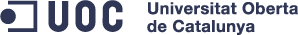
        </div>
        <div class="col-md-5">
            <h1 style="margin:15px 0px 0px;font-size: 40px;">Tipología y ciclo de vida de los datos</h1>
            <div style="text-align:left;margin-top: 80px;"></div>
        </div>
    </div>
    <div class="row" style="background: #FCB517;padding: 15px 30px;">
        <div class="col-md-6">
            <div style="text-align:center;"> </div>
        </div>
    </div>
</div>
<!--/Header-->

<style type="text/css">code{white-space: pre;}</style>
<style type="text/css">
  pre:not([class]) {
    background-color: white;
  }
</style>
<script type="text/javascript">
if (window.hljs) {
  hljs.configure({languages: []});
  hljs.initHighlightingOnLoad();
  if (document.readyState && document.readyState === "complete") {
    window.setTimeout(function() { hljs.initHighlighting(); }, 0);
  }
}
</script>



<style type="text/css">
h1 {
  font-size: 34px;
}
h1.title {
  font-size: 38px;
}
h2 {
  font-size: 30px;
}
h3 {
  font-size: 24px;
}
h4 {
  font-size: 18px;
}
h5 {
  font-size: 16px;
}
h6 {
  font-size: 12px;
}
.table th:not([align]) {
  text-align: left;
}
</style>




<style type="text/css">
.main-container {
  max-width: 940px;
  margin-left: auto;
  margin-right: auto;
}
code {
  color: inherit;
  background-color: rgba(0, 0, 0, 0.04);
}
img {
  max-width:100%;
}
.tabbed-pane {
  padding-top: 12px;
}
.html-widget {
  margin-bottom: 20px;
}
button.code-folding-btn:focus {
  outline: none;
}
summary {
  display: list-item;
}
</style>



<!-- tabsets -->

<style type="text/css">
.tabset-dropdown > .nav-tabs {
  display: inline-table;
  max-height: 500px;
  min-height: 44px;
  overflow-y: auto;
  background: white;
  border: 1px solid #ddd;
  border-radius: 4px;
}

.tabset-dropdown > .nav-tabs > li.active:before {
  content: "";
  font-family: 'Glyphicons Halflings';
  display: inline-block;
  padding: 10px;
  border-right: 1px solid #ddd;
}

.tabset-dropdown > .nav-tabs.nav-tabs-open > li.active:before {
  content: "";
  border: none;
}

.tabset-dropdown > .nav-tabs.nav-tabs-open:before {
  content: "";
  font-family: 'Glyphicons Halflings';
  display: inline-block;
  padding: 10px;
  border-right: 1px solid #ddd;
}

.tabset-dropdown > .nav-tabs > li.active {
  display: block;
}

.tabset-dropdown > .nav-tabs > li > a,
.tabset-dropdown > .nav-tabs > li > a:focus,
.tabset-dropdown > .nav-tabs > li > a:hover {
  border: none;
  display: inline-block;
  border-radius: 4px;
  background-color: transparent;
}

.tabset-dropdown > .nav-tabs.nav-tabs-open > li {
  display: block;
  float: none;
}

.tabset-dropdown > .nav-tabs > li {
  display: none;
}
</style>

<!-- code folding -->




</head>

<body>


<div class="container-fluid main-container">




<div class="fluid-row" id="header">


<hr />
<hr />
<hr />
<h1 class="title toc-ignore">Práctica 2: ¿Cómo realizar la limpieza y análisis de datos?</h1>
<h4 class="author">Agustin Rovira Quezada & Adrian Vega Morales</h4>
<hr />
<hr />
<hr />
</div>

<div id="TOC">
<ul>
<li><a href="#introducción"><span class="toc-section-number">1</span> Descripción del dataset</a></li>
<li><a href="#enunciado"><span class="toc-section-number">2</span> Integración y selección</a></li>
<li><a href="#ejercicios"><span class="toc-section-number">3</span> Limpieza de los datos</a><ul>
<li><a href="#ejercicio-1"><span class="toc-section-number">3.1</span> Gestiona elementos nulos</a></li>
<li><a href="#ejercicio-2"><span class="toc-section-number">3.1</span> Gestiona outliers</a></li>
</ul></li>
<li><a href="#rúbrica"><span class="toc-section-number">4</span> Análisis de los datos</a><ul>
<li><a href="#ejercicio-41"><span class="toc-section-number">4.1</span> Seleccion de Grupos</a></li>
<li><a href="#ejercicio-42"><span class="toc-section-number">4.2</span> Comprobar Normalidad</a></li>
<li><a href="#ejercicio-43"><span class="toc-section-number">4.3</span> Pruebas Estadisticas</a></li>
</ul></li>
<li><a href="#ejercicio-5"><span class="toc-section-number">5</span> Representación de los resultados</a></li>
<li><a href="#ejercicio-6"><span class="toc-section-number">6</span> Resolución del problema</a></li>
</ul>
</div>
</body>
<hr />
<hr />
<hr />

In [191]:
import pandas as pd
import os
import re
import io
import datetime as dt
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils import resample
import statsmodels.api as sm
from scipy import stats
import numpy as np
import scipy.stats as ss
import pingouin as pg
from scipy.stats import bartlett
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import cluster

In [2]:
df=pd.read_csv("US_Accidents_dataset.csv")
ds=df.copy()

<div id="introducción" class="section level1">
<h1><span class="header-section-number">1.</span> Descripción del dataset</h1>
<hr />
</div>

<div id="enunciado" class="section level1">
<h1><span class="header-section-number">2.</span> Integración y selección</h1>
<hr />
</div>

Tras una primera exploracion descriptiva y una lectura comprensiva del significado de cada variable, podemos ver que es posible
seleccionar un subconjunto de variables con el que trabajar. 

In [3]:
df.head(5)

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day


In [4]:
buf = io.StringIO()
df.info(buf=buf)
s = buf.getvalue()
lines = [line.split() for line in s.splitlines()[6:-2]]
info=pd.DataFrame(lines,columns=["d","Variable","Tipo"]).drop("d", axis=1)
info

,Variable,Tipo
0,Severity,int64
1,Start_Time,object
2,End_Time,object
3,Start_Lat,float64
4,Start_Lng,float64
5,End_Lat,float64
6,End_Lng,float64
7,Distance(mi),float64
8,Description,object
9,Number,float64


In [5]:
df.shape

(2845342, 47)

##### Columns tipo Bool
Empezando con las variables tipo bolean podemos ver que las 13 variables no estan balanceadas, todas tienen mas de un 98% de frecuencia para el valor "False". Por lo tanto estas variables pueden ser eliminadas ya que no aportan informacion relevante.

Como se aplicamos una subseleccion con .iloc

In [6]:
#Variable Bool
describe=df.describe(include="bool").T
describe["freq"]=describe["freq"].apply(lambda x: round(100*(x/df.shape[0])))
describe

,count,unique,top,freq
Amenity,2845342,2,False,99
Bump,2845342,2,False,100
Crossing,2845342,2,False,93
Give_Way,2845342,2,False,100
Junction,2845342,2,False,90
No_Exit,2845342,2,False,100
Railway,2845342,2,False,99
Roundabout,2845342,2,False,100
Station,2845342,2,False,98
Stop,2845342,2,False,98


In [7]:
#Eliminacion
bool_idx=[x for x in df.dtypes!="bool"]
df=df.iloc[:, bool_idx]

##### Columns tipo Object

Se observa que muchas de las columnas de este tipo estan desbalanceadas, tiene un 70% de frecuencia para una de los factores. Por lo tanto los eliminaremos las columnas ['Country', 'Astronomical_Twilight', 'Civil_Twilight', 'Sunrise_Sunset', 'Nautical_Twilight', 'Side']


Por otro lado, hay otras columnas que carecen de significado para el analisis que se va a realizar por lo cual tambien se eliminaran. Estas son las siguientes [Timezone,ID,Description,County]

In [8]:
#Variable object
describe=df.describe(include="object").T.sort_values(by=["unique"])
describe

,count,unique,top,freq
Country,2845342,1,US,2845342
Astronomical_Twilight,2842475,2,Day,2176983
Civil_Twilight,2842475,2,Day,1929103
Sunrise_Sunset,2842475,2,Day,1811935
Nautical_Twilight,2842475,2,Day,2063472
Side,2845342,3,R,2353309
Timezone,2841683,4,US/Eastern,1221927
Wind_Direction,2771567,24,CALM,433622
State,2845342,49,CA,795868
Weather_Condition,2774706,127,Fair,1107194


In [9]:
Object_drop=describe.loc[describe["unique"]<=3,["freq"]].apply(lambda x: 100*(x/df.shape[0])).index.tolist()
df.drop(Object_drop,inplace=True,axis=1)

toDrop=["Timezone","ID","Description","County"]
df.drop(toDrop,inplace=True,axis=1)

##### Coulmns tipo numeric
De las columnas tipo numericas solo tenemos que eliminar Number ya que pose mas de un 90% de NANs


In [10]:
#Variable numericas
describe=df.describe().T
describe["count"]=describe["count"].apply(lambda x: round(100*(x/df.shape[0])))
describe

,count,mean,std,min,25%,50%,75%,max
Severity,100,2.137572,0.478722,1.000000,2.000000,2.000000,2.000000,4.000000e+00
Start_Lat,100,36.245201,5.363797,24.566027,33.445174,36.098609,40.160243,4.900058e+01
Start_Lng,100,-97.114633,18.317819,-124.548074,-118.033113,-92.418076,-80.372431,-6.711317e+01
End_Lat,100,36.245321,5.363873,24.566013,33.446278,36.097987,40.161049,4.907500e+01
End_Lng,100,-97.114387,18.317632,-124.545748,-118.033331,-92.417718,-80.373383,-6.710924e+01
Distance(mi),100,0.702678,1.560361,0.000000,0.052000,0.244000,0.764000,1.551860e+02
Number,39,8089.408114,18360.093995,0.000000,1270.000000,4007.000000,9567.000000,9.999997e+06
Temperature(F),98,61.793556,18.622629,-89.000000,50.000000,64.000000,76.000000,1.960000e+02
Wind_Chill(F),83,59.658231,21.160967,-89.000000,46.000000,63.000000,76.000000,1.960000e+02
Humidity(%),97,64.365452,22.874568,1.000000,48.000000,67.000000,83.000000,1.000000e+02


In [11]:
df.drop(["Number"],inplace=True,axis=1)

##### Transformacion de columnas

In [12]:
df['Month'] = pd.to_datetime(df["Weather_Timestamp"]).apply(lambda x: dt.datetime.date(x).month)
df['Time'] = pd.to_datetime(df["Weather_Timestamp"]).apply(lambda x: dt.datetime.time(x).hour)
df['Year'] = pd.to_datetime(df["Weather_Timestamp"]).apply(lambda x: dt.datetime.date(x).year)
df['Duration'] =  pd.to_datetime(df['End_Time'])-pd.to_datetime(df['Start_Time'])
df['Duration'] = df['Duration'].apply(lambda x:round(x.total_seconds()/60) )
df.drop(["Weather_Timestamp","End_Time","Start_Time"],axis=1,inplace=True)

def mappers(df):
    horas=[list(range(x-6,x)) for x in  range(6,30,6)]
    rangos=["0-5","6-11","12-17","18-23"]
    mapTime = {j:i  for e,i in zip(horas,rangos) for j in e}
    df['Time']=df['Time'].map(mapTime)
    
    mapMonth={m:calendar.month_name[m] for m in range(1,13)}
    df['Month']=df['Month'].map(mapMonth)
    
    mapWind={'SW':"SW", 'WSW':"W", 'West':"W", 'NNW':"N", 'WNW':'W', 'NW':'NW', 'W':'W', 'SSW':"S", 'East':"E", 'SE':'SE',
    'North':"N", 'ENE':'E', 'NNE':"N", 'NE':'NE', 'SSE':"S", 'CALM':"C", 'South':"S", 'ESE':"E", 'S':'S',
    'Variable':"V", 'VAR':"V", 'N':"N", 'E':"E"}
    df['Wind_Direction']=df['Wind_Direction'].map(mapWind)
    
    return df

df=mappers(df)

Como resultado nos quedaremos con 21 columnas de 47.  

['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Street', 'State', 'Zipcode', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition']

<div id="ejercicios" class="section level1">
<h1><span class="header-section-number">3.</span> Limpieza de los datos</h1>
<hr />
</div>

<div id="ejercicio-1" class="section level2">
<h2><span class="header-section-number">3.1</span> ¿Los datos contienen ceros o elementos vacíos? Gestiona cada uno de estos casos</h2>
<hr />
</div>

In [15]:
Nan_Columns=pd.DataFrame(df.isna().sum().sort_values(ascending=False),columns=["NANs"])
Nan_Columns=Nan_Columns.loc[Nan_Columns["NANs"]!=0,["NANs"]]
Nan_Columns["Porcentage"]=  round(100*(Nan_Columns["NANs"]/df.shape[0]))
NanList=Nan_Columns.index.tolist()
Nan_Columns

,NANs,Porcentage
Precipitation(in),549458,19.0
Wind_Chill(F),469643,17.0
Wind_Speed(mph),157944,6.0
Wind_Direction,150309,5.0
Humidity(%),73092,3.0
Weather_Condition,70636,2.0
Visibility(mi),70546,2.0
Temperature(F),69274,2.0
Pressure(in),59200,2.0
Airport_Code,9549,0.0


Se observo en el bloque anterior que habia missing values en el aiport_code y aunque es una de las columnas a eliminar porque no son necesarias para el analisis posterior si que la vamos a usar para eliminar registros de condiciones climatologicas como Precipitation. Esto se decidio asi ya que si no hay registro de condiciones meteorologicas para un accidente no podemos usarlos para el analisis de agrupacion o regresion.

Por otro lado las variables Precipitation(in) y Wind_Chill(F) tiene un porcentage de NaNs de casi un 20%, un valor muy alto para una inputacion. Por lo cual optaremos por eliminar esas filas. 

In [16]:
def CountNans(df):
    Nan_Columns=pd.DataFrame(df.isna().sum().sort_values(ascending=False),columns=["NANs"])
    Nan_Columns=Nan_Columns.loc[Nan_Columns["NANs"]!=0,["NANs"]]
    Nan_Columns["Porcentage"]=  100*(Nan_Columns["NANs"]/df.shape[0])
    NanList=Nan_Columns.index.tolist()
    print(Nan_Columns)
    
    return NanList

In [17]:
df=df.dropna(subset=['Airport_Code',"Precipitation(in)","Wind_Chill(F)","City"])
NanList=CountNans(df)

                   NANs  Porcentage
Visibility(mi)     6739    0.302797
Weather_Condition  6531    0.293451
Humidity(%)        3201    0.143827
Pressure(in)       1445    0.064927
Wind_Direction       14    0.000629
Street                1    0.000045


Vamos a imputar los valores con una media una ventana movil en un rango de una hora. Para dicha imputacion se tendra que cargar el dataset otra vez y clasificar los valores por estado y horas. Esto se hara para Visibility(mi), Weather_Condition, Humidity(%), Pressure(in)

In [18]:
toImp=["Visibility(mi)", "Humidity(%)", "Pressure(in)"]
for i in toImp:
    df[i] = df.groupby(["City","Month","Time"])[i].transform(lambda x:x.fillna(x.mean()))

In [19]:
NanList=CountNans(df)

                   NANs  Porcentage
Weather_Condition  6531    0.293451
Visibility(mi)     1097    0.049290
Humidity(%)         259    0.011637
Pressure(in)        130    0.005841
Wind_Direction       14    0.000629
Street                1    0.000045


Tras la imputacion vemos que no hay demasiados valores con NaNs y que representan un valor insingnificante de porcentage. Por lo cual procedemos simplemente a eliminar esas filas

In [20]:
df=df.dropna(subset=['Visibility(mi)',"Humidity(%)","Pressure(in)","Wind_Direction","Weather_Condition","Wind_Direction"])

<div id="ejercicio-2" class="section level2">
<h2><span class="header-section-number">3.2</span> Identifica y gestiona los valores extremos</h2>
<hr />
</div>

Visualizamos como se distribuyen los factores de severity a lo largo del dataset. Como se vera en el plot la clase no esta balanceada. 

Los valores atípicos en los datos categóricos también pueden atribuirse al problema del desequilibrio de clases. Esto significa que los datos para cada clase no están en una proporción similar. En tal situación, utilizaremos tecnicas de muestreo, concretamente Muestra aleatoria simple con sustitución

In [21]:
df.Severity.value_counts()

2    2066877
3      64824
4      62733
1      23581
Name: Severity, dtype: int64

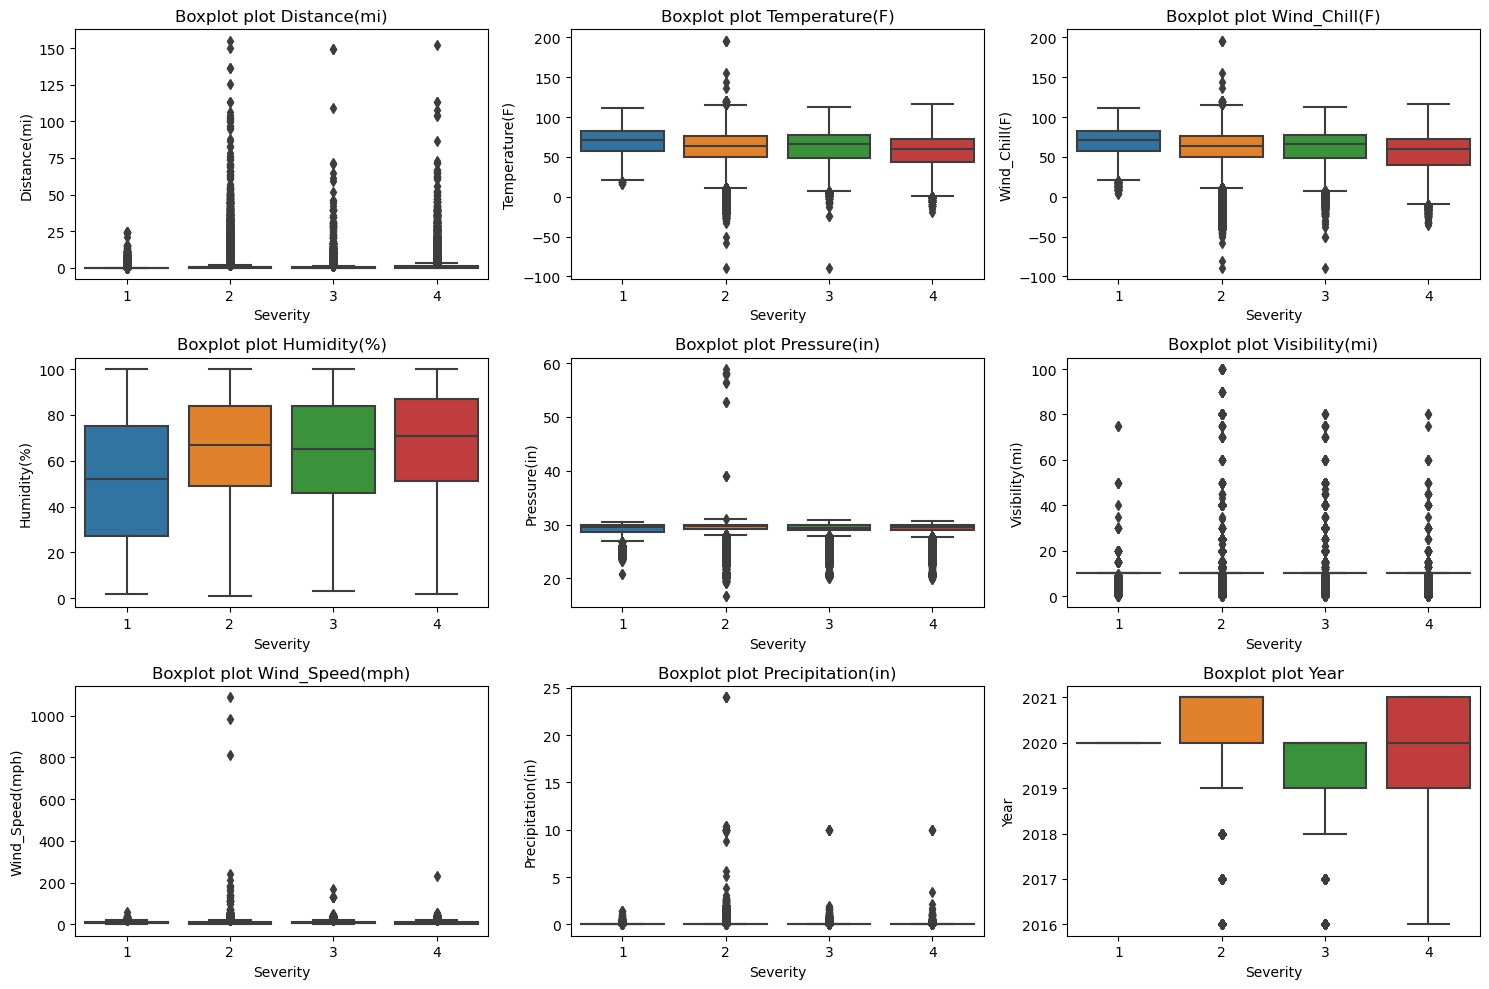

In [22]:
def BoxPLotOutlier(df):
    tmp=df.select_dtypes(include='number')
    tmp=tmp.loc[:, ~tmp.columns.isin(['Start_Lat', 'Start_Lng','End_Lat', 'End_Lng'])]
    cols=list(tmp.columns)[1:]
    
    fig, axis = plt.subplots(3,3,figsize=(15, 10))
    for ax,c in zip(axis.reshape(-1),cols):
        ax.set_title("Boxplot plot {}".format(c))
        sns.boxplot(x="Severity", y=c, data=tmp,ax=ax)
    plt.tight_layout()
    plt.show()

BoxPLotOutlier(df)

In [23]:
def Sampling(df):
    
    seed=234    
    s1 = df[df["Severity"] == 1]
    s2 = df[df["Severity"] == 2]
    s3 = df[df["Severity"] == 3]
    s4 = df[df["Severity"] == 4]

    s2_downsample = resample(s2,replace=True,n_samples=len(s1),random_state=seed)
    s3_downsample = resample(s3,replace=True,n_samples=len(s1),random_state=seed)
    s4_downsample = resample(s4,replace=True,n_samples=len(s1),random_state=seed)
    df=pd.concat([s1, s2_downsample,s3_downsample,s4_downsample]).reset_index(drop=True)
    
    return df

df=Sampling(df)
df=df.reset_index(drop=True)
df.Severity.value_counts()

1    23581
2    23581
3    23581
4    23581
Name: Severity, dtype: int64

<AxesSubplot:xlabel='Severity', ylabel='count'>

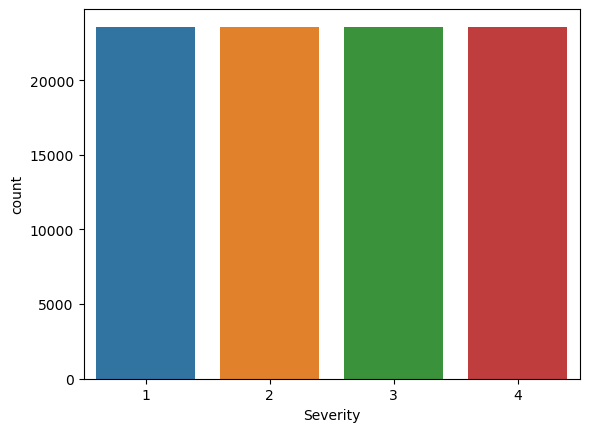

In [24]:
sns.countplot(x="Severity", data=df)

A continuacion visualizamos las variables independientes numericas contra la severidad para ver por una parte si las clases estan balanceadas respecto a las variables independientes, y por otro lado usaremos un boxplot para tomar la decision sobre que se puede considerar un valor extremo.

Para ciertas variables consideraremos outliers todo lo que se encuentra alejado 3 desviaciones estándar con respecto a la media del conjunto es un outlier.

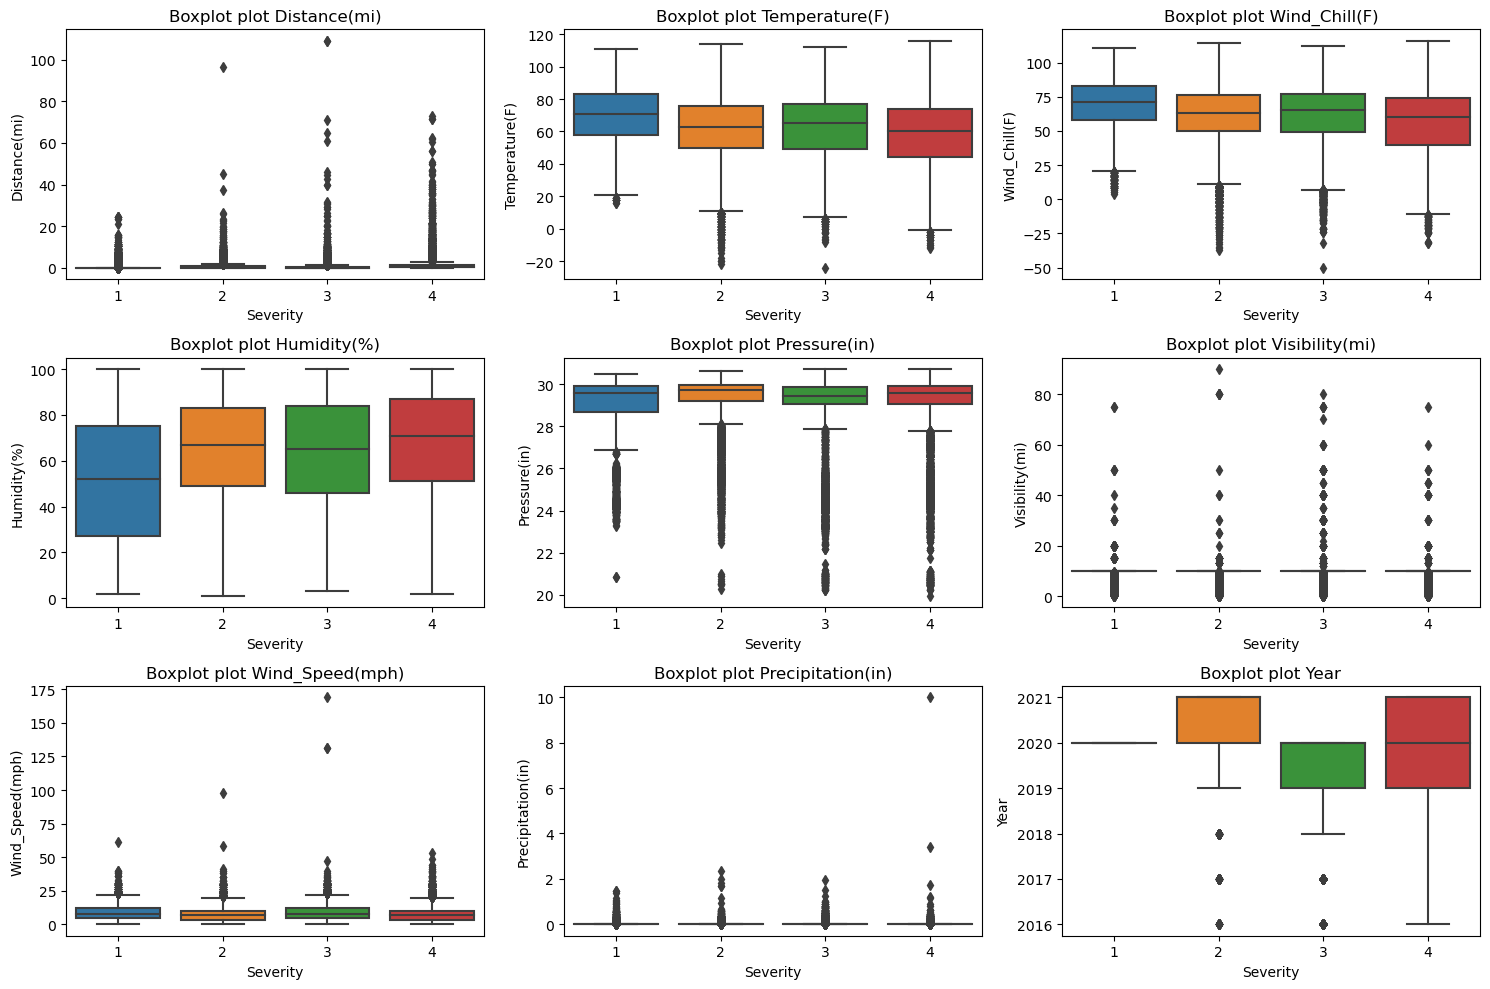

In [25]:
BoxPLotOutlier(df)

<Figure size 2000x600 with 0 Axes>

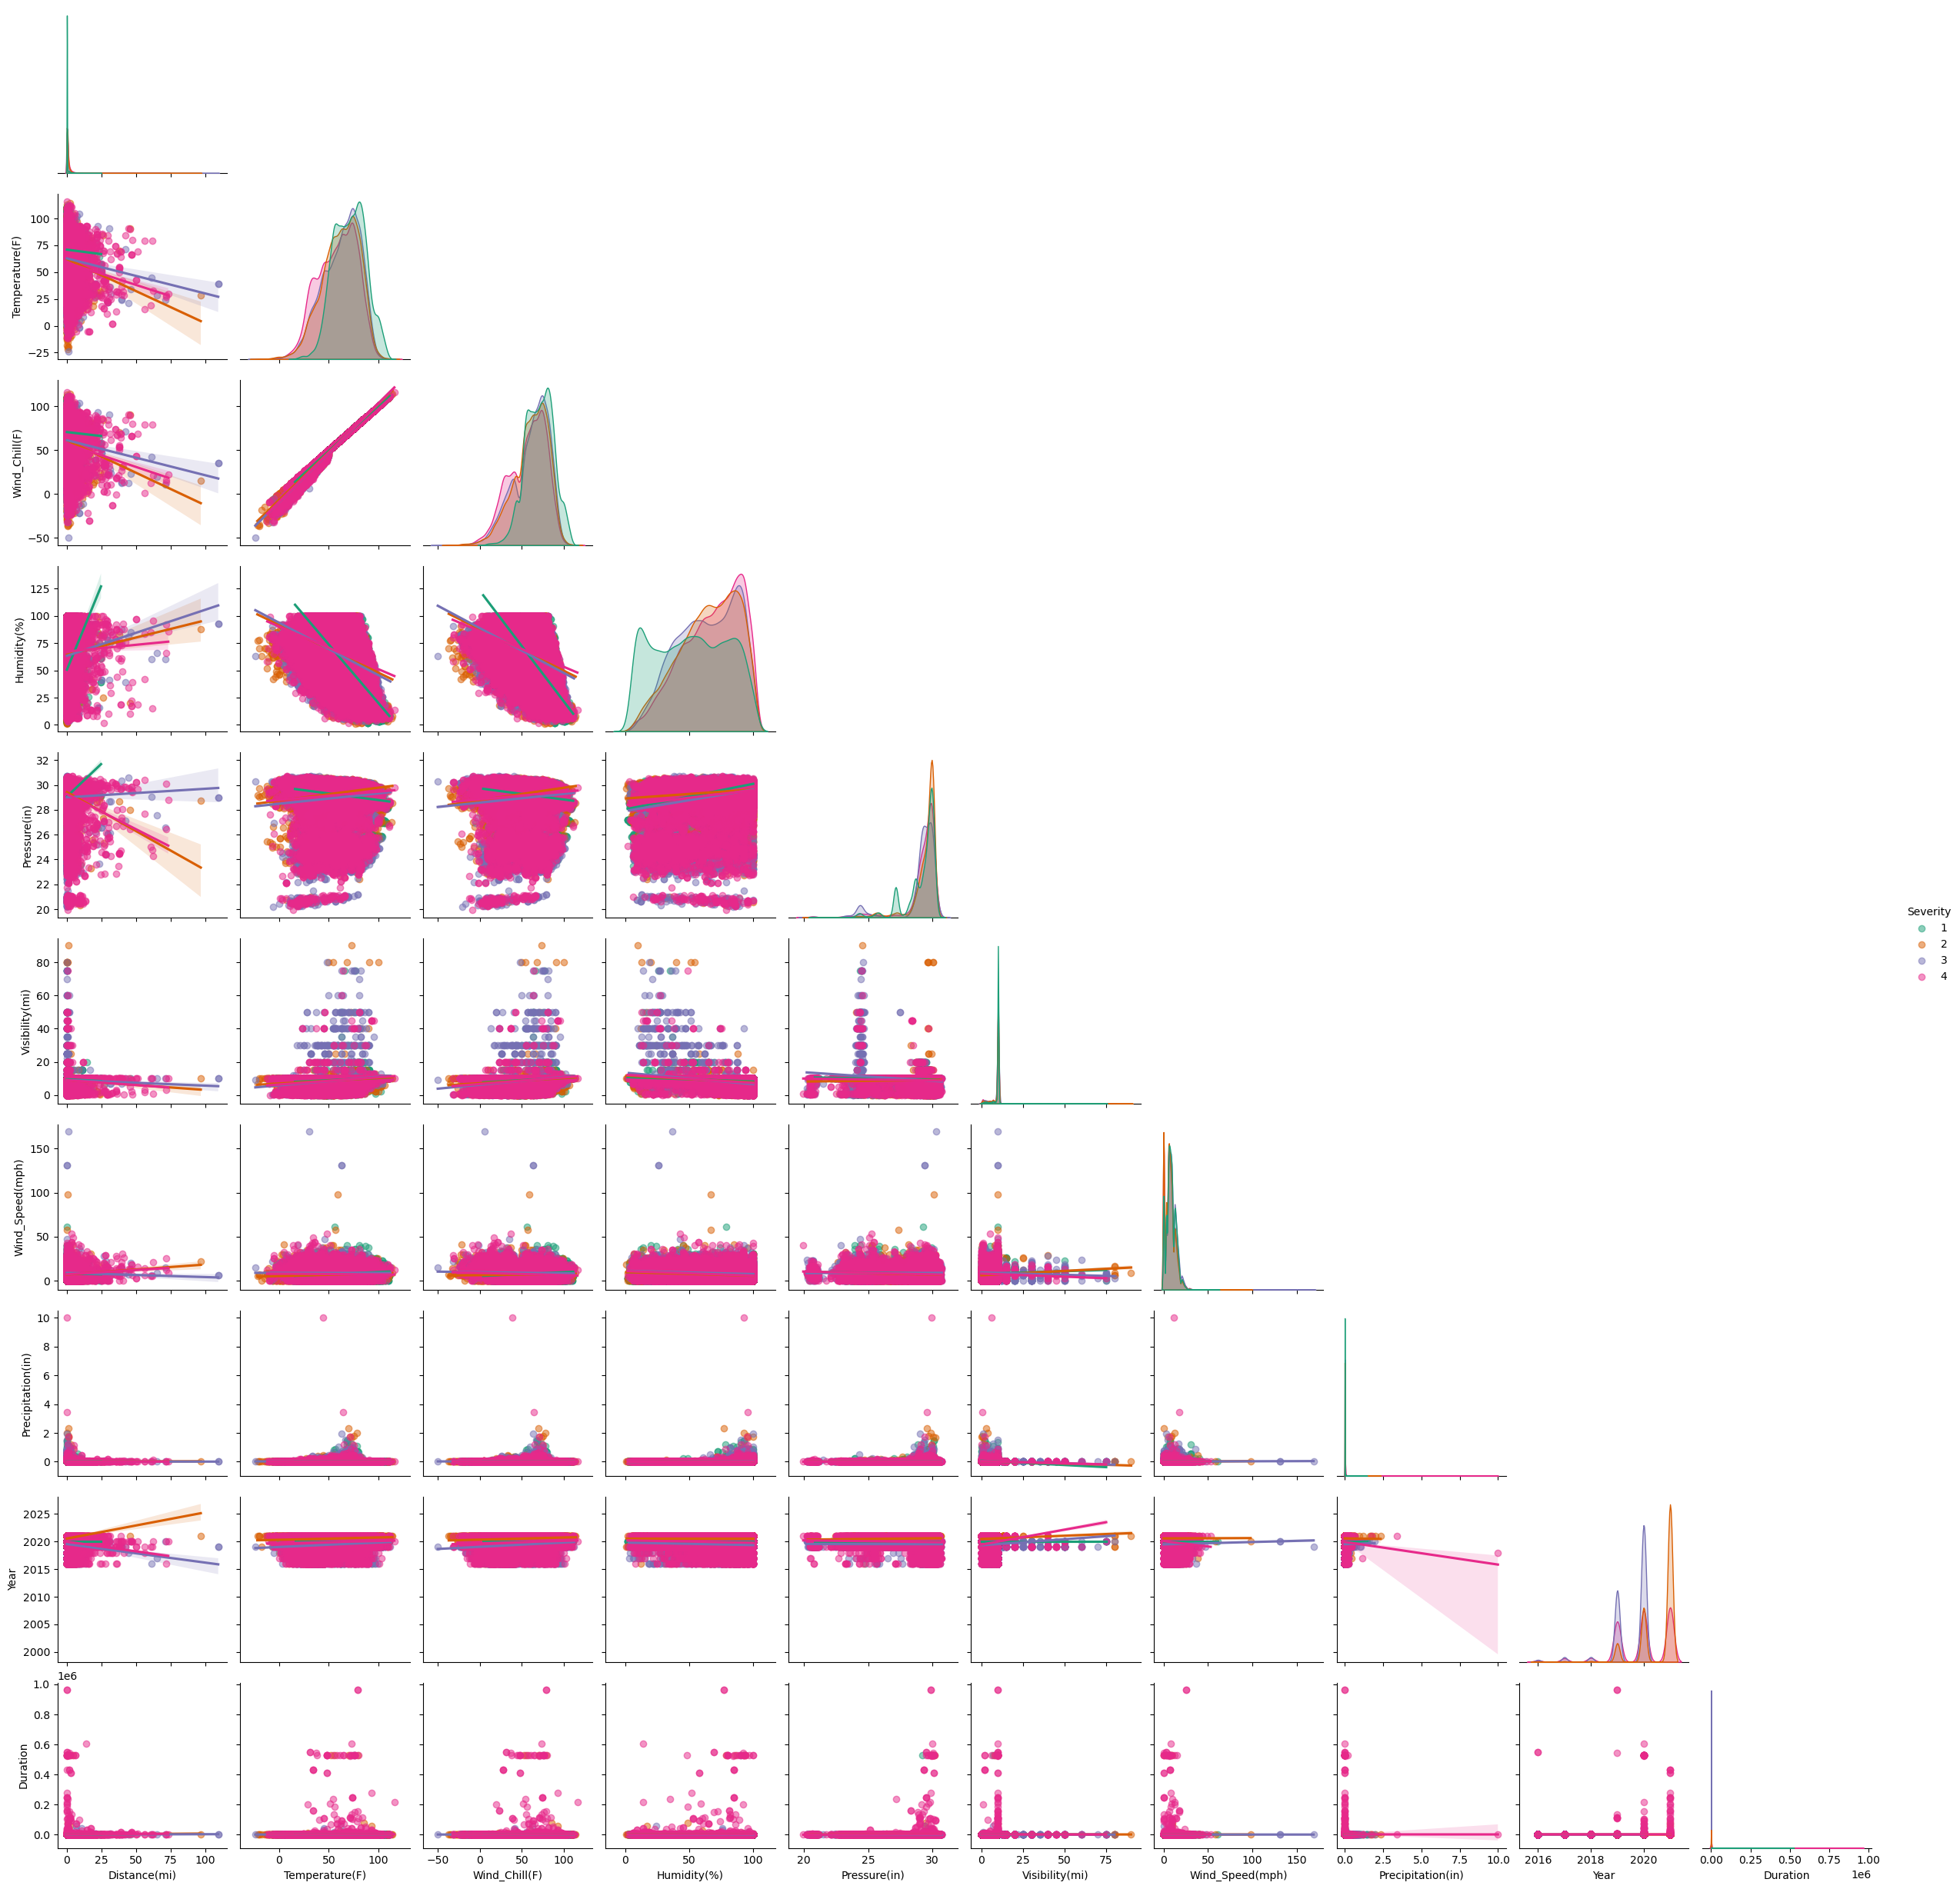

In [26]:
def PairPlot(df):
    tmp=df.select_dtypes(include='number')
    tmp['Severity']=tmp['Severity'].astype(object)
    tmp=tmp.loc[:, ~tmp.columns.isin(['Start_Lat', 'Start_Lng','End_Lat', 'End_Lng'])]
    plt.figure(figsize = (20, 6))
    sns.pairplot(tmp,hue="Severity",corner=True,kind='reg',diag_kind="kde",palette='Dark2',plot_kws={'scatter_kws': {'alpha': 0.5}})
PairPlot(df)

In [27]:
def remove_outliers(df,name):
    #Percentil
    q25,q75=np.percentile(df[name],25),np.percentile(df[name],75)
    #Interquartile range
    iqr=1.5*(q75-q25)
    #Limites
    lower,upper=q25-iqr,q75+iqr
    #Remove the outliers
    df=df[(df[name] >= lower) & (df[name] <= upper)]
    return df

df = remove_outliers(df,name='Temperature(F)')
df = remove_outliers(df,name='Wind_Chill(F)')
df = remove_outliers(df,name='Humidity(%)')
df = remove_outliers(df,name='Pressure(in)')
df = remove_outliers(df,name='Wind_Speed(mph)')

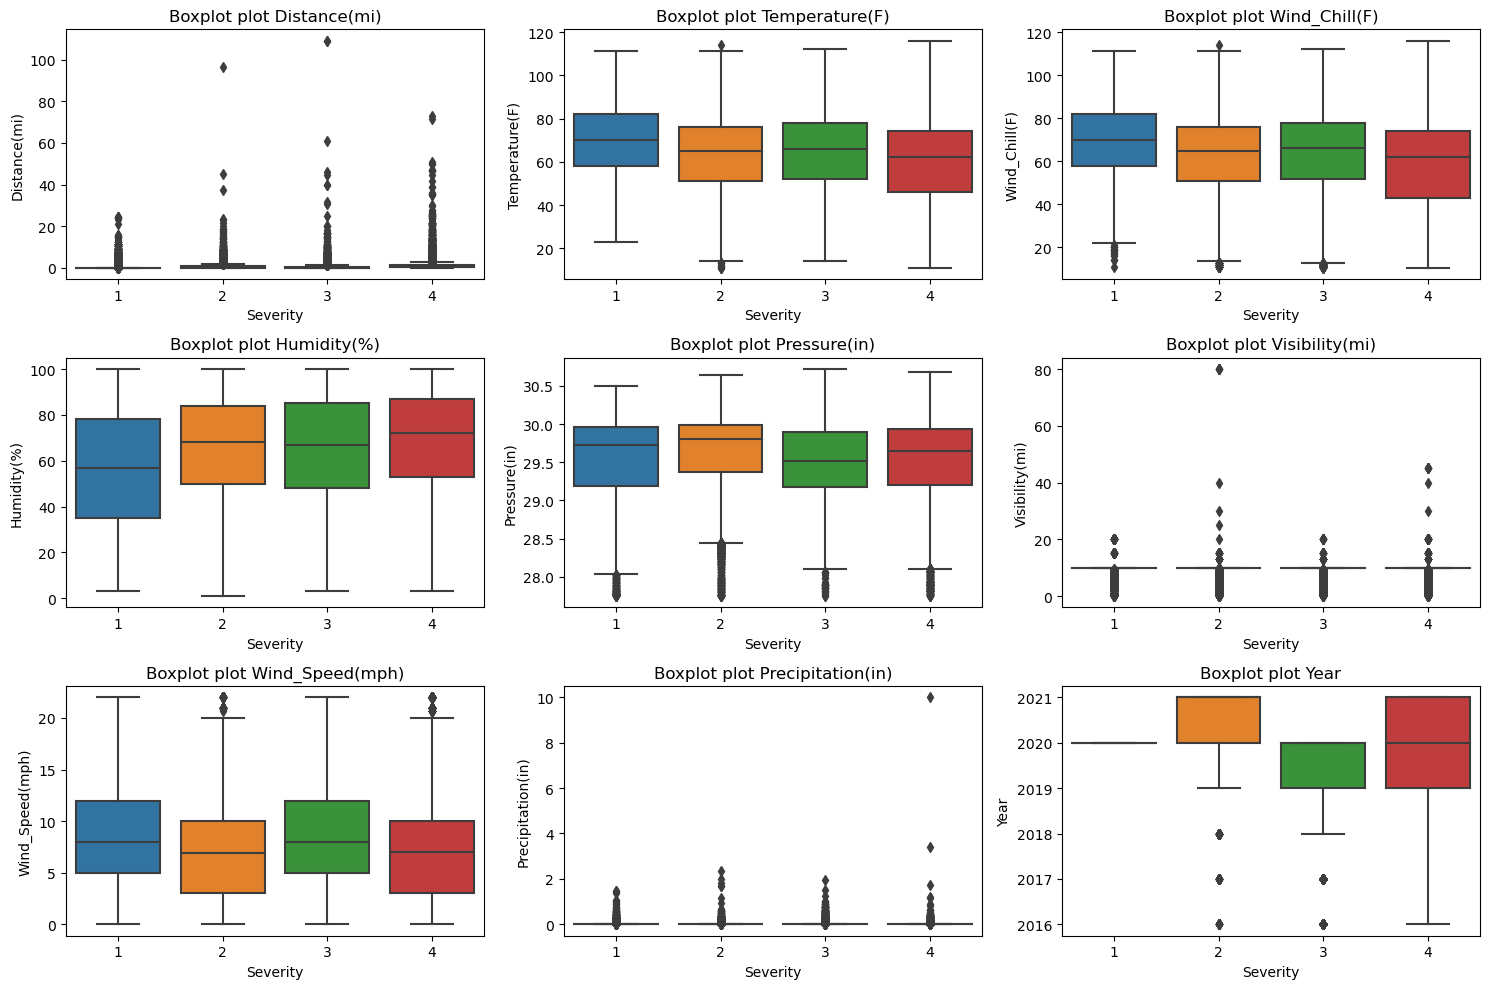

In [28]:
BoxPLotOutlier(df)

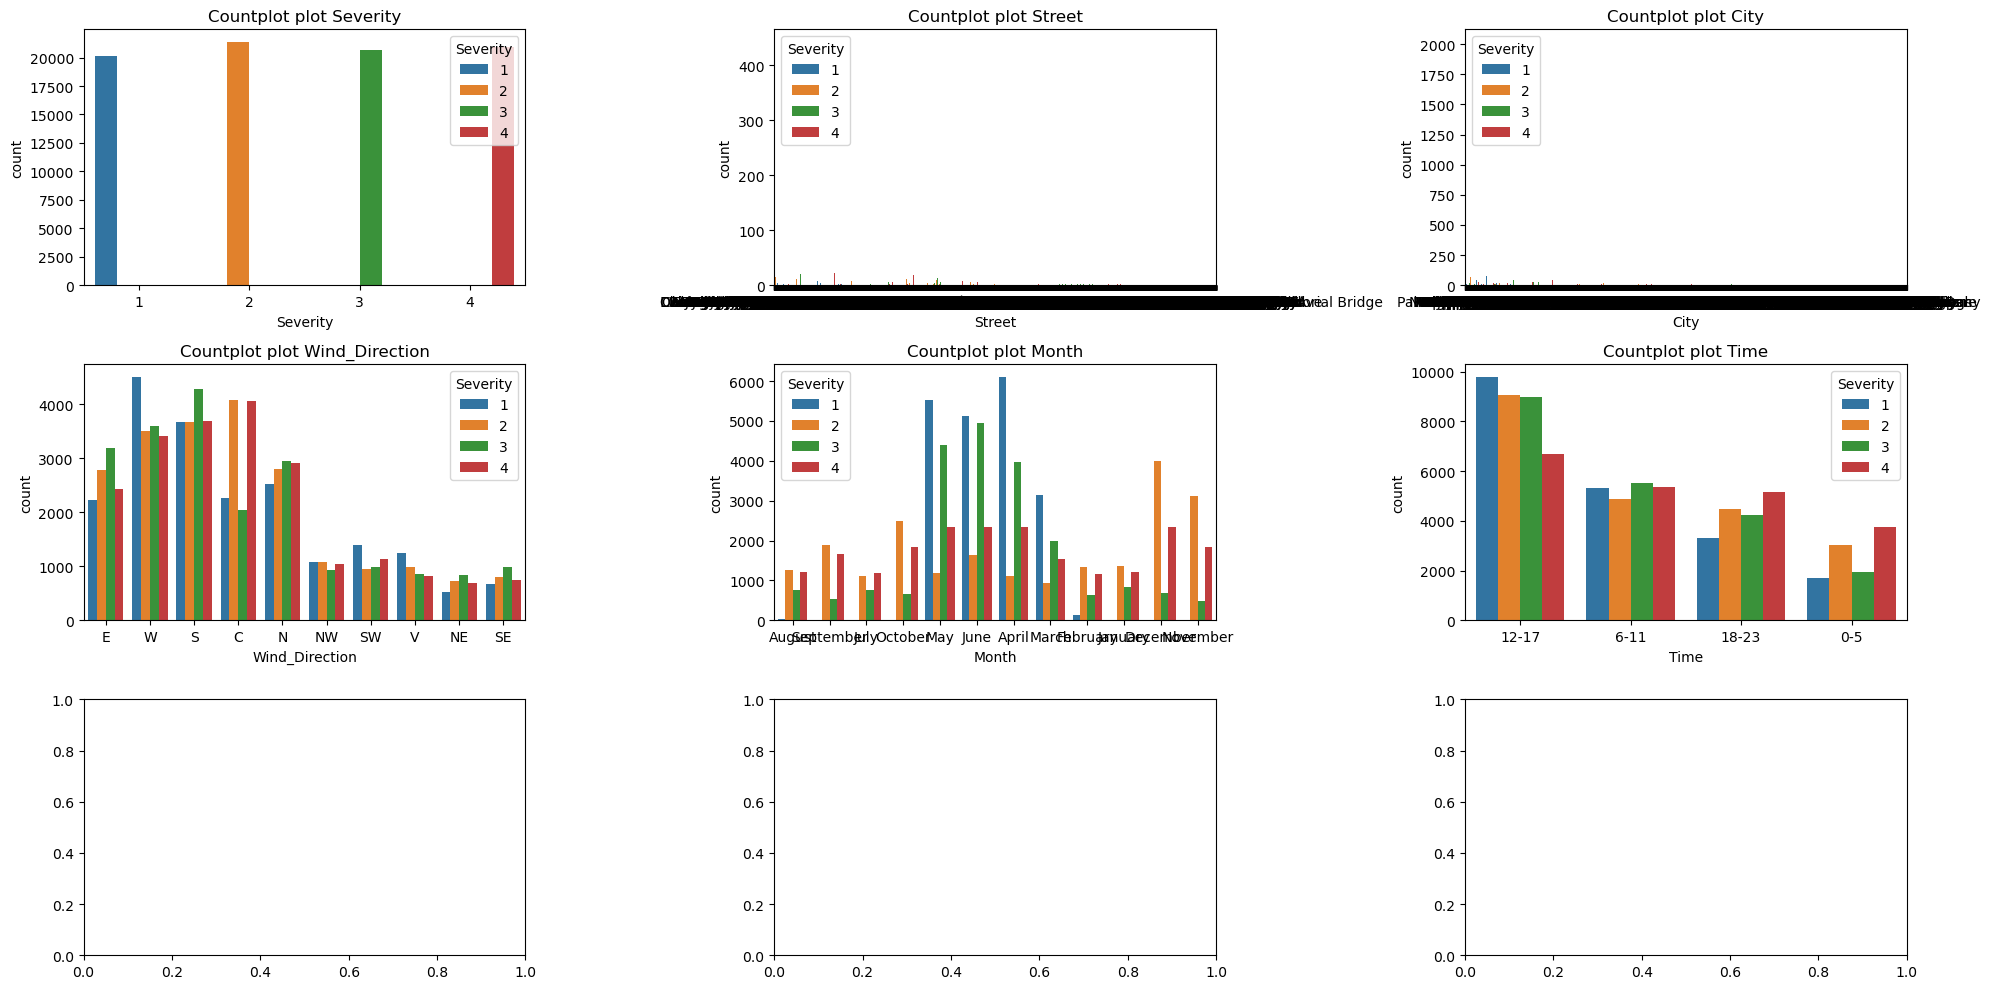

In [29]:
def CountPlotOutlier(df):
    var=['Street', 'City', 'Wind_Direction', 'Month', 'Time']
    tmp=df.loc[:,var]
    
    fig, axis = plt.subplots(3,3,figsize=(20, 10))
    for ax,c in zip(axis.reshape(-1),var):
        ax.set_title("Countplot plot {}".format(c))
        sns.countplot(hue="Severity", x=c, data=tmp,ax=ax)
    plt.tight_layout()
    plt.show()

CountPlotOutlier(df)

Vemos que hay una gran cantidad de outliers sobre todo para  los accidentes con severidad 2. Se va a limpiar los outliers usando la desviacion estandart y luego se volvera a comparar.

In [34]:
df['Severity'] = df['Severity'].astype('category')

<div id="rúbrica" class="section level1">
<h1><span class="header-section-number">4.</span> Análisis de los datos</h1>
<hr />
</div>

<div id="ejercicio-41" class="section level2">
<h2><span class="header-section-number">4.1</span> Seleccion de Grupos</h2>
<hr />    
Selección de los grupos de datos que se quieren analizar/comparar (p.ej., si se van a comparar grupos de datos, ¿cuáles son estos grupos y qué tipo de análisis se van a aplicar?   
<hr />
</div>

Dado que en el apartado 4.3 se va realizar un analisis de agrupacion y un analisis de clasificacion, separaremos el dataset en 2 datasets distintos con las variables necesarias para el analisis correspondiente.

1. Analisis de la regresion usaremos las siguientes variables atmosfericas:

    * Distance(mi) 
    * Temperature(F)
    * Wind_Chill(F)
    * Humidity(%)
    * Pressure(in)
    * Visibility(mi)
    * Wind_Direction
    * Wind_Speed(mph)
    * Precipitation(in)
    * Weather_Condition

    Se aplicara un modelo de regresion logistica multinomial, que incluira las variables citadas como predictoras del nivel de severidad de los accidentes.


2. En el analisis del clustering nos interesa saber los puntos geograficos, para observar donde se agrupan la mayoria de accidentes de trafico. Se usan las siguientes variables:

    * Start_Lat
    * Start_Lng


<div id="ejercicio-42" class="section level2">
<h2><span class="header-section-number">4.2</span> Comprobar Normalidad</h2>
<hr />
Comprobación de la normalidad y homogeneidad de la varianza
<hr />
</div>

##### Normalidad

Como se observa el sample size es mucho mayor que 100 por lo cual hay que acudir a un test distinto del Shapiro-Wilk Test para testear la normalidad. Por lo tanto recurrimos al test de Kolmogorov–Smirnov indicado para samples grandes.

Tal como se aplica aqui la  prueba de una muestra realiza una prueba de la distribución F(x) de una variable aleatoria observada contra una distribución dada G(x) (es decir, una distribución normal).

Siendo las Hipotesis:   
* Hipotesis Nula: Distribuciones identicas F(x)=G(x) para todo x   
* Hipotesis Alternativa: Distribuciones no identicas

Para la realizacion de este test en particular hemos escogido un sample 100 para cada variable y asi porder testear la normalidad

In [127]:
def NormalTest(data,nombre,pl=1):
    statistic,p_value=stats.kstest(data,'norm',N=100,args=(np.mean(data),np.std(data,ddof=1))) 
    
    # Interpretación
    normal=False

    alpha = 0.05
    if pl==1:
        if p_value>alpha:
            #print(nombre)
            print('La muestra es Normal. No se rechaza la hipótesis nula H0')
            normal=True
        else:
            #print(nombre)
            print('La muestra no es Normal. Se rechaza la hipótesis nula H0')
            normal=False

    return statistic,p_value,normal



def sampletest(df):
    dfs = df.sample(n=100,replace=True)
    df_input=dfs.select_dtypes(include=np.number)
    s=pd.DataFrame([NormalTest(df_input[column],column,pl=0) for column in df_input],columns=["Stats","P-value","Normal"])
    s["Variable"]=[column for column in df_input]
    
    
    return s

s=sampletest(df)
s

,Stats,P-value,Normal,Variable
0,0.099033,2.627382e-01,False,Start_Lat
1,0.183666,2.002624e-03,False,Start_Lng
2,0.098821,2.649803e-01,False,End_Lat
3,0.183654,2.004334e-03,False,End_Lng
4,0.326756,5.222017e-10,False,Distance(mi)
5,0.064717,7.717022e-01,False,Temperature(F)
6,0.074338,6.114593e-01,False,Wind_Chill(F)
7,0.135529,4.604524e-02,False,Humidity(%)
8,0.154916,1.461541e-02,False,Pressure(in)
9,0.477527,1.766924e-21,False,Visibility(mi)


Observamos que ninguna de las variables del dataset es normal. Sin embargo, dado que tamaño del dataset es lo suficientemente grande (es decir,> 30), es posible asumir la normalidad de acuerdo con el Teorema del límite central.

#####  homogeneidad de la varianza

Aunque asumimos que los datos siguen una distribucion normal, por el teorema del limite central. Ya que vamos a usar un sample pequeño que no sera normal usamos el test Levene para  la comprobación de la homocedasticidad entre los grupos de la variable dependiente Severity.   

Siendo las Hipotesis:     
* Hipotesis Nula: Asume igualdad de varianzas en los diferentes grupos de datos, por lo que p-valores inferiores al nivel de significancia indicarán heterocedasticidad.  

* Hipotesis Alternativa: No asume igualdad de varianzas en los diferentes grupos de datos   


In [198]:
def TestHomocedasticidad(data,nombre):
    # Levene's Test in Python using Pingouin
    S =pg.homoscedasticity(data, dv=nombre, group='Severity',center="median")
    return S.loc["levene","W"],S.loc["levene","pval"],S.loc["levene","equal_var"]
    
    #s1=data.loc[data['Severity']==1,nombre].tolist()
    #s2=data.loc[data['Severity']==2,nombre].tolist()
    #s3=data.loc[data['Severity']==3,nombre].tolist()
    #s4=data.loc[data['Severity']==4,nombre].tolist()
    #stat, p = bartlett(s1, s2, s3,s4)
    #alpha=0.5
    #normal=False
    #if p>alpha:
    #    normal=True
    #else:
    #    normal=False
    #return stat, p, normal

def SampleHomocedasticidad(df):
    dfs = df #df.sample(n=1000,replace=True)
    var_name=[column for column in dfs.select_dtypes(include=np.number)]
    variables=var_name + ['Severity']
    df_input=dfs[variables]
    s=[TestHomocedasticidad(df_input.loc[:,['Severity',column]],column) for column in var_name]
    df_var=pd.DataFrame(s,columns=["W","P-value","equal_var"])
    #df_var=pd.DataFrame(s,columns=["stat","p","equal_var"])
    df_var["Variable"]=var_name
    
    return df_var
   
df_var=SampleHomocedasticidad(df)
df_var

,W,P-value,equal_var,Variable
0,173.911815,2.093227e-112,False,Start_Lat
1,2158.699753,0.000000e+00,False,Start_Lng
2,173.744800,2.683690e-112,False,End_Lat
3,2158.585710,0.000000e+00,False,End_Lng
4,661.911845,0.000000e+00,False,Distance(mi)
5,180.077515,2.173739e-116,False,Temperature(F)
6,317.413338,6.144525e-205,False,Wind_Chill(F)
7,559.327543,0.000000e+00,False,Humidity(%)
8,259.190867,1.918641e-167,False,Pressure(in)
9,208.548892,8.922352e-135,False,Visibility(mi)


Observamos que ninguna de las variables tiene igualdad de varianza entre los grupos de Severidad. Esto en parte se puede deber al sample size del dataset, ya que entre mas datos mayor sera la variabilidad entre los grupos.

Sin embargo, La regresión logística no hace muchas de las suposiciones clave de la regresión lineal y los modelos lineales generales que se basan en algoritmos de mínimos cuadrados ordinarios, en particular con respecto a la linealidad, la normalidad, la homocedasticidad y el nivel de medición.

Por lo tanto no aplicaremos ninguna transformacion como  cuadrada,logistica,etc sobre los datos.

https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/assumptions-of-logistic-regression/

<div id="ejercicio-43" class="section level2">
<h2><span class="header-section-number">4.3</span> Pruebas Estadisticas</h2>
<hr />    
Aplicación de pruebas estadísticas para comparar los grupos de datos. En función de los datos y el objetivo del estudio, aplicar pruebas de contraste de hipótesis, correlaciones, regresiones, etc. Aplicar al menos tres métodos de análisis diferentes.
    
<hr />
</div>


##### Analisis de correlacion
Análisis de los factores que influyen en la severidad. Correlaciones y regresión logística multinomial.

In [201]:
# Función para normalizar dataframe
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [202]:
# Compute the correlation matrix
df_new = df[['Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)','Precipitation(in)', 'Weather_Condition']]

df_new.head()

,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition
2,0.0,68.0,68.0,93.0,29.14,9.0,E,5.0,0.02,Light Rain with Thunder
3,0.0,98.0,98.0,18.0,28.28,10.0,W,5.0,0.00,Fair
4,0.0,95.0,95.0,22.0,29.90,10.0,W,9.0,0.00,Fair
5,0.0,81.0,81.0,79.0,29.20,10.0,S,7.0,0.01,Mostly Cloudy
6,0.0,71.0,71.0,81.0,27.81,10.0,C,0.0,0.00,Partly Cloudy


<AxesSubplot:>

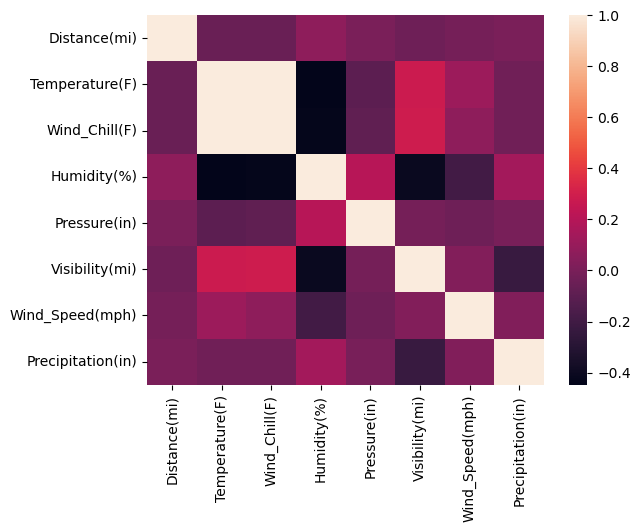

In [203]:
# Calculamos la matriz de correlación para las variables numéricas y las visualizamos con la librería seaborn
df_numerical = df_new[['Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Speed(mph)','Precipitation(in)']]

df_normalizado = mean_norm(df_numerical)

corr = df_normalizado.corr()

sns.heatmap(corr)

In [204]:
pd.DataFrame(corr)

,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
Distance(mi),1.000000,-0.053888,-0.057526,0.068994,0.001495,-0.036577,-0.014219,0.002098
Temperature(F),-0.053888,1.000000,0.994832,-0.447813,-0.097641,0.279483,0.114223,-0.031880
Wind_Chill(F),-0.057526,0.994832,1.000000,-0.432616,-0.088786,0.285641,0.071549,-0.031853
Humidity(%),0.068994,-0.447813,-0.432616,1.000000,0.207449,-0.409717,-0.195245,0.139950
Pressure(in),0.001495,-0.097641,-0.088786,0.207449,1.000000,-0.014960,-0.036661,-0.002785
Visibility(mi),-0.036577,0.279483,0.285641,-0.409717,-0.014960,1.000000,0.032860,-0.228823
Wind_Speed(mph),-0.014219,0.114223,0.071549,-0.195245,-0.036661,0.032860,1.000000,0.027097
Precipitation(in),0.002098,-0.031880,-0.031853,0.139950,-0.002785,-0.228823,0.027097,1.000000


Tras normalizar los datos y calcular los coeficientes de correlación observamos como *Temperature(F)* y *Wind_Chill(F)* están totalmente correlacionados.

A continuación comprobaré como se correlacionan las variables categóricas *weather_condition* y *wind_direction* con el resto de variables numéricas por medio del cálculo de ANOVAs.

In [205]:
def multiple_anovas(df, cat_item, num_item):
    from scipy.stats import f_oneway
    category_list = df.groupby(cat_item)[num_item].apply(list)
    anova_result = f_oneway(*category_list)
    print(f'P-value for {cat_item} and {num_item} ANOVA is {anova_result[1]}')
    if anova_result[1] < 0.05:
        print('Rejected H0, both are correlated (95%)')
    else:
        print('Acepted H0, both are not correlated (95%)')

In [206]:
print('ANOVAs for "Wind_Direction"')
multiple_anovas(df_new, 'Wind_Direction', 'Distance(mi)')
multiple_anovas(df_new, 'Wind_Direction', 'Temperature(F)')
multiple_anovas(df_new, 'Wind_Direction', 'Wind_Chill(F)')
multiple_anovas(df_new, 'Wind_Direction', 'Humidity(%)')
multiple_anovas(df_new, 'Wind_Direction', 'Pressure(in)')
multiple_anovas(df_new, 'Wind_Direction', 'Visibility(mi)')
multiple_anovas(df_new, 'Wind_Direction', 'Wind_Speed(mph)')
multiple_anovas(df_new, 'Wind_Direction', 'Precipitation(in)')
print('ANOVAs for "Weather_Condition"')
multiple_anovas(df_new, 'Weather_Condition', 'Distance(mi)')
multiple_anovas(df_new, 'Weather_Condition', 'Temperature(F)')
multiple_anovas(df_new, 'Weather_Condition', 'Wind_Chill(F)')
multiple_anovas(df_new, 'Weather_Condition', 'Humidity(%)')
multiple_anovas(df_new, 'Weather_Condition', 'Pressure(in)')
multiple_anovas(df_new, 'Weather_Condition', 'Visibility(mi)')
multiple_anovas(df_new, 'Weather_Condition', 'Wind_Speed(mph)')
multiple_anovas(df_new, 'Weather_Condition', 'Precipitation(in)')

ANOVAs for "Wind_Direction"
P-value for Wind_Direction and Distance(mi) ANOVA is 0.0009698818959663366
Rejected H0, both are correlated (95%)
P-value for Wind_Direction and Temperature(F) ANOVA is 0.0
Rejected H0, both are correlated (95%)
P-value for Wind_Direction and Wind_Chill(F) ANOVA is 0.0
Rejected H0, both are correlated (95%)
P-value for Wind_Direction and Humidity(%) ANOVA is 0.0
Rejected H0, both are correlated (95%)
P-value for Wind_Direction and Pressure(in) ANOVA is 0.0
Rejected H0, both are correlated (95%)
P-value for Wind_Direction and Visibility(mi) ANOVA is 1.3614657032668732e-275
Rejected H0, both are correlated (95%)
P-value for Wind_Direction and Wind_Speed(mph) ANOVA is 0.0
Rejected H0, both are correlated (95%)
P-value for Wind_Direction and Precipitation(in) ANOVA is 2.3853159882842742e-29
Rejected H0, both are correlated (95%)
ANOVAs for "Weather_Condition"
P-value for Weather_Condition and Distance(mi) ANOVA is 3.008245014445999e-94
Rejected H0, both are corr

Correlación entre variables categóricas (V de Cramer)

In [207]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.to_numpy().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [208]:
confusion_matrix = pd.crosstab(df['Weather_Condition'], df['Wind_Direction'])
cramers_v(confusion_matrix)

0.09187909776290026

Este valor cercano a 0 nos indica la poca correlación entre ambas variables categóricas.

##### Analisis de Regresion

Aplicaré una regresión logística multinomial para comprobar como se relacionan estas variables con la severidad del accidente. Para las variables altamente correlacionadas puede omitirse una de ellas. Para aplicar correctamente regresiones logísticas e interpretarlas se ha seguido lo descrito en el siguiente enlace: https://www.datasklr.com/logistic-regression/multinomial-logistic-regression

In [210]:
# Elimino la columna Wind_Chill al estar altamente correlacionada con Temperature
X = df_normalizado[['Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Speed(mph)','Precipitation(in)']]
y = df['Severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 5)

In [211]:
logit_model = sm.MNLogit(y_train, sm.add_constant(X_train))
logit_model
result = logit_model.fit()
stats = result.summary()
print(stats)

Optimization terminated successfully.
         Current function value: 1.311815
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:               Severity   No. Observations:                66498
Model:                        MNLogit   Df Residuals:                    66474
Method:                           MLE   Df Model:                           21
Date:                Sun, 08 Jan 2023   Pseudo R-squ.:                 0.05358
Time:                        14:53:20   Log-Likelihood:                -87233.
converged:                       True   LL-Null:                       -92171.
Covariance Type:            nonrobust   LLR p-value:                     0.000
       Severity=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2800      0.013     20.816      0.000       0.254       0.306
Distance

Se coge como clase base la severidad nivel 1. A partir de esta se crean tres conjuntos de coeficientes para evaluar e interpretar las *odds* de que la severidad sea la clase base o la que se compara con esta. Cada coeficiente se corresponde con las variables introducidas en el modelo. En el primer caso (Severity = 0), aunque algo confuso, se está comparando la severidad de nivel 1 con la de nivel 2. La distancia en millas tiene un p-valor inferior a 0.05 por lo que es significativo a la hora de predecir la severidad del accidente. Además, tiene un coeficiente de 1.18 en este caso y esto implica que por cada milla que aumente la distancia el accidente es 1.18 veces más posible que el accidente sea de severidad 2.

##### Analisis de agrupacion

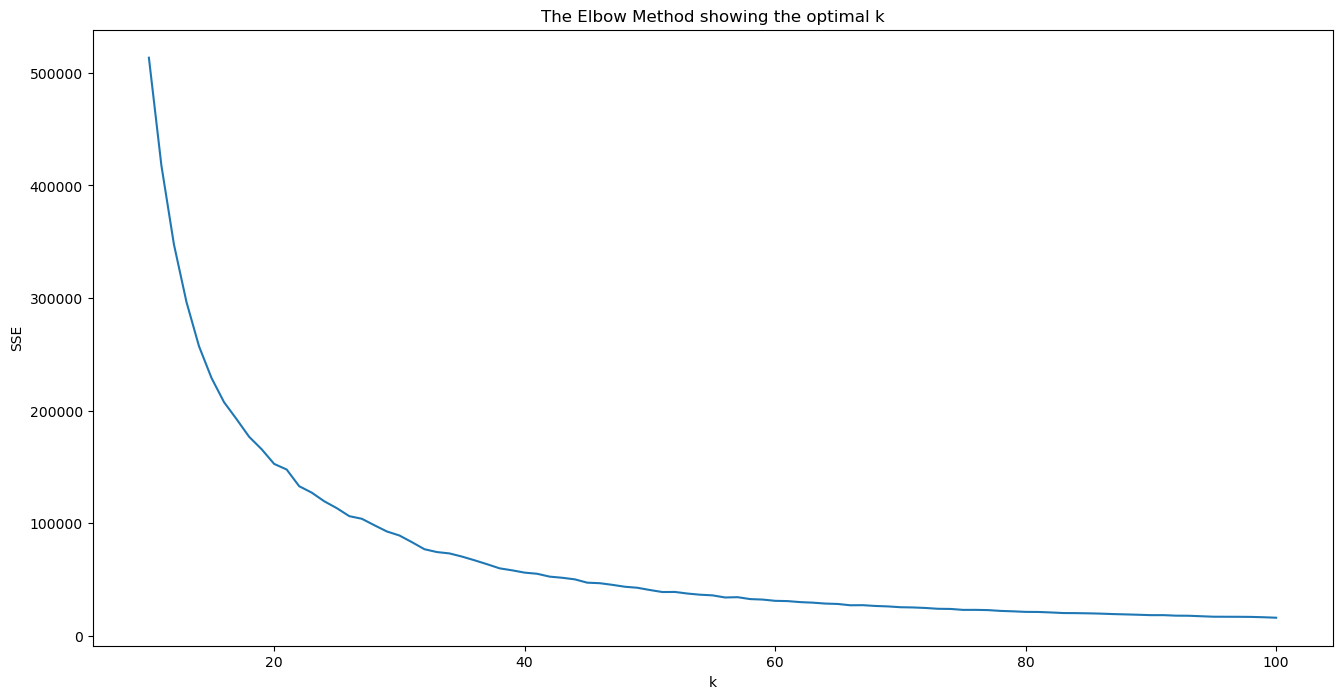

In [216]:
def kmeans_elbow_function(data, kmin, kmax):
    y = []
    for n in range(kmin, kmax+1):
        model = cluster.KMeans(n_clusters=n)
        # Obtengo un array con las distancias de cada elemento a cada cluster
        dists = model.fit_transform(data)
        # Sumo las distancias mínimas de cada elemento. Obtengo un array con la suma
        # de las distancias mínimas al cuadrado (clúster asignado)
        y.append(np.sum(np.min(dists, axis=1) ** 2))
    plt.figure(figsize=(16, 8))
    plt.plot(range(kmin, kmax+1), y)
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method showing the optimal k')
    return plt

def plot_accidents(dataset):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.scatter(dataset['Start_Lng'], dataset['Start_Lat'], s=8, alpha=.1)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.axis('equal')
    plt.tight_layout()
    return plt


plot2 = kmeans_elbow_function(df[['Start_Lat', 'Start_Lng']], 10, 100)
plot2.show()

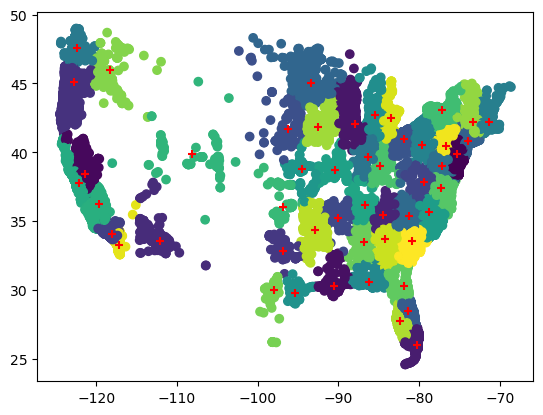

In [233]:
k = 50
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = dtf[["Latitude","Longitude"]]
## clustering
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)

plt.scatter(dtf_X['Start_Lng'],dtf_X['Start_Lat'],c=dtf_X["cluster"])
# Añado los puntos de centro de cluster para identificar mejor el comportamiento del algorítmo
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1],marker='+',c="red")
#plt.show()

<div id="ejercicio-5" class="section level1">
<h1><span class="header-section-number">5.</span> Representación de los resultados</h1>
<hr />
</div>

<div id="ejercicio-6" class="section level1">
<h1><span class="header-section-number">6.</span> Resolución del problema</h1>
<hr />
A partir de los resultados obtenidos, ¿cuáles son las conclusiones? ¿Los resultados permiten responder al problema?
<hr />
</div>

1. Resultados de las correlaciones

    * Tras el análisis observamos que estan altamente correlacionados la temperatura (Temperature(F)) y la sensacion térmica influida por el viento (Wind_Chill(F)). Por lo cual para la futura prediccion de la severidad de los accidentes podemos omitir una de ellas como variable independiente/predictor.
    
    * Por otro lado, las variables de direccion del viento ('Wind_Direction') y la percepcion general del tiempo ('Weather_Condition') estan correlacionadas con todas las variables meteorologicas ya que el conjunto de variables da una percepcion/clasificacion general del tiempo.


2. Resultados de las regresiones

    * 

3. Resultados del clustering